In [2]:
!unzip ./data.zip -d images

In [ ]:
# %conda install -c conda-forge ipywidgets
# %jupyter nbextension enable --py widgetsnbextension

In [3]:
# %pip install tqdm
# %pip install numpy
# %pip install pandas
# %pip install torch

In [1]:
from tqdm import tqdm

In [2]:
import argparse
import json
import string
import os
import shutil
import uuid
#from captcha.image import ImageCaptcha

import itertools

# import cv2
import numpy as np
from random import random, randint, choices

import pandas as pd
import matplotlib.pyplot as plt

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torchvision.models import resnet18

import string
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import multiprocessing as mp

In [7]:
# alphabet_all = list('qwertyupasdfghjkzxcvbnm23456789QWERTYUPKJHGFDSAZXCVBNM')
# alphabet = list('qwertyupasdfghjkzxcvbnm23456789')#QWERTYUIOPLKJHGFDSAZXCVBNM')
# num_alphabet = len(alphabet)
# def _gen_captcha(img_dir, num_of_letters, num_of_repetition, width, height):
#     if os.path.exists(img_dir):
#         shutil.rmtree(img_dir)
#     if not os.path.exists(img_dir):
#         os.makedirs(img_dir)

#     image = ImageCaptcha(width=width, height=height)

#     for counter in range(num_of_repetition):
#         i = choices(alphabet_all, k=5)
#         captcha = ''.join(i)
#         fn = os.path.join(img_dir, '%s_%s.png' % (captcha, uuid.uuid4()))
#         image.write(captcha, fn)


# def gen_dataset(path, num_of_repetition, num_of_letters, width, height):
#     _gen_captcha(os.path.join(path, 'data'), num_of_letters, num_of_repetition, width, height)
#     print('Finished Data Generation')

In [8]:
# BATCH_SIZE = 16
# NUM_OF_LETTERS = 5
# EPOCHS = 50
# IMG_ROW, IMG_COLS = 50, 135

# # Non-configs
# PATH = os.getcwd()
# DATA_PATH = os.path.join(PATH, 'train') # if it's on colab, then the path will be DATA_PATH.
# #DATA_PATH = "C:\\Users\\Victor\\Desktop" # this path is on my local environment where the image captchas are located

In [9]:
# # generate captcha 
# if not os.path.exists(DATA_PATH):
#     print('Generating Dataset')
#     gen_dataset(DATA_PATH, 100*1000 , NUM_OF_LETTERS, IMG_COLS, IMG_ROW)

In [4]:
# use 100000 images with 80/20 split
real_path = "/home/shubos2/final project/images/train" # here please adjust the path/directory of the data!
#real_path = real_path.replace('\\','/') 
image_names = os.listdir(real_path) # load file names for all image captchas
# Below I used 5000 images for the progress report, which took me more than 2 hours to complete it.
# to check if the code works and save time, please use a small sample size (e.g. 200 images)
image_names_train, image_names_test = train_test_split(image_names[0:100000], test_size = 0.2, train_size = 0.8, random_state=0, shuffle=True)
print(len(image_names_train), len(image_names_test))

80000 20000


In [13]:
image_names_train, image_names_dev = train_test_split(image_names_train, test_size = 0.125, train_size = 0.875, random_state=0, shuffle=True)
print(len(image_names_train), len(image_names_dev))

70000 10000


In [5]:
image_text = [image_name.split("_")[0] for image_name in image_names]
image_text = "".join(image_text)
letters = sorted(list(set(list(image_text))))
#print(letters)
vocabulary = ["-"] + letters # for indexing and CTC loss ---> adding "-" is necessary!
#print(len(vocabulary))
#print(vocabulary)
idx_to_char = {k:v for k,v in enumerate(vocabulary, start=0)}
print(idx_to_char)
char_to_idx = {v:k for k,v in idx_to_char.items()}
print(char_to_idx)
num_chars = len(char_to_idx) # the number of classes/features
print(num_chars)

{0: '-', 1: '2', 2: '3', 3: '4', 4: '5', 5: '6', 6: '7', 7: '8', 8: '9', 9: 'A', 10: 'B', 11: 'C', 12: 'D', 13: 'E', 14: 'F', 15: 'G', 16: 'H', 17: 'J', 18: 'K', 19: 'M', 20: 'N', 21: 'P', 22: 'Q', 23: 'R', 24: 'S', 25: 'T', 26: 'U', 27: 'V', 28: 'W', 29: 'X', 30: 'Y', 31: 'Z', 32: 'a', 33: 'b', 34: 'c', 35: 'd', 36: 'e', 37: 'f', 38: 'g', 39: 'h', 40: 'j', 41: 'k', 42: 'm', 43: 'n', 44: 'p', 45: 'q', 46: 'r', 47: 's', 48: 't', 49: 'u', 50: 'v', 51: 'w', 52: 'x', 53: 'y', 54: 'z'}
{'-': 0, '2': 1, '3': 2, '4': 3, '5': 4, '6': 5, '7': 6, '8': 7, '9': 8, 'A': 9, 'B': 10, 'C': 11, 'D': 12, 'E': 13, 'F': 14, 'G': 15, 'H': 16, 'J': 17, 'K': 18, 'M': 19, 'N': 20, 'P': 21, 'Q': 22, 'R': 23, 'S': 24, 'T': 25, 'U': 26, 'V': 27, 'W': 28, 'X': 29, 'Y': 30, 'Z': 31, 'a': 32, 'b': 33, 'c': 34, 'd': 35, 'e': 36, 'f': 37, 'g': 38, 'h': 39, 'j': 40, 'k': 41, 'm': 42, 'n': 43, 'p': 44, 'q': 45, 'r': 46, 's': 47, 't': 48, 'u': 49, 'v': 50, 'w': 51, 'x': 52, 'y': 53, 'z': 54}
55


In [6]:
class load_captcha(Dataset):
    
    def __init__(self, real_path, image_names):
        self.data_dir = real_path
        self.image_names = image_names
        
    def __len__(self):
        return len(self.image_names)
    
    def __getitem__(self, index):
        image_name = self.image_names[index]
        real_path = self.data_dir + '/' + image_name
        image_path = real_path.replace('\\','/')  # please replace this line with your own path!
        image = Image.open(image_path).convert('RGB')
        image = self.transform(image)
        text = image_name.split("_")[0] # return the 5-letter captcha (string)
        return image, text
    
    def transform(self, image):
        transform_ops = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))
        ])
        return transform_ops(image)

In [13]:
# # check the size of one image output & debug
# my_input = image_names_train[0:1]
# my_train=load_captcha(real_path, my_input) 
# #print(DataLoader(my_train))
# my_train_loader = DataLoader(my_train, shuffle=True)
# my_output=my_train.__getitem__(0)[0]
# print(my_output)

In [18]:
batch_size = 32
# data loader using pytorch
trainset = load_captcha(real_path, image_names_train) 
testset = load_captcha(real_path, image_names_test)
train_loader = DataLoader(trainset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(testset, batch_size=batch_size, shuffle=False)
print(len(train_loader), len(test_loader))

2500 625


In [19]:
# get loaded data with a defined batch size using iter().next()
image_train, text_train = iter(train_loader).next()
image_test, text_test = iter(test_loader).next()
print(image_train.size(), text_train, image_test.size(), text_test)

torch.Size([32, 3, 50, 135]) ('HAM6j', '6Hhcw', 'hzSQQ', 'hSxzs', 'PSyuF', '7NzfV', 'jThPg', 'jcJSZ', 'T2MNz', 'EbPxs', '3RdFM', 'FgPFQ', 'zGqA6', 'GXtEN', '26REK', 'wKV5r', 'aus6J', 'WqKc3', 'HYAGm', 'p3HdP', 'szqfx', 'tvu8S', 'NUpwD', '9UR2t', 'eR8Et', 'uZ3h9', 'W4RAj', '7ymgn', 'MSBd2', '3PqYQ', 'pXry6', 'zjx6s') torch.Size([32, 3, 50, 135]) ('6vCUT', 'gbbzs', 'dSEx4', 'kvEYx', 'xY4AD', 'xq3nz', 'Ska6s', 'MUpkU', 'kDHg9', 'kTagr', 'Dp9z4', '2NUZX', 'n96Bh', 'sScNW', 'C78WE', 'ZZGkC', 'Gr3SM', '23eNx', 'SWa5c', 'Duesu', 'PVpB8', 'SN2PS', 'XKd8B', 'dKtMA', 'xJsFX', 'XHNEr', 'aEvJu', '6H9yu', 'Zeesa', 'pfpN7', 'pKz3N', 'FSZet')


In [9]:
resnet = resnet18(pretrained=True)
#list(resnet.children())

In [10]:
# CRNN model based on https://github.com/abhishekkrthakur/captcha-recognition-pytorch/blob/master/model.py ,
# https://actamachina.com/notebooks/2019/03/28/captcha.html ,
# https://github.com/shishishu/pytorch-captcha-recognition ,
# https://github.com/GokulKarthik/Deep-Learning-Projects.pytorch/blob/master/5-Captcha-Text-Recognition-With-CRNN.ipynb ,
# https://www.kaggle.com/shawon10/captcha-recognition and
# https://github.com/DrMahdiRezaei/Deep-CAPTCHA/blob/master/Captcha_Solver_numerical.ipynb
class captcha_CRNN1(nn.Module):

    def __init__(self, num_chars, rnn_hidden_size=256, dropout=0.1):
        super(captcha_CRNN1, self).__init__()
        self.num_chars = num_chars
        self.rnn_hidden_size = rnn_hidden_size
        self.dropout = dropout
        
        resnet_modules = list(resnet.children())[:-3] # --> remove the last three modules (1 nn.sequential, 1 avg_pool and 1 linear)
        self.cnn1 = nn.Sequential(*resnet_modules)
        self.cnn2 = nn.Sequential(
            nn.Conv2d(256, 256, kernel_size=(3,6), stride=1, padding=1),
            nn.BatchNorm2d(256), 
            nn.ReLU(inplace=True)
        )
        self.linear1 = nn.Linear(1024, 256)
        self.rnn1 = nn.GRU(input_size=rnn_hidden_size, hidden_size=rnn_hidden_size, bidirectional=True, batch_first=True)
        self.rnn2 = nn.GRU(input_size=rnn_hidden_size, hidden_size=rnn_hidden_size, bidirectional=True, batch_first=True)
        self.linear2 = nn.Linear(self.rnn_hidden_size*2, num_chars) # bidirection = T so multiply by 2
    
    def forward(self, x): # for 16 batches data
        x = self.cnn1(x) # torch.Size([16, 256, 4, 9])
        #print(x.size()) 
        x = self.cnn2(x) # torch.Size([16, 256, 4, 6]) [batch_size, channels, height, width]
        #print(x.size()) 
        x = x.permute(0, 3, 1, 2) # torch.Size([16, 6, 256, 4])  [batch_size, width, channels, height]
        #print(x.size()) 
        batch_size = x.size(0)
        T = x.size(1) # time length
        x = x.view(batch_size, T, -1) # [batch_size, T==width, num_features==channels*height]
        #print(x.size()) # torch.Size([-1, T, 1024]) ---> torch.Size([16, 6, 1024])
        x = self.linear1(x)
        #print(x.size()) # torch.Size([-1, T, 256]) ---> torch.Size([16, 6, 256])
        x, hidden = self.rnn1(x)
        feature_size = x.size(2) # torch.Size([16, 6, 256*2])
        x = x[:, :, :feature_size//2] + x[:, :, feature_size//2:] # torch.Size([16, 6, 256]) 
        #print(x.size())
        x, hidden = self.rnn2(x) # torch.Size([16, 6, 512])
        #print(x.size()) 
        x = self.linear2(x) # torch.Size([-1, T, num_features]) ---> torch.Size([16, 6, 55])
        #print(x.size()) 
        x = x.permute(1, 0, 2) # [T, batch_size, num_features] for CTC loss training
        #print(x.size()) # torch.Size([6, 16, 55]) ---> batch_size has to be in the middle!
        return x

In [15]:
# weight matrices application using https://github.com/GokulKarthik/Deep-Learning-Projects.pytorch/blob/master/5-Captcha-Text-Recognition-With-CRNN.ipynb
def weights_init(m): 
    classname = m.__class__.__name__
    if type(m) in [nn.Linear, nn.Conv2d, nn.Conv1d]:
        torch.nn.init.xavier_uniform_(m.weight) 
        if m.bias is not None:
            m.bias.data.fill_(0.01)
    elif classname.find('BatchNorm') != -1:
        m.weight.data.normal_(1.0, 0.02)
        m.bias.data.fill_(0)

In [20]:
crnn = captcha_CRNN1(num_chars=num_chars,rnn_hidden_size=256)
crnn.apply(weights_init)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
crnn = crnn.to(device)
#crnn
#processed_label_train = crnn(image_train.to(device))
#print(processed_label_train)
#processed_label_train.size() # torch.Size([6, 16, 55])

In [22]:
def encode_captcha(text_captcha):
    text_lens = [len(text) for text in text_captcha]
    text_lens = torch.IntTensor(text_lens)
    text_raw = "".join(text_captcha)
    text_encoded = [char_to_idx[text] for text in text_raw]
    text_encoded = torch.IntTensor(text_encoded)
    return text_encoded, text_lens

def decode_predictions(text_encoded):
    pred_decoded = F.softmax(text_encoded, 2).argmax(2) # [T, batch_size] --> return the column number of the max for each row 
    pred_decoded = pred_decoded.numpy().T # [batch_size, T]
    pred_decoded_new = []
    for labels in pred_decoded:
        text = [idx_to_char[idx] for idx in labels]
        text = "".join(text)
        pred_decoded_new.append(text)
    return pred_decoded_new

#aa=F.softmax(processed_label_train, 2).argmax(2)
#print(aa.numpy().T)
#decode_predictions(processed_label_train)
def loss_captcha(targets, outputs):
    # targets: raw 5-letter text / outputs: # [T, batch_size, num_features]
    outputs = F.log_softmax(outputs, 2) # [T, batch_size, num_features]  
    outputs_lens = torch.full(size=(outputs.size(1),), fill_value=outputs.size(0), dtype=torch.int32).to(device) # a [] containing the batch size of 6 
    #print(outputs.shape)
    #print(outputs_lens) 
    text_encoded, targets_lens = encode_captcha(targets)
    #print(text_encoded)
    #print(targets_lens) ---> a [] containing the batch size of 5 
    loss = criterion(outputs, text_encoded, outputs_lens, targets_lens) # CTC loss
    return loss

criterion = nn.CTCLoss()
optimizer = optim.Adam(crnn.parameters(), lr=0.001, weight_decay=0.001)
# reduce the learning rate when the model stops improving; patience=5 means no reduction on the learning rate during the first 5 epochs.
lr_scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, verbose=True, patience=5) 
# here we use 20 epochs and 16 batch_size to train the training data (400 images) to see if it works
epochs = 50
result_loss = []
iter_loss = []
num_epoch_update = []

In [23]:
for epoch in tqdm(range(epochs)):
    epoch_loss_list = []
    current_update = 0
    for image_train, label_train in tqdm(train_loader, leave=False): 
        optimizer.zero_grad() # clear gradient for every x
        label_train_crnn = crnn(image_train.to(device))
        loss = loss_captcha(label_train, label_train_crnn)
        loss_current = loss.item() # extract the value of loss for the current batch
        if np.isnan(loss_current) or np.isinf(loss_current):
            continue
        current_update += 1
        iter_loss.append(loss_current)
        epoch_loss_list.append(loss_current)
        loss.backward() # backprop
        nn.utils.clip_grad_norm_(parameters = crnn.parameters(), max_norm = 5) # gradient clipping to prevent the gradient exploding using p2 norm
        optimizer.step() # parameter update 
    epoch_loss = np.mean(epoch_loss_list)
    print("Epoch:{}    Loss:{}    NumUpdates:{}".format(epoch, epoch_loss, current_update))
    result_loss.append(epoch_loss)
    num_epoch_update.append(current_update)
    lr_scheduler.step(epoch_loss) # adjust the learning rate



  0%|          | 0/50 [00:00<?, ?it/s]


  0%|          | 0/2500 [00:00<?, ?it/s]


  0%|          | 1/2500 [00:00<08:36,  4.84it/s]


  0%|          | 2/2500 [00:00<08:22,  4.97it/s]


  0%|          | 3/2500 [00:00<08:18,  5.01it/s]


  0%|          | 4/2500 [00:00<07:58,  5.22it/s]


  0%|          | 5/2500 [00:00<07:36,  5.46it/s]


  0%|          | 6/2500 [00:01<07:41,  5.41it/s]


  0%|          | 7/2500 [00:01<07:45,  5.36it/s]


  0%|          | 8/2500 [00:01<07:42,  5.39it/s]


  0%|          | 9/2500 [00:01<07:47,  5.32it/s]


  0%|          | 10/2500 [00:01<07:28,  5.55it/s]


  0%|          | 11/2500 [00:02<07:34,  5.48it/s]


  0%|          | 12/2500 [00:02<08:06,  5.12it/s]


  1%|          | 13/2500 [00:02<08:07,  5.11it/s]


  1%|          | 14/2500 [00:02<07:55,  5.23it/s]


  1%|          | 15/2500 [00:02<07:51,  5.27it/s]


  1%|          | 16/2500 [00:03<07:46,  5.33it/s]


  1%|          | 17/2500 [00:03<07:54,  5.23it/s]


  1%|          | 18/2500 [00:03<07:20, 

  5%|▌         | 133/2500 [00:26<09:35,  4.12it/s]


  5%|▌         | 134/2500 [00:26<09:30,  4.15it/s]


  5%|▌         | 135/2500 [00:26<09:11,  4.29it/s]


  5%|▌         | 136/2500 [00:27<09:23,  4.20it/s]


  5%|▌         | 137/2500 [00:27<09:30,  4.14it/s]


  6%|▌         | 138/2500 [00:27<09:00,  4.37it/s]


  6%|▌         | 139/2500 [00:27<09:31,  4.13it/s]


  6%|▌         | 140/2500 [00:28<09:22,  4.20it/s]


  6%|▌         | 141/2500 [00:28<09:15,  4.25it/s]


  6%|▌         | 142/2500 [00:28<09:27,  4.15it/s]


  6%|▌         | 143/2500 [00:28<08:46,  4.48it/s]


  6%|▌         | 144/2500 [00:28<08:25,  4.66it/s]


  6%|▌         | 145/2500 [00:29<08:09,  4.81it/s]


  6%|▌         | 146/2500 [00:29<08:02,  4.88it/s]


  6%|▌         | 147/2500 [00:29<07:45,  5.05it/s]


  6%|▌         | 148/2500 [00:29<07:34,  5.17it/s]


  6%|▌         | 149/2500 [00:29<07:25,  5.28it/s]


  6%|▌         | 150/2500 [00:30<07:27,  5.25it/s]


  6%|▌         | 151/2500 [00:30<07:28,  5.23i

 11%|█         | 265/2500 [00:51<08:59,  4.14it/s]


 11%|█         | 266/2500 [00:51<09:22,  3.97it/s]


 11%|█         | 267/2500 [00:52<08:43,  4.27it/s]


 11%|█         | 268/2500 [00:52<08:00,  4.65it/s]


 11%|█         | 269/2500 [00:52<07:52,  4.72it/s]


 11%|█         | 270/2500 [00:52<07:56,  4.68it/s]


 11%|█         | 271/2500 [00:52<07:17,  5.09it/s]


 11%|█         | 272/2500 [00:52<06:55,  5.36it/s]


 11%|█         | 273/2500 [00:53<06:50,  5.43it/s]


 11%|█         | 274/2500 [00:53<06:45,  5.49it/s]


 11%|█         | 275/2500 [00:53<06:48,  5.44it/s]


 11%|█         | 276/2500 [00:53<06:46,  5.47it/s]


 11%|█         | 277/2500 [00:53<06:34,  5.63it/s]


 11%|█         | 278/2500 [00:54<06:54,  5.36it/s]


 11%|█         | 279/2500 [00:54<07:38,  4.85it/s]


 11%|█         | 280/2500 [00:54<07:49,  4.73it/s]


 11%|█         | 281/2500 [00:54<07:20,  5.04it/s]


 11%|█▏        | 282/2500 [00:54<07:46,  4.75it/s]


 11%|█▏        | 283/2500 [00:55<07:34,  4.88i

 16%|█▌        | 397/2500 [01:17<07:48,  4.49it/s]


 16%|█▌        | 398/2500 [01:18<08:00,  4.37it/s]


 16%|█▌        | 399/2500 [01:18<08:05,  4.33it/s]


 16%|█▌        | 400/2500 [01:18<08:17,  4.22it/s]


 16%|█▌        | 401/2500 [01:18<08:11,  4.27it/s]


 16%|█▌        | 402/2500 [01:19<08:32,  4.09it/s]


 16%|█▌        | 403/2500 [01:19<08:44,  4.00it/s]


 16%|█▌        | 404/2500 [01:19<08:40,  4.03it/s]


 16%|█▌        | 405/2500 [01:19<08:32,  4.08it/s]


 16%|█▌        | 406/2500 [01:20<08:22,  4.17it/s]


 16%|█▋        | 407/2500 [01:20<08:03,  4.33it/s]


 16%|█▋        | 408/2500 [01:20<08:12,  4.25it/s]


 16%|█▋        | 409/2500 [01:20<07:58,  4.37it/s]


 16%|█▋        | 410/2500 [01:20<07:17,  4.77it/s]


 16%|█▋        | 411/2500 [01:21<06:48,  5.11it/s]


 16%|█▋        | 412/2500 [01:21<06:24,  5.42it/s]


 17%|█▋        | 413/2500 [01:21<06:38,  5.24it/s]


 17%|█▋        | 414/2500 [01:21<06:37,  5.25it/s]


 17%|█▋        | 415/2500 [01:21<06:26,  5.40i

 21%|██        | 531/2500 [01:43<05:35,  5.87it/s]


 21%|██▏       | 532/2500 [01:43<05:24,  6.07it/s]


 21%|██▏       | 533/2500 [01:43<05:35,  5.86it/s]


 21%|██▏       | 534/2500 [01:43<05:35,  5.87it/s]


 21%|██▏       | 535/2500 [01:43<05:57,  5.50it/s]


 21%|██▏       | 536/2500 [01:44<05:53,  5.56it/s]


 21%|██▏       | 537/2500 [01:44<06:15,  5.23it/s]


 22%|██▏       | 538/2500 [01:44<06:39,  4.91it/s]


 22%|██▏       | 539/2500 [01:44<06:35,  4.96it/s]


 22%|██▏       | 540/2500 [01:44<06:23,  5.11it/s]


 22%|██▏       | 541/2500 [01:45<06:19,  5.16it/s]


 22%|██▏       | 542/2500 [01:45<06:28,  5.04it/s]


 22%|██▏       | 543/2500 [01:45<06:19,  5.16it/s]


 22%|██▏       | 544/2500 [01:45<06:09,  5.30it/s]


 22%|██▏       | 545/2500 [01:45<06:15,  5.20it/s]


 22%|██▏       | 546/2500 [01:46<06:13,  5.23it/s]


 22%|██▏       | 547/2500 [01:46<06:23,  5.09it/s]


 22%|██▏       | 548/2500 [01:46<06:21,  5.12it/s]


 22%|██▏       | 549/2500 [01:46<06:19,  5.15i

 27%|██▋       | 663/2500 [02:07<05:09,  5.93it/s]


 27%|██▋       | 664/2500 [02:07<05:08,  5.96it/s]


 27%|██▋       | 665/2500 [02:07<05:13,  5.86it/s]


 27%|██▋       | 666/2500 [02:08<05:39,  5.41it/s]


 27%|██▋       | 667/2500 [02:08<05:23,  5.66it/s]


 27%|██▋       | 668/2500 [02:08<05:24,  5.65it/s]


 27%|██▋       | 669/2500 [02:08<05:26,  5.60it/s]


 27%|██▋       | 670/2500 [02:08<05:14,  5.81it/s]


 27%|██▋       | 671/2500 [02:08<05:12,  5.85it/s]


 27%|██▋       | 672/2500 [02:09<05:11,  5.86it/s]


 27%|██▋       | 673/2500 [02:09<05:02,  6.03it/s]


 27%|██▋       | 674/2500 [02:09<05:04,  6.00it/s]


 27%|██▋       | 675/2500 [02:09<05:12,  5.84it/s]


 27%|██▋       | 676/2500 [02:09<05:11,  5.85it/s]


 27%|██▋       | 677/2500 [02:09<05:27,  5.57it/s]


 27%|██▋       | 678/2500 [02:10<05:13,  5.81it/s]


 27%|██▋       | 679/2500 [02:10<05:29,  5.53it/s]


 27%|██▋       | 680/2500 [02:10<05:30,  5.51it/s]


 27%|██▋       | 681/2500 [02:10<05:30,  5.51i

 32%|███▏      | 796/2500 [02:32<05:41,  4.99it/s]


 32%|███▏      | 797/2500 [02:32<05:02,  5.62it/s]


 32%|███▏      | 798/2500 [02:33<05:02,  5.63it/s]


 32%|███▏      | 799/2500 [02:33<04:41,  6.04it/s]


 32%|███▏      | 800/2500 [02:33<05:00,  5.65it/s]


 32%|███▏      | 801/2500 [02:33<05:08,  5.51it/s]


 32%|███▏      | 802/2500 [02:33<05:48,  4.87it/s]


 32%|███▏      | 803/2500 [02:34<06:09,  4.59it/s]


 32%|███▏      | 804/2500 [02:34<06:07,  4.61it/s]


 32%|███▏      | 805/2500 [02:34<06:34,  4.30it/s]


 32%|███▏      | 806/2500 [02:34<06:50,  4.12it/s]


 32%|███▏      | 807/2500 [02:35<06:40,  4.23it/s]


 32%|███▏      | 808/2500 [02:35<06:49,  4.13it/s]


 32%|███▏      | 809/2500 [02:35<07:16,  3.87it/s]


 32%|███▏      | 810/2500 [02:35<06:53,  4.09it/s]


 32%|███▏      | 811/2500 [02:36<06:06,  4.61it/s]


 32%|███▏      | 812/2500 [02:36<05:08,  5.47it/s]


 33%|███▎      | 813/2500 [02:36<04:30,  6.24it/s]


 33%|███▎      | 814/2500 [02:36<04:34,  6.13i

 37%|███▋      | 929/2500 [02:56<04:47,  5.47it/s]


 37%|███▋      | 930/2500 [02:57<04:50,  5.41it/s]


 37%|███▋      | 931/2500 [02:57<04:55,  5.30it/s]


 37%|███▋      | 932/2500 [02:57<04:50,  5.39it/s]


 37%|███▋      | 933/2500 [02:57<05:04,  5.14it/s]


 37%|███▋      | 934/2500 [02:57<04:58,  5.25it/s]


 37%|███▋      | 935/2500 [02:58<04:47,  5.44it/s]


 37%|███▋      | 936/2500 [02:58<04:54,  5.31it/s]


 37%|███▋      | 937/2500 [02:58<04:55,  5.29it/s]


 38%|███▊      | 938/2500 [02:58<05:06,  5.09it/s]


 38%|███▊      | 939/2500 [02:58<05:00,  5.19it/s]


 38%|███▊      | 940/2500 [02:59<04:54,  5.30it/s]


 38%|███▊      | 941/2500 [02:59<04:43,  5.49it/s]


 38%|███▊      | 942/2500 [02:59<05:35,  4.65it/s]


 38%|███▊      | 943/2500 [02:59<06:04,  4.27it/s]


 38%|███▊      | 944/2500 [03:00<06:01,  4.31it/s]


 38%|███▊      | 945/2500 [03:00<05:47,  4.48it/s]


 38%|███▊      | 946/2500 [03:00<06:03,  4.28it/s]


 38%|███▊      | 947/2500 [03:00<05:26,  4.76i

 42%|████▏     | 1060/2500 [03:23<05:55,  4.05it/s]


 42%|████▏     | 1061/2500 [03:23<05:26,  4.41it/s]


 42%|████▏     | 1062/2500 [03:23<05:03,  4.73it/s]


 43%|████▎     | 1063/2500 [03:23<04:54,  4.87it/s]


 43%|████▎     | 1064/2500 [03:24<04:40,  5.12it/s]


 43%|████▎     | 1065/2500 [03:24<04:36,  5.18it/s]


 43%|████▎     | 1066/2500 [03:24<04:37,  5.16it/s]


 43%|████▎     | 1067/2500 [03:24<04:31,  5.28it/s]


 43%|████▎     | 1068/2500 [03:24<04:29,  5.32it/s]


 43%|████▎     | 1069/2500 [03:24<04:31,  5.26it/s]


 43%|████▎     | 1070/2500 [03:25<04:34,  5.21it/s]


 43%|████▎     | 1071/2500 [03:25<04:37,  5.16it/s]


 43%|████▎     | 1072/2500 [03:25<04:35,  5.18it/s]


 43%|████▎     | 1073/2500 [03:25<04:28,  5.32it/s]


 43%|████▎     | 1074/2500 [03:25<04:20,  5.47it/s]


 43%|████▎     | 1075/2500 [03:26<04:40,  5.08it/s]


 43%|████▎     | 1076/2500 [03:26<05:02,  4.71it/s]


 43%|████▎     | 1077/2500 [03:26<05:01,  4.71it/s]


 43%|████▎     | 1078/2500 [

 48%|████▊     | 1191/2500 [03:48<04:06,  5.30it/s]


 48%|████▊     | 1192/2500 [03:48<04:15,  5.13it/s]


 48%|████▊     | 1193/2500 [03:48<04:05,  5.31it/s]


 48%|████▊     | 1194/2500 [03:48<04:13,  5.14it/s]


 48%|████▊     | 1195/2500 [03:48<04:11,  5.19it/s]


 48%|████▊     | 1196/2500 [03:48<04:12,  5.16it/s]


 48%|████▊     | 1197/2500 [03:49<03:58,  5.46it/s]


 48%|████▊     | 1198/2500 [03:49<03:57,  5.48it/s]


 48%|████▊     | 1199/2500 [03:49<04:11,  5.17it/s]


 48%|████▊     | 1200/2500 [03:49<04:04,  5.31it/s]


 48%|████▊     | 1201/2500 [03:49<04:00,  5.40it/s]


 48%|████▊     | 1202/2500 [03:50<04:04,  5.31it/s]


 48%|████▊     | 1203/2500 [03:50<04:10,  5.19it/s]


 48%|████▊     | 1204/2500 [03:50<04:15,  5.07it/s]


 48%|████▊     | 1205/2500 [03:50<04:27,  4.84it/s]


 48%|████▊     | 1206/2500 [03:50<04:26,  4.86it/s]


 48%|████▊     | 1207/2500 [03:51<04:18,  5.00it/s]


 48%|████▊     | 1208/2500 [03:51<04:12,  5.12it/s]


 48%|████▊     | 1209/2500 [

 53%|█████▎    | 1322/2500 [04:14<03:19,  5.92it/s]


 53%|█████▎    | 1323/2500 [04:14<03:27,  5.67it/s]


 53%|█████▎    | 1324/2500 [04:14<03:33,  5.51it/s]


 53%|█████▎    | 1325/2500 [04:14<03:40,  5.33it/s]


 53%|█████▎    | 1326/2500 [04:14<03:42,  5.27it/s]


 53%|█████▎    | 1327/2500 [04:15<03:45,  5.21it/s]


 53%|█████▎    | 1328/2500 [04:15<03:42,  5.28it/s]


 53%|█████▎    | 1329/2500 [04:15<03:56,  4.96it/s]


 53%|█████▎    | 1330/2500 [04:15<04:03,  4.80it/s]


 53%|█████▎    | 1331/2500 [04:16<04:21,  4.47it/s]


 53%|█████▎    | 1332/2500 [04:16<04:33,  4.28it/s]


 53%|█████▎    | 1333/2500 [04:16<04:40,  4.16it/s]


 53%|█████▎    | 1334/2500 [04:16<04:26,  4.37it/s]


 53%|█████▎    | 1335/2500 [04:17<04:49,  4.03it/s]


 53%|█████▎    | 1336/2500 [04:17<04:57,  3.92it/s]


 53%|█████▎    | 1337/2500 [04:17<05:02,  3.85it/s]


 54%|█████▎    | 1338/2500 [04:17<04:36,  4.21it/s]


 54%|█████▎    | 1339/2500 [04:18<04:24,  4.40it/s]


 54%|█████▎    | 1340/2500 [

 58%|█████▊    | 1452/2500 [04:38<02:59,  5.85it/s]


 58%|█████▊    | 1453/2500 [04:38<03:04,  5.69it/s]


 58%|█████▊    | 1454/2500 [04:38<03:11,  5.47it/s]


 58%|█████▊    | 1455/2500 [04:38<03:05,  5.64it/s]


 58%|█████▊    | 1456/2500 [04:38<03:02,  5.74it/s]


 58%|█████▊    | 1457/2500 [04:39<03:18,  5.26it/s]


 58%|█████▊    | 1458/2500 [04:39<03:49,  4.54it/s]


 58%|█████▊    | 1459/2500 [04:39<03:50,  4.52it/s]


 58%|█████▊    | 1460/2500 [04:39<03:57,  4.38it/s]


 58%|█████▊    | 1461/2500 [04:40<04:01,  4.31it/s]


 58%|█████▊    | 1462/2500 [04:40<04:11,  4.12it/s]


 59%|█████▊    | 1463/2500 [04:40<04:12,  4.10it/s]


 59%|█████▊    | 1464/2500 [04:40<04:02,  4.27it/s]


 59%|█████▊    | 1465/2500 [04:41<03:48,  4.52it/s]


 59%|█████▊    | 1466/2500 [04:41<03:49,  4.52it/s]


 59%|█████▊    | 1467/2500 [04:41<04:06,  4.19it/s]


 59%|█████▊    | 1468/2500 [04:41<04:13,  4.07it/s]


 59%|█████▉    | 1469/2500 [04:42<03:51,  4.45it/s]


 59%|█████▉    | 1470/2500 [

 63%|██████▎   | 1585/2500 [05:03<02:40,  5.71it/s]


 63%|██████▎   | 1586/2500 [05:04<02:42,  5.64it/s]


 63%|██████▎   | 1587/2500 [05:04<02:45,  5.51it/s]


 64%|██████▎   | 1588/2500 [05:04<02:45,  5.51it/s]


 64%|██████▎   | 1589/2500 [05:04<03:04,  4.93it/s]


 64%|██████▎   | 1590/2500 [05:04<03:06,  4.89it/s]


 64%|██████▎   | 1591/2500 [05:05<03:19,  4.56it/s]


 64%|██████▎   | 1592/2500 [05:05<03:28,  4.37it/s]


 64%|██████▎   | 1593/2500 [05:05<03:29,  4.33it/s]


 64%|██████▍   | 1594/2500 [05:05<03:40,  4.11it/s]


 64%|██████▍   | 1595/2500 [05:06<03:39,  4.12it/s]


 64%|██████▍   | 1596/2500 [05:06<03:32,  4.26it/s]


 64%|██████▍   | 1597/2500 [05:06<03:37,  4.15it/s]


 64%|██████▍   | 1598/2500 [05:06<03:53,  3.86it/s]


 64%|██████▍   | 1599/2500 [05:07<04:00,  3.74it/s]


 64%|██████▍   | 1600/2500 [05:07<03:48,  3.94it/s]


 64%|██████▍   | 1601/2500 [05:07<03:33,  4.21it/s]


 64%|██████▍   | 1602/2500 [05:07<03:31,  4.24it/s]


 64%|██████▍   | 1603/2500 [

 69%|██████▊   | 1715/2500 [05:30<03:05,  4.24it/s]


 69%|██████▊   | 1716/2500 [05:30<03:07,  4.19it/s]


 69%|██████▊   | 1717/2500 [05:30<03:15,  4.01it/s]


 69%|██████▊   | 1718/2500 [05:31<03:13,  4.04it/s]


 69%|██████▉   | 1719/2500 [05:31<03:06,  4.18it/s]


 69%|██████▉   | 1720/2500 [05:31<03:14,  4.01it/s]


 69%|██████▉   | 1721/2500 [05:31<03:08,  4.14it/s]


 69%|██████▉   | 1722/2500 [05:32<03:06,  4.17it/s]


 69%|██████▉   | 1723/2500 [05:32<03:11,  4.05it/s]


 69%|██████▉   | 1724/2500 [05:32<03:07,  4.14it/s]


 69%|██████▉   | 1725/2500 [05:32<02:37,  4.93it/s]


 69%|██████▉   | 1726/2500 [05:32<02:29,  5.16it/s]


 69%|██████▉   | 1727/2500 [05:32<02:12,  5.84it/s]


 69%|██████▉   | 1728/2500 [05:33<01:57,  6.55it/s]


 69%|██████▉   | 1730/2500 [05:33<01:47,  7.15it/s]


 69%|██████▉   | 1731/2500 [05:33<01:52,  6.83it/s]


 69%|██████▉   | 1732/2500 [05:33<01:50,  6.96it/s]


 69%|██████▉   | 1733/2500 [05:33<02:01,  6.33it/s]


 69%|██████▉   | 1734/2500 [

 74%|███████▍  | 1847/2500 [05:54<02:15,  4.83it/s]


 74%|███████▍  | 1848/2500 [05:54<01:59,  5.48it/s]


 74%|███████▍  | 1849/2500 [05:54<01:44,  6.20it/s]


 74%|███████▍  | 1850/2500 [05:54<01:42,  6.33it/s]


 74%|███████▍  | 1851/2500 [05:54<01:43,  6.27it/s]


 74%|███████▍  | 1852/2500 [05:55<01:41,  6.38it/s]


 74%|███████▍  | 1853/2500 [05:55<01:39,  6.53it/s]


 74%|███████▍  | 1854/2500 [05:55<01:45,  6.10it/s]


 74%|███████▍  | 1855/2500 [05:55<01:48,  5.92it/s]


 74%|███████▍  | 1856/2500 [05:55<01:55,  5.56it/s]


 74%|███████▍  | 1857/2500 [05:56<02:07,  5.05it/s]


 74%|███████▍  | 1858/2500 [05:56<02:08,  4.98it/s]


 74%|███████▍  | 1859/2500 [05:56<02:07,  5.05it/s]


 74%|███████▍  | 1860/2500 [05:56<02:07,  5.03it/s]


 74%|███████▍  | 1861/2500 [05:56<02:07,  5.01it/s]


 74%|███████▍  | 1862/2500 [05:57<02:10,  4.91it/s]


 75%|███████▍  | 1863/2500 [05:57<02:18,  4.59it/s]


 75%|███████▍  | 1864/2500 [05:57<02:11,  4.85it/s]


 75%|███████▍  | 1865/2500 [

 79%|███████▉  | 1977/2500 [06:18<01:23,  6.23it/s]


 79%|███████▉  | 1978/2500 [06:18<01:23,  6.23it/s]


 79%|███████▉  | 1979/2500 [06:18<01:21,  6.41it/s]


 79%|███████▉  | 1980/2500 [06:18<01:21,  6.38it/s]


 79%|███████▉  | 1981/2500 [06:18<01:25,  6.10it/s]


 79%|███████▉  | 1982/2500 [06:19<01:21,  6.36it/s]


 79%|███████▉  | 1983/2500 [06:19<01:22,  6.28it/s]


 79%|███████▉  | 1984/2500 [06:19<01:31,  5.63it/s]


 79%|███████▉  | 1985/2500 [06:19<01:36,  5.32it/s]


 79%|███████▉  | 1986/2500 [06:19<01:42,  5.03it/s]


 79%|███████▉  | 1987/2500 [06:20<01:48,  4.73it/s]


 80%|███████▉  | 1988/2500 [06:20<01:55,  4.42it/s]


 80%|███████▉  | 1989/2500 [06:20<02:01,  4.21it/s]


 80%|███████▉  | 1990/2500 [06:20<02:00,  4.24it/s]


 80%|███████▉  | 1991/2500 [06:21<01:57,  4.34it/s]


 80%|███████▉  | 1992/2500 [06:21<01:58,  4.28it/s]


 80%|███████▉  | 1993/2500 [06:21<01:53,  4.45it/s]


 80%|███████▉  | 1994/2500 [06:21<01:46,  4.76it/s]


 80%|███████▉  | 1995/2500 [

 84%|████████▍ | 2107/2500 [06:43<01:12,  5.39it/s]


 84%|████████▍ | 2108/2500 [06:43<01:10,  5.53it/s]


 84%|████████▍ | 2109/2500 [06:43<01:13,  5.30it/s]


 84%|████████▍ | 2110/2500 [06:44<01:14,  5.27it/s]


 84%|████████▍ | 2111/2500 [06:44<01:09,  5.56it/s]


 84%|████████▍ | 2112/2500 [06:44<01:12,  5.34it/s]


 85%|████████▍ | 2113/2500 [06:44<01:07,  5.71it/s]


 85%|████████▍ | 2114/2500 [06:44<01:05,  5.88it/s]


 85%|████████▍ | 2115/2500 [06:44<01:02,  6.14it/s]


 85%|████████▍ | 2116/2500 [06:45<01:02,  6.19it/s]


 85%|████████▍ | 2117/2500 [06:45<01:01,  6.21it/s]


 85%|████████▍ | 2118/2500 [06:45<01:02,  6.16it/s]


 85%|████████▍ | 2119/2500 [06:45<00:57,  6.60it/s]


 85%|████████▍ | 2120/2500 [06:45<01:03,  5.94it/s]


 85%|████████▍ | 2121/2500 [06:45<01:08,  5.55it/s]


 85%|████████▍ | 2122/2500 [06:46<01:10,  5.35it/s]


 85%|████████▍ | 2123/2500 [06:46<01:14,  5.09it/s]


 85%|████████▍ | 2124/2500 [06:46<01:17,  4.88it/s]


 85%|████████▌ | 2125/2500 [

 89%|████████▉ | 2237/2500 [07:08<00:47,  5.53it/s]


 90%|████████▉ | 2238/2500 [07:08<00:48,  5.39it/s]


 90%|████████▉ | 2239/2500 [07:08<00:48,  5.40it/s]


 90%|████████▉ | 2240/2500 [07:08<00:46,  5.56it/s]


 90%|████████▉ | 2241/2500 [07:09<00:48,  5.35it/s]


 90%|████████▉ | 2242/2500 [07:09<00:46,  5.60it/s]


 90%|████████▉ | 2243/2500 [07:09<00:46,  5.57it/s]


 90%|████████▉ | 2244/2500 [07:09<00:46,  5.56it/s]


 90%|████████▉ | 2245/2500 [07:09<00:46,  5.46it/s]


 90%|████████▉ | 2246/2500 [07:09<00:46,  5.50it/s]


 90%|████████▉ | 2247/2500 [07:10<00:47,  5.34it/s]


 90%|████████▉ | 2248/2500 [07:10<00:47,  5.31it/s]


 90%|████████▉ | 2249/2500 [07:10<00:46,  5.34it/s]


 90%|█████████ | 2250/2500 [07:10<00:47,  5.30it/s]


 90%|█████████ | 2251/2500 [07:10<00:46,  5.31it/s]


 90%|█████████ | 2252/2500 [07:11<00:47,  5.21it/s]


 90%|█████████ | 2253/2500 [07:11<00:46,  5.35it/s]


 90%|█████████ | 2254/2500 [07:11<00:45,  5.40it/s]


 90%|█████████ | 2255/2500 [

 95%|█████████▍| 2367/2500 [07:32<00:24,  5.53it/s]


 95%|█████████▍| 2368/2500 [07:32<00:22,  5.83it/s]


 95%|█████████▍| 2369/2500 [07:33<00:21,  6.10it/s]


 95%|█████████▍| 2370/2500 [07:33<00:21,  6.11it/s]


 95%|█████████▍| 2371/2500 [07:33<00:21,  5.88it/s]


 95%|█████████▍| 2372/2500 [07:33<00:22,  5.59it/s]


 95%|█████████▍| 2373/2500 [07:33<00:22,  5.64it/s]


 95%|█████████▍| 2374/2500 [07:33<00:20,  6.10it/s]


 95%|█████████▌| 2375/2500 [07:34<00:19,  6.52it/s]


 95%|█████████▌| 2376/2500 [07:34<00:17,  6.99it/s]


 95%|█████████▌| 2377/2500 [07:34<00:17,  6.92it/s]


 95%|█████████▌| 2378/2500 [07:34<00:18,  6.65it/s]


 95%|█████████▌| 2379/2500 [07:34<00:19,  6.08it/s]


 95%|█████████▌| 2380/2500 [07:34<00:19,  6.27it/s]


 95%|█████████▌| 2381/2500 [07:35<00:19,  6.24it/s]


 95%|█████████▌| 2382/2500 [07:35<00:19,  6.13it/s]


 95%|█████████▌| 2383/2500 [07:35<00:19,  6.08it/s]


 95%|█████████▌| 2384/2500 [07:35<00:19,  5.98it/s]


 95%|█████████▌| 2385/2500 [

100%|█████████▉| 2497/2500 [07:57<00:00,  5.65it/s]


100%|█████████▉| 2498/2500 [07:57<00:00,  5.69it/s]


100%|█████████▉| 2499/2500 [07:58<00:00,  5.40it/s]


100%|██████████| 2500/2500 [07:58<00:00,  5.29it/s]


                                                   

  2%|▏         | 1/50 [07:58<6:30:32, 478.22s/it]


  0%|          | 0/2500 [00:00<?, ?it/s]


  0%|          | 2/2500 [00:00<02:36, 15.91it/s]

Epoch:0    Loss:2.8550962376594544    NumUpdates:2500





  0%|          | 4/2500 [00:00<02:36, 15.90it/s]


  0%|          | 6/2500 [00:00<02:41, 15.48it/s]


  0%|          | 8/2500 [00:00<02:38, 15.69it/s]


  0%|          | 10/2500 [00:00<02:36, 15.87it/s]


  0%|          | 12/2500 [00:00<02:36, 15.89it/s]


  1%|          | 14/2500 [00:00<02:36, 15.94it/s]


  1%|          | 16/2500 [00:01<02:36, 15.89it/s]


  1%|          | 18/2500 [00:01<02:36, 15.86it/s]


  1%|          | 20/2500 [00:01<02:35, 15.91it/s]


  1%|          | 22/2500 [00:01<02:34, 15.99it/s]


  1%|          | 24/2500 [00:01<02:35, 15.95it/s]


  1%|          | 26/2500 [00:01<02:33, 16.11it/s]


  1%|          | 28/2500 [00:01<02:33, 16.11it/s]


  1%|          | 30/2500 [00:01<02:33, 16.06it/s]


  1%|▏         | 32/2500 [00:02<02:33, 16.06it/s]


  1%|▏         | 34/2500 [00:02<02:32, 16.15it/s]


  1%|▏         | 36/2500 [00:02<02:33, 16.09it/s]


  2%|▏         | 38/2500 [00:02<02:34, 15.97it/s]


  2%|▏         | 40/2500 [00:02<02:34, 15.91it/s]


  2%|▏      

 11%|█         | 268/2500 [00:16<02:21, 15.78it/s]


 11%|█         | 270/2500 [00:17<02:20, 15.84it/s]


 11%|█         | 272/2500 [00:17<02:20, 15.83it/s]


 11%|█         | 274/2500 [00:17<02:19, 15.91it/s]


 11%|█         | 276/2500 [00:17<02:20, 15.88it/s]


 11%|█         | 278/2500 [00:17<02:19, 15.98it/s]


 11%|█         | 280/2500 [00:17<02:19, 15.89it/s]


 11%|█▏        | 282/2500 [00:17<02:20, 15.84it/s]


 11%|█▏        | 284/2500 [00:17<02:20, 15.81it/s]


 11%|█▏        | 286/2500 [00:18<02:18, 15.95it/s]


 12%|█▏        | 288/2500 [00:18<02:18, 16.01it/s]


 12%|█▏        | 290/2500 [00:18<02:18, 15.97it/s]


 12%|█▏        | 292/2500 [00:18<02:17, 16.09it/s]


 12%|█▏        | 294/2500 [00:18<02:17, 16.07it/s]


 12%|█▏        | 296/2500 [00:18<02:17, 16.04it/s]


 12%|█▏        | 298/2500 [00:18<02:24, 15.25it/s]


 12%|█▏        | 300/2500 [00:18<02:25, 15.09it/s]


 12%|█▏        | 302/2500 [00:19<02:27, 14.92it/s]


 12%|█▏        | 304/2500 [00:19<02:25, 15.14i

 21%|██▏       | 532/2500 [00:33<02:03, 15.90it/s]


 21%|██▏       | 534/2500 [00:33<02:02, 16.01it/s]


 21%|██▏       | 536/2500 [00:33<02:01, 16.12it/s]


 22%|██▏       | 538/2500 [00:33<02:02, 16.00it/s]


 22%|██▏       | 540/2500 [00:33<02:02, 16.04it/s]


 22%|██▏       | 542/2500 [00:34<02:02, 16.04it/s]


 22%|██▏       | 544/2500 [00:34<02:01, 16.15it/s]


 22%|██▏       | 546/2500 [00:34<02:00, 16.23it/s]


 22%|██▏       | 548/2500 [00:34<01:59, 16.37it/s]


 22%|██▏       | 550/2500 [00:34<02:00, 16.22it/s]


 22%|██▏       | 552/2500 [00:34<02:00, 16.15it/s]


 22%|██▏       | 554/2500 [00:34<02:01, 16.07it/s]


 22%|██▏       | 556/2500 [00:34<02:01, 15.97it/s]


 22%|██▏       | 558/2500 [00:35<02:02, 15.86it/s]


 22%|██▏       | 560/2500 [00:35<02:02, 15.81it/s]


 22%|██▏       | 562/2500 [00:35<02:02, 15.84it/s]


 23%|██▎       | 564/2500 [00:35<02:02, 15.85it/s]


 23%|██▎       | 566/2500 [00:35<02:01, 15.89it/s]


 23%|██▎       | 568/2500 [00:35<02:01, 15.88i

 32%|███▏      | 796/2500 [00:50<01:45, 16.21it/s]


 32%|███▏      | 798/2500 [00:50<01:45, 16.13it/s]


 32%|███▏      | 800/2500 [00:50<01:45, 16.13it/s]


 32%|███▏      | 802/2500 [00:50<01:45, 16.06it/s]


 32%|███▏      | 804/2500 [00:50<01:48, 15.61it/s]


 32%|███▏      | 806/2500 [00:50<01:47, 15.76it/s]


 32%|███▏      | 808/2500 [00:50<01:47, 15.75it/s]


 32%|███▏      | 810/2500 [00:51<01:46, 15.81it/s]


 32%|███▏      | 812/2500 [00:51<01:45, 15.98it/s]


 33%|███▎      | 814/2500 [00:51<01:46, 15.81it/s]


 33%|███▎      | 816/2500 [00:51<01:46, 15.83it/s]


 33%|███▎      | 818/2500 [00:51<01:46, 15.74it/s]


 33%|███▎      | 820/2500 [00:51<01:46, 15.74it/s]


 33%|███▎      | 822/2500 [00:51<01:46, 15.70it/s]


 33%|███▎      | 824/2500 [00:51<01:47, 15.65it/s]


 33%|███▎      | 826/2500 [00:52<01:46, 15.71it/s]


 33%|███▎      | 828/2500 [00:52<01:46, 15.74it/s]


 33%|███▎      | 830/2500 [00:52<01:46, 15.73it/s]


 33%|███▎      | 832/2500 [00:52<01:46, 15.72i

 42%|████▏     | 1058/2500 [01:06<01:32, 15.56it/s]


 42%|████▏     | 1060/2500 [01:06<01:31, 15.68it/s]


 42%|████▏     | 1062/2500 [01:06<01:30, 15.84it/s]


 43%|████▎     | 1064/2500 [01:06<01:30, 15.84it/s]


 43%|████▎     | 1066/2500 [01:07<01:30, 15.89it/s]


 43%|████▎     | 1068/2500 [01:07<01:30, 15.80it/s]


 43%|████▎     | 1070/2500 [01:07<01:30, 15.84it/s]


 43%|████▎     | 1072/2500 [01:07<01:30, 15.86it/s]


 43%|████▎     | 1074/2500 [01:07<01:30, 15.81it/s]


 43%|████▎     | 1076/2500 [01:07<01:28, 16.01it/s]


 43%|████▎     | 1078/2500 [01:07<01:30, 15.76it/s]


 43%|████▎     | 1080/2500 [01:08<01:28, 15.96it/s]


 43%|████▎     | 1082/2500 [01:08<01:29, 15.81it/s]


 43%|████▎     | 1084/2500 [01:08<01:29, 15.82it/s]


 43%|████▎     | 1086/2500 [01:08<01:29, 15.79it/s]


 44%|████▎     | 1088/2500 [01:08<01:29, 15.83it/s]


 44%|████▎     | 1090/2500 [01:08<01:28, 15.93it/s]


 44%|████▎     | 1092/2500 [01:08<01:27, 16.03it/s]


 44%|████▍     | 1094/2500 [

 53%|█████▎    | 1318/2500 [01:22<01:15, 15.76it/s]


 53%|█████▎    | 1320/2500 [01:23<01:14, 15.92it/s]


 53%|█████▎    | 1322/2500 [01:23<01:14, 15.90it/s]


 53%|█████▎    | 1324/2500 [01:23<01:14, 15.88it/s]


 53%|█████▎    | 1326/2500 [01:23<01:14, 15.76it/s]


 53%|█████▎    | 1328/2500 [01:23<01:13, 15.88it/s]


 53%|█████▎    | 1330/2500 [01:23<01:13, 15.94it/s]


 53%|█████▎    | 1332/2500 [01:23<01:13, 15.93it/s]


 53%|█████▎    | 1334/2500 [01:23<01:13, 15.80it/s]


 53%|█████▎    | 1336/2500 [01:24<01:13, 15.84it/s]


 54%|█████▎    | 1338/2500 [01:24<01:13, 15.78it/s]


 54%|█████▎    | 1340/2500 [01:24<01:13, 15.77it/s]


 54%|█████▎    | 1342/2500 [01:24<01:13, 15.83it/s]


 54%|█████▍    | 1344/2500 [01:24<01:12, 15.88it/s]


 54%|█████▍    | 1346/2500 [01:24<01:12, 15.96it/s]


 54%|█████▍    | 1348/2500 [01:24<01:12, 15.90it/s]


 54%|█████▍    | 1350/2500 [01:24<01:11, 16.02it/s]


 54%|█████▍    | 1352/2500 [01:25<01:11, 16.05it/s]


 54%|█████▍    | 1354/2500 [

 63%|██████▎   | 1578/2500 [01:39<00:57, 16.00it/s]


 63%|██████▎   | 1580/2500 [01:39<00:57, 15.94it/s]


 63%|██████▎   | 1582/2500 [01:39<00:57, 15.99it/s]


 63%|██████▎   | 1584/2500 [01:39<00:57, 15.87it/s]


 63%|██████▎   | 1586/2500 [01:39<00:57, 15.94it/s]


 64%|██████▎   | 1588/2500 [01:39<00:56, 16.09it/s]


 64%|██████▎   | 1590/2500 [01:40<00:56, 16.02it/s]


 64%|██████▎   | 1592/2500 [01:40<00:56, 16.06it/s]


 64%|██████▍   | 1594/2500 [01:40<00:56, 16.06it/s]


 64%|██████▍   | 1596/2500 [01:40<00:56, 16.09it/s]


 64%|██████▍   | 1598/2500 [01:40<00:56, 16.05it/s]


 64%|██████▍   | 1600/2500 [01:40<00:55, 16.08it/s]


 64%|██████▍   | 1602/2500 [01:40<00:55, 16.06it/s]


 64%|██████▍   | 1604/2500 [01:40<00:55, 16.12it/s]


 64%|██████▍   | 1606/2500 [01:40<00:55, 16.17it/s]


 64%|██████▍   | 1608/2500 [01:41<00:55, 16.18it/s]


 64%|██████▍   | 1610/2500 [01:41<00:55, 16.11it/s]


 64%|██████▍   | 1612/2500 [01:41<00:55, 16.05it/s]


 65%|██████▍   | 1614/2500 [

 74%|███████▎  | 1838/2500 [01:55<00:41, 15.86it/s]


 74%|███████▎  | 1840/2500 [01:55<00:41, 15.94it/s]


 74%|███████▎  | 1842/2500 [01:55<00:41, 15.93it/s]


 74%|███████▍  | 1844/2500 [01:55<00:41, 15.94it/s]


 74%|███████▍  | 1846/2500 [01:56<00:41, 15.90it/s]


 74%|███████▍  | 1848/2500 [01:56<00:41, 15.89it/s]


 74%|███████▍  | 1850/2500 [01:56<00:40, 15.99it/s]


 74%|███████▍  | 1852/2500 [01:56<00:40, 16.10it/s]


 74%|███████▍  | 1854/2500 [01:56<00:41, 15.75it/s]


 74%|███████▍  | 1856/2500 [01:56<00:40, 15.85it/s]


 74%|███████▍  | 1858/2500 [01:56<00:40, 15.84it/s]


 74%|███████▍  | 1860/2500 [01:56<00:40, 15.92it/s]


 74%|███████▍  | 1862/2500 [01:57<00:40, 15.93it/s]


 75%|███████▍  | 1864/2500 [01:57<00:39, 15.97it/s]


 75%|███████▍  | 1866/2500 [01:57<00:39, 15.92it/s]


 75%|███████▍  | 1868/2500 [01:57<00:39, 15.96it/s]


 75%|███████▍  | 1870/2500 [01:57<00:38, 16.17it/s]


 75%|███████▍  | 1872/2500 [01:57<00:38, 16.33it/s]


 75%|███████▍  | 1874/2500 [

 84%|████████▍ | 2098/2500 [02:11<00:25, 15.90it/s]


 84%|████████▍ | 2100/2500 [02:12<00:25, 15.88it/s]


 84%|████████▍ | 2102/2500 [02:12<00:25, 15.89it/s]


 84%|████████▍ | 2104/2500 [02:12<00:24, 16.04it/s]


 84%|████████▍ | 2106/2500 [02:12<00:24, 15.93it/s]


 84%|████████▍ | 2108/2500 [02:12<00:24, 15.97it/s]


 84%|████████▍ | 2110/2500 [02:12<00:24, 15.94it/s]


 84%|████████▍ | 2112/2500 [02:12<00:24, 16.10it/s]


 85%|████████▍ | 2114/2500 [02:12<00:24, 16.03it/s]


 85%|████████▍ | 2116/2500 [02:13<00:23, 16.08it/s]


 85%|████████▍ | 2118/2500 [02:13<00:23, 16.04it/s]


 85%|████████▍ | 2120/2500 [02:13<00:23, 16.14it/s]


 85%|████████▍ | 2122/2500 [02:13<00:23, 16.15it/s]


 85%|████████▍ | 2124/2500 [02:13<00:23, 15.94it/s]


 85%|████████▌ | 2126/2500 [02:13<00:23, 15.94it/s]


 85%|████████▌ | 2128/2500 [02:13<00:23, 16.06it/s]


 85%|████████▌ | 2130/2500 [02:13<00:23, 16.08it/s]


 85%|████████▌ | 2132/2500 [02:14<00:23, 15.99it/s]


 85%|████████▌ | 2134/2500 [

 94%|█████████▍| 2358/2500 [02:28<00:08, 16.00it/s]


 94%|█████████▍| 2360/2500 [02:28<00:08, 15.94it/s]


 94%|█████████▍| 2362/2500 [02:28<00:08, 15.90it/s]


 95%|█████████▍| 2364/2500 [02:28<00:08, 15.94it/s]


 95%|█████████▍| 2366/2500 [02:28<00:08, 16.06it/s]


 95%|█████████▍| 2368/2500 [02:28<00:08, 16.05it/s]


 95%|█████████▍| 2370/2500 [02:29<00:08, 16.00it/s]


 95%|█████████▍| 2372/2500 [02:29<00:08, 15.92it/s]


 95%|█████████▍| 2374/2500 [02:29<00:07, 15.98it/s]


 95%|█████████▌| 2376/2500 [02:29<00:07, 16.03it/s]


 95%|█████████▌| 2378/2500 [02:29<00:07, 16.01it/s]


 95%|█████████▌| 2380/2500 [02:29<00:07, 15.94it/s]


 95%|█████████▌| 2382/2500 [02:29<00:07, 15.97it/s]


 95%|█████████▌| 2384/2500 [02:29<00:07, 15.92it/s]


 95%|█████████▌| 2386/2500 [02:30<00:07, 16.05it/s]


 96%|█████████▌| 2388/2500 [02:30<00:06, 16.04it/s]


 96%|█████████▌| 2390/2500 [02:30<00:06, 16.05it/s]


 96%|█████████▌| 2392/2500 [02:30<00:06, 16.08it/s]


 96%|█████████▌| 2394/2500 [

Epoch:1    Loss:0.8999538589000702    NumUpdates:2500





  0%|          | 4/2500 [00:00<02:43, 15.28it/s]


  0%|          | 6/2500 [00:00<02:40, 15.55it/s]


  0%|          | 8/2500 [00:00<02:37, 15.82it/s]


  0%|          | 10/2500 [00:00<02:37, 15.78it/s]


  0%|          | 12/2500 [00:00<02:38, 15.68it/s]


  1%|          | 14/2500 [00:00<02:37, 15.79it/s]


  1%|          | 16/2500 [00:01<02:36, 15.86it/s]


  1%|          | 18/2500 [00:01<02:36, 15.84it/s]


  1%|          | 20/2500 [00:01<02:35, 15.93it/s]


  1%|          | 22/2500 [00:01<02:34, 16.01it/s]


  1%|          | 24/2500 [00:01<02:34, 16.05it/s]


  1%|          | 26/2500 [00:01<02:39, 15.56it/s]


  1%|          | 28/2500 [00:01<02:38, 15.57it/s]


  1%|          | 30/2500 [00:01<02:38, 15.61it/s]


  1%|▏         | 32/2500 [00:02<02:38, 15.58it/s]


  1%|▏         | 34/2500 [00:02<02:39, 15.42it/s]


  1%|▏         | 36/2500 [00:02<02:56, 13.95it/s]


  2%|▏         | 38/2500 [00:02<02:58, 13.76it/s]


  2%|▏         | 40/2500 [00:02<02:51, 14.36it/s]


  2%|▏      

 11%|█         | 268/2500 [00:16<02:14, 16.61it/s]


 11%|█         | 270/2500 [00:17<02:15, 16.40it/s]


 11%|█         | 272/2500 [00:17<02:16, 16.33it/s]


 11%|█         | 274/2500 [00:17<02:16, 16.36it/s]


 11%|█         | 276/2500 [00:17<02:20, 15.85it/s]


 11%|█         | 278/2500 [00:17<02:20, 15.87it/s]


 11%|█         | 280/2500 [00:17<02:20, 15.84it/s]


 11%|█▏        | 282/2500 [00:17<02:19, 15.91it/s]


 11%|█▏        | 284/2500 [00:17<02:19, 15.92it/s]


 11%|█▏        | 286/2500 [00:18<02:19, 15.93it/s]


 12%|█▏        | 288/2500 [00:18<02:19, 15.91it/s]


 12%|█▏        | 290/2500 [00:18<02:19, 15.84it/s]


 12%|█▏        | 292/2500 [00:18<02:19, 15.86it/s]


 12%|█▏        | 294/2500 [00:18<02:18, 15.94it/s]


 12%|█▏        | 296/2500 [00:18<02:18, 15.95it/s]


 12%|█▏        | 298/2500 [00:18<02:18, 15.90it/s]


 12%|█▏        | 300/2500 [00:18<02:17, 16.01it/s]


 12%|█▏        | 302/2500 [00:19<02:17, 16.03it/s]


 12%|█▏        | 304/2500 [00:19<02:17, 16.00i

 21%|██▏       | 532/2500 [00:33<02:03, 15.89it/s]


 21%|██▏       | 534/2500 [00:33<02:03, 15.88it/s]


 21%|██▏       | 536/2500 [00:33<02:02, 15.98it/s]


 22%|██▏       | 538/2500 [00:33<02:02, 15.97it/s]


 22%|██▏       | 540/2500 [00:34<02:02, 16.02it/s]


 22%|██▏       | 542/2500 [00:34<02:02, 16.00it/s]


 22%|██▏       | 544/2500 [00:34<02:02, 16.01it/s]


 22%|██▏       | 546/2500 [00:34<02:02, 15.90it/s]


 22%|██▏       | 548/2500 [00:34<02:03, 15.84it/s]


 22%|██▏       | 550/2500 [00:34<02:03, 15.83it/s]


 22%|██▏       | 552/2500 [00:34<02:03, 15.82it/s]


 22%|██▏       | 554/2500 [00:34<02:03, 15.80it/s]


 22%|██▏       | 556/2500 [00:35<02:03, 15.74it/s]


 22%|██▏       | 558/2500 [00:35<02:03, 15.69it/s]


 22%|██▏       | 560/2500 [00:35<02:02, 15.83it/s]


 22%|██▏       | 562/2500 [00:35<02:01, 15.91it/s]


 23%|██▎       | 564/2500 [00:35<02:01, 15.96it/s]


 23%|██▎       | 566/2500 [00:35<02:01, 15.89it/s]


 23%|██▎       | 568/2500 [00:35<02:01, 15.86i

 32%|███▏      | 796/2500 [00:50<01:47, 15.79it/s]


 32%|███▏      | 798/2500 [00:50<01:46, 15.94it/s]


 32%|███▏      | 800/2500 [00:50<01:47, 15.81it/s]


 32%|███▏      | 802/2500 [00:50<01:46, 15.90it/s]


 32%|███▏      | 804/2500 [00:50<01:46, 15.89it/s]


 32%|███▏      | 806/2500 [00:50<01:46, 15.89it/s]


 32%|███▏      | 808/2500 [00:50<01:46, 15.91it/s]


 32%|███▏      | 810/2500 [00:51<01:45, 16.05it/s]


 32%|███▏      | 812/2500 [00:51<01:43, 16.23it/s]


 33%|███▎      | 814/2500 [00:51<01:43, 16.29it/s]


 33%|███▎      | 816/2500 [00:51<01:43, 16.20it/s]


 33%|███▎      | 818/2500 [00:51<01:43, 16.19it/s]


 33%|███▎      | 820/2500 [00:51<01:44, 16.07it/s]


 33%|███▎      | 822/2500 [00:51<01:44, 16.04it/s]


 33%|███▎      | 824/2500 [00:51<01:45, 15.83it/s]


 33%|███▎      | 826/2500 [00:52<01:45, 15.87it/s]


 33%|███▎      | 828/2500 [00:52<01:44, 15.98it/s]


 33%|███▎      | 830/2500 [00:52<01:44, 15.95it/s]


 33%|███▎      | 832/2500 [00:52<01:44, 16.02i

 42%|████▏     | 1058/2500 [01:06<01:29, 16.08it/s]


 42%|████▏     | 1060/2500 [01:06<01:30, 15.98it/s]


 42%|████▏     | 1062/2500 [01:06<01:29, 16.04it/s]


 43%|████▎     | 1064/2500 [01:06<01:30, 15.83it/s]


 43%|████▎     | 1066/2500 [01:07<01:30, 15.87it/s]


 43%|████▎     | 1068/2500 [01:07<01:29, 15.93it/s]


 43%|████▎     | 1070/2500 [01:07<01:29, 15.90it/s]


 43%|████▎     | 1072/2500 [01:07<01:29, 16.02it/s]


 43%|████▎     | 1074/2500 [01:07<01:29, 15.96it/s]


 43%|████▎     | 1076/2500 [01:07<01:28, 16.04it/s]


 43%|████▎     | 1078/2500 [01:07<01:28, 16.03it/s]


 43%|████▎     | 1080/2500 [01:07<01:29, 15.95it/s]


 43%|████▎     | 1082/2500 [01:08<01:29, 15.88it/s]


 43%|████▎     | 1084/2500 [01:08<01:28, 16.02it/s]


 43%|████▎     | 1086/2500 [01:08<01:28, 16.01it/s]


 44%|████▎     | 1088/2500 [01:08<01:28, 16.00it/s]


 44%|████▎     | 1090/2500 [01:08<01:28, 15.98it/s]


 44%|████▎     | 1092/2500 [01:08<01:27, 16.03it/s]


 44%|████▍     | 1094/2500 [

 53%|█████▎    | 1318/2500 [01:22<01:14, 15.88it/s]


 53%|█████▎    | 1320/2500 [01:23<01:14, 15.89it/s]


 53%|█████▎    | 1322/2500 [01:23<01:13, 16.12it/s]


 53%|█████▎    | 1324/2500 [01:23<01:13, 15.89it/s]


 53%|█████▎    | 1326/2500 [01:23<01:14, 15.83it/s]


 53%|█████▎    | 1328/2500 [01:23<01:14, 15.75it/s]


 53%|█████▎    | 1330/2500 [01:23<01:13, 15.83it/s]


 53%|█████▎    | 1332/2500 [01:23<01:13, 15.92it/s]


 53%|█████▎    | 1334/2500 [01:23<01:12, 16.05it/s]


 53%|█████▎    | 1336/2500 [01:24<01:12, 16.03it/s]


 54%|█████▎    | 1338/2500 [01:24<01:12, 16.07it/s]


 54%|█████▎    | 1340/2500 [01:24<01:13, 15.78it/s]


 54%|█████▎    | 1342/2500 [01:24<01:13, 15.75it/s]


 54%|█████▍    | 1344/2500 [01:24<01:13, 15.78it/s]


 54%|█████▍    | 1346/2500 [01:24<01:12, 15.81it/s]


 54%|█████▍    | 1348/2500 [01:24<01:12, 15.83it/s]


 54%|█████▍    | 1350/2500 [01:24<01:12, 15.84it/s]


 54%|█████▍    | 1352/2500 [01:25<01:11, 16.03it/s]


 54%|█████▍    | 1354/2500 [

 63%|██████▎   | 1578/2500 [01:39<00:57, 15.99it/s]


 63%|██████▎   | 1580/2500 [01:39<00:57, 15.98it/s]


 63%|██████▎   | 1582/2500 [01:39<00:57, 15.97it/s]


 63%|██████▎   | 1584/2500 [01:39<00:57, 15.98it/s]


 63%|██████▎   | 1586/2500 [01:39<00:57, 16.02it/s]


 64%|██████▎   | 1588/2500 [01:39<00:56, 16.06it/s]


 64%|██████▎   | 1590/2500 [01:40<00:56, 16.03it/s]


 64%|██████▎   | 1592/2500 [01:40<00:56, 16.04it/s]


 64%|██████▍   | 1594/2500 [01:40<00:56, 15.97it/s]


 64%|██████▍   | 1596/2500 [01:40<00:56, 15.92it/s]


 64%|██████▍   | 1598/2500 [01:40<00:56, 15.94it/s]


 64%|██████▍   | 1600/2500 [01:40<00:56, 15.90it/s]


 64%|██████▍   | 1602/2500 [01:40<00:56, 15.88it/s]


 64%|██████▍   | 1604/2500 [01:40<00:56, 15.89it/s]


 64%|██████▍   | 1606/2500 [01:41<00:55, 16.04it/s]


 64%|██████▍   | 1608/2500 [01:41<00:55, 16.00it/s]


 64%|██████▍   | 1610/2500 [01:41<00:57, 15.59it/s]


 64%|██████▍   | 1612/2500 [01:41<00:56, 15.85it/s]


 65%|██████▍   | 1614/2500 [

 74%|███████▎  | 1838/2500 [01:55<00:41, 15.81it/s]


 74%|███████▎  | 1840/2500 [01:55<00:42, 15.70it/s]


 74%|███████▎  | 1842/2500 [01:55<00:41, 15.83it/s]


 74%|███████▍  | 1844/2500 [01:55<00:41, 15.78it/s]


 74%|███████▍  | 1846/2500 [01:56<00:41, 15.78it/s]


 74%|███████▍  | 1848/2500 [01:56<00:41, 15.81it/s]


 74%|███████▍  | 1850/2500 [01:56<00:41, 15.82it/s]


 74%|███████▍  | 1852/2500 [01:56<00:41, 15.77it/s]


 74%|███████▍  | 1854/2500 [01:56<00:40, 15.79it/s]


 74%|███████▍  | 1856/2500 [01:56<00:40, 15.82it/s]


 74%|███████▍  | 1858/2500 [01:56<00:40, 15.92it/s]


 74%|███████▍  | 1860/2500 [01:57<00:40, 15.96it/s]


 74%|███████▍  | 1862/2500 [01:57<00:39, 16.02it/s]


 75%|███████▍  | 1864/2500 [01:57<00:39, 15.94it/s]


 75%|███████▍  | 1866/2500 [01:57<00:42, 14.99it/s]


 75%|███████▍  | 1868/2500 [01:57<00:41, 15.05it/s]


 75%|███████▍  | 1870/2500 [01:57<00:41, 15.35it/s]


 75%|███████▍  | 1872/2500 [01:57<00:40, 15.63it/s]


 75%|███████▍  | 1874/2500 [

 84%|████████▍ | 2098/2500 [02:12<00:25, 16.03it/s]


 84%|████████▍ | 2100/2500 [02:12<00:24, 16.12it/s]


 84%|████████▍ | 2102/2500 [02:12<00:24, 16.28it/s]


 84%|████████▍ | 2104/2500 [02:12<00:24, 16.40it/s]


 84%|████████▍ | 2106/2500 [02:12<00:23, 16.62it/s]


 84%|████████▍ | 2108/2500 [02:12<00:23, 16.71it/s]


 84%|████████▍ | 2110/2500 [02:12<00:23, 16.75it/s]


 84%|████████▍ | 2112/2500 [02:12<00:23, 16.71it/s]


 85%|████████▍ | 2114/2500 [02:13<00:23, 16.58it/s]


 85%|████████▍ | 2116/2500 [02:13<00:23, 16.64it/s]


 85%|████████▍ | 2118/2500 [02:13<00:23, 16.56it/s]


 85%|████████▍ | 2120/2500 [02:13<00:22, 16.60it/s]


 85%|████████▍ | 2122/2500 [02:13<00:22, 16.52it/s]


 85%|████████▍ | 2124/2500 [02:13<00:22, 16.53it/s]


 85%|████████▌ | 2126/2500 [02:13<00:22, 16.53it/s]


 85%|████████▌ | 2128/2500 [02:13<00:22, 16.61it/s]


 85%|████████▌ | 2130/2500 [02:13<00:22, 16.59it/s]


 85%|████████▌ | 2132/2500 [02:14<00:22, 16.47it/s]


 85%|████████▌ | 2134/2500 [

 94%|█████████▍| 2358/2500 [02:28<00:08, 16.06it/s]


 94%|█████████▍| 2360/2500 [02:28<00:08, 16.12it/s]


 94%|█████████▍| 2362/2500 [02:28<00:08, 15.98it/s]


 95%|█████████▍| 2364/2500 [02:28<00:08, 15.91it/s]


 95%|█████████▍| 2366/2500 [02:28<00:08, 15.91it/s]


 95%|█████████▍| 2368/2500 [02:28<00:08, 15.92it/s]


 95%|█████████▍| 2370/2500 [02:29<00:08, 15.99it/s]


 95%|█████████▍| 2372/2500 [02:29<00:07, 16.03it/s]


 95%|█████████▍| 2374/2500 [02:29<00:07, 15.81it/s]


 95%|█████████▌| 2376/2500 [02:29<00:07, 15.80it/s]


 95%|█████████▌| 2378/2500 [02:29<00:07, 15.96it/s]


 95%|█████████▌| 2380/2500 [02:29<00:07, 15.96it/s]


 95%|█████████▌| 2382/2500 [02:29<00:07, 16.00it/s]


 95%|█████████▌| 2384/2500 [02:29<00:07, 15.96it/s]


 95%|█████████▌| 2386/2500 [02:30<00:07, 15.99it/s]


 96%|█████████▌| 2388/2500 [02:30<00:07, 15.90it/s]


 96%|█████████▌| 2390/2500 [02:30<00:06, 16.01it/s]


 96%|█████████▌| 2392/2500 [02:30<00:06, 16.02it/s]


 96%|█████████▌| 2394/2500 [

Epoch:2    Loss:0.5921391549825669    NumUpdates:2500





  0%|          | 4/2500 [00:00<02:50, 14.62it/s]


  0%|          | 6/2500 [00:00<02:46, 14.98it/s]


  0%|          | 8/2500 [00:00<02:44, 15.13it/s]


  0%|          | 10/2500 [00:00<02:43, 15.25it/s]


  0%|          | 12/2500 [00:00<02:41, 15.41it/s]


  1%|          | 14/2500 [00:00<02:40, 15.49it/s]


  1%|          | 16/2500 [00:01<02:39, 15.56it/s]


  1%|          | 18/2500 [00:01<02:39, 15.57it/s]


  1%|          | 20/2500 [00:01<02:38, 15.69it/s]


  1%|          | 22/2500 [00:01<02:36, 15.79it/s]


  1%|          | 24/2500 [00:01<02:35, 15.90it/s]


  1%|          | 26/2500 [00:01<02:35, 15.86it/s]


  1%|          | 28/2500 [00:01<02:35, 15.86it/s]


  1%|          | 30/2500 [00:01<02:35, 15.87it/s]


  1%|▏         | 32/2500 [00:02<02:34, 15.92it/s]


  1%|▏         | 34/2500 [00:02<02:34, 15.92it/s]


  1%|▏         | 36/2500 [00:02<02:34, 16.00it/s]


  2%|▏         | 38/2500 [00:02<02:34, 15.96it/s]


  2%|▏         | 40/2500 [00:02<02:33, 16.01it/s]


  2%|▏      

 11%|█         | 268/2500 [00:16<02:20, 15.83it/s]


 11%|█         | 270/2500 [00:17<02:20, 15.82it/s]


 11%|█         | 272/2500 [00:17<02:20, 15.81it/s]


 11%|█         | 274/2500 [00:17<02:21, 15.75it/s]


 11%|█         | 276/2500 [00:17<02:20, 15.84it/s]


 11%|█         | 278/2500 [00:17<02:19, 15.93it/s]


 11%|█         | 280/2500 [00:17<02:19, 15.89it/s]


 11%|█▏        | 282/2500 [00:17<02:19, 15.96it/s]


 11%|█▏        | 284/2500 [00:17<02:19, 15.92it/s]


 11%|█▏        | 286/2500 [00:18<02:18, 15.97it/s]


 12%|█▏        | 288/2500 [00:18<02:19, 15.86it/s]


 12%|█▏        | 290/2500 [00:18<02:18, 15.95it/s]


 12%|█▏        | 292/2500 [00:18<02:19, 15.88it/s]


 12%|█▏        | 294/2500 [00:18<02:19, 15.84it/s]


 12%|█▏        | 296/2500 [00:18<02:18, 15.92it/s]


 12%|█▏        | 298/2500 [00:18<02:18, 15.94it/s]


 12%|█▏        | 300/2500 [00:18<02:17, 15.97it/s]


 12%|█▏        | 302/2500 [00:19<02:17, 15.97it/s]


 12%|█▏        | 304/2500 [00:19<02:16, 16.04i

 21%|██▏       | 532/2500 [00:33<02:03, 15.89it/s]


 21%|██▏       | 534/2500 [00:33<02:03, 15.89it/s]


 21%|██▏       | 536/2500 [00:33<02:03, 15.94it/s]


 22%|██▏       | 538/2500 [00:33<02:03, 15.94it/s]


 22%|██▏       | 540/2500 [00:34<02:02, 16.01it/s]


 22%|██▏       | 542/2500 [00:34<02:01, 16.05it/s]


 22%|██▏       | 544/2500 [00:34<02:02, 15.92it/s]


 22%|██▏       | 546/2500 [00:34<02:03, 15.89it/s]


 22%|██▏       | 548/2500 [00:34<02:03, 15.81it/s]


 22%|██▏       | 550/2500 [00:34<02:03, 15.78it/s]


 22%|██▏       | 552/2500 [00:34<02:01, 15.99it/s]


 22%|██▏       | 554/2500 [00:34<02:01, 15.96it/s]


 22%|██▏       | 556/2500 [00:35<02:01, 16.05it/s]


 22%|██▏       | 558/2500 [00:35<02:01, 16.02it/s]


 22%|██▏       | 560/2500 [00:35<02:02, 15.81it/s]


 22%|██▏       | 562/2500 [00:35<02:01, 15.89it/s]


 23%|██▎       | 564/2500 [00:35<02:02, 15.81it/s]


 23%|██▎       | 566/2500 [00:35<02:02, 15.74it/s]


 23%|██▎       | 568/2500 [00:35<02:01, 15.87i

 32%|███▏      | 796/2500 [00:50<01:46, 15.95it/s]


 32%|███▏      | 798/2500 [00:50<01:46, 15.91it/s]


 32%|███▏      | 800/2500 [00:50<01:46, 15.96it/s]


 32%|███▏      | 802/2500 [00:50<01:46, 15.98it/s]


 32%|███▏      | 804/2500 [00:50<01:45, 16.02it/s]


 32%|███▏      | 806/2500 [00:50<01:46, 15.97it/s]


 32%|███▏      | 808/2500 [00:50<01:46, 15.87it/s]


 32%|███▏      | 810/2500 [00:51<01:46, 15.93it/s]


 32%|███▏      | 812/2500 [00:51<01:46, 15.86it/s]


 33%|███▎      | 814/2500 [00:51<01:46, 15.79it/s]


 33%|███▎      | 816/2500 [00:51<01:46, 15.78it/s]


 33%|███▎      | 818/2500 [00:51<01:46, 15.76it/s]


 33%|███▎      | 820/2500 [00:51<01:45, 15.92it/s]


 33%|███▎      | 822/2500 [00:51<01:45, 15.92it/s]


 33%|███▎      | 824/2500 [00:51<01:45, 15.89it/s]


 33%|███▎      | 826/2500 [00:52<01:47, 15.53it/s]


 33%|███▎      | 828/2500 [00:52<01:47, 15.59it/s]


 33%|███▎      | 830/2500 [00:52<01:47, 15.56it/s]


 33%|███▎      | 832/2500 [00:52<01:47, 15.57i

 42%|████▏     | 1058/2500 [01:06<01:29, 16.10it/s]


 42%|████▏     | 1060/2500 [01:06<01:29, 16.04it/s]


 42%|████▏     | 1062/2500 [01:07<01:29, 16.09it/s]


 43%|████▎     | 1064/2500 [01:07<01:29, 16.09it/s]


 43%|████▎     | 1066/2500 [01:07<01:29, 16.11it/s]


 43%|████▎     | 1068/2500 [01:07<01:28, 16.16it/s]


 43%|████▎     | 1070/2500 [01:07<01:29, 16.03it/s]


 43%|████▎     | 1072/2500 [01:07<01:28, 16.06it/s]


 43%|████▎     | 1074/2500 [01:07<01:29, 15.91it/s]


 43%|████▎     | 1076/2500 [01:07<01:29, 15.92it/s]


 43%|████▎     | 1078/2500 [01:08<01:29, 15.85it/s]


 43%|████▎     | 1080/2500 [01:08<01:31, 15.45it/s]


 43%|████▎     | 1082/2500 [01:08<01:31, 15.48it/s]


 43%|████▎     | 1084/2500 [01:08<01:31, 15.50it/s]


 43%|████▎     | 1086/2500 [01:08<01:31, 15.44it/s]


 44%|████▎     | 1088/2500 [01:08<01:31, 15.39it/s]


 44%|████▎     | 1090/2500 [01:08<01:31, 15.44it/s]


 44%|████▎     | 1092/2500 [01:08<01:29, 15.74it/s]


 44%|████▍     | 1094/2500 [

 53%|█████▎    | 1318/2500 [01:23<01:15, 15.65it/s]


 53%|█████▎    | 1320/2500 [01:23<01:14, 15.75it/s]


 53%|█████▎    | 1322/2500 [01:23<01:14, 15.90it/s]


 53%|█████▎    | 1324/2500 [01:23<01:13, 15.96it/s]


 53%|█████▎    | 1326/2500 [01:23<01:12, 16.14it/s]


 53%|█████▎    | 1328/2500 [01:23<01:12, 16.07it/s]


 53%|█████▎    | 1330/2500 [01:23<01:13, 16.03it/s]


 53%|█████▎    | 1332/2500 [01:24<01:15, 15.51it/s]


 53%|█████▎    | 1334/2500 [01:24<01:14, 15.65it/s]


 53%|█████▎    | 1336/2500 [01:24<01:13, 15.75it/s]


 54%|█████▎    | 1338/2500 [01:24<01:13, 15.76it/s]


 54%|█████▎    | 1340/2500 [01:24<01:13, 15.82it/s]


 54%|█████▎    | 1342/2500 [01:24<01:13, 15.69it/s]


 54%|█████▍    | 1344/2500 [01:24<01:13, 15.69it/s]


 54%|█████▍    | 1346/2500 [01:24<01:13, 15.73it/s]


 54%|█████▍    | 1348/2500 [01:25<01:17, 14.95it/s]


 54%|█████▍    | 1350/2500 [01:25<01:23, 13.81it/s]


 54%|█████▍    | 1352/2500 [01:25<01:23, 13.72it/s]


 54%|█████▍    | 1354/2500 [

 63%|██████▎   | 1578/2500 [01:39<00:56, 16.18it/s]


 63%|██████▎   | 1580/2500 [01:39<00:56, 16.21it/s]


 63%|██████▎   | 1582/2500 [01:39<00:57, 16.09it/s]


 63%|██████▎   | 1584/2500 [01:39<00:56, 16.13it/s]


 63%|██████▎   | 1586/2500 [01:40<00:58, 15.66it/s]


 64%|██████▎   | 1588/2500 [01:40<00:57, 15.90it/s]


 64%|██████▎   | 1590/2500 [01:40<00:57, 15.72it/s]


 64%|██████▎   | 1592/2500 [01:40<00:57, 15.87it/s]


 64%|██████▍   | 1594/2500 [01:40<00:57, 15.87it/s]


 64%|██████▍   | 1596/2500 [01:40<00:56, 15.93it/s]


 64%|██████▍   | 1598/2500 [01:40<00:56, 15.97it/s]


 64%|██████▍   | 1600/2500 [01:40<00:56, 16.05it/s]


 64%|██████▍   | 1602/2500 [01:41<00:56, 16.01it/s]


 64%|██████▍   | 1604/2500 [01:41<00:55, 16.14it/s]


 64%|██████▍   | 1606/2500 [01:41<00:56, 15.93it/s]


 64%|██████▍   | 1608/2500 [01:41<00:56, 15.80it/s]


 64%|██████▍   | 1610/2500 [01:41<00:55, 15.90it/s]


 64%|██████▍   | 1612/2500 [01:41<00:56, 15.84it/s]


 65%|██████▍   | 1614/2500 [

 74%|███████▎  | 1838/2500 [01:55<00:42, 15.74it/s]


 74%|███████▎  | 1840/2500 [01:56<00:42, 15.46it/s]


 74%|███████▎  | 1842/2500 [01:56<00:42, 15.64it/s]


 74%|███████▍  | 1844/2500 [01:56<00:41, 15.71it/s]


 74%|███████▍  | 1846/2500 [01:56<00:41, 15.58it/s]


 74%|███████▍  | 1848/2500 [01:56<00:41, 15.60it/s]


 74%|███████▍  | 1850/2500 [01:56<00:41, 15.56it/s]


 74%|███████▍  | 1852/2500 [01:56<00:40, 15.98it/s]


 74%|███████▍  | 1854/2500 [01:56<00:39, 16.17it/s]


 74%|███████▍  | 1856/2500 [01:57<00:39, 16.36it/s]


 74%|███████▍  | 1858/2500 [01:57<00:39, 16.42it/s]


 74%|███████▍  | 1860/2500 [01:57<00:39, 16.25it/s]


 74%|███████▍  | 1862/2500 [01:57<00:38, 16.51it/s]


 75%|███████▍  | 1864/2500 [01:57<00:38, 16.49it/s]


 75%|███████▍  | 1866/2500 [01:57<00:38, 16.53it/s]


 75%|███████▍  | 1868/2500 [01:57<00:38, 16.54it/s]


 75%|███████▍  | 1870/2500 [01:57<00:37, 16.58it/s]


 75%|███████▍  | 1872/2500 [01:58<00:37, 16.54it/s]


 75%|███████▍  | 1874/2500 [

 84%|████████▍ | 2098/2500 [02:12<00:25, 15.88it/s]


 84%|████████▍ | 2100/2500 [02:12<00:24, 16.06it/s]


 84%|████████▍ | 2102/2500 [02:12<00:24, 16.23it/s]


 84%|████████▍ | 2104/2500 [02:12<00:24, 16.32it/s]


 84%|████████▍ | 2106/2500 [02:12<00:24, 16.21it/s]


 84%|████████▍ | 2108/2500 [02:12<00:24, 16.19it/s]


 84%|████████▍ | 2110/2500 [02:12<00:24, 16.08it/s]


 84%|████████▍ | 2112/2500 [02:13<00:24, 15.93it/s]


 85%|████████▍ | 2114/2500 [02:13<00:24, 16.05it/s]


 85%|████████▍ | 2116/2500 [02:13<00:24, 15.85it/s]


 85%|████████▍ | 2118/2500 [02:13<00:23, 15.92it/s]


 85%|████████▍ | 2120/2500 [02:13<00:23, 15.84it/s]


 85%|████████▍ | 2122/2500 [02:13<00:23, 16.01it/s]


 85%|████████▍ | 2124/2500 [02:13<00:23, 15.98it/s]


 85%|████████▌ | 2126/2500 [02:13<00:23, 15.90it/s]


 85%|████████▌ | 2128/2500 [02:14<00:23, 15.81it/s]


 85%|████████▌ | 2130/2500 [02:14<00:23, 15.83it/s]


 85%|████████▌ | 2132/2500 [02:14<00:23, 15.98it/s]


 85%|████████▌ | 2134/2500 [

 94%|█████████▍| 2358/2500 [02:28<00:08, 16.24it/s]


 94%|█████████▍| 2360/2500 [02:28<00:08, 16.04it/s]


 94%|█████████▍| 2362/2500 [02:28<00:08, 15.85it/s]


 95%|█████████▍| 2364/2500 [02:28<00:08, 16.00it/s]


 95%|█████████▍| 2366/2500 [02:28<00:08, 16.19it/s]


 95%|█████████▍| 2368/2500 [02:29<00:08, 16.00it/s]


 95%|█████████▍| 2370/2500 [02:29<00:08, 15.82it/s]


 95%|█████████▍| 2372/2500 [02:29<00:08, 15.90it/s]


 95%|█████████▍| 2374/2500 [02:29<00:07, 15.88it/s]


 95%|█████████▌| 2376/2500 [02:29<00:07, 15.81it/s]


 95%|█████████▌| 2378/2500 [02:29<00:07, 15.98it/s]


 95%|█████████▌| 2380/2500 [02:29<00:07, 16.09it/s]


 95%|█████████▌| 2382/2500 [02:29<00:07, 16.23it/s]


 95%|█████████▌| 2384/2500 [02:30<00:07, 16.20it/s]


 95%|█████████▌| 2386/2500 [02:30<00:07, 16.13it/s]


 96%|█████████▌| 2388/2500 [02:30<00:06, 16.11it/s]


 96%|█████████▌| 2390/2500 [02:30<00:06, 16.19it/s]


 96%|█████████▌| 2392/2500 [02:30<00:06, 16.14it/s]


 96%|█████████▌| 2394/2500 [

Epoch:3    Loss:0.48947065776586535    NumUpdates:2500





  0%|          | 4/2500 [00:00<02:37, 15.84it/s]


  0%|          | 6/2500 [00:00<02:37, 15.84it/s]


  0%|          | 8/2500 [00:00<02:38, 15.74it/s]


  0%|          | 10/2500 [00:00<02:37, 15.77it/s]


  0%|          | 12/2500 [00:00<02:37, 15.77it/s]


  1%|          | 14/2500 [00:00<02:38, 15.71it/s]


  1%|          | 16/2500 [00:01<02:38, 15.68it/s]


  1%|          | 18/2500 [00:01<02:37, 15.75it/s]


  1%|          | 20/2500 [00:01<02:37, 15.78it/s]


  1%|          | 22/2500 [00:01<02:38, 15.66it/s]


  1%|          | 24/2500 [00:01<02:38, 15.62it/s]


  1%|          | 26/2500 [00:01<02:37, 15.72it/s]


  1%|          | 28/2500 [00:01<02:37, 15.73it/s]


  1%|          | 30/2500 [00:01<02:36, 15.76it/s]


  1%|▏         | 32/2500 [00:02<02:36, 15.81it/s]


  1%|▏         | 34/2500 [00:02<02:36, 15.79it/s]


  1%|▏         | 36/2500 [00:02<02:36, 15.79it/s]


  2%|▏         | 38/2500 [00:02<02:35, 15.81it/s]


  2%|▏         | 40/2500 [00:02<02:35, 15.82it/s]


  2%|▏      

 11%|█         | 268/2500 [00:16<02:20, 15.88it/s]


 11%|█         | 270/2500 [00:17<02:19, 16.00it/s]


 11%|█         | 272/2500 [00:17<02:17, 16.17it/s]


 11%|█         | 274/2500 [00:17<02:17, 16.18it/s]


 11%|█         | 276/2500 [00:17<02:17, 16.21it/s]


 11%|█         | 278/2500 [00:17<02:16, 16.22it/s]


 11%|█         | 280/2500 [00:17<02:17, 16.10it/s]


 11%|█▏        | 282/2500 [00:17<02:18, 16.05it/s]


 11%|█▏        | 284/2500 [00:17<02:19, 15.94it/s]


 11%|█▏        | 286/2500 [00:17<02:19, 15.89it/s]


 12%|█▏        | 288/2500 [00:18<02:19, 15.90it/s]


 12%|█▏        | 290/2500 [00:18<02:19, 15.89it/s]


 12%|█▏        | 292/2500 [00:18<02:18, 15.98it/s]


 12%|█▏        | 294/2500 [00:18<02:18, 15.89it/s]


 12%|█▏        | 296/2500 [00:18<02:19, 15.78it/s]


 12%|█▏        | 298/2500 [00:18<02:23, 15.33it/s]


 12%|█▏        | 300/2500 [00:18<02:22, 15.49it/s]


 12%|█▏        | 302/2500 [00:19<02:20, 15.66it/s]


 12%|█▏        | 304/2500 [00:19<02:20, 15.68i

 21%|██▏       | 532/2500 [00:33<02:00, 16.32it/s]


 21%|██▏       | 534/2500 [00:33<02:00, 16.28it/s]


 21%|██▏       | 536/2500 [00:33<01:59, 16.41it/s]


 22%|██▏       | 538/2500 [00:33<02:02, 15.98it/s]


 22%|██▏       | 540/2500 [00:33<02:01, 16.08it/s]


 22%|██▏       | 542/2500 [00:34<02:01, 16.13it/s]


 22%|██▏       | 544/2500 [00:34<02:01, 16.10it/s]


 22%|██▏       | 546/2500 [00:34<02:01, 16.15it/s]


 22%|██▏       | 548/2500 [00:34<02:01, 16.12it/s]


 22%|██▏       | 550/2500 [00:34<02:01, 16.02it/s]


 22%|██▏       | 552/2500 [00:34<02:04, 15.67it/s]


 22%|██▏       | 554/2500 [00:34<02:03, 15.74it/s]


 22%|██▏       | 556/2500 [00:34<02:02, 15.84it/s]


 22%|██▏       | 558/2500 [00:35<02:02, 15.89it/s]


 22%|██▏       | 560/2500 [00:35<02:01, 15.99it/s]


 22%|██▏       | 562/2500 [00:35<02:01, 15.93it/s]


 23%|██▎       | 564/2500 [00:35<02:01, 15.90it/s]


 23%|██▎       | 566/2500 [00:35<02:01, 15.92it/s]


 23%|██▎       | 568/2500 [00:35<02:01, 15.94i

 32%|███▏      | 796/2500 [00:49<01:46, 16.06it/s]


 32%|███▏      | 798/2500 [00:49<01:45, 16.07it/s]


 32%|███▏      | 800/2500 [00:50<01:46, 15.96it/s]


 32%|███▏      | 802/2500 [00:50<01:46, 16.01it/s]


 32%|███▏      | 804/2500 [00:50<01:46, 15.92it/s]


 32%|███▏      | 806/2500 [00:50<01:45, 16.05it/s]


 32%|███▏      | 808/2500 [00:50<01:44, 16.16it/s]


 32%|███▏      | 810/2500 [00:50<01:45, 15.98it/s]


 32%|███▏      | 812/2500 [00:50<01:45, 15.95it/s]


 33%|███▎      | 814/2500 [00:51<01:45, 15.92it/s]


 33%|███▎      | 816/2500 [00:51<01:45, 15.91it/s]


 33%|███▎      | 818/2500 [00:51<01:44, 16.05it/s]


 33%|███▎      | 820/2500 [00:51<01:45, 15.94it/s]


 33%|███▎      | 822/2500 [00:51<01:45, 15.88it/s]


 33%|███▎      | 824/2500 [00:51<01:45, 15.85it/s]


 33%|███▎      | 826/2500 [00:51<01:45, 15.81it/s]


 33%|███▎      | 828/2500 [00:51<01:45, 15.80it/s]


 33%|███▎      | 830/2500 [00:52<01:45, 15.81it/s]


 33%|███▎      | 832/2500 [00:52<01:44, 15.97i

 42%|████▏     | 1058/2500 [01:06<01:31, 15.79it/s]


 42%|████▏     | 1060/2500 [01:06<01:30, 15.91it/s]


 42%|████▏     | 1062/2500 [01:06<01:29, 15.99it/s]


 43%|████▎     | 1064/2500 [01:06<01:32, 15.56it/s]


 43%|████▎     | 1066/2500 [01:06<01:31, 15.66it/s]


 43%|████▎     | 1068/2500 [01:07<01:30, 15.76it/s]


 43%|████▎     | 1070/2500 [01:07<01:30, 15.80it/s]


 43%|████▎     | 1072/2500 [01:07<01:29, 15.91it/s]


 43%|████▎     | 1074/2500 [01:07<01:29, 15.89it/s]


 43%|████▎     | 1076/2500 [01:07<01:29, 15.97it/s]


 43%|████▎     | 1078/2500 [01:07<01:29, 15.94it/s]


 43%|████▎     | 1080/2500 [01:07<01:28, 16.02it/s]


 43%|████▎     | 1082/2500 [01:07<01:28, 15.96it/s]


 43%|████▎     | 1084/2500 [01:08<01:28, 16.00it/s]


 43%|████▎     | 1086/2500 [01:08<01:28, 15.98it/s]


 44%|████▎     | 1088/2500 [01:08<01:27, 16.11it/s]


 44%|████▎     | 1090/2500 [01:08<01:27, 16.14it/s]


 44%|████▎     | 1092/2500 [01:08<01:27, 16.03it/s]


 44%|████▍     | 1094/2500 [

 53%|█████▎    | 1318/2500 [01:22<01:16, 15.48it/s]


 53%|█████▎    | 1320/2500 [01:22<01:15, 15.63it/s]


 53%|█████▎    | 1322/2500 [01:22<01:14, 15.81it/s]


 53%|█████▎    | 1324/2500 [01:23<01:13, 15.99it/s]


 53%|█████▎    | 1326/2500 [01:23<01:13, 15.97it/s]


 53%|█████▎    | 1328/2500 [01:23<01:12, 16.10it/s]


 53%|█████▎    | 1330/2500 [01:23<01:12, 16.03it/s]


 53%|█████▎    | 1332/2500 [01:23<01:12, 16.04it/s]


 53%|█████▎    | 1334/2500 [01:23<01:13, 15.95it/s]


 53%|█████▎    | 1336/2500 [01:23<01:13, 15.92it/s]


 54%|█████▎    | 1338/2500 [01:23<01:13, 15.90it/s]


 54%|█████▎    | 1340/2500 [01:24<01:12, 15.94it/s]


 54%|█████▎    | 1342/2500 [01:24<01:12, 15.96it/s]


 54%|█████▍    | 1344/2500 [01:24<01:11, 16.06it/s]


 54%|█████▍    | 1346/2500 [01:24<01:11, 16.03it/s]


 54%|█████▍    | 1348/2500 [01:24<01:12, 15.97it/s]


 54%|█████▍    | 1350/2500 [01:24<01:12, 15.87it/s]


 54%|█████▍    | 1352/2500 [01:24<01:12, 15.87it/s]


 54%|█████▍    | 1354/2500 [

 63%|██████▎   | 1578/2500 [01:39<00:58, 15.71it/s]


 63%|██████▎   | 1580/2500 [01:39<00:58, 15.81it/s]


 63%|██████▎   | 1582/2500 [01:39<00:57, 15.93it/s]


 63%|██████▎   | 1584/2500 [01:39<00:57, 15.89it/s]


 63%|██████▎   | 1586/2500 [01:39<00:57, 15.84it/s]


 64%|██████▎   | 1588/2500 [01:39<00:57, 15.93it/s]


 64%|██████▎   | 1590/2500 [01:39<00:57, 15.90it/s]


 64%|██████▎   | 1592/2500 [01:39<00:57, 15.85it/s]


 64%|██████▍   | 1594/2500 [01:40<00:57, 15.85it/s]


 64%|██████▍   | 1596/2500 [01:40<00:56, 15.90it/s]


 64%|██████▍   | 1598/2500 [01:40<00:56, 15.94it/s]


 64%|██████▍   | 1600/2500 [01:40<00:56, 15.85it/s]


 64%|██████▍   | 1602/2500 [01:40<00:56, 15.91it/s]


 64%|██████▍   | 1604/2500 [01:40<00:56, 15.88it/s]


 64%|██████▍   | 1606/2500 [01:40<00:56, 15.95it/s]


 64%|██████▍   | 1608/2500 [01:40<00:55, 16.07it/s]


 64%|██████▍   | 1610/2500 [01:41<00:55, 16.03it/s]


 64%|██████▍   | 1612/2500 [01:41<00:55, 16.00it/s]


 65%|██████▍   | 1614/2500 [

 74%|███████▎  | 1838/2500 [01:55<00:41, 15.81it/s]


 74%|███████▎  | 1840/2500 [01:55<00:41, 15.79it/s]


 74%|███████▎  | 1842/2500 [01:55<00:41, 15.83it/s]


 74%|███████▍  | 1844/2500 [01:55<00:42, 15.62it/s]


 74%|███████▍  | 1846/2500 [01:55<00:41, 15.68it/s]


 74%|███████▍  | 1848/2500 [01:56<00:41, 15.84it/s]


 74%|███████▍  | 1850/2500 [01:56<00:41, 15.81it/s]


 74%|███████▍  | 1852/2500 [01:56<00:41, 15.80it/s]


 74%|███████▍  | 1854/2500 [01:56<00:40, 15.84it/s]


 74%|███████▍  | 1856/2500 [01:56<00:40, 15.85it/s]


 74%|███████▍  | 1858/2500 [01:56<00:40, 15.80it/s]


 74%|███████▍  | 1860/2500 [01:56<00:40, 15.86it/s]


 74%|███████▍  | 1862/2500 [01:56<00:40, 15.86it/s]


 75%|███████▍  | 1864/2500 [01:57<00:40, 15.79it/s]


 75%|███████▍  | 1866/2500 [01:57<00:40, 15.77it/s]


 75%|███████▍  | 1868/2500 [01:57<00:40, 15.72it/s]


 75%|███████▍  | 1870/2500 [01:57<00:39, 15.78it/s]


 75%|███████▍  | 1872/2500 [01:57<00:39, 15.85it/s]


 75%|███████▍  | 1874/2500 [

 84%|████████▍ | 2098/2500 [02:11<00:25, 15.75it/s]


 84%|████████▍ | 2100/2500 [02:11<00:25, 15.70it/s]


 84%|████████▍ | 2102/2500 [02:11<00:25, 15.58it/s]


 84%|████████▍ | 2104/2500 [02:12<00:25, 15.62it/s]


 84%|████████▍ | 2106/2500 [02:12<00:25, 15.73it/s]


 84%|████████▍ | 2108/2500 [02:12<00:24, 15.76it/s]


 84%|████████▍ | 2110/2500 [02:12<00:24, 15.78it/s]


 84%|████████▍ | 2112/2500 [02:12<00:24, 15.84it/s]


 85%|████████▍ | 2114/2500 [02:12<00:24, 15.94it/s]


 85%|████████▍ | 2116/2500 [02:12<00:24, 15.93it/s]


 85%|████████▍ | 2118/2500 [02:12<00:23, 15.94it/s]


 85%|████████▍ | 2120/2500 [02:13<00:23, 15.91it/s]


 85%|████████▍ | 2122/2500 [02:13<00:23, 16.09it/s]


 85%|████████▍ | 2124/2500 [02:13<00:23, 16.10it/s]


 85%|████████▌ | 2126/2500 [02:13<00:23, 15.99it/s]


 85%|████████▌ | 2128/2500 [02:13<00:23, 15.95it/s]


 85%|████████▌ | 2130/2500 [02:13<00:23, 16.04it/s]


 85%|████████▌ | 2132/2500 [02:13<00:22, 16.01it/s]


 85%|████████▌ | 2134/2500 [

 94%|█████████▍| 2358/2500 [02:28<00:08, 15.93it/s]


 94%|█████████▍| 2360/2500 [02:28<00:08, 16.01it/s]


 94%|█████████▍| 2362/2500 [02:28<00:08, 15.97it/s]


 95%|█████████▍| 2364/2500 [02:28<00:08, 15.95it/s]


 95%|█████████▍| 2366/2500 [02:28<00:08, 15.87it/s]


 95%|█████████▍| 2368/2500 [02:28<00:08, 15.87it/s]


 95%|█████████▍| 2370/2500 [02:28<00:08, 15.87it/s]


 95%|█████████▍| 2372/2500 [02:28<00:08, 15.87it/s]


 95%|█████████▍| 2374/2500 [02:29<00:07, 15.86it/s]


 95%|█████████▌| 2376/2500 [02:29<00:07, 15.63it/s]


 95%|█████████▌| 2378/2500 [02:29<00:07, 15.63it/s]


 95%|█████████▌| 2380/2500 [02:29<00:07, 15.72it/s]


 95%|█████████▌| 2382/2500 [02:29<00:07, 15.62it/s]


 95%|█████████▌| 2384/2500 [02:29<00:07, 15.72it/s]


 95%|█████████▌| 2386/2500 [02:29<00:07, 15.94it/s]


 96%|█████████▌| 2388/2500 [02:29<00:07, 15.89it/s]


 96%|█████████▌| 2390/2500 [02:30<00:06, 16.06it/s]


 96%|█████████▌| 2392/2500 [02:30<00:06, 16.31it/s]


 96%|█████████▌| 2394/2500 [

Epoch:4    Loss:0.4425293321609497    NumUpdates:2500





  0%|          | 4/2500 [00:00<02:42, 15.32it/s]


  0%|          | 6/2500 [00:00<02:40, 15.55it/s]


  0%|          | 8/2500 [00:00<02:39, 15.67it/s]


  0%|          | 10/2500 [00:00<02:39, 15.65it/s]


  0%|          | 12/2500 [00:00<02:38, 15.72it/s]


  1%|          | 14/2500 [00:00<02:36, 15.90it/s]


  1%|          | 16/2500 [00:01<02:35, 16.02it/s]


  1%|          | 18/2500 [00:01<02:36, 15.90it/s]


  1%|          | 20/2500 [00:01<02:37, 15.77it/s]


  1%|          | 22/2500 [00:01<02:36, 15.82it/s]


  1%|          | 24/2500 [00:01<02:36, 15.86it/s]


  1%|          | 26/2500 [00:01<02:34, 16.01it/s]


  1%|          | 28/2500 [00:01<02:37, 15.70it/s]


  1%|          | 30/2500 [00:01<02:35, 15.87it/s]


  1%|▏         | 32/2500 [00:02<02:36, 15.78it/s]


  1%|▏         | 34/2500 [00:02<02:35, 15.89it/s]


  1%|▏         | 36/2500 [00:02<02:33, 16.00it/s]


  2%|▏         | 38/2500 [00:02<02:35, 15.79it/s]


  2%|▏         | 40/2500 [00:02<02:35, 15.84it/s]


  2%|▏      

 11%|█         | 268/2500 [00:16<02:19, 15.97it/s]


 11%|█         | 270/2500 [00:16<02:20, 15.90it/s]


 11%|█         | 272/2500 [00:17<02:20, 15.87it/s]


 11%|█         | 274/2500 [00:17<02:19, 16.01it/s]


 11%|█         | 276/2500 [00:17<02:19, 15.91it/s]


 11%|█         | 278/2500 [00:17<02:19, 15.98it/s]


 11%|█         | 280/2500 [00:17<02:18, 15.97it/s]


 11%|█▏        | 282/2500 [00:17<02:21, 15.62it/s]


 11%|█▏        | 284/2500 [00:17<02:21, 15.66it/s]


 11%|█▏        | 286/2500 [00:17<02:20, 15.71it/s]


 12%|█▏        | 288/2500 [00:18<02:19, 15.80it/s]


 12%|█▏        | 290/2500 [00:18<02:18, 15.95it/s]


 12%|█▏        | 292/2500 [00:18<02:17, 16.01it/s]


 12%|█▏        | 294/2500 [00:18<02:19, 15.82it/s]


 12%|█▏        | 296/2500 [00:18<02:20, 15.72it/s]


 12%|█▏        | 298/2500 [00:18<02:21, 15.59it/s]


 12%|█▏        | 300/2500 [00:18<02:21, 15.59it/s]


 12%|█▏        | 302/2500 [00:19<02:20, 15.67it/s]


 12%|█▏        | 304/2500 [00:19<02:19, 15.69i

 21%|██▏       | 532/2500 [00:33<02:04, 15.85it/s]


 21%|██▏       | 534/2500 [00:33<02:03, 15.97it/s]


 21%|██▏       | 536/2500 [00:33<02:06, 15.58it/s]


 22%|██▏       | 538/2500 [00:33<02:06, 15.56it/s]


 22%|██▏       | 540/2500 [00:34<02:06, 15.54it/s]


 22%|██▏       | 542/2500 [00:34<02:04, 15.72it/s]


 22%|██▏       | 544/2500 [00:34<02:03, 15.80it/s]


 22%|██▏       | 546/2500 [00:34<02:03, 15.84it/s]


 22%|██▏       | 548/2500 [00:34<02:02, 15.94it/s]


 22%|██▏       | 550/2500 [00:34<02:01, 15.99it/s]


 22%|██▏       | 552/2500 [00:34<02:01, 15.97it/s]


 22%|██▏       | 554/2500 [00:34<02:01, 16.01it/s]


 22%|██▏       | 556/2500 [00:35<02:01, 15.99it/s]


 22%|██▏       | 558/2500 [00:35<02:01, 16.04it/s]


 22%|██▏       | 560/2500 [00:35<02:00, 16.08it/s]


 22%|██▏       | 562/2500 [00:35<02:00, 16.10it/s]


 23%|██▎       | 564/2500 [00:35<01:59, 16.19it/s]


 23%|██▎       | 566/2500 [00:35<01:58, 16.27it/s]


 23%|██▎       | 568/2500 [00:35<01:59, 16.14i

 32%|███▏      | 796/2500 [00:50<01:46, 15.97it/s]


 32%|███▏      | 798/2500 [00:50<01:46, 16.00it/s]


 32%|███▏      | 800/2500 [00:50<01:46, 16.01it/s]


 32%|███▏      | 802/2500 [00:50<01:46, 15.91it/s]


 32%|███▏      | 804/2500 [00:50<01:46, 15.85it/s]


 32%|███▏      | 806/2500 [00:50<01:47, 15.75it/s]


 32%|███▏      | 808/2500 [00:50<01:48, 15.61it/s]


 32%|███▏      | 810/2500 [00:51<01:46, 15.80it/s]


 32%|███▏      | 812/2500 [00:51<01:46, 15.91it/s]


 33%|███▎      | 814/2500 [00:51<01:45, 15.92it/s]


 33%|███▎      | 816/2500 [00:51<01:45, 15.98it/s]


 33%|███▎      | 818/2500 [00:51<01:44, 16.06it/s]


 33%|███▎      | 820/2500 [00:51<01:44, 16.05it/s]


 33%|███▎      | 822/2500 [00:51<01:45, 15.96it/s]


 33%|███▎      | 824/2500 [00:51<01:44, 16.01it/s]


 33%|███▎      | 826/2500 [00:52<01:44, 16.05it/s]


 33%|███▎      | 828/2500 [00:52<01:43, 16.08it/s]


 33%|███▎      | 830/2500 [00:52<01:45, 15.90it/s]


 33%|███▎      | 832/2500 [00:52<01:44, 15.92i

 42%|████▏     | 1058/2500 [01:06<01:29, 16.04it/s]


 42%|████▏     | 1060/2500 [01:06<01:29, 16.08it/s]


 42%|████▏     | 1062/2500 [01:07<01:29, 15.99it/s]


 43%|████▎     | 1064/2500 [01:07<01:30, 15.93it/s]


 43%|████▎     | 1066/2500 [01:07<01:29, 16.04it/s]


 43%|████▎     | 1068/2500 [01:07<01:28, 16.15it/s]


 43%|████▎     | 1070/2500 [01:07<01:28, 16.22it/s]


 43%|████▎     | 1072/2500 [01:07<01:29, 15.88it/s]


 43%|████▎     | 1074/2500 [01:07<01:30, 15.77it/s]


 43%|████▎     | 1076/2500 [01:07<01:29, 15.86it/s]


 43%|████▎     | 1078/2500 [01:08<01:29, 15.88it/s]


 43%|████▎     | 1080/2500 [01:08<01:29, 15.92it/s]


 43%|████▎     | 1082/2500 [01:08<01:28, 15.99it/s]


 43%|████▎     | 1084/2500 [01:08<01:28, 16.02it/s]


 43%|████▎     | 1086/2500 [01:08<01:28, 16.01it/s]


 44%|████▎     | 1088/2500 [01:08<01:29, 15.74it/s]


 44%|████▎     | 1090/2500 [01:08<01:29, 15.69it/s]


 44%|████▎     | 1092/2500 [01:08<01:29, 15.76it/s]


 44%|████▍     | 1094/2500 [

 53%|█████▎    | 1318/2500 [01:23<01:14, 15.92it/s]


 53%|█████▎    | 1320/2500 [01:23<01:14, 15.89it/s]


 53%|█████▎    | 1322/2500 [01:23<01:13, 15.98it/s]


 53%|█████▎    | 1324/2500 [01:23<01:14, 15.83it/s]


 53%|█████▎    | 1326/2500 [01:23<01:13, 15.87it/s]


 53%|█████▎    | 1328/2500 [01:23<01:14, 15.77it/s]


 53%|█████▎    | 1330/2500 [01:23<01:14, 15.60it/s]


 53%|█████▎    | 1332/2500 [01:24<01:13, 15.80it/s]


 53%|█████▎    | 1334/2500 [01:24<01:13, 15.96it/s]


 53%|█████▎    | 1336/2500 [01:24<01:12, 16.14it/s]


 54%|█████▎    | 1338/2500 [01:24<01:12, 16.03it/s]


 54%|█████▎    | 1340/2500 [01:24<01:11, 16.12it/s]


 54%|█████▎    | 1342/2500 [01:24<01:11, 16.21it/s]


 54%|█████▍    | 1344/2500 [01:24<01:11, 16.13it/s]


 54%|█████▍    | 1346/2500 [01:24<01:11, 16.16it/s]


 54%|█████▍    | 1348/2500 [01:24<01:11, 16.09it/s]


 54%|█████▍    | 1350/2500 [01:25<01:12, 15.86it/s]


 54%|█████▍    | 1352/2500 [01:25<01:12, 15.85it/s]


 54%|█████▍    | 1354/2500 [

 63%|██████▎   | 1578/2500 [01:39<00:57, 16.02it/s]


 63%|██████▎   | 1580/2500 [01:39<00:57, 16.12it/s]


 63%|██████▎   | 1582/2500 [01:39<00:56, 16.13it/s]


 63%|██████▎   | 1584/2500 [01:39<00:56, 16.27it/s]


 63%|██████▎   | 1586/2500 [01:39<00:56, 16.14it/s]


 64%|██████▎   | 1588/2500 [01:40<00:56, 16.02it/s]


 64%|██████▎   | 1590/2500 [01:40<00:56, 16.03it/s]


 64%|██████▎   | 1592/2500 [01:40<00:56, 16.13it/s]


 64%|██████▍   | 1594/2500 [01:40<00:56, 15.98it/s]


 64%|██████▍   | 1596/2500 [01:40<00:56, 15.94it/s]


 64%|██████▍   | 1598/2500 [01:40<00:56, 15.95it/s]


 64%|██████▍   | 1600/2500 [01:40<00:56, 15.93it/s]


 64%|██████▍   | 1602/2500 [01:40<00:56, 15.87it/s]


 64%|██████▍   | 1604/2500 [01:41<00:56, 15.92it/s]


 64%|██████▍   | 1606/2500 [01:41<00:55, 16.04it/s]


 64%|██████▍   | 1608/2500 [01:41<00:55, 16.04it/s]


 64%|██████▍   | 1610/2500 [01:41<00:55, 16.00it/s]


 64%|██████▍   | 1612/2500 [01:41<00:55, 16.02it/s]


 65%|██████▍   | 1614/2500 [

 74%|███████▎  | 1838/2500 [01:55<00:41, 15.86it/s]


 74%|███████▎  | 1840/2500 [01:55<00:41, 15.80it/s]


 74%|███████▎  | 1842/2500 [01:55<00:41, 15.85it/s]


 74%|███████▍  | 1844/2500 [01:56<00:41, 15.97it/s]


 74%|███████▍  | 1846/2500 [01:56<00:41, 15.65it/s]


 74%|███████▍  | 1848/2500 [01:56<00:41, 15.75it/s]


 74%|███████▍  | 1850/2500 [01:56<00:40, 15.96it/s]


 74%|███████▍  | 1852/2500 [01:56<00:40, 16.09it/s]


 74%|███████▍  | 1854/2500 [01:56<00:40, 16.13it/s]


 74%|███████▍  | 1856/2500 [01:56<00:40, 16.06it/s]


 74%|███████▍  | 1858/2500 [01:56<00:39, 16.07it/s]


 74%|███████▍  | 1860/2500 [01:57<00:39, 16.09it/s]


 74%|███████▍  | 1862/2500 [01:57<00:39, 16.06it/s]


 75%|███████▍  | 1864/2500 [01:57<00:39, 15.94it/s]


 75%|███████▍  | 1866/2500 [01:57<00:39, 16.06it/s]


 75%|███████▍  | 1868/2500 [01:57<00:39, 16.12it/s]


 75%|███████▍  | 1870/2500 [01:57<00:39, 16.13it/s]


 75%|███████▍  | 1872/2500 [01:57<00:38, 16.23it/s]


 75%|███████▍  | 1874/2500 [

 84%|████████▍ | 2098/2500 [02:12<00:25, 15.62it/s]


 84%|████████▍ | 2100/2500 [02:12<00:25, 15.74it/s]


 84%|████████▍ | 2102/2500 [02:12<00:25, 15.72it/s]


 84%|████████▍ | 2104/2500 [02:12<00:24, 15.84it/s]


 84%|████████▍ | 2106/2500 [02:12<00:24, 15.91it/s]


 84%|████████▍ | 2108/2500 [02:12<00:24, 15.98it/s]


 84%|████████▍ | 2110/2500 [02:12<00:24, 16.09it/s]


 84%|████████▍ | 2112/2500 [02:12<00:24, 15.92it/s]


 85%|████████▍ | 2114/2500 [02:13<00:24, 16.01it/s]


 85%|████████▍ | 2116/2500 [02:13<00:23, 16.07it/s]


 85%|████████▍ | 2118/2500 [02:13<00:23, 16.09it/s]


 85%|████████▍ | 2120/2500 [02:13<00:23, 16.05it/s]


 85%|████████▍ | 2122/2500 [02:13<00:23, 16.02it/s]


 85%|████████▍ | 2124/2500 [02:13<00:23, 15.84it/s]


 85%|████████▌ | 2126/2500 [02:13<00:23, 15.82it/s]


 85%|████████▌ | 2128/2500 [02:13<00:23, 15.95it/s]


 85%|████████▌ | 2130/2500 [02:14<00:23, 16.01it/s]


 85%|████████▌ | 2132/2500 [02:14<00:22, 16.08it/s]


 85%|████████▌ | 2134/2500 [

 94%|█████████▍| 2358/2500 [02:28<00:08, 16.22it/s]


 94%|█████████▍| 2360/2500 [02:28<00:08, 16.10it/s]


 94%|█████████▍| 2362/2500 [02:28<00:08, 16.07it/s]


 95%|█████████▍| 2364/2500 [02:28<00:08, 15.91it/s]


 95%|█████████▍| 2366/2500 [02:28<00:08, 15.85it/s]


 95%|█████████▍| 2368/2500 [02:28<00:08, 15.80it/s]


 95%|█████████▍| 2370/2500 [02:29<00:08, 15.84it/s]


 95%|█████████▍| 2372/2500 [02:29<00:08, 15.87it/s]


 95%|█████████▍| 2374/2500 [02:29<00:07, 15.94it/s]


 95%|█████████▌| 2376/2500 [02:29<00:07, 16.03it/s]


 95%|█████████▌| 2378/2500 [02:29<00:07, 15.89it/s]


 95%|█████████▌| 2380/2500 [02:29<00:07, 15.47it/s]


 95%|█████████▌| 2382/2500 [02:29<00:07, 15.65it/s]


 95%|█████████▌| 2384/2500 [02:29<00:07, 15.78it/s]


 95%|█████████▌| 2386/2500 [02:30<00:07, 15.78it/s]


 96%|█████████▌| 2388/2500 [02:30<00:07, 15.78it/s]


 96%|█████████▌| 2390/2500 [02:30<00:06, 15.81it/s]


 96%|█████████▌| 2392/2500 [02:30<00:06, 15.91it/s]


 96%|█████████▌| 2394/2500 [

Epoch:5    Loss:0.4122014927625656    NumUpdates:2500





  0%|          | 4/2500 [00:00<02:43, 15.30it/s]


  0%|          | 6/2500 [00:00<02:40, 15.49it/s]


  0%|          | 8/2500 [00:00<02:43, 15.23it/s]


  0%|          | 10/2500 [00:00<02:40, 15.49it/s]


  0%|          | 12/2500 [00:00<02:40, 15.53it/s]


  1%|          | 14/2500 [00:00<02:39, 15.57it/s]


  1%|          | 16/2500 [00:01<02:37, 15.76it/s]


  1%|          | 18/2500 [00:01<02:38, 15.66it/s]


  1%|          | 20/2500 [00:01<02:38, 15.62it/s]


  1%|          | 22/2500 [00:01<02:39, 15.53it/s]


  1%|          | 24/2500 [00:01<02:40, 15.41it/s]


  1%|          | 26/2500 [00:01<02:39, 15.47it/s]


  1%|          | 28/2500 [00:01<02:39, 15.52it/s]


  1%|          | 30/2500 [00:01<02:36, 15.74it/s]


  1%|▏         | 32/2500 [00:02<02:35, 15.90it/s]


  1%|▏         | 34/2500 [00:02<02:35, 15.83it/s]


  1%|▏         | 36/2500 [00:02<02:34, 16.00it/s]


  2%|▏         | 38/2500 [00:02<02:34, 15.94it/s]


  2%|▏         | 40/2500 [00:02<02:33, 16.01it/s]


  2%|▏      

 11%|█         | 268/2500 [00:16<02:21, 15.78it/s]


 11%|█         | 270/2500 [00:17<02:21, 15.80it/s]


 11%|█         | 272/2500 [00:17<02:23, 15.52it/s]


 11%|█         | 274/2500 [00:17<02:22, 15.58it/s]


 11%|█         | 276/2500 [00:17<02:22, 15.62it/s]


 11%|█         | 278/2500 [00:17<02:21, 15.71it/s]


 11%|█         | 280/2500 [00:17<02:21, 15.72it/s]


 11%|█▏        | 282/2500 [00:17<02:20, 15.77it/s]


 11%|█▏        | 284/2500 [00:17<02:19, 15.87it/s]


 11%|█▏        | 286/2500 [00:18<02:19, 15.84it/s]


 12%|█▏        | 288/2500 [00:18<02:19, 15.91it/s]


 12%|█▏        | 290/2500 [00:18<02:19, 15.84it/s]


 12%|█▏        | 292/2500 [00:18<02:20, 15.72it/s]


 12%|█▏        | 294/2500 [00:18<02:19, 15.82it/s]


 12%|█▏        | 296/2500 [00:18<02:18, 15.90it/s]


 12%|█▏        | 298/2500 [00:18<02:17, 16.06it/s]


 12%|█▏        | 300/2500 [00:18<02:17, 15.98it/s]


 12%|█▏        | 302/2500 [00:19<02:19, 15.79it/s]


 12%|█▏        | 304/2500 [00:19<02:17, 15.96i

 21%|██▏       | 532/2500 [00:33<02:04, 15.85it/s]


 21%|██▏       | 534/2500 [00:33<02:04, 15.83it/s]


 21%|██▏       | 536/2500 [00:33<02:03, 15.93it/s]


 22%|██▏       | 538/2500 [00:33<02:02, 15.96it/s]


 22%|██▏       | 540/2500 [00:33<02:01, 16.08it/s]


 22%|██▏       | 542/2500 [00:34<02:02, 15.94it/s]


 22%|██▏       | 544/2500 [00:34<02:03, 15.88it/s]


 22%|██▏       | 546/2500 [00:34<02:03, 15.79it/s]


 22%|██▏       | 548/2500 [00:34<02:02, 15.95it/s]


 22%|██▏       | 550/2500 [00:34<02:03, 15.84it/s]


 22%|██▏       | 552/2500 [00:34<02:01, 16.06it/s]


 22%|██▏       | 554/2500 [00:34<02:02, 15.94it/s]


 22%|██▏       | 556/2500 [00:34<02:03, 15.77it/s]


 22%|██▏       | 558/2500 [00:35<02:01, 15.94it/s]


 22%|██▏       | 560/2500 [00:35<02:04, 15.59it/s]


 22%|██▏       | 562/2500 [00:35<02:02, 15.76it/s]


 23%|██▎       | 564/2500 [00:35<02:02, 15.77it/s]


 23%|██▎       | 566/2500 [00:35<02:01, 15.89it/s]


 23%|██▎       | 568/2500 [00:35<02:01, 15.95i

 32%|███▏      | 796/2500 [00:50<01:46, 15.99it/s]


 32%|███▏      | 798/2500 [00:50<01:46, 15.97it/s]


 32%|███▏      | 800/2500 [00:50<01:46, 15.94it/s]


 32%|███▏      | 802/2500 [00:50<01:46, 15.99it/s]


 32%|███▏      | 804/2500 [00:50<01:46, 15.85it/s]


 32%|███▏      | 806/2500 [00:50<01:48, 15.65it/s]


 32%|███▏      | 808/2500 [00:50<01:48, 15.61it/s]


 32%|███▏      | 810/2500 [00:50<01:47, 15.68it/s]


 32%|███▏      | 812/2500 [00:51<01:48, 15.63it/s]


 33%|███▎      | 814/2500 [00:51<01:47, 15.62it/s]


 33%|███▎      | 816/2500 [00:51<01:46, 15.80it/s]


 33%|███▎      | 818/2500 [00:51<01:46, 15.82it/s]


 33%|███▎      | 820/2500 [00:51<01:45, 15.91it/s]


 33%|███▎      | 822/2500 [00:51<01:45, 15.97it/s]


 33%|███▎      | 824/2500 [00:51<01:44, 16.09it/s]


 33%|███▎      | 826/2500 [00:51<01:44, 15.98it/s]


 33%|███▎      | 828/2500 [00:52<01:44, 16.07it/s]


 33%|███▎      | 830/2500 [00:52<01:44, 15.97it/s]


 33%|███▎      | 832/2500 [00:52<01:44, 15.98i

 42%|████▏     | 1058/2500 [01:06<01:31, 15.81it/s]


 42%|████▏     | 1060/2500 [01:06<01:30, 15.83it/s]


 42%|████▏     | 1062/2500 [01:06<01:30, 15.91it/s]


 43%|████▎     | 1064/2500 [01:06<01:30, 15.92it/s]


 43%|████▎     | 1066/2500 [01:06<01:30, 15.91it/s]


 43%|████▎     | 1068/2500 [01:07<01:30, 15.87it/s]


 43%|████▎     | 1070/2500 [01:07<01:28, 16.10it/s]


 43%|████▎     | 1072/2500 [01:07<01:30, 15.79it/s]


 43%|████▎     | 1074/2500 [01:07<01:30, 15.83it/s]


 43%|████▎     | 1076/2500 [01:07<01:29, 15.94it/s]


 43%|████▎     | 1078/2500 [01:07<01:29, 15.94it/s]


 43%|████▎     | 1080/2500 [01:07<01:28, 15.99it/s]


 43%|████▎     | 1082/2500 [01:07<01:27, 16.13it/s]


 43%|████▎     | 1084/2500 [01:08<01:28, 16.06it/s]


 43%|████▎     | 1086/2500 [01:08<01:28, 16.06it/s]


 44%|████▎     | 1088/2500 [01:08<01:27, 16.06it/s]


 44%|████▎     | 1090/2500 [01:08<01:27, 16.14it/s]


 44%|████▎     | 1092/2500 [01:08<01:28, 15.96it/s]


 44%|████▍     | 1094/2500 [

 53%|█████▎    | 1318/2500 [01:22<01:14, 15.93it/s]


 53%|█████▎    | 1320/2500 [01:22<01:14, 15.94it/s]


 53%|█████▎    | 1322/2500 [01:22<01:13, 16.09it/s]


 53%|█████▎    | 1324/2500 [01:22<01:13, 15.95it/s]


 53%|█████▎    | 1326/2500 [01:23<01:14, 15.83it/s]


 53%|█████▎    | 1328/2500 [01:23<01:13, 15.89it/s]


 53%|█████▎    | 1330/2500 [01:23<01:14, 15.78it/s]


 53%|█████▎    | 1332/2500 [01:23<01:13, 15.97it/s]


 53%|█████▎    | 1334/2500 [01:23<01:13, 15.97it/s]


 53%|█████▎    | 1336/2500 [01:23<01:13, 15.94it/s]


 54%|█████▎    | 1338/2500 [01:23<01:12, 16.01it/s]


 54%|█████▎    | 1340/2500 [01:23<01:12, 16.02it/s]


 54%|█████▎    | 1342/2500 [01:24<01:12, 15.95it/s]


 54%|█████▍    | 1344/2500 [01:24<01:12, 15.99it/s]


 54%|█████▍    | 1346/2500 [01:24<01:12, 15.86it/s]


 54%|█████▍    | 1348/2500 [01:24<01:14, 15.51it/s]


 54%|█████▍    | 1350/2500 [01:24<01:13, 15.64it/s]


 54%|█████▍    | 1352/2500 [01:24<01:13, 15.63it/s]


 54%|█████▍    | 1354/2500 [

 63%|██████▎   | 1578/2500 [01:38<00:56, 16.25it/s]


 63%|██████▎   | 1580/2500 [01:38<00:56, 16.23it/s]


 63%|██████▎   | 1582/2500 [01:39<00:56, 16.23it/s]


 63%|██████▎   | 1584/2500 [01:39<00:56, 16.24it/s]


 63%|██████▎   | 1586/2500 [01:39<00:56, 16.30it/s]


 64%|██████▎   | 1588/2500 [01:39<00:55, 16.38it/s]


 64%|██████▎   | 1590/2500 [01:39<00:55, 16.47it/s]


 64%|██████▎   | 1592/2500 [01:39<00:55, 16.38it/s]


 64%|██████▍   | 1594/2500 [01:39<00:55, 16.46it/s]


 64%|██████▍   | 1596/2500 [01:39<00:54, 16.52it/s]


 64%|██████▍   | 1598/2500 [01:40<00:54, 16.61it/s]


 64%|██████▍   | 1600/2500 [01:40<00:54, 16.48it/s]


 64%|██████▍   | 1602/2500 [01:40<00:54, 16.45it/s]


 64%|██████▍   | 1604/2500 [01:40<00:56, 15.95it/s]


 64%|██████▍   | 1606/2500 [01:40<00:56, 15.88it/s]


 64%|██████▍   | 1608/2500 [01:40<00:56, 15.77it/s]


 64%|██████▍   | 1610/2500 [01:40<00:56, 15.83it/s]


 64%|██████▍   | 1612/2500 [01:40<00:55, 15.89it/s]


 65%|██████▍   | 1614/2500 [

 74%|███████▎  | 1838/2500 [01:54<00:39, 16.71it/s]


 74%|███████▎  | 1840/2500 [01:54<00:39, 16.67it/s]


 74%|███████▎  | 1842/2500 [01:54<00:39, 16.57it/s]


 74%|███████▍  | 1844/2500 [01:55<00:39, 16.53it/s]


 74%|███████▍  | 1846/2500 [01:55<00:39, 16.68it/s]


 74%|███████▍  | 1848/2500 [01:55<00:38, 16.72it/s]


 74%|███████▍  | 1850/2500 [01:55<00:39, 16.66it/s]


 74%|███████▍  | 1852/2500 [01:55<00:39, 16.55it/s]


 74%|███████▍  | 1854/2500 [01:55<00:38, 16.70it/s]


 74%|███████▍  | 1856/2500 [01:55<00:38, 16.66it/s]


 74%|███████▍  | 1858/2500 [01:55<00:38, 16.66it/s]


 74%|███████▍  | 1860/2500 [01:55<00:38, 16.76it/s]


 74%|███████▍  | 1862/2500 [01:56<00:38, 16.70it/s]


 75%|███████▍  | 1864/2500 [01:56<00:38, 16.69it/s]


 75%|███████▍  | 1866/2500 [01:56<00:38, 16.65it/s]


 75%|███████▍  | 1868/2500 [01:56<00:37, 16.67it/s]


 75%|███████▍  | 1870/2500 [01:56<00:37, 16.64it/s]


 75%|███████▍  | 1872/2500 [01:56<00:37, 16.65it/s]


 75%|███████▍  | 1874/2500 [

 84%|████████▍ | 2098/2500 [02:10<00:24, 16.24it/s]


 84%|████████▍ | 2100/2500 [02:10<00:24, 16.44it/s]


 84%|████████▍ | 2102/2500 [02:10<00:24, 16.39it/s]


 84%|████████▍ | 2104/2500 [02:11<00:24, 16.43it/s]


 84%|████████▍ | 2106/2500 [02:11<00:23, 16.47it/s]


 84%|████████▍ | 2108/2500 [02:11<00:23, 16.50it/s]


 84%|████████▍ | 2110/2500 [02:11<00:23, 16.52it/s]


 84%|████████▍ | 2112/2500 [02:11<00:23, 16.48it/s]


 85%|████████▍ | 2114/2500 [02:11<00:23, 16.52it/s]


 85%|████████▍ | 2116/2500 [02:11<00:23, 16.54it/s]


 85%|████████▍ | 2118/2500 [02:11<00:23, 16.60it/s]


 85%|████████▍ | 2120/2500 [02:12<00:22, 16.54it/s]


 85%|████████▍ | 2122/2500 [02:12<00:23, 16.40it/s]


 85%|████████▍ | 2124/2500 [02:12<00:22, 16.45it/s]


 85%|████████▌ | 2126/2500 [02:12<00:22, 16.51it/s]


 85%|████████▌ | 2128/2500 [02:12<00:22, 16.51it/s]


 85%|████████▌ | 2130/2500 [02:12<00:22, 16.61it/s]


 85%|████████▌ | 2132/2500 [02:12<00:22, 16.64it/s]


 85%|████████▌ | 2134/2500 [

 94%|█████████▍| 2358/2500 [02:26<00:08, 16.06it/s]


 94%|█████████▍| 2360/2500 [02:26<00:08, 15.81it/s]


 94%|█████████▍| 2362/2500 [02:26<00:08, 15.89it/s]


 95%|█████████▍| 2364/2500 [02:26<00:08, 15.93it/s]


 95%|█████████▍| 2366/2500 [02:27<00:08, 15.97it/s]


 95%|█████████▍| 2368/2500 [02:27<00:08, 16.01it/s]


 95%|█████████▍| 2370/2500 [02:27<00:08, 16.15it/s]


 95%|█████████▍| 2372/2500 [02:27<00:07, 16.28it/s]


 95%|█████████▍| 2374/2500 [02:27<00:07, 16.37it/s]


 95%|█████████▌| 2376/2500 [02:27<00:07, 16.48it/s]


 95%|█████████▌| 2378/2500 [02:27<00:07, 16.50it/s]


 95%|█████████▌| 2380/2500 [02:27<00:07, 16.50it/s]


 95%|█████████▌| 2382/2500 [02:28<00:07, 16.65it/s]


 95%|█████████▌| 2384/2500 [02:28<00:06, 16.67it/s]


 95%|█████████▌| 2386/2500 [02:28<00:06, 16.77it/s]


 96%|█████████▌| 2388/2500 [02:28<00:06, 16.56it/s]


 96%|█████████▌| 2390/2500 [02:28<00:06, 16.47it/s]


 96%|█████████▌| 2392/2500 [02:28<00:06, 16.41it/s]


 96%|█████████▌| 2394/2500 [

Epoch:6    Loss:0.40104887202978134    NumUpdates:2500





  0%|          | 4/2500 [00:00<02:42, 15.34it/s]


  0%|          | 6/2500 [00:00<02:39, 15.60it/s]


  0%|          | 8/2500 [00:00<02:37, 15.82it/s]


  0%|          | 10/2500 [00:00<02:36, 15.91it/s]


  0%|          | 12/2500 [00:00<02:36, 15.94it/s]


  1%|          | 14/2500 [00:00<02:34, 16.10it/s]


  1%|          | 16/2500 [00:00<02:33, 16.20it/s]


  1%|          | 18/2500 [00:01<02:32, 16.24it/s]


  1%|          | 20/2500 [00:01<02:31, 16.33it/s]


  1%|          | 22/2500 [00:01<02:31, 16.39it/s]


  1%|          | 24/2500 [00:01<02:30, 16.48it/s]


  1%|          | 26/2500 [00:01<02:29, 16.50it/s]


  1%|          | 28/2500 [00:01<02:29, 16.52it/s]


  1%|          | 30/2500 [00:01<02:28, 16.63it/s]


  1%|▏         | 32/2500 [00:01<02:28, 16.66it/s]


  1%|▏         | 34/2500 [00:02<02:27, 16.78it/s]


  1%|▏         | 36/2500 [00:02<02:27, 16.72it/s]


  2%|▏         | 38/2500 [00:02<02:27, 16.68it/s]


  2%|▏         | 40/2500 [00:02<02:27, 16.68it/s]


  2%|▏      

 11%|█         | 268/2500 [00:16<02:14, 16.62it/s]


 11%|█         | 270/2500 [00:16<02:13, 16.65it/s]


 11%|█         | 272/2500 [00:16<02:13, 16.66it/s]


 11%|█         | 274/2500 [00:16<02:14, 16.61it/s]


 11%|█         | 276/2500 [00:16<02:14, 16.55it/s]


 11%|█         | 278/2500 [00:16<02:13, 16.61it/s]


 11%|█         | 280/2500 [00:16<02:13, 16.59it/s]


 11%|█▏        | 282/2500 [00:17<02:14, 16.51it/s]


 11%|█▏        | 284/2500 [00:17<02:14, 16.47it/s]


 11%|█▏        | 286/2500 [00:17<02:14, 16.48it/s]


 12%|█▏        | 288/2500 [00:17<02:16, 16.21it/s]


 12%|█▏        | 290/2500 [00:17<02:16, 16.20it/s]


 12%|█▏        | 292/2500 [00:17<02:17, 16.08it/s]


 12%|█▏        | 294/2500 [00:17<02:19, 15.79it/s]


 12%|█▏        | 296/2500 [00:17<02:18, 15.86it/s]


 12%|█▏        | 298/2500 [00:18<02:18, 15.93it/s]


 12%|█▏        | 300/2500 [00:18<02:17, 15.95it/s]


 12%|█▏        | 302/2500 [00:18<02:16, 16.07it/s]


 12%|█▏        | 304/2500 [00:18<02:15, 16.17i

 21%|██▏       | 532/2500 [00:32<02:03, 15.90it/s]


 21%|██▏       | 534/2500 [00:32<02:04, 15.80it/s]


 21%|██▏       | 536/2500 [00:32<02:03, 15.84it/s]


 22%|██▏       | 538/2500 [00:32<02:04, 15.73it/s]


 22%|██▏       | 540/2500 [00:33<02:04, 15.69it/s]


 22%|██▏       | 542/2500 [00:33<02:06, 15.43it/s]


 22%|██▏       | 544/2500 [00:33<02:05, 15.56it/s]


 22%|██▏       | 546/2500 [00:33<02:04, 15.73it/s]


 22%|██▏       | 548/2500 [00:33<02:03, 15.79it/s]


 22%|██▏       | 550/2500 [00:33<02:03, 15.85it/s]


 22%|██▏       | 552/2500 [00:33<02:02, 15.89it/s]


 22%|██▏       | 554/2500 [00:33<02:01, 15.96it/s]


 22%|██▏       | 556/2500 [00:34<02:02, 15.90it/s]


 22%|██▏       | 558/2500 [00:34<02:02, 15.85it/s]


 22%|██▏       | 560/2500 [00:34<02:03, 15.69it/s]


 22%|██▏       | 562/2500 [00:34<02:04, 15.60it/s]


 23%|██▎       | 564/2500 [00:34<02:04, 15.52it/s]


 23%|██▎       | 566/2500 [00:34<02:04, 15.48it/s]


 23%|██▎       | 568/2500 [00:34<02:03, 15.64i

 32%|███▏      | 796/2500 [00:49<01:50, 15.43it/s]


 32%|███▏      | 798/2500 [00:49<01:49, 15.57it/s]


 32%|███▏      | 800/2500 [00:49<01:49, 15.51it/s]


 32%|███▏      | 802/2500 [00:49<01:50, 15.38it/s]


 32%|███▏      | 804/2500 [00:49<01:50, 15.41it/s]


 32%|███▏      | 806/2500 [00:49<01:50, 15.32it/s]


 32%|███▏      | 808/2500 [00:50<01:50, 15.28it/s]


 32%|███▏      | 810/2500 [00:50<01:49, 15.39it/s]


 32%|███▏      | 812/2500 [00:50<01:47, 15.68it/s]


 33%|███▎      | 814/2500 [00:50<01:47, 15.67it/s]


 33%|███▎      | 816/2500 [00:50<01:47, 15.65it/s]


 33%|███▎      | 818/2500 [00:50<01:46, 15.79it/s]


 33%|███▎      | 820/2500 [00:50<01:46, 15.82it/s]


 33%|███▎      | 822/2500 [00:50<01:45, 15.91it/s]


 33%|███▎      | 824/2500 [00:51<01:45, 15.88it/s]


 33%|███▎      | 826/2500 [00:51<01:45, 15.94it/s]


 33%|███▎      | 828/2500 [00:51<01:45, 15.87it/s]


 33%|███▎      | 830/2500 [00:51<01:45, 15.82it/s]


 33%|███▎      | 832/2500 [00:51<01:45, 15.81i

 42%|████▏     | 1058/2500 [01:06<01:32, 15.53it/s]


 42%|████▏     | 1060/2500 [01:06<01:32, 15.48it/s]


 42%|████▏     | 1062/2500 [01:06<01:33, 15.44it/s]


 43%|████▎     | 1064/2500 [01:06<01:33, 15.34it/s]


 43%|████▎     | 1066/2500 [01:06<01:33, 15.34it/s]


 43%|████▎     | 1068/2500 [01:06<01:32, 15.48it/s]


 43%|████▎     | 1070/2500 [01:06<01:32, 15.45it/s]


 43%|████▎     | 1072/2500 [01:06<01:31, 15.54it/s]


 43%|████▎     | 1074/2500 [01:07<01:31, 15.60it/s]


 43%|████▎     | 1076/2500 [01:07<01:31, 15.62it/s]


 43%|████▎     | 1078/2500 [01:07<01:31, 15.52it/s]


 43%|████▎     | 1080/2500 [01:07<01:31, 15.52it/s]


 43%|████▎     | 1082/2500 [01:07<01:30, 15.60it/s]


 43%|████▎     | 1084/2500 [01:07<01:30, 15.62it/s]


 43%|████▎     | 1086/2500 [01:07<01:30, 15.64it/s]


 44%|████▎     | 1088/2500 [01:08<01:29, 15.72it/s]


 44%|████▎     | 1090/2500 [01:08<01:29, 15.79it/s]


 44%|████▎     | 1092/2500 [01:08<01:29, 15.77it/s]


 44%|████▍     | 1094/2500 [

 53%|█████▎    | 1318/2500 [01:22<01:14, 15.81it/s]


 53%|█████▎    | 1320/2500 [01:22<01:14, 15.81it/s]


 53%|█████▎    | 1322/2500 [01:22<01:14, 15.86it/s]


 53%|█████▎    | 1324/2500 [01:22<01:14, 15.89it/s]


 53%|█████▎    | 1326/2500 [01:23<01:13, 15.94it/s]


 53%|█████▎    | 1328/2500 [01:23<01:13, 16.01it/s]


 53%|█████▎    | 1330/2500 [01:23<01:12, 16.03it/s]


 53%|█████▎    | 1332/2500 [01:23<01:12, 16.10it/s]


 53%|█████▎    | 1334/2500 [01:23<01:12, 16.15it/s]


 53%|█████▎    | 1336/2500 [01:23<01:12, 16.03it/s]


 54%|█████▎    | 1338/2500 [01:23<01:11, 16.22it/s]


 54%|█████▎    | 1340/2500 [01:23<01:11, 16.29it/s]


 54%|█████▎    | 1342/2500 [01:24<01:11, 16.09it/s]


 54%|█████▍    | 1344/2500 [01:24<01:11, 16.15it/s]


 54%|█████▍    | 1346/2500 [01:24<01:11, 16.18it/s]


 54%|█████▍    | 1348/2500 [01:24<01:11, 16.13it/s]


 54%|█████▍    | 1350/2500 [01:24<01:10, 16.21it/s]


 54%|█████▍    | 1352/2500 [01:24<01:10, 16.17it/s]


 54%|█████▍    | 1354/2500 [

 63%|██████▎   | 1578/2500 [01:38<00:57, 15.99it/s]


 63%|██████▎   | 1580/2500 [01:38<00:57, 16.11it/s]


 63%|██████▎   | 1582/2500 [01:39<00:56, 16.12it/s]


 63%|██████▎   | 1584/2500 [01:39<00:56, 16.17it/s]


 63%|██████▎   | 1586/2500 [01:39<00:56, 16.15it/s]


 64%|██████▎   | 1588/2500 [01:39<00:56, 16.08it/s]


 64%|██████▎   | 1590/2500 [01:39<00:56, 16.02it/s]


 64%|██████▎   | 1592/2500 [01:39<00:57, 15.86it/s]


 64%|██████▍   | 1594/2500 [01:39<00:57, 15.74it/s]


 64%|██████▍   | 1596/2500 [01:39<00:57, 15.73it/s]


 64%|██████▍   | 1598/2500 [01:40<00:57, 15.76it/s]


 64%|██████▍   | 1600/2500 [01:40<00:56, 15.87it/s]


 64%|██████▍   | 1602/2500 [01:40<00:55, 16.10it/s]


 64%|██████▍   | 1604/2500 [01:40<00:55, 16.03it/s]


 64%|██████▍   | 1606/2500 [01:40<00:55, 16.14it/s]


 64%|██████▍   | 1608/2500 [01:40<00:54, 16.27it/s]


 64%|██████▍   | 1610/2500 [01:40<00:55, 16.05it/s]


 64%|██████▍   | 1612/2500 [01:40<00:55, 16.01it/s]


 65%|██████▍   | 1614/2500 [

 74%|███████▎  | 1838/2500 [01:55<00:41, 16.05it/s]


 74%|███████▎  | 1840/2500 [01:55<00:41, 15.89it/s]


 74%|███████▎  | 1842/2500 [01:55<00:41, 15.83it/s]


 74%|███████▍  | 1844/2500 [01:55<00:41, 15.89it/s]


 74%|███████▍  | 1846/2500 [01:55<00:41, 15.93it/s]


 74%|███████▍  | 1848/2500 [01:55<00:40, 15.99it/s]


 74%|███████▍  | 1850/2500 [01:55<00:40, 16.08it/s]


 74%|███████▍  | 1852/2500 [01:55<00:40, 16.11it/s]


 74%|███████▍  | 1854/2500 [01:56<00:40, 16.03it/s]


 74%|███████▍  | 1856/2500 [01:56<00:40, 15.94it/s]


 74%|███████▍  | 1858/2500 [01:56<00:40, 15.88it/s]


 74%|███████▍  | 1860/2500 [01:56<00:40, 15.93it/s]


 74%|███████▍  | 1862/2500 [01:56<00:39, 15.98it/s]


 75%|███████▍  | 1864/2500 [01:56<00:40, 15.72it/s]


 75%|███████▍  | 1866/2500 [01:56<00:40, 15.78it/s]


 75%|███████▍  | 1868/2500 [01:56<00:40, 15.77it/s]


 75%|███████▍  | 1870/2500 [01:57<00:39, 15.96it/s]


 75%|███████▍  | 1872/2500 [01:57<00:39, 15.89it/s]


 75%|███████▍  | 1874/2500 [

 84%|████████▍ | 2098/2500 [02:11<00:25, 15.96it/s]


 84%|████████▍ | 2100/2500 [02:11<00:24, 16.11it/s]


 84%|████████▍ | 2102/2500 [02:11<00:24, 16.12it/s]


 84%|████████▍ | 2104/2500 [02:11<00:24, 16.10it/s]


 84%|████████▍ | 2106/2500 [02:11<00:24, 16.12it/s]


 84%|████████▍ | 2108/2500 [02:12<00:24, 16.05it/s]


 84%|████████▍ | 2110/2500 [02:12<00:24, 15.93it/s]


 84%|████████▍ | 2112/2500 [02:12<00:24, 15.99it/s]


 85%|████████▍ | 2114/2500 [02:12<00:23, 16.08it/s]


 85%|████████▍ | 2116/2500 [02:12<00:23, 16.05it/s]


 85%|████████▍ | 2118/2500 [02:12<00:23, 16.01it/s]


 85%|████████▍ | 2120/2500 [02:12<00:23, 16.01it/s]


 85%|████████▍ | 2122/2500 [02:12<00:23, 16.07it/s]


 85%|████████▍ | 2124/2500 [02:13<00:23, 16.15it/s]


 85%|████████▌ | 2126/2500 [02:13<00:23, 16.01it/s]


 85%|████████▌ | 2128/2500 [02:13<00:23, 15.74it/s]


 85%|████████▌ | 2130/2500 [02:13<00:23, 15.79it/s]


 85%|████████▌ | 2132/2500 [02:13<00:23, 15.85it/s]


 85%|████████▌ | 2134/2500 [

 94%|█████████▍| 2358/2500 [02:27<00:08, 15.97it/s]


 94%|█████████▍| 2360/2500 [02:27<00:08, 16.07it/s]


 94%|█████████▍| 2362/2500 [02:28<00:08, 15.96it/s]


 95%|█████████▍| 2364/2500 [02:28<00:08, 15.85it/s]


 95%|█████████▍| 2366/2500 [02:28<00:08, 15.96it/s]


 95%|█████████▍| 2368/2500 [02:28<00:08, 16.06it/s]


 95%|█████████▍| 2370/2500 [02:28<00:08, 16.07it/s]


 95%|█████████▍| 2372/2500 [02:28<00:07, 16.10it/s]


 95%|█████████▍| 2374/2500 [02:28<00:07, 15.95it/s]


 95%|█████████▌| 2376/2500 [02:28<00:07, 16.00it/s]


 95%|█████████▌| 2378/2500 [02:29<00:07, 16.03it/s]


 95%|█████████▌| 2380/2500 [02:29<00:07, 15.98it/s]


 95%|█████████▌| 2382/2500 [02:29<00:07, 16.03it/s]


 95%|█████████▌| 2384/2500 [02:29<00:07, 15.76it/s]


 95%|█████████▌| 2386/2500 [02:29<00:07, 15.91it/s]


 96%|█████████▌| 2388/2500 [02:29<00:06, 16.08it/s]


 96%|█████████▌| 2390/2500 [02:29<00:06, 16.05it/s]


 96%|█████████▌| 2392/2500 [02:29<00:06, 16.03it/s]


 96%|█████████▌| 2394/2500 [

Epoch:7    Loss:0.391698703289032    NumUpdates:2500





  0%|          | 4/2500 [00:00<02:37, 15.81it/s]


  0%|          | 6/2500 [00:00<02:36, 15.90it/s]


  0%|          | 8/2500 [00:00<02:35, 15.98it/s]


  0%|          | 10/2500 [00:00<02:42, 15.36it/s]


  0%|          | 12/2500 [00:00<02:39, 15.59it/s]


  1%|          | 14/2500 [00:00<02:37, 15.76it/s]


  1%|          | 16/2500 [00:01<02:37, 15.77it/s]


  1%|          | 18/2500 [00:01<02:38, 15.67it/s]


  1%|          | 20/2500 [00:01<02:38, 15.63it/s]


  1%|          | 22/2500 [00:01<02:37, 15.78it/s]


  1%|          | 24/2500 [00:01<02:35, 15.89it/s]


  1%|          | 26/2500 [00:01<02:35, 15.92it/s]


  1%|          | 28/2500 [00:01<02:35, 15.94it/s]


  1%|          | 30/2500 [00:01<02:34, 16.00it/s]


  1%|▏         | 32/2500 [00:02<02:36, 15.82it/s]


  1%|▏         | 34/2500 [00:02<02:35, 15.81it/s]


  1%|▏         | 36/2500 [00:02<02:35, 15.90it/s]


  2%|▏         | 38/2500 [00:02<02:33, 16.05it/s]


  2%|▏         | 40/2500 [00:02<02:32, 16.18it/s]


  2%|▏      

 11%|█         | 268/2500 [00:16<02:23, 15.54it/s]


 11%|█         | 270/2500 [00:16<02:23, 15.52it/s]


 11%|█         | 272/2500 [00:17<02:22, 15.61it/s]


 11%|█         | 274/2500 [00:17<02:22, 15.66it/s]


 11%|█         | 276/2500 [00:17<02:22, 15.55it/s]


 11%|█         | 278/2500 [00:17<02:23, 15.49it/s]


 11%|█         | 280/2500 [00:17<02:23, 15.52it/s]


 11%|█▏        | 282/2500 [00:17<02:22, 15.52it/s]


 11%|█▏        | 284/2500 [00:17<02:22, 15.59it/s]


 11%|█▏        | 286/2500 [00:17<02:21, 15.70it/s]


 12%|█▏        | 288/2500 [00:18<02:21, 15.64it/s]


 12%|█▏        | 290/2500 [00:18<02:22, 15.55it/s]


 12%|█▏        | 292/2500 [00:18<02:21, 15.63it/s]


 12%|█▏        | 294/2500 [00:18<02:20, 15.74it/s]


 12%|█▏        | 296/2500 [00:18<02:20, 15.70it/s]


 12%|█▏        | 298/2500 [00:18<02:18, 15.85it/s]


 12%|█▏        | 300/2500 [00:18<02:18, 15.89it/s]


 12%|█▏        | 302/2500 [00:18<02:17, 15.97it/s]


 12%|█▏        | 304/2500 [00:19<02:17, 15.93i

 21%|██▏       | 532/2500 [00:33<02:05, 15.69it/s]


 21%|██▏       | 534/2500 [00:33<02:06, 15.49it/s]


 21%|██▏       | 536/2500 [00:33<02:06, 15.55it/s]


 22%|██▏       | 538/2500 [00:33<02:04, 15.81it/s]


 22%|██▏       | 540/2500 [00:34<02:04, 15.79it/s]


 22%|██▏       | 542/2500 [00:34<02:04, 15.74it/s]


 22%|██▏       | 544/2500 [00:34<02:03, 15.79it/s]


 22%|██▏       | 546/2500 [00:34<02:04, 15.74it/s]


 22%|██▏       | 548/2500 [00:34<02:04, 15.67it/s]


 22%|██▏       | 550/2500 [00:34<02:03, 15.73it/s]


 22%|██▏       | 552/2500 [00:34<02:03, 15.82it/s]


 22%|██▏       | 554/2500 [00:34<02:01, 15.97it/s]


 22%|██▏       | 556/2500 [00:35<02:02, 15.87it/s]


 22%|██▏       | 558/2500 [00:35<02:02, 15.82it/s]


 22%|██▏       | 560/2500 [00:35<02:02, 15.81it/s]


 22%|██▏       | 562/2500 [00:35<02:01, 15.92it/s]


 23%|██▎       | 564/2500 [00:35<02:01, 15.99it/s]


 23%|██▎       | 566/2500 [00:35<02:01, 15.97it/s]


 23%|██▎       | 568/2500 [00:35<02:00, 16.02i

 32%|███▏      | 796/2500 [00:50<01:45, 16.19it/s]


 32%|███▏      | 798/2500 [00:50<01:45, 16.09it/s]


 32%|███▏      | 800/2500 [00:50<01:46, 16.01it/s]


 32%|███▏      | 802/2500 [00:50<01:45, 16.05it/s]


 32%|███▏      | 804/2500 [00:50<01:45, 16.02it/s]


 32%|███▏      | 806/2500 [00:50<01:44, 16.15it/s]


 32%|███▏      | 808/2500 [00:50<01:45, 15.99it/s]


 32%|███▏      | 810/2500 [00:51<01:45, 16.06it/s]


 32%|███▏      | 812/2500 [00:51<01:46, 15.86it/s]


 33%|███▎      | 814/2500 [00:51<01:46, 15.84it/s]


 33%|███▎      | 816/2500 [00:51<01:45, 15.99it/s]


 33%|███▎      | 818/2500 [00:51<01:45, 15.96it/s]


 33%|███▎      | 820/2500 [00:51<01:44, 16.04it/s]


 33%|███▎      | 822/2500 [00:51<01:45, 15.92it/s]


 33%|███▎      | 824/2500 [00:51<01:44, 16.03it/s]


 33%|███▎      | 826/2500 [00:52<01:43, 16.17it/s]


 33%|███▎      | 828/2500 [00:52<01:43, 16.12it/s]


 33%|███▎      | 830/2500 [00:52<01:43, 16.07it/s]


 33%|███▎      | 832/2500 [00:52<01:45, 15.86i

 42%|████▏     | 1058/2500 [01:06<01:30, 15.95it/s]


 42%|████▏     | 1060/2500 [01:06<01:30, 16.00it/s]


 42%|████▏     | 1062/2500 [01:06<01:29, 16.02it/s]


 43%|████▎     | 1064/2500 [01:07<01:29, 16.00it/s]


 43%|████▎     | 1066/2500 [01:07<01:29, 15.97it/s]


 43%|████▎     | 1068/2500 [01:07<01:29, 15.91it/s]


 43%|████▎     | 1070/2500 [01:07<01:29, 16.01it/s]


 43%|████▎     | 1072/2500 [01:07<01:29, 15.88it/s]


 43%|████▎     | 1074/2500 [01:07<01:29, 15.95it/s]


 43%|████▎     | 1076/2500 [01:07<01:28, 16.00it/s]


 43%|████▎     | 1078/2500 [01:07<01:28, 16.01it/s]


 43%|████▎     | 1080/2500 [01:08<01:29, 15.83it/s]


 43%|████▎     | 1082/2500 [01:08<01:29, 15.90it/s]


 43%|████▎     | 1084/2500 [01:08<01:28, 15.94it/s]


 43%|████▎     | 1086/2500 [01:08<01:27, 16.08it/s]


 44%|████▎     | 1088/2500 [01:08<01:27, 16.09it/s]


 44%|████▎     | 1090/2500 [01:08<01:29, 15.70it/s]


 44%|████▎     | 1092/2500 [01:08<01:29, 15.66it/s]


 44%|████▍     | 1094/2500 [

 53%|█████▎    | 1318/2500 [01:23<01:13, 16.07it/s]


 53%|█████▎    | 1320/2500 [01:23<01:13, 16.06it/s]


 53%|█████▎    | 1322/2500 [01:23<01:13, 15.98it/s]


 53%|█████▎    | 1324/2500 [01:23<01:13, 15.97it/s]


 53%|█████▎    | 1326/2500 [01:23<01:14, 15.86it/s]


 53%|█████▎    | 1328/2500 [01:23<01:14, 15.80it/s]


 53%|█████▎    | 1330/2500 [01:23<01:14, 15.81it/s]


 53%|█████▎    | 1332/2500 [01:23<01:14, 15.75it/s]


 53%|█████▎    | 1334/2500 [01:24<01:14, 15.70it/s]


 53%|█████▎    | 1336/2500 [01:24<01:13, 15.80it/s]


 54%|█████▎    | 1338/2500 [01:24<01:13, 15.88it/s]


 54%|█████▎    | 1340/2500 [01:24<01:13, 15.77it/s]


 54%|█████▎    | 1342/2500 [01:24<01:14, 15.45it/s]


 54%|█████▍    | 1344/2500 [01:24<01:14, 15.56it/s]


 54%|█████▍    | 1346/2500 [01:24<01:13, 15.73it/s]


 54%|█████▍    | 1348/2500 [01:25<01:12, 15.81it/s]


 54%|█████▍    | 1350/2500 [01:25<01:12, 15.78it/s]


 54%|█████▍    | 1352/2500 [01:25<01:12, 15.78it/s]


 54%|█████▍    | 1354/2500 [

 63%|██████▎   | 1578/2500 [01:39<00:57, 16.02it/s]


 63%|██████▎   | 1580/2500 [01:39<00:57, 16.05it/s]


 63%|██████▎   | 1582/2500 [01:39<00:56, 16.12it/s]


 63%|██████▎   | 1584/2500 [01:39<00:57, 16.07it/s]


 63%|██████▎   | 1586/2500 [01:39<00:57, 16.02it/s]


 64%|██████▎   | 1588/2500 [01:40<00:57, 15.99it/s]


 64%|██████▎   | 1590/2500 [01:40<00:57, 15.93it/s]


 64%|██████▎   | 1592/2500 [01:40<00:56, 16.09it/s]


 64%|██████▍   | 1594/2500 [01:40<00:56, 16.07it/s]


 64%|██████▍   | 1596/2500 [01:40<00:56, 16.03it/s]


 64%|██████▍   | 1598/2500 [01:40<00:57, 15.65it/s]


 64%|██████▍   | 1600/2500 [01:40<00:57, 15.72it/s]


 64%|██████▍   | 1602/2500 [01:40<00:57, 15.68it/s]


 64%|██████▍   | 1604/2500 [01:41<00:56, 15.81it/s]


 64%|██████▍   | 1606/2500 [01:41<00:56, 15.75it/s]


 64%|██████▍   | 1608/2500 [01:41<00:56, 15.76it/s]


 64%|██████▍   | 1610/2500 [01:41<00:56, 15.76it/s]


 64%|██████▍   | 1612/2500 [01:41<00:56, 15.83it/s]


 65%|██████▍   | 1614/2500 [

 74%|███████▎  | 1838/2500 [01:55<00:41, 15.96it/s]


 74%|███████▎  | 1840/2500 [01:55<00:42, 15.68it/s]


 74%|███████▎  | 1842/2500 [01:56<00:41, 16.05it/s]


 74%|███████▍  | 1844/2500 [01:56<00:40, 16.23it/s]


 74%|███████▍  | 1846/2500 [01:56<00:39, 16.36it/s]


 74%|███████▍  | 1848/2500 [01:56<00:39, 16.52it/s]


 74%|███████▍  | 1850/2500 [01:56<00:39, 16.55it/s]


 74%|███████▍  | 1852/2500 [01:56<00:39, 16.58it/s]


 74%|███████▍  | 1854/2500 [01:56<00:38, 16.56it/s]


 74%|███████▍  | 1856/2500 [01:56<00:40, 15.89it/s]


 74%|███████▍  | 1858/2500 [01:57<00:40, 15.90it/s]


 74%|███████▍  | 1860/2500 [01:57<00:40, 15.83it/s]


 74%|███████▍  | 1862/2500 [01:57<00:40, 15.92it/s]


 75%|███████▍  | 1864/2500 [01:57<00:39, 15.93it/s]


 75%|███████▍  | 1866/2500 [01:57<00:39, 16.06it/s]


 75%|███████▍  | 1868/2500 [01:57<00:39, 15.95it/s]


 75%|███████▍  | 1870/2500 [01:57<00:39, 16.06it/s]


 75%|███████▍  | 1872/2500 [01:57<00:39, 15.96it/s]


 75%|███████▍  | 1874/2500 [

 84%|████████▍ | 2098/2500 [02:12<00:25, 16.05it/s]


 84%|████████▍ | 2100/2500 [02:12<00:24, 16.18it/s]


 84%|████████▍ | 2102/2500 [02:12<00:24, 16.15it/s]


 84%|████████▍ | 2104/2500 [02:12<00:24, 15.89it/s]


 84%|████████▍ | 2106/2500 [02:12<00:25, 15.68it/s]


 84%|████████▍ | 2108/2500 [02:12<00:24, 15.79it/s]


 84%|████████▍ | 2110/2500 [02:12<00:24, 15.79it/s]


 84%|████████▍ | 2112/2500 [02:13<00:24, 15.99it/s]


 85%|████████▍ | 2114/2500 [02:13<00:24, 15.95it/s]


 85%|████████▍ | 2116/2500 [02:13<00:24, 15.89it/s]


 85%|████████▍ | 2118/2500 [02:13<00:24, 15.88it/s]


 85%|████████▍ | 2120/2500 [02:13<00:24, 15.83it/s]


 85%|████████▍ | 2122/2500 [02:13<00:23, 15.91it/s]


 85%|████████▍ | 2124/2500 [02:13<00:23, 15.85it/s]


 85%|████████▌ | 2126/2500 [02:13<00:23, 16.00it/s]


 85%|████████▌ | 2128/2500 [02:14<00:23, 16.05it/s]


 85%|████████▌ | 2130/2500 [02:14<00:23, 15.67it/s]


 85%|████████▌ | 2132/2500 [02:14<00:23, 15.40it/s]


 85%|████████▌ | 2134/2500 [

 94%|█████████▍| 2358/2500 [02:28<00:08, 15.85it/s]


 94%|█████████▍| 2360/2500 [02:28<00:09, 15.42it/s]


 94%|█████████▍| 2362/2500 [02:28<00:08, 15.50it/s]


 95%|█████████▍| 2364/2500 [02:28<00:08, 15.69it/s]


 95%|█████████▍| 2366/2500 [02:29<00:08, 15.73it/s]


 95%|█████████▍| 2368/2500 [02:29<00:08, 15.79it/s]


 95%|█████████▍| 2370/2500 [02:29<00:08, 15.82it/s]


 95%|█████████▍| 2372/2500 [02:29<00:08, 15.86it/s]


 95%|█████████▍| 2374/2500 [02:29<00:07, 15.78it/s]


 95%|█████████▌| 2376/2500 [02:29<00:07, 15.67it/s]


 95%|█████████▌| 2378/2500 [02:29<00:07, 15.76it/s]


 95%|█████████▌| 2380/2500 [02:29<00:07, 15.82it/s]


 95%|█████████▌| 2382/2500 [02:30<00:07, 15.82it/s]


 95%|█████████▌| 2384/2500 [02:30<00:07, 15.87it/s]


 95%|█████████▌| 2386/2500 [02:30<00:07, 15.89it/s]


 96%|█████████▌| 2388/2500 [02:30<00:06, 16.03it/s]


 96%|█████████▌| 2390/2500 [02:30<00:06, 16.14it/s]


 96%|█████████▌| 2392/2500 [02:30<00:06, 16.05it/s]


 96%|█████████▌| 2394/2500 [

Epoch:8    Loss:0.3807962903499603    NumUpdates:2500





  0%|          | 4/2500 [00:00<02:41, 15.45it/s]


  0%|          | 6/2500 [00:00<02:39, 15.63it/s]


  0%|          | 8/2500 [00:00<02:37, 15.79it/s]


  0%|          | 10/2500 [00:00<02:35, 15.99it/s]


  0%|          | 12/2500 [00:00<02:34, 16.14it/s]


  1%|          | 14/2500 [00:00<02:35, 16.03it/s]


  1%|          | 16/2500 [00:01<02:35, 15.93it/s]


  1%|          | 18/2500 [00:01<02:35, 15.92it/s]


  1%|          | 20/2500 [00:01<02:36, 15.88it/s]


  1%|          | 22/2500 [00:01<02:36, 15.87it/s]


  1%|          | 24/2500 [00:01<02:36, 15.84it/s]


  1%|          | 26/2500 [00:01<02:36, 15.79it/s]


  1%|          | 28/2500 [00:01<02:39, 15.45it/s]


  1%|          | 30/2500 [00:01<02:37, 15.65it/s]


  1%|▏         | 32/2500 [00:02<02:37, 15.64it/s]


  1%|▏         | 34/2500 [00:02<02:37, 15.70it/s]


  1%|▏         | 36/2500 [00:02<02:36, 15.76it/s]


  2%|▏         | 38/2500 [00:02<02:36, 15.74it/s]


  2%|▏         | 40/2500 [00:02<02:34, 15.88it/s]


  2%|▏      

 11%|█         | 268/2500 [00:16<02:21, 15.77it/s]


 11%|█         | 270/2500 [00:16<02:23, 15.52it/s]


 11%|█         | 272/2500 [00:17<02:23, 15.54it/s]


 11%|█         | 274/2500 [00:17<02:22, 15.66it/s]


 11%|█         | 276/2500 [00:17<02:22, 15.65it/s]


 11%|█         | 278/2500 [00:17<02:20, 15.86it/s]


 11%|█         | 280/2500 [00:17<02:18, 15.98it/s]


 11%|█▏        | 282/2500 [00:17<02:21, 15.69it/s]


 11%|█▏        | 284/2500 [00:17<02:21, 15.69it/s]


 11%|█▏        | 286/2500 [00:17<02:20, 15.74it/s]


 12%|█▏        | 288/2500 [00:18<02:20, 15.75it/s]


 12%|█▏        | 290/2500 [00:18<02:22, 15.54it/s]


 12%|█▏        | 292/2500 [00:18<02:20, 15.69it/s]


 12%|█▏        | 294/2500 [00:18<02:19, 15.87it/s]


 12%|█▏        | 296/2500 [00:18<02:19, 15.81it/s]


 12%|█▏        | 298/2500 [00:18<02:18, 15.94it/s]


 12%|█▏        | 300/2500 [00:18<02:18, 15.86it/s]


 12%|█▏        | 302/2500 [00:19<02:21, 15.54it/s]


 12%|█▏        | 304/2500 [00:19<02:20, 15.64i

 21%|██▏       | 532/2500 [00:33<02:04, 15.87it/s]


 21%|██▏       | 534/2500 [00:33<02:03, 15.94it/s]


 21%|██▏       | 536/2500 [00:33<02:04, 15.77it/s]


 22%|██▏       | 538/2500 [00:33<02:04, 15.80it/s]


 22%|██▏       | 540/2500 [00:33<02:03, 15.89it/s]


 22%|██▏       | 542/2500 [00:34<02:03, 15.85it/s]


 22%|██▏       | 544/2500 [00:34<02:03, 15.88it/s]


 22%|██▏       | 546/2500 [00:34<02:02, 15.93it/s]


 22%|██▏       | 548/2500 [00:34<02:02, 15.99it/s]


 22%|██▏       | 550/2500 [00:34<02:02, 15.92it/s]


 22%|██▏       | 552/2500 [00:34<02:01, 16.08it/s]


 22%|██▏       | 554/2500 [00:34<02:02, 15.90it/s]


 22%|██▏       | 556/2500 [00:34<02:05, 15.50it/s]


 22%|██▏       | 558/2500 [00:35<02:04, 15.63it/s]


 22%|██▏       | 560/2500 [00:35<02:03, 15.70it/s]


 22%|██▏       | 562/2500 [00:35<02:03, 15.75it/s]


 23%|██▎       | 564/2500 [00:35<02:02, 15.76it/s]


 23%|██▎       | 566/2500 [00:35<02:02, 15.77it/s]


 23%|██▎       | 568/2500 [00:35<02:03, 15.70i

 32%|███▏      | 796/2500 [00:50<01:46, 15.94it/s]


 32%|███▏      | 798/2500 [00:50<01:46, 15.94it/s]


 32%|███▏      | 800/2500 [00:50<01:46, 15.91it/s]


 32%|███▏      | 802/2500 [00:50<01:46, 15.96it/s]


 32%|███▏      | 804/2500 [00:50<01:45, 16.03it/s]


 32%|███▏      | 806/2500 [00:50<01:45, 15.99it/s]


 32%|███▏      | 808/2500 [00:50<01:46, 15.94it/s]


 32%|███▏      | 810/2500 [00:50<01:48, 15.61it/s]


 32%|███▏      | 812/2500 [00:51<01:47, 15.71it/s]


 33%|███▎      | 814/2500 [00:51<01:46, 15.77it/s]


 33%|███▎      | 816/2500 [00:51<01:46, 15.87it/s]


 33%|███▎      | 818/2500 [00:51<01:46, 15.79it/s]


 33%|███▎      | 820/2500 [00:51<01:46, 15.77it/s]


 33%|███▎      | 822/2500 [00:51<01:45, 15.90it/s]


 33%|███▎      | 824/2500 [00:51<01:45, 15.89it/s]


 33%|███▎      | 826/2500 [00:51<01:45, 15.84it/s]


 33%|███▎      | 828/2500 [00:52<01:45, 15.84it/s]


 33%|███▎      | 830/2500 [00:52<01:45, 15.85it/s]


 33%|███▎      | 832/2500 [00:52<01:45, 15.84i

 42%|████▏     | 1058/2500 [01:06<01:30, 15.97it/s]


 42%|████▏     | 1060/2500 [01:06<01:32, 15.59it/s]


 42%|████▏     | 1062/2500 [01:07<01:31, 15.63it/s]


 43%|████▎     | 1064/2500 [01:07<01:31, 15.73it/s]


 43%|████▎     | 1066/2500 [01:07<01:30, 15.78it/s]


 43%|████▎     | 1068/2500 [01:07<01:30, 15.78it/s]


 43%|████▎     | 1070/2500 [01:07<01:30, 15.82it/s]


 43%|████▎     | 1072/2500 [01:07<01:29, 15.93it/s]


 43%|████▎     | 1074/2500 [01:07<01:29, 15.88it/s]


 43%|████▎     | 1076/2500 [01:07<01:29, 15.86it/s]


 43%|████▎     | 1078/2500 [01:08<01:29, 15.90it/s]


 43%|████▎     | 1080/2500 [01:08<01:28, 15.97it/s]


 43%|████▎     | 1082/2500 [01:08<01:28, 15.97it/s]


 43%|████▎     | 1084/2500 [01:08<01:31, 15.50it/s]


 43%|████▎     | 1086/2500 [01:08<01:30, 15.61it/s]


 44%|████▎     | 1088/2500 [01:08<01:29, 15.73it/s]


 44%|████▎     | 1090/2500 [01:08<01:29, 15.70it/s]


 44%|████▎     | 1092/2500 [01:08<01:29, 15.72it/s]


 44%|████▍     | 1094/2500 [

 53%|█████▎    | 1318/2500 [01:23<01:14, 15.97it/s]


 53%|█████▎    | 1320/2500 [01:23<01:15, 15.62it/s]


 53%|█████▎    | 1322/2500 [01:23<01:14, 15.73it/s]


 53%|█████▎    | 1324/2500 [01:23<01:15, 15.62it/s]


 53%|█████▎    | 1326/2500 [01:23<01:14, 15.67it/s]


 53%|█████▎    | 1328/2500 [01:23<01:14, 15.75it/s]


 53%|█████▎    | 1330/2500 [01:23<01:13, 15.82it/s]


 53%|█████▎    | 1332/2500 [01:24<01:13, 15.95it/s]


 53%|█████▎    | 1334/2500 [01:24<01:13, 15.81it/s]


 53%|█████▎    | 1336/2500 [01:24<01:13, 15.77it/s]


 54%|█████▎    | 1338/2500 [01:24<01:13, 15.91it/s]


 54%|█████▎    | 1340/2500 [01:24<01:12, 15.96it/s]


 54%|█████▎    | 1342/2500 [01:24<01:12, 15.96it/s]


 54%|█████▍    | 1344/2500 [01:24<01:13, 15.81it/s]


 54%|█████▍    | 1346/2500 [01:24<01:12, 15.85it/s]


 54%|█████▍    | 1348/2500 [01:25<01:12, 15.82it/s]


 54%|█████▍    | 1350/2500 [01:25<01:13, 15.70it/s]


 54%|█████▍    | 1352/2500 [01:25<01:13, 15.63it/s]


 54%|█████▍    | 1354/2500 [

 63%|██████▎   | 1578/2500 [01:39<00:56, 16.36it/s]


 63%|██████▎   | 1580/2500 [01:39<00:56, 16.24it/s]


 63%|██████▎   | 1582/2500 [01:39<00:56, 16.19it/s]


 63%|██████▎   | 1584/2500 [01:39<00:56, 16.23it/s]


 63%|██████▎   | 1586/2500 [01:40<00:56, 16.15it/s]


 64%|██████▎   | 1588/2500 [01:40<00:58, 15.62it/s]


 64%|██████▎   | 1590/2500 [01:40<00:57, 15.83it/s]


 64%|██████▎   | 1592/2500 [01:40<00:57, 15.92it/s]


 64%|██████▍   | 1594/2500 [01:40<00:56, 15.98it/s]


 64%|██████▍   | 1596/2500 [01:40<00:56, 15.94it/s]


 64%|██████▍   | 1598/2500 [01:40<00:56, 15.89it/s]


 64%|██████▍   | 1600/2500 [01:40<00:56, 16.06it/s]


 64%|██████▍   | 1602/2500 [01:41<00:55, 16.25it/s]


 64%|██████▍   | 1604/2500 [01:41<00:55, 16.12it/s]


 64%|██████▍   | 1606/2500 [01:41<00:55, 16.15it/s]


 64%|██████▍   | 1608/2500 [01:41<00:55, 16.11it/s]


 64%|██████▍   | 1610/2500 [01:41<00:55, 16.06it/s]


 64%|██████▍   | 1612/2500 [01:41<00:55, 15.98it/s]


 65%|██████▍   | 1614/2500 [

 74%|███████▎  | 1838/2500 [01:56<00:41, 15.96it/s]


 74%|███████▎  | 1840/2500 [01:56<00:41, 15.91it/s]


 74%|███████▎  | 1842/2500 [01:56<00:42, 15.66it/s]


 74%|███████▍  | 1844/2500 [01:56<00:42, 15.57it/s]


 74%|███████▍  | 1846/2500 [01:56<00:42, 15.51it/s]


 74%|███████▍  | 1848/2500 [01:56<00:41, 15.54it/s]


 74%|███████▍  | 1850/2500 [01:56<00:41, 15.58it/s]


 74%|███████▍  | 1852/2500 [01:57<00:41, 15.67it/s]


 74%|███████▍  | 1854/2500 [01:57<00:41, 15.75it/s]


 74%|███████▍  | 1856/2500 [01:57<00:40, 15.79it/s]


 74%|███████▍  | 1858/2500 [01:57<00:40, 15.81it/s]


 74%|███████▍  | 1860/2500 [01:57<00:40, 15.64it/s]


 74%|███████▍  | 1862/2500 [01:57<00:40, 15.69it/s]


 75%|███████▍  | 1864/2500 [01:57<00:40, 15.73it/s]


 75%|███████▍  | 1866/2500 [01:57<00:40, 15.66it/s]


 75%|███████▍  | 1868/2500 [01:58<00:40, 15.80it/s]


 75%|███████▍  | 1870/2500 [01:58<00:39, 16.00it/s]


 75%|███████▍  | 1872/2500 [01:58<00:39, 15.88it/s]


 75%|███████▍  | 1874/2500 [

 84%|████████▍ | 2098/2500 [02:12<00:25, 15.94it/s]


 84%|████████▍ | 2100/2500 [02:12<00:24, 16.09it/s]


 84%|████████▍ | 2102/2500 [02:12<00:24, 16.23it/s]


 84%|████████▍ | 2104/2500 [02:12<00:24, 16.09it/s]


 84%|████████▍ | 2106/2500 [02:13<00:24, 15.80it/s]


 84%|████████▍ | 2108/2500 [02:13<00:24, 15.73it/s]


 84%|████████▍ | 2110/2500 [02:13<00:24, 15.83it/s]


 84%|████████▍ | 2112/2500 [02:13<00:24, 15.78it/s]


 85%|████████▍ | 2114/2500 [02:13<00:24, 15.82it/s]


 85%|████████▍ | 2116/2500 [02:13<00:24, 15.85it/s]


 85%|████████▍ | 2118/2500 [02:13<00:24, 15.78it/s]


 85%|████████▍ | 2120/2500 [02:13<00:24, 15.80it/s]


 85%|████████▍ | 2122/2500 [02:14<00:23, 15.90it/s]


 85%|████████▍ | 2124/2500 [02:14<00:23, 16.03it/s]


 85%|████████▌ | 2126/2500 [02:14<00:23, 16.21it/s]


 85%|████████▌ | 2128/2500 [02:14<00:23, 16.07it/s]


 85%|████████▌ | 2130/2500 [02:14<00:23, 16.03it/s]


 85%|████████▌ | 2132/2500 [02:14<00:23, 15.99it/s]


 85%|████████▌ | 2134/2500 [

 94%|█████████▍| 2358/2500 [02:28<00:08, 15.87it/s]


 94%|█████████▍| 2360/2500 [02:28<00:08, 15.77it/s]


 94%|█████████▍| 2362/2500 [02:29<00:08, 15.79it/s]


 95%|█████████▍| 2364/2500 [02:29<00:08, 15.87it/s]


 95%|█████████▍| 2366/2500 [02:29<00:08, 15.90it/s]


 95%|█████████▍| 2368/2500 [02:29<00:08, 15.97it/s]


 95%|█████████▍| 2370/2500 [02:29<00:08, 15.97it/s]


 95%|█████████▍| 2372/2500 [02:29<00:08, 15.89it/s]


 95%|█████████▍| 2374/2500 [02:29<00:07, 15.86it/s]


 95%|█████████▌| 2376/2500 [02:29<00:07, 15.83it/s]


 95%|█████████▌| 2378/2500 [02:30<00:07, 15.81it/s]


 95%|█████████▌| 2380/2500 [02:30<00:07, 15.81it/s]


 95%|█████████▌| 2382/2500 [02:30<00:07, 15.81it/s]


 95%|█████████▌| 2384/2500 [02:30<00:07, 15.85it/s]


 95%|█████████▌| 2386/2500 [02:30<00:07, 15.81it/s]


 96%|█████████▌| 2388/2500 [02:30<00:07, 15.85it/s]


 96%|█████████▌| 2390/2500 [02:30<00:06, 15.86it/s]


 96%|█████████▌| 2392/2500 [02:31<00:06, 15.46it/s]


 96%|█████████▌| 2394/2500 [

Epoch:9    Loss:0.37274422536492346    NumUpdates:2500





  0%|          | 4/2500 [00:00<02:37, 15.81it/s]


  0%|          | 6/2500 [00:00<02:38, 15.77it/s]


  0%|          | 8/2500 [00:00<02:36, 15.94it/s]


  0%|          | 10/2500 [00:00<02:36, 15.94it/s]


  0%|          | 12/2500 [00:00<02:35, 15.97it/s]


  1%|          | 14/2500 [00:00<02:35, 16.02it/s]


  1%|          | 16/2500 [00:00<02:34, 16.07it/s]


  1%|          | 18/2500 [00:01<02:34, 16.06it/s]


  1%|          | 20/2500 [00:01<02:34, 16.10it/s]


  1%|          | 22/2500 [00:01<02:33, 16.17it/s]


  1%|          | 24/2500 [00:01<02:34, 16.03it/s]


  1%|          | 26/2500 [00:01<02:35, 15.96it/s]


  1%|          | 28/2500 [00:01<02:35, 15.94it/s]


  1%|          | 30/2500 [00:01<02:34, 15.96it/s]


  1%|▏         | 32/2500 [00:01<02:34, 16.01it/s]


  1%|▏         | 34/2500 [00:02<02:33, 16.10it/s]


  1%|▏         | 36/2500 [00:02<02:33, 16.04it/s]


  2%|▏         | 38/2500 [00:02<02:35, 15.82it/s]


  2%|▏         | 40/2500 [00:02<02:34, 15.93it/s]


  2%|▏      

 11%|█         | 268/2500 [00:16<02:19, 15.98it/s]


 11%|█         | 270/2500 [00:16<02:19, 15.94it/s]


 11%|█         | 272/2500 [00:17<02:19, 16.01it/s]


 11%|█         | 274/2500 [00:17<02:20, 15.90it/s]


 11%|█         | 276/2500 [00:17<02:18, 16.02it/s]


 11%|█         | 278/2500 [00:17<02:17, 16.13it/s]


 11%|█         | 280/2500 [00:17<02:18, 16.06it/s]


 11%|█▏        | 282/2500 [00:17<02:18, 16.00it/s]


 11%|█▏        | 284/2500 [00:17<02:20, 15.76it/s]


 11%|█▏        | 286/2500 [00:17<02:22, 15.59it/s]


 12%|█▏        | 288/2500 [00:18<02:22, 15.53it/s]


 12%|█▏        | 290/2500 [00:18<02:20, 15.68it/s]


 12%|█▏        | 292/2500 [00:18<02:20, 15.68it/s]


 12%|█▏        | 294/2500 [00:18<02:19, 15.79it/s]


 12%|█▏        | 296/2500 [00:18<02:18, 15.89it/s]


 12%|█▏        | 298/2500 [00:18<02:19, 15.84it/s]


 12%|█▏        | 300/2500 [00:18<02:18, 15.87it/s]


 12%|█▏        | 302/2500 [00:18<02:17, 16.03it/s]


 12%|█▏        | 304/2500 [00:19<02:16, 16.04i

 21%|██▏       | 532/2500 [00:33<02:05, 15.67it/s]


 21%|██▏       | 534/2500 [00:33<02:04, 15.77it/s]


 21%|██▏       | 536/2500 [00:33<02:03, 15.87it/s]


 22%|██▏       | 538/2500 [00:33<02:02, 15.99it/s]


 22%|██▏       | 540/2500 [00:33<02:02, 15.99it/s]


 22%|██▏       | 542/2500 [00:34<02:02, 15.94it/s]


 22%|██▏       | 544/2500 [00:34<02:02, 15.96it/s]


 22%|██▏       | 546/2500 [00:34<02:02, 15.99it/s]


 22%|██▏       | 548/2500 [00:34<02:02, 15.94it/s]


 22%|██▏       | 550/2500 [00:34<02:02, 15.92it/s]


 22%|██▏       | 552/2500 [00:34<02:02, 15.90it/s]


 22%|██▏       | 554/2500 [00:34<02:01, 15.96it/s]


 22%|██▏       | 556/2500 [00:34<02:06, 15.34it/s]


 22%|██▏       | 558/2500 [00:35<02:08, 15.14it/s]


 22%|██▏       | 560/2500 [00:35<02:06, 15.29it/s]


 22%|██▏       | 562/2500 [00:35<02:06, 15.37it/s]


 23%|██▎       | 564/2500 [00:35<02:05, 15.48it/s]


 23%|██▎       | 566/2500 [00:35<02:04, 15.59it/s]


 23%|██▎       | 568/2500 [00:35<02:02, 15.75i

 32%|███▏      | 796/2500 [00:49<01:48, 15.74it/s]


 32%|███▏      | 798/2500 [00:50<01:48, 15.69it/s]


 32%|███▏      | 800/2500 [00:50<01:48, 15.64it/s]


 32%|███▏      | 802/2500 [00:50<01:47, 15.80it/s]


 32%|███▏      | 804/2500 [00:50<01:47, 15.83it/s]


 32%|███▏      | 806/2500 [00:50<01:45, 16.00it/s]


 32%|███▏      | 808/2500 [00:50<01:44, 16.16it/s]


 32%|███▏      | 810/2500 [00:50<01:45, 16.09it/s]


 32%|███▏      | 812/2500 [00:50<01:45, 15.95it/s]


 33%|███▎      | 814/2500 [00:51<01:45, 15.94it/s]


 33%|███▎      | 816/2500 [00:51<01:46, 15.87it/s]


 33%|███▎      | 818/2500 [00:51<01:45, 15.95it/s]


 33%|███▎      | 820/2500 [00:51<01:44, 16.00it/s]


 33%|███▎      | 822/2500 [00:51<01:44, 16.09it/s]


 33%|███▎      | 824/2500 [00:51<01:44, 15.96it/s]


 33%|███▎      | 826/2500 [00:51<01:45, 15.91it/s]


 33%|███▎      | 828/2500 [00:51<01:44, 15.93it/s]


 33%|███▎      | 830/2500 [00:52<01:45, 15.85it/s]


 33%|███▎      | 832/2500 [00:52<01:46, 15.74i

 42%|████▏     | 1058/2500 [01:06<01:34, 15.21it/s]


 42%|████▏     | 1060/2500 [01:06<01:45, 13.70it/s]


 42%|████▏     | 1062/2500 [01:06<01:51, 12.95it/s]


 43%|████▎     | 1064/2500 [01:06<01:50, 13.05it/s]


 43%|████▎     | 1066/2500 [01:07<01:43, 13.86it/s]


 43%|████▎     | 1068/2500 [01:07<01:38, 14.58it/s]


 43%|████▎     | 1070/2500 [01:07<01:36, 14.83it/s]


 43%|████▎     | 1072/2500 [01:07<01:34, 15.12it/s]


 43%|████▎     | 1074/2500 [01:07<01:32, 15.40it/s]


 43%|████▎     | 1076/2500 [01:07<01:30, 15.69it/s]


 43%|████▎     | 1078/2500 [01:07<01:30, 15.77it/s]


 43%|████▎     | 1080/2500 [01:07<01:31, 15.57it/s]


 43%|████▎     | 1082/2500 [01:08<01:30, 15.65it/s]


 43%|████▎     | 1084/2500 [01:08<01:29, 15.75it/s]


 43%|████▎     | 1086/2500 [01:08<01:29, 15.75it/s]


 44%|████▎     | 1088/2500 [01:08<01:29, 15.74it/s]


 44%|████▎     | 1090/2500 [01:08<01:29, 15.83it/s]


 44%|████▎     | 1092/2500 [01:08<01:29, 15.79it/s]


 44%|████▍     | 1094/2500 [

 53%|█████▎    | 1318/2500 [01:22<01:11, 16.53it/s]


 53%|█████▎    | 1320/2500 [01:22<01:11, 16.53it/s]


 53%|█████▎    | 1322/2500 [01:22<01:11, 16.49it/s]


 53%|█████▎    | 1324/2500 [01:22<01:10, 16.61it/s]


 53%|█████▎    | 1326/2500 [01:23<01:10, 16.63it/s]


 53%|█████▎    | 1328/2500 [01:23<01:10, 16.56it/s]


 53%|█████▎    | 1330/2500 [01:23<01:10, 16.53it/s]


 53%|█████▎    | 1332/2500 [01:23<01:10, 16.54it/s]


 53%|█████▎    | 1334/2500 [01:23<01:10, 16.53it/s]


 53%|█████▎    | 1336/2500 [01:23<01:10, 16.54it/s]


 54%|█████▎    | 1338/2500 [01:23<01:10, 16.48it/s]


 54%|█████▎    | 1340/2500 [01:23<01:12, 16.07it/s]


 54%|█████▎    | 1342/2500 [01:24<01:13, 15.74it/s]


 54%|█████▍    | 1344/2500 [01:24<01:13, 15.81it/s]


 54%|█████▍    | 1346/2500 [01:24<01:12, 15.94it/s]


 54%|█████▍    | 1348/2500 [01:24<01:11, 16.09it/s]


 54%|█████▍    | 1350/2500 [01:24<01:11, 16.03it/s]


 54%|█████▍    | 1352/2500 [01:24<01:11, 16.12it/s]


 54%|█████▍    | 1354/2500 [

 63%|██████▎   | 1578/2500 [01:38<00:56, 16.38it/s]


 63%|██████▎   | 1580/2500 [01:38<00:56, 16.41it/s]


 63%|██████▎   | 1582/2500 [01:39<00:56, 16.21it/s]


 63%|██████▎   | 1584/2500 [01:39<00:56, 16.14it/s]


 63%|██████▎   | 1586/2500 [01:39<00:56, 16.05it/s]


 64%|██████▎   | 1588/2500 [01:39<00:56, 16.02it/s]


 64%|██████▎   | 1590/2500 [01:39<00:56, 16.02it/s]


 64%|██████▎   | 1592/2500 [01:39<00:56, 16.10it/s]


 64%|██████▍   | 1594/2500 [01:39<00:56, 16.17it/s]


 64%|██████▍   | 1596/2500 [01:39<00:56, 16.05it/s]


 64%|██████▍   | 1598/2500 [01:40<00:56, 16.07it/s]


 64%|██████▍   | 1600/2500 [01:40<00:56, 15.93it/s]


 64%|██████▍   | 1602/2500 [01:40<00:56, 15.90it/s]


 64%|██████▍   | 1604/2500 [01:40<00:56, 15.95it/s]


 64%|██████▍   | 1606/2500 [01:40<00:55, 15.96it/s]


 64%|██████▍   | 1608/2500 [01:40<00:56, 15.85it/s]


 64%|██████▍   | 1610/2500 [01:40<00:56, 15.83it/s]


 64%|██████▍   | 1612/2500 [01:40<00:55, 15.87it/s]


 65%|██████▍   | 1614/2500 [

 74%|███████▎  | 1838/2500 [01:55<00:41, 16.05it/s]


 74%|███████▎  | 1840/2500 [01:55<00:41, 16.04it/s]


 74%|███████▎  | 1842/2500 [01:55<00:40, 16.12it/s]


 74%|███████▍  | 1844/2500 [01:55<00:40, 16.20it/s]


 74%|███████▍  | 1846/2500 [01:55<00:40, 16.05it/s]


 74%|███████▍  | 1848/2500 [01:55<00:40, 16.01it/s]


 74%|███████▍  | 1850/2500 [01:55<00:40, 15.94it/s]


 74%|███████▍  | 1852/2500 [01:56<00:40, 15.82it/s]


 74%|███████▍  | 1854/2500 [01:56<00:40, 15.94it/s]


 74%|███████▍  | 1856/2500 [01:56<00:40, 15.95it/s]


 74%|███████▍  | 1858/2500 [01:56<00:40, 16.04it/s]


 74%|███████▍  | 1860/2500 [01:56<00:40, 15.95it/s]


 74%|███████▍  | 1862/2500 [01:56<00:39, 16.01it/s]


 75%|███████▍  | 1864/2500 [01:56<00:39, 16.07it/s]


 75%|███████▍  | 1866/2500 [01:56<00:39, 16.04it/s]


 75%|███████▍  | 1868/2500 [01:57<00:39, 16.12it/s]


 75%|███████▍  | 1870/2500 [01:57<00:38, 16.26it/s]


 75%|███████▍  | 1872/2500 [01:57<00:38, 16.15it/s]


 75%|███████▍  | 1874/2500 [

 84%|████████▍ | 2098/2500 [02:11<00:25, 15.87it/s]


 84%|████████▍ | 2100/2500 [02:11<00:25, 15.89it/s]


 84%|████████▍ | 2102/2500 [02:11<00:25, 15.82it/s]


 84%|████████▍ | 2104/2500 [02:11<00:25, 15.80it/s]


 84%|████████▍ | 2106/2500 [02:11<00:24, 15.85it/s]


 84%|████████▍ | 2108/2500 [02:12<00:24, 15.79it/s]


 84%|████████▍ | 2110/2500 [02:12<00:24, 15.78it/s]


 84%|████████▍ | 2112/2500 [02:12<00:24, 15.84it/s]


 85%|████████▍ | 2114/2500 [02:12<00:24, 15.82it/s]


 85%|████████▍ | 2116/2500 [02:12<00:23, 16.03it/s]


 85%|████████▍ | 2118/2500 [02:12<00:23, 15.99it/s]


 85%|████████▍ | 2120/2500 [02:12<00:23, 16.04it/s]


 85%|████████▍ | 2122/2500 [02:12<00:23, 16.07it/s]


 85%|████████▍ | 2124/2500 [02:13<00:23, 16.11it/s]


 85%|████████▌ | 2126/2500 [02:13<00:23, 15.89it/s]


 85%|████████▌ | 2128/2500 [02:13<00:23, 15.67it/s]


 85%|████████▌ | 2130/2500 [02:13<00:23, 15.89it/s]


 85%|████████▌ | 2132/2500 [02:13<00:23, 15.95it/s]


 85%|████████▌ | 2134/2500 [

 94%|█████████▍| 2358/2500 [02:27<00:08, 15.89it/s]


 94%|█████████▍| 2360/2500 [02:27<00:08, 15.77it/s]


 94%|█████████▍| 2362/2500 [02:28<00:08, 15.79it/s]


 95%|█████████▍| 2364/2500 [02:28<00:08, 15.85it/s]


 95%|█████████▍| 2366/2500 [02:28<00:08, 15.64it/s]


 95%|█████████▍| 2368/2500 [02:28<00:08, 15.82it/s]


 95%|█████████▍| 2370/2500 [02:28<00:08, 15.97it/s]


 95%|█████████▍| 2372/2500 [02:28<00:08, 15.93it/s]


 95%|█████████▍| 2374/2500 [02:28<00:07, 15.94it/s]


 95%|█████████▌| 2376/2500 [02:28<00:07, 15.85it/s]


 95%|█████████▌| 2378/2500 [02:29<00:07, 15.79it/s]


 95%|█████████▌| 2380/2500 [02:29<00:07, 15.85it/s]


 95%|█████████▌| 2382/2500 [02:29<00:07, 15.89it/s]


 95%|█████████▌| 2384/2500 [02:29<00:07, 15.59it/s]


 95%|█████████▌| 2386/2500 [02:29<00:07, 15.65it/s]


 96%|█████████▌| 2388/2500 [02:29<00:07, 15.60it/s]


 96%|█████████▌| 2390/2500 [02:29<00:07, 15.56it/s]


 96%|█████████▌| 2392/2500 [02:29<00:06, 15.62it/s]


 96%|█████████▌| 2394/2500 [

Epoch:10    Loss:0.37274708063602446    NumUpdates:2500





  0%|          | 4/2500 [00:00<02:33, 16.27it/s]


  0%|          | 6/2500 [00:00<02:31, 16.45it/s]


  0%|          | 8/2500 [00:00<02:31, 16.46it/s]


  0%|          | 10/2500 [00:00<02:32, 16.32it/s]


  0%|          | 12/2500 [00:00<02:31, 16.40it/s]


  1%|          | 14/2500 [00:00<02:30, 16.55it/s]


  1%|          | 16/2500 [00:00<02:29, 16.59it/s]


  1%|          | 18/2500 [00:01<02:29, 16.58it/s]


  1%|          | 20/2500 [00:01<02:29, 16.57it/s]


  1%|          | 22/2500 [00:01<02:30, 16.51it/s]


  1%|          | 24/2500 [00:01<02:29, 16.57it/s]


  1%|          | 26/2500 [00:01<02:28, 16.67it/s]


  1%|          | 28/2500 [00:01<02:28, 16.65it/s]


  1%|          | 30/2500 [00:01<02:28, 16.65it/s]


  1%|▏         | 32/2500 [00:01<02:27, 16.68it/s]


  1%|▏         | 34/2500 [00:02<02:27, 16.68it/s]


  1%|▏         | 36/2500 [00:02<02:26, 16.78it/s]


  2%|▏         | 38/2500 [00:02<02:27, 16.66it/s]


  2%|▏         | 40/2500 [00:02<02:28, 16.51it/s]


  2%|▏      

 11%|█         | 268/2500 [00:16<02:21, 15.82it/s]


 11%|█         | 270/2500 [00:16<02:21, 15.76it/s]


 11%|█         | 272/2500 [00:16<02:21, 15.74it/s]


 11%|█         | 274/2500 [00:17<02:20, 15.84it/s]


 11%|█         | 276/2500 [00:17<02:20, 15.81it/s]


 11%|█         | 278/2500 [00:17<02:19, 15.98it/s]


 11%|█         | 280/2500 [00:17<02:19, 15.94it/s]


 11%|█▏        | 282/2500 [00:17<02:19, 15.90it/s]


 11%|█▏        | 284/2500 [00:17<02:19, 15.89it/s]


 11%|█▏        | 286/2500 [00:17<02:19, 15.85it/s]


 12%|█▏        | 288/2500 [00:17<02:18, 15.98it/s]


 12%|█▏        | 290/2500 [00:18<02:18, 15.91it/s]


 12%|█▏        | 292/2500 [00:18<02:18, 15.99it/s]


 12%|█▏        | 294/2500 [00:18<02:17, 16.03it/s]


 12%|█▏        | 296/2500 [00:18<02:17, 16.04it/s]


 12%|█▏        | 298/2500 [00:18<02:15, 16.22it/s]


 12%|█▏        | 300/2500 [00:18<02:14, 16.30it/s]


 12%|█▏        | 302/2500 [00:18<02:17, 15.95it/s]


 12%|█▏        | 304/2500 [00:18<02:17, 15.95i

 21%|██▏       | 532/2500 [00:33<02:04, 15.82it/s]


 21%|██▏       | 534/2500 [00:33<02:04, 15.76it/s]


 21%|██▏       | 536/2500 [00:33<02:04, 15.79it/s]


 22%|██▏       | 538/2500 [00:33<02:05, 15.69it/s]


 22%|██▏       | 540/2500 [00:33<02:04, 15.78it/s]


 22%|██▏       | 542/2500 [00:34<02:03, 15.86it/s]


 22%|██▏       | 544/2500 [00:34<02:03, 15.90it/s]


 22%|██▏       | 546/2500 [00:34<02:02, 16.00it/s]


 22%|██▏       | 548/2500 [00:34<02:01, 16.09it/s]


 22%|██▏       | 550/2500 [00:34<02:01, 16.03it/s]


 22%|██▏       | 552/2500 [00:34<02:00, 16.12it/s]


 22%|██▏       | 554/2500 [00:34<01:59, 16.22it/s]


 22%|██▏       | 556/2500 [00:34<02:00, 16.12it/s]


 22%|██▏       | 558/2500 [00:35<01:59, 16.19it/s]


 22%|██▏       | 560/2500 [00:35<01:59, 16.20it/s]


 22%|██▏       | 562/2500 [00:35<02:00, 16.15it/s]


 23%|██▎       | 564/2500 [00:35<02:00, 16.06it/s]


 23%|██▎       | 566/2500 [00:35<02:01, 15.92it/s]


 23%|██▎       | 568/2500 [00:35<02:01, 15.92i

 32%|███▏      | 796/2500 [00:49<01:46, 15.95it/s]


 32%|███▏      | 798/2500 [00:50<01:46, 15.93it/s]


 32%|███▏      | 800/2500 [00:50<01:45, 16.05it/s]


 32%|███▏      | 802/2500 [00:50<01:45, 16.03it/s]


 32%|███▏      | 804/2500 [00:50<01:45, 16.09it/s]


 32%|███▏      | 806/2500 [00:50<01:44, 16.23it/s]


 32%|███▏      | 808/2500 [00:50<01:45, 16.11it/s]


 32%|███▏      | 810/2500 [00:50<01:44, 16.18it/s]


 32%|███▏      | 812/2500 [00:50<01:45, 16.05it/s]


 33%|███▎      | 814/2500 [00:51<01:44, 16.10it/s]


 33%|███▎      | 816/2500 [00:51<01:45, 15.99it/s]


 33%|███▎      | 818/2500 [00:51<01:45, 15.98it/s]


 33%|███▎      | 820/2500 [00:51<01:46, 15.85it/s]


 33%|███▎      | 822/2500 [00:51<01:45, 15.85it/s]


 33%|███▎      | 824/2500 [00:51<01:46, 15.68it/s]


 33%|███▎      | 826/2500 [00:51<01:45, 15.80it/s]


 33%|███▎      | 828/2500 [00:51<01:45, 15.84it/s]


 33%|███▎      | 830/2500 [00:52<01:45, 15.82it/s]


 33%|███▎      | 832/2500 [00:52<01:44, 15.90i

 42%|████▏     | 1058/2500 [01:06<01:29, 16.14it/s]


 42%|████▏     | 1060/2500 [01:06<01:29, 16.08it/s]


 42%|████▏     | 1062/2500 [01:06<01:29, 16.00it/s]


 43%|████▎     | 1064/2500 [01:06<01:29, 15.98it/s]


 43%|████▎     | 1066/2500 [01:06<01:29, 16.10it/s]


 43%|████▎     | 1068/2500 [01:06<01:29, 16.07it/s]


 43%|████▎     | 1070/2500 [01:07<01:30, 15.83it/s]


 43%|████▎     | 1072/2500 [01:07<01:30, 15.78it/s]


 43%|████▎     | 1074/2500 [01:07<01:30, 15.80it/s]


 43%|████▎     | 1076/2500 [01:07<01:29, 15.83it/s]


 43%|████▎     | 1078/2500 [01:07<01:29, 15.88it/s]


 43%|████▎     | 1080/2500 [01:07<01:29, 15.78it/s]


 43%|████▎     | 1082/2500 [01:07<01:29, 15.79it/s]


 43%|████▎     | 1084/2500 [01:07<01:29, 15.77it/s]


 43%|████▎     | 1086/2500 [01:08<01:29, 15.73it/s]


 44%|████▎     | 1088/2500 [01:08<01:29, 15.71it/s]


 44%|████▎     | 1090/2500 [01:08<01:28, 15.90it/s]


 44%|████▎     | 1092/2500 [01:08<01:30, 15.61it/s]


 44%|████▍     | 1094/2500 [

 53%|█████▎    | 1318/2500 [01:22<01:13, 16.05it/s]


 53%|█████▎    | 1320/2500 [01:22<01:13, 16.07it/s]


 53%|█████▎    | 1322/2500 [01:22<01:13, 16.06it/s]


 53%|█████▎    | 1324/2500 [01:23<01:13, 16.07it/s]


 53%|█████▎    | 1326/2500 [01:23<01:13, 15.89it/s]


 53%|█████▎    | 1328/2500 [01:23<01:13, 15.95it/s]


 53%|█████▎    | 1330/2500 [01:23<01:13, 15.95it/s]


 53%|█████▎    | 1332/2500 [01:23<01:12, 16.04it/s]


 53%|█████▎    | 1334/2500 [01:23<01:12, 16.13it/s]


 53%|█████▎    | 1336/2500 [01:23<01:12, 16.02it/s]


 54%|█████▎    | 1338/2500 [01:23<01:12, 15.96it/s]


 54%|█████▎    | 1340/2500 [01:24<01:12, 15.93it/s]


 54%|█████▎    | 1342/2500 [01:24<01:12, 15.89it/s]


 54%|█████▍    | 1344/2500 [01:24<01:12, 15.98it/s]


 54%|█████▍    | 1346/2500 [01:24<01:12, 15.99it/s]


 54%|█████▍    | 1348/2500 [01:24<01:11, 16.03it/s]


 54%|█████▍    | 1350/2500 [01:24<01:11, 16.11it/s]


 54%|█████▍    | 1352/2500 [01:24<01:11, 16.07it/s]


 54%|█████▍    | 1354/2500 [

 63%|██████▎   | 1578/2500 [01:38<00:56, 16.26it/s]


 63%|██████▎   | 1580/2500 [01:39<00:56, 16.35it/s]


 63%|██████▎   | 1582/2500 [01:39<00:56, 16.19it/s]


 63%|██████▎   | 1584/2500 [01:39<00:56, 16.19it/s]


 63%|██████▎   | 1586/2500 [01:39<00:57, 16.02it/s]


 64%|██████▎   | 1588/2500 [01:39<00:57, 15.74it/s]


 64%|██████▎   | 1590/2500 [01:39<00:57, 15.77it/s]


 64%|██████▎   | 1592/2500 [01:39<00:57, 15.83it/s]


 64%|██████▍   | 1594/2500 [01:39<00:57, 15.83it/s]


 64%|██████▍   | 1596/2500 [01:40<00:57, 15.78it/s]


 64%|██████▍   | 1598/2500 [01:40<00:56, 15.89it/s]


 64%|██████▍   | 1600/2500 [01:40<00:56, 16.06it/s]


 64%|██████▍   | 1602/2500 [01:40<00:55, 16.09it/s]


 64%|██████▍   | 1604/2500 [01:40<00:56, 15.75it/s]


 64%|██████▍   | 1606/2500 [01:40<00:56, 15.87it/s]


 64%|██████▍   | 1608/2500 [01:40<00:55, 15.94it/s]


 64%|██████▍   | 1610/2500 [01:40<00:55, 15.95it/s]


 64%|██████▍   | 1612/2500 [01:41<00:55, 15.98it/s]


 65%|██████▍   | 1614/2500 [

 74%|███████▎  | 1838/2500 [01:55<00:39, 16.72it/s]


 74%|███████▎  | 1840/2500 [01:55<00:39, 16.73it/s]


 74%|███████▎  | 1842/2500 [01:55<00:39, 16.69it/s]


 74%|███████▍  | 1844/2500 [01:55<00:39, 16.76it/s]


 74%|███████▍  | 1846/2500 [01:55<00:39, 16.63it/s]


 74%|███████▍  | 1848/2500 [01:55<00:38, 16.72it/s]


 74%|███████▍  | 1850/2500 [01:56<00:38, 16.69it/s]


 74%|███████▍  | 1852/2500 [01:56<00:38, 16.67it/s]


 74%|███████▍  | 1854/2500 [01:56<00:38, 16.69it/s]


 74%|███████▍  | 1856/2500 [01:56<00:38, 16.67it/s]


 74%|███████▍  | 1858/2500 [01:56<00:38, 16.66it/s]


 74%|███████▍  | 1860/2500 [01:56<00:38, 16.72it/s]


 74%|███████▍  | 1862/2500 [01:56<00:38, 16.74it/s]


 75%|███████▍  | 1864/2500 [01:56<00:38, 16.63it/s]


 75%|███████▍  | 1866/2500 [01:57<00:38, 16.62it/s]


 75%|███████▍  | 1868/2500 [01:57<00:38, 16.60it/s]


 75%|███████▍  | 1870/2500 [01:57<00:37, 16.63it/s]


 75%|███████▍  | 1872/2500 [01:57<00:37, 16.65it/s]


 75%|███████▍  | 1874/2500 [

 84%|████████▍ | 2098/2500 [02:11<00:24, 16.58it/s]


 84%|████████▍ | 2100/2500 [02:11<00:24, 16.49it/s]


 84%|████████▍ | 2102/2500 [02:11<00:24, 16.50it/s]


 84%|████████▍ | 2104/2500 [02:11<00:23, 16.53it/s]


 84%|████████▍ | 2106/2500 [02:11<00:23, 16.64it/s]


 84%|████████▍ | 2108/2500 [02:11<00:23, 16.73it/s]


 84%|████████▍ | 2110/2500 [02:11<00:23, 16.73it/s]


 84%|████████▍ | 2112/2500 [02:11<00:23, 16.67it/s]


 85%|████████▍ | 2114/2500 [02:12<00:23, 16.65it/s]


 85%|████████▍ | 2116/2500 [02:12<00:23, 16.67it/s]


 85%|████████▍ | 2118/2500 [02:12<00:23, 16.60it/s]


 85%|████████▍ | 2120/2500 [02:12<00:22, 16.66it/s]


 85%|████████▍ | 2122/2500 [02:12<00:22, 16.65it/s]


 85%|████████▍ | 2124/2500 [02:12<00:22, 16.58it/s]


 85%|████████▌ | 2126/2500 [02:12<00:22, 16.57it/s]


 85%|████████▌ | 2128/2500 [02:12<00:22, 16.55it/s]


 85%|████████▌ | 2130/2500 [02:12<00:22, 16.48it/s]


 85%|████████▌ | 2132/2500 [02:13<00:22, 16.50it/s]


 85%|████████▌ | 2134/2500 [

 94%|█████████▍| 2358/2500 [02:26<00:08, 16.44it/s]


 94%|█████████▍| 2360/2500 [02:26<00:08, 16.51it/s]


 94%|█████████▍| 2362/2500 [02:27<00:08, 16.58it/s]


 95%|█████████▍| 2364/2500 [02:27<00:08, 16.64it/s]


 95%|█████████▍| 2366/2500 [02:27<00:08, 16.42it/s]


 95%|█████████▍| 2368/2500 [02:27<00:07, 16.54it/s]


 95%|█████████▍| 2370/2500 [02:27<00:07, 16.63it/s]


 95%|█████████▍| 2372/2500 [02:27<00:07, 16.75it/s]


 95%|█████████▍| 2374/2500 [02:27<00:07, 16.75it/s]


 95%|█████████▌| 2376/2500 [02:27<00:07, 16.67it/s]


 95%|█████████▌| 2378/2500 [02:28<00:07, 16.43it/s]


 95%|█████████▌| 2380/2500 [02:28<00:07, 16.41it/s]


 95%|█████████▌| 2382/2500 [02:28<00:07, 16.47it/s]


 95%|█████████▌| 2384/2500 [02:28<00:07, 16.56it/s]


 95%|█████████▌| 2386/2500 [02:28<00:06, 16.50it/s]


 96%|█████████▌| 2388/2500 [02:28<00:06, 16.43it/s]


 96%|█████████▌| 2390/2500 [02:28<00:06, 16.51it/s]


 96%|█████████▌| 2392/2500 [02:28<00:06, 16.46it/s]


 96%|█████████▌| 2394/2500 [

Epoch:11    Loss:0.36363104515075684    NumUpdates:2500





  0%|          | 4/2500 [00:00<02:36, 15.92it/s]


  0%|          | 6/2500 [00:00<02:34, 16.13it/s]


  0%|          | 8/2500 [00:00<02:33, 16.21it/s]


  0%|          | 10/2500 [00:00<02:33, 16.23it/s]


  0%|          | 12/2500 [00:00<02:32, 16.32it/s]


  1%|          | 14/2500 [00:00<02:32, 16.33it/s]


  1%|          | 16/2500 [00:00<02:31, 16.43it/s]


  1%|          | 18/2500 [00:01<02:31, 16.37it/s]


  1%|          | 20/2500 [00:01<02:30, 16.47it/s]


  1%|          | 22/2500 [00:01<02:29, 16.58it/s]


  1%|          | 24/2500 [00:01<02:28, 16.67it/s]


  1%|          | 26/2500 [00:01<02:29, 16.54it/s]


  1%|          | 28/2500 [00:01<02:29, 16.53it/s]


  1%|          | 30/2500 [00:01<02:28, 16.65it/s]


  1%|▏         | 32/2500 [00:01<02:28, 16.56it/s]


  1%|▏         | 34/2500 [00:02<02:28, 16.65it/s]


  1%|▏         | 36/2500 [00:02<02:27, 16.67it/s]


  2%|▏         | 38/2500 [00:02<02:28, 16.59it/s]


  2%|▏         | 40/2500 [00:02<02:28, 16.55it/s]


  2%|▏      

 11%|█         | 268/2500 [00:16<02:15, 16.42it/s]


 11%|█         | 270/2500 [00:16<02:15, 16.44it/s]


 11%|█         | 272/2500 [00:16<02:15, 16.46it/s]


 11%|█         | 274/2500 [00:16<02:15, 16.47it/s]


 11%|█         | 276/2500 [00:16<02:14, 16.54it/s]


 11%|█         | 278/2500 [00:16<02:15, 16.41it/s]


 11%|█         | 280/2500 [00:17<02:15, 16.40it/s]


 11%|█▏        | 282/2500 [00:17<02:14, 16.46it/s]


 11%|█▏        | 284/2500 [00:17<02:14, 16.50it/s]


 11%|█▏        | 286/2500 [00:17<02:13, 16.54it/s]


 12%|█▏        | 288/2500 [00:17<02:13, 16.57it/s]


 12%|█▏        | 290/2500 [00:17<02:14, 16.45it/s]


 12%|█▏        | 292/2500 [00:17<02:13, 16.52it/s]


 12%|█▏        | 294/2500 [00:17<02:13, 16.58it/s]


 12%|█▏        | 296/2500 [00:18<02:12, 16.61it/s]


 12%|█▏        | 298/2500 [00:18<02:12, 16.66it/s]


 12%|█▏        | 300/2500 [00:18<02:12, 16.64it/s]


 12%|█▏        | 302/2500 [00:18<02:11, 16.73it/s]


 12%|█▏        | 304/2500 [00:18<02:11, 16.70i

 21%|██▏       | 532/2500 [00:32<02:02, 16.05it/s]


 21%|██▏       | 534/2500 [00:32<02:02, 16.01it/s]


 21%|██▏       | 536/2500 [00:32<02:01, 16.10it/s]


 22%|██▏       | 538/2500 [00:32<02:01, 16.20it/s]


 22%|██▏       | 540/2500 [00:32<02:01, 16.08it/s]


 22%|██▏       | 542/2500 [00:33<02:01, 16.05it/s]


 22%|██▏       | 544/2500 [00:33<02:02, 16.01it/s]


 22%|██▏       | 546/2500 [00:33<02:02, 15.94it/s]


 22%|██▏       | 548/2500 [00:33<02:01, 16.03it/s]


 22%|██▏       | 550/2500 [00:33<02:00, 16.16it/s]


 22%|██▏       | 552/2500 [00:33<02:00, 16.12it/s]


 22%|██▏       | 554/2500 [00:33<02:00, 16.17it/s]


 22%|██▏       | 556/2500 [00:33<01:59, 16.28it/s]


 22%|██▏       | 558/2500 [00:34<02:02, 15.80it/s]


 22%|██▏       | 560/2500 [00:34<02:03, 15.71it/s]


 22%|██▏       | 562/2500 [00:34<02:02, 15.88it/s]


 23%|██▎       | 564/2500 [00:34<02:01, 16.00it/s]


 23%|██▎       | 566/2500 [00:34<02:01, 15.89it/s]


 23%|██▎       | 568/2500 [00:34<02:01, 15.97i

 32%|███▏      | 796/2500 [00:48<01:48, 15.72it/s]


 32%|███▏      | 798/2500 [00:49<01:50, 15.34it/s]


 32%|███▏      | 800/2500 [00:49<01:49, 15.46it/s]


 32%|███▏      | 802/2500 [00:49<01:48, 15.67it/s]


 32%|███▏      | 804/2500 [00:49<01:48, 15.64it/s]


 32%|███▏      | 806/2500 [00:49<01:48, 15.62it/s]


 32%|███▏      | 808/2500 [00:49<01:47, 15.75it/s]


 32%|███▏      | 810/2500 [00:49<01:47, 15.78it/s]


 32%|███▏      | 812/2500 [00:50<01:45, 15.93it/s]


 33%|███▎      | 814/2500 [00:50<01:46, 15.84it/s]


 33%|███▎      | 816/2500 [00:50<01:46, 15.79it/s]


 33%|███▎      | 818/2500 [00:50<01:46, 15.84it/s]


 33%|███▎      | 820/2500 [00:50<01:46, 15.81it/s]


 33%|███▎      | 822/2500 [00:50<01:46, 15.80it/s]


 33%|███▎      | 824/2500 [00:50<01:45, 15.94it/s]


 33%|███▎      | 826/2500 [00:50<01:45, 15.87it/s]


 33%|███▎      | 828/2500 [00:51<01:44, 15.99it/s]


 33%|███▎      | 830/2500 [00:51<01:44, 16.04it/s]


 33%|███▎      | 832/2500 [00:51<01:44, 16.01i

 42%|████▏     | 1058/2500 [01:05<01:30, 15.89it/s]


 42%|████▏     | 1060/2500 [01:05<01:30, 15.86it/s]


 42%|████▏     | 1062/2500 [01:05<01:30, 15.92it/s]


 43%|████▎     | 1064/2500 [01:05<01:29, 16.03it/s]


 43%|████▎     | 1066/2500 [01:05<01:29, 16.00it/s]


 43%|████▎     | 1068/2500 [01:06<01:29, 16.06it/s]


 43%|████▎     | 1070/2500 [01:06<01:29, 16.01it/s]


 43%|████▎     | 1072/2500 [01:06<01:29, 15.87it/s]


 43%|████▎     | 1074/2500 [01:06<01:30, 15.81it/s]


 43%|████▎     | 1076/2500 [01:06<01:29, 15.94it/s]


 43%|████▎     | 1078/2500 [01:06<01:28, 15.99it/s]


 43%|████▎     | 1080/2500 [01:06<01:28, 16.04it/s]


 43%|████▎     | 1082/2500 [01:06<01:27, 16.16it/s]


 43%|████▎     | 1084/2500 [01:07<01:29, 15.89it/s]


 43%|████▎     | 1086/2500 [01:07<01:28, 15.93it/s]


 44%|████▎     | 1088/2500 [01:07<01:28, 16.00it/s]


 44%|████▎     | 1090/2500 [01:07<01:27, 16.10it/s]


 44%|████▎     | 1092/2500 [01:07<01:28, 16.00it/s]


 44%|████▍     | 1094/2500 [

 53%|█████▎    | 1318/2500 [01:21<01:13, 15.99it/s]


 53%|█████▎    | 1320/2500 [01:21<01:13, 16.03it/s]


 53%|█████▎    | 1322/2500 [01:22<01:14, 15.77it/s]


 53%|█████▎    | 1324/2500 [01:22<01:14, 15.87it/s]


 53%|█████▎    | 1326/2500 [01:22<01:14, 15.85it/s]


 53%|█████▎    | 1328/2500 [01:22<01:13, 15.93it/s]


 53%|█████▎    | 1330/2500 [01:22<01:13, 15.87it/s]


 53%|█████▎    | 1332/2500 [01:22<01:13, 15.90it/s]


 53%|█████▎    | 1334/2500 [01:22<01:13, 15.89it/s]


 53%|█████▎    | 1336/2500 [01:22<01:12, 16.05it/s]


 54%|█████▎    | 1338/2500 [01:23<01:12, 16.10it/s]


 54%|█████▎    | 1340/2500 [01:23<01:12, 16.11it/s]


 54%|█████▎    | 1342/2500 [01:23<01:11, 16.12it/s]


 54%|█████▍    | 1344/2500 [01:23<01:12, 16.01it/s]


 54%|█████▍    | 1346/2500 [01:23<01:11, 16.06it/s]


 54%|█████▍    | 1348/2500 [01:23<01:12, 15.89it/s]


 54%|█████▍    | 1350/2500 [01:23<01:12, 15.90it/s]


 54%|█████▍    | 1352/2500 [01:23<01:12, 15.90it/s]


 54%|█████▍    | 1354/2500 [

 63%|██████▎   | 1578/2500 [01:38<00:57, 15.99it/s]


 63%|██████▎   | 1580/2500 [01:38<00:58, 15.83it/s]


 63%|██████▎   | 1582/2500 [01:38<00:57, 15.84it/s]


 63%|██████▎   | 1584/2500 [01:38<00:57, 15.83it/s]


 63%|██████▎   | 1586/2500 [01:38<00:57, 15.84it/s]


 64%|██████▎   | 1588/2500 [01:38<00:57, 15.86it/s]


 64%|██████▎   | 1590/2500 [01:38<00:57, 15.86it/s]


 64%|██████▎   | 1592/2500 [01:39<00:57, 15.83it/s]


 64%|██████▍   | 1594/2500 [01:39<00:57, 15.84it/s]


 64%|██████▍   | 1596/2500 [01:39<00:56, 15.98it/s]


 64%|██████▍   | 1598/2500 [01:39<00:58, 15.40it/s]


 64%|██████▍   | 1600/2500 [01:39<00:58, 15.50it/s]


 64%|██████▍   | 1602/2500 [01:39<00:57, 15.71it/s]


 64%|██████▍   | 1604/2500 [01:39<00:56, 15.90it/s]


 64%|██████▍   | 1606/2500 [01:39<00:55, 16.13it/s]


 64%|██████▍   | 1608/2500 [01:40<00:55, 16.10it/s]


 64%|██████▍   | 1610/2500 [01:40<00:55, 16.06it/s]


 64%|██████▍   | 1612/2500 [01:40<00:55, 15.99it/s]


 65%|██████▍   | 1614/2500 [

 74%|███████▎  | 1838/2500 [01:54<00:48, 13.69it/s]


 74%|███████▎  | 1840/2500 [01:54<00:46, 14.32it/s]


 74%|███████▎  | 1842/2500 [01:55<00:44, 14.74it/s]


 74%|███████▍  | 1844/2500 [01:55<00:43, 15.02it/s]


 74%|███████▍  | 1846/2500 [01:55<00:42, 15.29it/s]


 74%|███████▍  | 1848/2500 [01:55<00:42, 15.47it/s]


 74%|███████▍  | 1850/2500 [01:55<00:41, 15.62it/s]


 74%|███████▍  | 1852/2500 [01:55<00:41, 15.48it/s]


 74%|███████▍  | 1854/2500 [01:55<00:41, 15.65it/s]


 74%|███████▍  | 1856/2500 [01:55<00:40, 15.84it/s]


 74%|███████▍  | 1858/2500 [01:56<00:40, 15.86it/s]


 74%|███████▍  | 1860/2500 [01:56<00:40, 15.86it/s]


 74%|███████▍  | 1862/2500 [01:56<00:39, 15.98it/s]


 75%|███████▍  | 1864/2500 [01:56<00:39, 16.03it/s]


 75%|███████▍  | 1866/2500 [01:56<00:39, 16.01it/s]


 75%|███████▍  | 1868/2500 [01:56<00:39, 16.00it/s]


 75%|███████▍  | 1870/2500 [01:56<00:38, 16.26it/s]


 75%|███████▍  | 1872/2500 [01:56<00:38, 16.13it/s]


 75%|███████▍  | 1874/2500 [

 84%|████████▍ | 2098/2500 [02:11<00:25, 15.98it/s]


 84%|████████▍ | 2100/2500 [02:11<00:25, 15.92it/s]


 84%|████████▍ | 2102/2500 [02:11<00:25, 15.81it/s]


 84%|████████▍ | 2104/2500 [02:11<00:25, 15.77it/s]


 84%|████████▍ | 2106/2500 [02:11<00:24, 16.07it/s]


 84%|████████▍ | 2108/2500 [02:11<00:24, 16.00it/s]


 84%|████████▍ | 2110/2500 [02:11<00:24, 16.12it/s]


 84%|████████▍ | 2112/2500 [02:11<00:24, 15.98it/s]


 85%|████████▍ | 2114/2500 [02:12<00:24, 15.99it/s]


 85%|████████▍ | 2116/2500 [02:12<00:23, 16.02it/s]


 85%|████████▍ | 2118/2500 [02:12<00:24, 15.87it/s]


 85%|████████▍ | 2120/2500 [02:12<00:23, 15.87it/s]


 85%|████████▍ | 2122/2500 [02:12<00:23, 16.14it/s]


 85%|████████▍ | 2124/2500 [02:12<00:23, 16.20it/s]


 85%|████████▌ | 2126/2500 [02:12<00:22, 16.26it/s]


 85%|████████▌ | 2128/2500 [02:12<00:22, 16.32it/s]


 85%|████████▌ | 2130/2500 [02:13<00:22, 16.25it/s]


 85%|████████▌ | 2132/2500 [02:13<00:22, 16.13it/s]


 85%|████████▌ | 2134/2500 [

 94%|█████████▍| 2358/2500 [02:27<00:08, 16.16it/s]


 94%|█████████▍| 2360/2500 [02:27<00:08, 16.02it/s]


 94%|█████████▍| 2362/2500 [02:27<00:08, 16.05it/s]


 95%|█████████▍| 2364/2500 [02:27<00:08, 15.99it/s]


 95%|█████████▍| 2366/2500 [02:27<00:08, 15.64it/s]


 95%|█████████▍| 2368/2500 [02:27<00:08, 15.72it/s]


 95%|█████████▍| 2370/2500 [02:28<00:08, 15.73it/s]


 95%|█████████▍| 2372/2500 [02:28<00:08, 15.80it/s]


 95%|█████████▍| 2374/2500 [02:28<00:07, 15.94it/s]


 95%|█████████▌| 2376/2500 [02:28<00:07, 15.95it/s]


 95%|█████████▌| 2378/2500 [02:28<00:07, 15.82it/s]


 95%|█████████▌| 2380/2500 [02:28<00:07, 15.92it/s]


 95%|█████████▌| 2382/2500 [02:28<00:07, 16.04it/s]


 95%|█████████▌| 2384/2500 [02:28<00:07, 15.62it/s]


 95%|█████████▌| 2386/2500 [02:29<00:07, 15.82it/s]


 96%|█████████▌| 2388/2500 [02:29<00:07, 15.85it/s]


 96%|█████████▌| 2390/2500 [02:29<00:06, 15.93it/s]


 96%|█████████▌| 2392/2500 [02:29<00:06, 15.76it/s]


 96%|█████████▌| 2394/2500 [

Epoch:12    Loss:0.36488795038461685    NumUpdates:2500





  0%|          | 4/2500 [00:00<02:47, 14.93it/s]


  0%|          | 6/2500 [00:00<02:43, 15.22it/s]


  0%|          | 8/2500 [00:00<02:42, 15.33it/s]


  0%|          | 10/2500 [00:00<02:44, 15.17it/s]


  0%|          | 12/2500 [00:00<02:41, 15.45it/s]


  1%|          | 14/2500 [00:00<02:39, 15.54it/s]


  1%|          | 16/2500 [00:01<02:40, 15.52it/s]


  1%|          | 18/2500 [00:01<02:40, 15.50it/s]


  1%|          | 20/2500 [00:01<02:37, 15.71it/s]


  1%|          | 22/2500 [00:01<02:35, 15.90it/s]


  1%|          | 24/2500 [00:01<02:35, 15.89it/s]


  1%|          | 26/2500 [00:01<02:35, 15.87it/s]


  1%|          | 28/2500 [00:01<02:34, 15.97it/s]


  1%|          | 30/2500 [00:01<02:34, 15.99it/s]


  1%|▏         | 32/2500 [00:02<02:34, 15.96it/s]


  1%|▏         | 34/2500 [00:02<02:34, 15.93it/s]


  1%|▏         | 36/2500 [00:02<02:34, 15.96it/s]


  2%|▏         | 38/2500 [00:02<02:34, 15.97it/s]


  2%|▏         | 40/2500 [00:02<02:33, 15.99it/s]


  2%|▏      

 11%|█         | 268/2500 [00:16<02:19, 15.95it/s]


 11%|█         | 270/2500 [00:16<02:19, 15.97it/s]


 11%|█         | 272/2500 [00:17<02:19, 15.99it/s]


 11%|█         | 274/2500 [00:17<02:19, 15.96it/s]


 11%|█         | 276/2500 [00:17<02:17, 16.13it/s]


 11%|█         | 278/2500 [00:17<02:18, 15.99it/s]


 11%|█         | 280/2500 [00:17<02:18, 15.98it/s]


 11%|█▏        | 282/2500 [00:17<02:18, 15.97it/s]


 11%|█▏        | 284/2500 [00:17<02:17, 16.06it/s]


 11%|█▏        | 286/2500 [00:17<02:18, 16.04it/s]


 12%|█▏        | 288/2500 [00:18<02:17, 16.06it/s]


 12%|█▏        | 290/2500 [00:18<02:17, 16.02it/s]


 12%|█▏        | 292/2500 [00:18<02:18, 15.99it/s]


 12%|█▏        | 294/2500 [00:18<02:18, 15.90it/s]


 12%|█▏        | 296/2500 [00:18<02:18, 15.86it/s]


 12%|█▏        | 298/2500 [00:18<02:18, 15.94it/s]


 12%|█▏        | 300/2500 [00:18<02:16, 16.07it/s]


 12%|█▏        | 302/2500 [00:18<02:17, 16.02it/s]


 12%|█▏        | 304/2500 [00:19<02:18, 15.89i

 21%|██▏       | 532/2500 [00:33<02:03, 15.98it/s]


 21%|██▏       | 534/2500 [00:33<02:02, 16.03it/s]


 21%|██▏       | 536/2500 [00:33<02:02, 16.00it/s]


 22%|██▏       | 538/2500 [00:33<02:01, 16.12it/s]


 22%|██▏       | 540/2500 [00:33<02:01, 16.13it/s]


 22%|██▏       | 542/2500 [00:33<02:01, 16.08it/s]


 22%|██▏       | 544/2500 [00:33<02:01, 16.16it/s]


 22%|██▏       | 546/2500 [00:33<02:01, 16.08it/s]


 22%|██▏       | 548/2500 [00:34<02:01, 16.01it/s]


 22%|██▏       | 550/2500 [00:34<02:03, 15.79it/s]


 22%|██▏       | 552/2500 [00:34<02:03, 15.72it/s]


 22%|██▏       | 554/2500 [00:34<02:04, 15.69it/s]


 22%|██▏       | 556/2500 [00:34<02:04, 15.66it/s]


 22%|██▏       | 558/2500 [00:34<02:03, 15.70it/s]


 22%|██▏       | 560/2500 [00:34<02:02, 15.81it/s]


 22%|██▏       | 562/2500 [00:34<02:02, 15.81it/s]


 23%|██▎       | 564/2500 [00:35<02:02, 15.85it/s]


 23%|██▎       | 566/2500 [00:35<02:02, 15.73it/s]


 23%|██▎       | 568/2500 [00:35<02:02, 15.76i

 32%|███▏      | 796/2500 [00:49<01:45, 16.08it/s]


 32%|███▏      | 798/2500 [00:49<01:45, 16.11it/s]


 32%|███▏      | 800/2500 [00:49<01:45, 16.13it/s]


 32%|███▏      | 802/2500 [00:50<01:44, 16.19it/s]


 32%|███▏      | 804/2500 [00:50<01:45, 16.08it/s]


 32%|███▏      | 806/2500 [00:50<01:45, 16.03it/s]


 32%|███▏      | 808/2500 [00:50<01:45, 16.05it/s]


 32%|███▏      | 810/2500 [00:50<01:45, 16.00it/s]


 32%|███▏      | 812/2500 [00:50<01:45, 16.03it/s]


 33%|███▎      | 814/2500 [00:50<01:46, 15.84it/s]


 33%|███▎      | 816/2500 [00:50<01:47, 15.72it/s]


 33%|███▎      | 818/2500 [00:51<01:45, 15.87it/s]


 33%|███▎      | 820/2500 [00:51<01:45, 15.88it/s]


 33%|███▎      | 822/2500 [00:51<01:46, 15.82it/s]


 33%|███▎      | 824/2500 [00:51<01:45, 15.91it/s]


 33%|███▎      | 826/2500 [00:51<01:43, 16.10it/s]


 33%|███▎      | 828/2500 [00:51<01:43, 16.16it/s]


 33%|███▎      | 830/2500 [00:51<01:44, 16.05it/s]


 33%|███▎      | 832/2500 [00:51<01:43, 16.11i

 42%|████▏     | 1058/2500 [01:06<01:31, 15.70it/s]


 42%|████▏     | 1060/2500 [01:06<01:32, 15.63it/s]


 42%|████▏     | 1062/2500 [01:06<01:31, 15.72it/s]


 43%|████▎     | 1064/2500 [01:06<01:31, 15.71it/s]


 43%|████▎     | 1066/2500 [01:06<01:31, 15.70it/s]


 43%|████▎     | 1068/2500 [01:06<01:30, 15.89it/s]


 43%|████▎     | 1070/2500 [01:06<01:30, 15.82it/s]


 43%|████▎     | 1072/2500 [01:07<01:30, 15.73it/s]


 43%|████▎     | 1074/2500 [01:07<01:31, 15.58it/s]


 43%|████▎     | 1076/2500 [01:07<01:30, 15.80it/s]


 43%|████▎     | 1078/2500 [01:07<01:29, 15.93it/s]


 43%|████▎     | 1080/2500 [01:07<01:29, 15.92it/s]


 43%|████▎     | 1082/2500 [01:07<01:29, 15.88it/s]


 43%|████▎     | 1084/2500 [01:07<01:28, 15.98it/s]


 43%|████▎     | 1086/2500 [01:07<01:27, 16.10it/s]


 44%|████▎     | 1088/2500 [01:08<01:27, 16.07it/s]


 44%|████▎     | 1090/2500 [01:08<01:27, 16.17it/s]


 44%|████▎     | 1092/2500 [01:08<01:26, 16.23it/s]


 44%|████▍     | 1094/2500 [

 53%|█████▎    | 1318/2500 [01:22<01:13, 16.08it/s]


 53%|█████▎    | 1320/2500 [01:22<01:14, 15.82it/s]


 53%|█████▎    | 1322/2500 [01:22<01:14, 15.81it/s]


 53%|█████▎    | 1324/2500 [01:23<01:13, 15.91it/s]


 53%|█████▎    | 1326/2500 [01:23<01:13, 15.87it/s]


 53%|█████▎    | 1328/2500 [01:23<01:13, 15.97it/s]


 53%|█████▎    | 1330/2500 [01:23<01:12, 16.09it/s]


 53%|█████▎    | 1332/2500 [01:23<01:12, 16.06it/s]


 53%|█████▎    | 1334/2500 [01:23<01:12, 16.12it/s]


 53%|█████▎    | 1336/2500 [01:23<01:12, 16.08it/s]


 54%|█████▎    | 1338/2500 [01:23<01:12, 16.06it/s]


 54%|█████▎    | 1340/2500 [01:24<01:11, 16.19it/s]


 54%|█████▎    | 1342/2500 [01:24<01:11, 16.30it/s]


 54%|█████▍    | 1344/2500 [01:24<01:11, 16.06it/s]


 54%|█████▍    | 1346/2500 [01:24<01:12, 15.95it/s]


 54%|█████▍    | 1348/2500 [01:24<01:12, 15.87it/s]


 54%|█████▍    | 1350/2500 [01:24<01:13, 15.71it/s]


 54%|█████▍    | 1352/2500 [01:24<01:12, 15.75it/s]


 54%|█████▍    | 1354/2500 [

 63%|██████▎   | 1578/2500 [01:38<00:55, 16.66it/s]


 63%|██████▎   | 1580/2500 [01:38<00:55, 16.63it/s]


 63%|██████▎   | 1582/2500 [01:38<00:55, 16.66it/s]


 63%|██████▎   | 1584/2500 [01:39<00:55, 16.54it/s]


 63%|██████▎   | 1586/2500 [01:39<00:55, 16.44it/s]


 64%|██████▎   | 1588/2500 [01:39<00:55, 16.38it/s]


 64%|██████▎   | 1590/2500 [01:39<00:57, 15.78it/s]


 64%|██████▎   | 1592/2500 [01:39<00:57, 15.91it/s]


 64%|██████▍   | 1594/2500 [01:39<00:56, 15.98it/s]


 64%|██████▍   | 1596/2500 [01:39<00:56, 15.94it/s]


 64%|██████▍   | 1598/2500 [01:39<00:56, 16.01it/s]


 64%|██████▍   | 1600/2500 [01:40<00:56, 16.01it/s]


 64%|██████▍   | 1602/2500 [01:40<00:56, 15.99it/s]


 64%|██████▍   | 1604/2500 [01:40<00:56, 15.99it/s]


 64%|██████▍   | 1606/2500 [01:40<00:55, 16.02it/s]


 64%|██████▍   | 1608/2500 [01:40<00:56, 15.66it/s]


 64%|██████▍   | 1610/2500 [01:40<00:56, 15.66it/s]


 64%|██████▍   | 1612/2500 [01:40<00:56, 15.71it/s]


 65%|██████▍   | 1614/2500 [

 74%|███████▎  | 1838/2500 [01:54<00:41, 16.07it/s]


 74%|███████▎  | 1840/2500 [01:54<00:41, 16.03it/s]


 74%|███████▎  | 1842/2500 [01:55<00:41, 16.00it/s]


 74%|███████▍  | 1844/2500 [01:55<00:40, 16.13it/s]


 74%|███████▍  | 1846/2500 [01:55<00:40, 16.27it/s]


 74%|███████▍  | 1848/2500 [01:55<00:40, 16.06it/s]


 74%|███████▍  | 1850/2500 [01:55<00:40, 15.87it/s]


 74%|███████▍  | 1852/2500 [01:55<00:40, 15.91it/s]


 74%|███████▍  | 1854/2500 [01:55<00:41, 15.67it/s]


 74%|███████▍  | 1856/2500 [01:55<00:41, 15.69it/s]


 74%|███████▍  | 1858/2500 [01:56<00:40, 15.78it/s]


 74%|███████▍  | 1860/2500 [01:56<00:40, 15.82it/s]


 74%|███████▍  | 1862/2500 [01:56<00:40, 15.88it/s]


 75%|███████▍  | 1864/2500 [01:56<00:39, 15.91it/s]


 75%|███████▍  | 1866/2500 [01:56<00:39, 16.09it/s]


 75%|███████▍  | 1868/2500 [01:56<00:39, 15.93it/s]


 75%|███████▍  | 1870/2500 [01:56<00:39, 15.99it/s]


 75%|███████▍  | 1872/2500 [01:56<00:39, 15.90it/s]


 75%|███████▍  | 1874/2500 [

 84%|████████▍ | 2098/2500 [02:11<00:26, 15.43it/s]


 84%|████████▍ | 2100/2500 [02:11<00:25, 15.60it/s]


 84%|████████▍ | 2102/2500 [02:11<00:25, 15.66it/s]


 84%|████████▍ | 2104/2500 [02:11<00:25, 15.68it/s]


 84%|████████▍ | 2106/2500 [02:11<00:25, 15.73it/s]


 84%|████████▍ | 2108/2500 [02:11<00:24, 15.80it/s]


 84%|████████▍ | 2110/2500 [02:11<00:24, 15.83it/s]


 84%|████████▍ | 2112/2500 [02:12<00:24, 15.80it/s]


 85%|████████▍ | 2114/2500 [02:12<00:24, 15.81it/s]


 85%|████████▍ | 2116/2500 [02:12<00:24, 15.79it/s]


 85%|████████▍ | 2118/2500 [02:12<00:24, 15.82it/s]


 85%|████████▍ | 2120/2500 [02:12<00:24, 15.41it/s]


 85%|████████▍ | 2122/2500 [02:12<00:24, 15.47it/s]


 85%|████████▍ | 2124/2500 [02:12<00:24, 15.59it/s]


 85%|████████▌ | 2126/2500 [02:12<00:23, 15.62it/s]


 85%|████████▌ | 2128/2500 [02:13<00:23, 15.72it/s]


 85%|████████▌ | 2130/2500 [02:13<00:23, 15.83it/s]


 85%|████████▌ | 2132/2500 [02:13<00:23, 15.95it/s]


 85%|████████▌ | 2134/2500 [

 94%|█████████▍| 2358/2500 [02:27<00:08, 16.04it/s]


 94%|█████████▍| 2360/2500 [02:27<00:08, 15.95it/s]


 94%|█████████▍| 2362/2500 [02:27<00:08, 15.92it/s]


 95%|█████████▍| 2364/2500 [02:27<00:08, 15.86it/s]


 95%|█████████▍| 2366/2500 [02:27<00:08, 15.93it/s]


 95%|█████████▍| 2368/2500 [02:28<00:08, 15.98it/s]


 95%|█████████▍| 2370/2500 [02:28<00:08, 15.94it/s]


 95%|█████████▍| 2372/2500 [02:28<00:07, 16.14it/s]


 95%|█████████▍| 2374/2500 [02:28<00:07, 16.04it/s]


 95%|█████████▌| 2376/2500 [02:28<00:07, 15.71it/s]


 95%|█████████▌| 2378/2500 [02:28<00:07, 15.67it/s]


 95%|█████████▌| 2380/2500 [02:28<00:07, 15.75it/s]


 95%|█████████▌| 2382/2500 [02:28<00:07, 15.81it/s]


 95%|█████████▌| 2384/2500 [02:29<00:07, 15.88it/s]


 95%|█████████▌| 2386/2500 [02:29<00:07, 15.89it/s]


 96%|█████████▌| 2388/2500 [02:29<00:06, 16.11it/s]


 96%|█████████▌| 2390/2500 [02:29<00:06, 15.90it/s]


 96%|█████████▌| 2392/2500 [02:29<00:06, 15.81it/s]


 96%|█████████▌| 2394/2500 [

Epoch:13    Loss:0.35846533665061    NumUpdates:2500





  0%|          | 4/2500 [00:00<02:52, 14.46it/s]


  0%|          | 6/2500 [00:00<02:47, 14.85it/s]


  0%|          | 8/2500 [00:00<02:44, 15.17it/s]


  0%|          | 10/2500 [00:00<02:42, 15.35it/s]


  0%|          | 12/2500 [00:00<02:39, 15.58it/s]


  1%|          | 14/2500 [00:00<02:38, 15.65it/s]


  1%|          | 16/2500 [00:01<02:36, 15.88it/s]


  1%|          | 18/2500 [00:01<02:36, 15.83it/s]


  1%|          | 20/2500 [00:01<02:36, 15.89it/s]


  1%|          | 22/2500 [00:01<02:35, 15.94it/s]


  1%|          | 24/2500 [00:01<02:34, 16.02it/s]


  1%|          | 26/2500 [00:01<02:35, 15.92it/s]


  1%|          | 28/2500 [00:01<02:34, 15.97it/s]


  1%|          | 30/2500 [00:01<02:34, 15.94it/s]


  1%|▏         | 32/2500 [00:02<02:33, 16.10it/s]


  1%|▏         | 34/2500 [00:02<02:34, 15.99it/s]


  1%|▏         | 36/2500 [00:02<02:33, 16.05it/s]


  2%|▏         | 38/2500 [00:02<02:33, 16.00it/s]


  2%|▏         | 40/2500 [00:02<02:33, 15.98it/s]


  2%|▏      

 11%|█         | 268/2500 [00:16<02:21, 15.83it/s]


 11%|█         | 270/2500 [00:17<02:20, 15.89it/s]


 11%|█         | 272/2500 [00:17<02:20, 15.87it/s]


 11%|█         | 274/2500 [00:17<02:20, 15.90it/s]


 11%|█         | 276/2500 [00:17<02:20, 15.82it/s]


 11%|█         | 278/2500 [00:17<02:19, 15.95it/s]


 11%|█         | 280/2500 [00:17<02:20, 15.86it/s]


 11%|█▏        | 282/2500 [00:17<02:20, 15.84it/s]


 11%|█▏        | 284/2500 [00:17<02:19, 15.90it/s]


 11%|█▏        | 286/2500 [00:18<02:19, 15.92it/s]


 12%|█▏        | 288/2500 [00:18<02:19, 15.83it/s]


 12%|█▏        | 290/2500 [00:18<02:19, 15.89it/s]


 12%|█▏        | 292/2500 [00:18<02:18, 15.98it/s]


 12%|█▏        | 294/2500 [00:18<02:18, 15.95it/s]


 12%|█▏        | 296/2500 [00:18<02:18, 15.95it/s]


 12%|█▏        | 298/2500 [00:18<02:18, 15.88it/s]


 12%|█▏        | 300/2500 [00:18<02:18, 15.86it/s]


 12%|█▏        | 302/2500 [00:19<02:18, 15.84it/s]


 12%|█▏        | 304/2500 [00:19<02:18, 15.83i

 21%|██▏       | 532/2500 [00:33<02:03, 15.93it/s]


 21%|██▏       | 534/2500 [00:33<02:04, 15.79it/s]


 21%|██▏       | 536/2500 [00:33<02:05, 15.70it/s]


 22%|██▏       | 538/2500 [00:33<02:04, 15.75it/s]


 22%|██▏       | 540/2500 [00:34<02:04, 15.81it/s]


 22%|██▏       | 542/2500 [00:34<02:04, 15.74it/s]


 22%|██▏       | 544/2500 [00:34<02:04, 15.76it/s]


 22%|██▏       | 546/2500 [00:34<02:04, 15.71it/s]


 22%|██▏       | 548/2500 [00:34<02:03, 15.82it/s]


 22%|██▏       | 550/2500 [00:34<02:03, 15.75it/s]


 22%|██▏       | 552/2500 [00:34<02:03, 15.83it/s]


 22%|██▏       | 554/2500 [00:34<02:03, 15.81it/s]


 22%|██▏       | 556/2500 [00:35<02:03, 15.78it/s]


 22%|██▏       | 558/2500 [00:35<02:02, 15.86it/s]


 22%|██▏       | 560/2500 [00:35<02:03, 15.76it/s]


 22%|██▏       | 562/2500 [00:35<02:03, 15.65it/s]


 23%|██▎       | 564/2500 [00:35<02:03, 15.67it/s]


 23%|██▎       | 566/2500 [00:35<02:02, 15.75it/s]


 23%|██▎       | 568/2500 [00:35<02:01, 15.86i

 32%|███▏      | 796/2500 [00:50<01:46, 15.94it/s]


 32%|███▏      | 798/2500 [00:50<01:46, 15.95it/s]


 32%|███▏      | 800/2500 [00:50<01:46, 16.02it/s]


 32%|███▏      | 802/2500 [00:50<01:46, 15.95it/s]


 32%|███▏      | 804/2500 [00:50<01:46, 15.92it/s]


 32%|███▏      | 806/2500 [00:50<01:46, 15.94it/s]


 32%|███▏      | 808/2500 [00:50<01:46, 15.96it/s]


 32%|███▏      | 810/2500 [00:51<01:45, 16.02it/s]


 32%|███▏      | 812/2500 [00:51<01:45, 16.06it/s]


 33%|███▎      | 814/2500 [00:51<01:45, 15.99it/s]


 33%|███▎      | 816/2500 [00:51<01:44, 16.06it/s]


 33%|███▎      | 818/2500 [00:51<01:45, 15.98it/s]


 33%|███▎      | 820/2500 [00:51<01:45, 15.95it/s]


 33%|███▎      | 822/2500 [00:51<01:45, 15.97it/s]


 33%|███▎      | 824/2500 [00:51<01:44, 16.07it/s]


 33%|███▎      | 826/2500 [00:52<01:43, 16.16it/s]


 33%|███▎      | 828/2500 [00:52<01:44, 16.08it/s]


 33%|███▎      | 830/2500 [00:52<01:44, 15.97it/s]


 33%|███▎      | 832/2500 [00:52<01:44, 16.03i

 42%|████▏     | 1058/2500 [01:06<01:29, 16.14it/s]


 42%|████▏     | 1060/2500 [01:06<01:29, 16.02it/s]


 42%|████▏     | 1062/2500 [01:06<01:29, 16.07it/s]


 43%|████▎     | 1064/2500 [01:07<01:29, 16.00it/s]


 43%|████▎     | 1066/2500 [01:07<01:29, 16.02it/s]


 43%|████▎     | 1068/2500 [01:07<01:29, 16.03it/s]


 43%|████▎     | 1070/2500 [01:07<01:28, 16.14it/s]


 43%|████▎     | 1072/2500 [01:07<01:29, 16.04it/s]


 43%|████▎     | 1074/2500 [01:07<01:28, 16.12it/s]


 43%|████▎     | 1076/2500 [01:07<01:29, 15.89it/s]


 43%|████▎     | 1078/2500 [01:07<01:30, 15.78it/s]


 43%|████▎     | 1080/2500 [01:08<01:30, 15.71it/s]


 43%|████▎     | 1082/2500 [01:08<01:31, 15.43it/s]


 43%|████▎     | 1084/2500 [01:08<01:30, 15.59it/s]


 43%|████▎     | 1086/2500 [01:08<01:29, 15.80it/s]


 44%|████▎     | 1088/2500 [01:08<01:29, 15.86it/s]


 44%|████▎     | 1090/2500 [01:08<01:28, 15.90it/s]


 44%|████▎     | 1092/2500 [01:08<01:27, 16.05it/s]


 44%|████▍     | 1094/2500 [

 53%|█████▎    | 1318/2500 [01:22<01:14, 15.79it/s]


 53%|█████▎    | 1320/2500 [01:23<01:14, 15.83it/s]


 53%|█████▎    | 1322/2500 [01:23<01:14, 15.91it/s]


 53%|█████▎    | 1324/2500 [01:23<01:13, 16.08it/s]


 53%|█████▎    | 1326/2500 [01:23<01:13, 16.05it/s]


 53%|█████▎    | 1328/2500 [01:23<01:12, 16.14it/s]


 53%|█████▎    | 1330/2500 [01:23<01:12, 16.06it/s]


 53%|█████▎    | 1332/2500 [01:23<01:12, 16.09it/s]


 53%|█████▎    | 1334/2500 [01:23<01:11, 16.21it/s]


 53%|█████▎    | 1336/2500 [01:24<01:12, 16.15it/s]


 54%|█████▎    | 1338/2500 [01:24<01:14, 15.69it/s]


 54%|█████▎    | 1340/2500 [01:24<01:14, 15.63it/s]


 54%|█████▎    | 1342/2500 [01:24<01:14, 15.62it/s]


 54%|█████▍    | 1344/2500 [01:24<01:13, 15.66it/s]


 54%|█████▍    | 1346/2500 [01:24<01:13, 15.75it/s]


 54%|█████▍    | 1348/2500 [01:24<01:13, 15.77it/s]


 54%|█████▍    | 1350/2500 [01:24<01:12, 15.85it/s]


 54%|█████▍    | 1352/2500 [01:25<01:12, 15.86it/s]


 54%|█████▍    | 1354/2500 [

 63%|██████▎   | 1578/2500 [01:39<00:56, 16.45it/s]


 63%|██████▎   | 1580/2500 [01:39<00:55, 16.45it/s]


 63%|██████▎   | 1582/2500 [01:39<00:55, 16.41it/s]


 63%|██████▎   | 1584/2500 [01:39<00:56, 16.11it/s]


 63%|██████▎   | 1586/2500 [01:39<00:56, 16.04it/s]


 64%|██████▎   | 1588/2500 [01:39<00:56, 16.23it/s]


 64%|██████▎   | 1590/2500 [01:39<00:55, 16.45it/s]


 64%|██████▎   | 1592/2500 [01:40<00:55, 16.26it/s]


 64%|██████▍   | 1594/2500 [01:40<00:55, 16.46it/s]


 64%|██████▍   | 1596/2500 [01:40<00:55, 16.32it/s]


 64%|██████▍   | 1598/2500 [01:40<00:55, 16.30it/s]


 64%|██████▍   | 1600/2500 [01:40<00:54, 16.37it/s]


 64%|██████▍   | 1602/2500 [01:40<00:54, 16.38it/s]


 64%|██████▍   | 1604/2500 [01:40<00:54, 16.30it/s]


 64%|██████▍   | 1606/2500 [01:40<00:54, 16.43it/s]


 64%|██████▍   | 1608/2500 [01:41<00:54, 16.33it/s]


 64%|██████▍   | 1610/2500 [01:41<00:54, 16.32it/s]


 64%|██████▍   | 1612/2500 [01:41<00:54, 16.40it/s]


 65%|██████▍   | 1614/2500 [

 74%|███████▎  | 1838/2500 [01:55<00:39, 16.65it/s]


 74%|███████▎  | 1840/2500 [01:55<00:39, 16.61it/s]


 74%|███████▎  | 1842/2500 [01:55<00:39, 16.64it/s]


 74%|███████▍  | 1844/2500 [01:55<00:39, 16.61it/s]


 74%|███████▍  | 1846/2500 [01:55<00:39, 16.63it/s]


 74%|███████▍  | 1848/2500 [01:55<00:39, 16.69it/s]


 74%|███████▍  | 1850/2500 [01:55<00:38, 16.76it/s]


 74%|███████▍  | 1852/2500 [01:55<00:38, 16.72it/s]


 74%|███████▍  | 1854/2500 [01:56<00:38, 16.70it/s]


 74%|███████▍  | 1856/2500 [01:56<00:38, 16.77it/s]


 74%|███████▍  | 1858/2500 [01:56<00:38, 16.72it/s]


 74%|███████▍  | 1860/2500 [01:56<00:38, 16.73it/s]


 74%|███████▍  | 1862/2500 [01:56<00:38, 16.64it/s]


 75%|███████▍  | 1864/2500 [01:56<00:38, 16.58it/s]


 75%|███████▍  | 1866/2500 [01:56<00:38, 16.53it/s]


 75%|███████▍  | 1868/2500 [01:56<00:38, 16.49it/s]


 75%|███████▍  | 1870/2500 [01:57<00:38, 16.56it/s]


 75%|███████▍  | 1872/2500 [01:57<00:37, 16.64it/s]


 75%|███████▍  | 1874/2500 [

 84%|████████▍ | 2098/2500 [02:10<00:24, 16.68it/s]


 84%|████████▍ | 2100/2500 [02:11<00:24, 16.55it/s]


 84%|████████▍ | 2102/2500 [02:11<00:24, 16.51it/s]


 84%|████████▍ | 2104/2500 [02:11<00:24, 16.49it/s]


 84%|████████▍ | 2106/2500 [02:11<00:23, 16.52it/s]


 84%|████████▍ | 2108/2500 [02:11<00:23, 16.55it/s]


 84%|████████▍ | 2110/2500 [02:11<00:23, 16.65it/s]


 84%|████████▍ | 2112/2500 [02:11<00:23, 16.65it/s]


 85%|████████▍ | 2114/2500 [02:11<00:23, 16.74it/s]


 85%|████████▍ | 2116/2500 [02:12<00:22, 16.71it/s]


 85%|████████▍ | 2118/2500 [02:12<00:22, 16.71it/s]


 85%|████████▍ | 2120/2500 [02:12<00:22, 16.70it/s]


 85%|████████▍ | 2122/2500 [02:12<00:22, 16.55it/s]


 85%|████████▍ | 2124/2500 [02:12<00:22, 16.52it/s]


 85%|████████▌ | 2126/2500 [02:12<00:22, 16.47it/s]


 85%|████████▌ | 2128/2500 [02:12<00:22, 16.47it/s]


 85%|████████▌ | 2130/2500 [02:12<00:22, 16.56it/s]


 85%|████████▌ | 2132/2500 [02:13<00:22, 16.55it/s]


 85%|████████▌ | 2134/2500 [

 94%|█████████▍| 2358/2500 [02:27<00:08, 16.22it/s]


 94%|█████████▍| 2360/2500 [02:27<00:08, 16.35it/s]


 94%|█████████▍| 2362/2500 [02:27<00:08, 16.40it/s]


 95%|█████████▍| 2364/2500 [02:27<00:08, 16.41it/s]


 95%|█████████▍| 2366/2500 [02:27<00:08, 16.47it/s]


 95%|█████████▍| 2368/2500 [02:27<00:08, 16.46it/s]


 95%|█████████▍| 2370/2500 [02:27<00:07, 16.29it/s]


 95%|█████████▍| 2372/2500 [02:27<00:08, 15.93it/s]


 95%|█████████▍| 2374/2500 [02:28<00:07, 15.86it/s]


 95%|█████████▌| 2376/2500 [02:28<00:08, 15.46it/s]


 95%|█████████▌| 2378/2500 [02:28<00:07, 15.68it/s]


 95%|█████████▌| 2380/2500 [02:28<00:07, 15.66it/s]


 95%|█████████▌| 2382/2500 [02:28<00:07, 15.74it/s]


 95%|█████████▌| 2384/2500 [02:28<00:07, 15.87it/s]


 95%|█████████▌| 2386/2500 [02:28<00:07, 15.85it/s]


 96%|█████████▌| 2388/2500 [02:28<00:07, 15.75it/s]


 96%|█████████▌| 2390/2500 [02:29<00:06, 15.75it/s]


 96%|█████████▌| 2392/2500 [02:29<00:06, 15.82it/s]


 96%|█████████▌| 2394/2500 [

Epoch:14    Loss:0.3563535229563713    NumUpdates:2500





  0%|          | 4/2500 [00:00<02:44, 15.15it/s]


  0%|          | 6/2500 [00:00<02:41, 15.47it/s]


  0%|          | 8/2500 [00:00<02:38, 15.74it/s]


  0%|          | 10/2500 [00:00<02:35, 15.98it/s]


  0%|          | 12/2500 [00:00<02:33, 16.17it/s]


  1%|          | 14/2500 [00:00<02:32, 16.31it/s]


  1%|          | 16/2500 [00:00<02:30, 16.45it/s]


  1%|          | 18/2500 [00:01<02:30, 16.48it/s]


  1%|          | 20/2500 [00:01<02:30, 16.53it/s]


  1%|          | 22/2500 [00:01<02:29, 16.58it/s]


  1%|          | 24/2500 [00:01<02:29, 16.61it/s]


  1%|          | 26/2500 [00:01<02:28, 16.67it/s]


  1%|          | 28/2500 [00:01<02:28, 16.68it/s]


  1%|          | 30/2500 [00:01<02:27, 16.72it/s]


  1%|▏         | 32/2500 [00:01<02:28, 16.65it/s]


  1%|▏         | 34/2500 [00:02<02:28, 16.62it/s]


  1%|▏         | 36/2500 [00:02<02:28, 16.60it/s]


  2%|▏         | 38/2500 [00:02<02:29, 16.51it/s]


  2%|▏         | 40/2500 [00:02<02:30, 16.38it/s]


  2%|▏      

 11%|█         | 268/2500 [00:16<02:18, 16.10it/s]


 11%|█         | 270/2500 [00:17<02:19, 15.95it/s]


 11%|█         | 272/2500 [00:17<02:19, 16.00it/s]


 11%|█         | 274/2500 [00:17<02:18, 16.10it/s]


 11%|█         | 276/2500 [00:17<02:18, 16.04it/s]


 11%|█         | 278/2500 [00:17<02:19, 15.89it/s]


 11%|█         | 280/2500 [00:17<02:19, 15.87it/s]


 11%|█▏        | 282/2500 [00:17<02:19, 15.92it/s]


 11%|█▏        | 284/2500 [00:17<02:22, 15.53it/s]


 11%|█▏        | 286/2500 [00:18<02:21, 15.62it/s]


 12%|█▏        | 288/2500 [00:18<02:21, 15.62it/s]


 12%|█▏        | 290/2500 [00:18<02:19, 15.83it/s]


 12%|█▏        | 292/2500 [00:18<02:17, 16.07it/s]


 12%|█▏        | 294/2500 [00:18<02:16, 16.14it/s]


 12%|█▏        | 296/2500 [00:18<02:17, 16.03it/s]


 12%|█▏        | 298/2500 [00:18<02:16, 16.11it/s]


 12%|█▏        | 300/2500 [00:18<02:16, 16.07it/s]


 12%|█▏        | 302/2500 [00:19<02:17, 16.04it/s]


 12%|█▏        | 304/2500 [00:19<02:17, 15.96i

 21%|██▏       | 532/2500 [00:33<02:02, 16.01it/s]


 21%|██▏       | 534/2500 [00:33<02:02, 16.02it/s]


 21%|██▏       | 536/2500 [00:33<02:02, 16.09it/s]


 22%|██▏       | 538/2500 [00:33<02:05, 15.67it/s]


 22%|██▏       | 540/2500 [00:33<02:04, 15.75it/s]


 22%|██▏       | 542/2500 [00:34<02:03, 15.88it/s]


 22%|██▏       | 544/2500 [00:34<02:03, 15.90it/s]


 22%|██▏       | 546/2500 [00:34<02:02, 15.99it/s]


 22%|██▏       | 548/2500 [00:34<02:02, 15.91it/s]


 22%|██▏       | 550/2500 [00:34<02:02, 15.87it/s]


 22%|██▏       | 552/2500 [00:34<02:02, 15.89it/s]


 22%|██▏       | 554/2500 [00:34<02:01, 16.08it/s]


 22%|██▏       | 556/2500 [00:34<02:00, 16.11it/s]


 22%|██▏       | 558/2500 [00:35<02:00, 16.10it/s]


 22%|██▏       | 560/2500 [00:35<02:01, 16.00it/s]


 22%|██▏       | 562/2500 [00:35<02:01, 15.99it/s]


 23%|██▎       | 564/2500 [00:35<02:01, 15.88it/s]


 23%|██▎       | 566/2500 [00:35<02:00, 16.04it/s]


 23%|██▎       | 568/2500 [00:35<02:00, 16.00i

 32%|███▏      | 796/2500 [00:49<01:46, 16.03it/s]


 32%|███▏      | 798/2500 [00:50<01:46, 16.02it/s]


 32%|███▏      | 800/2500 [00:50<01:45, 16.09it/s]


 32%|███▏      | 802/2500 [00:50<01:45, 16.04it/s]


 32%|███▏      | 804/2500 [00:50<01:46, 15.98it/s]


 32%|███▏      | 806/2500 [00:50<01:45, 15.98it/s]


 32%|███▏      | 808/2500 [00:50<01:46, 15.95it/s]


 32%|███▏      | 810/2500 [00:50<01:46, 15.91it/s]


 32%|███▏      | 812/2500 [00:50<01:46, 15.82it/s]


 33%|███▎      | 814/2500 [00:51<01:46, 15.83it/s]


 33%|███▎      | 816/2500 [00:51<01:46, 15.83it/s]


 33%|███▎      | 818/2500 [00:51<01:46, 15.79it/s]


 33%|███▎      | 820/2500 [00:51<01:46, 15.79it/s]


 33%|███▎      | 822/2500 [00:51<01:45, 15.86it/s]


 33%|███▎      | 824/2500 [00:51<01:45, 15.89it/s]


 33%|███▎      | 826/2500 [00:51<01:46, 15.69it/s]


 33%|███▎      | 828/2500 [00:51<01:45, 15.85it/s]


 33%|███▎      | 830/2500 [00:52<01:44, 15.91it/s]


 33%|███▎      | 832/2500 [00:52<01:47, 15.47i

 42%|████▏     | 1058/2500 [01:06<01:29, 16.09it/s]


 42%|████▏     | 1060/2500 [01:06<01:29, 16.15it/s]


 42%|████▏     | 1062/2500 [01:06<01:29, 16.10it/s]


 43%|████▎     | 1064/2500 [01:06<01:29, 16.11it/s]


 43%|████▎     | 1066/2500 [01:06<01:29, 16.00it/s]


 43%|████▎     | 1068/2500 [01:07<01:29, 16.03it/s]


 43%|████▎     | 1070/2500 [01:07<01:29, 15.93it/s]


 43%|████▎     | 1072/2500 [01:07<01:29, 15.87it/s]


 43%|████▎     | 1074/2500 [01:07<01:29, 15.91it/s]


 43%|████▎     | 1076/2500 [01:07<01:29, 15.85it/s]


 43%|████▎     | 1078/2500 [01:07<01:30, 15.69it/s]


 43%|████▎     | 1080/2500 [01:07<01:30, 15.64it/s]


 43%|████▎     | 1082/2500 [01:07<01:30, 15.67it/s]


 43%|████▎     | 1084/2500 [01:08<01:29, 15.78it/s]


 43%|████▎     | 1086/2500 [01:08<01:29, 15.77it/s]


 44%|████▎     | 1088/2500 [01:08<01:28, 15.90it/s]


 44%|████▎     | 1090/2500 [01:08<01:27, 16.09it/s]


 44%|████▎     | 1092/2500 [01:08<01:27, 16.01it/s]


 44%|████▍     | 1094/2500 [

 53%|█████▎    | 1318/2500 [01:22<01:13, 16.04it/s]


 53%|█████▎    | 1320/2500 [01:22<01:13, 15.99it/s]


 53%|█████▎    | 1322/2500 [01:22<01:14, 15.85it/s]


 53%|█████▎    | 1324/2500 [01:23<01:14, 15.79it/s]


 53%|█████▎    | 1326/2500 [01:23<01:14, 15.67it/s]


 53%|█████▎    | 1328/2500 [01:23<01:14, 15.70it/s]


 53%|█████▎    | 1330/2500 [01:23<01:13, 15.82it/s]


 53%|█████▎    | 1332/2500 [01:23<01:13, 15.81it/s]


 53%|█████▎    | 1334/2500 [01:23<01:13, 15.79it/s]


 53%|█████▎    | 1336/2500 [01:23<01:13, 15.90it/s]


 54%|█████▎    | 1338/2500 [01:23<01:12, 16.06it/s]


 54%|█████▎    | 1340/2500 [01:24<01:11, 16.21it/s]


 54%|█████▎    | 1342/2500 [01:24<01:11, 16.12it/s]


 54%|█████▍    | 1344/2500 [01:24<01:10, 16.33it/s]


 54%|█████▍    | 1346/2500 [01:24<01:13, 15.79it/s]


 54%|█████▍    | 1348/2500 [01:24<01:12, 15.81it/s]


 54%|█████▍    | 1350/2500 [01:24<01:12, 15.80it/s]


 54%|█████▍    | 1352/2500 [01:24<01:12, 15.81it/s]


 54%|█████▍    | 1354/2500 [

 63%|██████▎   | 1578/2500 [01:39<00:57, 15.93it/s]


 63%|██████▎   | 1580/2500 [01:39<00:57, 15.93it/s]


 63%|██████▎   | 1582/2500 [01:39<00:57, 16.01it/s]


 63%|██████▎   | 1584/2500 [01:39<00:58, 15.74it/s]


 63%|██████▎   | 1586/2500 [01:39<00:58, 15.70it/s]


 64%|██████▎   | 1588/2500 [01:39<00:57, 15.76it/s]


 64%|██████▎   | 1590/2500 [01:39<00:57, 15.70it/s]


 64%|██████▎   | 1592/2500 [01:39<00:57, 15.77it/s]


 64%|██████▍   | 1594/2500 [01:40<00:56, 16.00it/s]


 64%|██████▍   | 1596/2500 [01:40<00:57, 15.72it/s]


 64%|██████▍   | 1598/2500 [01:40<00:57, 15.74it/s]


 64%|██████▍   | 1600/2500 [01:40<00:58, 15.50it/s]


 64%|██████▍   | 1602/2500 [01:40<00:57, 15.55it/s]


 64%|██████▍   | 1604/2500 [01:40<00:57, 15.66it/s]


 64%|██████▍   | 1606/2500 [01:40<00:56, 15.84it/s]


 64%|██████▍   | 1608/2500 [01:40<00:55, 15.99it/s]


 64%|██████▍   | 1610/2500 [01:41<00:55, 15.94it/s]


 64%|██████▍   | 1612/2500 [01:41<00:55, 16.11it/s]


 65%|██████▍   | 1614/2500 [

 74%|███████▎  | 1838/2500 [01:55<00:41, 16.06it/s]


 74%|███████▎  | 1840/2500 [01:55<00:41, 16.00it/s]


 74%|███████▎  | 1842/2500 [01:55<00:41, 15.97it/s]


 74%|███████▍  | 1844/2500 [01:55<00:40, 16.04it/s]


 74%|███████▍  | 1846/2500 [01:55<00:40, 16.10it/s]


 74%|███████▍  | 1848/2500 [01:55<00:40, 16.20it/s]


 74%|███████▍  | 1850/2500 [01:56<00:40, 16.23it/s]


 74%|███████▍  | 1852/2500 [01:56<00:41, 15.56it/s]


 74%|███████▍  | 1854/2500 [01:56<00:41, 15.71it/s]


 74%|███████▍  | 1856/2500 [01:56<00:40, 15.77it/s]


 74%|███████▍  | 1858/2500 [01:56<00:40, 15.82it/s]


 74%|███████▍  | 1860/2500 [01:56<00:40, 15.92it/s]


 74%|███████▍  | 1862/2500 [01:56<00:40, 15.89it/s]


 75%|███████▍  | 1864/2500 [01:57<00:40, 15.85it/s]


 75%|███████▍  | 1866/2500 [01:57<00:39, 15.87it/s]


 75%|███████▍  | 1868/2500 [01:57<00:39, 15.83it/s]


 75%|███████▍  | 1870/2500 [01:57<00:39, 15.81it/s]


 75%|███████▍  | 1872/2500 [01:57<00:39, 15.83it/s]


 75%|███████▍  | 1874/2500 [

 84%|████████▍ | 2098/2500 [02:11<00:24, 16.14it/s]


 84%|████████▍ | 2100/2500 [02:12<00:24, 16.12it/s]


 84%|████████▍ | 2102/2500 [02:12<00:24, 16.08it/s]


 84%|████████▍ | 2104/2500 [02:12<00:24, 15.97it/s]


 84%|████████▍ | 2106/2500 [02:12<00:24, 16.04it/s]


 84%|████████▍ | 2108/2500 [02:12<00:24, 15.88it/s]


 84%|████████▍ | 2110/2500 [02:12<00:24, 15.90it/s]


 84%|████████▍ | 2112/2500 [02:12<00:24, 15.89it/s]


 85%|████████▍ | 2114/2500 [02:12<00:24, 15.98it/s]


 85%|████████▍ | 2116/2500 [02:13<00:24, 15.91it/s]


 85%|████████▍ | 2118/2500 [02:13<00:23, 15.93it/s]


 85%|████████▍ | 2120/2500 [02:13<00:23, 15.89it/s]


 85%|████████▍ | 2122/2500 [02:13<00:23, 15.82it/s]


 85%|████████▍ | 2124/2500 [02:13<00:23, 15.85it/s]


 85%|████████▌ | 2126/2500 [02:13<00:23, 15.97it/s]


 85%|████████▌ | 2128/2500 [02:13<00:23, 15.87it/s]


 85%|████████▌ | 2130/2500 [02:13<00:23, 16.06it/s]


 85%|████████▌ | 2132/2500 [02:14<00:22, 16.13it/s]


 85%|████████▌ | 2134/2500 [

 94%|█████████▍| 2358/2500 [02:28<00:09, 15.67it/s]


 94%|█████████▍| 2360/2500 [02:28<00:08, 15.90it/s]


 94%|█████████▍| 2362/2500 [02:28<00:08, 15.87it/s]


 95%|█████████▍| 2364/2500 [02:28<00:08, 15.70it/s]


 95%|█████████▍| 2366/2500 [02:28<00:08, 15.33it/s]


 95%|█████████▍| 2368/2500 [02:28<00:08, 15.57it/s]


 95%|█████████▍| 2370/2500 [02:29<00:08, 15.67it/s]


 95%|█████████▍| 2372/2500 [02:29<00:08, 15.77it/s]


 95%|█████████▍| 2374/2500 [02:29<00:07, 15.82it/s]


 95%|█████████▌| 2376/2500 [02:29<00:07, 15.97it/s]


 95%|█████████▌| 2378/2500 [02:29<00:07, 16.09it/s]


 95%|█████████▌| 2380/2500 [02:29<00:07, 15.99it/s]


 95%|█████████▌| 2382/2500 [02:29<00:07, 16.04it/s]


 95%|█████████▌| 2384/2500 [02:29<00:07, 15.90it/s]


 95%|█████████▌| 2386/2500 [02:30<00:07, 16.02it/s]


 96%|█████████▌| 2388/2500 [02:30<00:07, 15.85it/s]


 96%|█████████▌| 2390/2500 [02:30<00:06, 15.88it/s]


 96%|█████████▌| 2392/2500 [02:30<00:06, 15.95it/s]


 96%|█████████▌| 2394/2500 [

Epoch:15    Loss:0.3579092750489712    NumUpdates:2500





  0%|          | 4/2500 [00:00<02:40, 15.54it/s]


  0%|          | 6/2500 [00:00<02:38, 15.70it/s]


  0%|          | 8/2500 [00:00<02:37, 15.83it/s]


  0%|          | 10/2500 [00:00<02:37, 15.80it/s]


  0%|          | 12/2500 [00:00<02:37, 15.80it/s]


  1%|          | 14/2500 [00:00<02:37, 15.83it/s]


  1%|          | 16/2500 [00:01<02:35, 15.98it/s]


  1%|          | 18/2500 [00:01<02:36, 15.91it/s]


  1%|          | 20/2500 [00:01<02:36, 15.88it/s]


  1%|          | 22/2500 [00:01<02:34, 16.00it/s]


  1%|          | 24/2500 [00:01<02:34, 16.00it/s]


  1%|          | 26/2500 [00:01<02:37, 15.66it/s]


  1%|          | 28/2500 [00:01<02:36, 15.82it/s]


  1%|          | 30/2500 [00:01<02:34, 16.02it/s]


  1%|▏         | 32/2500 [00:02<02:34, 15.99it/s]


  1%|▏         | 34/2500 [00:02<02:34, 15.95it/s]


  1%|▏         | 36/2500 [00:02<02:34, 15.99it/s]


  2%|▏         | 38/2500 [00:02<02:33, 16.00it/s]


  2%|▏         | 40/2500 [00:02<02:34, 15.96it/s]


  2%|▏      

 11%|█         | 268/2500 [00:16<02:22, 15.71it/s]


 11%|█         | 270/2500 [00:16<02:20, 15.89it/s]


 11%|█         | 272/2500 [00:17<02:22, 15.61it/s]


 11%|█         | 274/2500 [00:17<02:22, 15.57it/s]


 11%|█         | 276/2500 [00:17<02:22, 15.61it/s]


 11%|█         | 278/2500 [00:17<02:22, 15.60it/s]


 11%|█         | 280/2500 [00:17<02:21, 15.70it/s]


 11%|█▏        | 282/2500 [00:17<02:21, 15.68it/s]


 11%|█▏        | 284/2500 [00:17<02:21, 15.65it/s]


 11%|█▏        | 286/2500 [00:17<02:20, 15.73it/s]


 12%|█▏        | 288/2500 [00:18<02:19, 15.85it/s]


 12%|█▏        | 290/2500 [00:18<02:20, 15.77it/s]


 12%|█▏        | 292/2500 [00:18<02:19, 15.88it/s]


 12%|█▏        | 294/2500 [00:18<02:17, 16.01it/s]


 12%|█▏        | 296/2500 [00:18<02:18, 15.91it/s]


 12%|█▏        | 298/2500 [00:18<02:19, 15.83it/s]


 12%|█▏        | 300/2500 [00:18<02:20, 15.62it/s]


 12%|█▏        | 302/2500 [00:19<02:20, 15.67it/s]


 12%|█▏        | 304/2500 [00:19<02:18, 15.89i

 21%|██▏       | 532/2500 [00:33<02:01, 16.15it/s]


 21%|██▏       | 534/2500 [00:33<02:01, 16.15it/s]


 21%|██▏       | 536/2500 [00:33<02:02, 16.08it/s]


 22%|██▏       | 538/2500 [00:33<02:02, 16.05it/s]


 22%|██▏       | 540/2500 [00:33<02:02, 16.03it/s]


 22%|██▏       | 542/2500 [00:34<02:02, 15.94it/s]


 22%|██▏       | 544/2500 [00:34<02:02, 15.94it/s]


 22%|██▏       | 546/2500 [00:34<02:03, 15.85it/s]


 22%|██▏       | 548/2500 [00:34<02:03, 15.87it/s]


 22%|██▏       | 550/2500 [00:34<02:02, 15.90it/s]


 22%|██▏       | 552/2500 [00:34<02:01, 16.08it/s]


 22%|██▏       | 554/2500 [00:34<02:01, 16.03it/s]


 22%|██▏       | 556/2500 [00:34<02:02, 15.92it/s]


 22%|██▏       | 558/2500 [00:35<02:02, 15.87it/s]


 22%|██▏       | 560/2500 [00:35<02:02, 15.86it/s]


 22%|██▏       | 562/2500 [00:35<02:01, 15.93it/s]


 23%|██▎       | 564/2500 [00:35<02:01, 15.96it/s]


 23%|██▎       | 566/2500 [00:35<02:00, 16.03it/s]


 23%|██▎       | 568/2500 [00:35<02:00, 15.99i

 32%|███▏      | 796/2500 [00:50<01:47, 15.82it/s]


 32%|███▏      | 798/2500 [00:50<01:46, 15.99it/s]


 32%|███▏      | 800/2500 [00:50<01:46, 15.96it/s]


 32%|███▏      | 802/2500 [00:50<01:45, 16.15it/s]


 32%|███▏      | 804/2500 [00:50<01:45, 16.07it/s]


 32%|███▏      | 806/2500 [00:50<01:46, 15.93it/s]


 32%|███▏      | 808/2500 [00:50<01:45, 16.04it/s]


 32%|███▏      | 810/2500 [00:50<01:48, 15.57it/s]


 32%|███▏      | 812/2500 [00:51<01:47, 15.66it/s]


 33%|███▎      | 814/2500 [00:51<01:47, 15.66it/s]


 33%|███▎      | 816/2500 [00:51<01:46, 15.85it/s]


 33%|███▎      | 818/2500 [00:51<01:46, 15.82it/s]


 33%|███▎      | 820/2500 [00:51<01:46, 15.75it/s]


 33%|███▎      | 822/2500 [00:51<01:45, 15.86it/s]


 33%|███▎      | 824/2500 [00:51<01:45, 15.86it/s]


 33%|███▎      | 826/2500 [00:51<01:45, 15.86it/s]


 33%|███▎      | 828/2500 [00:52<01:45, 15.86it/s]


 33%|███▎      | 830/2500 [00:52<01:45, 15.82it/s]


 33%|███▎      | 832/2500 [00:52<01:44, 15.93i

 42%|████▏     | 1058/2500 [01:06<01:29, 16.10it/s]


 42%|████▏     | 1060/2500 [01:06<01:29, 16.13it/s]


 42%|████▏     | 1062/2500 [01:06<01:29, 16.04it/s]


 43%|████▎     | 1064/2500 [01:06<01:30, 15.85it/s]


 43%|████▎     | 1066/2500 [01:07<01:30, 15.84it/s]


 43%|████▎     | 1068/2500 [01:07<01:30, 15.90it/s]


 43%|████▎     | 1070/2500 [01:07<01:30, 15.86it/s]


 43%|████▎     | 1072/2500 [01:07<01:30, 15.82it/s]


 43%|████▎     | 1074/2500 [01:07<01:29, 15.88it/s]


 43%|████▎     | 1076/2500 [01:07<01:29, 15.97it/s]


 43%|████▎     | 1078/2500 [01:07<01:28, 15.99it/s]


 43%|████▎     | 1080/2500 [01:07<01:29, 15.84it/s]


 43%|████▎     | 1082/2500 [01:08<01:29, 15.91it/s]


 43%|████▎     | 1084/2500 [01:08<01:29, 15.91it/s]


 43%|████▎     | 1086/2500 [01:08<01:28, 15.96it/s]


 44%|████▎     | 1088/2500 [01:08<01:28, 15.91it/s]


 44%|████▎     | 1090/2500 [01:08<01:28, 15.88it/s]


 44%|████▎     | 1092/2500 [01:08<01:28, 15.92it/s]


 44%|████▍     | 1094/2500 [

 53%|█████▎    | 1318/2500 [01:22<01:13, 16.05it/s]


 53%|█████▎    | 1320/2500 [01:23<01:13, 16.14it/s]


 53%|█████▎    | 1322/2500 [01:23<01:16, 15.36it/s]


 53%|█████▎    | 1324/2500 [01:23<01:15, 15.54it/s]


 53%|█████▎    | 1326/2500 [01:23<01:14, 15.68it/s]


 53%|█████▎    | 1328/2500 [01:23<01:14, 15.75it/s]


 53%|█████▎    | 1330/2500 [01:23<01:14, 15.76it/s]


 53%|█████▎    | 1332/2500 [01:23<01:13, 15.89it/s]


 53%|█████▎    | 1334/2500 [01:23<01:13, 15.90it/s]


 53%|█████▎    | 1336/2500 [01:24<01:13, 15.88it/s]


 54%|█████▎    | 1338/2500 [01:24<01:13, 15.82it/s]


 54%|█████▎    | 1340/2500 [01:24<01:13, 15.86it/s]


 54%|█████▎    | 1342/2500 [01:24<01:13, 15.86it/s]


 54%|█████▍    | 1344/2500 [01:24<01:13, 15.83it/s]


 54%|█████▍    | 1346/2500 [01:24<01:13, 15.76it/s]


 54%|█████▍    | 1348/2500 [01:24<01:12, 15.83it/s]


 54%|█████▍    | 1350/2500 [01:24<01:12, 15.86it/s]


 54%|█████▍    | 1352/2500 [01:25<01:12, 15.81it/s]


 54%|█████▍    | 1354/2500 [

 63%|██████▎   | 1578/2500 [01:39<00:59, 15.62it/s]


 63%|██████▎   | 1580/2500 [01:39<00:58, 15.66it/s]


 63%|██████▎   | 1582/2500 [01:39<00:58, 15.57it/s]


 63%|██████▎   | 1584/2500 [01:39<01:05, 14.03it/s]


 63%|██████▎   | 1586/2500 [01:39<01:09, 13.11it/s]


 64%|██████▎   | 1588/2500 [01:40<01:11, 12.68it/s]


 64%|██████▎   | 1590/2500 [01:40<01:12, 12.47it/s]


 64%|██████▎   | 1592/2500 [01:40<01:09, 13.08it/s]


 64%|██████▍   | 1594/2500 [01:40<01:05, 13.80it/s]


 64%|██████▍   | 1596/2500 [01:40<01:03, 14.31it/s]


 64%|██████▍   | 1598/2500 [01:40<01:00, 14.79it/s]


 64%|██████▍   | 1600/2500 [01:40<00:59, 15.04it/s]


 64%|██████▍   | 1602/2500 [01:41<00:58, 15.39it/s]


 64%|██████▍   | 1604/2500 [01:41<00:56, 15.72it/s]


 64%|██████▍   | 1606/2500 [01:41<00:56, 15.77it/s]


 64%|██████▍   | 1608/2500 [01:41<00:56, 15.83it/s]


 64%|██████▍   | 1610/2500 [01:41<00:56, 15.86it/s]


 64%|██████▍   | 1612/2500 [01:41<00:55, 15.94it/s]


 65%|██████▍   | 1614/2500 [

 74%|███████▎  | 1838/2500 [01:55<00:42, 15.75it/s]


 74%|███████▎  | 1840/2500 [01:55<00:41, 15.78it/s]


 74%|███████▎  | 1842/2500 [01:56<00:41, 15.87it/s]


 74%|███████▍  | 1844/2500 [01:56<00:41, 15.74it/s]


 74%|███████▍  | 1846/2500 [01:56<00:41, 15.70it/s]


 74%|███████▍  | 1848/2500 [01:56<00:41, 15.67it/s]


 74%|███████▍  | 1850/2500 [01:56<00:41, 15.73it/s]


 74%|███████▍  | 1852/2500 [01:56<00:41, 15.79it/s]


 74%|███████▍  | 1854/2500 [01:56<00:41, 15.75it/s]


 74%|███████▍  | 1856/2500 [01:57<00:40, 15.74it/s]


 74%|███████▍  | 1858/2500 [01:57<00:40, 15.72it/s]


 74%|███████▍  | 1860/2500 [01:57<00:40, 15.76it/s]


 74%|███████▍  | 1862/2500 [01:57<00:40, 15.82it/s]


 75%|███████▍  | 1864/2500 [01:57<00:40, 15.73it/s]


 75%|███████▍  | 1866/2500 [01:57<00:40, 15.73it/s]


 75%|███████▍  | 1868/2500 [01:57<00:40, 15.71it/s]


 75%|███████▍  | 1870/2500 [01:57<00:39, 15.76it/s]


 75%|███████▍  | 1872/2500 [01:58<00:39, 15.81it/s]


 75%|███████▍  | 1874/2500 [

 84%|████████▍ | 2098/2500 [02:12<00:25, 16.04it/s]


 84%|████████▍ | 2100/2500 [02:12<00:24, 16.19it/s]


 84%|████████▍ | 2102/2500 [02:12<00:24, 16.09it/s]


 84%|████████▍ | 2104/2500 [02:12<00:24, 16.01it/s]


 84%|████████▍ | 2106/2500 [02:12<00:24, 15.95it/s]


 84%|████████▍ | 2108/2500 [02:12<00:24, 15.87it/s]


 84%|████████▍ | 2110/2500 [02:12<00:24, 15.89it/s]


 84%|████████▍ | 2112/2500 [02:13<00:24, 15.83it/s]


 85%|████████▍ | 2114/2500 [02:13<00:24, 15.85it/s]


 85%|████████▍ | 2116/2500 [02:13<00:24, 15.87it/s]


 85%|████████▍ | 2118/2500 [02:13<00:24, 15.84it/s]


 85%|████████▍ | 2120/2500 [02:13<00:24, 15.76it/s]


 85%|████████▍ | 2122/2500 [02:13<00:24, 15.72it/s]


 85%|████████▍ | 2124/2500 [02:13<00:23, 15.88it/s]


 85%|████████▌ | 2126/2500 [02:13<00:23, 15.96it/s]


 85%|████████▌ | 2128/2500 [02:14<00:23, 15.97it/s]


 85%|████████▌ | 2130/2500 [02:14<00:23, 15.93it/s]


 85%|████████▌ | 2132/2500 [02:14<00:23, 15.92it/s]


 85%|████████▌ | 2134/2500 [

 94%|█████████▍| 2358/2500 [02:28<00:08, 15.98it/s]


 94%|█████████▍| 2360/2500 [02:28<00:08, 16.08it/s]


 94%|█████████▍| 2362/2500 [02:28<00:08, 16.01it/s]


 95%|█████████▍| 2364/2500 [02:28<00:08, 15.80it/s]


 95%|█████████▍| 2366/2500 [02:28<00:08, 15.87it/s]


 95%|█████████▍| 2368/2500 [02:29<00:08, 15.92it/s]


 95%|█████████▍| 2370/2500 [02:29<00:08, 15.88it/s]


 95%|█████████▍| 2372/2500 [02:29<00:08, 15.92it/s]


 95%|█████████▍| 2374/2500 [02:29<00:07, 16.06it/s]


 95%|█████████▌| 2376/2500 [02:29<00:07, 16.00it/s]


 95%|█████████▌| 2378/2500 [02:29<00:07, 16.04it/s]


 95%|█████████▌| 2380/2500 [02:29<00:07, 16.09it/s]


 95%|█████████▌| 2382/2500 [02:29<00:07, 16.21it/s]


 95%|█████████▌| 2384/2500 [02:30<00:07, 15.89it/s]


 95%|█████████▌| 2386/2500 [02:30<00:07, 15.84it/s]


 96%|█████████▌| 2388/2500 [02:30<00:07, 15.88it/s]


 96%|█████████▌| 2390/2500 [02:30<00:06, 15.83it/s]


 96%|█████████▌| 2392/2500 [02:30<00:06, 15.89it/s]


 96%|█████████▌| 2394/2500 [

Epoch:16    Loss:0.3560919094145298    NumUpdates:2500





  0%|          | 4/2500 [00:00<02:38, 15.77it/s]


  0%|          | 6/2500 [00:00<02:37, 15.82it/s]


  0%|          | 8/2500 [00:00<02:35, 16.00it/s]


  0%|          | 10/2500 [00:00<02:34, 16.09it/s]


  0%|          | 12/2500 [00:00<02:33, 16.17it/s]


  1%|          | 14/2500 [00:00<02:34, 16.09it/s]


  1%|          | 16/2500 [00:00<02:35, 15.99it/s]


  1%|          | 18/2500 [00:01<02:35, 15.98it/s]


  1%|          | 20/2500 [00:01<02:36, 15.89it/s]


  1%|          | 22/2500 [00:01<02:36, 15.85it/s]


  1%|          | 24/2500 [00:01<02:37, 15.75it/s]


  1%|          | 26/2500 [00:01<02:40, 15.41it/s]


  1%|          | 28/2500 [00:01<02:38, 15.57it/s]


  1%|          | 30/2500 [00:01<02:37, 15.66it/s]


  1%|▏         | 32/2500 [00:02<02:37, 15.71it/s]


  1%|▏         | 34/2500 [00:02<02:37, 15.68it/s]


  1%|▏         | 36/2500 [00:02<02:38, 15.51it/s]


  2%|▏         | 38/2500 [00:02<02:38, 15.49it/s]


  2%|▏         | 40/2500 [00:02<02:38, 15.55it/s]


  2%|▏      

 11%|█         | 268/2500 [00:16<02:19, 16.04it/s]


 11%|█         | 270/2500 [00:17<02:18, 16.10it/s]


 11%|█         | 272/2500 [00:17<02:17, 16.17it/s]


 11%|█         | 274/2500 [00:17<02:18, 16.05it/s]


 11%|█         | 276/2500 [00:17<02:17, 16.18it/s]


 11%|█         | 278/2500 [00:17<02:18, 16.10it/s]


 11%|█         | 280/2500 [00:17<02:20, 15.78it/s]


 11%|█▏        | 282/2500 [00:17<02:20, 15.83it/s]


 11%|█▏        | 284/2500 [00:17<02:19, 15.86it/s]


 11%|█▏        | 286/2500 [00:18<02:18, 15.93it/s]


 12%|█▏        | 288/2500 [00:18<02:18, 15.93it/s]


 12%|█▏        | 290/2500 [00:18<02:18, 15.95it/s]


 12%|█▏        | 292/2500 [00:18<02:18, 15.93it/s]


 12%|█▏        | 294/2500 [00:18<02:18, 15.96it/s]


 12%|█▏        | 296/2500 [00:18<02:17, 16.00it/s]


 12%|█▏        | 298/2500 [00:18<02:18, 15.93it/s]


 12%|█▏        | 300/2500 [00:18<02:18, 15.93it/s]


 12%|█▏        | 302/2500 [00:19<02:18, 15.84it/s]


 12%|█▏        | 304/2500 [00:19<02:17, 15.92i

 21%|██▏       | 532/2500 [00:33<02:05, 15.67it/s]


 21%|██▏       | 534/2500 [00:33<02:08, 15.28it/s]


 21%|██▏       | 536/2500 [00:33<02:07, 15.44it/s]


 22%|██▏       | 538/2500 [00:33<02:07, 15.44it/s]


 22%|██▏       | 540/2500 [00:33<02:06, 15.45it/s]


 22%|██▏       | 542/2500 [00:34<02:05, 15.57it/s]


 22%|██▏       | 544/2500 [00:34<02:05, 15.64it/s]


 22%|██▏       | 546/2500 [00:34<02:05, 15.61it/s]


 22%|██▏       | 548/2500 [00:34<02:06, 15.38it/s]


 22%|██▏       | 550/2500 [00:34<02:04, 15.62it/s]


 22%|██▏       | 552/2500 [00:34<02:03, 15.74it/s]


 22%|██▏       | 554/2500 [00:34<02:02, 15.85it/s]


 22%|██▏       | 556/2500 [00:35<02:02, 15.86it/s]


 22%|██▏       | 558/2500 [00:35<02:02, 15.80it/s]


 22%|██▏       | 560/2500 [00:35<02:02, 15.81it/s]


 22%|██▏       | 562/2500 [00:35<02:02, 15.79it/s]


 23%|██▎       | 564/2500 [00:35<02:02, 15.81it/s]


 23%|██▎       | 566/2500 [00:35<02:02, 15.78it/s]


 23%|██▎       | 568/2500 [00:35<02:02, 15.73i

 32%|███▏      | 796/2500 [00:50<01:48, 15.74it/s]


 32%|███▏      | 798/2500 [00:50<01:48, 15.71it/s]


 32%|███▏      | 800/2500 [00:50<01:48, 15.69it/s]


 32%|███▏      | 802/2500 [00:50<01:48, 15.68it/s]


 32%|███▏      | 804/2500 [00:50<01:49, 15.55it/s]


 32%|███▏      | 806/2500 [00:50<01:49, 15.52it/s]


 32%|███▏      | 808/2500 [00:50<01:48, 15.54it/s]


 32%|███▏      | 810/2500 [00:51<01:50, 15.35it/s]


 32%|███▏      | 812/2500 [00:51<02:02, 13.82it/s]


 33%|███▎      | 814/2500 [00:51<02:10, 12.97it/s]


 33%|███▎      | 816/2500 [00:51<02:13, 12.58it/s]


 33%|███▎      | 818/2500 [00:51<02:14, 12.53it/s]


 33%|███▎      | 820/2500 [00:51<02:05, 13.41it/s]


 33%|███▎      | 822/2500 [00:51<01:59, 14.02it/s]


 33%|███▎      | 824/2500 [00:52<01:55, 14.48it/s]


 33%|███▎      | 826/2500 [00:52<01:52, 14.90it/s]


 33%|███▎      | 828/2500 [00:52<01:50, 15.17it/s]


 33%|███▎      | 830/2500 [00:52<01:48, 15.40it/s]


 33%|███▎      | 832/2500 [00:52<01:47, 15.45i

 42%|████▏     | 1058/2500 [01:06<01:30, 15.87it/s]


 42%|████▏     | 1060/2500 [01:06<01:29, 16.00it/s]


 42%|████▏     | 1062/2500 [01:07<01:29, 16.00it/s]


 43%|████▎     | 1064/2500 [01:07<01:29, 16.08it/s]


 43%|████▎     | 1066/2500 [01:07<01:28, 16.12it/s]


 43%|████▎     | 1068/2500 [01:07<01:29, 16.02it/s]


 43%|████▎     | 1070/2500 [01:07<01:28, 16.11it/s]


 43%|████▎     | 1072/2500 [01:07<01:29, 16.01it/s]


 43%|████▎     | 1074/2500 [01:07<01:29, 15.96it/s]


 43%|████▎     | 1076/2500 [01:07<01:29, 15.96it/s]


 43%|████▎     | 1078/2500 [01:08<01:29, 15.87it/s]


 43%|████▎     | 1080/2500 [01:08<01:29, 15.92it/s]


 43%|████▎     | 1082/2500 [01:08<01:28, 15.96it/s]


 43%|████▎     | 1084/2500 [01:08<01:28, 16.02it/s]


 43%|████▎     | 1086/2500 [01:08<01:28, 16.01it/s]


 44%|████▎     | 1088/2500 [01:08<01:28, 16.00it/s]


 44%|████▎     | 1090/2500 [01:08<01:27, 16.03it/s]


 44%|████▎     | 1092/2500 [01:08<01:27, 16.00it/s]


 44%|████▍     | 1094/2500 [

 53%|█████▎    | 1318/2500 [01:23<01:13, 16.18it/s]


 53%|█████▎    | 1320/2500 [01:23<01:13, 16.16it/s]


 53%|█████▎    | 1322/2500 [01:23<01:12, 16.18it/s]


 53%|█████▎    | 1324/2500 [01:23<01:13, 15.98it/s]


 53%|█████▎    | 1326/2500 [01:23<01:13, 15.97it/s]


 53%|█████▎    | 1328/2500 [01:23<01:12, 16.10it/s]


 53%|█████▎    | 1330/2500 [01:23<01:12, 16.11it/s]


 53%|█████▎    | 1332/2500 [01:24<01:12, 16.05it/s]


 53%|█████▎    | 1334/2500 [01:24<01:11, 16.21it/s]


 53%|█████▎    | 1336/2500 [01:24<01:11, 16.32it/s]


 54%|█████▎    | 1338/2500 [01:24<01:10, 16.46it/s]


 54%|█████▎    | 1340/2500 [01:24<01:11, 16.19it/s]


 54%|█████▎    | 1342/2500 [01:24<01:12, 15.97it/s]


 54%|█████▍    | 1344/2500 [01:24<01:12, 15.90it/s]


 54%|█████▍    | 1346/2500 [01:24<01:12, 15.90it/s]


 54%|█████▍    | 1348/2500 [01:25<01:12, 15.86it/s]


 54%|█████▍    | 1350/2500 [01:25<01:12, 15.84it/s]


 54%|█████▍    | 1352/2500 [01:25<01:12, 15.74it/s]


 54%|█████▍    | 1354/2500 [

 63%|██████▎   | 1578/2500 [01:39<00:58, 15.84it/s]


 63%|██████▎   | 1580/2500 [01:39<00:58, 15.85it/s]


 63%|██████▎   | 1582/2500 [01:39<00:57, 15.96it/s]


 63%|██████▎   | 1584/2500 [01:39<00:56, 16.14it/s]


 63%|██████▎   | 1586/2500 [01:39<00:56, 16.29it/s]


 64%|██████▎   | 1588/2500 [01:40<00:56, 16.12it/s]


 64%|██████▎   | 1590/2500 [01:40<00:56, 16.23it/s]


 64%|██████▎   | 1592/2500 [01:40<00:56, 16.12it/s]


 64%|██████▍   | 1594/2500 [01:40<00:56, 16.15it/s]


 64%|██████▍   | 1596/2500 [01:40<00:56, 16.03it/s]


 64%|██████▍   | 1598/2500 [01:40<00:56, 16.06it/s]


 64%|██████▍   | 1600/2500 [01:40<00:55, 16.11it/s]


 64%|██████▍   | 1602/2500 [01:40<00:55, 16.10it/s]


 64%|██████▍   | 1604/2500 [01:41<00:55, 16.14it/s]


 64%|██████▍   | 1606/2500 [01:41<00:55, 16.09it/s]


 64%|██████▍   | 1608/2500 [01:41<00:55, 16.14it/s]


 64%|██████▍   | 1610/2500 [01:41<00:55, 15.98it/s]


 64%|██████▍   | 1612/2500 [01:41<00:57, 15.55it/s]


 65%|██████▍   | 1614/2500 [

 74%|███████▎  | 1838/2500 [01:55<00:39, 16.71it/s]


 74%|███████▎  | 1840/2500 [01:55<00:39, 16.78it/s]


 74%|███████▎  | 1842/2500 [01:55<00:39, 16.66it/s]


 74%|███████▍  | 1844/2500 [01:55<00:39, 16.78it/s]


 74%|███████▍  | 1846/2500 [01:56<00:39, 16.69it/s]


 74%|███████▍  | 1848/2500 [01:56<00:39, 16.64it/s]


 74%|███████▍  | 1850/2500 [01:56<00:39, 16.62it/s]


 74%|███████▍  | 1852/2500 [01:56<00:38, 16.72it/s]


 74%|███████▍  | 1854/2500 [01:56<00:38, 16.81it/s]


 74%|███████▍  | 1856/2500 [01:56<00:38, 16.72it/s]


 74%|███████▍  | 1858/2500 [01:56<00:38, 16.65it/s]


 74%|███████▍  | 1860/2500 [01:56<00:38, 16.62it/s]


 74%|███████▍  | 1862/2500 [01:56<00:38, 16.74it/s]


 75%|███████▍  | 1864/2500 [01:57<00:38, 16.65it/s]


 75%|███████▍  | 1866/2500 [01:57<00:38, 16.65it/s]


 75%|███████▍  | 1868/2500 [01:57<00:37, 16.66it/s]


 75%|███████▍  | 1870/2500 [01:57<00:37, 16.69it/s]


 75%|███████▍  | 1872/2500 [01:57<00:37, 16.58it/s]


 75%|███████▍  | 1874/2500 [

 84%|████████▍ | 2098/2500 [02:11<00:25, 16.05it/s]


 84%|████████▍ | 2100/2500 [02:11<00:24, 16.15it/s]


 84%|████████▍ | 2102/2500 [02:11<00:24, 16.34it/s]


 84%|████████▍ | 2104/2500 [02:11<00:24, 16.26it/s]


 84%|████████▍ | 2106/2500 [02:11<00:24, 16.09it/s]


 84%|████████▍ | 2108/2500 [02:12<00:24, 15.99it/s]


 84%|████████▍ | 2110/2500 [02:12<00:24, 16.04it/s]


 84%|████████▍ | 2112/2500 [02:12<00:23, 16.19it/s]


 85%|████████▍ | 2114/2500 [02:12<00:24, 15.95it/s]


 85%|████████▍ | 2116/2500 [02:12<00:23, 16.09it/s]


 85%|████████▍ | 2118/2500 [02:12<00:23, 16.29it/s]


 85%|████████▍ | 2120/2500 [02:12<00:23, 16.22it/s]


 85%|████████▍ | 2122/2500 [02:12<00:23, 16.25it/s]


 85%|████████▍ | 2124/2500 [02:13<00:23, 16.08it/s]


 85%|████████▌ | 2126/2500 [02:13<00:23, 15.99it/s]


 85%|████████▌ | 2128/2500 [02:13<00:23, 15.98it/s]


 85%|████████▌ | 2130/2500 [02:13<00:23, 15.94it/s]


 85%|████████▌ | 2132/2500 [02:13<00:23, 15.65it/s]


 85%|████████▌ | 2134/2500 [

 94%|█████████▍| 2358/2500 [02:27<00:08, 16.30it/s]


 94%|█████████▍| 2360/2500 [02:27<00:08, 16.18it/s]


 94%|█████████▍| 2362/2500 [02:28<00:08, 16.12it/s]


 95%|█████████▍| 2364/2500 [02:28<00:08, 15.89it/s]


 95%|█████████▍| 2366/2500 [02:28<00:08, 15.90it/s]


 95%|█████████▍| 2368/2500 [02:28<00:08, 16.00it/s]


 95%|█████████▍| 2370/2500 [02:28<00:08, 16.08it/s]


 95%|█████████▍| 2372/2500 [02:28<00:08, 15.91it/s]


 95%|█████████▍| 2374/2500 [02:28<00:07, 15.86it/s]


 95%|█████████▌| 2376/2500 [02:28<00:07, 15.95it/s]


 95%|█████████▌| 2378/2500 [02:29<00:07, 15.74it/s]


 95%|█████████▌| 2380/2500 [02:29<00:07, 15.72it/s]


 95%|█████████▌| 2382/2500 [02:29<00:07, 15.77it/s]


 95%|█████████▌| 2384/2500 [02:29<00:07, 15.87it/s]


 95%|█████████▌| 2386/2500 [02:29<00:07, 15.65it/s]


 96%|█████████▌| 2388/2500 [02:29<00:07, 15.74it/s]


 96%|█████████▌| 2390/2500 [02:29<00:06, 15.90it/s]


 96%|█████████▌| 2392/2500 [02:29<00:06, 15.87it/s]


 96%|█████████▌| 2394/2500 [

Epoch:17    Loss:0.3547608968198299    NumUpdates:2500





  0%|          | 4/2500 [00:00<02:42, 15.40it/s]


  0%|          | 6/2500 [00:00<02:39, 15.65it/s]


  0%|          | 8/2500 [00:00<02:36, 15.95it/s]


  0%|          | 10/2500 [00:00<02:33, 16.18it/s]


  0%|          | 12/2500 [00:00<02:35, 16.01it/s]


  1%|          | 14/2500 [00:00<02:35, 15.94it/s]


  1%|          | 16/2500 [00:00<02:35, 15.99it/s]


  1%|          | 18/2500 [00:01<02:34, 16.02it/s]


  1%|          | 20/2500 [00:01<02:35, 15.97it/s]


  1%|          | 22/2500 [00:01<02:34, 16.03it/s]


  1%|          | 24/2500 [00:01<02:35, 15.91it/s]


  1%|          | 26/2500 [00:01<02:36, 15.84it/s]


  1%|          | 28/2500 [00:01<02:36, 15.76it/s]


  1%|          | 30/2500 [00:01<02:37, 15.68it/s]


  1%|▏         | 32/2500 [00:02<02:36, 15.74it/s]


  1%|▏         | 34/2500 [00:02<02:36, 15.77it/s]


  1%|▏         | 36/2500 [00:02<02:35, 15.86it/s]


  2%|▏         | 38/2500 [00:02<02:35, 15.87it/s]


  2%|▏         | 40/2500 [00:02<02:34, 15.94it/s]


  2%|▏      

 11%|█         | 268/2500 [00:17<02:21, 15.76it/s]


 11%|█         | 270/2500 [00:17<02:19, 15.98it/s]


 11%|█         | 272/2500 [00:17<02:19, 16.00it/s]


 11%|█         | 274/2500 [00:17<02:20, 15.90it/s]


 11%|█         | 276/2500 [00:17<02:19, 15.94it/s]


 11%|█         | 278/2500 [00:17<02:18, 16.05it/s]


 11%|█         | 280/2500 [00:17<02:18, 16.03it/s]


 11%|█▏        | 282/2500 [00:17<02:18, 16.03it/s]


 11%|█▏        | 284/2500 [00:18<02:18, 16.04it/s]


 11%|█▏        | 286/2500 [00:18<02:17, 16.05it/s]


 12%|█▏        | 288/2500 [00:18<02:18, 15.93it/s]


 12%|█▏        | 290/2500 [00:18<02:23, 15.36it/s]


 12%|█▏        | 292/2500 [00:18<02:22, 15.45it/s]


 12%|█▏        | 294/2500 [00:18<02:20, 15.71it/s]


 12%|█▏        | 296/2500 [00:18<02:19, 15.82it/s]


 12%|█▏        | 298/2500 [00:18<02:18, 15.87it/s]


 12%|█▏        | 300/2500 [00:19<02:18, 15.92it/s]


 12%|█▏        | 302/2500 [00:19<02:17, 15.94it/s]


 12%|█▏        | 304/2500 [00:19<02:15, 16.18i

 21%|██▏       | 532/2500 [00:33<02:03, 15.99it/s]


 21%|██▏       | 534/2500 [00:33<02:03, 15.96it/s]


 21%|██▏       | 536/2500 [00:33<02:01, 16.11it/s]


 22%|██▏       | 538/2500 [00:33<02:00, 16.24it/s]


 22%|██▏       | 540/2500 [00:34<02:01, 16.13it/s]


 22%|██▏       | 542/2500 [00:34<02:01, 16.10it/s]


 22%|██▏       | 544/2500 [00:34<02:01, 16.04it/s]


 22%|██▏       | 546/2500 [00:34<02:02, 15.97it/s]


 22%|██▏       | 548/2500 [00:34<02:02, 15.94it/s]


 22%|██▏       | 550/2500 [00:34<02:01, 16.00it/s]


 22%|██▏       | 552/2500 [00:34<02:01, 16.05it/s]


 22%|██▏       | 554/2500 [00:34<02:01, 16.03it/s]


 22%|██▏       | 556/2500 [00:35<02:01, 15.96it/s]


 22%|██▏       | 558/2500 [00:35<02:02, 15.87it/s]


 22%|██▏       | 560/2500 [00:35<02:02, 15.84it/s]


 22%|██▏       | 562/2500 [00:35<02:02, 15.84it/s]


 23%|██▎       | 564/2500 [00:35<02:02, 15.77it/s]


 23%|██▎       | 566/2500 [00:35<02:03, 15.68it/s]


 23%|██▎       | 568/2500 [00:35<02:02, 15.79i

 32%|███▏      | 796/2500 [00:49<01:47, 15.86it/s]


 32%|███▏      | 798/2500 [00:49<01:49, 15.50it/s]


 32%|███▏      | 800/2500 [00:50<01:49, 15.49it/s]


 32%|███▏      | 802/2500 [00:50<01:49, 15.53it/s]


 32%|███▏      | 804/2500 [00:50<01:48, 15.61it/s]


 32%|███▏      | 806/2500 [00:50<01:47, 15.75it/s]


 32%|███▏      | 808/2500 [00:50<01:46, 15.89it/s]


 32%|███▏      | 810/2500 [00:50<01:45, 16.06it/s]


 32%|███▏      | 812/2500 [00:50<01:45, 16.00it/s]


 33%|███▎      | 814/2500 [00:50<01:45, 15.98it/s]


 33%|███▎      | 816/2500 [00:51<01:46, 15.84it/s]


 33%|███▎      | 818/2500 [00:51<01:45, 15.87it/s]


 33%|███▎      | 820/2500 [00:51<01:45, 15.89it/s]


 33%|███▎      | 822/2500 [00:51<01:45, 15.96it/s]


 33%|███▎      | 824/2500 [00:51<01:44, 15.98it/s]


 33%|███▎      | 826/2500 [00:51<01:45, 15.93it/s]


 33%|███▎      | 828/2500 [00:51<01:44, 15.94it/s]


 33%|███▎      | 830/2500 [00:51<01:44, 16.02it/s]


 33%|███▎      | 832/2500 [00:52<01:43, 16.12i

 42%|████▏     | 1058/2500 [01:05<01:28, 16.20it/s]


 42%|████▏     | 1060/2500 [01:06<01:29, 16.17it/s]


 42%|████▏     | 1062/2500 [01:06<01:28, 16.34it/s]


 43%|████▎     | 1064/2500 [01:06<01:27, 16.42it/s]


 43%|████▎     | 1066/2500 [01:06<01:26, 16.51it/s]


 43%|████▎     | 1068/2500 [01:06<01:26, 16.53it/s]


 43%|████▎     | 1070/2500 [01:06<01:26, 16.52it/s]


 43%|████▎     | 1072/2500 [01:06<01:25, 16.67it/s]


 43%|████▎     | 1074/2500 [01:06<01:25, 16.62it/s]


 43%|████▎     | 1076/2500 [01:06<01:25, 16.60it/s]


 43%|████▎     | 1078/2500 [01:07<01:25, 16.57it/s]


 43%|████▎     | 1080/2500 [01:07<01:25, 16.58it/s]


 43%|████▎     | 1082/2500 [01:07<01:25, 16.60it/s]


 43%|████▎     | 1084/2500 [01:07<01:25, 16.61it/s]


 43%|████▎     | 1086/2500 [01:07<01:24, 16.68it/s]


 44%|████▎     | 1088/2500 [01:07<01:24, 16.68it/s]


 44%|████▎     | 1090/2500 [01:07<01:24, 16.67it/s]


 44%|████▎     | 1092/2500 [01:07<01:25, 16.56it/s]


 44%|████▍     | 1094/2500 [

 53%|█████▎    | 1318/2500 [01:22<01:14, 15.94it/s]


 53%|█████▎    | 1320/2500 [01:22<01:13, 16.10it/s]


 53%|█████▎    | 1322/2500 [01:22<01:13, 15.96it/s]


 53%|█████▎    | 1324/2500 [01:22<01:14, 15.79it/s]


 53%|█████▎    | 1326/2500 [01:22<01:13, 15.92it/s]


 53%|█████▎    | 1328/2500 [01:22<01:13, 16.04it/s]


 53%|█████▎    | 1330/2500 [01:22<01:14, 15.71it/s]


 53%|█████▎    | 1332/2500 [01:23<01:13, 15.89it/s]


 53%|█████▎    | 1334/2500 [01:23<01:13, 15.92it/s]


 53%|█████▎    | 1336/2500 [01:23<01:12, 16.17it/s]


 54%|█████▎    | 1338/2500 [01:23<01:11, 16.31it/s]


 54%|█████▎    | 1340/2500 [01:23<01:10, 16.40it/s]


 54%|█████▎    | 1342/2500 [01:23<01:10, 16.35it/s]


 54%|█████▍    | 1344/2500 [01:23<01:10, 16.34it/s]


 54%|█████▍    | 1346/2500 [01:23<01:10, 16.36it/s]


 54%|█████▍    | 1348/2500 [01:24<01:11, 16.22it/s]


 54%|█████▍    | 1350/2500 [01:24<01:10, 16.20it/s]


 54%|█████▍    | 1352/2500 [01:24<01:11, 16.03it/s]


 54%|█████▍    | 1354/2500 [

 63%|██████▎   | 1578/2500 [01:38<00:58, 15.77it/s]


 63%|██████▎   | 1580/2500 [01:38<00:58, 15.83it/s]


 63%|██████▎   | 1582/2500 [01:38<00:57, 15.85it/s]


 63%|██████▎   | 1584/2500 [01:38<00:58, 15.78it/s]


 63%|██████▎   | 1586/2500 [01:38<00:57, 15.80it/s]


 64%|██████▎   | 1588/2500 [01:39<00:57, 15.82it/s]


 64%|██████▎   | 1590/2500 [01:39<00:57, 15.81it/s]


 64%|██████▎   | 1592/2500 [01:39<00:57, 15.90it/s]


 64%|██████▍   | 1594/2500 [01:39<00:57, 15.87it/s]


 64%|██████▍   | 1596/2500 [01:39<00:57, 15.80it/s]


 64%|██████▍   | 1598/2500 [01:39<00:56, 15.85it/s]


 64%|██████▍   | 1600/2500 [01:39<00:56, 15.80it/s]


 64%|██████▍   | 1602/2500 [01:39<00:56, 15.81it/s]


 64%|██████▍   | 1604/2500 [01:40<00:56, 15.90it/s]


 64%|██████▍   | 1606/2500 [01:40<00:56, 15.88it/s]


 64%|██████▍   | 1608/2500 [01:40<00:55, 16.03it/s]


 64%|██████▍   | 1610/2500 [01:40<00:55, 16.02it/s]


 64%|██████▍   | 1612/2500 [01:40<00:55, 16.00it/s]


 65%|██████▍   | 1614/2500 [

 74%|███████▎  | 1838/2500 [01:54<00:41, 15.80it/s]


 74%|███████▎  | 1840/2500 [01:54<00:41, 15.97it/s]


 74%|███████▎  | 1842/2500 [01:55<00:40, 16.08it/s]


 74%|███████▍  | 1844/2500 [01:55<00:40, 16.01it/s]


 74%|███████▍  | 1846/2500 [01:55<00:41, 15.91it/s]


 74%|███████▍  | 1848/2500 [01:55<00:41, 15.62it/s]


 74%|███████▍  | 1850/2500 [01:55<00:41, 15.71it/s]


 74%|███████▍  | 1852/2500 [01:55<00:40, 15.83it/s]


 74%|███████▍  | 1854/2500 [01:55<00:40, 16.01it/s]


 74%|███████▍  | 1856/2500 [01:55<00:40, 16.07it/s]


 74%|███████▍  | 1858/2500 [01:56<00:40, 15.81it/s]


 74%|███████▍  | 1860/2500 [01:56<00:40, 15.95it/s]


 74%|███████▍  | 1862/2500 [01:56<00:39, 15.96it/s]


 75%|███████▍  | 1864/2500 [01:56<00:39, 15.97it/s]


 75%|███████▍  | 1866/2500 [01:56<00:39, 15.92it/s]


 75%|███████▍  | 1868/2500 [01:56<00:40, 15.72it/s]


 75%|███████▍  | 1870/2500 [01:56<00:40, 15.46it/s]


 75%|███████▍  | 1872/2500 [01:56<00:40, 15.58it/s]


 75%|███████▍  | 1874/2500 [

 84%|████████▍ | 2098/2500 [02:11<00:25, 15.81it/s]


 84%|████████▍ | 2100/2500 [02:11<00:25, 15.77it/s]


 84%|████████▍ | 2102/2500 [02:11<00:25, 15.82it/s]


 84%|████████▍ | 2104/2500 [02:11<00:25, 15.81it/s]


 84%|████████▍ | 2106/2500 [02:11<00:24, 15.94it/s]


 84%|████████▍ | 2108/2500 [02:11<00:24, 15.90it/s]


 84%|████████▍ | 2110/2500 [02:11<00:24, 15.99it/s]


 84%|████████▍ | 2112/2500 [02:12<00:24, 15.95it/s]


 85%|████████▍ | 2114/2500 [02:12<00:24, 16.06it/s]


 85%|████████▍ | 2116/2500 [02:12<00:24, 15.98it/s]


 85%|████████▍ | 2118/2500 [02:12<00:24, 15.79it/s]


 85%|████████▍ | 2120/2500 [02:12<00:24, 15.81it/s]


 85%|████████▍ | 2122/2500 [02:12<00:23, 15.85it/s]


 85%|████████▍ | 2124/2500 [02:12<00:24, 15.44it/s]


 85%|████████▌ | 2126/2500 [02:12<00:23, 15.70it/s]


 85%|████████▌ | 2128/2500 [02:13<00:23, 15.85it/s]


 85%|████████▌ | 2130/2500 [02:13<00:23, 15.92it/s]


 85%|████████▌ | 2132/2500 [02:13<00:22, 16.01it/s]


 85%|████████▌ | 2134/2500 [

 94%|█████████▍| 2358/2500 [02:27<00:08, 16.12it/s]


 94%|█████████▍| 2360/2500 [02:27<00:08, 15.98it/s]


 94%|█████████▍| 2362/2500 [02:27<00:08, 16.05it/s]


 95%|█████████▍| 2364/2500 [02:28<00:08, 15.96it/s]


 95%|█████████▍| 2366/2500 [02:28<00:08, 15.93it/s]


 95%|█████████▍| 2368/2500 [02:28<00:08, 15.93it/s]


 95%|█████████▍| 2370/2500 [02:28<00:08, 16.15it/s]


 95%|█████████▍| 2372/2500 [02:28<00:07, 16.10it/s]


 95%|█████████▍| 2374/2500 [02:28<00:07, 16.03it/s]


 95%|█████████▌| 2376/2500 [02:28<00:07, 15.71it/s]


 95%|█████████▌| 2378/2500 [02:28<00:07, 15.84it/s]


 95%|█████████▌| 2380/2500 [02:29<00:07, 15.83it/s]


 95%|█████████▌| 2382/2500 [02:29<00:07, 15.97it/s]


 95%|█████████▌| 2384/2500 [02:29<00:07, 15.95it/s]


 95%|█████████▌| 2386/2500 [02:29<00:07, 15.89it/s]


 96%|█████████▌| 2388/2500 [02:29<00:07, 15.82it/s]


 96%|█████████▌| 2390/2500 [02:29<00:06, 15.85it/s]


 96%|█████████▌| 2392/2500 [02:29<00:06, 15.89it/s]


 96%|█████████▌| 2394/2500 [

Epoch:18    Loss:0.35482111100554464    NumUpdates:2500





  0%|          | 4/2500 [00:00<02:42, 15.33it/s]


  0%|          | 6/2500 [00:00<02:40, 15.58it/s]


  0%|          | 8/2500 [00:00<02:38, 15.73it/s]


  0%|          | 10/2500 [00:00<02:36, 15.90it/s]


  0%|          | 12/2500 [00:00<02:37, 15.80it/s]


  1%|          | 14/2500 [00:00<02:37, 15.77it/s]


  1%|          | 16/2500 [00:01<02:39, 15.58it/s]


  1%|          | 18/2500 [00:01<02:37, 15.75it/s]


  1%|          | 20/2500 [00:01<02:37, 15.71it/s]


  1%|          | 22/2500 [00:01<02:38, 15.62it/s]


  1%|          | 24/2500 [00:01<02:37, 15.71it/s]


  1%|          | 26/2500 [00:01<02:36, 15.77it/s]


  1%|          | 28/2500 [00:01<02:35, 15.93it/s]


  1%|          | 30/2500 [00:01<02:34, 15.97it/s]


  1%|▏         | 32/2500 [00:02<02:34, 15.99it/s]


  1%|▏         | 34/2500 [00:02<02:32, 16.18it/s]


  1%|▏         | 36/2500 [00:02<02:33, 16.05it/s]


  2%|▏         | 38/2500 [00:02<02:39, 15.43it/s]


  2%|▏         | 40/2500 [00:02<02:38, 15.56it/s]


  2%|▏      

 11%|█         | 268/2500 [00:16<02:21, 15.76it/s]


 11%|█         | 270/2500 [00:16<02:20, 15.90it/s]


 11%|█         | 272/2500 [00:17<02:19, 16.02it/s]


 11%|█         | 274/2500 [00:17<02:19, 15.94it/s]


 11%|█         | 276/2500 [00:17<02:19, 15.95it/s]


 11%|█         | 278/2500 [00:17<02:19, 15.92it/s]


 11%|█         | 280/2500 [00:17<02:19, 15.86it/s]


 11%|█▏        | 282/2500 [00:17<02:19, 15.87it/s]


 11%|█▏        | 284/2500 [00:17<02:19, 15.91it/s]


 11%|█▏        | 286/2500 [00:17<02:19, 15.81it/s]


 12%|█▏        | 288/2500 [00:18<02:20, 15.79it/s]


 12%|█▏        | 290/2500 [00:18<02:20, 15.76it/s]


 12%|█▏        | 292/2500 [00:18<02:20, 15.75it/s]


 12%|█▏        | 294/2500 [00:18<02:19, 15.79it/s]


 12%|█▏        | 296/2500 [00:18<02:19, 15.81it/s]


 12%|█▏        | 298/2500 [00:18<02:17, 16.05it/s]


 12%|█▏        | 300/2500 [00:18<02:16, 16.08it/s]


 12%|█▏        | 302/2500 [00:18<02:16, 16.06it/s]


 12%|█▏        | 304/2500 [00:19<02:16, 16.14i

 21%|██▏       | 532/2500 [00:33<02:05, 15.66it/s]


 21%|██▏       | 534/2500 [00:33<02:04, 15.78it/s]


 21%|██▏       | 536/2500 [00:33<02:03, 15.93it/s]


 22%|██▏       | 538/2500 [00:33<02:03, 15.91it/s]


 22%|██▏       | 540/2500 [00:33<02:02, 15.99it/s]


 22%|██▏       | 542/2500 [00:34<02:02, 15.92it/s]


 22%|██▏       | 544/2500 [00:34<02:02, 16.00it/s]


 22%|██▏       | 546/2500 [00:34<02:02, 15.95it/s]


 22%|██▏       | 548/2500 [00:34<02:01, 16.02it/s]


 22%|██▏       | 550/2500 [00:34<02:02, 15.95it/s]


 22%|██▏       | 552/2500 [00:34<02:01, 16.06it/s]


 22%|██▏       | 554/2500 [00:34<02:02, 15.95it/s]


 22%|██▏       | 556/2500 [00:34<02:02, 15.89it/s]


 22%|██▏       | 558/2500 [00:35<02:01, 15.98it/s]


 22%|██▏       | 560/2500 [00:35<02:01, 16.01it/s]


 22%|██▏       | 562/2500 [00:35<02:01, 15.97it/s]


 23%|██▎       | 564/2500 [00:35<02:00, 16.01it/s]


 23%|██▎       | 566/2500 [00:35<02:02, 15.81it/s]


 23%|██▎       | 568/2500 [00:35<02:04, 15.48i

 32%|███▏      | 796/2500 [00:50<01:46, 15.98it/s]


 32%|███▏      | 798/2500 [00:50<01:46, 16.00it/s]


 32%|███▏      | 800/2500 [00:50<01:45, 16.10it/s]


 32%|███▏      | 802/2500 [00:50<01:46, 15.99it/s]


 32%|███▏      | 804/2500 [00:50<01:46, 15.89it/s]


 32%|███▏      | 806/2500 [00:50<01:46, 15.94it/s]


 32%|███▏      | 808/2500 [00:50<01:46, 15.95it/s]


 32%|███▏      | 810/2500 [00:50<01:46, 15.89it/s]


 32%|███▏      | 812/2500 [00:51<01:46, 15.88it/s]


 33%|███▎      | 814/2500 [00:51<01:45, 16.01it/s]


 33%|███▎      | 816/2500 [00:51<01:45, 15.96it/s]


 33%|███▎      | 818/2500 [00:51<01:45, 16.00it/s]


 33%|███▎      | 820/2500 [00:51<01:45, 15.94it/s]


 33%|███▎      | 822/2500 [00:51<01:44, 16.07it/s]


 33%|███▎      | 824/2500 [00:51<01:44, 16.05it/s]


 33%|███▎      | 826/2500 [00:51<01:44, 16.07it/s]


 33%|███▎      | 828/2500 [00:52<01:43, 16.11it/s]


 33%|███▎      | 830/2500 [00:52<01:46, 15.69it/s]


 33%|███▎      | 832/2500 [00:52<01:45, 15.80i

 42%|████▏     | 1058/2500 [01:06<01:29, 16.13it/s]


 42%|████▏     | 1060/2500 [01:06<01:30, 15.98it/s]


 42%|████▏     | 1062/2500 [01:06<01:29, 16.03it/s]


 43%|████▎     | 1064/2500 [01:06<01:29, 16.02it/s]


 43%|████▎     | 1066/2500 [01:07<01:29, 16.03it/s]


 43%|████▎     | 1068/2500 [01:07<01:30, 15.90it/s]


 43%|████▎     | 1070/2500 [01:07<01:29, 16.03it/s]


 43%|████▎     | 1072/2500 [01:07<01:29, 15.99it/s]


 43%|████▎     | 1074/2500 [01:07<01:28, 16.06it/s]


 43%|████▎     | 1076/2500 [01:07<01:29, 15.93it/s]


 43%|████▎     | 1078/2500 [01:07<01:29, 15.81it/s]


 43%|████▎     | 1080/2500 [01:07<01:29, 15.94it/s]


 43%|████▎     | 1082/2500 [01:08<01:28, 16.07it/s]


 43%|████▎     | 1084/2500 [01:08<01:28, 16.09it/s]


 43%|████▎     | 1086/2500 [01:08<01:30, 15.70it/s]


 44%|████▎     | 1088/2500 [01:08<01:29, 15.72it/s]


 44%|████▎     | 1090/2500 [01:08<01:29, 15.68it/s]


 44%|████▎     | 1092/2500 [01:08<01:28, 15.85it/s]


 44%|████▍     | 1094/2500 [

 53%|█████▎    | 1318/2500 [01:23<01:13, 16.02it/s]


 53%|█████▎    | 1320/2500 [01:23<01:14, 15.92it/s]


 53%|█████▎    | 1322/2500 [01:23<01:14, 15.88it/s]


 53%|█████▎    | 1324/2500 [01:23<01:13, 15.94it/s]


 53%|█████▎    | 1326/2500 [01:23<01:14, 15.82it/s]


 53%|█████▎    | 1328/2500 [01:23<01:18, 15.01it/s]


 53%|█████▎    | 1330/2500 [01:23<01:16, 15.37it/s]


 53%|█████▎    | 1332/2500 [01:23<01:15, 15.54it/s]


 53%|█████▎    | 1334/2500 [01:24<01:13, 15.78it/s]


 53%|█████▎    | 1336/2500 [01:24<01:13, 15.89it/s]


 54%|█████▎    | 1338/2500 [01:24<01:13, 15.73it/s]


 54%|█████▎    | 1340/2500 [01:24<01:13, 15.77it/s]


 54%|█████▎    | 1342/2500 [01:24<01:16, 15.09it/s]


 54%|█████▍    | 1344/2500 [01:24<01:15, 15.36it/s]


 54%|█████▍    | 1346/2500 [01:24<01:14, 15.46it/s]


 54%|█████▍    | 1348/2500 [01:24<01:14, 15.55it/s]


 54%|█████▍    | 1350/2500 [01:25<01:13, 15.66it/s]


 54%|█████▍    | 1352/2500 [01:25<01:12, 15.77it/s]


 54%|█████▍    | 1354/2500 [

 63%|██████▎   | 1578/2500 [01:39<00:57, 16.09it/s]


 63%|██████▎   | 1580/2500 [01:39<00:57, 16.10it/s]


 63%|██████▎   | 1582/2500 [01:39<00:57, 16.08it/s]


 63%|██████▎   | 1584/2500 [01:39<00:56, 16.16it/s]


 63%|██████▎   | 1586/2500 [01:39<00:56, 16.08it/s]


 64%|██████▎   | 1588/2500 [01:40<00:56, 16.18it/s]


 64%|██████▎   | 1590/2500 [01:40<00:56, 16.24it/s]


 64%|██████▎   | 1592/2500 [01:40<00:57, 15.81it/s]


 64%|██████▍   | 1594/2500 [01:40<00:56, 15.93it/s]


 64%|██████▍   | 1596/2500 [01:40<00:56, 15.87it/s]


 64%|██████▍   | 1598/2500 [01:40<00:56, 15.87it/s]


 64%|██████▍   | 1600/2500 [01:40<00:56, 15.88it/s]


 64%|██████▍   | 1602/2500 [01:40<00:57, 15.74it/s]


 64%|██████▍   | 1604/2500 [01:41<00:57, 15.62it/s]


 64%|██████▍   | 1606/2500 [01:41<00:57, 15.63it/s]


 64%|██████▍   | 1608/2500 [01:41<00:56, 15.81it/s]


 64%|██████▍   | 1610/2500 [01:41<00:55, 15.94it/s]


 64%|██████▍   | 1612/2500 [01:41<00:56, 15.85it/s]


 65%|██████▍   | 1614/2500 [

 74%|███████▎  | 1838/2500 [01:55<00:41, 16.03it/s]


 74%|███████▎  | 1840/2500 [01:56<00:41, 16.08it/s]


 74%|███████▎  | 1842/2500 [01:56<00:40, 16.24it/s]


 74%|███████▍  | 1844/2500 [01:56<00:41, 15.72it/s]


 74%|███████▍  | 1846/2500 [01:56<00:41, 15.83it/s]


 74%|███████▍  | 1848/2500 [01:56<00:41, 15.84it/s]


 74%|███████▍  | 1850/2500 [01:56<00:41, 15.82it/s]


 74%|███████▍  | 1852/2500 [01:56<00:40, 15.92it/s]


 74%|███████▍  | 1854/2500 [01:56<00:40, 15.78it/s]


 74%|███████▍  | 1856/2500 [01:57<00:40, 15.87it/s]


 74%|███████▍  | 1858/2500 [01:57<00:40, 15.88it/s]


 74%|███████▍  | 1860/2500 [01:57<00:39, 16.01it/s]


 74%|███████▍  | 1862/2500 [01:57<00:39, 15.97it/s]


 75%|███████▍  | 1864/2500 [01:57<00:39, 15.95it/s]


 75%|███████▍  | 1866/2500 [01:57<00:39, 15.91it/s]


 75%|███████▍  | 1868/2500 [01:57<00:39, 15.94it/s]


 75%|███████▍  | 1870/2500 [01:57<00:39, 15.86it/s]


 75%|███████▍  | 1872/2500 [01:58<00:39, 16.04it/s]


 75%|███████▍  | 1874/2500 [

 84%|████████▍ | 2098/2500 [02:12<00:25, 15.81it/s]


 84%|████████▍ | 2100/2500 [02:12<00:25, 15.93it/s]


 84%|████████▍ | 2102/2500 [02:12<00:24, 15.97it/s]


 84%|████████▍ | 2104/2500 [02:12<00:24, 16.03it/s]


 84%|████████▍ | 2106/2500 [02:12<00:24, 16.17it/s]


 84%|████████▍ | 2108/2500 [02:12<00:24, 16.26it/s]


 84%|████████▍ | 2110/2500 [02:13<00:24, 16.09it/s]


 84%|████████▍ | 2112/2500 [02:13<00:24, 16.12it/s]


 85%|████████▍ | 2114/2500 [02:13<00:24, 16.03it/s]


 85%|████████▍ | 2116/2500 [02:13<00:24, 15.87it/s]


 85%|████████▍ | 2118/2500 [02:13<00:23, 16.02it/s]


 85%|████████▍ | 2120/2500 [02:13<00:23, 16.16it/s]


 85%|████████▍ | 2122/2500 [02:13<00:23, 16.04it/s]


 85%|████████▍ | 2124/2500 [02:13<00:23, 15.95it/s]


 85%|████████▌ | 2126/2500 [02:14<00:23, 15.95it/s]


 85%|████████▌ | 2128/2500 [02:14<00:23, 15.81it/s]


 85%|████████▌ | 2130/2500 [02:14<00:23, 15.71it/s]


 85%|████████▌ | 2132/2500 [02:14<00:23, 15.81it/s]


 85%|████████▌ | 2134/2500 [

 94%|█████████▍| 2358/2500 [02:28<00:08, 15.85it/s]


 94%|█████████▍| 2360/2500 [02:28<00:08, 15.93it/s]


 94%|█████████▍| 2362/2500 [02:28<00:08, 15.82it/s]


 95%|█████████▍| 2364/2500 [02:29<00:08, 15.78it/s]


 95%|█████████▍| 2366/2500 [02:29<00:08, 15.90it/s]


 95%|█████████▍| 2368/2500 [02:29<00:08, 16.09it/s]


 95%|█████████▍| 2370/2500 [02:29<00:08, 16.18it/s]


 95%|█████████▍| 2372/2500 [02:29<00:07, 16.19it/s]


 95%|█████████▍| 2374/2500 [02:29<00:07, 16.20it/s]


 95%|█████████▌| 2376/2500 [02:29<00:07, 16.18it/s]


 95%|█████████▌| 2378/2500 [02:29<00:07, 16.01it/s]


 95%|█████████▌| 2380/2500 [02:29<00:07, 15.91it/s]


 95%|█████████▌| 2382/2500 [02:30<00:07, 15.96it/s]


 95%|█████████▌| 2384/2500 [02:30<00:07, 15.93it/s]


 95%|█████████▌| 2386/2500 [02:30<00:07, 15.80it/s]


 96%|█████████▌| 2388/2500 [02:30<00:07, 15.78it/s]


 96%|█████████▌| 2390/2500 [02:30<00:06, 15.82it/s]


 96%|█████████▌| 2392/2500 [02:30<00:06, 15.90it/s]


 96%|█████████▌| 2394/2500 [

Epoch:19    Loss:0.3527198655903339    NumUpdates:2500





  0%|          | 4/2500 [00:00<02:41, 15.41it/s]


  0%|          | 6/2500 [00:00<02:40, 15.55it/s]


  0%|          | 8/2500 [00:00<02:38, 15.67it/s]


  0%|          | 10/2500 [00:00<02:39, 15.64it/s]


  0%|          | 12/2500 [00:00<02:38, 15.71it/s]


  1%|          | 14/2500 [00:00<02:36, 15.87it/s]


  1%|          | 16/2500 [00:01<02:36, 15.87it/s]


  1%|          | 18/2500 [00:01<02:36, 15.89it/s]


  1%|          | 20/2500 [00:01<02:36, 15.88it/s]


  1%|          | 22/2500 [00:01<02:36, 15.85it/s]


  1%|          | 24/2500 [00:01<02:36, 15.86it/s]


  1%|          | 26/2500 [00:01<02:35, 15.91it/s]


  1%|          | 28/2500 [00:01<02:34, 16.01it/s]


  1%|          | 30/2500 [00:01<02:33, 16.11it/s]


  1%|▏         | 32/2500 [00:02<02:34, 15.99it/s]


  1%|▏         | 34/2500 [00:02<02:33, 16.08it/s]


  1%|▏         | 36/2500 [00:02<02:33, 16.06it/s]


  2%|▏         | 38/2500 [00:02<02:33, 16.00it/s]


  2%|▏         | 40/2500 [00:02<02:34, 15.91it/s]


  2%|▏      

 11%|█         | 268/2500 [00:16<02:21, 15.82it/s]


 11%|█         | 270/2500 [00:17<02:21, 15.80it/s]


 11%|█         | 272/2500 [00:17<02:21, 15.76it/s]


 11%|█         | 274/2500 [00:17<02:20, 15.90it/s]


 11%|█         | 276/2500 [00:17<02:20, 15.85it/s]


 11%|█         | 278/2500 [00:17<02:20, 15.82it/s]


 11%|█         | 280/2500 [00:17<02:20, 15.81it/s]


 11%|█▏        | 282/2500 [00:17<02:20, 15.83it/s]


 11%|█▏        | 284/2500 [00:17<02:19, 15.89it/s]


 11%|█▏        | 286/2500 [00:18<02:19, 15.84it/s]


 12%|█▏        | 288/2500 [00:18<02:19, 15.87it/s]


 12%|█▏        | 290/2500 [00:18<02:20, 15.78it/s]


 12%|█▏        | 292/2500 [00:18<02:21, 15.63it/s]


 12%|█▏        | 294/2500 [00:18<02:20, 15.71it/s]


 12%|█▏        | 296/2500 [00:18<02:22, 15.42it/s]


 12%|█▏        | 298/2500 [00:18<02:22, 15.50it/s]


 12%|█▏        | 300/2500 [00:18<02:22, 15.48it/s]


 12%|█▏        | 302/2500 [00:19<02:21, 15.54it/s]


 12%|█▏        | 304/2500 [00:19<02:21, 15.57i

 21%|██▏       | 532/2500 [00:33<02:08, 15.34it/s]


 21%|██▏       | 534/2500 [00:33<02:07, 15.45it/s]


 21%|██▏       | 536/2500 [00:33<02:07, 15.45it/s]


 22%|██▏       | 538/2500 [00:34<02:06, 15.50it/s]


 22%|██▏       | 540/2500 [00:34<02:06, 15.55it/s]


 22%|██▏       | 542/2500 [00:34<02:05, 15.64it/s]


 22%|██▏       | 544/2500 [00:34<02:04, 15.73it/s]


 22%|██▏       | 546/2500 [00:34<02:03, 15.86it/s]


 22%|██▏       | 548/2500 [00:34<02:05, 15.57it/s]


 22%|██▏       | 550/2500 [00:34<02:04, 15.62it/s]


 22%|██▏       | 552/2500 [00:34<02:04, 15.62it/s]


 22%|██▏       | 554/2500 [00:35<02:03, 15.82it/s]


 22%|██▏       | 556/2500 [00:35<02:03, 15.71it/s]


 22%|██▏       | 558/2500 [00:35<02:03, 15.72it/s]


 22%|██▏       | 560/2500 [00:35<02:03, 15.73it/s]


 22%|██▏       | 562/2500 [00:35<02:02, 15.82it/s]


 23%|██▎       | 564/2500 [00:35<02:02, 15.75it/s]


 23%|██▎       | 566/2500 [00:35<02:02, 15.74it/s]


 23%|██▎       | 568/2500 [00:35<02:02, 15.78i

 32%|███▏      | 796/2500 [00:50<01:46, 15.93it/s]


 32%|███▏      | 798/2500 [00:50<01:46, 15.99it/s]


 32%|███▏      | 800/2500 [00:50<01:45, 16.10it/s]


 32%|███▏      | 802/2500 [00:50<01:49, 15.50it/s]


 32%|███▏      | 804/2500 [00:50<01:48, 15.58it/s]


 32%|███▏      | 806/2500 [00:50<01:48, 15.64it/s]


 32%|███▏      | 808/2500 [00:51<01:46, 15.91it/s]


 32%|███▏      | 810/2500 [00:51<01:46, 15.85it/s]


 32%|███▏      | 812/2500 [00:51<01:47, 15.68it/s]


 33%|███▎      | 814/2500 [00:51<01:47, 15.63it/s]


 33%|███▎      | 816/2500 [00:51<01:46, 15.77it/s]


 33%|███▎      | 818/2500 [00:51<01:46, 15.78it/s]


 33%|███▎      | 820/2500 [00:51<01:46, 15.85it/s]


 33%|███▎      | 822/2500 [00:51<01:45, 15.90it/s]


 33%|███▎      | 824/2500 [00:52<01:44, 16.05it/s]


 33%|███▎      | 826/2500 [00:52<01:44, 16.07it/s]


 33%|███▎      | 828/2500 [00:52<01:44, 16.06it/s]


 33%|███▎      | 830/2500 [00:52<01:43, 16.06it/s]


 33%|███▎      | 832/2500 [00:52<01:44, 16.02i

 42%|████▏     | 1058/2500 [01:06<01:32, 15.66it/s]


 42%|████▏     | 1060/2500 [01:07<01:31, 15.71it/s]


 42%|████▏     | 1062/2500 [01:07<01:32, 15.62it/s]


 43%|████▎     | 1064/2500 [01:07<01:31, 15.66it/s]


 43%|████▎     | 1066/2500 [01:07<01:30, 15.78it/s]


 43%|████▎     | 1068/2500 [01:07<01:30, 15.83it/s]


 43%|████▎     | 1070/2500 [01:07<01:30, 15.85it/s]


 43%|████▎     | 1072/2500 [01:07<01:29, 15.98it/s]


 43%|████▎     | 1074/2500 [01:07<01:29, 16.01it/s]


 43%|████▎     | 1076/2500 [01:08<01:30, 15.70it/s]


 43%|████▎     | 1078/2500 [01:08<01:30, 15.76it/s]


 43%|████▎     | 1080/2500 [01:08<01:29, 15.87it/s]


 43%|████▎     | 1082/2500 [01:08<01:29, 15.87it/s]


 43%|████▎     | 1084/2500 [01:08<01:29, 15.87it/s]


 43%|████▎     | 1086/2500 [01:08<01:29, 15.74it/s]


 44%|████▎     | 1088/2500 [01:08<01:29, 15.79it/s]


 44%|████▎     | 1090/2500 [01:08<01:28, 15.90it/s]


 44%|████▎     | 1092/2500 [01:09<01:28, 15.89it/s]


 44%|████▍     | 1094/2500 [

 53%|█████▎    | 1318/2500 [01:23<01:15, 15.71it/s]


 53%|█████▎    | 1320/2500 [01:23<01:14, 15.82it/s]


 53%|█████▎    | 1322/2500 [01:23<01:13, 16.06it/s]


 53%|█████▎    | 1324/2500 [01:23<01:12, 16.16it/s]


 53%|█████▎    | 1326/2500 [01:23<01:12, 16.09it/s]


 53%|█████▎    | 1328/2500 [01:23<01:12, 16.20it/s]


 53%|█████▎    | 1330/2500 [01:23<01:12, 16.19it/s]


 53%|█████▎    | 1332/2500 [01:24<01:13, 15.94it/s]


 53%|█████▎    | 1334/2500 [01:24<01:13, 15.84it/s]


 53%|█████▎    | 1336/2500 [01:24<01:13, 15.73it/s]


 54%|█████▎    | 1338/2500 [01:24<01:14, 15.63it/s]


 54%|█████▎    | 1340/2500 [01:24<01:13, 15.78it/s]


 54%|█████▎    | 1342/2500 [01:24<01:13, 15.84it/s]


 54%|█████▍    | 1344/2500 [01:24<01:13, 15.81it/s]


 54%|█████▍    | 1346/2500 [01:24<01:12, 15.88it/s]


 54%|█████▍    | 1348/2500 [01:25<01:12, 15.81it/s]


 54%|█████▍    | 1350/2500 [01:25<01:13, 15.70it/s]


 54%|█████▍    | 1352/2500 [01:25<01:12, 15.73it/s]


 54%|█████▍    | 1354/2500 [

 63%|██████▎   | 1578/2500 [01:39<00:57, 15.90it/s]


 63%|██████▎   | 1580/2500 [01:39<00:58, 15.80it/s]


 63%|██████▎   | 1582/2500 [01:39<00:57, 15.92it/s]


 63%|██████▎   | 1584/2500 [01:39<00:57, 16.04it/s]


 63%|██████▎   | 1586/2500 [01:40<00:56, 16.13it/s]


 64%|██████▎   | 1588/2500 [01:40<00:57, 15.93it/s]


 64%|██████▎   | 1590/2500 [01:40<00:57, 15.93it/s]


 64%|██████▎   | 1592/2500 [01:40<00:57, 15.92it/s]


 64%|██████▍   | 1594/2500 [01:40<00:57, 15.76it/s]


 64%|██████▍   | 1596/2500 [01:40<00:57, 15.77it/s]


 64%|██████▍   | 1598/2500 [01:40<00:56, 15.83it/s]


 64%|██████▍   | 1600/2500 [01:40<00:57, 15.69it/s]


 64%|██████▍   | 1602/2500 [01:41<00:57, 15.67it/s]


 64%|██████▍   | 1604/2500 [01:41<00:56, 15.84it/s]


 64%|██████▍   | 1606/2500 [01:41<00:56, 15.82it/s]


 64%|██████▍   | 1608/2500 [01:41<00:56, 15.70it/s]


 64%|██████▍   | 1610/2500 [01:41<00:56, 15.68it/s]


 64%|██████▍   | 1612/2500 [01:41<00:56, 15.80it/s]


 65%|██████▍   | 1614/2500 [

 74%|███████▎  | 1838/2500 [01:56<00:40, 16.35it/s]


 74%|███████▎  | 1840/2500 [01:56<00:40, 16.30it/s]


 74%|███████▎  | 1842/2500 [01:56<00:40, 16.29it/s]


 74%|███████▍  | 1844/2500 [01:56<00:40, 16.36it/s]


 74%|███████▍  | 1846/2500 [01:56<00:40, 15.96it/s]


 74%|███████▍  | 1848/2500 [01:56<00:40, 16.04it/s]


 74%|███████▍  | 1850/2500 [01:56<00:40, 16.16it/s]


 74%|███████▍  | 1852/2500 [01:56<00:40, 16.02it/s]


 74%|███████▍  | 1854/2500 [01:57<00:40, 15.94it/s]


 74%|███████▍  | 1856/2500 [01:57<00:40, 15.94it/s]


 74%|███████▍  | 1858/2500 [01:57<00:39, 16.10it/s]


 74%|███████▍  | 1860/2500 [01:57<00:39, 16.07it/s]


 74%|███████▍  | 1862/2500 [01:57<00:39, 16.09it/s]


 75%|███████▍  | 1864/2500 [01:57<00:39, 16.00it/s]


 75%|███████▍  | 1866/2500 [01:57<00:39, 16.02it/s]


 75%|███████▍  | 1868/2500 [01:57<00:39, 16.02it/s]


 75%|███████▍  | 1870/2500 [01:58<00:38, 16.18it/s]


 75%|███████▍  | 1872/2500 [01:58<00:38, 16.24it/s]


 75%|███████▍  | 1874/2500 [

 84%|████████▍ | 2098/2500 [02:12<00:25, 15.72it/s]


 84%|████████▍ | 2100/2500 [02:12<00:25, 15.75it/s]


 84%|████████▍ | 2102/2500 [02:12<00:25, 15.72it/s]


 84%|████████▍ | 2104/2500 [02:12<00:25, 15.74it/s]


 84%|████████▍ | 2106/2500 [02:12<00:24, 15.78it/s]


 84%|████████▍ | 2108/2500 [02:12<00:24, 15.79it/s]


 84%|████████▍ | 2110/2500 [02:13<00:24, 15.83it/s]


 84%|████████▍ | 2112/2500 [02:13<00:24, 15.78it/s]


 85%|████████▍ | 2114/2500 [02:13<00:24, 15.73it/s]


 85%|████████▍ | 2116/2500 [02:13<00:24, 15.77it/s]


 85%|████████▍ | 2118/2500 [02:13<00:24, 15.81it/s]


 85%|████████▍ | 2120/2500 [02:13<00:24, 15.81it/s]


 85%|████████▍ | 2122/2500 [02:13<00:23, 15.83it/s]


 85%|████████▍ | 2124/2500 [02:13<00:23, 16.00it/s]


 85%|████████▌ | 2126/2500 [02:14<00:23, 16.01it/s]


 85%|████████▌ | 2128/2500 [02:14<00:23, 16.00it/s]


 85%|████████▌ | 2130/2500 [02:14<00:23, 15.93it/s]


 85%|████████▌ | 2132/2500 [02:14<00:22, 16.02it/s]


 85%|████████▌ | 2134/2500 [

 94%|█████████▍| 2358/2500 [02:28<00:08, 16.16it/s]


 94%|█████████▍| 2360/2500 [02:28<00:08, 16.07it/s]


 94%|█████████▍| 2362/2500 [02:28<00:08, 16.11it/s]


 95%|█████████▍| 2364/2500 [02:29<00:08, 16.02it/s]


 95%|█████████▍| 2366/2500 [02:29<00:08, 16.00it/s]


 95%|█████████▍| 2368/2500 [02:29<00:08, 15.89it/s]


 95%|█████████▍| 2370/2500 [02:29<00:08, 16.05it/s]


 95%|█████████▍| 2372/2500 [02:29<00:07, 16.13it/s]


 95%|█████████▍| 2374/2500 [02:29<00:07, 16.07it/s]


 95%|█████████▌| 2376/2500 [02:29<00:07, 15.89it/s]


 95%|█████████▌| 2378/2500 [02:29<00:07, 15.83it/s]


 95%|█████████▌| 2380/2500 [02:30<00:07, 15.84it/s]


 95%|█████████▌| 2382/2500 [02:30<00:07, 15.89it/s]


 95%|█████████▌| 2384/2500 [02:30<00:07, 15.77it/s]


 95%|█████████▌| 2386/2500 [02:30<00:07, 15.90it/s]


 96%|█████████▌| 2388/2500 [02:30<00:06, 16.06it/s]


 96%|█████████▌| 2390/2500 [02:30<00:06, 15.83it/s]


 96%|█████████▌| 2392/2500 [02:30<00:06, 15.88it/s]


 96%|█████████▌| 2394/2500 [

Epoch:20    Loss:0.35389090306162835    NumUpdates:2500





  0%|          | 4/2500 [00:00<02:38, 15.75it/s]


  0%|          | 6/2500 [00:00<02:37, 15.83it/s]


  0%|          | 8/2500 [00:00<02:36, 15.92it/s]


  0%|          | 10/2500 [00:00<02:36, 15.94it/s]


  0%|          | 12/2500 [00:00<02:35, 15.97it/s]


  1%|          | 14/2500 [00:00<02:36, 15.91it/s]


  1%|          | 16/2500 [00:01<02:38, 15.65it/s]


  1%|          | 18/2500 [00:01<02:38, 15.65it/s]


  1%|          | 20/2500 [00:01<02:37, 15.71it/s]


  1%|          | 22/2500 [00:01<02:38, 15.67it/s]


  1%|          | 24/2500 [00:01<02:36, 15.83it/s]


  1%|          | 26/2500 [00:01<02:37, 15.71it/s]


  1%|          | 28/2500 [00:01<02:37, 15.66it/s]


  1%|          | 30/2500 [00:01<02:37, 15.67it/s]


  1%|▏         | 32/2500 [00:02<02:36, 15.80it/s]


  1%|▏         | 34/2500 [00:02<02:35, 15.89it/s]


  1%|▏         | 36/2500 [00:02<02:34, 15.93it/s]


  2%|▏         | 38/2500 [00:02<02:33, 16.04it/s]


  2%|▏         | 40/2500 [00:02<02:34, 15.94it/s]


  2%|▏      

 11%|█         | 268/2500 [00:16<02:18, 16.10it/s]


 11%|█         | 270/2500 [00:16<02:20, 15.90it/s]


 11%|█         | 272/2500 [00:17<02:21, 15.75it/s]


 11%|█         | 274/2500 [00:17<02:21, 15.77it/s]


 11%|█         | 276/2500 [00:17<02:20, 15.86it/s]


 11%|█         | 278/2500 [00:17<02:22, 15.59it/s]


 11%|█         | 280/2500 [00:17<02:21, 15.64it/s]


 11%|█▏        | 282/2500 [00:17<02:20, 15.79it/s]


 11%|█▏        | 284/2500 [00:17<02:20, 15.80it/s]


 11%|█▏        | 286/2500 [00:17<02:19, 15.89it/s]


 12%|█▏        | 288/2500 [00:18<02:19, 15.84it/s]


 12%|█▏        | 290/2500 [00:18<02:19, 15.82it/s]


 12%|█▏        | 292/2500 [00:18<02:20, 15.73it/s]


 12%|█▏        | 294/2500 [00:18<02:20, 15.66it/s]


 12%|█▏        | 296/2500 [00:18<02:20, 15.72it/s]


 12%|█▏        | 298/2500 [00:18<02:19, 15.73it/s]


 12%|█▏        | 300/2500 [00:18<02:19, 15.76it/s]


 12%|█▏        | 302/2500 [00:19<02:18, 15.84it/s]


 12%|█▏        | 304/2500 [00:19<02:19, 15.76i

 21%|██▏       | 532/2500 [00:33<02:04, 15.81it/s]


 21%|██▏       | 534/2500 [00:33<02:03, 15.94it/s]


 21%|██▏       | 536/2500 [00:34<02:03, 15.90it/s]


 22%|██▏       | 538/2500 [00:34<02:03, 15.82it/s]


 22%|██▏       | 540/2500 [00:34<02:03, 15.92it/s]


 22%|██▏       | 542/2500 [00:34<02:03, 15.91it/s]


 22%|██▏       | 544/2500 [00:34<02:02, 15.97it/s]


 22%|██▏       | 546/2500 [00:34<02:02, 15.99it/s]


 22%|██▏       | 548/2500 [00:34<02:01, 16.06it/s]


 22%|██▏       | 550/2500 [00:34<02:01, 16.05it/s]


 22%|██▏       | 552/2500 [00:35<02:02, 15.91it/s]


 22%|██▏       | 554/2500 [00:35<02:02, 15.94it/s]


 22%|██▏       | 556/2500 [00:35<02:02, 15.87it/s]


 22%|██▏       | 558/2500 [00:35<02:02, 15.89it/s]


 22%|██▏       | 560/2500 [00:35<02:01, 15.95it/s]


 22%|██▏       | 562/2500 [00:35<02:01, 15.95it/s]


 23%|██▎       | 564/2500 [00:35<02:01, 15.91it/s]


 23%|██▎       | 566/2500 [00:35<02:00, 16.03it/s]


 23%|██▎       | 568/2500 [00:36<02:00, 16.08i

 32%|███▏      | 796/2500 [00:50<01:45, 16.10it/s]


 32%|███▏      | 798/2500 [00:50<01:45, 16.17it/s]


 32%|███▏      | 800/2500 [00:50<01:45, 16.11it/s]


 32%|███▏      | 802/2500 [00:50<01:45, 16.14it/s]


 32%|███▏      | 804/2500 [00:50<01:44, 16.18it/s]


 32%|███▏      | 806/2500 [00:50<01:45, 16.11it/s]


 32%|███▏      | 808/2500 [00:51<01:46, 15.89it/s]


 32%|███▏      | 810/2500 [00:51<01:46, 15.81it/s]


 32%|███▏      | 812/2500 [00:51<01:45, 15.94it/s]


 33%|███▎      | 814/2500 [00:51<01:45, 16.05it/s]


 33%|███▎      | 816/2500 [00:51<01:45, 15.96it/s]


 33%|███▎      | 818/2500 [00:51<01:45, 15.97it/s]


 33%|███▎      | 820/2500 [00:51<01:45, 15.88it/s]


 33%|███▎      | 822/2500 [00:51<01:45, 15.85it/s]


 33%|███▎      | 824/2500 [00:52<01:45, 15.89it/s]


 33%|███▎      | 826/2500 [00:52<01:45, 15.88it/s]


 33%|███▎      | 828/2500 [00:52<01:44, 15.98it/s]


 33%|███▎      | 830/2500 [00:52<01:44, 15.95it/s]


 33%|███▎      | 832/2500 [00:52<01:45, 15.86i

 42%|████▏     | 1058/2500 [01:06<01:30, 15.85it/s]


 42%|████▏     | 1060/2500 [01:06<01:30, 15.92it/s]


 42%|████▏     | 1062/2500 [01:06<01:30, 15.92it/s]


 43%|████▎     | 1064/2500 [01:07<01:31, 15.78it/s]


 43%|████▎     | 1066/2500 [01:07<01:29, 15.97it/s]


 43%|████▎     | 1068/2500 [01:07<01:29, 15.94it/s]


 43%|████▎     | 1070/2500 [01:07<01:30, 15.74it/s]


 43%|████▎     | 1072/2500 [01:07<01:29, 15.94it/s]


 43%|████▎     | 1074/2500 [01:07<01:29, 15.97it/s]


 43%|████▎     | 1076/2500 [01:07<01:28, 16.05it/s]


 43%|████▎     | 1078/2500 [01:07<01:28, 16.01it/s]


 43%|████▎     | 1080/2500 [01:08<01:28, 16.10it/s]


 43%|████▎     | 1082/2500 [01:08<01:27, 16.14it/s]


 43%|████▎     | 1084/2500 [01:08<01:28, 16.02it/s]


 43%|████▎     | 1086/2500 [01:08<01:27, 16.07it/s]


 44%|████▎     | 1088/2500 [01:08<01:27, 16.09it/s]


 44%|████▎     | 1090/2500 [01:08<01:27, 16.09it/s]


 44%|████▎     | 1092/2500 [01:08<01:26, 16.25it/s]


 44%|████▍     | 1094/2500 [

 53%|█████▎    | 1318/2500 [01:23<01:14, 15.91it/s]


 53%|█████▎    | 1320/2500 [01:23<01:14, 15.91it/s]


 53%|█████▎    | 1322/2500 [01:23<01:13, 16.00it/s]


 53%|█████▎    | 1324/2500 [01:23<01:12, 16.13it/s]


 53%|█████▎    | 1326/2500 [01:23<01:12, 16.11it/s]


 53%|█████▎    | 1328/2500 [01:23<01:12, 16.14it/s]


 53%|█████▎    | 1330/2500 [01:23<01:12, 16.22it/s]


 53%|█████▎    | 1332/2500 [01:23<01:12, 16.13it/s]


 53%|█████▎    | 1334/2500 [01:24<01:13, 15.89it/s]


 53%|█████▎    | 1336/2500 [01:24<01:12, 15.96it/s]


 54%|█████▎    | 1338/2500 [01:24<01:12, 15.96it/s]


 54%|█████▎    | 1340/2500 [01:24<01:12, 15.96it/s]


 54%|█████▎    | 1342/2500 [01:24<01:12, 15.96it/s]


 54%|█████▍    | 1344/2500 [01:24<01:12, 16.03it/s]


 54%|█████▍    | 1346/2500 [01:24<01:12, 15.96it/s]


 54%|█████▍    | 1348/2500 [01:24<01:12, 15.85it/s]


 54%|█████▍    | 1350/2500 [01:25<01:11, 16.04it/s]


 54%|█████▍    | 1352/2500 [01:25<01:11, 16.05it/s]


 54%|█████▍    | 1354/2500 [

 63%|██████▎   | 1578/2500 [01:39<00:57, 15.94it/s]


 63%|██████▎   | 1580/2500 [01:39<00:57, 16.00it/s]


 63%|██████▎   | 1582/2500 [01:39<00:57, 16.03it/s]


 63%|██████▎   | 1584/2500 [01:39<00:56, 16.11it/s]


 63%|██████▎   | 1586/2500 [01:39<00:57, 16.03it/s]


 64%|██████▎   | 1588/2500 [01:40<00:56, 16.07it/s]


 64%|██████▎   | 1590/2500 [01:40<00:56, 15.98it/s]


 64%|██████▎   | 1592/2500 [01:40<00:56, 15.97it/s]


 64%|██████▍   | 1594/2500 [01:40<00:57, 15.88it/s]


 64%|██████▍   | 1596/2500 [01:40<00:56, 16.09it/s]


 64%|██████▍   | 1598/2500 [01:40<00:55, 16.11it/s]


 64%|██████▍   | 1600/2500 [01:40<00:55, 16.11it/s]


 64%|██████▍   | 1602/2500 [01:40<00:55, 16.17it/s]


 64%|██████▍   | 1604/2500 [01:41<00:56, 15.97it/s]


 64%|██████▍   | 1606/2500 [01:41<00:55, 16.13it/s]


 64%|██████▍   | 1608/2500 [01:41<00:55, 16.01it/s]


 64%|██████▍   | 1610/2500 [01:41<00:55, 16.04it/s]


 64%|██████▍   | 1612/2500 [01:41<00:55, 15.97it/s]


 65%|██████▍   | 1614/2500 [

 74%|███████▎  | 1838/2500 [01:55<00:41, 15.93it/s]


 74%|███████▎  | 1840/2500 [01:55<00:41, 15.94it/s]


 74%|███████▎  | 1842/2500 [01:55<00:41, 16.00it/s]


 74%|███████▍  | 1844/2500 [01:56<00:41, 15.97it/s]


 74%|███████▍  | 1846/2500 [01:56<00:40, 15.98it/s]


 74%|███████▍  | 1848/2500 [01:56<00:41, 15.87it/s]


 74%|███████▍  | 1850/2500 [01:56<00:40, 16.10it/s]


 74%|███████▍  | 1852/2500 [01:56<00:40, 16.11it/s]


 74%|███████▍  | 1854/2500 [01:56<00:40, 16.05it/s]


 74%|███████▍  | 1856/2500 [01:56<00:39, 16.18it/s]


 74%|███████▍  | 1858/2500 [01:56<00:39, 16.29it/s]


 74%|███████▍  | 1860/2500 [01:57<00:39, 16.22it/s]


 74%|███████▍  | 1862/2500 [01:57<00:39, 16.25it/s]


 75%|███████▍  | 1864/2500 [01:57<00:39, 16.29it/s]


 75%|███████▍  | 1866/2500 [01:57<00:39, 16.07it/s]


 75%|███████▍  | 1868/2500 [01:57<00:39, 16.14it/s]


 75%|███████▍  | 1870/2500 [01:57<00:39, 16.01it/s]


 75%|███████▍  | 1872/2500 [01:57<00:39, 15.96it/s]


 75%|███████▍  | 1874/2500 [

 84%|████████▍ | 2098/2500 [02:12<00:25, 15.79it/s]


 84%|████████▍ | 2100/2500 [02:12<00:25, 15.90it/s]


 84%|████████▍ | 2102/2500 [02:12<00:24, 15.97it/s]


 84%|████████▍ | 2104/2500 [02:12<00:24, 16.17it/s]


 84%|████████▍ | 2106/2500 [02:12<00:24, 16.12it/s]


 84%|████████▍ | 2108/2500 [02:12<00:24, 16.13it/s]


 84%|████████▍ | 2110/2500 [02:12<00:24, 16.05it/s]


 84%|████████▍ | 2112/2500 [02:12<00:24, 16.10it/s]


 85%|████████▍ | 2114/2500 [02:13<00:24, 15.77it/s]


 85%|████████▍ | 2116/2500 [02:13<00:24, 15.75it/s]


 85%|████████▍ | 2118/2500 [02:13<00:24, 15.80it/s]


 85%|████████▍ | 2120/2500 [02:13<00:24, 15.74it/s]


 85%|████████▍ | 2122/2500 [02:13<00:23, 15.75it/s]


 85%|████████▍ | 2124/2500 [02:13<00:23, 15.69it/s]


 85%|████████▌ | 2126/2500 [02:13<00:23, 15.74it/s]


 85%|████████▌ | 2128/2500 [02:13<00:23, 15.78it/s]


 85%|████████▌ | 2130/2500 [02:14<00:23, 15.80it/s]


 85%|████████▌ | 2132/2500 [02:14<00:23, 15.72it/s]


 85%|████████▌ | 2134/2500 [

 94%|█████████▍| 2358/2500 [02:28<00:08, 15.99it/s]


 94%|█████████▍| 2360/2500 [02:28<00:08, 16.00it/s]


 94%|█████████▍| 2362/2500 [02:28<00:08, 16.09it/s]


 95%|█████████▍| 2364/2500 [02:29<00:08, 15.87it/s]


 95%|█████████▍| 2366/2500 [02:29<00:08, 15.89it/s]


 95%|█████████▍| 2368/2500 [02:29<00:08, 15.95it/s]


 95%|█████████▍| 2370/2500 [02:29<00:08, 15.91it/s]


 95%|█████████▍| 2372/2500 [02:29<00:08, 15.97it/s]


 95%|█████████▍| 2374/2500 [02:29<00:07, 15.80it/s]


 95%|█████████▌| 2376/2500 [02:29<00:07, 15.84it/s]


 95%|█████████▌| 2378/2500 [02:29<00:07, 15.87it/s]


 95%|█████████▌| 2380/2500 [02:30<00:07, 15.77it/s]


 95%|█████████▌| 2382/2500 [02:30<00:07, 15.76it/s]


 95%|█████████▌| 2384/2500 [02:30<00:07, 15.90it/s]


 95%|█████████▌| 2386/2500 [02:30<00:07, 15.94it/s]


 96%|█████████▌| 2388/2500 [02:30<00:06, 16.04it/s]


 96%|█████████▌| 2390/2500 [02:30<00:06, 15.85it/s]


 96%|█████████▌| 2392/2500 [02:30<00:06, 15.90it/s]


 96%|█████████▌| 2394/2500 [

Epoch:21    Loss:0.34984286068081855    NumUpdates:2500





  0%|          | 4/2500 [00:00<02:43, 15.30it/s]


  0%|          | 6/2500 [00:00<02:40, 15.57it/s]


  0%|          | 8/2500 [00:00<02:39, 15.64it/s]


  0%|          | 10/2500 [00:00<02:37, 15.78it/s]


  0%|          | 12/2500 [00:00<02:38, 15.73it/s]


  1%|          | 14/2500 [00:00<02:38, 15.71it/s]


  1%|          | 16/2500 [00:01<02:36, 15.83it/s]


  1%|          | 18/2500 [00:01<02:36, 15.82it/s]


  1%|          | 20/2500 [00:01<02:36, 15.86it/s]


  1%|          | 22/2500 [00:01<02:36, 15.87it/s]


  1%|          | 24/2500 [00:01<02:35, 15.95it/s]


  1%|          | 26/2500 [00:01<02:35, 15.93it/s]


  1%|          | 28/2500 [00:01<02:38, 15.61it/s]


  1%|          | 30/2500 [00:01<02:37, 15.70it/s]


  1%|▏         | 32/2500 [00:02<02:36, 15.77it/s]


  1%|▏         | 34/2500 [00:02<02:37, 15.70it/s]


  1%|▏         | 36/2500 [00:02<02:38, 15.56it/s]


  2%|▏         | 38/2500 [00:02<02:37, 15.60it/s]


  2%|▏         | 40/2500 [00:02<02:37, 15.58it/s]


  2%|▏      

 11%|█         | 268/2500 [00:16<02:23, 15.60it/s]


 11%|█         | 270/2500 [00:17<02:21, 15.77it/s]


 11%|█         | 272/2500 [00:17<02:19, 15.94it/s]


 11%|█         | 274/2500 [00:17<02:19, 15.94it/s]


 11%|█         | 276/2500 [00:17<02:20, 15.80it/s]


 11%|█         | 278/2500 [00:17<02:20, 15.85it/s]


 11%|█         | 280/2500 [00:17<02:20, 15.80it/s]


 11%|█▏        | 282/2500 [00:17<02:20, 15.78it/s]


 11%|█▏        | 284/2500 [00:17<02:19, 15.88it/s]


 11%|█▏        | 286/2500 [00:18<02:19, 15.88it/s]


 12%|█▏        | 288/2500 [00:18<02:18, 15.99it/s]


 12%|█▏        | 290/2500 [00:18<02:19, 15.85it/s]


 12%|█▏        | 292/2500 [00:18<02:18, 15.89it/s]


 12%|█▏        | 294/2500 [00:18<02:18, 15.94it/s]


 12%|█▏        | 296/2500 [00:18<02:19, 15.80it/s]


 12%|█▏        | 298/2500 [00:18<02:20, 15.71it/s]


 12%|█▏        | 300/2500 [00:18<02:18, 15.89it/s]


 12%|█▏        | 302/2500 [00:19<02:16, 16.07it/s]


 12%|█▏        | 304/2500 [00:19<02:16, 16.10i

 21%|██▏       | 532/2500 [00:33<02:03, 15.93it/s]


 21%|██▏       | 534/2500 [00:33<02:03, 15.98it/s]


 21%|██▏       | 536/2500 [00:33<02:02, 15.99it/s]


 22%|██▏       | 538/2500 [00:34<02:01, 16.13it/s]


 22%|██▏       | 540/2500 [00:34<02:02, 16.01it/s]


 22%|██▏       | 542/2500 [00:34<02:03, 15.92it/s]


 22%|██▏       | 544/2500 [00:34<02:03, 15.89it/s]


 22%|██▏       | 546/2500 [00:34<02:03, 15.81it/s]


 22%|██▏       | 548/2500 [00:34<02:02, 15.99it/s]


 22%|██▏       | 550/2500 [00:34<02:02, 15.97it/s]


 22%|██▏       | 552/2500 [00:34<02:02, 15.96it/s]


 22%|██▏       | 554/2500 [00:35<02:01, 15.96it/s]


 22%|██▏       | 556/2500 [00:35<02:01, 16.05it/s]


 22%|██▏       | 558/2500 [00:35<02:01, 16.05it/s]


 22%|██▏       | 560/2500 [00:35<02:04, 15.58it/s]


 22%|██▏       | 562/2500 [00:35<02:03, 15.69it/s]


 23%|██▎       | 564/2500 [00:35<02:03, 15.73it/s]


 23%|██▎       | 566/2500 [00:35<02:02, 15.75it/s]


 23%|██▎       | 568/2500 [00:35<02:02, 15.78i

 32%|███▏      | 796/2500 [00:50<01:47, 15.81it/s]


 32%|███▏      | 798/2500 [00:50<01:46, 15.92it/s]


 32%|███▏      | 800/2500 [00:50<01:46, 16.03it/s]


 32%|███▏      | 802/2500 [00:50<01:46, 15.91it/s]


 32%|███▏      | 804/2500 [00:50<01:46, 15.99it/s]


 32%|███▏      | 806/2500 [00:50<01:46, 15.96it/s]


 32%|███▏      | 808/2500 [00:51<01:45, 16.07it/s]


 32%|███▏      | 810/2500 [00:51<01:45, 15.96it/s]


 32%|███▏      | 812/2500 [00:51<01:46, 15.91it/s]


 33%|███▎      | 814/2500 [00:51<01:48, 15.56it/s]


 33%|███▎      | 816/2500 [00:51<01:47, 15.62it/s]


 33%|███▎      | 818/2500 [00:51<01:47, 15.59it/s]


 33%|███▎      | 820/2500 [00:51<01:46, 15.81it/s]


 33%|███▎      | 822/2500 [00:51<01:44, 16.00it/s]


 33%|███▎      | 824/2500 [00:52<01:43, 16.14it/s]


 33%|███▎      | 826/2500 [00:52<01:44, 16.04it/s]


 33%|███▎      | 828/2500 [00:52<01:44, 16.03it/s]


 33%|███▎      | 830/2500 [00:52<01:44, 15.94it/s]


 33%|███▎      | 832/2500 [00:52<01:43, 16.11i

 42%|████▏     | 1058/2500 [01:06<01:32, 15.67it/s]


 42%|████▏     | 1060/2500 [01:06<01:30, 15.84it/s]


 42%|████▏     | 1062/2500 [01:07<01:30, 15.94it/s]


 43%|████▎     | 1064/2500 [01:07<01:30, 15.85it/s]


 43%|████▎     | 1066/2500 [01:07<01:31, 15.73it/s]


 43%|████▎     | 1068/2500 [01:07<01:31, 15.60it/s]


 43%|████▎     | 1070/2500 [01:07<01:31, 15.62it/s]


 43%|████▎     | 1072/2500 [01:07<01:30, 15.72it/s]


 43%|████▎     | 1074/2500 [01:07<01:30, 15.71it/s]


 43%|████▎     | 1076/2500 [01:07<01:30, 15.80it/s]


 43%|████▎     | 1078/2500 [01:08<01:31, 15.60it/s]


 43%|████▎     | 1080/2500 [01:08<01:32, 15.32it/s]


 43%|████▎     | 1082/2500 [01:08<01:32, 15.41it/s]


 43%|████▎     | 1084/2500 [01:08<01:31, 15.50it/s]


 43%|████▎     | 1086/2500 [01:08<01:29, 15.73it/s]


 44%|████▎     | 1088/2500 [01:08<01:29, 15.76it/s]


 44%|████▎     | 1090/2500 [01:08<01:28, 15.86it/s]


 44%|████▎     | 1092/2500 [01:08<01:28, 15.87it/s]


 44%|████▍     | 1094/2500 [

 53%|█████▎    | 1318/2500 [01:23<01:13, 16.01it/s]


 53%|█████▎    | 1320/2500 [01:23<01:15, 15.59it/s]


 53%|█████▎    | 1322/2500 [01:23<01:15, 15.64it/s]


 53%|█████▎    | 1324/2500 [01:23<01:14, 15.68it/s]


 53%|█████▎    | 1326/2500 [01:23<01:14, 15.67it/s]


 53%|█████▎    | 1328/2500 [01:23<01:13, 15.85it/s]


 53%|█████▎    | 1330/2500 [01:24<01:14, 15.75it/s]


 53%|█████▎    | 1332/2500 [01:24<01:13, 15.85it/s]


 53%|█████▎    | 1334/2500 [01:24<01:13, 15.91it/s]


 53%|█████▎    | 1336/2500 [01:24<01:13, 15.83it/s]


 54%|█████▎    | 1338/2500 [01:24<01:13, 15.91it/s]


 54%|█████▎    | 1340/2500 [01:24<01:12, 16.00it/s]


 54%|█████▎    | 1342/2500 [01:24<01:12, 15.93it/s]


 54%|█████▍    | 1344/2500 [01:24<01:12, 15.95it/s]


 54%|█████▍    | 1346/2500 [01:25<01:12, 15.87it/s]


 54%|█████▍    | 1348/2500 [01:25<01:12, 15.94it/s]


 54%|█████▍    | 1350/2500 [01:25<01:12, 15.86it/s]


 54%|█████▍    | 1352/2500 [01:25<01:12, 15.87it/s]


 54%|█████▍    | 1354/2500 [

 63%|██████▎   | 1578/2500 [01:39<01:00, 15.12it/s]


 63%|██████▎   | 1580/2500 [01:39<01:00, 15.28it/s]


 63%|██████▎   | 1582/2500 [01:39<00:59, 15.40it/s]


 63%|██████▎   | 1584/2500 [01:40<00:58, 15.64it/s]


 63%|██████▎   | 1586/2500 [01:40<00:57, 15.88it/s]


 64%|██████▎   | 1588/2500 [01:40<00:57, 15.84it/s]


 64%|██████▎   | 1590/2500 [01:40<00:57, 15.78it/s]


 64%|██████▎   | 1592/2500 [01:40<00:57, 15.69it/s]


 64%|██████▍   | 1594/2500 [01:40<00:57, 15.67it/s]


 64%|██████▍   | 1596/2500 [01:40<00:57, 15.71it/s]


 64%|██████▍   | 1598/2500 [01:40<00:57, 15.68it/s]


 64%|██████▍   | 1600/2500 [01:41<00:57, 15.71it/s]


 64%|██████▍   | 1602/2500 [01:41<00:56, 15.86it/s]


 64%|██████▍   | 1604/2500 [01:41<00:56, 15.94it/s]


 64%|██████▍   | 1606/2500 [01:41<00:56, 15.91it/s]


 64%|██████▍   | 1608/2500 [01:41<00:56, 15.86it/s]


 64%|██████▍   | 1610/2500 [01:41<00:56, 15.70it/s]


 64%|██████▍   | 1612/2500 [01:41<00:56, 15.78it/s]


 65%|██████▍   | 1614/2500 [

 74%|███████▎  | 1838/2500 [01:56<00:41, 15.92it/s]


 74%|███████▎  | 1840/2500 [01:56<00:41, 15.98it/s]


 74%|███████▎  | 1842/2500 [01:56<00:41, 15.99it/s]


 74%|███████▍  | 1844/2500 [01:56<00:40, 16.04it/s]


 74%|███████▍  | 1846/2500 [01:56<00:40, 15.98it/s]


 74%|███████▍  | 1848/2500 [01:57<00:40, 16.07it/s]


 74%|███████▍  | 1850/2500 [01:57<00:40, 16.01it/s]


 74%|███████▍  | 1852/2500 [01:57<00:40, 16.04it/s]


 74%|███████▍  | 1854/2500 [01:57<00:40, 15.95it/s]


 74%|███████▍  | 1856/2500 [01:57<00:40, 16.05it/s]


 74%|███████▍  | 1858/2500 [01:57<00:40, 16.02it/s]


 74%|███████▍  | 1860/2500 [01:57<00:39, 16.14it/s]


 74%|███████▍  | 1862/2500 [01:57<00:39, 16.14it/s]


 75%|███████▍  | 1864/2500 [01:58<00:39, 15.93it/s]


 75%|███████▍  | 1866/2500 [01:58<00:39, 15.88it/s]


 75%|███████▍  | 1868/2500 [01:58<00:40, 15.78it/s]


 75%|███████▍  | 1870/2500 [01:58<00:39, 15.79it/s]


 75%|███████▍  | 1872/2500 [01:58<00:39, 15.80it/s]


 75%|███████▍  | 1874/2500 [

 84%|████████▍ | 2098/2500 [02:12<00:25, 15.90it/s]


 84%|████████▍ | 2100/2500 [02:12<00:25, 15.95it/s]


 84%|████████▍ | 2102/2500 [02:13<00:24, 16.06it/s]


 84%|████████▍ | 2104/2500 [02:13<00:24, 15.99it/s]


 84%|████████▍ | 2106/2500 [02:13<00:24, 15.96it/s]


 84%|████████▍ | 2108/2500 [02:13<00:24, 15.98it/s]


 84%|████████▍ | 2110/2500 [02:13<00:24, 16.10it/s]


 84%|████████▍ | 2112/2500 [02:13<00:24, 16.12it/s]


 85%|████████▍ | 2114/2500 [02:13<00:23, 16.18it/s]


 85%|████████▍ | 2116/2500 [02:13<00:23, 16.12it/s]


 85%|████████▍ | 2118/2500 [02:14<00:23, 16.12it/s]


 85%|████████▍ | 2120/2500 [02:14<00:23, 16.08it/s]


 85%|████████▍ | 2122/2500 [02:14<00:23, 15.94it/s]


 85%|████████▍ | 2124/2500 [02:14<00:23, 16.00it/s]


 85%|████████▌ | 2126/2500 [02:14<00:23, 16.04it/s]


 85%|████████▌ | 2128/2500 [02:14<00:23, 15.98it/s]


 85%|████████▌ | 2130/2500 [02:14<00:22, 16.14it/s]


 85%|████████▌ | 2132/2500 [02:14<00:22, 16.05it/s]


 85%|████████▌ | 2134/2500 [

 94%|█████████▍| 2358/2500 [02:29<00:08, 15.87it/s]


 94%|█████████▍| 2360/2500 [02:29<00:08, 15.73it/s]


 94%|█████████▍| 2362/2500 [02:29<00:08, 15.63it/s]


 95%|█████████▍| 2364/2500 [02:29<00:08, 15.64it/s]


 95%|█████████▍| 2366/2500 [02:29<00:08, 15.80it/s]


 95%|█████████▍| 2368/2500 [02:29<00:08, 15.75it/s]


 95%|█████████▍| 2370/2500 [02:29<00:08, 15.81it/s]


 95%|█████████▍| 2372/2500 [02:30<00:08, 15.83it/s]


 95%|█████████▍| 2374/2500 [02:30<00:08, 15.74it/s]


 95%|█████████▌| 2376/2500 [02:30<00:07, 15.89it/s]


 95%|█████████▌| 2378/2500 [02:30<00:07, 15.97it/s]


 95%|█████████▌| 2380/2500 [02:30<00:07, 15.97it/s]


 95%|█████████▌| 2382/2500 [02:30<00:07, 16.12it/s]


 95%|█████████▌| 2384/2500 [02:30<00:07, 16.06it/s]


 95%|█████████▌| 2386/2500 [02:30<00:07, 16.04it/s]


 96%|█████████▌| 2388/2500 [02:31<00:07, 15.96it/s]


 96%|█████████▌| 2390/2500 [02:31<00:06, 15.87it/s]


 96%|█████████▌| 2392/2500 [02:31<00:06, 15.80it/s]


 96%|█████████▌| 2394/2500 [

Epoch:22    Loss:0.35038754740953443    NumUpdates:2500





  0%|          | 4/2500 [00:00<02:42, 15.39it/s]


  0%|          | 6/2500 [00:00<02:40, 15.57it/s]


  0%|          | 8/2500 [00:00<02:38, 15.72it/s]


  0%|          | 10/2500 [00:00<02:37, 15.81it/s]


  0%|          | 12/2500 [00:00<02:36, 15.92it/s]


  1%|          | 14/2500 [00:00<02:36, 15.86it/s]


  1%|          | 16/2500 [00:01<02:34, 16.05it/s]


  1%|          | 18/2500 [00:01<02:36, 15.91it/s]


  1%|          | 20/2500 [00:01<02:41, 15.33it/s]


  1%|          | 22/2500 [00:01<02:41, 15.35it/s]


  1%|          | 24/2500 [00:01<02:40, 15.44it/s]


  1%|          | 26/2500 [00:01<02:37, 15.67it/s]


  1%|          | 28/2500 [00:01<02:35, 15.88it/s]


  1%|          | 30/2500 [00:01<02:33, 16.09it/s]


  1%|▏         | 32/2500 [00:02<02:31, 16.26it/s]


  1%|▏         | 34/2500 [00:02<02:33, 16.04it/s]


  1%|▏         | 36/2500 [00:02<02:34, 15.95it/s]


  2%|▏         | 38/2500 [00:02<02:41, 15.20it/s]


  2%|▏         | 40/2500 [00:02<02:38, 15.53it/s]


  2%|▏      

 11%|█         | 268/2500 [00:16<02:21, 15.72it/s]


 11%|█         | 270/2500 [00:16<02:22, 15.69it/s]


 11%|█         | 272/2500 [00:17<02:20, 15.82it/s]


 11%|█         | 274/2500 [00:17<02:19, 15.94it/s]


 11%|█         | 276/2500 [00:17<02:21, 15.69it/s]


 11%|█         | 278/2500 [00:17<02:20, 15.77it/s]


 11%|█         | 280/2500 [00:17<02:20, 15.76it/s]


 11%|█▏        | 282/2500 [00:17<02:19, 15.88it/s]


 11%|█▏        | 284/2500 [00:17<02:20, 15.77it/s]


 11%|█▏        | 286/2500 [00:17<02:20, 15.79it/s]


 12%|█▏        | 288/2500 [00:18<02:21, 15.66it/s]


 12%|█▏        | 290/2500 [00:18<02:21, 15.66it/s]


 12%|█▏        | 292/2500 [00:18<02:20, 15.74it/s]


 12%|█▏        | 294/2500 [00:18<02:19, 15.80it/s]


 12%|█▏        | 296/2500 [00:18<02:19, 15.76it/s]


 12%|█▏        | 298/2500 [00:18<02:19, 15.73it/s]


 12%|█▏        | 300/2500 [00:18<02:19, 15.82it/s]


 12%|█▏        | 302/2500 [00:18<02:18, 15.92it/s]


 12%|█▏        | 304/2500 [00:19<02:18, 15.88i

 21%|██▏       | 532/2500 [00:33<02:04, 15.82it/s]


 21%|██▏       | 534/2500 [00:33<02:03, 15.89it/s]


 21%|██▏       | 536/2500 [00:33<02:03, 15.87it/s]


 22%|██▏       | 538/2500 [00:33<02:03, 15.87it/s]


 22%|██▏       | 540/2500 [00:33<02:03, 15.85it/s]


 22%|██▏       | 542/2500 [00:34<02:03, 15.87it/s]


 22%|██▏       | 544/2500 [00:34<02:02, 15.99it/s]


 22%|██▏       | 546/2500 [00:34<02:02, 15.94it/s]


 22%|██▏       | 548/2500 [00:34<02:02, 15.91it/s]


 22%|██▏       | 550/2500 [00:34<02:02, 15.92it/s]


 22%|██▏       | 552/2500 [00:34<02:02, 15.84it/s]


 22%|██▏       | 554/2500 [00:34<02:01, 15.97it/s]


 22%|██▏       | 556/2500 [00:35<02:03, 15.75it/s]


 22%|██▏       | 558/2500 [00:35<02:02, 15.81it/s]


 22%|██▏       | 560/2500 [00:35<02:02, 15.84it/s]


 22%|██▏       | 562/2500 [00:35<02:02, 15.82it/s]


 23%|██▎       | 564/2500 [00:35<02:02, 15.82it/s]


 23%|██▎       | 566/2500 [00:35<02:01, 15.89it/s]


 23%|██▎       | 568/2500 [00:35<02:01, 15.97i

 32%|███▏      | 796/2500 [00:50<01:48, 15.69it/s]


 32%|███▏      | 798/2500 [00:50<01:48, 15.71it/s]


 32%|███▏      | 800/2500 [00:50<01:47, 15.84it/s]


 32%|███▏      | 802/2500 [00:50<01:46, 15.91it/s]


 32%|███▏      | 804/2500 [00:50<01:47, 15.81it/s]


 32%|███▏      | 806/2500 [00:50<01:46, 15.83it/s]


 32%|███▏      | 808/2500 [00:50<01:46, 15.89it/s]


 32%|███▏      | 810/2500 [00:50<01:45, 15.97it/s]


 32%|███▏      | 812/2500 [00:51<01:45, 15.93it/s]


 33%|███▎      | 814/2500 [00:51<01:45, 15.93it/s]


 33%|███▎      | 816/2500 [00:51<01:45, 15.89it/s]


 33%|███▎      | 818/2500 [00:51<01:44, 16.04it/s]


 33%|███▎      | 820/2500 [00:51<01:45, 15.97it/s]


 33%|███▎      | 822/2500 [00:51<01:45, 15.98it/s]


 33%|███▎      | 824/2500 [00:51<01:44, 15.97it/s]


 33%|███▎      | 826/2500 [00:51<01:44, 16.05it/s]


 33%|███▎      | 828/2500 [00:52<01:44, 15.98it/s]


 33%|███▎      | 830/2500 [00:52<01:44, 16.00it/s]


 33%|███▎      | 832/2500 [00:52<01:44, 16.01i

 42%|████▏     | 1058/2500 [01:06<01:46, 13.49it/s]


 42%|████▏     | 1060/2500 [01:06<01:53, 12.64it/s]


 42%|████▏     | 1062/2500 [01:06<01:56, 12.38it/s]


 43%|████▎     | 1064/2500 [01:07<01:59, 11.98it/s]


 43%|████▎     | 1066/2500 [01:07<01:50, 12.92it/s]


 43%|████▎     | 1068/2500 [01:07<01:44, 13.66it/s]


 43%|████▎     | 1070/2500 [01:07<01:40, 14.28it/s]


 43%|████▎     | 1072/2500 [01:07<01:37, 14.70it/s]


 43%|████▎     | 1074/2500 [01:07<01:34, 15.01it/s]


 43%|████▎     | 1076/2500 [01:07<01:32, 15.39it/s]


 43%|████▎     | 1078/2500 [01:07<01:31, 15.62it/s]


 43%|████▎     | 1080/2500 [01:08<01:30, 15.69it/s]


 43%|████▎     | 1082/2500 [01:08<01:29, 15.83it/s]


 43%|████▎     | 1084/2500 [01:08<01:28, 16.00it/s]


 43%|████▎     | 1086/2500 [01:08<01:28, 16.01it/s]


 44%|████▎     | 1088/2500 [01:08<01:27, 16.08it/s]


 44%|████▎     | 1090/2500 [01:08<01:27, 16.15it/s]


 44%|████▎     | 1092/2500 [01:08<01:27, 16.08it/s]


 44%|████▍     | 1094/2500 [

 53%|█████▎    | 1318/2500 [01:22<01:13, 15.99it/s]


 53%|█████▎    | 1320/2500 [01:23<01:14, 15.92it/s]


 53%|█████▎    | 1322/2500 [01:23<01:14, 15.84it/s]


 53%|█████▎    | 1324/2500 [01:23<01:14, 15.88it/s]


 53%|█████▎    | 1326/2500 [01:23<01:13, 15.89it/s]


 53%|█████▎    | 1328/2500 [01:23<01:13, 15.98it/s]


 53%|█████▎    | 1330/2500 [01:23<01:13, 16.03it/s]


 53%|█████▎    | 1332/2500 [01:23<01:12, 16.05it/s]


 53%|█████▎    | 1334/2500 [01:23<01:11, 16.23it/s]


 53%|█████▎    | 1336/2500 [01:24<01:11, 16.34it/s]


 54%|█████▎    | 1338/2500 [01:24<01:10, 16.41it/s]


 54%|█████▎    | 1340/2500 [01:24<01:11, 16.26it/s]


 54%|█████▎    | 1342/2500 [01:24<01:11, 16.22it/s]


 54%|█████▍    | 1344/2500 [01:24<01:11, 16.12it/s]


 54%|█████▍    | 1346/2500 [01:24<01:11, 16.13it/s]


 54%|█████▍    | 1348/2500 [01:24<01:12, 15.97it/s]


 54%|█████▍    | 1350/2500 [01:24<01:12, 15.80it/s]


 54%|█████▍    | 1352/2500 [01:25<01:12, 15.86it/s]


 54%|█████▍    | 1354/2500 [

 63%|██████▎   | 1578/2500 [01:39<00:58, 15.79it/s]


 63%|██████▎   | 1580/2500 [01:39<00:58, 15.76it/s]


 63%|██████▎   | 1582/2500 [01:39<00:58, 15.67it/s]


 63%|██████▎   | 1584/2500 [01:39<00:58, 15.71it/s]


 63%|██████▎   | 1586/2500 [01:39<00:58, 15.71it/s]


 64%|██████▎   | 1588/2500 [01:39<00:58, 15.72it/s]


 64%|██████▎   | 1590/2500 [01:40<00:57, 15.84it/s]


 64%|██████▎   | 1592/2500 [01:40<00:57, 15.76it/s]


 64%|██████▍   | 1594/2500 [01:40<00:57, 15.75it/s]


 64%|██████▍   | 1596/2500 [01:40<00:57, 15.71it/s]


 64%|██████▍   | 1598/2500 [01:40<00:57, 15.82it/s]


 64%|██████▍   | 1600/2500 [01:40<00:56, 15.84it/s]


 64%|██████▍   | 1602/2500 [01:40<00:56, 15.87it/s]


 64%|██████▍   | 1604/2500 [01:40<00:56, 15.83it/s]


 64%|██████▍   | 1606/2500 [01:41<00:56, 15.95it/s]


 64%|██████▍   | 1608/2500 [01:41<00:55, 15.96it/s]


 64%|██████▍   | 1610/2500 [01:41<00:55, 16.07it/s]


 64%|██████▍   | 1612/2500 [01:41<00:55, 16.14it/s]


 65%|██████▍   | 1614/2500 [

 74%|███████▎  | 1838/2500 [01:55<00:41, 15.94it/s]


 74%|███████▎  | 1840/2500 [01:55<00:41, 15.93it/s]


 74%|███████▎  | 1842/2500 [01:55<00:41, 15.89it/s]


 74%|███████▍  | 1844/2500 [01:56<00:41, 15.94it/s]


 74%|███████▍  | 1846/2500 [01:56<00:41, 15.92it/s]


 74%|███████▍  | 1848/2500 [01:56<00:41, 15.86it/s]


 74%|███████▍  | 1850/2500 [01:56<00:40, 15.92it/s]


 74%|███████▍  | 1852/2500 [01:56<00:40, 15.89it/s]


 74%|███████▍  | 1854/2500 [01:56<00:40, 15.78it/s]


 74%|███████▍  | 1856/2500 [01:56<00:40, 15.75it/s]


 74%|███████▍  | 1858/2500 [01:56<00:40, 15.85it/s]


 74%|███████▍  | 1860/2500 [01:57<00:40, 15.94it/s]


 74%|███████▍  | 1862/2500 [01:57<00:40, 15.85it/s]


 75%|███████▍  | 1864/2500 [01:57<00:41, 15.42it/s]


 75%|███████▍  | 1866/2500 [01:57<00:40, 15.53it/s]


 75%|███████▍  | 1868/2500 [01:57<00:40, 15.69it/s]


 75%|███████▍  | 1870/2500 [01:57<00:39, 15.96it/s]


 75%|███████▍  | 1872/2500 [01:57<00:39, 15.95it/s]


 75%|███████▍  | 1874/2500 [

 84%|████████▍ | 2098/2500 [02:12<00:25, 15.83it/s]


 84%|████████▍ | 2100/2500 [02:12<00:25, 15.85it/s]


 84%|████████▍ | 2102/2500 [02:12<00:25, 15.88it/s]


 84%|████████▍ | 2104/2500 [02:12<00:25, 15.77it/s]


 84%|████████▍ | 2106/2500 [02:12<00:24, 15.76it/s]


 84%|████████▍ | 2108/2500 [02:12<00:24, 15.87it/s]


 84%|████████▍ | 2110/2500 [02:12<00:24, 15.72it/s]


 84%|████████▍ | 2112/2500 [02:12<00:24, 15.66it/s]


 85%|████████▍ | 2114/2500 [02:13<00:24, 15.72it/s]


 85%|████████▍ | 2116/2500 [02:13<00:24, 15.68it/s]


 85%|████████▍ | 2118/2500 [02:13<00:24, 15.29it/s]


 85%|████████▍ | 2120/2500 [02:13<00:24, 15.51it/s]


 85%|████████▍ | 2122/2500 [02:13<00:24, 15.51it/s]


 85%|████████▍ | 2124/2500 [02:13<00:24, 15.45it/s]


 85%|████████▌ | 2126/2500 [02:13<00:24, 15.38it/s]


 85%|████████▌ | 2128/2500 [02:13<00:24, 15.38it/s]


 85%|████████▌ | 2130/2500 [02:14<00:23, 15.45it/s]


 85%|████████▌ | 2132/2500 [02:14<00:23, 15.48it/s]


 85%|████████▌ | 2134/2500 [

 94%|█████████▍| 2358/2500 [02:28<00:09, 15.72it/s]


 94%|█████████▍| 2360/2500 [02:28<00:08, 15.62it/s]


 94%|█████████▍| 2362/2500 [02:28<00:08, 15.55it/s]


 95%|█████████▍| 2364/2500 [02:28<00:08, 15.73it/s]


 95%|█████████▍| 2366/2500 [02:28<00:08, 15.80it/s]


 95%|█████████▍| 2368/2500 [02:29<00:08, 15.92it/s]


 95%|█████████▍| 2370/2500 [02:29<00:08, 16.06it/s]


 95%|█████████▍| 2372/2500 [02:29<00:07, 16.01it/s]


 95%|█████████▍| 2374/2500 [02:29<00:07, 16.14it/s]


 95%|█████████▌| 2376/2500 [02:29<00:07, 16.13it/s]


 95%|█████████▌| 2378/2500 [02:29<00:07, 16.08it/s]


 95%|█████████▌| 2380/2500 [02:29<00:07, 16.00it/s]


 95%|█████████▌| 2382/2500 [02:29<00:07, 15.63it/s]


 95%|█████████▌| 2384/2500 [02:30<00:07, 15.66it/s]


 95%|█████████▌| 2386/2500 [02:30<00:07, 15.61it/s]


 96%|█████████▌| 2388/2500 [02:30<00:07, 15.60it/s]


 96%|█████████▌| 2390/2500 [02:30<00:06, 15.72it/s]


 96%|█████████▌| 2392/2500 [02:30<00:06, 15.71it/s]


 96%|█████████▌| 2394/2500 [

Epoch:23    Loss:0.35184680047035216    NumUpdates:2500





  0%|          | 4/2500 [00:00<02:39, 15.64it/s]


  0%|          | 6/2500 [00:00<02:37, 15.81it/s]


  0%|          | 8/2500 [00:00<02:37, 15.85it/s]


  0%|          | 10/2500 [00:00<02:36, 15.90it/s]


  0%|          | 12/2500 [00:00<02:36, 15.92it/s]


  1%|          | 14/2500 [00:00<02:35, 15.98it/s]


  1%|          | 16/2500 [00:00<02:33, 16.13it/s]


  1%|          | 18/2500 [00:01<02:34, 16.07it/s]


  1%|          | 20/2500 [00:01<02:34, 16.10it/s]


  1%|          | 22/2500 [00:01<02:35, 15.97it/s]


  1%|          | 24/2500 [00:01<02:35, 15.92it/s]


  1%|          | 26/2500 [00:01<02:35, 15.92it/s]


  1%|          | 28/2500 [00:01<02:34, 16.04it/s]


  1%|          | 30/2500 [00:01<02:34, 16.01it/s]


  1%|▏         | 32/2500 [00:01<02:32, 16.15it/s]


  1%|▏         | 34/2500 [00:02<02:32, 16.14it/s]


  1%|▏         | 36/2500 [00:02<02:33, 16.06it/s]


  2%|▏         | 38/2500 [00:02<02:34, 15.89it/s]


  2%|▏         | 40/2500 [00:02<02:37, 15.62it/s]


  2%|▏      

 11%|█         | 268/2500 [00:16<02:20, 15.87it/s]


 11%|█         | 270/2500 [00:16<02:19, 16.00it/s]


 11%|█         | 272/2500 [00:17<02:18, 16.05it/s]


 11%|█         | 274/2500 [00:17<02:18, 16.04it/s]


 11%|█         | 276/2500 [00:17<02:19, 15.97it/s]


 11%|█         | 278/2500 [00:17<02:19, 15.95it/s]


 11%|█         | 280/2500 [00:17<02:19, 15.90it/s]


 11%|█▏        | 282/2500 [00:17<02:19, 15.92it/s]


 11%|█▏        | 284/2500 [00:17<02:19, 15.84it/s]


 11%|█▏        | 286/2500 [00:17<02:19, 15.83it/s]


 12%|█▏        | 288/2500 [00:18<02:18, 15.97it/s]


 12%|█▏        | 290/2500 [00:18<02:18, 15.98it/s]


 12%|█▏        | 292/2500 [00:18<02:18, 15.96it/s]


 12%|█▏        | 294/2500 [00:18<02:17, 16.08it/s]


 12%|█▏        | 296/2500 [00:18<02:17, 16.03it/s]


 12%|█▏        | 298/2500 [00:18<02:17, 15.96it/s]


 12%|█▏        | 300/2500 [00:18<02:17, 15.97it/s]


 12%|█▏        | 302/2500 [00:18<02:18, 15.89it/s]


 12%|█▏        | 304/2500 [00:19<02:17, 15.97i

 21%|██▏       | 532/2500 [00:33<02:01, 16.14it/s]


 21%|██▏       | 534/2500 [00:33<02:00, 16.28it/s]


 21%|██▏       | 536/2500 [00:33<02:03, 15.86it/s]


 22%|██▏       | 538/2500 [00:33<02:03, 15.83it/s]


 22%|██▏       | 540/2500 [00:34<02:03, 15.89it/s]


 22%|██▏       | 542/2500 [00:34<02:03, 15.89it/s]


 22%|██▏       | 544/2500 [00:34<02:02, 15.93it/s]


 22%|██▏       | 546/2500 [00:34<02:02, 15.99it/s]


 22%|██▏       | 548/2500 [00:34<02:01, 16.03it/s]


 22%|██▏       | 550/2500 [00:34<02:01, 16.11it/s]


 22%|██▏       | 552/2500 [00:34<02:01, 16.07it/s]


 22%|██▏       | 554/2500 [00:34<02:02, 15.94it/s]


 22%|██▏       | 556/2500 [00:35<02:01, 16.02it/s]


 22%|██▏       | 558/2500 [00:35<02:01, 15.97it/s]


 22%|██▏       | 560/2500 [00:35<02:01, 15.95it/s]


 22%|██▏       | 562/2500 [00:35<02:01, 15.96it/s]


 23%|██▎       | 564/2500 [00:35<02:01, 15.98it/s]


 23%|██▎       | 566/2500 [00:35<02:01, 15.93it/s]


 23%|██▎       | 568/2500 [00:35<02:03, 15.64i

 32%|███▏      | 796/2500 [00:50<01:46, 15.99it/s]


 32%|███▏      | 798/2500 [00:50<01:45, 16.09it/s]


 32%|███▏      | 800/2500 [00:50<01:45, 16.17it/s]


 32%|███▏      | 802/2500 [00:50<01:44, 16.30it/s]


 32%|███▏      | 804/2500 [00:50<01:45, 16.13it/s]


 32%|███▏      | 806/2500 [00:50<01:44, 16.22it/s]


 32%|███▏      | 808/2500 [00:50<01:44, 16.26it/s]


 32%|███▏      | 810/2500 [00:51<01:44, 16.19it/s]


 32%|███▏      | 812/2500 [00:51<01:44, 16.08it/s]


 33%|███▎      | 814/2500 [00:51<01:45, 16.02it/s]


 33%|███▎      | 816/2500 [00:51<01:45, 15.90it/s]


 33%|███▎      | 818/2500 [00:51<01:45, 15.92it/s]


 33%|███▎      | 820/2500 [00:51<01:47, 15.69it/s]


 33%|███▎      | 822/2500 [00:51<01:47, 15.56it/s]


 33%|███▎      | 824/2500 [00:51<01:47, 15.59it/s]


 33%|███▎      | 826/2500 [00:52<01:47, 15.61it/s]


 33%|███▎      | 828/2500 [00:52<01:46, 15.63it/s]


 33%|███▎      | 830/2500 [00:52<01:46, 15.64it/s]


 33%|███▎      | 832/2500 [00:52<01:46, 15.65i

 42%|████▏     | 1058/2500 [01:06<01:30, 16.02it/s]


 42%|████▏     | 1060/2500 [01:06<01:30, 15.99it/s]


 42%|████▏     | 1062/2500 [01:06<01:29, 16.04it/s]


 43%|████▎     | 1064/2500 [01:07<01:29, 16.10it/s]


 43%|████▎     | 1066/2500 [01:07<01:29, 16.07it/s]


 43%|████▎     | 1068/2500 [01:07<01:29, 16.06it/s]


 43%|████▎     | 1070/2500 [01:07<01:28, 16.07it/s]


 43%|████▎     | 1072/2500 [01:07<01:28, 16.10it/s]


 43%|████▎     | 1074/2500 [01:07<01:29, 15.99it/s]


 43%|████▎     | 1076/2500 [01:07<01:30, 15.79it/s]


 43%|████▎     | 1078/2500 [01:07<01:29, 15.90it/s]


 43%|████▎     | 1080/2500 [01:08<01:29, 15.92it/s]


 43%|████▎     | 1082/2500 [01:08<01:29, 15.92it/s]


 43%|████▎     | 1084/2500 [01:08<01:28, 16.01it/s]


 43%|████▎     | 1086/2500 [01:08<01:27, 16.10it/s]


 44%|████▎     | 1088/2500 [01:08<01:27, 16.05it/s]


 44%|████▎     | 1090/2500 [01:08<01:27, 16.05it/s]


 44%|████▎     | 1092/2500 [01:08<01:27, 16.02it/s]


 44%|████▍     | 1094/2500 [

 53%|█████▎    | 1318/2500 [01:23<01:14, 15.82it/s]


 53%|█████▎    | 1320/2500 [01:23<01:14, 15.85it/s]


 53%|█████▎    | 1322/2500 [01:23<01:14, 15.88it/s]


 53%|█████▎    | 1324/2500 [01:23<01:13, 15.98it/s]


 53%|█████▎    | 1326/2500 [01:23<01:13, 15.91it/s]


 53%|█████▎    | 1328/2500 [01:23<01:13, 15.93it/s]


 53%|█████▎    | 1330/2500 [01:23<01:14, 15.63it/s]


 53%|█████▎    | 1332/2500 [01:23<01:13, 15.90it/s]


 53%|█████▎    | 1334/2500 [01:24<01:12, 16.06it/s]


 53%|█████▎    | 1336/2500 [01:24<01:12, 16.00it/s]


 54%|█████▎    | 1338/2500 [01:24<01:13, 15.84it/s]


 54%|█████▎    | 1340/2500 [01:24<01:13, 15.70it/s]


 54%|█████▎    | 1342/2500 [01:24<01:13, 15.80it/s]


 54%|█████▍    | 1344/2500 [01:24<01:13, 15.72it/s]


 54%|█████▍    | 1346/2500 [01:24<01:13, 15.71it/s]


 54%|█████▍    | 1348/2500 [01:24<01:13, 15.73it/s]


 54%|█████▍    | 1350/2500 [01:25<01:12, 15.79it/s]


 54%|█████▍    | 1352/2500 [01:25<01:13, 15.72it/s]


 54%|█████▍    | 1354/2500 [

 63%|██████▎   | 1578/2500 [01:39<00:58, 15.63it/s]


 63%|██████▎   | 1580/2500 [01:39<00:58, 15.61it/s]


 63%|██████▎   | 1582/2500 [01:39<00:58, 15.75it/s]


 63%|██████▎   | 1584/2500 [01:39<00:58, 15.74it/s]


 63%|██████▎   | 1586/2500 [01:39<00:59, 15.40it/s]


 64%|██████▎   | 1588/2500 [01:40<00:58, 15.51it/s]


 64%|██████▎   | 1590/2500 [01:40<00:58, 15.62it/s]


 64%|██████▎   | 1592/2500 [01:40<00:57, 15.71it/s]


 64%|██████▍   | 1594/2500 [01:40<00:57, 15.84it/s]


 64%|██████▍   | 1596/2500 [01:40<00:56, 15.99it/s]


 64%|██████▍   | 1598/2500 [01:40<00:56, 16.08it/s]


 64%|██████▍   | 1600/2500 [01:40<00:55, 16.19it/s]


 64%|██████▍   | 1602/2500 [01:40<00:56, 16.03it/s]


 64%|██████▍   | 1604/2500 [01:41<00:56, 15.92it/s]


 64%|██████▍   | 1606/2500 [01:41<00:56, 15.92it/s]


 64%|██████▍   | 1608/2500 [01:41<00:56, 15.89it/s]


 64%|██████▍   | 1610/2500 [01:41<00:56, 15.83it/s]


 64%|██████▍   | 1612/2500 [01:41<00:55, 15.87it/s]


 65%|██████▍   | 1614/2500 [

 74%|███████▎  | 1838/2500 [01:55<00:41, 16.09it/s]


 74%|███████▎  | 1840/2500 [01:55<00:41, 15.75it/s]


 74%|███████▎  | 1842/2500 [01:56<00:41, 15.88it/s]


 74%|███████▍  | 1844/2500 [01:56<00:41, 15.92it/s]


 74%|███████▍  | 1846/2500 [01:56<00:40, 15.95it/s]


 74%|███████▍  | 1848/2500 [01:56<00:40, 16.11it/s]


 74%|███████▍  | 1850/2500 [01:56<00:40, 16.03it/s]


 74%|███████▍  | 1852/2500 [01:56<00:40, 16.08it/s]


 74%|███████▍  | 1854/2500 [01:56<00:40, 16.07it/s]


 74%|███████▍  | 1856/2500 [01:56<00:40, 16.06it/s]


 74%|███████▍  | 1858/2500 [01:56<00:39, 16.18it/s]


 74%|███████▍  | 1860/2500 [01:57<00:39, 16.13it/s]


 74%|███████▍  | 1862/2500 [01:57<00:39, 16.04it/s]


 75%|███████▍  | 1864/2500 [01:57<00:39, 15.98it/s]


 75%|███████▍  | 1866/2500 [01:57<00:39, 16.04it/s]


 75%|███████▍  | 1868/2500 [01:57<00:39, 16.04it/s]


 75%|███████▍  | 1870/2500 [01:57<00:39, 15.93it/s]


 75%|███████▍  | 1872/2500 [01:57<00:40, 15.67it/s]


 75%|███████▍  | 1874/2500 [

 84%|████████▍ | 2098/2500 [02:12<00:25, 15.99it/s]


 84%|████████▍ | 2100/2500 [02:12<00:25, 15.98it/s]


 84%|████████▍ | 2102/2500 [02:12<00:24, 15.97it/s]


 84%|████████▍ | 2104/2500 [02:12<00:24, 16.00it/s]


 84%|████████▍ | 2106/2500 [02:12<00:24, 16.07it/s]


 84%|████████▍ | 2108/2500 [02:12<00:24, 16.07it/s]


 84%|████████▍ | 2110/2500 [02:12<00:24, 15.82it/s]


 84%|████████▍ | 2112/2500 [02:12<00:24, 15.96it/s]


 85%|████████▍ | 2114/2500 [02:13<00:23, 16.09it/s]


 85%|████████▍ | 2116/2500 [02:13<00:23, 16.12it/s]


 85%|████████▍ | 2118/2500 [02:13<00:23, 16.07it/s]


 85%|████████▍ | 2120/2500 [02:13<00:23, 15.99it/s]


 85%|████████▍ | 2122/2500 [02:13<00:23, 15.83it/s]


 85%|████████▍ | 2124/2500 [02:13<00:23, 15.94it/s]


 85%|████████▌ | 2126/2500 [02:13<00:23, 16.01it/s]


 85%|████████▌ | 2128/2500 [02:13<00:23, 15.66it/s]


 85%|████████▌ | 2130/2500 [02:14<00:23, 15.80it/s]


 85%|████████▌ | 2132/2500 [02:14<00:23, 15.84it/s]


 85%|████████▌ | 2134/2500 [

 94%|█████████▍| 2358/2500 [02:28<00:08, 15.97it/s]


 94%|█████████▍| 2360/2500 [02:28<00:08, 15.90it/s]


 94%|█████████▍| 2362/2500 [02:28<00:08, 15.59it/s]


 95%|█████████▍| 2364/2500 [02:28<00:09, 14.09it/s]


 95%|█████████▍| 2366/2500 [02:29<00:10, 12.86it/s]


 95%|█████████▍| 2368/2500 [02:29<00:10, 12.36it/s]


 95%|█████████▍| 2370/2500 [02:29<00:10, 12.07it/s]


 95%|█████████▍| 2372/2500 [02:29<00:10, 12.20it/s]


 95%|█████████▍| 2374/2500 [02:29<00:09, 13.13it/s]


 95%|█████████▌| 2376/2500 [02:29<00:08, 13.80it/s]


 95%|█████████▌| 2378/2500 [02:29<00:08, 14.33it/s]


 95%|█████████▌| 2380/2500 [02:30<00:08, 14.80it/s]


 95%|█████████▌| 2382/2500 [02:30<00:07, 15.06it/s]


 95%|█████████▌| 2384/2500 [02:30<00:07, 15.30it/s]


 95%|█████████▌| 2386/2500 [02:30<00:07, 15.45it/s]


 96%|█████████▌| 2388/2500 [02:30<00:07, 15.66it/s]


 96%|█████████▌| 2390/2500 [02:30<00:06, 15.78it/s]


 96%|█████████▌| 2392/2500 [02:30<00:06, 15.94it/s]


 96%|█████████▌| 2394/2500 [

Epoch:24    Loss:0.3512913340091705    NumUpdates:2500





  0%|          | 4/2500 [00:00<02:43, 15.29it/s]


  0%|          | 6/2500 [00:00<02:41, 15.46it/s]


  0%|          | 8/2500 [00:00<02:38, 15.72it/s]


  0%|          | 10/2500 [00:00<02:37, 15.79it/s]


  0%|          | 12/2500 [00:00<02:36, 15.90it/s]


  1%|          | 14/2500 [00:00<02:36, 15.84it/s]


  1%|          | 16/2500 [00:01<02:35, 15.99it/s]


  1%|          | 18/2500 [00:01<02:35, 15.97it/s]


  1%|          | 20/2500 [00:01<02:34, 16.06it/s]


  1%|          | 22/2500 [00:01<02:35, 15.98it/s]


  1%|          | 24/2500 [00:01<02:34, 16.02it/s]


  1%|          | 26/2500 [00:01<02:34, 15.98it/s]


  1%|          | 28/2500 [00:01<02:34, 15.99it/s]


  1%|          | 30/2500 [00:01<02:33, 16.05it/s]


  1%|▏         | 32/2500 [00:02<02:34, 16.00it/s]


  1%|▏         | 34/2500 [00:02<02:34, 15.94it/s]


  1%|▏         | 36/2500 [00:02<02:37, 15.62it/s]


  2%|▏         | 38/2500 [00:02<02:35, 15.82it/s]


  2%|▏         | 40/2500 [00:02<02:35, 15.86it/s]


  2%|▏      

 11%|█         | 268/2500 [00:16<02:17, 16.24it/s]


 11%|█         | 270/2500 [00:16<02:17, 16.16it/s]


 11%|█         | 272/2500 [00:17<02:18, 16.13it/s]


 11%|█         | 274/2500 [00:17<02:18, 16.03it/s]


 11%|█         | 276/2500 [00:17<02:18, 16.08it/s]


 11%|█         | 278/2500 [00:17<02:19, 15.93it/s]


 11%|█         | 280/2500 [00:17<02:21, 15.64it/s]


 11%|█▏        | 282/2500 [00:17<02:21, 15.72it/s]


 11%|█▏        | 284/2500 [00:17<02:20, 15.72it/s]


 11%|█▏        | 286/2500 [00:17<02:20, 15.79it/s]


 12%|█▏        | 288/2500 [00:18<02:19, 15.80it/s]


 12%|█▏        | 290/2500 [00:18<02:20, 15.72it/s]


 12%|█▏        | 292/2500 [00:18<02:23, 15.41it/s]


 12%|█▏        | 294/2500 [00:18<02:21, 15.60it/s]


 12%|█▏        | 296/2500 [00:18<02:20, 15.70it/s]


 12%|█▏        | 298/2500 [00:18<02:20, 15.71it/s]


 12%|█▏        | 300/2500 [00:18<02:18, 15.83it/s]


 12%|█▏        | 302/2500 [00:18<02:19, 15.76it/s]


 12%|█▏        | 304/2500 [00:19<02:18, 15.85i

 21%|██▏       | 532/2500 [00:33<02:04, 15.80it/s]


 21%|██▏       | 534/2500 [00:33<02:03, 15.95it/s]


 21%|██▏       | 536/2500 [00:33<02:03, 15.89it/s]


 22%|██▏       | 538/2500 [00:33<02:03, 15.84it/s]


 22%|██▏       | 540/2500 [00:33<02:02, 15.97it/s]


 22%|██▏       | 542/2500 [00:34<02:02, 15.99it/s]


 22%|██▏       | 544/2500 [00:34<02:00, 16.22it/s]


 22%|██▏       | 546/2500 [00:34<02:03, 15.84it/s]


 22%|██▏       | 548/2500 [00:34<02:03, 15.78it/s]


 22%|██▏       | 550/2500 [00:34<02:03, 15.83it/s]


 22%|██▏       | 552/2500 [00:34<02:04, 15.71it/s]


 22%|██▏       | 554/2500 [00:34<02:03, 15.76it/s]


 22%|██▏       | 556/2500 [00:34<02:03, 15.80it/s]


 22%|██▏       | 558/2500 [00:35<02:03, 15.74it/s]


 22%|██▏       | 560/2500 [00:35<02:02, 15.78it/s]


 22%|██▏       | 562/2500 [00:35<02:04, 15.62it/s]


 23%|██▎       | 564/2500 [00:35<02:03, 15.72it/s]


 23%|██▎       | 566/2500 [00:35<02:02, 15.82it/s]


 23%|██▎       | 568/2500 [00:35<02:01, 15.87i

 32%|███▏      | 796/2500 [00:49<01:46, 16.06it/s]


 32%|███▏      | 798/2500 [00:50<01:44, 16.21it/s]


 32%|███▏      | 800/2500 [00:50<01:45, 16.05it/s]


 32%|███▏      | 802/2500 [00:50<01:47, 15.82it/s]


 32%|███▏      | 804/2500 [00:50<01:46, 15.89it/s]


 32%|███▏      | 806/2500 [00:50<01:46, 15.93it/s]


 32%|███▏      | 808/2500 [00:50<01:46, 15.92it/s]


 32%|███▏      | 810/2500 [00:50<01:45, 15.98it/s]


 32%|███▏      | 812/2500 [00:50<01:44, 16.10it/s]


 33%|███▎      | 814/2500 [00:51<01:45, 16.05it/s]


 33%|███▎      | 816/2500 [00:51<01:48, 15.57it/s]


 33%|███▎      | 818/2500 [00:51<01:47, 15.68it/s]


 33%|███▎      | 820/2500 [00:51<01:46, 15.76it/s]


 33%|███▎      | 822/2500 [00:51<01:45, 15.85it/s]


 33%|███▎      | 824/2500 [00:51<01:45, 15.84it/s]


 33%|███▎      | 826/2500 [00:51<01:45, 15.89it/s]


 33%|███▎      | 828/2500 [00:51<01:44, 16.00it/s]


 33%|███▎      | 830/2500 [00:52<01:44, 16.01it/s]


 33%|███▎      | 832/2500 [00:52<01:43, 16.06i

 42%|████▏     | 1058/2500 [01:06<01:32, 15.51it/s]


 42%|████▏     | 1060/2500 [01:06<01:31, 15.67it/s]


 42%|████▏     | 1062/2500 [01:06<01:30, 15.83it/s]


 43%|████▎     | 1064/2500 [01:06<01:30, 15.78it/s]


 43%|████▎     | 1066/2500 [01:06<01:31, 15.71it/s]


 43%|████▎     | 1068/2500 [01:06<01:30, 15.82it/s]


 43%|████▎     | 1070/2500 [01:07<01:30, 15.84it/s]


 43%|████▎     | 1072/2500 [01:07<01:29, 16.00it/s]


 43%|████▎     | 1074/2500 [01:07<01:28, 16.11it/s]


 43%|████▎     | 1076/2500 [01:07<01:29, 15.88it/s]


 43%|████▎     | 1078/2500 [01:07<01:29, 15.89it/s]


 43%|████▎     | 1080/2500 [01:07<01:28, 15.97it/s]


 43%|████▎     | 1082/2500 [01:07<01:28, 16.00it/s]


 43%|████▎     | 1084/2500 [01:07<01:28, 16.05it/s]


 43%|████▎     | 1086/2500 [01:08<01:27, 16.19it/s]


 44%|████▎     | 1088/2500 [01:08<01:26, 16.30it/s]


 44%|████▎     | 1090/2500 [01:08<01:27, 16.10it/s]


 44%|████▎     | 1092/2500 [01:08<01:26, 16.22it/s]


 44%|████▍     | 1094/2500 [

 53%|█████▎    | 1318/2500 [01:22<01:15, 15.61it/s]


 53%|█████▎    | 1320/2500 [01:22<01:15, 15.70it/s]


 53%|█████▎    | 1322/2500 [01:22<01:14, 15.81it/s]


 53%|█████▎    | 1324/2500 [01:23<01:13, 15.91it/s]


 53%|█████▎    | 1326/2500 [01:23<01:13, 15.88it/s]


 53%|█████▎    | 1328/2500 [01:23<01:13, 15.91it/s]


 53%|█████▎    | 1330/2500 [01:23<01:13, 15.87it/s]


 53%|█████▎    | 1332/2500 [01:23<01:12, 16.01it/s]


 53%|█████▎    | 1334/2500 [01:23<01:12, 16.03it/s]


 53%|█████▎    | 1336/2500 [01:23<01:12, 16.05it/s]


 54%|█████▎    | 1338/2500 [01:23<01:12, 15.97it/s]


 54%|█████▎    | 1340/2500 [01:24<01:12, 15.97it/s]


 54%|█████▎    | 1342/2500 [01:24<01:12, 15.91it/s]


 54%|█████▍    | 1344/2500 [01:24<01:12, 16.00it/s]


 54%|█████▍    | 1346/2500 [01:24<01:12, 15.93it/s]


 54%|█████▍    | 1348/2500 [01:24<01:12, 15.89it/s]


 54%|█████▍    | 1350/2500 [01:24<01:12, 15.91it/s]


 54%|█████▍    | 1352/2500 [01:24<01:11, 16.02it/s]


 54%|█████▍    | 1354/2500 [

 63%|██████▎   | 1578/2500 [01:39<00:57, 16.03it/s]


 63%|██████▎   | 1580/2500 [01:39<00:57, 15.97it/s]


 63%|██████▎   | 1582/2500 [01:39<00:57, 15.88it/s]


 63%|██████▎   | 1584/2500 [01:39<00:57, 15.89it/s]


 63%|██████▎   | 1586/2500 [01:39<00:57, 15.88it/s]


 64%|██████▎   | 1588/2500 [01:39<00:56, 16.02it/s]


 64%|██████▎   | 1590/2500 [01:39<00:56, 15.99it/s]


 64%|██████▎   | 1592/2500 [01:39<00:56, 16.05it/s]


 64%|██████▍   | 1594/2500 [01:40<00:56, 16.00it/s]


 64%|██████▍   | 1596/2500 [01:40<00:56, 16.03it/s]


 64%|██████▍   | 1598/2500 [01:40<00:56, 15.97it/s]


 64%|██████▍   | 1600/2500 [01:40<00:57, 15.74it/s]


 64%|██████▍   | 1602/2500 [01:40<00:56, 15.81it/s]


 64%|██████▍   | 1604/2500 [01:40<00:55, 16.03it/s]


 64%|██████▍   | 1606/2500 [01:40<00:55, 16.01it/s]


 64%|██████▍   | 1608/2500 [01:40<00:55, 16.10it/s]


 64%|██████▍   | 1610/2500 [01:41<00:55, 16.03it/s]


 64%|██████▍   | 1612/2500 [01:41<00:55, 16.01it/s]


 65%|██████▍   | 1614/2500 [

 74%|███████▎  | 1838/2500 [01:55<00:40, 16.16it/s]


 74%|███████▎  | 1840/2500 [01:55<00:41, 16.09it/s]


 74%|███████▎  | 1842/2500 [01:55<00:40, 16.14it/s]


 74%|███████▍  | 1844/2500 [01:55<00:40, 16.24it/s]


 74%|███████▍  | 1846/2500 [01:56<00:40, 16.20it/s]


 74%|███████▍  | 1848/2500 [01:56<00:40, 15.92it/s]


 74%|███████▍  | 1850/2500 [01:56<00:40, 15.90it/s]


 74%|███████▍  | 1852/2500 [01:56<00:40, 15.84it/s]


 74%|███████▍  | 1854/2500 [01:56<00:40, 15.94it/s]


 74%|███████▍  | 1856/2500 [01:56<00:40, 15.94it/s]


 74%|███████▍  | 1858/2500 [01:56<00:40, 16.04it/s]


 74%|███████▍  | 1860/2500 [01:57<00:39, 16.08it/s]


 74%|███████▍  | 1862/2500 [01:57<00:39, 16.08it/s]


 75%|███████▍  | 1864/2500 [01:57<00:39, 15.97it/s]


 75%|███████▍  | 1866/2500 [01:57<00:39, 16.03it/s]


 75%|███████▍  | 1868/2500 [01:57<00:39, 15.98it/s]


 75%|███████▍  | 1870/2500 [01:57<00:39, 15.97it/s]


 75%|███████▍  | 1872/2500 [01:57<00:39, 15.92it/s]


 75%|███████▍  | 1874/2500 [

 84%|████████▍ | 2098/2500 [02:11<00:25, 15.99it/s]


 84%|████████▍ | 2100/2500 [02:12<00:24, 16.04it/s]


 84%|████████▍ | 2102/2500 [02:12<00:24, 16.01it/s]


 84%|████████▍ | 2104/2500 [02:12<00:24, 16.05it/s]


 84%|████████▍ | 2106/2500 [02:12<00:24, 16.16it/s]


 84%|████████▍ | 2108/2500 [02:12<00:24, 16.08it/s]


 84%|████████▍ | 2110/2500 [02:12<00:24, 16.09it/s]


 84%|████████▍ | 2112/2500 [02:12<00:24, 16.08it/s]


 85%|████████▍ | 2114/2500 [02:12<00:23, 16.14it/s]


 85%|████████▍ | 2116/2500 [02:13<00:23, 16.11it/s]


 85%|████████▍ | 2118/2500 [02:13<00:23, 16.08it/s]


 85%|████████▍ | 2120/2500 [02:13<00:23, 16.18it/s]


 85%|████████▍ | 2122/2500 [02:13<00:23, 16.11it/s]


 85%|████████▍ | 2124/2500 [02:13<00:23, 16.19it/s]


 85%|████████▌ | 2126/2500 [02:13<00:23, 16.10it/s]


 85%|████████▌ | 2128/2500 [02:13<00:23, 16.10it/s]


 85%|████████▌ | 2130/2500 [02:13<00:22, 16.15it/s]


 85%|████████▌ | 2132/2500 [02:14<00:23, 15.77it/s]


 85%|████████▌ | 2134/2500 [

 94%|█████████▍| 2358/2500 [02:28<00:08, 15.87it/s]


 94%|█████████▍| 2360/2500 [02:28<00:08, 16.05it/s]


 94%|█████████▍| 2362/2500 [02:28<00:08, 16.18it/s]


 95%|█████████▍| 2364/2500 [02:28<00:08, 16.18it/s]


 95%|█████████▍| 2366/2500 [02:28<00:08, 16.11it/s]


 95%|█████████▍| 2368/2500 [02:28<00:08, 16.15it/s]


 95%|█████████▍| 2370/2500 [02:29<00:08, 16.01it/s]


 95%|█████████▍| 2372/2500 [02:29<00:07, 16.07it/s]


 95%|█████████▍| 2374/2500 [02:29<00:07, 15.97it/s]


 95%|█████████▌| 2376/2500 [02:29<00:07, 15.88it/s]


 95%|█████████▌| 2378/2500 [02:29<00:07, 15.79it/s]


 95%|█████████▌| 2380/2500 [02:29<00:07, 15.84it/s]


 95%|█████████▌| 2382/2500 [02:29<00:07, 15.83it/s]


 95%|█████████▌| 2384/2500 [02:29<00:07, 15.87it/s]


 95%|█████████▌| 2386/2500 [02:30<00:07, 15.81it/s]


 96%|█████████▌| 2388/2500 [02:30<00:07, 15.81it/s]


 96%|█████████▌| 2390/2500 [02:30<00:07, 15.56it/s]


 96%|█████████▌| 2392/2500 [02:30<00:06, 15.55it/s]


 96%|█████████▌| 2394/2500 [

Epoch:25    Loss:0.3497156430184841    NumUpdates:2500





  0%|          | 4/2500 [00:00<02:38, 15.74it/s]


  0%|          | 6/2500 [00:00<02:37, 15.86it/s]


  0%|          | 8/2500 [00:00<02:36, 15.91it/s]


  0%|          | 10/2500 [00:00<02:35, 16.04it/s]


  0%|          | 12/2500 [00:00<02:35, 16.04it/s]


  1%|          | 14/2500 [00:00<02:38, 15.67it/s]


  1%|          | 16/2500 [00:01<02:41, 15.40it/s]


  1%|          | 18/2500 [00:01<02:39, 15.55it/s]


  1%|          | 20/2500 [00:01<02:37, 15.77it/s]


  1%|          | 22/2500 [00:01<02:37, 15.76it/s]


  1%|          | 24/2500 [00:01<02:35, 15.88it/s]


  1%|          | 26/2500 [00:01<02:35, 15.89it/s]


  1%|          | 28/2500 [00:01<02:34, 15.97it/s]


  1%|          | 30/2500 [00:01<02:35, 15.90it/s]


  1%|▏         | 32/2500 [00:02<02:34, 15.98it/s]


  1%|▏         | 34/2500 [00:02<02:33, 16.10it/s]


  1%|▏         | 36/2500 [00:02<02:33, 16.10it/s]


  2%|▏         | 38/2500 [00:02<02:33, 16.06it/s]


  2%|▏         | 40/2500 [00:02<02:33, 16.03it/s]


  2%|▏      

 11%|█         | 268/2500 [00:16<02:21, 15.76it/s]


 11%|█         | 270/2500 [00:16<02:21, 15.71it/s]


 11%|█         | 272/2500 [00:17<02:22, 15.59it/s]


 11%|█         | 274/2500 [00:17<02:22, 15.59it/s]


 11%|█         | 276/2500 [00:17<02:22, 15.65it/s]


 11%|█         | 278/2500 [00:17<02:20, 15.84it/s]


 11%|█         | 280/2500 [00:17<02:18, 16.01it/s]


 11%|█▏        | 282/2500 [00:17<02:17, 16.08it/s]


 11%|█▏        | 284/2500 [00:17<02:18, 16.00it/s]


 11%|█▏        | 286/2500 [00:17<02:19, 15.82it/s]


 12%|█▏        | 288/2500 [00:18<02:18, 15.98it/s]


 12%|█▏        | 290/2500 [00:18<02:18, 15.90it/s]


 12%|█▏        | 292/2500 [00:18<02:17, 16.01it/s]


 12%|█▏        | 294/2500 [00:18<02:18, 15.96it/s]


 12%|█▏        | 296/2500 [00:18<02:17, 16.04it/s]


 12%|█▏        | 298/2500 [00:18<02:17, 16.04it/s]


 12%|█▏        | 300/2500 [00:18<02:16, 16.11it/s]


 12%|█▏        | 302/2500 [00:18<02:16, 16.11it/s]


 12%|█▏        | 304/2500 [00:19<02:16, 16.07i

 21%|██▏       | 532/2500 [00:33<02:04, 15.75it/s]


 21%|██▏       | 534/2500 [00:33<02:05, 15.68it/s]


 21%|██▏       | 536/2500 [00:33<02:05, 15.61it/s]


 22%|██▏       | 538/2500 [00:33<02:05, 15.65it/s]


 22%|██▏       | 540/2500 [00:33<02:04, 15.70it/s]


 22%|██▏       | 542/2500 [00:33<02:03, 15.81it/s]


 22%|██▏       | 544/2500 [00:34<02:02, 15.94it/s]


 22%|██▏       | 546/2500 [00:34<02:02, 15.92it/s]


 22%|██▏       | 548/2500 [00:34<02:03, 15.83it/s]


 22%|██▏       | 550/2500 [00:34<02:03, 15.84it/s]


 22%|██▏       | 552/2500 [00:34<02:02, 15.87it/s]


 22%|██▏       | 554/2500 [00:34<02:02, 15.85it/s]


 22%|██▏       | 556/2500 [00:34<02:02, 15.89it/s]


 22%|██▏       | 558/2500 [00:34<02:02, 15.91it/s]


 22%|██▏       | 560/2500 [00:35<02:02, 15.81it/s]


 22%|██▏       | 562/2500 [00:35<02:02, 15.81it/s]


 23%|██▎       | 564/2500 [00:35<02:02, 15.78it/s]


 23%|██▎       | 566/2500 [00:35<02:01, 15.91it/s]


 23%|██▎       | 568/2500 [00:35<02:00, 15.98i

 32%|███▏      | 796/2500 [00:49<01:47, 15.85it/s]


 32%|███▏      | 798/2500 [00:49<01:47, 15.89it/s]


 32%|███▏      | 800/2500 [00:50<01:46, 15.99it/s]


 32%|███▏      | 802/2500 [00:50<01:45, 16.16it/s]


 32%|███▏      | 804/2500 [00:50<01:45, 16.05it/s]


 32%|███▏      | 806/2500 [00:50<01:45, 16.07it/s]


 32%|███▏      | 808/2500 [00:50<01:45, 16.03it/s]


 32%|███▏      | 810/2500 [00:50<01:44, 16.17it/s]


 32%|███▏      | 812/2500 [00:50<01:46, 15.79it/s]


 33%|███▎      | 814/2500 [00:50<01:46, 15.84it/s]


 33%|███▎      | 816/2500 [00:51<01:45, 15.94it/s]


 33%|███▎      | 818/2500 [00:51<01:45, 15.95it/s]


 33%|███▎      | 820/2500 [00:51<01:44, 16.00it/s]


 33%|███▎      | 822/2500 [00:51<01:44, 15.98it/s]


 33%|███▎      | 824/2500 [00:51<01:44, 16.11it/s]


 33%|███▎      | 826/2500 [00:51<01:44, 16.01it/s]


 33%|███▎      | 828/2500 [00:51<01:44, 15.97it/s]


 33%|███▎      | 830/2500 [00:51<01:43, 16.10it/s]


 33%|███▎      | 832/2500 [00:52<01:44, 15.97i

 42%|████▏     | 1058/2500 [01:06<01:29, 16.02it/s]


 42%|████▏     | 1060/2500 [01:06<01:29, 16.03it/s]


 42%|████▏     | 1062/2500 [01:06<01:29, 15.99it/s]


 43%|████▎     | 1064/2500 [01:06<01:29, 16.04it/s]


 43%|████▎     | 1066/2500 [01:06<01:29, 16.07it/s]


 43%|████▎     | 1068/2500 [01:06<01:29, 15.92it/s]


 43%|████▎     | 1070/2500 [01:07<01:29, 15.93it/s]


 43%|████▎     | 1072/2500 [01:07<01:29, 15.97it/s]


 43%|████▎     | 1074/2500 [01:07<01:29, 16.01it/s]


 43%|████▎     | 1076/2500 [01:07<01:28, 16.07it/s]


 43%|████▎     | 1078/2500 [01:07<01:28, 16.07it/s]


 43%|████▎     | 1080/2500 [01:07<01:27, 16.17it/s]


 43%|████▎     | 1082/2500 [01:07<01:27, 16.15it/s]


 43%|████▎     | 1084/2500 [01:07<01:29, 15.81it/s]


 43%|████▎     | 1086/2500 [01:08<01:28, 15.95it/s]


 44%|████▎     | 1088/2500 [01:08<01:28, 15.99it/s]


 44%|████▎     | 1090/2500 [01:08<01:27, 16.08it/s]


 44%|████▎     | 1092/2500 [01:08<01:27, 16.03it/s]


 44%|████▍     | 1094/2500 [

 53%|█████▎    | 1318/2500 [01:22<01:14, 15.83it/s]


 53%|█████▎    | 1320/2500 [01:23<01:15, 15.71it/s]


 53%|█████▎    | 1322/2500 [01:23<01:14, 15.75it/s]


 53%|█████▎    | 1324/2500 [01:23<01:14, 15.83it/s]


 53%|█████▎    | 1326/2500 [01:23<01:13, 15.88it/s]


 53%|█████▎    | 1328/2500 [01:23<01:13, 15.92it/s]


 53%|█████▎    | 1330/2500 [01:23<01:13, 16.02it/s]


 53%|█████▎    | 1332/2500 [01:23<01:13, 15.96it/s]


 53%|█████▎    | 1334/2500 [01:23<01:12, 15.99it/s]


 53%|█████▎    | 1336/2500 [01:24<01:13, 15.91it/s]


 54%|█████▎    | 1338/2500 [01:24<01:13, 15.89it/s]


 54%|█████▎    | 1340/2500 [01:24<01:12, 16.05it/s]


 54%|█████▎    | 1342/2500 [01:24<01:11, 16.10it/s]


 54%|█████▍    | 1344/2500 [01:24<01:12, 16.02it/s]


 54%|█████▍    | 1346/2500 [01:24<01:12, 15.97it/s]


 54%|█████▍    | 1348/2500 [01:24<01:12, 15.99it/s]


 54%|█████▍    | 1350/2500 [01:24<01:12, 15.96it/s]


 54%|█████▍    | 1352/2500 [01:25<01:13, 15.53it/s]


 54%|█████▍    | 1354/2500 [

 63%|██████▎   | 1578/2500 [01:39<00:58, 15.82it/s]


 63%|██████▎   | 1580/2500 [01:39<00:57, 15.93it/s]


 63%|██████▎   | 1582/2500 [01:39<00:57, 16.00it/s]


 63%|██████▎   | 1584/2500 [01:39<00:57, 15.93it/s]


 63%|██████▎   | 1586/2500 [01:39<00:57, 15.88it/s]


 64%|██████▎   | 1588/2500 [01:39<00:57, 15.83it/s]


 64%|██████▎   | 1590/2500 [01:39<00:57, 15.91it/s]


 64%|██████▎   | 1592/2500 [01:40<00:56, 15.94it/s]


 64%|██████▍   | 1594/2500 [01:40<00:56, 15.92it/s]


 64%|██████▍   | 1596/2500 [01:40<00:56, 15.98it/s]


 64%|██████▍   | 1598/2500 [01:40<00:56, 16.03it/s]


 64%|██████▍   | 1600/2500 [01:40<00:55, 16.15it/s]


 64%|██████▍   | 1602/2500 [01:40<00:55, 16.04it/s]


 64%|██████▍   | 1604/2500 [01:40<00:55, 16.02it/s]


 64%|██████▍   | 1606/2500 [01:40<00:55, 16.20it/s]


 64%|██████▍   | 1608/2500 [01:41<00:55, 16.12it/s]


 64%|██████▍   | 1610/2500 [01:41<00:55, 15.95it/s]


 64%|██████▍   | 1612/2500 [01:41<00:55, 16.08it/s]


 65%|██████▍   | 1614/2500 [

 74%|███████▎  | 1838/2500 [01:55<00:41, 16.06it/s]


 74%|███████▎  | 1840/2500 [01:55<00:40, 16.15it/s]


 74%|███████▎  | 1842/2500 [01:55<00:40, 16.06it/s]


 74%|███████▍  | 1844/2500 [01:55<00:40, 16.09it/s]


 74%|███████▍  | 1846/2500 [01:55<00:40, 15.98it/s]


 74%|███████▍  | 1848/2500 [01:56<00:40, 16.07it/s]


 74%|███████▍  | 1850/2500 [01:56<00:40, 16.19it/s]


 74%|███████▍  | 1852/2500 [01:56<00:40, 16.10it/s]


 74%|███████▍  | 1854/2500 [01:56<00:40, 15.89it/s]


 74%|███████▍  | 1856/2500 [01:56<00:40, 16.01it/s]


 74%|███████▍  | 1858/2500 [01:56<00:40, 15.98it/s]


 74%|███████▍  | 1860/2500 [01:56<00:39, 16.01it/s]


 74%|███████▍  | 1862/2500 [01:56<00:40, 15.77it/s]


 75%|███████▍  | 1864/2500 [01:57<00:40, 15.85it/s]


 75%|███████▍  | 1866/2500 [01:57<00:39, 15.93it/s]


 75%|███████▍  | 1868/2500 [01:57<00:39, 15.96it/s]


 75%|███████▍  | 1870/2500 [01:57<00:39, 16.00it/s]


 75%|███████▍  | 1872/2500 [01:57<00:38, 16.12it/s]


 75%|███████▍  | 1874/2500 [

 84%|████████▍ | 2098/2500 [02:11<00:24, 16.14it/s]


 84%|████████▍ | 2100/2500 [02:11<00:24, 16.03it/s]


 84%|████████▍ | 2102/2500 [02:12<00:24, 16.03it/s]


 84%|████████▍ | 2104/2500 [02:12<00:24, 15.88it/s]


 84%|████████▍ | 2106/2500 [02:12<00:24, 15.82it/s]


 84%|████████▍ | 2108/2500 [02:12<00:24, 15.76it/s]


 84%|████████▍ | 2110/2500 [02:12<00:24, 15.93it/s]


 84%|████████▍ | 2112/2500 [02:12<00:23, 16.17it/s]


 85%|████████▍ | 2114/2500 [02:12<00:23, 16.26it/s]


 85%|████████▍ | 2116/2500 [02:12<00:23, 16.23it/s]


 85%|████████▍ | 2118/2500 [02:13<00:24, 15.85it/s]


 85%|████████▍ | 2120/2500 [02:13<00:23, 15.97it/s]


 85%|████████▍ | 2122/2500 [02:13<00:23, 16.12it/s]


 85%|████████▍ | 2124/2500 [02:13<00:23, 16.03it/s]


 85%|████████▌ | 2126/2500 [02:13<00:23, 16.04it/s]


 85%|████████▌ | 2128/2500 [02:13<00:23, 15.97it/s]


 85%|████████▌ | 2130/2500 [02:13<00:23, 15.84it/s]


 85%|████████▌ | 2132/2500 [02:13<00:23, 15.84it/s]


 85%|████████▌ | 2134/2500 [

 94%|█████████▍| 2358/2500 [02:27<00:08, 16.09it/s]


 94%|█████████▍| 2360/2500 [02:28<00:08, 16.00it/s]


 94%|█████████▍| 2362/2500 [02:28<00:08, 16.14it/s]


 95%|█████████▍| 2364/2500 [02:28<00:08, 16.18it/s]


 95%|█████████▍| 2366/2500 [02:28<00:08, 16.13it/s]


 95%|█████████▍| 2368/2500 [02:28<00:08, 16.18it/s]


 95%|█████████▍| 2370/2500 [02:28<00:08, 16.23it/s]


 95%|█████████▍| 2372/2500 [02:28<00:07, 16.21it/s]


 95%|█████████▍| 2374/2500 [02:28<00:07, 15.89it/s]


 95%|█████████▌| 2376/2500 [02:29<00:07, 15.81it/s]


 95%|█████████▌| 2378/2500 [02:29<00:07, 15.86it/s]


 95%|█████████▌| 2380/2500 [02:29<00:07, 16.04it/s]


 95%|█████████▌| 2382/2500 [02:29<00:07, 15.98it/s]


 95%|█████████▌| 2384/2500 [02:29<00:07, 15.52it/s]


 95%|█████████▌| 2386/2500 [02:29<00:07, 15.70it/s]


 96%|█████████▌| 2388/2500 [02:29<00:07, 15.89it/s]


 96%|█████████▌| 2390/2500 [02:29<00:06, 15.90it/s]


 96%|█████████▌| 2392/2500 [02:30<00:06, 15.88it/s]


 96%|█████████▌| 2394/2500 [

Epoch:26    Loss:0.3488886838912964    NumUpdates:2500





  0%|          | 4/2500 [00:00<02:46, 14.98it/s]


  0%|          | 6/2500 [00:00<02:42, 15.32it/s]


  0%|          | 8/2500 [00:00<02:39, 15.66it/s]


  0%|          | 10/2500 [00:00<02:38, 15.72it/s]


  0%|          | 12/2500 [00:00<02:36, 15.85it/s]


  1%|          | 14/2500 [00:00<02:37, 15.75it/s]


  1%|          | 16/2500 [00:01<02:35, 15.99it/s]


  1%|          | 18/2500 [00:01<02:36, 15.88it/s]


  1%|          | 20/2500 [00:01<02:34, 16.05it/s]


  1%|          | 22/2500 [00:01<02:34, 16.05it/s]


  1%|          | 24/2500 [00:01<02:35, 15.90it/s]


  1%|          | 26/2500 [00:01<02:37, 15.74it/s]


  1%|          | 28/2500 [00:01<02:36, 15.76it/s]


  1%|          | 30/2500 [00:01<02:37, 15.72it/s]


  1%|▏         | 32/2500 [00:02<02:38, 15.61it/s]


  1%|▏         | 34/2500 [00:02<02:38, 15.54it/s]


  1%|▏         | 36/2500 [00:02<02:37, 15.63it/s]


  2%|▏         | 38/2500 [00:02<02:36, 15.74it/s]


  2%|▏         | 40/2500 [00:02<02:36, 15.74it/s]


  2%|▏      

 11%|█         | 268/2500 [00:16<02:19, 15.95it/s]


 11%|█         | 270/2500 [00:17<02:19, 15.93it/s]


 11%|█         | 272/2500 [00:17<02:20, 15.90it/s]


 11%|█         | 274/2500 [00:17<02:19, 15.91it/s]


 11%|█         | 276/2500 [00:17<02:19, 15.96it/s]


 11%|█         | 278/2500 [00:17<02:21, 15.68it/s]


 11%|█         | 280/2500 [00:17<02:20, 15.82it/s]


 11%|█▏        | 282/2500 [00:17<02:19, 15.86it/s]


 11%|█▏        | 284/2500 [00:17<02:19, 15.92it/s]


 11%|█▏        | 286/2500 [00:18<02:20, 15.81it/s]


 12%|█▏        | 288/2500 [00:18<02:20, 15.76it/s]


 12%|█▏        | 290/2500 [00:18<02:19, 15.84it/s]


 12%|█▏        | 292/2500 [00:18<02:20, 15.77it/s]


 12%|█▏        | 294/2500 [00:18<02:19, 15.85it/s]


 12%|█▏        | 296/2500 [00:18<02:17, 16.00it/s]


 12%|█▏        | 298/2500 [00:18<02:17, 16.04it/s]


 12%|█▏        | 300/2500 [00:18<02:17, 15.97it/s]


 12%|█▏        | 302/2500 [00:19<02:16, 16.09it/s]


 12%|█▏        | 304/2500 [00:19<02:15, 16.19i

 21%|██▏       | 532/2500 [00:33<02:04, 15.86it/s]


 21%|██▏       | 534/2500 [00:33<02:03, 15.95it/s]


 21%|██▏       | 536/2500 [00:33<02:02, 16.02it/s]


 22%|██▏       | 538/2500 [00:33<02:02, 15.98it/s]


 22%|██▏       | 540/2500 [00:33<02:02, 16.04it/s]


 22%|██▏       | 542/2500 [00:34<02:01, 16.10it/s]


 22%|██▏       | 544/2500 [00:34<02:01, 16.06it/s]


 22%|██▏       | 546/2500 [00:34<02:00, 16.19it/s]


 22%|██▏       | 548/2500 [00:34<02:01, 16.12it/s]


 22%|██▏       | 550/2500 [00:34<02:00, 16.14it/s]


 22%|██▏       | 552/2500 [00:34<01:59, 16.24it/s]


 22%|██▏       | 554/2500 [00:34<01:59, 16.29it/s]


 22%|██▏       | 556/2500 [00:34<02:00, 16.13it/s]


 22%|██▏       | 558/2500 [00:35<02:01, 16.03it/s]


 22%|██▏       | 560/2500 [00:35<02:01, 15.97it/s]


 22%|██▏       | 562/2500 [00:35<02:01, 16.00it/s]


 23%|██▎       | 564/2500 [00:35<02:01, 15.97it/s]


 23%|██▎       | 566/2500 [00:35<02:01, 15.95it/s]


 23%|██▎       | 568/2500 [00:35<02:01, 15.95i

 32%|███▏      | 796/2500 [00:50<01:46, 15.97it/s]


 32%|███▏      | 798/2500 [00:50<01:45, 16.15it/s]


 32%|███▏      | 800/2500 [00:50<01:46, 15.98it/s]


 32%|███▏      | 802/2500 [00:50<01:45, 16.08it/s]


 32%|███▏      | 804/2500 [00:50<01:45, 16.09it/s]


 32%|███▏      | 806/2500 [00:50<01:44, 16.15it/s]


 32%|███▏      | 808/2500 [00:50<01:44, 16.21it/s]


 32%|███▏      | 810/2500 [00:51<01:44, 16.14it/s]


 32%|███▏      | 812/2500 [00:51<01:44, 16.09it/s]


 33%|███▎      | 814/2500 [00:51<01:43, 16.25it/s]


 33%|███▎      | 816/2500 [00:51<01:44, 16.06it/s]


 33%|███▎      | 818/2500 [00:51<01:45, 15.94it/s]


 33%|███▎      | 820/2500 [00:51<01:46, 15.84it/s]


 33%|███▎      | 822/2500 [00:51<01:45, 15.89it/s]


 33%|███▎      | 824/2500 [00:51<01:45, 15.82it/s]


 33%|███▎      | 826/2500 [00:52<01:45, 15.94it/s]


 33%|███▎      | 828/2500 [00:52<01:45, 15.90it/s]


 33%|███▎      | 830/2500 [00:52<01:46, 15.70it/s]


 33%|███▎      | 832/2500 [00:52<01:45, 15.79i

 42%|████▏     | 1058/2500 [01:06<01:32, 15.56it/s]


 42%|████▏     | 1060/2500 [01:06<01:32, 15.60it/s]


 42%|████▏     | 1062/2500 [01:06<01:30, 15.81it/s]


 43%|████▎     | 1064/2500 [01:07<01:30, 15.79it/s]


 43%|████▎     | 1066/2500 [01:07<01:31, 15.67it/s]


 43%|████▎     | 1068/2500 [01:07<01:30, 15.84it/s]


 43%|████▎     | 1070/2500 [01:07<01:29, 15.92it/s]


 43%|████▎     | 1072/2500 [01:07<01:29, 15.93it/s]


 43%|████▎     | 1074/2500 [01:07<01:29, 15.97it/s]


 43%|████▎     | 1076/2500 [01:07<01:29, 15.82it/s]


 43%|████▎     | 1078/2500 [01:07<01:29, 15.90it/s]


 43%|████▎     | 1080/2500 [01:08<01:28, 15.99it/s]


 43%|████▎     | 1082/2500 [01:08<01:28, 15.99it/s]


 43%|████▎     | 1084/2500 [01:08<01:29, 15.86it/s]


 43%|████▎     | 1086/2500 [01:08<01:28, 15.93it/s]


 44%|████▎     | 1088/2500 [01:08<01:28, 15.96it/s]


 44%|████▎     | 1090/2500 [01:08<01:28, 15.93it/s]


 44%|████▎     | 1092/2500 [01:08<01:28, 15.94it/s]


 44%|████▍     | 1094/2500 [

 53%|█████▎    | 1318/2500 [01:22<01:15, 15.76it/s]


 53%|█████▎    | 1320/2500 [01:23<01:14, 15.74it/s]


 53%|█████▎    | 1322/2500 [01:23<01:14, 15.83it/s]


 53%|█████▎    | 1324/2500 [01:23<01:14, 15.88it/s]


 53%|█████▎    | 1326/2500 [01:23<01:14, 15.86it/s]


 53%|█████▎    | 1328/2500 [01:23<01:14, 15.81it/s]


 53%|█████▎    | 1330/2500 [01:23<01:14, 15.79it/s]


 53%|█████▎    | 1332/2500 [01:23<01:13, 15.94it/s]


 53%|█████▎    | 1334/2500 [01:23<01:13, 15.93it/s]


 53%|█████▎    | 1336/2500 [01:24<01:12, 16.01it/s]


 54%|█████▎    | 1338/2500 [01:24<01:12, 16.14it/s]


 54%|█████▎    | 1340/2500 [01:24<01:13, 15.77it/s]


 54%|█████▎    | 1342/2500 [01:24<01:12, 15.91it/s]


 54%|█████▍    | 1344/2500 [01:24<01:12, 15.99it/s]


 54%|█████▍    | 1346/2500 [01:24<01:12, 15.90it/s]


 54%|█████▍    | 1348/2500 [01:24<01:11, 16.03it/s]


 54%|█████▍    | 1350/2500 [01:24<01:11, 15.98it/s]


 54%|█████▍    | 1352/2500 [01:25<01:11, 15.99it/s]


 54%|█████▍    | 1354/2500 [

 63%|██████▎   | 1578/2500 [01:39<00:57, 15.97it/s]


 63%|██████▎   | 1580/2500 [01:39<00:57, 16.13it/s]


 63%|██████▎   | 1582/2500 [01:39<00:56, 16.18it/s]


 63%|██████▎   | 1584/2500 [01:39<00:57, 15.99it/s]


 63%|██████▎   | 1586/2500 [01:39<00:57, 15.92it/s]


 64%|██████▎   | 1588/2500 [01:39<00:57, 15.89it/s]


 64%|██████▎   | 1590/2500 [01:40<00:56, 15.98it/s]


 64%|██████▎   | 1592/2500 [01:40<00:56, 15.99it/s]


 64%|██████▍   | 1594/2500 [01:40<00:57, 15.67it/s]


 64%|██████▍   | 1596/2500 [01:40<00:57, 15.82it/s]


 64%|██████▍   | 1598/2500 [01:40<00:56, 15.87it/s]


 64%|██████▍   | 1600/2500 [01:40<00:56, 15.87it/s]


 64%|██████▍   | 1602/2500 [01:40<00:55, 16.07it/s]


 64%|██████▍   | 1604/2500 [01:40<00:55, 16.01it/s]


 64%|██████▍   | 1606/2500 [01:41<00:55, 16.03it/s]


 64%|██████▍   | 1608/2500 [01:41<00:56, 15.93it/s]


 64%|██████▍   | 1610/2500 [01:41<00:55, 16.00it/s]


 64%|██████▍   | 1612/2500 [01:41<00:55, 15.99it/s]


 65%|██████▍   | 1614/2500 [

 74%|███████▎  | 1838/2500 [01:55<00:41, 16.11it/s]


 74%|███████▎  | 1840/2500 [01:55<00:40, 16.18it/s]


 74%|███████▎  | 1842/2500 [01:55<00:40, 16.10it/s]


 74%|███████▍  | 1844/2500 [01:55<00:40, 16.19it/s]


 74%|███████▍  | 1846/2500 [01:56<00:40, 16.18it/s]


 74%|███████▍  | 1848/2500 [01:56<00:40, 15.98it/s]


 74%|███████▍  | 1850/2500 [01:56<00:40, 15.87it/s]


 74%|███████▍  | 1852/2500 [01:56<00:40, 15.85it/s]


 74%|███████▍  | 1854/2500 [01:56<00:40, 15.90it/s]


 74%|███████▍  | 1856/2500 [01:56<00:40, 15.97it/s]


 74%|███████▍  | 1858/2500 [01:56<00:40, 16.02it/s]


 74%|███████▍  | 1860/2500 [01:56<00:39, 16.19it/s]


 74%|███████▍  | 1862/2500 [01:57<00:39, 16.17it/s]


 75%|███████▍  | 1864/2500 [01:57<00:39, 16.16it/s]


 75%|███████▍  | 1866/2500 [01:57<00:39, 16.11it/s]


 75%|███████▍  | 1868/2500 [01:57<00:39, 16.03it/s]


 75%|███████▍  | 1870/2500 [01:57<00:40, 15.62it/s]


 75%|███████▍  | 1872/2500 [01:57<00:39, 15.76it/s]


 75%|███████▍  | 1874/2500 [

 84%|████████▍ | 2098/2500 [02:11<00:24, 16.18it/s]


 84%|████████▍ | 2100/2500 [02:12<00:24, 16.03it/s]


 84%|████████▍ | 2102/2500 [02:12<00:25, 15.90it/s]


 84%|████████▍ | 2104/2500 [02:12<00:24, 16.00it/s]


 84%|████████▍ | 2106/2500 [02:12<00:24, 16.15it/s]


 84%|████████▍ | 2108/2500 [02:12<00:25, 15.59it/s]


 84%|████████▍ | 2110/2500 [02:12<00:24, 15.73it/s]


 84%|████████▍ | 2112/2500 [02:12<00:24, 15.84it/s]


 85%|████████▍ | 2114/2500 [02:13<00:24, 15.88it/s]


 85%|████████▍ | 2116/2500 [02:13<00:24, 15.77it/s]


 85%|████████▍ | 2118/2500 [02:13<00:24, 15.62it/s]


 85%|████████▍ | 2120/2500 [02:13<00:24, 15.73it/s]


 85%|████████▍ | 2122/2500 [02:13<00:23, 15.85it/s]


 85%|████████▍ | 2124/2500 [02:13<00:23, 15.87it/s]


 85%|████████▌ | 2126/2500 [02:13<00:23, 15.99it/s]


 85%|████████▌ | 2128/2500 [02:13<00:23, 15.99it/s]


 85%|████████▌ | 2130/2500 [02:14<00:23, 16.08it/s]


 85%|████████▌ | 2132/2500 [02:14<00:23, 15.94it/s]


 85%|████████▌ | 2134/2500 [

 94%|█████████▍| 2358/2500 [02:28<00:09, 15.74it/s]


 94%|█████████▍| 2360/2500 [02:28<00:08, 15.91it/s]


 94%|█████████▍| 2362/2500 [02:28<00:08, 16.02it/s]


 95%|█████████▍| 2364/2500 [02:28<00:08, 15.97it/s]


 95%|█████████▍| 2366/2500 [02:28<00:08, 15.91it/s]


 95%|█████████▍| 2368/2500 [02:29<00:08, 15.89it/s]


 95%|█████████▍| 2370/2500 [02:29<00:08, 15.92it/s]


 95%|█████████▍| 2372/2500 [02:29<00:08, 15.92it/s]


 95%|█████████▍| 2374/2500 [02:29<00:07, 15.92it/s]


 95%|█████████▌| 2376/2500 [02:29<00:07, 16.00it/s]


 95%|█████████▌| 2378/2500 [02:29<00:07, 15.97it/s]


 95%|█████████▌| 2380/2500 [02:29<00:07, 15.98it/s]


 95%|█████████▌| 2382/2500 [02:29<00:07, 15.98it/s]


 95%|█████████▌| 2384/2500 [02:30<00:07, 15.96it/s]


 95%|█████████▌| 2386/2500 [02:30<00:07, 15.90it/s]


 96%|█████████▌| 2388/2500 [02:30<00:07, 15.88it/s]


 96%|█████████▌| 2390/2500 [02:30<00:06, 15.97it/s]


 96%|█████████▌| 2392/2500 [02:30<00:06, 15.84it/s]


 96%|█████████▌| 2394/2500 [

Epoch:27    Loss:0.3505907602906227    NumUpdates:2500





  0%|          | 4/2500 [00:00<02:42, 15.32it/s]


  0%|          | 6/2500 [00:00<02:43, 15.23it/s]


  0%|          | 8/2500 [00:00<02:43, 15.22it/s]


  0%|          | 10/2500 [00:00<02:42, 15.31it/s]


  0%|          | 12/2500 [00:00<02:41, 15.43it/s]


  1%|          | 14/2500 [00:00<02:40, 15.54it/s]


  1%|          | 16/2500 [00:01<02:39, 15.60it/s]


  1%|          | 18/2500 [00:01<02:39, 15.54it/s]


  1%|          | 20/2500 [00:01<02:38, 15.65it/s]


  1%|          | 22/2500 [00:01<02:38, 15.61it/s]


  1%|          | 24/2500 [00:01<02:55, 14.14it/s]


  1%|          | 26/2500 [00:01<03:09, 13.04it/s]


  1%|          | 28/2500 [00:01<03:17, 12.54it/s]


  1%|          | 30/2500 [00:02<03:20, 12.29it/s]


  1%|▏         | 32/2500 [00:02<03:27, 11.90it/s]


  1%|▏         | 34/2500 [00:02<03:17, 12.51it/s]


  1%|▏         | 36/2500 [00:02<03:05, 13.30it/s]


  2%|▏         | 38/2500 [00:02<02:55, 14.03it/s]


  2%|▏         | 40/2500 [00:02<02:48, 14.60it/s]


  2%|▏      

 11%|█         | 268/2500 [00:17<02:18, 16.14it/s]


 11%|█         | 270/2500 [00:17<02:19, 15.95it/s]


 11%|█         | 272/2500 [00:17<02:19, 16.00it/s]


 11%|█         | 274/2500 [00:17<02:18, 16.07it/s]


 11%|█         | 276/2500 [00:17<02:18, 16.09it/s]


 11%|█         | 278/2500 [00:17<02:18, 16.09it/s]


 11%|█         | 280/2500 [00:17<02:17, 16.10it/s]


 11%|█▏        | 282/2500 [00:18<02:16, 16.20it/s]


 11%|█▏        | 284/2500 [00:18<02:17, 16.11it/s]


 11%|█▏        | 286/2500 [00:18<02:19, 15.89it/s]


 12%|█▏        | 288/2500 [00:18<02:19, 15.91it/s]


 12%|█▏        | 290/2500 [00:18<02:18, 15.91it/s]


 12%|█▏        | 292/2500 [00:18<02:20, 15.75it/s]


 12%|█▏        | 294/2500 [00:18<02:20, 15.70it/s]


 12%|█▏        | 296/2500 [00:18<02:21, 15.63it/s]


 12%|█▏        | 298/2500 [00:19<02:20, 15.70it/s]


 12%|█▏        | 300/2500 [00:19<02:19, 15.76it/s]


 12%|█▏        | 302/2500 [00:19<02:18, 15.83it/s]


 12%|█▏        | 304/2500 [00:19<02:19, 15.79i

 21%|██▏       | 532/2500 [00:33<02:02, 16.04it/s]


 21%|██▏       | 534/2500 [00:33<02:02, 16.04it/s]


 21%|██▏       | 536/2500 [00:33<02:02, 16.05it/s]


 22%|██▏       | 538/2500 [00:34<02:02, 16.06it/s]


 22%|██▏       | 540/2500 [00:34<02:02, 16.06it/s]


 22%|██▏       | 542/2500 [00:34<02:02, 15.97it/s]


 22%|██▏       | 544/2500 [00:34<02:02, 15.94it/s]


 22%|██▏       | 546/2500 [00:34<02:01, 16.02it/s]


 22%|██▏       | 548/2500 [00:34<02:01, 16.00it/s]


 22%|██▏       | 550/2500 [00:34<02:02, 15.91it/s]


 22%|██▏       | 552/2500 [00:34<02:02, 15.85it/s]


 22%|██▏       | 554/2500 [00:35<02:02, 15.83it/s]


 22%|██▏       | 556/2500 [00:35<02:01, 15.94it/s]


 22%|██▏       | 558/2500 [00:35<02:05, 15.53it/s]


 22%|██▏       | 560/2500 [00:35<02:03, 15.72it/s]


 22%|██▏       | 562/2500 [00:35<02:02, 15.77it/s]


 23%|██▎       | 564/2500 [00:35<02:02, 15.85it/s]


 23%|██▎       | 566/2500 [00:35<02:02, 15.84it/s]


 23%|██▎       | 568/2500 [00:36<02:01, 15.85i

 32%|███▏      | 796/2500 [00:50<01:47, 15.92it/s]


 32%|███▏      | 798/2500 [00:50<01:47, 15.90it/s]


 32%|███▏      | 800/2500 [00:50<01:46, 15.91it/s]


 32%|███▏      | 802/2500 [00:50<01:46, 15.96it/s]


 32%|███▏      | 804/2500 [00:50<01:46, 15.94it/s]


 32%|███▏      | 806/2500 [00:50<01:48, 15.55it/s]


 32%|███▏      | 808/2500 [00:51<01:47, 15.74it/s]


 32%|███▏      | 810/2500 [00:51<01:46, 15.80it/s]


 32%|███▏      | 812/2500 [00:51<01:46, 15.89it/s]


 33%|███▎      | 814/2500 [00:51<01:46, 15.91it/s]


 33%|███▎      | 816/2500 [00:51<01:45, 15.95it/s]


 33%|███▎      | 818/2500 [00:51<01:45, 15.87it/s]


 33%|███▎      | 820/2500 [00:51<01:45, 15.86it/s]


 33%|███▎      | 822/2500 [00:51<01:45, 15.85it/s]


 33%|███▎      | 824/2500 [00:52<01:45, 15.83it/s]


 33%|███▎      | 826/2500 [00:52<01:45, 15.88it/s]


 33%|███▎      | 828/2500 [00:52<01:45, 15.83it/s]


 33%|███▎      | 830/2500 [00:52<01:45, 15.88it/s]


 33%|███▎      | 832/2500 [00:52<01:44, 15.92i

 42%|████▏     | 1058/2500 [01:06<01:30, 15.90it/s]


 42%|████▏     | 1060/2500 [01:06<01:32, 15.53it/s]


 42%|████▏     | 1062/2500 [01:07<01:32, 15.54it/s]


 43%|████▎     | 1064/2500 [01:07<01:31, 15.72it/s]


 43%|████▎     | 1066/2500 [01:07<01:30, 15.84it/s]


 43%|████▎     | 1068/2500 [01:07<01:30, 15.86it/s]


 43%|████▎     | 1070/2500 [01:07<01:29, 15.95it/s]


 43%|████▎     | 1072/2500 [01:07<01:29, 15.92it/s]


 43%|████▎     | 1074/2500 [01:07<01:29, 15.96it/s]


 43%|████▎     | 1076/2500 [01:07<01:29, 15.92it/s]


 43%|████▎     | 1078/2500 [01:08<01:28, 16.06it/s]


 43%|████▎     | 1080/2500 [01:08<01:28, 16.02it/s]


 43%|████▎     | 1082/2500 [01:08<01:28, 16.03it/s]


 43%|████▎     | 1084/2500 [01:08<01:28, 15.96it/s]


 43%|████▎     | 1086/2500 [01:08<01:28, 16.06it/s]


 44%|████▎     | 1088/2500 [01:08<01:28, 15.96it/s]


 44%|████▎     | 1090/2500 [01:08<01:28, 15.93it/s]


 44%|████▎     | 1092/2500 [01:08<01:28, 15.96it/s]


 44%|████▍     | 1094/2500 [

 53%|█████▎    | 1318/2500 [01:23<01:13, 16.02it/s]


 53%|█████▎    | 1320/2500 [01:23<01:14, 15.92it/s]


 53%|█████▎    | 1322/2500 [01:23<01:14, 15.90it/s]


 53%|█████▎    | 1324/2500 [01:23<01:13, 15.89it/s]


 53%|█████▎    | 1326/2500 [01:23<01:13, 15.94it/s]


 53%|█████▎    | 1328/2500 [01:23<01:14, 15.81it/s]


 53%|█████▎    | 1330/2500 [01:23<01:13, 15.83it/s]


 53%|█████▎    | 1332/2500 [01:23<01:14, 15.68it/s]


 53%|█████▎    | 1334/2500 [01:24<01:14, 15.73it/s]


 53%|█████▎    | 1336/2500 [01:24<01:13, 15.86it/s]


 54%|█████▎    | 1338/2500 [01:24<01:13, 15.85it/s]


 54%|█████▎    | 1340/2500 [01:24<01:13, 15.81it/s]


 54%|█████▎    | 1342/2500 [01:24<01:13, 15.81it/s]


 54%|█████▍    | 1344/2500 [01:24<01:13, 15.71it/s]


 54%|█████▍    | 1346/2500 [01:24<01:13, 15.71it/s]


 54%|█████▍    | 1348/2500 [01:24<01:13, 15.71it/s]


 54%|█████▍    | 1350/2500 [01:25<01:13, 15.74it/s]


 54%|█████▍    | 1352/2500 [01:25<01:12, 15.82it/s]


 54%|█████▍    | 1354/2500 [

 63%|██████▎   | 1578/2500 [01:39<00:57, 15.92it/s]


 63%|██████▎   | 1580/2500 [01:39<00:57, 15.90it/s]


 63%|██████▎   | 1582/2500 [01:39<00:58, 15.83it/s]


 63%|██████▎   | 1584/2500 [01:39<00:58, 15.57it/s]


 63%|██████▎   | 1586/2500 [01:39<00:58, 15.60it/s]


 64%|██████▎   | 1588/2500 [01:40<00:57, 15.76it/s]


 64%|██████▎   | 1590/2500 [01:40<00:57, 15.87it/s]


 64%|██████▎   | 1592/2500 [01:40<00:56, 15.93it/s]


 64%|██████▍   | 1594/2500 [01:40<00:56, 16.03it/s]


 64%|██████▍   | 1596/2500 [01:40<00:56, 16.12it/s]


 64%|██████▍   | 1598/2500 [01:40<00:57, 15.78it/s]


 64%|██████▍   | 1600/2500 [01:40<00:56, 15.88it/s]


 64%|██████▍   | 1602/2500 [01:40<00:56, 15.88it/s]


 64%|██████▍   | 1604/2500 [01:41<00:56, 15.85it/s]


 64%|██████▍   | 1606/2500 [01:41<00:56, 15.87it/s]


 64%|██████▍   | 1608/2500 [01:41<00:55, 16.04it/s]


 64%|██████▍   | 1610/2500 [01:41<00:55, 15.98it/s]


 64%|██████▍   | 1612/2500 [01:41<00:55, 16.03it/s]


 65%|██████▍   | 1614/2500 [

 74%|███████▎  | 1838/2500 [01:55<00:42, 15.72it/s]


 74%|███████▎  | 1840/2500 [01:55<00:41, 15.86it/s]


 74%|███████▎  | 1842/2500 [01:56<00:41, 15.83it/s]


 74%|███████▍  | 1844/2500 [01:56<00:41, 15.95it/s]


 74%|███████▍  | 1846/2500 [01:56<00:41, 15.90it/s]


 74%|███████▍  | 1848/2500 [01:56<00:41, 15.76it/s]


 74%|███████▍  | 1850/2500 [01:56<00:41, 15.74it/s]


 74%|███████▍  | 1852/2500 [01:56<00:40, 15.82it/s]


 74%|███████▍  | 1854/2500 [01:56<00:40, 15.76it/s]


 74%|███████▍  | 1856/2500 [01:56<00:40, 15.71it/s]


 74%|███████▍  | 1858/2500 [01:57<00:40, 15.86it/s]


 74%|███████▍  | 1860/2500 [01:57<00:40, 15.98it/s]


 74%|███████▍  | 1862/2500 [01:57<00:40, 15.83it/s]


 75%|███████▍  | 1864/2500 [01:57<00:40, 15.81it/s]


 75%|███████▍  | 1866/2500 [01:57<00:39, 15.96it/s]


 75%|███████▍  | 1868/2500 [01:57<00:39, 15.93it/s]


 75%|███████▍  | 1870/2500 [01:57<00:39, 16.03it/s]


 75%|███████▍  | 1872/2500 [01:57<00:38, 16.14it/s]


 75%|███████▍  | 1874/2500 [

 84%|████████▍ | 2098/2500 [02:12<00:25, 15.94it/s]


 84%|████████▍ | 2100/2500 [02:12<00:25, 15.91it/s]


 84%|████████▍ | 2102/2500 [02:12<00:25, 15.89it/s]


 84%|████████▍ | 2104/2500 [02:12<00:25, 15.74it/s]


 84%|████████▍ | 2106/2500 [02:12<00:24, 15.84it/s]


 84%|████████▍ | 2108/2500 [02:13<00:24, 15.79it/s]


 84%|████████▍ | 2110/2500 [02:13<00:24, 15.72it/s]


 84%|████████▍ | 2112/2500 [02:13<00:24, 15.77it/s]


 85%|████████▍ | 2114/2500 [02:13<00:24, 15.79it/s]


 85%|████████▍ | 2116/2500 [02:13<00:24, 15.85it/s]


 85%|████████▍ | 2118/2500 [02:13<00:24, 15.79it/s]


 85%|████████▍ | 2120/2500 [02:13<00:24, 15.54it/s]


 85%|████████▍ | 2122/2500 [02:13<00:24, 15.56it/s]


 85%|████████▍ | 2124/2500 [02:14<00:23, 15.71it/s]


 85%|████████▌ | 2126/2500 [02:14<00:23, 15.85it/s]


 85%|████████▌ | 2128/2500 [02:14<00:23, 15.88it/s]


 85%|████████▌ | 2130/2500 [02:14<00:23, 15.86it/s]


 85%|████████▌ | 2132/2500 [02:14<00:23, 15.87it/s]


 85%|████████▌ | 2134/2500 [

 94%|█████████▍| 2358/2500 [02:28<00:08, 16.07it/s]


 94%|█████████▍| 2360/2500 [02:28<00:08, 15.70it/s]


 94%|█████████▍| 2362/2500 [02:28<00:08, 15.77it/s]


 95%|█████████▍| 2364/2500 [02:29<00:08, 15.93it/s]


 95%|█████████▍| 2366/2500 [02:29<00:08, 16.06it/s]


 95%|█████████▍| 2368/2500 [02:29<00:08, 16.01it/s]


 95%|█████████▍| 2370/2500 [02:29<00:08, 15.95it/s]


 95%|█████████▍| 2372/2500 [02:29<00:08, 15.93it/s]


 95%|█████████▍| 2374/2500 [02:29<00:07, 16.10it/s]


 95%|█████████▌| 2376/2500 [02:29<00:07, 15.96it/s]


 95%|█████████▌| 2378/2500 [02:29<00:07, 16.02it/s]


 95%|█████████▌| 2380/2500 [02:30<00:07, 16.03it/s]


 95%|█████████▌| 2382/2500 [02:30<00:07, 16.08it/s]


 95%|█████████▌| 2384/2500 [02:30<00:07, 16.00it/s]


 95%|█████████▌| 2386/2500 [02:30<00:07, 16.09it/s]


 96%|█████████▌| 2388/2500 [02:30<00:06, 16.15it/s]


 96%|█████████▌| 2390/2500 [02:30<00:06, 16.25it/s]


 96%|█████████▌| 2392/2500 [02:30<00:06, 16.08it/s]


 96%|█████████▌| 2394/2500 [

Epoch:28    Loss:0.34678942910432814    NumUpdates:2500





  0%|          | 4/2500 [00:00<02:40, 15.59it/s]


  0%|          | 6/2500 [00:00<02:38, 15.69it/s]


  0%|          | 8/2500 [00:00<02:38, 15.69it/s]


  0%|          | 10/2500 [00:00<02:38, 15.76it/s]


  0%|          | 12/2500 [00:00<02:37, 15.79it/s]


  1%|          | 14/2500 [00:00<02:36, 15.94it/s]


  1%|          | 16/2500 [00:01<02:35, 16.01it/s]


  1%|          | 18/2500 [00:01<02:34, 16.04it/s]


  1%|          | 20/2500 [00:01<02:36, 15.86it/s]


  1%|          | 22/2500 [00:01<02:34, 16.03it/s]


  1%|          | 24/2500 [00:01<02:34, 16.06it/s]


  1%|          | 26/2500 [00:01<02:34, 16.00it/s]


  1%|          | 28/2500 [00:01<02:34, 15.97it/s]


  1%|          | 30/2500 [00:01<02:34, 15.96it/s]


  1%|▏         | 32/2500 [00:02<02:33, 16.05it/s]


  1%|▏         | 34/2500 [00:02<02:33, 16.03it/s]


  1%|▏         | 36/2500 [00:02<02:32, 16.14it/s]


  2%|▏         | 38/2500 [00:02<02:33, 16.00it/s]


  2%|▏         | 40/2500 [00:02<02:32, 16.11it/s]


  2%|▏      

 11%|█         | 268/2500 [00:16<02:20, 15.83it/s]


 11%|█         | 270/2500 [00:16<02:20, 15.90it/s]


 11%|█         | 272/2500 [00:17<02:19, 15.95it/s]


 11%|█         | 274/2500 [00:17<02:20, 15.86it/s]


 11%|█         | 276/2500 [00:17<02:21, 15.69it/s]


 11%|█         | 278/2500 [00:17<02:20, 15.86it/s]


 11%|█         | 280/2500 [00:17<02:19, 15.90it/s]


 11%|█▏        | 282/2500 [00:17<02:17, 16.12it/s]


 11%|█▏        | 284/2500 [00:17<02:19, 15.93it/s]


 11%|█▏        | 286/2500 [00:17<02:19, 15.89it/s]


 12%|█▏        | 288/2500 [00:18<02:19, 15.91it/s]


 12%|█▏        | 290/2500 [00:18<02:19, 15.80it/s]


 12%|█▏        | 292/2500 [00:18<02:19, 15.77it/s]


 12%|█▏        | 294/2500 [00:18<02:19, 15.78it/s]


 12%|█▏        | 296/2500 [00:18<02:19, 15.82it/s]


 12%|█▏        | 298/2500 [00:18<02:20, 15.70it/s]


 12%|█▏        | 300/2500 [00:18<02:20, 15.60it/s]


 12%|█▏        | 302/2500 [00:18<02:20, 15.67it/s]


 12%|█▏        | 304/2500 [00:19<02:19, 15.74i

 21%|██▏       | 532/2500 [00:33<02:06, 15.61it/s]


 21%|██▏       | 534/2500 [00:33<02:05, 15.67it/s]


 21%|██▏       | 536/2500 [00:33<02:04, 15.82it/s]


 22%|██▏       | 538/2500 [00:33<02:03, 15.86it/s]


 22%|██▏       | 540/2500 [00:33<02:02, 16.00it/s]


 22%|██▏       | 542/2500 [00:33<02:02, 16.02it/s]


 22%|██▏       | 544/2500 [00:34<02:02, 16.03it/s]


 22%|██▏       | 546/2500 [00:34<02:00, 16.16it/s]


 22%|██▏       | 548/2500 [00:34<02:00, 16.27it/s]


 22%|██▏       | 550/2500 [00:34<02:00, 16.14it/s]


 22%|██▏       | 552/2500 [00:34<02:00, 16.16it/s]


 22%|██▏       | 554/2500 [00:34<02:01, 16.04it/s]


 22%|██▏       | 556/2500 [00:34<02:01, 16.03it/s]


 22%|██▏       | 558/2500 [00:34<02:01, 15.98it/s]


 22%|██▏       | 560/2500 [00:35<02:02, 15.84it/s]


 22%|██▏       | 562/2500 [00:35<02:01, 15.94it/s]


 23%|██▎       | 564/2500 [00:35<02:01, 15.94it/s]


 23%|██▎       | 566/2500 [00:35<02:00, 16.00it/s]


 23%|██▎       | 568/2500 [00:35<02:00, 16.05i

 32%|███▏      | 796/2500 [00:49<01:46, 15.93it/s]


 32%|███▏      | 798/2500 [00:49<01:46, 16.00it/s]


 32%|███▏      | 800/2500 [00:50<01:46, 15.99it/s]


 32%|███▏      | 802/2500 [00:50<01:45, 16.03it/s]


 32%|███▏      | 804/2500 [00:50<01:45, 16.14it/s]


 32%|███▏      | 806/2500 [00:50<01:44, 16.25it/s]


 32%|███▏      | 808/2500 [00:50<01:44, 16.19it/s]


 32%|███▏      | 810/2500 [00:50<01:44, 16.19it/s]


 32%|███▏      | 812/2500 [00:50<01:44, 16.09it/s]


 33%|███▎      | 814/2500 [00:50<01:44, 16.13it/s]


 33%|███▎      | 816/2500 [00:51<01:44, 16.09it/s]


 33%|███▎      | 818/2500 [00:51<01:46, 15.76it/s]


 33%|███▎      | 820/2500 [00:51<01:45, 15.86it/s]


 33%|███▎      | 822/2500 [00:51<01:46, 15.82it/s]


 33%|███▎      | 824/2500 [00:51<01:44, 15.99it/s]


 33%|███▎      | 826/2500 [00:51<01:44, 15.98it/s]


 33%|███▎      | 828/2500 [00:51<01:44, 15.97it/s]


 33%|███▎      | 830/2500 [00:51<01:44, 16.01it/s]


 33%|███▎      | 832/2500 [00:52<01:43, 16.05i

 42%|████▏     | 1058/2500 [01:06<01:32, 15.57it/s]


 42%|████▏     | 1060/2500 [01:06<01:31, 15.75it/s]


 42%|████▏     | 1062/2500 [01:06<01:30, 15.89it/s]


 43%|████▎     | 1064/2500 [01:06<01:30, 15.90it/s]


 43%|████▎     | 1066/2500 [01:06<01:29, 16.01it/s]


 43%|████▎     | 1068/2500 [01:06<01:29, 16.05it/s]


 43%|████▎     | 1070/2500 [01:07<01:29, 16.02it/s]


 43%|████▎     | 1072/2500 [01:07<01:29, 16.00it/s]


 43%|████▎     | 1074/2500 [01:07<01:29, 15.97it/s]


 43%|████▎     | 1076/2500 [01:07<01:29, 15.96it/s]


 43%|████▎     | 1078/2500 [01:07<01:29, 15.93it/s]


 43%|████▎     | 1080/2500 [01:07<01:28, 16.10it/s]


 43%|████▎     | 1082/2500 [01:07<01:28, 16.01it/s]


 43%|████▎     | 1084/2500 [01:07<01:28, 16.07it/s]


 43%|████▎     | 1086/2500 [01:08<01:27, 16.13it/s]


 44%|████▎     | 1088/2500 [01:08<01:28, 15.97it/s]


 44%|████▎     | 1090/2500 [01:08<01:28, 15.96it/s]


 44%|████▎     | 1092/2500 [01:08<01:27, 16.00it/s]


 44%|████▍     | 1094/2500 [

 53%|█████▎    | 1318/2500 [01:22<01:13, 16.11it/s]


 53%|█████▎    | 1320/2500 [01:22<01:13, 16.04it/s]


 53%|█████▎    | 1322/2500 [01:22<01:13, 16.04it/s]


 53%|█████▎    | 1324/2500 [01:22<01:15, 15.62it/s]


 53%|█████▎    | 1326/2500 [01:23<01:14, 15.77it/s]


 53%|█████▎    | 1328/2500 [01:23<01:13, 15.88it/s]


 53%|█████▎    | 1330/2500 [01:23<01:13, 15.91it/s]


 53%|█████▎    | 1332/2500 [01:23<01:13, 15.97it/s]


 53%|█████▎    | 1334/2500 [01:23<01:13, 15.94it/s]


 53%|█████▎    | 1336/2500 [01:23<01:12, 15.96it/s]


 54%|█████▎    | 1338/2500 [01:23<01:12, 16.00it/s]


 54%|█████▎    | 1340/2500 [01:23<01:12, 15.99it/s]


 54%|█████▎    | 1342/2500 [01:24<01:12, 15.95it/s]


 54%|█████▍    | 1344/2500 [01:24<01:11, 16.08it/s]


 54%|█████▍    | 1346/2500 [01:24<01:11, 16.18it/s]


 54%|█████▍    | 1348/2500 [01:24<01:11, 16.12it/s]


 54%|█████▍    | 1350/2500 [01:24<01:11, 16.15it/s]


 54%|█████▍    | 1352/2500 [01:24<01:10, 16.18it/s]


 54%|█████▍    | 1354/2500 [

 63%|██████▎   | 1578/2500 [01:39<00:58, 15.82it/s]


 63%|██████▎   | 1580/2500 [01:39<00:58, 15.80it/s]


 63%|██████▎   | 1582/2500 [01:39<00:57, 15.95it/s]


 63%|██████▎   | 1584/2500 [01:39<00:57, 16.00it/s]


 63%|██████▎   | 1586/2500 [01:39<00:57, 15.92it/s]


 64%|██████▎   | 1588/2500 [01:39<00:57, 15.89it/s]


 64%|██████▎   | 1590/2500 [01:39<00:57, 15.92it/s]


 64%|██████▎   | 1592/2500 [01:40<00:57, 15.78it/s]


 64%|██████▍   | 1594/2500 [01:40<00:57, 15.79it/s]


 64%|██████▍   | 1596/2500 [01:40<00:57, 15.64it/s]


 64%|██████▍   | 1598/2500 [01:40<00:57, 15.74it/s]


 64%|██████▍   | 1600/2500 [01:40<00:57, 15.72it/s]


 64%|██████▍   | 1602/2500 [01:40<00:57, 15.66it/s]


 64%|██████▍   | 1604/2500 [01:40<00:57, 15.71it/s]


 64%|██████▍   | 1606/2500 [01:40<00:56, 15.83it/s]


 64%|██████▍   | 1608/2500 [01:41<00:55, 16.04it/s]


 64%|██████▍   | 1610/2500 [01:41<00:55, 16.03it/s]


 64%|██████▍   | 1612/2500 [01:41<00:56, 15.77it/s]


 65%|██████▍   | 1614/2500 [

 74%|███████▎  | 1838/2500 [01:55<00:41, 16.01it/s]


 74%|███████▎  | 1840/2500 [01:55<00:41, 16.05it/s]


 74%|███████▎  | 1842/2500 [01:55<00:41, 16.00it/s]


 74%|███████▍  | 1844/2500 [01:55<00:40, 16.10it/s]


 74%|███████▍  | 1846/2500 [01:55<00:40, 16.18it/s]


 74%|███████▍  | 1848/2500 [01:56<00:40, 16.20it/s]


 74%|███████▍  | 1850/2500 [01:56<00:40, 16.05it/s]


 74%|███████▍  | 1852/2500 [01:56<00:40, 16.01it/s]


 74%|███████▍  | 1854/2500 [01:56<00:40, 15.93it/s]


 74%|███████▍  | 1856/2500 [01:56<00:40, 15.93it/s]


 74%|███████▍  | 1858/2500 [01:56<00:40, 15.72it/s]


 74%|███████▍  | 1860/2500 [01:56<00:40, 15.75it/s]


 74%|███████▍  | 1862/2500 [01:56<00:40, 15.93it/s]


 75%|███████▍  | 1864/2500 [01:57<00:39, 16.03it/s]


 75%|███████▍  | 1866/2500 [01:57<00:39, 16.16it/s]


 75%|███████▍  | 1868/2500 [01:57<00:39, 15.81it/s]


 75%|███████▍  | 1870/2500 [01:57<00:39, 15.99it/s]


 75%|███████▍  | 1872/2500 [01:57<00:39, 15.82it/s]


 75%|███████▍  | 1874/2500 [

 84%|████████▍ | 2098/2500 [02:11<00:25, 15.98it/s]


 84%|████████▍ | 2100/2500 [02:11<00:24, 16.07it/s]


 84%|████████▍ | 2102/2500 [02:12<00:24, 15.97it/s]


 84%|████████▍ | 2104/2500 [02:12<00:24, 16.04it/s]


 84%|████████▍ | 2106/2500 [02:12<00:24, 15.98it/s]


 84%|████████▍ | 2108/2500 [02:12<00:24, 16.06it/s]


 84%|████████▍ | 2110/2500 [02:12<00:24, 15.98it/s]


 84%|████████▍ | 2112/2500 [02:12<00:24, 15.95it/s]


 85%|████████▍ | 2114/2500 [02:12<00:24, 15.97it/s]


 85%|████████▍ | 2116/2500 [02:12<00:23, 16.06it/s]


 85%|████████▍ | 2118/2500 [02:13<00:23, 16.02it/s]


 85%|████████▍ | 2120/2500 [02:13<00:23, 15.86it/s]


 85%|████████▍ | 2122/2500 [02:13<00:24, 15.67it/s]


 85%|████████▍ | 2124/2500 [02:13<00:23, 15.73it/s]


 85%|████████▌ | 2126/2500 [02:13<00:23, 15.69it/s]


 85%|████████▌ | 2128/2500 [02:13<00:23, 15.77it/s]


 85%|████████▌ | 2130/2500 [02:13<00:23, 15.80it/s]


 85%|████████▌ | 2132/2500 [02:13<00:23, 15.86it/s]


 85%|████████▌ | 2134/2500 [

 94%|█████████▍| 2358/2500 [02:28<00:08, 15.91it/s]


 94%|█████████▍| 2360/2500 [02:28<00:08, 15.84it/s]


 94%|█████████▍| 2362/2500 [02:28<00:08, 15.92it/s]


 95%|█████████▍| 2364/2500 [02:28<00:08, 16.05it/s]


 95%|█████████▍| 2366/2500 [02:28<00:08, 16.04it/s]


 95%|█████████▍| 2368/2500 [02:28<00:08, 16.00it/s]


 95%|█████████▍| 2370/2500 [02:28<00:08, 16.07it/s]


 95%|█████████▍| 2372/2500 [02:28<00:07, 16.10it/s]


 95%|█████████▍| 2374/2500 [02:29<00:07, 16.24it/s]


 95%|█████████▌| 2376/2500 [02:29<00:07, 16.25it/s]


 95%|█████████▌| 2378/2500 [02:29<00:07, 15.86it/s]


 95%|█████████▌| 2380/2500 [02:29<00:07, 15.92it/s]


 95%|█████████▌| 2382/2500 [02:29<00:07, 16.03it/s]


 95%|█████████▌| 2384/2500 [02:29<00:07, 15.96it/s]


 95%|█████████▌| 2386/2500 [02:29<00:07, 16.11it/s]


 96%|█████████▌| 2388/2500 [02:29<00:06, 16.06it/s]


 96%|█████████▌| 2390/2500 [02:30<00:06, 16.10it/s]


 96%|█████████▌| 2392/2500 [02:30<00:06, 16.21it/s]


 96%|█████████▌| 2394/2500 [

Epoch:29    Loss:0.34735380754470824    NumUpdates:2500





  0%|          | 4/2500 [00:00<02:45, 15.04it/s]


  0%|          | 6/2500 [00:00<02:42, 15.39it/s]


  0%|          | 8/2500 [00:00<02:39, 15.62it/s]


  0%|          | 10/2500 [00:00<02:39, 15.62it/s]


  0%|          | 12/2500 [00:00<02:36, 15.94it/s]


  1%|          | 14/2500 [00:00<02:34, 16.12it/s]


  1%|          | 16/2500 [00:01<02:35, 16.00it/s]


  1%|          | 18/2500 [00:01<02:35, 15.96it/s]


  1%|          | 20/2500 [00:01<02:35, 15.98it/s]


  1%|          | 22/2500 [00:01<02:35, 15.97it/s]


  1%|          | 24/2500 [00:01<02:34, 16.00it/s]


  1%|          | 26/2500 [00:01<02:35, 15.90it/s]


  1%|          | 28/2500 [00:01<02:34, 16.01it/s]


  1%|          | 30/2500 [00:01<02:33, 16.05it/s]


  1%|▏         | 32/2500 [00:02<02:33, 16.06it/s]


  1%|▏         | 34/2500 [00:02<02:34, 15.94it/s]


  1%|▏         | 36/2500 [00:02<02:34, 15.95it/s]


  2%|▏         | 38/2500 [00:02<02:34, 15.89it/s]


  2%|▏         | 40/2500 [00:02<02:36, 15.75it/s]


  2%|▏      

 11%|█         | 268/2500 [00:16<02:20, 15.87it/s]


 11%|█         | 270/2500 [00:16<02:20, 15.86it/s]


 11%|█         | 272/2500 [00:17<02:19, 15.97it/s]


 11%|█         | 274/2500 [00:17<02:18, 16.07it/s]


 11%|█         | 276/2500 [00:17<02:18, 16.00it/s]


 11%|█         | 278/2500 [00:17<02:18, 16.09it/s]


 11%|█         | 280/2500 [00:17<02:18, 15.97it/s]


 11%|█▏        | 282/2500 [00:17<02:18, 15.99it/s]


 11%|█▏        | 284/2500 [00:17<02:18, 15.96it/s]


 11%|█▏        | 286/2500 [00:17<02:17, 16.07it/s]


 12%|█▏        | 288/2500 [00:18<02:16, 16.20it/s]


 12%|█▏        | 290/2500 [00:18<02:17, 16.05it/s]


 12%|█▏        | 292/2500 [00:18<02:17, 16.07it/s]


 12%|█▏        | 294/2500 [00:18<02:17, 16.01it/s]


 12%|█▏        | 296/2500 [00:18<02:18, 15.96it/s]


 12%|█▏        | 298/2500 [00:18<02:17, 15.98it/s]


 12%|█▏        | 300/2500 [00:18<02:16, 16.07it/s]


 12%|█▏        | 302/2500 [00:18<02:17, 16.04it/s]


 12%|█▏        | 304/2500 [00:19<02:16, 16.12i

 21%|██▏       | 532/2500 [00:33<02:02, 16.06it/s]


 21%|██▏       | 534/2500 [00:33<02:01, 16.15it/s]


 21%|██▏       | 536/2500 [00:33<02:02, 16.06it/s]


 22%|██▏       | 538/2500 [00:33<02:02, 16.05it/s]


 22%|██▏       | 540/2500 [00:33<02:02, 15.95it/s]


 22%|██▏       | 542/2500 [00:33<02:03, 15.85it/s]


 22%|██▏       | 544/2500 [00:34<02:04, 15.66it/s]


 22%|██▏       | 546/2500 [00:34<02:03, 15.82it/s]


 22%|██▏       | 548/2500 [00:34<02:03, 15.81it/s]


 22%|██▏       | 550/2500 [00:34<02:02, 15.89it/s]


 22%|██▏       | 552/2500 [00:34<02:03, 15.80it/s]


 22%|██▏       | 554/2500 [00:34<02:03, 15.74it/s]


 22%|██▏       | 556/2500 [00:34<02:03, 15.77it/s]


 22%|██▏       | 558/2500 [00:34<02:02, 15.81it/s]


 22%|██▏       | 560/2500 [00:35<02:03, 15.75it/s]


 22%|██▏       | 562/2500 [00:35<02:04, 15.56it/s]


 23%|██▎       | 564/2500 [00:35<02:03, 15.65it/s]


 23%|██▎       | 566/2500 [00:35<02:03, 15.64it/s]


 23%|██▎       | 568/2500 [00:35<02:03, 15.65i

 32%|███▏      | 796/2500 [00:49<01:46, 16.00it/s]


 32%|███▏      | 798/2500 [00:49<01:45, 16.16it/s]


 32%|███▏      | 800/2500 [00:50<01:44, 16.30it/s]


 32%|███▏      | 802/2500 [00:50<01:46, 16.00it/s]


 32%|███▏      | 804/2500 [00:50<01:46, 15.98it/s]


 32%|███▏      | 806/2500 [00:50<01:45, 16.08it/s]


 32%|███▏      | 808/2500 [00:50<01:44, 16.16it/s]


 32%|███▏      | 810/2500 [00:50<01:44, 16.17it/s]


 32%|███▏      | 812/2500 [00:50<01:44, 16.19it/s]


 33%|███▎      | 814/2500 [00:50<01:45, 16.03it/s]


 33%|███▎      | 816/2500 [00:51<01:44, 16.12it/s]


 33%|███▎      | 818/2500 [00:51<01:44, 16.17it/s]


 33%|███▎      | 820/2500 [00:51<01:43, 16.29it/s]


 33%|███▎      | 822/2500 [00:51<01:44, 16.06it/s]


 33%|███▎      | 824/2500 [00:51<01:45, 15.88it/s]


 33%|███▎      | 826/2500 [00:51<01:46, 15.71it/s]


 33%|███▎      | 828/2500 [00:51<01:46, 15.73it/s]


 33%|███▎      | 830/2500 [00:51<01:45, 15.79it/s]


 33%|███▎      | 832/2500 [00:52<01:45, 15.84i

 42%|████▏     | 1058/2500 [01:06<01:29, 16.08it/s]


 42%|████▏     | 1060/2500 [01:06<01:30, 15.97it/s]


 42%|████▏     | 1062/2500 [01:06<01:30, 15.94it/s]


 43%|████▎     | 1064/2500 [01:06<01:30, 15.89it/s]


 43%|████▎     | 1066/2500 [01:07<01:30, 15.91it/s]


 43%|████▎     | 1068/2500 [01:07<01:30, 15.90it/s]


 43%|████▎     | 1070/2500 [01:07<01:30, 15.86it/s]


 43%|████▎     | 1072/2500 [01:07<01:29, 15.88it/s]


 43%|████▎     | 1074/2500 [01:07<01:30, 15.78it/s]


 43%|████▎     | 1076/2500 [01:07<01:30, 15.79it/s]


 43%|████▎     | 1078/2500 [01:07<01:29, 15.87it/s]


 43%|████▎     | 1080/2500 [01:07<01:29, 15.81it/s]


 43%|████▎     | 1082/2500 [01:08<01:29, 15.77it/s]


 43%|████▎     | 1084/2500 [01:08<01:31, 15.41it/s]


 43%|████▎     | 1086/2500 [01:08<01:31, 15.51it/s]


 44%|████▎     | 1088/2500 [01:08<01:30, 15.55it/s]


 44%|████▎     | 1090/2500 [01:08<01:30, 15.59it/s]


 44%|████▎     | 1092/2500 [01:08<01:29, 15.66it/s]


 44%|████▍     | 1094/2500 [

 53%|█████▎    | 1318/2500 [01:22<01:13, 16.09it/s]


 53%|█████▎    | 1320/2500 [01:23<01:13, 16.02it/s]


 53%|█████▎    | 1322/2500 [01:23<01:13, 16.09it/s]


 53%|█████▎    | 1324/2500 [01:23<01:12, 16.23it/s]


 53%|█████▎    | 1326/2500 [01:23<01:12, 16.14it/s]


 53%|█████▎    | 1328/2500 [01:23<01:12, 16.09it/s]


 53%|█████▎    | 1330/2500 [01:23<01:12, 16.07it/s]


 53%|█████▎    | 1332/2500 [01:23<01:13, 15.92it/s]


 53%|█████▎    | 1334/2500 [01:23<01:13, 15.87it/s]


 53%|█████▎    | 1336/2500 [01:24<01:13, 15.76it/s]


 54%|█████▎    | 1338/2500 [01:24<01:14, 15.65it/s]


 54%|█████▎    | 1340/2500 [01:24<01:13, 15.76it/s]


 54%|█████▎    | 1342/2500 [01:24<01:13, 15.85it/s]


 54%|█████▍    | 1344/2500 [01:24<01:12, 16.01it/s]


 54%|█████▍    | 1346/2500 [01:24<01:12, 15.90it/s]


 54%|█████▍    | 1348/2500 [01:24<01:12, 15.96it/s]


 54%|█████▍    | 1350/2500 [01:24<01:11, 16.00it/s]


 54%|█████▍    | 1352/2500 [01:25<01:12, 15.94it/s]


 54%|█████▍    | 1354/2500 [

 63%|██████▎   | 1578/2500 [01:39<00:57, 16.17it/s]


 63%|██████▎   | 1580/2500 [01:39<00:56, 16.27it/s]


 63%|██████▎   | 1582/2500 [01:39<00:56, 16.15it/s]


 63%|██████▎   | 1584/2500 [01:39<00:56, 16.18it/s]


 63%|██████▎   | 1586/2500 [01:39<00:56, 16.18it/s]


 64%|██████▎   | 1588/2500 [01:39<00:56, 16.14it/s]


 64%|██████▎   | 1590/2500 [01:40<00:56, 16.24it/s]


 64%|██████▎   | 1592/2500 [01:40<00:56, 16.01it/s]


 64%|██████▍   | 1594/2500 [01:40<00:57, 15.86it/s]


 64%|██████▍   | 1596/2500 [01:40<00:57, 15.77it/s]


 64%|██████▍   | 1598/2500 [01:40<00:57, 15.82it/s]


 64%|██████▍   | 1600/2500 [01:40<00:56, 15.84it/s]


 64%|██████▍   | 1602/2500 [01:40<00:56, 15.80it/s]


 64%|██████▍   | 1604/2500 [01:40<00:56, 15.88it/s]


 64%|██████▍   | 1606/2500 [01:41<00:56, 15.94it/s]


 64%|██████▍   | 1608/2500 [01:41<00:55, 16.03it/s]


 64%|██████▍   | 1610/2500 [01:41<00:55, 16.07it/s]


 64%|██████▍   | 1612/2500 [01:41<00:55, 16.05it/s]


 65%|██████▍   | 1614/2500 [

 74%|███████▎  | 1838/2500 [01:55<00:41, 16.14it/s]


 74%|███████▎  | 1840/2500 [01:55<00:40, 16.31it/s]


 74%|███████▎  | 1842/2500 [01:55<00:40, 16.36it/s]


 74%|███████▍  | 1844/2500 [01:55<00:40, 16.24it/s]


 74%|███████▍  | 1846/2500 [01:56<00:40, 16.07it/s]


 74%|███████▍  | 1848/2500 [01:56<00:41, 15.83it/s]


 74%|███████▍  | 1850/2500 [01:56<00:40, 16.01it/s]


 74%|███████▍  | 1852/2500 [01:56<00:40, 16.11it/s]


 74%|███████▍  | 1854/2500 [01:56<00:40, 16.01it/s]


 74%|███████▍  | 1856/2500 [01:56<00:40, 15.98it/s]


 74%|███████▍  | 1858/2500 [01:56<00:40, 15.92it/s]


 74%|███████▍  | 1860/2500 [01:56<00:40, 15.88it/s]


 74%|███████▍  | 1862/2500 [01:57<00:40, 15.83it/s]


 75%|███████▍  | 1864/2500 [01:57<00:40, 15.80it/s]


 75%|███████▍  | 1866/2500 [01:57<00:40, 15.73it/s]


 75%|███████▍  | 1868/2500 [01:57<00:39, 15.87it/s]


 75%|███████▍  | 1870/2500 [01:57<00:39, 16.02it/s]


 75%|███████▍  | 1872/2500 [01:57<00:39, 15.99it/s]


 75%|███████▍  | 1874/2500 [

 84%|████████▍ | 2098/2500 [02:11<00:24, 16.13it/s]


 84%|████████▍ | 2100/2500 [02:12<00:24, 16.29it/s]


 84%|████████▍ | 2102/2500 [02:12<00:24, 16.23it/s]


 84%|████████▍ | 2104/2500 [02:12<00:25, 15.76it/s]


 84%|████████▍ | 2106/2500 [02:12<00:24, 15.79it/s]


 84%|████████▍ | 2108/2500 [02:12<00:24, 15.90it/s]


 84%|████████▍ | 2110/2500 [02:12<00:24, 15.91it/s]


 84%|████████▍ | 2112/2500 [02:12<00:24, 15.88it/s]


 85%|████████▍ | 2114/2500 [02:12<00:24, 15.88it/s]


 85%|████████▍ | 2116/2500 [02:13<00:24, 15.92it/s]


 85%|████████▍ | 2118/2500 [02:13<00:24, 15.85it/s]


 85%|████████▍ | 2120/2500 [02:13<00:23, 15.86it/s]


 85%|████████▍ | 2122/2500 [02:13<00:23, 15.87it/s]


 85%|████████▍ | 2124/2500 [02:13<00:23, 15.90it/s]


 85%|████████▌ | 2126/2500 [02:13<00:23, 16.04it/s]


 85%|████████▌ | 2128/2500 [02:13<00:23, 16.12it/s]


 85%|████████▌ | 2130/2500 [02:13<00:23, 16.04it/s]


 85%|████████▌ | 2132/2500 [02:14<00:22, 16.11it/s]


 85%|████████▌ | 2134/2500 [

 94%|█████████▍| 2358/2500 [02:28<00:08, 16.21it/s]


 94%|█████████▍| 2360/2500 [02:28<00:08, 16.09it/s]


 94%|█████████▍| 2362/2500 [02:28<00:08, 16.18it/s]


 95%|█████████▍| 2364/2500 [02:28<00:08, 15.78it/s]


 95%|█████████▍| 2366/2500 [02:28<00:08, 15.89it/s]


 95%|█████████▍| 2368/2500 [02:28<00:08, 16.02it/s]


 95%|█████████▍| 2370/2500 [02:28<00:08, 16.00it/s]


 95%|█████████▍| 2372/2500 [02:29<00:08, 15.94it/s]


 95%|█████████▍| 2374/2500 [02:29<00:07, 15.79it/s]


 95%|█████████▌| 2376/2500 [02:29<00:07, 15.82it/s]


 95%|█████████▌| 2378/2500 [02:29<00:07, 15.93it/s]


 95%|█████████▌| 2380/2500 [02:29<00:07, 15.89it/s]


 95%|█████████▌| 2382/2500 [02:29<00:07, 15.88it/s]


 95%|█████████▌| 2384/2500 [02:29<00:07, 15.91it/s]


 95%|█████████▌| 2386/2500 [02:29<00:07, 16.02it/s]


 96%|█████████▌| 2388/2500 [02:30<00:07, 15.97it/s]


 96%|█████████▌| 2390/2500 [02:30<00:06, 15.90it/s]


 96%|█████████▌| 2392/2500 [02:30<00:06, 16.03it/s]


 96%|█████████▌| 2394/2500 [

Epoch:30    Loss:0.3461803724050522    NumUpdates:2500





  0%|          | 4/2500 [00:00<02:42, 15.35it/s]


  0%|          | 6/2500 [00:00<02:40, 15.52it/s]


  0%|          | 8/2500 [00:00<02:40, 15.55it/s]


  0%|          | 10/2500 [00:00<02:38, 15.67it/s]


  0%|          | 12/2500 [00:00<02:36, 15.90it/s]


  1%|          | 14/2500 [00:00<02:35, 15.95it/s]


  1%|          | 16/2500 [00:01<02:36, 15.82it/s]


  1%|          | 18/2500 [00:01<02:36, 15.81it/s]


  1%|          | 20/2500 [00:01<02:35, 15.99it/s]


  1%|          | 22/2500 [00:01<02:34, 16.03it/s]


  1%|          | 24/2500 [00:01<02:35, 15.88it/s]


  1%|          | 26/2500 [00:01<02:35, 15.96it/s]


  1%|          | 28/2500 [00:01<02:31, 16.27it/s]


  1%|          | 30/2500 [00:01<02:33, 16.09it/s]


  1%|▏         | 32/2500 [00:02<02:35, 15.91it/s]


  1%|▏         | 34/2500 [00:02<02:34, 15.92it/s]


  1%|▏         | 36/2500 [00:02<02:32, 16.13it/s]


  2%|▏         | 38/2500 [00:02<02:34, 15.95it/s]


  2%|▏         | 40/2500 [00:02<02:33, 16.01it/s]


  2%|▏      

 11%|█         | 268/2500 [00:16<02:17, 16.19it/s]


 11%|█         | 270/2500 [00:16<02:17, 16.22it/s]


 11%|█         | 272/2500 [00:17<02:16, 16.32it/s]


 11%|█         | 274/2500 [00:17<02:16, 16.28it/s]


 11%|█         | 276/2500 [00:17<02:16, 16.30it/s]


 11%|█         | 278/2500 [00:17<02:20, 15.80it/s]


 11%|█         | 280/2500 [00:17<02:20, 15.84it/s]


 11%|█▏        | 282/2500 [00:17<02:18, 15.99it/s]


 11%|█▏        | 284/2500 [00:17<02:19, 15.89it/s]


 11%|█▏        | 286/2500 [00:17<02:20, 15.77it/s]


 12%|█▏        | 288/2500 [00:18<02:17, 16.06it/s]


 12%|█▏        | 290/2500 [00:18<02:17, 16.13it/s]


 12%|█▏        | 292/2500 [00:18<02:17, 16.03it/s]


 12%|█▏        | 294/2500 [00:18<02:17, 16.06it/s]


 12%|█▏        | 296/2500 [00:18<02:16, 16.12it/s]


 12%|█▏        | 298/2500 [00:18<02:16, 16.08it/s]


 12%|█▏        | 300/2500 [00:18<02:16, 16.17it/s]


 12%|█▏        | 302/2500 [00:18<02:17, 16.00it/s]


 12%|█▏        | 304/2500 [00:19<02:19, 15.79i

 21%|██▏       | 532/2500 [00:33<02:02, 16.13it/s]


 21%|██▏       | 534/2500 [00:33<02:02, 16.03it/s]


 21%|██▏       | 536/2500 [00:33<02:03, 15.92it/s]


 22%|██▏       | 538/2500 [00:34<02:03, 15.87it/s]


 22%|██▏       | 540/2500 [00:34<02:03, 15.90it/s]


 22%|██▏       | 542/2500 [00:34<02:03, 15.90it/s]


 22%|██▏       | 544/2500 [00:34<02:03, 15.83it/s]


 22%|██▏       | 546/2500 [00:34<02:03, 15.85it/s]


 22%|██▏       | 548/2500 [00:34<02:03, 15.85it/s]


 22%|██▏       | 550/2500 [00:34<02:02, 15.91it/s]


 22%|██▏       | 552/2500 [00:34<02:03, 15.79it/s]


 22%|██▏       | 554/2500 [00:35<02:04, 15.65it/s]


 22%|██▏       | 556/2500 [00:35<02:06, 15.32it/s]


 22%|██▏       | 558/2500 [00:35<02:04, 15.62it/s]


 22%|██▏       | 560/2500 [00:35<02:03, 15.65it/s]


 22%|██▏       | 562/2500 [00:35<02:03, 15.71it/s]


 23%|██▎       | 564/2500 [00:35<02:02, 15.80it/s]


 23%|██▎       | 566/2500 [00:35<02:03, 15.71it/s]


 23%|██▎       | 568/2500 [00:35<02:02, 15.82i

 32%|███▏      | 796/2500 [00:50<01:48, 15.75it/s]


 32%|███▏      | 798/2500 [00:50<01:47, 15.86it/s]


 32%|███▏      | 800/2500 [00:50<01:46, 15.96it/s]


 32%|███▏      | 802/2500 [00:50<01:45, 16.09it/s]


 32%|███▏      | 804/2500 [00:50<01:45, 16.03it/s]


 32%|███▏      | 806/2500 [00:50<01:45, 16.09it/s]


 32%|███▏      | 808/2500 [00:51<01:46, 15.88it/s]


 32%|███▏      | 810/2500 [00:51<01:48, 15.56it/s]


 32%|███▏      | 812/2500 [00:51<01:48, 15.61it/s]


 33%|███▎      | 814/2500 [00:51<01:47, 15.70it/s]


 33%|███▎      | 816/2500 [00:51<01:47, 15.73it/s]


 33%|███▎      | 818/2500 [00:51<01:46, 15.77it/s]


 33%|███▎      | 820/2500 [00:51<01:46, 15.81it/s]


 33%|███▎      | 822/2500 [00:51<01:45, 15.94it/s]


 33%|███▎      | 824/2500 [00:52<01:45, 15.85it/s]


 33%|███▎      | 826/2500 [00:52<01:44, 15.99it/s]


 33%|███▎      | 828/2500 [00:52<01:43, 16.12it/s]


 33%|███▎      | 830/2500 [00:52<01:44, 15.98it/s]


 33%|███▎      | 832/2500 [00:52<01:43, 16.13i

 42%|████▏     | 1058/2500 [01:06<01:30, 16.00it/s]


 42%|████▏     | 1060/2500 [01:06<01:29, 16.04it/s]


 42%|████▏     | 1062/2500 [01:06<01:29, 16.13it/s]


 43%|████▎     | 1064/2500 [01:07<01:29, 16.09it/s]


 43%|████▎     | 1066/2500 [01:07<01:31, 15.69it/s]


 43%|████▎     | 1068/2500 [01:07<01:31, 15.67it/s]


 43%|████▎     | 1070/2500 [01:07<01:30, 15.76it/s]


 43%|████▎     | 1072/2500 [01:07<01:30, 15.76it/s]


 43%|████▎     | 1074/2500 [01:07<01:30, 15.75it/s]


 43%|████▎     | 1076/2500 [01:07<01:30, 15.82it/s]


 43%|████▎     | 1078/2500 [01:07<01:30, 15.75it/s]


 43%|████▎     | 1080/2500 [01:08<01:30, 15.71it/s]


 43%|████▎     | 1082/2500 [01:08<01:29, 15.77it/s]


 43%|████▎     | 1084/2500 [01:08<01:29, 15.82it/s]


 43%|████▎     | 1086/2500 [01:08<01:28, 15.89it/s]


 44%|████▎     | 1088/2500 [01:08<01:29, 15.85it/s]


 44%|████▎     | 1090/2500 [01:08<01:28, 15.89it/s]


 44%|████▎     | 1092/2500 [01:08<01:29, 15.71it/s]


 44%|████▍     | 1094/2500 [

 53%|█████▎    | 1318/2500 [01:22<01:14, 15.87it/s]


 53%|█████▎    | 1320/2500 [01:23<01:14, 15.92it/s]


 53%|█████▎    | 1322/2500 [01:23<01:14, 15.73it/s]


 53%|█████▎    | 1324/2500 [01:23<01:14, 15.83it/s]


 53%|█████▎    | 1326/2500 [01:23<01:14, 15.81it/s]


 53%|█████▎    | 1328/2500 [01:23<01:13, 16.01it/s]


 53%|█████▎    | 1330/2500 [01:23<01:13, 15.93it/s]


 53%|█████▎    | 1332/2500 [01:23<01:13, 15.89it/s]


 53%|█████▎    | 1334/2500 [01:23<01:13, 15.85it/s]


 53%|█████▎    | 1336/2500 [01:24<01:12, 16.01it/s]


 54%|█████▎    | 1338/2500 [01:24<01:12, 16.01it/s]


 54%|█████▎    | 1340/2500 [01:24<01:13, 15.75it/s]


 54%|█████▎    | 1342/2500 [01:24<01:13, 15.65it/s]


 54%|█████▍    | 1344/2500 [01:24<01:14, 15.58it/s]


 54%|█████▍    | 1346/2500 [01:24<01:13, 15.67it/s]


 54%|█████▍    | 1348/2500 [01:24<01:13, 15.71it/s]


 54%|█████▍    | 1350/2500 [01:24<01:12, 15.90it/s]


 54%|█████▍    | 1352/2500 [01:25<01:11, 15.97it/s]


 54%|█████▍    | 1354/2500 [

 63%|██████▎   | 1578/2500 [01:39<00:58, 15.76it/s]


 63%|██████▎   | 1580/2500 [01:39<00:58, 15.86it/s]


 63%|██████▎   | 1582/2500 [01:39<00:57, 15.90it/s]


 63%|██████▎   | 1584/2500 [01:39<00:57, 15.85it/s]


 63%|██████▎   | 1586/2500 [01:39<00:57, 15.81it/s]


 64%|██████▎   | 1588/2500 [01:39<00:57, 15.83it/s]


 64%|██████▎   | 1590/2500 [01:39<00:56, 16.07it/s]


 64%|██████▎   | 1592/2500 [01:40<00:55, 16.24it/s]


 64%|██████▍   | 1594/2500 [01:40<00:56, 16.15it/s]


 64%|██████▍   | 1596/2500 [01:40<00:56, 16.08it/s]


 64%|██████▍   | 1598/2500 [01:40<00:55, 16.22it/s]


 64%|██████▍   | 1600/2500 [01:40<00:55, 16.10it/s]


 64%|██████▍   | 1602/2500 [01:40<00:55, 16.12it/s]


 64%|██████▍   | 1604/2500 [01:40<00:55, 16.07it/s]


 64%|██████▍   | 1606/2500 [01:40<00:55, 16.10it/s]


 64%|██████▍   | 1608/2500 [01:41<00:56, 15.90it/s]


 64%|██████▍   | 1610/2500 [01:41<00:55, 15.93it/s]


 64%|██████▍   | 1612/2500 [01:41<00:55, 16.00it/s]


 65%|██████▍   | 1614/2500 [

 74%|███████▎  | 1838/2500 [01:55<00:41, 15.94it/s]


 74%|███████▎  | 1840/2500 [01:55<00:41, 16.08it/s]


 74%|███████▎  | 1842/2500 [01:55<00:43, 15.27it/s]


 74%|███████▍  | 1844/2500 [01:55<00:42, 15.40it/s]


 74%|███████▍  | 1846/2500 [01:56<00:41, 15.61it/s]


 74%|███████▍  | 1848/2500 [01:56<00:40, 15.94it/s]


 74%|███████▍  | 1850/2500 [01:56<00:40, 15.99it/s]


 74%|███████▍  | 1852/2500 [01:56<00:40, 16.02it/s]


 74%|███████▍  | 1854/2500 [01:56<00:40, 15.85it/s]


 74%|███████▍  | 1856/2500 [01:56<00:40, 15.87it/s]


 74%|███████▍  | 1858/2500 [01:56<00:40, 15.81it/s]


 74%|███████▍  | 1860/2500 [01:56<00:40, 15.67it/s]


 74%|███████▍  | 1862/2500 [01:57<00:40, 15.81it/s]


 75%|███████▍  | 1864/2500 [01:57<00:40, 15.84it/s]


 75%|███████▍  | 1866/2500 [01:57<00:39, 15.92it/s]


 75%|███████▍  | 1868/2500 [01:57<00:39, 15.88it/s]


 75%|███████▍  | 1870/2500 [01:57<00:39, 15.85it/s]


 75%|███████▍  | 1872/2500 [01:57<00:39, 15.76it/s]


 75%|███████▍  | 1874/2500 [

 84%|████████▍ | 2098/2500 [02:11<00:25, 15.85it/s]


 84%|████████▍ | 2100/2500 [02:12<00:25, 15.78it/s]


 84%|████████▍ | 2102/2500 [02:12<00:25, 15.86it/s]


 84%|████████▍ | 2104/2500 [02:12<00:25, 15.82it/s]


 84%|████████▍ | 2106/2500 [02:12<00:25, 15.57it/s]


 84%|████████▍ | 2108/2500 [02:12<00:24, 15.77it/s]


 84%|████████▍ | 2110/2500 [02:12<00:24, 15.81it/s]


 84%|████████▍ | 2112/2500 [02:12<00:24, 15.55it/s]


 85%|████████▍ | 2114/2500 [02:12<00:24, 15.75it/s]


 85%|████████▍ | 2116/2500 [02:13<00:24, 15.99it/s]


 85%|████████▍ | 2118/2500 [02:13<00:23, 16.09it/s]


 85%|████████▍ | 2120/2500 [02:13<00:23, 16.03it/s]


 85%|████████▍ | 2122/2500 [02:13<00:23, 16.05it/s]


 85%|████████▍ | 2124/2500 [02:13<00:23, 15.99it/s]


 85%|████████▌ | 2126/2500 [02:13<00:23, 16.11it/s]


 85%|████████▌ | 2128/2500 [02:13<00:22, 16.18it/s]


 85%|████████▌ | 2130/2500 [02:13<00:22, 16.14it/s]


 85%|████████▌ | 2132/2500 [02:14<00:22, 16.00it/s]


 85%|████████▌ | 2134/2500 [

 94%|█████████▍| 2358/2500 [02:28<00:08, 15.81it/s]


 94%|█████████▍| 2360/2500 [02:28<00:08, 15.80it/s]


 94%|█████████▍| 2362/2500 [02:28<00:08, 15.96it/s]


 95%|█████████▍| 2364/2500 [02:28<00:08, 16.03it/s]


 95%|█████████▍| 2366/2500 [02:29<00:08, 15.92it/s]


 95%|█████████▍| 2368/2500 [02:29<00:08, 15.95it/s]


 95%|█████████▍| 2370/2500 [02:29<00:08, 16.07it/s]


 95%|█████████▍| 2372/2500 [02:29<00:07, 16.17it/s]


 95%|█████████▍| 2374/2500 [02:29<00:07, 16.28it/s]


 95%|█████████▌| 2376/2500 [02:29<00:07, 16.17it/s]


 95%|█████████▌| 2378/2500 [02:29<00:07, 16.03it/s]


 95%|█████████▌| 2380/2500 [02:29<00:07, 16.00it/s]


 95%|█████████▌| 2382/2500 [02:29<00:07, 16.11it/s]


 95%|█████████▌| 2384/2500 [02:30<00:07, 16.09it/s]


 95%|█████████▌| 2386/2500 [02:30<00:07, 16.03it/s]


 96%|█████████▌| 2388/2500 [02:30<00:07, 15.97it/s]


 96%|█████████▌| 2390/2500 [02:30<00:06, 15.99it/s]


 96%|█████████▌| 2392/2500 [02:30<00:06, 15.95it/s]


 96%|█████████▌| 2394/2500 [

Epoch:31    Loss:0.34826666209101675    NumUpdates:2500





  0%|          | 4/2500 [00:00<02:38, 15.71it/s]


  0%|          | 6/2500 [00:00<02:37, 15.81it/s]


  0%|          | 8/2500 [00:00<02:37, 15.86it/s]


  0%|          | 10/2500 [00:00<02:36, 15.87it/s]


  0%|          | 12/2500 [00:00<02:34, 16.06it/s]


  1%|          | 14/2500 [00:00<02:33, 16.21it/s]


  1%|          | 16/2500 [00:00<02:32, 16.33it/s]


  1%|          | 18/2500 [00:01<02:33, 16.17it/s]


  1%|          | 20/2500 [00:01<02:33, 16.10it/s]


  1%|          | 22/2500 [00:01<02:35, 15.91it/s]


  1%|          | 24/2500 [00:01<02:33, 16.11it/s]


  1%|          | 26/2500 [00:01<02:33, 16.07it/s]


  1%|          | 28/2500 [00:01<02:34, 15.99it/s]


  1%|          | 30/2500 [00:01<02:38, 15.55it/s]


  1%|▏         | 32/2500 [00:02<02:38, 15.57it/s]


  1%|▏         | 34/2500 [00:02<02:38, 15.54it/s]


  1%|▏         | 36/2500 [00:02<02:36, 15.70it/s]


  2%|▏         | 38/2500 [00:02<02:36, 15.71it/s]


  2%|▏         | 40/2500 [00:02<02:35, 15.82it/s]


  2%|▏      

 11%|█         | 268/2500 [00:16<02:19, 15.95it/s]


 11%|█         | 270/2500 [00:16<02:18, 16.07it/s]


 11%|█         | 272/2500 [00:17<02:16, 16.29it/s]


 11%|█         | 274/2500 [00:17<02:16, 16.29it/s]


 11%|█         | 276/2500 [00:17<02:16, 16.31it/s]


 11%|█         | 278/2500 [00:17<02:16, 16.31it/s]


 11%|█         | 280/2500 [00:17<02:15, 16.41it/s]


 11%|█▏        | 282/2500 [00:17<02:15, 16.40it/s]


 11%|█▏        | 284/2500 [00:17<02:15, 16.37it/s]


 11%|█▏        | 286/2500 [00:17<02:15, 16.36it/s]


 12%|█▏        | 288/2500 [00:18<02:14, 16.39it/s]


 12%|█▏        | 290/2500 [00:18<02:14, 16.48it/s]


 12%|█▏        | 292/2500 [00:18<02:13, 16.52it/s]


 12%|█▏        | 294/2500 [00:18<02:18, 15.90it/s]


 12%|█▏        | 296/2500 [00:18<02:20, 15.73it/s]


 12%|█▏        | 298/2500 [00:18<02:19, 15.74it/s]


 12%|█▏        | 300/2500 [00:18<02:17, 15.95it/s]


 12%|█▏        | 302/2500 [00:18<02:17, 15.96it/s]


 12%|█▏        | 304/2500 [00:19<02:16, 16.06i

 21%|██▏       | 532/2500 [00:33<02:03, 15.91it/s]


 21%|██▏       | 534/2500 [00:33<02:03, 15.93it/s]


 21%|██▏       | 536/2500 [00:33<02:03, 15.91it/s]


 22%|██▏       | 538/2500 [00:33<02:02, 16.00it/s]


 22%|██▏       | 540/2500 [00:33<02:04, 15.72it/s]


 22%|██▏       | 542/2500 [00:33<02:03, 15.82it/s]


 22%|██▏       | 544/2500 [00:34<02:02, 15.94it/s]


 22%|██▏       | 546/2500 [00:34<02:02, 15.94it/s]


 22%|██▏       | 548/2500 [00:34<02:02, 15.89it/s]


 22%|██▏       | 550/2500 [00:34<02:01, 15.99it/s]


 22%|██▏       | 552/2500 [00:34<02:00, 16.12it/s]


 22%|██▏       | 554/2500 [00:34<01:59, 16.23it/s]


 22%|██▏       | 556/2500 [00:34<02:00, 16.15it/s]


 22%|██▏       | 558/2500 [00:34<02:01, 16.02it/s]


 22%|██▏       | 560/2500 [00:35<02:00, 16.04it/s]


 22%|██▏       | 562/2500 [00:35<02:00, 16.04it/s]


 23%|██▎       | 564/2500 [00:35<02:00, 16.01it/s]


 23%|██▎       | 566/2500 [00:35<02:04, 15.59it/s]


 23%|██▎       | 568/2500 [00:35<02:03, 15.70i

 32%|███▏      | 796/2500 [00:49<01:47, 15.80it/s]


 32%|███▏      | 798/2500 [00:50<01:47, 15.81it/s]


 32%|███▏      | 800/2500 [00:50<01:47, 15.88it/s]


 32%|███▏      | 802/2500 [00:50<01:45, 16.05it/s]


 32%|███▏      | 804/2500 [00:50<01:46, 15.99it/s]


 32%|███▏      | 806/2500 [00:50<01:45, 15.99it/s]


 32%|███▏      | 808/2500 [00:50<01:46, 15.91it/s]


 32%|███▏      | 810/2500 [00:50<01:46, 15.85it/s]


 32%|███▏      | 812/2500 [00:50<01:46, 15.83it/s]


 33%|███▎      | 814/2500 [00:51<01:46, 15.86it/s]


 33%|███▎      | 816/2500 [00:51<01:45, 15.89it/s]


 33%|███▎      | 818/2500 [00:51<01:45, 15.87it/s]


 33%|███▎      | 820/2500 [00:51<01:45, 15.86it/s]


 33%|███▎      | 822/2500 [00:51<01:45, 15.95it/s]


 33%|███▎      | 824/2500 [00:51<01:44, 15.98it/s]


 33%|███▎      | 826/2500 [00:51<01:45, 15.91it/s]


 33%|███▎      | 828/2500 [00:51<01:44, 15.95it/s]


 33%|███▎      | 830/2500 [00:52<01:44, 16.02it/s]


 33%|███▎      | 832/2500 [00:52<01:44, 15.97i

 42%|████▏     | 1058/2500 [01:06<01:30, 15.94it/s]


 42%|████▏     | 1060/2500 [01:06<01:30, 15.88it/s]


 42%|████▏     | 1062/2500 [01:06<01:29, 16.04it/s]


 43%|████▎     | 1064/2500 [01:06<01:28, 16.19it/s]


 43%|████▎     | 1066/2500 [01:06<01:28, 16.11it/s]


 43%|████▎     | 1068/2500 [01:06<01:28, 16.12it/s]


 43%|████▎     | 1070/2500 [01:07<01:29, 16.06it/s]


 43%|████▎     | 1072/2500 [01:07<01:28, 16.09it/s]


 43%|████▎     | 1074/2500 [01:07<01:28, 16.17it/s]


 43%|████▎     | 1076/2500 [01:07<01:28, 16.13it/s]


 43%|████▎     | 1078/2500 [01:07<01:27, 16.16it/s]


 43%|████▎     | 1080/2500 [01:07<01:27, 16.22it/s]


 43%|████▎     | 1082/2500 [01:07<01:29, 15.84it/s]


 43%|████▎     | 1084/2500 [01:07<01:29, 15.85it/s]


 43%|████▎     | 1086/2500 [01:08<01:29, 15.87it/s]


 44%|████▎     | 1088/2500 [01:08<01:29, 15.86it/s]


 44%|████▎     | 1090/2500 [01:08<01:28, 15.98it/s]


 44%|████▎     | 1092/2500 [01:08<01:27, 16.07it/s]


 44%|████▍     | 1094/2500 [

 53%|█████▎    | 1318/2500 [01:22<01:14, 15.94it/s]


 53%|█████▎    | 1320/2500 [01:22<01:13, 16.03it/s]


 53%|█████▎    | 1322/2500 [01:22<01:12, 16.17it/s]


 53%|█████▎    | 1324/2500 [01:22<01:12, 16.21it/s]


 53%|█████▎    | 1326/2500 [01:23<01:12, 16.23it/s]


 53%|█████▎    | 1328/2500 [01:23<01:12, 16.24it/s]


 53%|█████▎    | 1330/2500 [01:23<01:12, 16.12it/s]


 53%|█████▎    | 1332/2500 [01:23<01:12, 16.13it/s]


 53%|█████▎    | 1334/2500 [01:23<01:12, 16.07it/s]


 53%|█████▎    | 1336/2500 [01:23<01:12, 16.15it/s]


 54%|█████▎    | 1338/2500 [01:23<01:11, 16.18it/s]


 54%|█████▎    | 1340/2500 [01:23<01:12, 16.08it/s]


 54%|█████▎    | 1342/2500 [01:23<01:11, 16.20it/s]


 54%|█████▍    | 1344/2500 [01:24<01:12, 16.01it/s]


 54%|█████▍    | 1346/2500 [01:24<01:11, 16.09it/s]


 54%|█████▍    | 1348/2500 [01:24<01:12, 15.96it/s]


 54%|█████▍    | 1350/2500 [01:24<01:11, 16.09it/s]


 54%|█████▍    | 1352/2500 [01:24<01:10, 16.18it/s]


 54%|█████▍    | 1354/2500 [

 63%|██████▎   | 1578/2500 [01:38<00:58, 15.83it/s]


 63%|██████▎   | 1580/2500 [01:38<00:58, 15.80it/s]


 63%|██████▎   | 1582/2500 [01:39<00:57, 15.85it/s]


 63%|██████▎   | 1584/2500 [01:39<00:57, 15.80it/s]


 63%|██████▎   | 1586/2500 [01:39<00:57, 15.90it/s]


 64%|██████▎   | 1588/2500 [01:39<00:56, 16.02it/s]


 64%|██████▎   | 1590/2500 [01:39<00:56, 16.10it/s]


 64%|██████▎   | 1592/2500 [01:39<00:56, 16.01it/s]


 64%|██████▍   | 1594/2500 [01:39<00:56, 16.00it/s]


 64%|██████▍   | 1596/2500 [01:39<00:56, 15.87it/s]


 64%|██████▍   | 1598/2500 [01:40<00:56, 15.85it/s]


 64%|██████▍   | 1600/2500 [01:40<00:56, 15.96it/s]


 64%|██████▍   | 1602/2500 [01:40<00:55, 16.11it/s]


 64%|██████▍   | 1604/2500 [01:40<00:55, 16.02it/s]


 64%|██████▍   | 1606/2500 [01:40<00:55, 16.21it/s]


 64%|██████▍   | 1608/2500 [01:40<00:55, 16.21it/s]


 64%|██████▍   | 1610/2500 [01:40<00:55, 16.11it/s]


 64%|██████▍   | 1612/2500 [01:40<00:55, 16.08it/s]


 65%|██████▍   | 1614/2500 [

 74%|███████▎  | 1838/2500 [01:55<00:41, 15.89it/s]


 74%|███████▎  | 1840/2500 [01:55<00:40, 16.10it/s]


 74%|███████▎  | 1842/2500 [01:55<00:40, 16.10it/s]


 74%|███████▍  | 1844/2500 [01:55<00:40, 16.10it/s]


 74%|███████▍  | 1846/2500 [01:55<00:40, 16.14it/s]


 74%|███████▍  | 1848/2500 [01:55<00:40, 16.06it/s]


 74%|███████▍  | 1850/2500 [01:56<00:40, 16.02it/s]


 74%|███████▍  | 1852/2500 [01:56<00:40, 15.98it/s]


 74%|███████▍  | 1854/2500 [01:56<00:40, 15.90it/s]


 74%|███████▍  | 1856/2500 [01:56<00:40, 16.05it/s]


 74%|███████▍  | 1858/2500 [01:56<00:40, 16.00it/s]


 74%|███████▍  | 1860/2500 [01:56<00:39, 16.02it/s]


 74%|███████▍  | 1862/2500 [01:56<00:39, 16.08it/s]


 75%|███████▍  | 1864/2500 [01:56<00:39, 15.98it/s]


 75%|███████▍  | 1866/2500 [01:57<00:39, 16.17it/s]


 75%|███████▍  | 1868/2500 [01:57<00:39, 15.98it/s]


 75%|███████▍  | 1870/2500 [01:57<00:39, 15.99it/s]


 75%|███████▍  | 1872/2500 [01:57<00:39, 15.96it/s]


 75%|███████▍  | 1874/2500 [

 84%|████████▍ | 2098/2500 [02:11<00:24, 16.15it/s]


 84%|████████▍ | 2100/2500 [02:11<00:24, 16.03it/s]


 84%|████████▍ | 2102/2500 [02:11<00:24, 16.05it/s]


 84%|████████▍ | 2104/2500 [02:11<00:24, 16.15it/s]


 84%|████████▍ | 2106/2500 [02:12<00:24, 15.87it/s]


 84%|████████▍ | 2108/2500 [02:12<00:24, 15.74it/s]


 84%|████████▍ | 2110/2500 [02:12<00:24, 15.85it/s]


 84%|████████▍ | 2112/2500 [02:12<00:24, 16.00it/s]


 85%|████████▍ | 2114/2500 [02:12<00:24, 15.98it/s]


 85%|████████▍ | 2116/2500 [02:12<00:23, 16.02it/s]


 85%|████████▍ | 2118/2500 [02:12<00:23, 16.14it/s]


 85%|████████▍ | 2120/2500 [02:12<00:23, 16.07it/s]


 85%|████████▍ | 2122/2500 [02:13<00:23, 16.10it/s]


 85%|████████▍ | 2124/2500 [02:13<00:23, 16.02it/s]


 85%|████████▌ | 2126/2500 [02:13<00:23, 16.01it/s]


 85%|████████▌ | 2128/2500 [02:13<00:23, 15.94it/s]


 85%|████████▌ | 2130/2500 [02:13<00:23, 15.94it/s]


 85%|████████▌ | 2132/2500 [02:13<00:23, 15.95it/s]


 85%|████████▌ | 2134/2500 [

 94%|█████████▍| 2358/2500 [02:27<00:08, 16.00it/s]


 94%|█████████▍| 2360/2500 [02:27<00:08, 15.96it/s]


 94%|█████████▍| 2362/2500 [02:28<00:08, 16.16it/s]


 95%|█████████▍| 2364/2500 [02:28<00:08, 16.25it/s]


 95%|█████████▍| 2366/2500 [02:28<00:08, 16.21it/s]


 95%|█████████▍| 2368/2500 [02:28<00:08, 16.03it/s]


 95%|█████████▍| 2370/2500 [02:28<00:08, 16.06it/s]


 95%|█████████▍| 2372/2500 [02:28<00:07, 16.17it/s]


 95%|█████████▍| 2374/2500 [02:28<00:07, 16.18it/s]


 95%|█████████▌| 2376/2500 [02:28<00:07, 16.27it/s]


 95%|█████████▌| 2378/2500 [02:29<00:07, 16.11it/s]


 95%|█████████▌| 2380/2500 [02:29<00:07, 16.09it/s]


 95%|█████████▌| 2382/2500 [02:29<00:07, 16.10it/s]


 95%|█████████▌| 2384/2500 [02:29<00:07, 16.03it/s]


 95%|█████████▌| 2386/2500 [02:29<00:07, 16.18it/s]


 96%|█████████▌| 2388/2500 [02:29<00:06, 16.07it/s]


 96%|█████████▌| 2390/2500 [02:29<00:06, 15.98it/s]


 96%|█████████▌| 2392/2500 [02:29<00:06, 15.98it/s]


 96%|█████████▌| 2394/2500 [

Epoch:32    Loss:0.3454606735706329    NumUpdates:2500





  0%|          | 4/2500 [00:00<02:40, 15.57it/s]


  0%|          | 6/2500 [00:00<02:39, 15.60it/s]


  0%|          | 8/2500 [00:00<02:39, 15.67it/s]


  0%|          | 10/2500 [00:00<02:37, 15.82it/s]


  0%|          | 12/2500 [00:00<02:36, 15.91it/s]


  1%|          | 14/2500 [00:00<02:37, 15.81it/s]


  1%|          | 16/2500 [00:01<02:37, 15.75it/s]


  1%|          | 18/2500 [00:01<02:40, 15.42it/s]


  1%|          | 20/2500 [00:01<02:39, 15.52it/s]


  1%|          | 22/2500 [00:01<02:38, 15.62it/s]


  1%|          | 24/2500 [00:01<02:37, 15.70it/s]


  1%|          | 26/2500 [00:01<02:37, 15.74it/s]


  1%|          | 28/2500 [00:01<02:35, 15.87it/s]


  1%|          | 30/2500 [00:01<02:35, 15.85it/s]


  1%|▏         | 32/2500 [00:02<02:35, 15.84it/s]


  1%|▏         | 34/2500 [00:02<02:35, 15.87it/s]


  1%|▏         | 36/2500 [00:02<02:34, 15.96it/s]


  2%|▏         | 38/2500 [00:02<02:33, 16.07it/s]


  2%|▏         | 40/2500 [00:02<02:33, 15.98it/s]


  2%|▏      

 11%|█         | 268/2500 [00:16<02:21, 15.76it/s]


 11%|█         | 270/2500 [00:16<02:19, 15.97it/s]


 11%|█         | 272/2500 [00:17<02:23, 15.57it/s]


 11%|█         | 274/2500 [00:17<02:23, 15.54it/s]


 11%|█         | 276/2500 [00:17<02:22, 15.63it/s]


 11%|█         | 278/2500 [00:17<02:23, 15.52it/s]


 11%|█         | 280/2500 [00:17<02:21, 15.67it/s]


 11%|█▏        | 282/2500 [00:17<02:21, 15.68it/s]


 11%|█▏        | 284/2500 [00:17<02:20, 15.82it/s]


 11%|█▏        | 286/2500 [00:17<02:20, 15.78it/s]


 12%|█▏        | 288/2500 [00:18<02:21, 15.66it/s]


 12%|█▏        | 290/2500 [00:18<02:21, 15.65it/s]


 12%|█▏        | 292/2500 [00:18<02:20, 15.74it/s]


 12%|█▏        | 294/2500 [00:18<02:18, 15.93it/s]


 12%|█▏        | 296/2500 [00:18<02:18, 15.88it/s]


 12%|█▏        | 298/2500 [00:18<02:17, 16.04it/s]


 12%|█▏        | 300/2500 [00:18<02:16, 16.14it/s]


 12%|█▏        | 302/2500 [00:18<02:17, 15.96it/s]


 12%|█▏        | 304/2500 [00:19<02:17, 15.99i

 21%|██▏       | 532/2500 [00:33<02:05, 15.68it/s]


 21%|██▏       | 534/2500 [00:33<02:05, 15.72it/s]


 21%|██▏       | 536/2500 [00:33<02:04, 15.78it/s]


 22%|██▏       | 538/2500 [00:33<02:04, 15.77it/s]


 22%|██▏       | 540/2500 [00:34<02:03, 15.88it/s]


 22%|██▏       | 542/2500 [00:34<02:03, 15.84it/s]


 22%|██▏       | 544/2500 [00:34<02:03, 15.78it/s]


 22%|██▏       | 546/2500 [00:34<02:03, 15.81it/s]


 22%|██▏       | 548/2500 [00:34<02:03, 15.79it/s]


 22%|██▏       | 550/2500 [00:34<02:03, 15.74it/s]


 22%|██▏       | 552/2500 [00:34<02:03, 15.79it/s]


 22%|██▏       | 554/2500 [00:34<02:01, 15.98it/s]


 22%|██▏       | 556/2500 [00:35<02:01, 15.94it/s]


 22%|██▏       | 558/2500 [00:35<02:01, 15.97it/s]


 22%|██▏       | 560/2500 [00:35<02:01, 15.91it/s]


 22%|██▏       | 562/2500 [00:35<02:01, 16.01it/s]


 23%|██▎       | 564/2500 [00:35<02:00, 16.05it/s]


 23%|██▎       | 566/2500 [00:35<02:00, 16.05it/s]


 23%|██▎       | 568/2500 [00:35<02:00, 16.01i

 32%|███▏      | 796/2500 [00:50<01:47, 15.79it/s]


 32%|███▏      | 798/2500 [00:50<01:48, 15.71it/s]


 32%|███▏      | 800/2500 [00:50<01:47, 15.85it/s]


 32%|███▏      | 802/2500 [00:50<01:46, 15.96it/s]


 32%|███▏      | 804/2500 [00:50<01:48, 15.63it/s]


 32%|███▏      | 806/2500 [00:50<01:47, 15.78it/s]


 32%|███▏      | 808/2500 [00:50<01:47, 15.80it/s]


 32%|███▏      | 810/2500 [00:51<01:46, 15.85it/s]


 32%|███▏      | 812/2500 [00:51<01:46, 15.87it/s]


 33%|███▎      | 814/2500 [00:51<01:45, 15.95it/s]


 33%|███▎      | 816/2500 [00:51<01:45, 15.91it/s]


 33%|███▎      | 818/2500 [00:51<01:45, 15.97it/s]


 33%|███▎      | 820/2500 [00:51<01:45, 15.94it/s]


 33%|███▎      | 822/2500 [00:51<01:44, 16.01it/s]


 33%|███▎      | 824/2500 [00:51<01:45, 15.93it/s]


 33%|███▎      | 826/2500 [00:52<01:45, 15.88it/s]


 33%|███▎      | 828/2500 [00:52<01:45, 15.88it/s]


 33%|███▎      | 830/2500 [00:52<01:45, 15.81it/s]


 33%|███▎      | 832/2500 [00:52<01:43, 16.04i

 42%|████▏     | 1058/2500 [01:06<01:31, 15.84it/s]


 42%|████▏     | 1060/2500 [01:06<01:30, 15.89it/s]


 42%|████▏     | 1062/2500 [01:06<01:30, 15.87it/s]


 43%|████▎     | 1064/2500 [01:06<01:37, 14.72it/s]


 43%|████▎     | 1066/2500 [01:07<01:46, 13.44it/s]


 43%|████▎     | 1068/2500 [01:07<01:52, 12.76it/s]


 43%|████▎     | 1070/2500 [01:07<01:54, 12.44it/s]


 43%|████▎     | 1072/2500 [01:07<01:56, 12.23it/s]


 43%|████▎     | 1074/2500 [01:07<02:00, 11.87it/s]


 43%|████▎     | 1076/2500 [01:07<01:56, 12.21it/s]


 43%|████▎     | 1078/2500 [01:08<01:48, 13.16it/s]


 43%|████▎     | 1080/2500 [01:08<01:42, 13.88it/s]


 43%|████▎     | 1082/2500 [01:08<01:37, 14.52it/s]


 43%|████▎     | 1084/2500 [01:08<01:34, 14.99it/s]


 43%|████▎     | 1086/2500 [01:08<01:32, 15.28it/s]


 44%|████▎     | 1088/2500 [01:08<01:30, 15.54it/s]


 44%|████▎     | 1090/2500 [01:08<01:29, 15.72it/s]


 44%|████▎     | 1092/2500 [01:08<01:30, 15.62it/s]


 44%|████▍     | 1094/2500 [

 53%|█████▎    | 1318/2500 [01:23<01:12, 16.26it/s]


 53%|█████▎    | 1320/2500 [01:23<01:12, 16.34it/s]


 53%|█████▎    | 1322/2500 [01:23<01:12, 16.20it/s]


 53%|█████▎    | 1324/2500 [01:23<01:12, 16.27it/s]


 53%|█████▎    | 1326/2500 [01:23<01:12, 16.29it/s]


 53%|█████▎    | 1328/2500 [01:23<01:12, 16.14it/s]


 53%|█████▎    | 1330/2500 [01:23<01:12, 16.21it/s]


 53%|█████▎    | 1332/2500 [01:24<01:12, 16.09it/s]


 53%|█████▎    | 1334/2500 [01:24<01:12, 16.05it/s]


 53%|█████▎    | 1336/2500 [01:24<01:13, 15.85it/s]


 54%|█████▎    | 1338/2500 [01:24<01:13, 15.85it/s]


 54%|█████▎    | 1340/2500 [01:24<01:13, 15.88it/s]


 54%|█████▎    | 1342/2500 [01:24<01:12, 15.88it/s]


 54%|█████▍    | 1344/2500 [01:24<01:12, 15.88it/s]


 54%|█████▍    | 1346/2500 [01:24<01:12, 15.97it/s]


 54%|█████▍    | 1348/2500 [01:25<01:12, 15.95it/s]


 54%|█████▍    | 1350/2500 [01:25<01:13, 15.55it/s]


 54%|█████▍    | 1352/2500 [01:25<01:13, 15.69it/s]


 54%|█████▍    | 1354/2500 [

 63%|██████▎   | 1578/2500 [01:39<00:58, 15.87it/s]


 63%|██████▎   | 1580/2500 [01:39<00:58, 15.67it/s]


 63%|██████▎   | 1582/2500 [01:39<00:58, 15.72it/s]


 63%|██████▎   | 1584/2500 [01:39<00:57, 15.89it/s]


 63%|██████▎   | 1586/2500 [01:39<00:57, 15.95it/s]


 64%|██████▎   | 1588/2500 [01:40<00:57, 15.92it/s]


 64%|██████▎   | 1590/2500 [01:40<00:57, 15.94it/s]


 64%|██████▎   | 1592/2500 [01:40<00:56, 15.99it/s]


 64%|██████▍   | 1594/2500 [01:40<00:56, 16.00it/s]


 64%|██████▍   | 1596/2500 [01:40<00:56, 15.98it/s]


 64%|██████▍   | 1598/2500 [01:40<00:56, 15.95it/s]


 64%|██████▍   | 1600/2500 [01:40<00:56, 16.03it/s]


 64%|██████▍   | 1602/2500 [01:40<00:56, 15.92it/s]


 64%|██████▍   | 1604/2500 [01:41<00:57, 15.55it/s]


 64%|██████▍   | 1606/2500 [01:41<00:56, 15.71it/s]


 64%|██████▍   | 1608/2500 [01:41<00:56, 15.71it/s]


 64%|██████▍   | 1610/2500 [01:41<00:56, 15.88it/s]


 64%|██████▍   | 1612/2500 [01:41<00:56, 15.80it/s]


 65%|██████▍   | 1614/2500 [

 74%|███████▎  | 1838/2500 [01:55<00:41, 15.98it/s]


 74%|███████▎  | 1840/2500 [01:55<00:41, 15.87it/s]


 74%|███████▎  | 1842/2500 [01:56<00:41, 15.79it/s]


 74%|███████▍  | 1844/2500 [01:56<00:41, 15.72it/s]


 74%|███████▍  | 1846/2500 [01:56<00:41, 15.76it/s]


 74%|███████▍  | 1848/2500 [01:56<00:41, 15.81it/s]


 74%|███████▍  | 1850/2500 [01:56<00:41, 15.83it/s]


 74%|███████▍  | 1852/2500 [01:56<00:41, 15.78it/s]


 74%|███████▍  | 1854/2500 [01:56<00:41, 15.72it/s]


 74%|███████▍  | 1856/2500 [01:56<00:40, 15.86it/s]


 74%|███████▍  | 1858/2500 [01:57<00:41, 15.44it/s]


 74%|███████▍  | 1860/2500 [01:57<00:40, 15.62it/s]


 74%|███████▍  | 1862/2500 [01:57<00:40, 15.77it/s]


 75%|███████▍  | 1864/2500 [01:57<00:40, 15.66it/s]


 75%|███████▍  | 1866/2500 [01:57<00:40, 15.83it/s]


 75%|███████▍  | 1868/2500 [01:57<00:39, 15.85it/s]


 75%|███████▍  | 1870/2500 [01:57<00:40, 15.68it/s]


 75%|███████▍  | 1872/2500 [01:57<00:39, 15.82it/s]


 75%|███████▍  | 1874/2500 [

 84%|████████▍ | 2098/2500 [02:12<00:25, 15.90it/s]


 84%|████████▍ | 2100/2500 [02:12<00:25, 15.87it/s]


 84%|████████▍ | 2102/2500 [02:12<00:24, 15.99it/s]


 84%|████████▍ | 2104/2500 [02:12<00:24, 15.91it/s]


 84%|████████▍ | 2106/2500 [02:12<00:24, 15.95it/s]


 84%|████████▍ | 2108/2500 [02:12<00:24, 15.88it/s]


 84%|████████▍ | 2110/2500 [02:12<00:24, 16.05it/s]


 84%|████████▍ | 2112/2500 [02:13<00:24, 15.58it/s]


 85%|████████▍ | 2114/2500 [02:13<00:24, 15.72it/s]


 85%|████████▍ | 2116/2500 [02:13<00:24, 15.86it/s]


 85%|████████▍ | 2118/2500 [02:13<00:24, 15.89it/s]


 85%|████████▍ | 2120/2500 [02:13<00:23, 15.83it/s]


 85%|████████▍ | 2122/2500 [02:13<00:23, 15.98it/s]


 85%|████████▍ | 2124/2500 [02:13<00:23, 15.94it/s]


 85%|████████▌ | 2126/2500 [02:14<00:23, 16.01it/s]


 85%|████████▌ | 2128/2500 [02:14<00:23, 15.97it/s]


 85%|████████▌ | 2130/2500 [02:14<00:23, 15.98it/s]


 85%|████████▌ | 2132/2500 [02:14<00:23, 15.90it/s]


 85%|████████▌ | 2134/2500 [

 94%|█████████▍| 2358/2500 [02:28<00:08, 15.92it/s]


 94%|█████████▍| 2360/2500 [02:28<00:08, 15.84it/s]


 94%|█████████▍| 2362/2500 [02:28<00:08, 15.89it/s]


 95%|█████████▍| 2364/2500 [02:28<00:08, 15.78it/s]


 95%|█████████▍| 2366/2500 [02:29<00:08, 15.46it/s]


 95%|█████████▍| 2368/2500 [02:29<00:08, 15.68it/s]


 95%|█████████▍| 2370/2500 [02:29<00:08, 15.68it/s]


 95%|█████████▍| 2372/2500 [02:29<00:08, 15.64it/s]


 95%|█████████▍| 2374/2500 [02:29<00:08, 15.61it/s]


 95%|█████████▌| 2376/2500 [02:29<00:07, 15.66it/s]


 95%|█████████▌| 2378/2500 [02:29<00:07, 15.68it/s]


 95%|█████████▌| 2380/2500 [02:29<00:07, 15.60it/s]


 95%|█████████▌| 2382/2500 [02:30<00:07, 15.48it/s]


 95%|█████████▌| 2384/2500 [02:30<00:07, 15.56it/s]


 95%|█████████▌| 2386/2500 [02:30<00:07, 15.54it/s]


 96%|█████████▌| 2388/2500 [02:30<00:07, 15.66it/s]


 96%|█████████▌| 2390/2500 [02:30<00:07, 15.67it/s]


 96%|█████████▌| 2392/2500 [02:30<00:06, 15.75it/s]


 96%|█████████▌| 2394/2500 [

Epoch:33    Loss:0.3475478320837021    NumUpdates:2500





  0%|          | 4/2500 [00:00<02:42, 15.35it/s]


  0%|          | 6/2500 [00:00<02:40, 15.51it/s]


  0%|          | 8/2500 [00:00<02:37, 15.81it/s]


  0%|          | 10/2500 [00:00<02:35, 15.98it/s]


  0%|          | 12/2500 [00:00<02:37, 15.80it/s]


  1%|          | 14/2500 [00:00<02:37, 15.82it/s]


  1%|          | 16/2500 [00:01<02:36, 15.87it/s]


  1%|          | 18/2500 [00:01<02:36, 15.89it/s]


  1%|          | 20/2500 [00:01<02:35, 15.98it/s]


  1%|          | 22/2500 [00:01<02:36, 15.88it/s]


  1%|          | 24/2500 [00:01<02:34, 15.98it/s]


  1%|          | 26/2500 [00:01<02:35, 15.87it/s]


  1%|          | 28/2500 [00:01<02:36, 15.84it/s]


  1%|          | 30/2500 [00:01<02:36, 15.73it/s]


  1%|▏         | 32/2500 [00:02<02:36, 15.81it/s]


  1%|▏         | 34/2500 [00:02<02:36, 15.71it/s]


  1%|▏         | 36/2500 [00:02<02:37, 15.67it/s]


  2%|▏         | 38/2500 [00:02<02:37, 15.61it/s]


  2%|▏         | 40/2500 [00:02<02:37, 15.58it/s]


  2%|▏      

 11%|█         | 268/2500 [00:17<02:20, 15.87it/s]


 11%|█         | 270/2500 [00:17<02:20, 15.86it/s]


 11%|█         | 272/2500 [00:17<02:20, 15.87it/s]


 11%|█         | 274/2500 [00:17<02:20, 15.86it/s]


 11%|█         | 276/2500 [00:17<02:18, 16.09it/s]


 11%|█         | 278/2500 [00:17<02:18, 16.07it/s]


 11%|█         | 280/2500 [00:17<02:21, 15.64it/s]


 11%|█▏        | 282/2500 [00:17<02:20, 15.73it/s]


 11%|█▏        | 284/2500 [00:18<02:19, 15.83it/s]


 11%|█▏        | 286/2500 [00:18<02:20, 15.81it/s]


 12%|█▏        | 288/2500 [00:18<02:20, 15.79it/s]


 12%|█▏        | 290/2500 [00:18<02:19, 15.87it/s]


 12%|█▏        | 292/2500 [00:18<02:19, 15.85it/s]


 12%|█▏        | 294/2500 [00:18<02:18, 15.95it/s]


 12%|█▏        | 296/2500 [00:18<02:18, 15.94it/s]


 12%|█▏        | 298/2500 [00:18<02:17, 15.96it/s]


 12%|█▏        | 300/2500 [00:19<02:16, 16.11it/s]


 12%|█▏        | 302/2500 [00:19<02:17, 16.04it/s]


 12%|█▏        | 304/2500 [00:19<02:16, 16.06i

 21%|██▏       | 532/2500 [00:34<02:05, 15.72it/s]


 21%|██▏       | 534/2500 [00:34<02:05, 15.65it/s]


 21%|██▏       | 536/2500 [00:34<02:05, 15.68it/s]


 22%|██▏       | 538/2500 [00:34<02:04, 15.72it/s]


 22%|██▏       | 540/2500 [00:34<02:04, 15.74it/s]


 22%|██▏       | 542/2500 [00:34<02:04, 15.73it/s]


 22%|██▏       | 544/2500 [00:34<02:04, 15.72it/s]


 22%|██▏       | 546/2500 [00:34<02:04, 15.75it/s]


 22%|██▏       | 548/2500 [00:35<02:03, 15.78it/s]


 22%|██▏       | 550/2500 [00:35<02:03, 15.75it/s]


 22%|██▏       | 552/2500 [00:35<02:02, 15.85it/s]


 22%|██▏       | 554/2500 [00:35<02:03, 15.71it/s]


 22%|██▏       | 556/2500 [00:35<02:06, 15.41it/s]


 22%|██▏       | 558/2500 [00:35<02:05, 15.43it/s]


 22%|██▏       | 560/2500 [00:35<02:04, 15.63it/s]


 22%|██▏       | 562/2500 [00:35<02:03, 15.65it/s]


 23%|██▎       | 564/2500 [00:36<02:03, 15.72it/s]


 23%|██▎       | 566/2500 [00:36<02:02, 15.73it/s]


 23%|██▎       | 568/2500 [00:36<02:02, 15.75i

 32%|███▏      | 796/2500 [00:50<01:46, 15.99it/s]


 32%|███▏      | 798/2500 [00:50<01:46, 16.04it/s]


 32%|███▏      | 800/2500 [00:50<01:47, 15.88it/s]


 32%|███▏      | 802/2500 [00:51<01:46, 15.90it/s]


 32%|███▏      | 804/2500 [00:51<01:46, 15.93it/s]


 32%|███▏      | 806/2500 [00:51<01:46, 15.85it/s]


 32%|███▏      | 808/2500 [00:51<01:46, 15.83it/s]


 32%|███▏      | 810/2500 [00:51<01:45, 15.97it/s]


 32%|███▏      | 812/2500 [00:51<01:45, 16.04it/s]


 33%|███▎      | 814/2500 [00:51<01:45, 15.92it/s]


 33%|███▎      | 816/2500 [00:51<01:46, 15.74it/s]


 33%|███▎      | 818/2500 [00:52<01:46, 15.79it/s]


 33%|███▎      | 820/2500 [00:52<01:46, 15.72it/s]


 33%|███▎      | 822/2500 [00:52<01:45, 15.89it/s]


 33%|███▎      | 824/2500 [00:52<01:44, 16.03it/s]


 33%|███▎      | 826/2500 [00:52<01:45, 15.94it/s]


 33%|███▎      | 828/2500 [00:52<01:44, 16.05it/s]


 33%|███▎      | 830/2500 [00:52<01:44, 16.02it/s]


 33%|███▎      | 832/2500 [00:52<01:44, 15.92i

 42%|████▏     | 1058/2500 [01:07<01:30, 15.99it/s]


 42%|████▏     | 1060/2500 [01:07<01:29, 16.05it/s]


 42%|████▏     | 1062/2500 [01:07<01:30, 15.95it/s]


 43%|████▎     | 1064/2500 [01:07<01:32, 15.49it/s]


 43%|████▎     | 1066/2500 [01:07<01:31, 15.60it/s]


 43%|████▎     | 1068/2500 [01:07<01:31, 15.66it/s]


 43%|████▎     | 1070/2500 [01:07<01:30, 15.72it/s]


 43%|████▎     | 1072/2500 [01:08<01:31, 15.67it/s]


 43%|████▎     | 1074/2500 [01:08<01:30, 15.76it/s]


 43%|████▎     | 1076/2500 [01:08<01:29, 15.90it/s]


 43%|████▎     | 1078/2500 [01:08<01:29, 15.88it/s]


 43%|████▎     | 1080/2500 [01:08<01:29, 15.85it/s]


 43%|████▎     | 1082/2500 [01:08<01:29, 15.92it/s]


 43%|████▎     | 1084/2500 [01:08<01:27, 16.14it/s]


 43%|████▎     | 1086/2500 [01:08<01:28, 16.06it/s]


 44%|████▎     | 1088/2500 [01:09<01:27, 16.09it/s]


 44%|████▎     | 1090/2500 [01:09<01:26, 16.21it/s]


 44%|████▎     | 1092/2500 [01:09<01:27, 16.07it/s]


 44%|████▍     | 1094/2500 [

 53%|█████▎    | 1318/2500 [01:23<01:15, 15.59it/s]


 53%|█████▎    | 1320/2500 [01:23<01:15, 15.53it/s]


 53%|█████▎    | 1322/2500 [01:23<01:15, 15.54it/s]


 53%|█████▎    | 1324/2500 [01:23<01:15, 15.58it/s]


 53%|█████▎    | 1326/2500 [01:24<01:14, 15.74it/s]


 53%|█████▎    | 1328/2500 [01:24<01:13, 15.92it/s]


 53%|█████▎    | 1330/2500 [01:24<01:13, 15.85it/s]


 53%|█████▎    | 1332/2500 [01:24<01:14, 15.72it/s]


 53%|█████▎    | 1334/2500 [01:24<01:13, 15.89it/s]


 53%|█████▎    | 1336/2500 [01:24<01:12, 16.03it/s]


 54%|█████▎    | 1338/2500 [01:24<01:13, 15.84it/s]


 54%|█████▎    | 1340/2500 [01:24<01:13, 15.82it/s]


 54%|█████▎    | 1342/2500 [01:25<01:13, 15.85it/s]


 54%|█████▍    | 1344/2500 [01:25<01:12, 15.93it/s]


 54%|█████▍    | 1346/2500 [01:25<01:12, 15.98it/s]


 54%|█████▍    | 1348/2500 [01:25<01:12, 15.97it/s]


 54%|█████▍    | 1350/2500 [01:25<01:11, 15.98it/s]


 54%|█████▍    | 1352/2500 [01:25<01:11, 15.99it/s]


 54%|█████▍    | 1354/2500 [

 63%|██████▎   | 1578/2500 [01:39<00:56, 16.22it/s]


 63%|██████▎   | 1580/2500 [01:40<00:56, 16.28it/s]


 63%|██████▎   | 1582/2500 [01:40<00:55, 16.39it/s]


 63%|██████▎   | 1584/2500 [01:40<00:55, 16.37it/s]


 63%|██████▎   | 1586/2500 [01:40<00:55, 16.40it/s]


 64%|██████▎   | 1588/2500 [01:40<00:55, 16.41it/s]


 64%|██████▎   | 1590/2500 [01:40<00:55, 16.50it/s]


 64%|██████▎   | 1592/2500 [01:40<00:54, 16.56it/s]


 64%|██████▍   | 1594/2500 [01:40<00:56, 16.07it/s]


 64%|██████▍   | 1596/2500 [01:41<00:57, 15.85it/s]


 64%|██████▍   | 1598/2500 [01:41<00:57, 15.65it/s]


 64%|██████▍   | 1600/2500 [01:41<00:57, 15.74it/s]


 64%|██████▍   | 1602/2500 [01:41<00:56, 15.82it/s]


 64%|██████▍   | 1604/2500 [01:41<00:56, 15.90it/s]


 64%|██████▍   | 1606/2500 [01:41<00:56, 15.81it/s]


 64%|██████▍   | 1608/2500 [01:41<00:56, 15.83it/s]


 64%|██████▍   | 1610/2500 [01:41<00:56, 15.80it/s]


 64%|██████▍   | 1612/2500 [01:42<00:56, 15.83it/s]


 65%|██████▍   | 1614/2500 [

 74%|███████▎  | 1838/2500 [01:56<00:42, 15.65it/s]


 74%|███████▎  | 1840/2500 [01:56<00:42, 15.68it/s]


 74%|███████▎  | 1842/2500 [01:56<00:41, 15.85it/s]


 74%|███████▍  | 1844/2500 [01:56<00:41, 15.68it/s]


 74%|███████▍  | 1846/2500 [01:56<00:41, 15.76it/s]


 74%|███████▍  | 1848/2500 [01:56<00:41, 15.67it/s]


 74%|███████▍  | 1850/2500 [01:57<00:41, 15.84it/s]


 74%|███████▍  | 1852/2500 [01:57<00:40, 15.82it/s]


 74%|███████▍  | 1854/2500 [01:57<00:40, 15.84it/s]


 74%|███████▍  | 1856/2500 [01:57<00:40, 15.79it/s]


 74%|███████▍  | 1858/2500 [01:57<00:40, 15.95it/s]


 74%|███████▍  | 1860/2500 [01:57<00:40, 15.97it/s]


 74%|███████▍  | 1862/2500 [01:57<00:40, 15.86it/s]


 75%|███████▍  | 1864/2500 [01:57<00:40, 15.88it/s]


 75%|███████▍  | 1866/2500 [01:58<00:39, 15.87it/s]


 75%|███████▍  | 1868/2500 [01:58<00:40, 15.62it/s]


 75%|███████▍  | 1870/2500 [01:58<00:40, 15.68it/s]


 75%|███████▍  | 1872/2500 [01:58<00:39, 15.76it/s]


 75%|███████▍  | 1874/2500 [

 84%|████████▍ | 2098/2500 [02:12<00:25, 15.78it/s]


 84%|████████▍ | 2100/2500 [02:12<00:25, 15.93it/s]


 84%|████████▍ | 2102/2500 [02:12<00:24, 16.07it/s]


 84%|████████▍ | 2104/2500 [02:13<00:24, 16.03it/s]


 84%|████████▍ | 2106/2500 [02:13<00:25, 15.67it/s]


 84%|████████▍ | 2108/2500 [02:13<00:25, 15.66it/s]


 84%|████████▍ | 2110/2500 [02:13<00:24, 15.89it/s]


 84%|████████▍ | 2112/2500 [02:13<00:24, 15.86it/s]


 85%|████████▍ | 2114/2500 [02:13<00:24, 15.77it/s]


 85%|████████▍ | 2116/2500 [02:13<00:24, 15.88it/s]


 85%|████████▍ | 2118/2500 [02:14<00:24, 15.88it/s]


 85%|████████▍ | 2120/2500 [02:14<00:23, 16.02it/s]


 85%|████████▍ | 2122/2500 [02:14<00:24, 15.75it/s]


 85%|████████▍ | 2124/2500 [02:14<00:23, 15.82it/s]


 85%|████████▌ | 2126/2500 [02:14<00:23, 15.90it/s]


 85%|████████▌ | 2128/2500 [02:14<00:23, 16.06it/s]


 85%|████████▌ | 2130/2500 [02:14<00:23, 16.03it/s]


 85%|████████▌ | 2132/2500 [02:14<00:23, 15.84it/s]


 85%|████████▌ | 2134/2500 [

 94%|█████████▍| 2358/2500 [02:29<00:08, 15.82it/s]


 94%|█████████▍| 2360/2500 [02:29<00:08, 15.72it/s]


 94%|█████████▍| 2362/2500 [02:29<00:08, 15.39it/s]


 95%|█████████▍| 2364/2500 [02:29<00:09, 13.91it/s]


 95%|█████████▍| 2366/2500 [02:29<00:10, 12.98it/s]


 95%|█████████▍| 2368/2500 [02:29<00:10, 12.54it/s]


 95%|█████████▍| 2370/2500 [02:29<00:10, 12.26it/s]


 95%|█████████▍| 2372/2500 [02:30<00:10, 12.10it/s]


 95%|█████████▍| 2374/2500 [02:30<00:10, 11.74it/s]


 95%|█████████▌| 2376/2500 [02:30<00:09, 12.57it/s]


 95%|█████████▌| 2378/2500 [02:30<00:09, 13.49it/s]


 95%|█████████▌| 2380/2500 [02:30<00:08, 14.26it/s]


 95%|█████████▌| 2382/2500 [02:30<00:08, 14.70it/s]


 95%|█████████▌| 2384/2500 [02:30<00:07, 15.07it/s]


 95%|█████████▌| 2386/2500 [02:31<00:07, 15.28it/s]


 96%|█████████▌| 2388/2500 [02:31<00:07, 15.55it/s]


 96%|█████████▌| 2390/2500 [02:31<00:07, 15.71it/s]


 96%|█████████▌| 2392/2500 [02:31<00:07, 15.42it/s]


 96%|█████████▌| 2394/2500 [

Epoch:34    Loss:0.34694650393128396    NumUpdates:2500





  0%|          | 4/2500 [00:00<02:42, 15.40it/s]


  0%|          | 6/2500 [00:00<02:40, 15.57it/s]


  0%|          | 8/2500 [00:00<02:39, 15.62it/s]


  0%|          | 10/2500 [00:00<02:39, 15.64it/s]


  0%|          | 12/2500 [00:00<02:37, 15.77it/s]


  1%|          | 14/2500 [00:00<02:38, 15.71it/s]


  1%|          | 16/2500 [00:01<02:37, 15.78it/s]


  1%|          | 18/2500 [00:01<02:37, 15.81it/s]


  1%|          | 20/2500 [00:01<02:41, 15.37it/s]


  1%|          | 22/2500 [00:01<02:38, 15.64it/s]


  1%|          | 24/2500 [00:01<02:36, 15.87it/s]


  1%|          | 26/2500 [00:01<02:35, 15.87it/s]


  1%|          | 28/2500 [00:01<02:37, 15.71it/s]


  1%|          | 30/2500 [00:01<02:36, 15.77it/s]


  1%|▏         | 32/2500 [00:02<02:35, 15.84it/s]


  1%|▏         | 34/2500 [00:02<02:34, 15.91it/s]


  1%|▏         | 36/2500 [00:02<02:34, 15.91it/s]


  2%|▏         | 38/2500 [00:02<02:35, 15.85it/s]


  2%|▏         | 40/2500 [00:02<02:33, 15.97it/s]


  2%|▏      

 11%|█         | 268/2500 [00:16<02:20, 15.88it/s]


 11%|█         | 270/2500 [00:16<02:20, 15.88it/s]


 11%|█         | 272/2500 [00:17<02:19, 15.98it/s]


 11%|█         | 274/2500 [00:17<02:22, 15.58it/s]


 11%|█         | 276/2500 [00:17<02:21, 15.71it/s]


 11%|█         | 278/2500 [00:17<02:20, 15.80it/s]


 11%|█         | 280/2500 [00:17<02:21, 15.71it/s]


 11%|█▏        | 282/2500 [00:17<02:20, 15.82it/s]


 11%|█▏        | 284/2500 [00:17<02:19, 15.87it/s]


 11%|█▏        | 286/2500 [00:18<02:19, 15.92it/s]


 12%|█▏        | 288/2500 [00:18<02:19, 15.87it/s]


 12%|█▏        | 290/2500 [00:18<02:19, 15.85it/s]


 12%|█▏        | 292/2500 [00:18<02:18, 15.98it/s]


 12%|█▏        | 294/2500 [00:18<02:18, 15.94it/s]


 12%|█▏        | 296/2500 [00:18<02:17, 16.01it/s]


 12%|█▏        | 298/2500 [00:18<02:17, 15.98it/s]


 12%|█▏        | 300/2500 [00:18<02:18, 15.88it/s]


 12%|█▏        | 302/2500 [00:19<02:19, 15.78it/s]


 12%|█▏        | 304/2500 [00:19<02:19, 15.78i

 21%|██▏       | 532/2500 [00:33<02:02, 16.05it/s]


 21%|██▏       | 534/2500 [00:33<02:02, 16.00it/s]


 21%|██▏       | 536/2500 [00:33<02:03, 15.95it/s]


 22%|██▏       | 538/2500 [00:33<02:03, 15.92it/s]


 22%|██▏       | 540/2500 [00:34<02:08, 15.29it/s]


 22%|██▏       | 542/2500 [00:34<02:05, 15.55it/s]


 22%|██▏       | 544/2500 [00:34<02:04, 15.70it/s]


 22%|██▏       | 546/2500 [00:34<02:04, 15.75it/s]


 22%|██▏       | 548/2500 [00:34<02:03, 15.84it/s]


 22%|██▏       | 550/2500 [00:34<02:03, 15.85it/s]


 22%|██▏       | 552/2500 [00:34<02:03, 15.84it/s]


 22%|██▏       | 554/2500 [00:34<02:08, 15.10it/s]


 22%|██▏       | 556/2500 [00:35<02:06, 15.37it/s]


 22%|██▏       | 558/2500 [00:35<02:04, 15.60it/s]


 22%|██▏       | 560/2500 [00:35<02:04, 15.62it/s]


 22%|██▏       | 562/2500 [00:35<02:03, 15.63it/s]


 23%|██▎       | 564/2500 [00:35<02:02, 15.83it/s]


 23%|██▎       | 566/2500 [00:35<02:01, 15.85it/s]


 23%|██▎       | 568/2500 [00:35<02:02, 15.83i

 32%|███▏      | 796/2500 [00:50<01:47, 15.87it/s]


 32%|███▏      | 798/2500 [00:50<01:51, 15.33it/s]


 32%|███▏      | 800/2500 [00:50<01:50, 15.38it/s]


 32%|███▏      | 802/2500 [00:50<01:49, 15.54it/s]


 32%|███▏      | 804/2500 [00:50<01:48, 15.60it/s]


 32%|███▏      | 806/2500 [00:50<01:47, 15.75it/s]


 32%|███▏      | 808/2500 [00:50<01:46, 15.88it/s]


 32%|███▏      | 810/2500 [00:51<01:46, 15.92it/s]


 32%|███▏      | 812/2500 [00:51<01:45, 15.98it/s]


 33%|███▎      | 814/2500 [00:51<01:44, 16.07it/s]


 33%|███▎      | 816/2500 [00:51<01:44, 16.07it/s]


 33%|███▎      | 818/2500 [00:51<01:44, 16.13it/s]


 33%|███▎      | 820/2500 [00:51<01:44, 16.08it/s]


 33%|███▎      | 822/2500 [00:51<01:44, 16.08it/s]


 33%|███▎      | 824/2500 [00:51<01:43, 16.14it/s]


 33%|███▎      | 826/2500 [00:52<01:42, 16.32it/s]


 33%|███▎      | 828/2500 [00:52<01:41, 16.44it/s]


 33%|███▎      | 830/2500 [00:52<01:40, 16.57it/s]


 33%|███▎      | 832/2500 [00:52<01:40, 16.57i

 42%|████▏     | 1058/2500 [01:06<01:31, 15.71it/s]


 42%|████▏     | 1060/2500 [01:06<01:31, 15.71it/s]


 42%|████▏     | 1062/2500 [01:06<01:31, 15.76it/s]


 43%|████▎     | 1064/2500 [01:06<01:30, 15.82it/s]


 43%|████▎     | 1066/2500 [01:07<01:29, 15.94it/s]


 43%|████▎     | 1068/2500 [01:07<01:29, 16.00it/s]


 43%|████▎     | 1070/2500 [01:07<01:29, 16.01it/s]


 43%|████▎     | 1072/2500 [01:07<01:31, 15.57it/s]


 43%|████▎     | 1074/2500 [01:07<01:31, 15.64it/s]


 43%|████▎     | 1076/2500 [01:07<01:31, 15.62it/s]


 43%|████▎     | 1078/2500 [01:07<01:31, 15.51it/s]


 43%|████▎     | 1080/2500 [01:07<01:30, 15.67it/s]


 43%|████▎     | 1082/2500 [01:08<01:30, 15.71it/s]


 43%|████▎     | 1084/2500 [01:08<01:29, 15.75it/s]


 43%|████▎     | 1086/2500 [01:08<01:31, 15.49it/s]


 44%|████▎     | 1088/2500 [01:08<01:30, 15.58it/s]


 44%|████▎     | 1090/2500 [01:08<01:29, 15.69it/s]


 44%|████▎     | 1092/2500 [01:08<01:29, 15.75it/s]


 44%|████▍     | 1094/2500 [

 53%|█████▎    | 1318/2500 [01:22<01:14, 15.87it/s]


 53%|█████▎    | 1320/2500 [01:23<01:14, 15.87it/s]


 53%|█████▎    | 1322/2500 [01:23<01:13, 15.92it/s]


 53%|█████▎    | 1324/2500 [01:23<01:13, 15.96it/s]


 53%|█████▎    | 1326/2500 [01:23<01:13, 15.93it/s]


 53%|█████▎    | 1328/2500 [01:23<01:14, 15.64it/s]


 53%|█████▎    | 1330/2500 [01:23<01:14, 15.76it/s]


 53%|█████▎    | 1332/2500 [01:23<01:13, 15.92it/s]


 53%|█████▎    | 1334/2500 [01:23<01:13, 15.86it/s]


 53%|█████▎    | 1336/2500 [01:24<01:12, 16.01it/s]


 54%|█████▎    | 1338/2500 [01:24<01:12, 16.05it/s]


 54%|█████▎    | 1340/2500 [01:24<01:12, 16.10it/s]


 54%|█████▎    | 1342/2500 [01:24<01:12, 16.05it/s]


 54%|█████▍    | 1344/2500 [01:24<01:12, 15.90it/s]


 54%|█████▍    | 1346/2500 [01:24<01:12, 15.89it/s]


 54%|█████▍    | 1348/2500 [01:24<01:11, 16.02it/s]


 54%|█████▍    | 1350/2500 [01:24<01:12, 15.93it/s]


 54%|█████▍    | 1352/2500 [01:25<01:11, 16.00it/s]


 54%|█████▍    | 1354/2500 [

 63%|██████▎   | 1578/2500 [01:39<00:56, 16.32it/s]


 63%|██████▎   | 1580/2500 [01:39<00:57, 16.13it/s]


 63%|██████▎   | 1582/2500 [01:39<00:56, 16.18it/s]


 63%|██████▎   | 1584/2500 [01:39<00:57, 15.98it/s]


 63%|██████▎   | 1586/2500 [01:39<00:57, 15.92it/s]


 64%|██████▎   | 1588/2500 [01:39<00:57, 15.88it/s]


 64%|██████▎   | 1590/2500 [01:39<00:57, 15.72it/s]


 64%|██████▎   | 1592/2500 [01:40<00:57, 15.76it/s]


 64%|██████▍   | 1594/2500 [01:40<00:57, 15.86it/s]


 64%|██████▍   | 1596/2500 [01:40<00:57, 15.75it/s]


 64%|██████▍   | 1598/2500 [01:40<00:57, 15.71it/s]


 64%|██████▍   | 1600/2500 [01:40<00:57, 15.71it/s]


 64%|██████▍   | 1602/2500 [01:40<00:56, 15.79it/s]


 64%|██████▍   | 1604/2500 [01:40<00:56, 15.74it/s]


 64%|██████▍   | 1606/2500 [01:40<00:56, 15.86it/s]


 64%|██████▍   | 1608/2500 [01:41<00:56, 15.71it/s]


 64%|██████▍   | 1610/2500 [01:41<00:57, 15.55it/s]


 64%|██████▍   | 1612/2500 [01:41<00:56, 15.58it/s]


 65%|██████▍   | 1614/2500 [

 74%|███████▎  | 1838/2500 [01:55<00:41, 15.93it/s]


 74%|███████▎  | 1840/2500 [01:56<00:41, 15.93it/s]


 74%|███████▎  | 1842/2500 [01:56<00:41, 15.99it/s]


 74%|███████▍  | 1844/2500 [01:56<00:41, 15.86it/s]


 74%|███████▍  | 1846/2500 [01:56<00:41, 15.86it/s]


 74%|███████▍  | 1848/2500 [01:56<00:41, 15.89it/s]


 74%|███████▍  | 1850/2500 [01:56<00:41, 15.85it/s]


 74%|███████▍  | 1852/2500 [01:56<00:40, 15.82it/s]


 74%|███████▍  | 1854/2500 [01:56<00:40, 15.88it/s]


 74%|███████▍  | 1856/2500 [01:57<00:40, 15.88it/s]


 74%|███████▍  | 1858/2500 [01:57<00:40, 15.71it/s]


 74%|███████▍  | 1860/2500 [01:57<00:40, 15.78it/s]


 74%|███████▍  | 1862/2500 [01:57<00:40, 15.76it/s]


 75%|███████▍  | 1864/2500 [01:57<00:40, 15.79it/s]


 75%|███████▍  | 1866/2500 [01:57<00:40, 15.82it/s]


 75%|███████▍  | 1868/2500 [01:57<00:39, 15.82it/s]


 75%|███████▍  | 1870/2500 [01:57<00:40, 15.68it/s]


 75%|███████▍  | 1872/2500 [01:58<00:39, 15.82it/s]


 75%|███████▍  | 1874/2500 [

 84%|████████▍ | 2098/2500 [02:12<00:25, 16.06it/s]


 84%|████████▍ | 2100/2500 [02:12<00:25, 15.98it/s]


 84%|████████▍ | 2102/2500 [02:12<00:24, 16.07it/s]


 84%|████████▍ | 2104/2500 [02:12<00:24, 16.19it/s]


 84%|████████▍ | 2106/2500 [02:12<00:24, 16.28it/s]


 84%|████████▍ | 2108/2500 [02:12<00:24, 16.27it/s]


 84%|████████▍ | 2110/2500 [02:13<00:24, 16.22it/s]


 84%|████████▍ | 2112/2500 [02:13<00:24, 16.07it/s]


 85%|████████▍ | 2114/2500 [02:13<00:24, 15.64it/s]


 85%|████████▍ | 2116/2500 [02:13<00:24, 15.73it/s]


 85%|████████▍ | 2118/2500 [02:13<00:24, 15.91it/s]


 85%|████████▍ | 2120/2500 [02:13<00:23, 15.85it/s]


 85%|████████▍ | 2122/2500 [02:13<00:23, 15.94it/s]


 85%|████████▍ | 2124/2500 [02:13<00:23, 16.05it/s]


 85%|████████▌ | 2126/2500 [02:14<00:23, 15.90it/s]


 85%|████████▌ | 2128/2500 [02:14<00:23, 15.89it/s]


 85%|████████▌ | 2130/2500 [02:14<00:23, 15.94it/s]


 85%|████████▌ | 2132/2500 [02:14<00:23, 15.96it/s]


 85%|████████▌ | 2134/2500 [

 94%|█████████▍| 2358/2500 [02:28<00:08, 16.08it/s]


 94%|█████████▍| 2360/2500 [02:28<00:08, 16.13it/s]


 94%|█████████▍| 2362/2500 [02:28<00:08, 16.26it/s]


 95%|█████████▍| 2364/2500 [02:29<00:08, 16.17it/s]


 95%|█████████▍| 2366/2500 [02:29<00:08, 16.19it/s]


 95%|█████████▍| 2368/2500 [02:29<00:08, 15.70it/s]


 95%|█████████▍| 2370/2500 [02:29<00:08, 15.72it/s]


 95%|█████████▍| 2372/2500 [02:29<00:08, 15.71it/s]


 95%|█████████▍| 2374/2500 [02:29<00:08, 15.70it/s]


 95%|█████████▌| 2376/2500 [02:29<00:07, 15.77it/s]


 95%|█████████▌| 2378/2500 [02:29<00:07, 15.81it/s]


 95%|█████████▌| 2380/2500 [02:30<00:07, 15.93it/s]


 95%|█████████▌| 2382/2500 [02:30<00:07, 15.86it/s]


 95%|█████████▌| 2384/2500 [02:30<00:07, 15.83it/s]


 95%|█████████▌| 2386/2500 [02:30<00:07, 15.99it/s]


 96%|█████████▌| 2388/2500 [02:30<00:06, 16.19it/s]


 96%|█████████▌| 2390/2500 [02:30<00:06, 15.75it/s]


 96%|█████████▌| 2392/2500 [02:30<00:06, 15.53it/s]


 96%|█████████▌| 2394/2500 [

Epoch:35    Loss:0.34790840632319453    NumUpdates:2500





  0%|          | 4/2500 [00:00<02:37, 15.86it/s]


  0%|          | 6/2500 [00:00<02:38, 15.78it/s]


  0%|          | 8/2500 [00:00<02:37, 15.79it/s]


  0%|          | 10/2500 [00:00<02:36, 15.94it/s]


  0%|          | 12/2500 [00:00<02:35, 15.96it/s]


  1%|          | 14/2500 [00:00<02:36, 15.92it/s]


  1%|          | 16/2500 [00:01<02:36, 15.92it/s]


  1%|          | 18/2500 [00:01<02:34, 16.02it/s]


  1%|          | 20/2500 [00:01<02:36, 15.84it/s]


  1%|          | 22/2500 [00:01<02:36, 15.80it/s]


  1%|          | 24/2500 [00:01<02:37, 15.69it/s]


  1%|          | 26/2500 [00:01<02:37, 15.74it/s]


  1%|          | 28/2500 [00:01<02:36, 15.79it/s]


  1%|          | 30/2500 [00:01<02:35, 15.84it/s]


  1%|▏         | 32/2500 [00:02<02:35, 15.89it/s]


  1%|▏         | 34/2500 [00:02<02:36, 15.76it/s]


  1%|▏         | 36/2500 [00:02<02:36, 15.77it/s]


  2%|▏         | 38/2500 [00:02<02:35, 15.86it/s]


  2%|▏         | 40/2500 [00:02<02:33, 16.04it/s]


  2%|▏      

 11%|█         | 268/2500 [00:16<02:21, 15.80it/s]


 11%|█         | 270/2500 [00:17<02:19, 15.94it/s]


 11%|█         | 272/2500 [00:17<02:20, 15.89it/s]


 11%|█         | 274/2500 [00:17<02:19, 15.92it/s]


 11%|█         | 276/2500 [00:17<02:19, 15.90it/s]


 11%|█         | 278/2500 [00:17<02:19, 15.89it/s]


 11%|█         | 280/2500 [00:17<02:19, 15.92it/s]


 11%|█▏        | 282/2500 [00:17<02:19, 15.85it/s]


 11%|█▏        | 284/2500 [00:17<02:20, 15.81it/s]


 11%|█▏        | 286/2500 [00:18<02:20, 15.73it/s]


 12%|█▏        | 288/2500 [00:18<02:19, 15.87it/s]


 12%|█▏        | 290/2500 [00:18<02:19, 15.83it/s]


 12%|█▏        | 292/2500 [00:18<02:18, 15.94it/s]


 12%|█▏        | 294/2500 [00:18<02:20, 15.71it/s]


 12%|█▏        | 296/2500 [00:18<02:19, 15.76it/s]


 12%|█▏        | 298/2500 [00:18<02:18, 15.87it/s]


 12%|█▏        | 300/2500 [00:18<02:17, 16.03it/s]


 12%|█▏        | 302/2500 [00:19<02:17, 15.98it/s]


 12%|█▏        | 304/2500 [00:19<02:17, 15.99i

 21%|██▏       | 532/2500 [00:32<01:57, 16.72it/s]


 21%|██▏       | 534/2500 [00:33<01:58, 16.65it/s]


 21%|██▏       | 536/2500 [00:33<01:58, 16.62it/s]


 22%|██▏       | 538/2500 [00:33<01:58, 16.56it/s]


 22%|██▏       | 540/2500 [00:33<01:57, 16.63it/s]


 22%|██▏       | 542/2500 [00:33<01:58, 16.56it/s]


 22%|██▏       | 544/2500 [00:33<01:58, 16.48it/s]


 22%|██▏       | 546/2500 [00:33<01:58, 16.52it/s]


 22%|██▏       | 548/2500 [00:33<01:57, 16.55it/s]


 22%|██▏       | 550/2500 [00:34<01:57, 16.61it/s]


 22%|██▏       | 552/2500 [00:34<01:57, 16.65it/s]


 22%|██▏       | 554/2500 [00:34<01:57, 16.62it/s]


 22%|██▏       | 556/2500 [00:34<01:57, 16.62it/s]


 22%|██▏       | 558/2500 [00:34<01:56, 16.60it/s]


 22%|██▏       | 560/2500 [00:34<01:56, 16.63it/s]


 22%|██▏       | 562/2500 [00:34<01:56, 16.65it/s]


 23%|██▎       | 564/2500 [00:34<01:56, 16.59it/s]


 23%|██▎       | 566/2500 [00:35<01:57, 16.53it/s]


 23%|██▎       | 568/2500 [00:35<01:57, 16.39i

 32%|███▏      | 796/2500 [00:48<01:42, 16.67it/s]


 32%|███▏      | 798/2500 [00:49<01:42, 16.63it/s]


 32%|███▏      | 800/2500 [00:49<01:41, 16.72it/s]


 32%|███▏      | 802/2500 [00:49<01:41, 16.74it/s]


 32%|███▏      | 804/2500 [00:49<01:41, 16.71it/s]


 32%|███▏      | 806/2500 [00:49<01:41, 16.68it/s]


 32%|███▏      | 808/2500 [00:49<01:41, 16.64it/s]


 32%|███▏      | 810/2500 [00:49<01:41, 16.63it/s]


 32%|███▏      | 812/2500 [00:49<01:41, 16.69it/s]


 33%|███▎      | 814/2500 [00:50<01:41, 16.69it/s]


 33%|███▎      | 816/2500 [00:50<01:41, 16.65it/s]


 33%|███▎      | 818/2500 [00:50<01:41, 16.61it/s]


 33%|███▎      | 820/2500 [00:50<01:41, 16.61it/s]


 33%|███▎      | 822/2500 [00:50<01:40, 16.63it/s]


 33%|███▎      | 824/2500 [00:50<01:40, 16.70it/s]


 33%|███▎      | 826/2500 [00:50<01:41, 16.48it/s]


 33%|███▎      | 828/2500 [00:50<01:42, 16.28it/s]


 33%|███▎      | 830/2500 [00:50<01:43, 16.17it/s]


 33%|███▎      | 832/2500 [00:51<01:43, 16.04i

 42%|████▏     | 1058/2500 [01:05<01:30, 15.85it/s]


 42%|████▏     | 1060/2500 [01:05<01:30, 15.85it/s]


 42%|████▏     | 1062/2500 [01:05<01:30, 15.94it/s]


 43%|████▎     | 1064/2500 [01:06<01:29, 16.01it/s]


 43%|████▎     | 1066/2500 [01:06<01:29, 16.05it/s]


 43%|████▎     | 1068/2500 [01:06<01:28, 16.17it/s]


 43%|████▎     | 1070/2500 [01:06<01:27, 16.26it/s]


 43%|████▎     | 1072/2500 [01:06<01:27, 16.32it/s]


 43%|████▎     | 1074/2500 [01:06<01:28, 16.15it/s]


 43%|████▎     | 1076/2500 [01:06<01:27, 16.23it/s]


 43%|████▎     | 1078/2500 [01:06<01:27, 16.20it/s]


 43%|████▎     | 1080/2500 [01:07<01:27, 16.18it/s]


 43%|████▎     | 1082/2500 [01:07<01:27, 16.22it/s]


 43%|████▎     | 1084/2500 [01:07<01:27, 16.13it/s]


 43%|████▎     | 1086/2500 [01:07<01:27, 16.25it/s]


 44%|████▎     | 1088/2500 [01:07<01:26, 16.26it/s]


 44%|████▎     | 1090/2500 [01:07<01:29, 15.83it/s]


 44%|████▎     | 1092/2500 [01:07<01:28, 15.94it/s]


 44%|████▍     | 1094/2500 [

 53%|█████▎    | 1318/2500 [01:21<01:13, 16.15it/s]


 53%|█████▎    | 1320/2500 [01:22<01:13, 16.06it/s]


 53%|█████▎    | 1322/2500 [01:22<01:13, 16.04it/s]


 53%|█████▎    | 1324/2500 [01:22<01:13, 16.03it/s]


 53%|█████▎    | 1326/2500 [01:22<01:12, 16.17it/s]


 53%|█████▎    | 1328/2500 [01:22<01:12, 16.14it/s]


 53%|█████▎    | 1330/2500 [01:22<01:13, 16.02it/s]


 53%|█████▎    | 1332/2500 [01:22<01:13, 15.97it/s]


 53%|█████▎    | 1334/2500 [01:22<01:12, 16.02it/s]


 53%|█████▎    | 1336/2500 [01:23<01:13, 15.94it/s]


 54%|█████▎    | 1338/2500 [01:23<01:12, 15.99it/s]


 54%|█████▎    | 1340/2500 [01:23<01:13, 15.87it/s]


 54%|█████▎    | 1342/2500 [01:23<01:12, 16.07it/s]


 54%|█████▍    | 1344/2500 [01:23<01:11, 16.14it/s]


 54%|█████▍    | 1346/2500 [01:23<01:11, 16.07it/s]


 54%|█████▍    | 1348/2500 [01:23<01:12, 15.96it/s]


 54%|█████▍    | 1350/2500 [01:23<01:13, 15.67it/s]


 54%|█████▍    | 1352/2500 [01:24<01:13, 15.67it/s]


 54%|█████▍    | 1354/2500 [

 63%|██████▎   | 1578/2500 [01:38<00:57, 15.92it/s]


 63%|██████▎   | 1580/2500 [01:38<00:57, 16.01it/s]


 63%|██████▎   | 1582/2500 [01:38<00:57, 15.83it/s]


 63%|██████▎   | 1584/2500 [01:38<00:58, 15.75it/s]


 63%|██████▎   | 1586/2500 [01:38<00:58, 15.69it/s]


 64%|██████▎   | 1588/2500 [01:38<00:57, 15.73it/s]


 64%|██████▎   | 1590/2500 [01:39<00:57, 15.82it/s]


 64%|██████▎   | 1592/2500 [01:39<00:56, 15.94it/s]


 64%|██████▍   | 1594/2500 [01:39<00:57, 15.89it/s]


 64%|██████▍   | 1596/2500 [01:39<00:56, 16.04it/s]


 64%|██████▍   | 1598/2500 [01:39<00:56, 15.85it/s]


 64%|██████▍   | 1600/2500 [01:39<00:58, 15.50it/s]


 64%|██████▍   | 1602/2500 [01:39<00:57, 15.60it/s]


 64%|██████▍   | 1604/2500 [01:39<00:56, 15.78it/s]


 64%|██████▍   | 1606/2500 [01:40<00:56, 15.88it/s]


 64%|██████▍   | 1608/2500 [01:40<00:56, 15.84it/s]


 64%|██████▍   | 1610/2500 [01:40<00:56, 15.88it/s]


 64%|██████▍   | 1612/2500 [01:40<00:55, 15.93it/s]


 65%|██████▍   | 1614/2500 [

 74%|███████▎  | 1838/2500 [01:54<00:40, 16.15it/s]


 74%|███████▎  | 1840/2500 [01:54<00:40, 16.29it/s]


 74%|███████▎  | 1842/2500 [01:54<00:40, 16.18it/s]


 74%|███████▍  | 1844/2500 [01:54<00:40, 16.24it/s]


 74%|███████▍  | 1846/2500 [01:55<00:40, 16.20it/s]


 74%|███████▍  | 1848/2500 [01:55<00:40, 16.26it/s]


 74%|███████▍  | 1850/2500 [01:55<00:40, 16.14it/s]


 74%|███████▍  | 1852/2500 [01:55<00:40, 16.17it/s]


 74%|███████▍  | 1854/2500 [01:55<00:40, 15.92it/s]


 74%|███████▍  | 1856/2500 [01:55<00:40, 15.87it/s]


 74%|███████▍  | 1858/2500 [01:55<00:40, 16.04it/s]


 74%|███████▍  | 1860/2500 [01:55<00:40, 15.92it/s]


 74%|███████▍  | 1862/2500 [01:56<00:39, 16.02it/s]


 75%|███████▍  | 1864/2500 [01:56<00:39, 16.09it/s]


 75%|███████▍  | 1866/2500 [01:56<00:39, 16.01it/s]


 75%|███████▍  | 1868/2500 [01:56<00:39, 15.95it/s]


 75%|███████▍  | 1870/2500 [01:56<00:39, 15.89it/s]


 75%|███████▍  | 1872/2500 [01:56<00:39, 15.82it/s]


 75%|███████▍  | 1874/2500 [

 84%|████████▍ | 2098/2500 [02:10<00:24, 16.08it/s]


 84%|████████▍ | 2100/2500 [02:10<00:24, 16.10it/s]


 84%|████████▍ | 2102/2500 [02:11<00:24, 16.08it/s]


 84%|████████▍ | 2104/2500 [02:11<00:24, 15.94it/s]


 84%|████████▍ | 2106/2500 [02:11<00:24, 16.00it/s]


 84%|████████▍ | 2108/2500 [02:11<00:24, 15.94it/s]


 84%|████████▍ | 2110/2500 [02:11<00:24, 15.74it/s]


 84%|████████▍ | 2112/2500 [02:11<00:24, 15.90it/s]


 85%|████████▍ | 2114/2500 [02:11<00:24, 16.04it/s]


 85%|████████▍ | 2116/2500 [02:11<00:23, 16.01it/s]


 85%|████████▍ | 2118/2500 [02:12<00:23, 16.04it/s]


 85%|████████▍ | 2120/2500 [02:12<00:23, 15.95it/s]


 85%|████████▍ | 2122/2500 [02:12<00:23, 16.04it/s]


 85%|████████▍ | 2124/2500 [02:12<00:23, 15.94it/s]


 85%|████████▌ | 2126/2500 [02:12<00:23, 15.94it/s]


 85%|████████▌ | 2128/2500 [02:12<00:23, 15.51it/s]


 85%|████████▌ | 2130/2500 [02:12<00:23, 15.48it/s]


 85%|████████▌ | 2132/2500 [02:13<00:23, 15.55it/s]


 85%|████████▌ | 2134/2500 [

 94%|█████████▍| 2358/2500 [02:27<00:09, 15.72it/s]


 94%|█████████▍| 2360/2500 [02:27<00:08, 15.77it/s]


 94%|█████████▍| 2362/2500 [02:27<00:08, 15.80it/s]


 95%|█████████▍| 2364/2500 [02:27<00:08, 16.08it/s]


 95%|█████████▍| 2366/2500 [02:27<00:08, 15.87it/s]


 95%|█████████▍| 2368/2500 [02:27<00:08, 15.95it/s]


 95%|█████████▍| 2370/2500 [02:27<00:08, 15.95it/s]


 95%|█████████▍| 2372/2500 [02:28<00:07, 16.01it/s]


 95%|█████████▍| 2374/2500 [02:28<00:07, 15.96it/s]


 95%|█████████▌| 2376/2500 [02:28<00:07, 15.91it/s]


 95%|█████████▌| 2378/2500 [02:28<00:07, 15.83it/s]


 95%|█████████▌| 2380/2500 [02:28<00:07, 15.83it/s]


 95%|█████████▌| 2382/2500 [02:28<00:07, 15.71it/s]


 95%|█████████▌| 2384/2500 [02:28<00:07, 15.65it/s]


 95%|█████████▌| 2386/2500 [02:28<00:07, 15.85it/s]


 96%|█████████▌| 2388/2500 [02:29<00:06, 16.08it/s]


 96%|█████████▌| 2390/2500 [02:29<00:06, 15.97it/s]


 96%|█████████▌| 2392/2500 [02:29<00:06, 15.99it/s]


 96%|█████████▌| 2394/2500 [

Epoch:36    Loss:0.3487533587276936    NumUpdates:2500





  0%|          | 4/2500 [00:00<02:42, 15.33it/s]


  0%|          | 6/2500 [00:00<02:40, 15.55it/s]


  0%|          | 8/2500 [00:00<02:37, 15.79it/s]


  0%|          | 10/2500 [00:00<02:37, 15.79it/s]


  0%|          | 12/2500 [00:00<02:35, 16.00it/s]


  1%|          | 14/2500 [00:00<02:34, 16.06it/s]


  1%|          | 16/2500 [00:01<02:35, 16.00it/s]


  1%|          | 18/2500 [00:01<02:36, 15.90it/s]


  1%|          | 20/2500 [00:01<02:35, 15.95it/s]


  1%|          | 22/2500 [00:01<02:35, 15.96it/s]


  1%|          | 24/2500 [00:01<02:38, 15.65it/s]


  1%|          | 26/2500 [00:01<02:36, 15.76it/s]


  1%|          | 28/2500 [00:01<02:36, 15.83it/s]


  1%|          | 30/2500 [00:01<02:36, 15.80it/s]


  1%|▏         | 32/2500 [00:02<02:35, 15.90it/s]


  1%|▏         | 34/2500 [00:02<02:35, 15.90it/s]


  1%|▏         | 36/2500 [00:02<02:34, 15.97it/s]


  2%|▏         | 38/2500 [00:02<02:34, 15.93it/s]


  2%|▏         | 40/2500 [00:02<02:33, 16.00it/s]


  2%|▏      

 11%|█         | 268/2500 [00:16<02:21, 15.79it/s]


 11%|█         | 270/2500 [00:16<02:21, 15.80it/s]


 11%|█         | 272/2500 [00:17<02:20, 15.88it/s]


 11%|█         | 274/2500 [00:17<02:19, 15.93it/s]


 11%|█         | 276/2500 [00:17<02:18, 16.05it/s]


 11%|█         | 278/2500 [00:17<02:18, 16.00it/s]


 11%|█         | 280/2500 [00:17<02:18, 16.02it/s]


 11%|█▏        | 282/2500 [00:17<02:19, 15.91it/s]


 11%|█▏        | 284/2500 [00:17<02:18, 16.02it/s]


 11%|█▏        | 286/2500 [00:17<02:17, 16.15it/s]


 12%|█▏        | 288/2500 [00:18<02:17, 16.04it/s]


 12%|█▏        | 290/2500 [00:18<02:19, 15.80it/s]


 12%|█▏        | 292/2500 [00:18<02:19, 15.86it/s]


 12%|█▏        | 294/2500 [00:18<02:18, 15.91it/s]


 12%|█▏        | 296/2500 [00:18<02:19, 15.78it/s]


 12%|█▏        | 298/2500 [00:18<02:19, 15.77it/s]


 12%|█▏        | 300/2500 [00:18<02:21, 15.56it/s]


 12%|█▏        | 302/2500 [00:18<02:20, 15.69it/s]


 12%|█▏        | 304/2500 [00:19<02:20, 15.66i

 21%|██▏       | 532/2500 [00:33<02:01, 16.19it/s]


 21%|██▏       | 534/2500 [00:33<02:04, 15.74it/s]


 21%|██▏       | 536/2500 [00:34<02:03, 15.88it/s]


 22%|██▏       | 538/2500 [00:34<02:03, 15.93it/s]


 22%|██▏       | 540/2500 [00:34<02:03, 15.85it/s]


 22%|██▏       | 542/2500 [00:34<02:03, 15.88it/s]


 22%|██▏       | 544/2500 [00:34<02:02, 15.98it/s]


 22%|██▏       | 546/2500 [00:34<02:02, 15.93it/s]


 22%|██▏       | 548/2500 [00:34<02:02, 16.00it/s]


 22%|██▏       | 550/2500 [00:34<02:02, 15.95it/s]


 22%|██▏       | 552/2500 [00:35<02:02, 15.94it/s]


 22%|██▏       | 554/2500 [00:35<02:02, 15.90it/s]


 22%|██▏       | 556/2500 [00:35<02:01, 15.98it/s]


 22%|██▏       | 558/2500 [00:35<02:03, 15.79it/s]


 22%|██▏       | 560/2500 [00:35<02:01, 15.91it/s]


 22%|██▏       | 562/2500 [00:35<02:01, 15.99it/s]


 23%|██▎       | 564/2500 [00:35<01:59, 16.15it/s]


 23%|██▎       | 566/2500 [00:35<01:59, 16.18it/s]


 23%|██▎       | 568/2500 [00:36<01:59, 16.14i

 32%|███▏      | 796/2500 [00:50<01:46, 15.97it/s]


 32%|███▏      | 798/2500 [00:50<01:46, 16.04it/s]


 32%|███▏      | 800/2500 [00:50<01:46, 15.99it/s]


 32%|███▏      | 802/2500 [00:50<01:45, 16.07it/s]


 32%|███▏      | 804/2500 [00:50<01:45, 16.10it/s]


 32%|███▏      | 806/2500 [00:50<01:45, 16.08it/s]


 32%|███▏      | 808/2500 [00:51<01:45, 16.10it/s]


 32%|███▏      | 810/2500 [00:51<01:44, 16.12it/s]


 32%|███▏      | 812/2500 [00:51<01:44, 16.11it/s]


 33%|███▎      | 814/2500 [00:51<01:44, 16.15it/s]


 33%|███▎      | 816/2500 [00:51<01:45, 15.96it/s]


 33%|███▎      | 818/2500 [00:51<01:45, 15.99it/s]


 33%|███▎      | 820/2500 [00:51<01:44, 16.06it/s]


 33%|███▎      | 822/2500 [00:51<01:44, 16.08it/s]


 33%|███▎      | 824/2500 [00:52<01:44, 16.04it/s]


 33%|███▎      | 826/2500 [00:52<01:44, 16.05it/s]


 33%|███▎      | 828/2500 [00:52<01:44, 16.02it/s]


 33%|███▎      | 830/2500 [00:52<01:44, 15.94it/s]


 33%|███▎      | 832/2500 [00:52<01:44, 15.99i

 42%|████▏     | 1058/2500 [01:06<01:31, 15.83it/s]


 42%|████▏     | 1060/2500 [01:06<01:30, 15.88it/s]


 42%|████▏     | 1062/2500 [01:06<01:30, 15.84it/s]


 43%|████▎     | 1064/2500 [01:07<01:30, 15.83it/s]


 43%|████▎     | 1066/2500 [01:07<01:30, 15.86it/s]


 43%|████▎     | 1068/2500 [01:07<01:30, 15.77it/s]


 43%|████▎     | 1070/2500 [01:07<01:30, 15.86it/s]


 43%|████▎     | 1072/2500 [01:07<01:30, 15.86it/s]


 43%|████▎     | 1074/2500 [01:07<01:30, 15.84it/s]


 43%|████▎     | 1076/2500 [01:07<01:30, 15.73it/s]


 43%|████▎     | 1078/2500 [01:08<01:30, 15.73it/s]


 43%|████▎     | 1080/2500 [01:08<01:30, 15.68it/s]


 43%|████▎     | 1082/2500 [01:08<01:29, 15.87it/s]


 43%|████▎     | 1084/2500 [01:08<01:28, 15.93it/s]


 43%|████▎     | 1086/2500 [01:08<01:28, 15.99it/s]


 44%|████▎     | 1088/2500 [01:08<01:27, 16.09it/s]


 44%|████▎     | 1090/2500 [01:08<01:29, 15.81it/s]


 44%|████▎     | 1092/2500 [01:08<01:30, 15.58it/s]


 44%|████▍     | 1094/2500 [

 53%|█████▎    | 1318/2500 [01:23<01:14, 15.97it/s]


 53%|█████▎    | 1320/2500 [01:23<01:12, 16.18it/s]


 53%|█████▎    | 1322/2500 [01:23<01:12, 16.17it/s]


 53%|█████▎    | 1324/2500 [01:23<01:13, 16.05it/s]


 53%|█████▎    | 1326/2500 [01:23<01:13, 15.95it/s]


 53%|█████▎    | 1328/2500 [01:23<01:13, 15.95it/s]


 53%|█████▎    | 1330/2500 [01:23<01:14, 15.74it/s]


 53%|█████▎    | 1332/2500 [01:23<01:13, 15.85it/s]


 53%|█████▎    | 1334/2500 [01:24<01:13, 15.94it/s]


 53%|█████▎    | 1336/2500 [01:24<01:13, 15.91it/s]


 54%|█████▎    | 1338/2500 [01:24<01:12, 16.00it/s]


 54%|█████▎    | 1340/2500 [01:24<01:12, 15.96it/s]


 54%|█████▎    | 1342/2500 [01:24<01:12, 15.91it/s]


 54%|█████▍    | 1344/2500 [01:24<01:12, 16.02it/s]


 54%|█████▍    | 1346/2500 [01:24<01:11, 16.06it/s]


 54%|█████▍    | 1348/2500 [01:24<01:11, 16.04it/s]


 54%|█████▍    | 1350/2500 [01:25<01:11, 16.07it/s]


 54%|█████▍    | 1352/2500 [01:25<01:10, 16.21it/s]


 54%|█████▍    | 1354/2500 [

 63%|██████▎   | 1578/2500 [01:39<00:57, 15.96it/s]


 63%|██████▎   | 1580/2500 [01:39<00:58, 15.82it/s]


 63%|██████▎   | 1582/2500 [01:39<00:58, 15.82it/s]


 63%|██████▎   | 1584/2500 [01:39<00:58, 15.77it/s]


 63%|██████▎   | 1586/2500 [01:39<00:57, 15.88it/s]


 64%|██████▎   | 1588/2500 [01:39<00:56, 16.04it/s]


 64%|██████▎   | 1590/2500 [01:40<00:56, 15.99it/s]


 64%|██████▎   | 1592/2500 [01:40<00:56, 16.04it/s]


 64%|██████▍   | 1594/2500 [01:40<00:56, 16.04it/s]


 64%|██████▍   | 1596/2500 [01:40<00:56, 16.09it/s]


 64%|██████▍   | 1598/2500 [01:40<00:56, 16.09it/s]


 64%|██████▍   | 1600/2500 [01:40<00:56, 15.99it/s]


 64%|██████▍   | 1602/2500 [01:40<00:56, 15.92it/s]


 64%|██████▍   | 1604/2500 [01:40<00:56, 15.87it/s]


 64%|██████▍   | 1606/2500 [01:41<00:56, 15.83it/s]


 64%|██████▍   | 1608/2500 [01:41<00:55, 15.95it/s]


 64%|██████▍   | 1610/2500 [01:41<00:55, 16.02it/s]


 64%|██████▍   | 1612/2500 [01:41<00:55, 15.89it/s]


 65%|██████▍   | 1614/2500 [

 74%|███████▎  | 1838/2500 [01:56<00:42, 15.64it/s]


 74%|███████▎  | 1840/2500 [01:56<00:41, 15.78it/s]


 74%|███████▎  | 1842/2500 [01:56<00:41, 15.74it/s]


 74%|███████▍  | 1844/2500 [01:56<00:41, 15.80it/s]


 74%|███████▍  | 1846/2500 [01:56<00:41, 15.76it/s]


 74%|███████▍  | 1848/2500 [01:56<00:41, 15.56it/s]


 74%|███████▍  | 1850/2500 [01:56<00:41, 15.69it/s]


 74%|███████▍  | 1852/2500 [01:56<00:41, 15.70it/s]


 74%|███████▍  | 1854/2500 [01:57<00:40, 15.90it/s]


 74%|███████▍  | 1856/2500 [01:57<00:40, 15.89it/s]


 74%|███████▍  | 1858/2500 [01:57<00:40, 15.95it/s]


 74%|███████▍  | 1860/2500 [01:57<00:40, 15.98it/s]


 74%|███████▍  | 1862/2500 [01:57<00:39, 16.06it/s]


 75%|███████▍  | 1864/2500 [01:57<00:39, 16.15it/s]


 75%|███████▍  | 1866/2500 [01:57<00:39, 16.07it/s]


 75%|███████▍  | 1868/2500 [01:57<00:39, 16.04it/s]


 75%|███████▍  | 1870/2500 [01:58<00:39, 15.92it/s]


 75%|███████▍  | 1872/2500 [01:58<00:39, 15.89it/s]


 75%|███████▍  | 1874/2500 [

 84%|████████▍ | 2098/2500 [02:12<00:25, 15.91it/s]


 84%|████████▍ | 2100/2500 [02:12<00:25, 15.86it/s]


 84%|████████▍ | 2102/2500 [02:12<00:25, 15.92it/s]


 84%|████████▍ | 2104/2500 [02:12<00:24, 16.01it/s]


 84%|████████▍ | 2106/2500 [02:12<00:24, 15.99it/s]


 84%|████████▍ | 2108/2500 [02:13<00:24, 16.04it/s]


 84%|████████▍ | 2110/2500 [02:13<00:24, 16.09it/s]


 84%|████████▍ | 2112/2500 [02:13<00:23, 16.21it/s]


 85%|████████▍ | 2114/2500 [02:13<00:23, 16.19it/s]


 85%|████████▍ | 2116/2500 [02:13<00:24, 15.69it/s]


 85%|████████▍ | 2118/2500 [02:13<00:24, 15.76it/s]


 85%|████████▍ | 2120/2500 [02:13<00:23, 15.84it/s]


 85%|████████▍ | 2122/2500 [02:13<00:23, 16.01it/s]


 85%|████████▍ | 2124/2500 [02:14<00:23, 15.93it/s]


 85%|████████▌ | 2126/2500 [02:14<00:23, 16.04it/s]


 85%|████████▌ | 2128/2500 [02:14<00:23, 16.17it/s]


 85%|████████▌ | 2130/2500 [02:14<00:22, 16.13it/s]


 85%|████████▌ | 2132/2500 [02:14<00:22, 16.16it/s]


 85%|████████▌ | 2134/2500 [

 94%|█████████▍| 2358/2500 [02:29<00:09, 15.42it/s]


 94%|█████████▍| 2360/2500 [02:29<00:08, 15.64it/s]


 94%|█████████▍| 2362/2500 [02:29<00:08, 15.73it/s]


 95%|█████████▍| 2364/2500 [02:29<00:08, 15.71it/s]


 95%|█████████▍| 2366/2500 [02:29<00:08, 15.76it/s]


 95%|█████████▍| 2368/2500 [02:29<00:08, 15.82it/s]


 95%|█████████▍| 2370/2500 [02:29<00:08, 15.84it/s]


 95%|█████████▍| 2372/2500 [02:29<00:08, 15.63it/s]


 95%|█████████▍| 2374/2500 [02:30<00:08, 15.68it/s]


 95%|█████████▌| 2376/2500 [02:30<00:07, 15.67it/s]


 95%|█████████▌| 2378/2500 [02:30<00:07, 15.71it/s]


 95%|█████████▌| 2380/2500 [02:30<00:07, 15.76it/s]


 95%|█████████▌| 2382/2500 [02:30<00:07, 15.77it/s]


 95%|█████████▌| 2384/2500 [02:30<00:07, 15.79it/s]


 95%|█████████▌| 2386/2500 [02:30<00:07, 15.79it/s]


 96%|█████████▌| 2388/2500 [02:30<00:07, 15.78it/s]


 96%|█████████▌| 2390/2500 [02:31<00:06, 15.83it/s]


 96%|█████████▌| 2392/2500 [02:31<00:06, 15.64it/s]


 96%|█████████▌| 2394/2500 [

Epoch:37    Loss:0.3475812907934189    NumUpdates:2500





  0%|          | 4/2500 [00:00<02:40, 15.59it/s]


  0%|          | 6/2500 [00:00<02:39, 15.68it/s]


  0%|          | 8/2500 [00:00<02:40, 15.56it/s]


  0%|          | 10/2500 [00:00<02:38, 15.75it/s]


  0%|          | 12/2500 [00:00<02:36, 15.87it/s]


  1%|          | 14/2500 [00:00<02:37, 15.83it/s]


  1%|          | 16/2500 [00:01<02:35, 15.94it/s]


  1%|          | 18/2500 [00:01<02:36, 15.90it/s]


  1%|          | 20/2500 [00:01<02:36, 15.89it/s]


  1%|          | 22/2500 [00:01<02:38, 15.67it/s]


  1%|          | 24/2500 [00:01<02:36, 15.81it/s]


  1%|          | 26/2500 [00:01<02:35, 15.91it/s]


  1%|          | 28/2500 [00:01<02:34, 15.98it/s]


  1%|          | 30/2500 [00:01<02:34, 15.99it/s]


  1%|▏         | 32/2500 [00:02<02:34, 15.93it/s]


  1%|▏         | 34/2500 [00:02<02:34, 15.93it/s]


  1%|▏         | 36/2500 [00:02<02:34, 15.95it/s]


  2%|▏         | 38/2500 [00:02<02:34, 15.92it/s]


  2%|▏         | 40/2500 [00:02<02:33, 15.99it/s]


  2%|▏      

 11%|█         | 268/2500 [00:16<02:18, 16.16it/s]


 11%|█         | 270/2500 [00:16<02:18, 16.05it/s]


 11%|█         | 272/2500 [00:17<02:18, 16.05it/s]


 11%|█         | 274/2500 [00:17<02:19, 15.97it/s]


 11%|█         | 276/2500 [00:17<02:19, 15.97it/s]


 11%|█         | 278/2500 [00:17<02:22, 15.63it/s]


 11%|█         | 280/2500 [00:17<02:20, 15.77it/s]


 11%|█▏        | 282/2500 [00:17<02:21, 15.72it/s]


 11%|█▏        | 284/2500 [00:17<02:21, 15.70it/s]


 11%|█▏        | 286/2500 [00:17<02:19, 15.88it/s]


 12%|█▏        | 288/2500 [00:18<02:18, 15.97it/s]


 12%|█▏        | 290/2500 [00:18<02:19, 15.86it/s]


 12%|█▏        | 292/2500 [00:18<02:19, 15.82it/s]


 12%|█▏        | 294/2500 [00:18<02:17, 16.06it/s]


 12%|█▏        | 296/2500 [00:18<02:16, 16.20it/s]


 12%|█▏        | 298/2500 [00:18<02:18, 15.87it/s]


 12%|█▏        | 300/2500 [00:18<02:18, 15.89it/s]


 12%|█▏        | 302/2500 [00:18<02:17, 16.01it/s]


 12%|█▏        | 304/2500 [00:19<02:19, 15.77i

 21%|██▏       | 532/2500 [00:33<02:00, 16.28it/s]


 21%|██▏       | 534/2500 [00:33<02:00, 16.35it/s]


 21%|██▏       | 536/2500 [00:33<02:00, 16.30it/s]


 22%|██▏       | 538/2500 [00:33<02:00, 16.22it/s]


 22%|██▏       | 540/2500 [00:33<02:01, 16.20it/s]


 22%|██▏       | 542/2500 [00:33<02:01, 16.10it/s]


 22%|██▏       | 544/2500 [00:34<02:01, 16.05it/s]


 22%|██▏       | 546/2500 [00:34<02:01, 16.05it/s]


 22%|██▏       | 548/2500 [00:34<02:01, 16.08it/s]


 22%|██▏       | 550/2500 [00:34<02:01, 16.02it/s]


 22%|██▏       | 552/2500 [00:34<02:01, 16.05it/s]


 22%|██▏       | 554/2500 [00:34<02:01, 15.98it/s]


 22%|██▏       | 556/2500 [00:34<02:00, 16.11it/s]


 22%|██▏       | 558/2500 [00:34<02:00, 16.13it/s]


 22%|██▏       | 560/2500 [00:35<02:00, 16.07it/s]


 22%|██▏       | 562/2500 [00:35<02:01, 16.01it/s]


 23%|██▎       | 564/2500 [00:35<02:02, 15.84it/s]


 23%|██▎       | 566/2500 [00:35<02:03, 15.70it/s]


 23%|██▎       | 568/2500 [00:35<02:02, 15.73i

 32%|███▏      | 796/2500 [00:49<01:47, 15.92it/s]


 32%|███▏      | 798/2500 [00:50<01:46, 15.96it/s]


 32%|███▏      | 800/2500 [00:50<01:46, 15.97it/s]


 32%|███▏      | 802/2500 [00:50<01:44, 16.20it/s]


 32%|███▏      | 804/2500 [00:50<01:44, 16.26it/s]


 32%|███▏      | 806/2500 [00:50<01:46, 15.92it/s]


 32%|███▏      | 808/2500 [00:50<01:46, 15.90it/s]


 32%|███▏      | 810/2500 [00:50<01:45, 15.96it/s]


 32%|███▏      | 812/2500 [00:50<01:45, 15.97it/s]


 33%|███▎      | 814/2500 [00:51<01:44, 16.19it/s]


 33%|███▎      | 816/2500 [00:51<01:44, 16.18it/s]


 33%|███▎      | 818/2500 [00:51<01:44, 16.07it/s]


 33%|███▎      | 820/2500 [00:51<01:43, 16.17it/s]


 33%|███▎      | 822/2500 [00:51<01:43, 16.17it/s]


 33%|███▎      | 824/2500 [00:51<01:43, 16.16it/s]


 33%|███▎      | 826/2500 [00:51<01:43, 16.15it/s]


 33%|███▎      | 828/2500 [00:51<01:43, 16.09it/s]


 33%|███▎      | 830/2500 [00:51<01:43, 16.12it/s]


 33%|███▎      | 832/2500 [00:52<01:44, 16.02i

 42%|████▏     | 1058/2500 [01:06<01:30, 15.95it/s]


 42%|████▏     | 1060/2500 [01:06<01:30, 15.97it/s]


 42%|████▏     | 1062/2500 [01:06<01:29, 16.08it/s]


 43%|████▎     | 1064/2500 [01:06<01:28, 16.21it/s]


 43%|████▎     | 1066/2500 [01:06<01:29, 16.04it/s]


 43%|████▎     | 1068/2500 [01:06<01:29, 16.05it/s]


 43%|████▎     | 1070/2500 [01:07<01:28, 16.20it/s]


 43%|████▎     | 1072/2500 [01:07<01:28, 16.19it/s]


 43%|████▎     | 1074/2500 [01:07<01:27, 16.22it/s]


 43%|████▎     | 1076/2500 [01:07<01:27, 16.34it/s]


 43%|████▎     | 1078/2500 [01:07<01:26, 16.37it/s]


 43%|████▎     | 1080/2500 [01:07<01:27, 16.32it/s]


 43%|████▎     | 1082/2500 [01:07<01:27, 16.22it/s]


 43%|████▎     | 1084/2500 [01:07<01:27, 16.10it/s]


 43%|████▎     | 1086/2500 [01:07<01:27, 16.15it/s]


 44%|████▎     | 1088/2500 [01:08<01:27, 16.12it/s]


 44%|████▎     | 1090/2500 [01:08<01:27, 16.04it/s]


 44%|████▎     | 1092/2500 [01:08<01:27, 16.08it/s]


 44%|████▍     | 1094/2500 [

 53%|█████▎    | 1318/2500 [01:22<01:14, 15.95it/s]


 53%|█████▎    | 1320/2500 [01:22<01:13, 15.96it/s]


 53%|█████▎    | 1322/2500 [01:22<01:13, 16.08it/s]


 53%|█████▎    | 1324/2500 [01:22<01:13, 16.06it/s]


 53%|█████▎    | 1326/2500 [01:22<01:13, 16.06it/s]


 53%|█████▎    | 1328/2500 [01:23<01:12, 16.09it/s]


 53%|█████▎    | 1330/2500 [01:23<01:12, 16.06it/s]


 53%|█████▎    | 1332/2500 [01:23<01:12, 16.01it/s]


 53%|█████▎    | 1334/2500 [01:23<01:13, 15.97it/s]


 53%|█████▎    | 1336/2500 [01:23<01:12, 16.03it/s]


 54%|█████▎    | 1338/2500 [01:23<01:12, 15.98it/s]


 54%|█████▎    | 1340/2500 [01:23<01:12, 16.09it/s]


 54%|█████▎    | 1342/2500 [01:23<01:11, 16.15it/s]


 54%|█████▍    | 1344/2500 [01:24<01:11, 16.12it/s]


 54%|█████▍    | 1346/2500 [01:24<01:11, 16.08it/s]


 54%|█████▍    | 1348/2500 [01:24<01:11, 16.04it/s]


 54%|█████▍    | 1350/2500 [01:24<01:11, 16.00it/s]


 54%|█████▍    | 1352/2500 [01:24<01:11, 16.01it/s]


 54%|█████▍    | 1354/2500 [

 63%|██████▎   | 1578/2500 [01:38<00:56, 16.18it/s]


 63%|██████▎   | 1580/2500 [01:38<00:56, 16.16it/s]


 63%|██████▎   | 1582/2500 [01:38<00:56, 16.23it/s]


 63%|██████▎   | 1584/2500 [01:39<00:56, 16.17it/s]


 63%|██████▎   | 1586/2500 [01:39<00:56, 16.24it/s]


 64%|██████▎   | 1588/2500 [01:39<00:56, 16.12it/s]


 64%|██████▎   | 1590/2500 [01:39<00:56, 16.19it/s]


 64%|██████▎   | 1592/2500 [01:39<00:55, 16.27it/s]


 64%|██████▍   | 1594/2500 [01:39<00:55, 16.24it/s]


 64%|██████▍   | 1596/2500 [01:39<00:55, 16.23it/s]


 64%|██████▍   | 1598/2500 [01:39<00:55, 16.30it/s]


 64%|██████▍   | 1600/2500 [01:40<00:54, 16.37it/s]


 64%|██████▍   | 1602/2500 [01:40<00:54, 16.39it/s]


 64%|██████▍   | 1604/2500 [01:40<00:55, 16.21it/s]


 64%|██████▍   | 1606/2500 [01:40<00:55, 16.14it/s]


 64%|██████▍   | 1608/2500 [01:40<00:55, 16.12it/s]


 64%|██████▍   | 1610/2500 [01:40<00:55, 16.16it/s]


 64%|██████▍   | 1612/2500 [01:40<00:54, 16.30it/s]


 65%|██████▍   | 1614/2500 [

 74%|███████▎  | 1838/2500 [01:55<00:40, 16.25it/s]


 74%|███████▎  | 1840/2500 [01:55<00:41, 16.06it/s]


 74%|███████▎  | 1842/2500 [01:55<00:40, 16.10it/s]


 74%|███████▍  | 1844/2500 [01:55<00:40, 16.06it/s]


 74%|███████▍  | 1846/2500 [01:55<00:40, 16.12it/s]


 74%|███████▍  | 1848/2500 [01:55<00:40, 16.05it/s]


 74%|███████▍  | 1850/2500 [01:56<00:40, 16.20it/s]


 74%|███████▍  | 1852/2500 [01:56<00:39, 16.23it/s]


 74%|███████▍  | 1854/2500 [01:56<00:40, 16.11it/s]


 74%|███████▍  | 1856/2500 [01:56<00:39, 16.11it/s]


 74%|███████▍  | 1858/2500 [01:56<00:40, 16.05it/s]


 74%|███████▍  | 1860/2500 [01:56<00:39, 16.03it/s]


 74%|███████▍  | 1862/2500 [01:56<00:39, 16.19it/s]


 75%|███████▍  | 1864/2500 [01:56<00:39, 16.29it/s]


 75%|███████▍  | 1866/2500 [01:57<00:39, 16.23it/s]


 75%|███████▍  | 1868/2500 [01:57<00:38, 16.29it/s]


 75%|███████▍  | 1870/2500 [01:57<00:38, 16.32it/s]


 75%|███████▍  | 1872/2500 [01:57<00:39, 15.83it/s]


 75%|███████▍  | 1874/2500 [

 84%|████████▍ | 2098/2500 [02:11<00:25, 15.91it/s]


 84%|████████▍ | 2100/2500 [02:11<00:25, 15.81it/s]


 84%|████████▍ | 2102/2500 [02:11<00:24, 16.00it/s]


 84%|████████▍ | 2104/2500 [02:11<00:24, 15.91it/s]


 84%|████████▍ | 2106/2500 [02:12<00:24, 16.06it/s]


 84%|████████▍ | 2108/2500 [02:12<00:24, 15.91it/s]


 84%|████████▍ | 2110/2500 [02:12<00:24, 15.91it/s]


 84%|████████▍ | 2112/2500 [02:12<00:24, 15.94it/s]


 85%|████████▍ | 2114/2500 [02:12<00:24, 16.00it/s]


 85%|████████▍ | 2116/2500 [02:12<00:24, 15.95it/s]


 85%|████████▍ | 2118/2500 [02:12<00:23, 15.99it/s]


 85%|████████▍ | 2120/2500 [02:12<00:23, 15.98it/s]


 85%|████████▍ | 2122/2500 [02:13<00:23, 16.11it/s]


 85%|████████▍ | 2124/2500 [02:13<00:23, 16.00it/s]


 85%|████████▌ | 2126/2500 [02:13<00:23, 16.00it/s]


 85%|████████▌ | 2128/2500 [02:13<00:23, 15.85it/s]


 85%|████████▌ | 2130/2500 [02:13<00:23, 15.97it/s]


 85%|████████▌ | 2132/2500 [02:13<00:23, 15.88it/s]


 85%|████████▌ | 2134/2500 [

 94%|█████████▍| 2358/2500 [02:27<00:08, 16.03it/s]


 94%|█████████▍| 2360/2500 [02:28<00:08, 16.01it/s]


 94%|█████████▍| 2362/2500 [02:28<00:08, 16.15it/s]


 95%|█████████▍| 2364/2500 [02:28<00:08, 16.15it/s]


 95%|█████████▍| 2366/2500 [02:28<00:08, 16.01it/s]


 95%|█████████▍| 2368/2500 [02:28<00:08, 16.11it/s]


 95%|█████████▍| 2370/2500 [02:28<00:08, 16.16it/s]


 95%|█████████▍| 2372/2500 [02:28<00:07, 16.14it/s]


 95%|█████████▍| 2374/2500 [02:28<00:07, 15.81it/s]


 95%|█████████▌| 2376/2500 [02:29<00:07, 15.87it/s]


 95%|█████████▌| 2378/2500 [02:29<00:07, 16.03it/s]


 95%|█████████▌| 2380/2500 [02:29<00:07, 15.89it/s]


 95%|█████████▌| 2382/2500 [02:29<00:07, 15.60it/s]


 95%|█████████▌| 2384/2500 [02:29<00:07, 15.65it/s]


 95%|█████████▌| 2386/2500 [02:29<00:07, 15.86it/s]


 96%|█████████▌| 2388/2500 [02:29<00:07, 15.78it/s]


 96%|█████████▌| 2390/2500 [02:29<00:06, 15.77it/s]


 96%|█████████▌| 2392/2500 [02:30<00:06, 15.85it/s]


 96%|█████████▌| 2394/2500 [

Epoch:38    Loss:0.34503846161961554    NumUpdates:2500





  0%|          | 4/2500 [00:00<02:37, 15.85it/s]


  0%|          | 6/2500 [00:00<02:35, 16.08it/s]


  0%|          | 8/2500 [00:00<02:35, 16.03it/s]


  0%|          | 10/2500 [00:00<02:34, 16.11it/s]


  0%|          | 12/2500 [00:00<02:36, 15.87it/s]


  1%|          | 14/2500 [00:00<02:37, 15.80it/s]


  1%|          | 16/2500 [00:00<02:35, 15.94it/s]


  1%|          | 18/2500 [00:01<02:34, 16.10it/s]


  1%|          | 20/2500 [00:01<02:33, 16.14it/s]


  1%|          | 22/2500 [00:01<02:33, 16.10it/s]


  1%|          | 24/2500 [00:01<02:33, 16.13it/s]


  1%|          | 26/2500 [00:01<02:34, 15.98it/s]


  1%|          | 28/2500 [00:01<02:33, 16.13it/s]


  1%|          | 30/2500 [00:01<02:33, 16.08it/s]


  1%|▏         | 32/2500 [00:01<02:34, 15.95it/s]


  1%|▏         | 34/2500 [00:02<02:38, 15.59it/s]


  1%|▏         | 36/2500 [00:02<02:35, 15.87it/s]


  2%|▏         | 38/2500 [00:02<02:34, 15.98it/s]


  2%|▏         | 40/2500 [00:02<02:35, 15.84it/s]


  2%|▏      

 11%|█         | 268/2500 [00:16<02:18, 16.07it/s]


 11%|█         | 270/2500 [00:16<02:17, 16.17it/s]


 11%|█         | 272/2500 [00:17<02:18, 16.08it/s]


 11%|█         | 274/2500 [00:17<02:21, 15.70it/s]


 11%|█         | 276/2500 [00:17<02:19, 15.96it/s]


 11%|█         | 278/2500 [00:17<02:19, 15.97it/s]


 11%|█         | 280/2500 [00:17<02:19, 15.92it/s]


 11%|█▏        | 282/2500 [00:17<02:18, 16.01it/s]


 11%|█▏        | 284/2500 [00:17<02:17, 16.10it/s]


 11%|█▏        | 286/2500 [00:17<02:18, 16.03it/s]


 12%|█▏        | 288/2500 [00:18<02:19, 15.87it/s]


 12%|█▏        | 290/2500 [00:18<02:18, 15.98it/s]


 12%|█▏        | 292/2500 [00:18<02:16, 16.19it/s]


 12%|█▏        | 294/2500 [00:18<02:16, 16.11it/s]


 12%|█▏        | 296/2500 [00:18<02:17, 16.06it/s]


 12%|█▏        | 298/2500 [00:18<02:15, 16.31it/s]


 12%|█▏        | 300/2500 [00:18<02:18, 15.92it/s]


 12%|█▏        | 302/2500 [00:18<02:18, 15.88it/s]


 12%|█▏        | 304/2500 [00:19<02:19, 15.78i

 21%|██▏       | 532/2500 [00:33<02:05, 15.72it/s]


 21%|██▏       | 534/2500 [00:33<02:03, 15.95it/s]


 21%|██▏       | 536/2500 [00:33<02:03, 15.96it/s]


 22%|██▏       | 538/2500 [00:33<02:02, 16.06it/s]


 22%|██▏       | 540/2500 [00:33<02:06, 15.54it/s]


 22%|██▏       | 542/2500 [00:33<02:03, 15.80it/s]


 22%|██▏       | 544/2500 [00:34<02:01, 16.05it/s]


 22%|██▏       | 546/2500 [00:34<02:01, 16.06it/s]


 22%|██▏       | 548/2500 [00:34<02:01, 16.09it/s]


 22%|██▏       | 550/2500 [00:34<02:00, 16.14it/s]


 22%|██▏       | 552/2500 [00:34<02:02, 15.94it/s]


 22%|██▏       | 554/2500 [00:34<02:01, 16.00it/s]


 22%|██▏       | 556/2500 [00:34<02:02, 15.91it/s]


 22%|██▏       | 558/2500 [00:34<02:01, 15.94it/s]


 22%|██▏       | 560/2500 [00:35<02:01, 16.01it/s]


 22%|██▏       | 562/2500 [00:35<02:00, 16.10it/s]


 23%|██▎       | 564/2500 [00:35<01:59, 16.22it/s]


 23%|██▎       | 566/2500 [00:35<01:59, 16.16it/s]


 23%|██▎       | 568/2500 [00:35<02:00, 16.08i

 32%|███▏      | 796/2500 [00:49<01:47, 15.84it/s]


 32%|███▏      | 798/2500 [00:49<01:47, 15.88it/s]


 32%|███▏      | 800/2500 [00:50<01:46, 15.94it/s]


 32%|███▏      | 802/2500 [00:50<01:45, 16.11it/s]


 32%|███▏      | 804/2500 [00:50<01:43, 16.33it/s]


 32%|███▏      | 806/2500 [00:50<01:44, 16.15it/s]


 32%|███▏      | 808/2500 [00:50<01:45, 16.10it/s]


 32%|███▏      | 810/2500 [00:50<01:45, 15.98it/s]


 32%|███▏      | 812/2500 [00:50<01:45, 15.93it/s]


 33%|███▎      | 814/2500 [00:50<01:45, 16.04it/s]


 33%|███▎      | 816/2500 [00:51<01:44, 16.08it/s]


 33%|███▎      | 818/2500 [00:51<01:45, 15.97it/s]


 33%|███▎      | 820/2500 [00:51<01:43, 16.16it/s]


 33%|███▎      | 822/2500 [00:51<01:43, 16.22it/s]


 33%|███▎      | 824/2500 [00:51<01:44, 16.05it/s]


 33%|███▎      | 826/2500 [00:51<01:44, 16.06it/s]


 33%|███▎      | 828/2500 [00:51<01:43, 16.09it/s]


 33%|███▎      | 830/2500 [00:51<01:43, 16.11it/s]


 33%|███▎      | 832/2500 [00:52<01:44, 15.98i

 42%|████▏     | 1058/2500 [01:06<01:29, 16.17it/s]


 42%|████▏     | 1060/2500 [01:06<01:28, 16.22it/s]


 42%|████▏     | 1062/2500 [01:06<01:28, 16.17it/s]


 43%|████▎     | 1064/2500 [01:06<01:30, 15.83it/s]


 43%|████▎     | 1066/2500 [01:06<01:29, 15.97it/s]


 43%|████▎     | 1068/2500 [01:06<01:29, 16.03it/s]


 43%|████▎     | 1070/2500 [01:06<01:28, 16.14it/s]


 43%|████▎     | 1072/2500 [01:07<01:28, 16.12it/s]


 43%|████▎     | 1074/2500 [01:07<01:29, 16.02it/s]


 43%|████▎     | 1076/2500 [01:07<01:28, 16.04it/s]


 43%|████▎     | 1078/2500 [01:07<01:28, 16.15it/s]


 43%|████▎     | 1080/2500 [01:07<01:27, 16.24it/s]


 43%|████▎     | 1082/2500 [01:07<01:27, 16.16it/s]


 43%|████▎     | 1084/2500 [01:07<01:28, 16.08it/s]


 43%|████▎     | 1086/2500 [01:07<01:28, 16.03it/s]


 44%|████▎     | 1088/2500 [01:08<01:29, 15.76it/s]


 44%|████▎     | 1090/2500 [01:08<01:28, 16.01it/s]


 44%|████▎     | 1092/2500 [01:08<01:27, 16.11it/s]


 44%|████▍     | 1094/2500 [

 53%|█████▎    | 1318/2500 [01:22<01:14, 15.82it/s]


 53%|█████▎    | 1320/2500 [01:22<01:14, 15.82it/s]


 53%|█████▎    | 1322/2500 [01:23<01:14, 15.86it/s]


 53%|█████▎    | 1324/2500 [01:23<01:14, 15.85it/s]


 53%|█████▎    | 1326/2500 [01:23<01:14, 15.76it/s]


 53%|█████▎    | 1328/2500 [01:23<01:14, 15.73it/s]


 53%|█████▎    | 1330/2500 [01:23<01:13, 15.81it/s]


 53%|█████▎    | 1332/2500 [01:23<01:12, 16.02it/s]


 53%|█████▎    | 1334/2500 [01:23<01:12, 16.00it/s]


 53%|█████▎    | 1336/2500 [01:23<01:12, 16.10it/s]


 54%|█████▎    | 1338/2500 [01:24<01:12, 16.11it/s]


 54%|█████▎    | 1340/2500 [01:24<01:12, 16.10it/s]


 54%|█████▎    | 1342/2500 [01:24<01:12, 16.00it/s]


 54%|█████▍    | 1344/2500 [01:24<01:12, 15.97it/s]


 54%|█████▍    | 1346/2500 [01:24<01:13, 15.80it/s]


 54%|█████▍    | 1348/2500 [01:24<01:13, 15.77it/s]


 54%|█████▍    | 1350/2500 [01:24<01:12, 15.84it/s]


 54%|█████▍    | 1352/2500 [01:24<01:11, 15.97it/s]


 54%|█████▍    | 1354/2500 [

 63%|██████▎   | 1578/2500 [01:39<00:58, 15.87it/s]


 63%|██████▎   | 1580/2500 [01:39<00:57, 15.93it/s]


 63%|██████▎   | 1582/2500 [01:39<00:57, 15.91it/s]


 63%|██████▎   | 1584/2500 [01:39<00:57, 15.93it/s]


 63%|██████▎   | 1586/2500 [01:39<00:57, 15.87it/s]


 64%|██████▎   | 1588/2500 [01:39<00:56, 16.08it/s]


 64%|██████▎   | 1590/2500 [01:39<00:56, 15.97it/s]


 64%|██████▎   | 1592/2500 [01:40<00:56, 16.11it/s]


 64%|██████▍   | 1594/2500 [01:40<00:56, 16.05it/s]


 64%|██████▍   | 1596/2500 [01:40<00:56, 16.09it/s]


 64%|██████▍   | 1598/2500 [01:40<00:56, 15.99it/s]


 64%|██████▍   | 1600/2500 [01:40<00:56, 15.86it/s]


 64%|██████▍   | 1602/2500 [01:40<00:57, 15.53it/s]


 64%|██████▍   | 1604/2500 [01:40<00:56, 15.81it/s]


 64%|██████▍   | 1606/2500 [01:40<00:56, 15.93it/s]


 64%|██████▍   | 1608/2500 [01:41<00:56, 15.77it/s]


 64%|██████▍   | 1610/2500 [01:41<00:56, 15.80it/s]


 64%|██████▍   | 1612/2500 [01:41<00:55, 15.89it/s]


 65%|██████▍   | 1614/2500 [

 74%|███████▎  | 1838/2500 [01:55<00:42, 15.72it/s]


 74%|███████▎  | 1840/2500 [01:55<00:42, 15.71it/s]


 74%|███████▎  | 1842/2500 [01:55<00:41, 15.84it/s]


 74%|███████▍  | 1844/2500 [01:55<00:41, 15.84it/s]


 74%|███████▍  | 1846/2500 [01:56<00:41, 15.94it/s]


 74%|███████▍  | 1848/2500 [01:56<00:41, 15.85it/s]


 74%|███████▍  | 1850/2500 [01:56<00:40, 16.05it/s]


 74%|███████▍  | 1852/2500 [01:56<00:40, 16.10it/s]


 74%|███████▍  | 1854/2500 [01:56<00:40, 16.05it/s]


 74%|███████▍  | 1856/2500 [01:56<00:41, 15.65it/s]


 74%|███████▍  | 1858/2500 [01:56<00:40, 15.67it/s]


 74%|███████▍  | 1860/2500 [01:56<00:40, 15.71it/s]


 74%|███████▍  | 1862/2500 [01:57<00:40, 15.80it/s]


 75%|███████▍  | 1864/2500 [01:57<00:40, 15.84it/s]


 75%|███████▍  | 1866/2500 [01:57<00:40, 15.76it/s]


 75%|███████▍  | 1868/2500 [01:57<00:40, 15.63it/s]


 75%|███████▍  | 1870/2500 [01:57<00:40, 15.72it/s]


 75%|███████▍  | 1872/2500 [01:57<00:40, 15.58it/s]


 75%|███████▍  | 1874/2500 [

 84%|████████▍ | 2098/2500 [02:11<00:25, 16.02it/s]


 84%|████████▍ | 2100/2500 [02:11<00:24, 16.07it/s]


 84%|████████▍ | 2102/2500 [02:12<00:24, 15.97it/s]


 84%|████████▍ | 2104/2500 [02:12<00:24, 15.92it/s]


 84%|████████▍ | 2106/2500 [02:12<00:24, 15.99it/s]


 84%|████████▍ | 2108/2500 [02:12<00:24, 16.10it/s]


 84%|████████▍ | 2110/2500 [02:12<00:23, 16.27it/s]


 84%|████████▍ | 2112/2500 [02:12<00:24, 15.83it/s]


 85%|████████▍ | 2114/2500 [02:12<00:24, 15.95it/s]


 85%|████████▍ | 2116/2500 [02:12<00:24, 15.83it/s]


 85%|████████▍ | 2118/2500 [02:13<00:23, 15.93it/s]


 85%|████████▍ | 2120/2500 [02:13<00:23, 15.87it/s]


 85%|████████▍ | 2122/2500 [02:13<00:23, 15.99it/s]


 85%|████████▍ | 2124/2500 [02:13<00:23, 16.13it/s]


 85%|████████▌ | 2126/2500 [02:13<00:23, 16.13it/s]


 85%|████████▌ | 2128/2500 [02:13<00:23, 16.10it/s]


 85%|████████▌ | 2130/2500 [02:13<00:22, 16.12it/s]


 85%|████████▌ | 2132/2500 [02:13<00:22, 16.07it/s]


 85%|████████▌ | 2134/2500 [

 94%|█████████▍| 2358/2500 [02:28<00:09, 15.65it/s]


 94%|█████████▍| 2360/2500 [02:28<00:08, 15.86it/s]


 94%|█████████▍| 2362/2500 [02:28<00:08, 15.95it/s]


 95%|█████████▍| 2364/2500 [02:28<00:08, 15.78it/s]


 95%|█████████▍| 2366/2500 [02:28<00:08, 15.47it/s]


 95%|█████████▍| 2368/2500 [02:28<00:08, 15.65it/s]


 95%|█████████▍| 2370/2500 [02:28<00:08, 15.78it/s]


 95%|█████████▍| 2372/2500 [02:29<00:08, 15.90it/s]


 95%|█████████▍| 2374/2500 [02:29<00:07, 15.85it/s]


 95%|█████████▌| 2376/2500 [02:29<00:07, 16.02it/s]


 95%|█████████▌| 2378/2500 [02:29<00:07, 16.01it/s]


 95%|█████████▌| 2380/2500 [02:29<00:07, 16.01it/s]


 95%|█████████▌| 2382/2500 [02:29<00:07, 15.97it/s]


 95%|█████████▌| 2384/2500 [02:29<00:07, 15.78it/s]


 95%|█████████▌| 2386/2500 [02:29<00:07, 15.84it/s]


 96%|█████████▌| 2388/2500 [02:30<00:07, 15.80it/s]


 96%|█████████▌| 2390/2500 [02:30<00:06, 16.00it/s]


 96%|█████████▌| 2392/2500 [02:30<00:06, 15.84it/s]


 96%|█████████▌| 2394/2500 [

Epoch:39    Loss:0.3440401238262653    NumUpdates:2500





  0%|          | 4/2500 [00:00<02:44, 15.22it/s]


  0%|          | 6/2500 [00:00<02:42, 15.32it/s]


  0%|          | 8/2500 [00:00<02:41, 15.43it/s]


  0%|          | 10/2500 [00:00<02:39, 15.57it/s]


  0%|          | 12/2500 [00:00<02:37, 15.75it/s]


  1%|          | 14/2500 [00:00<02:38, 15.70it/s]


  1%|          | 16/2500 [00:01<02:37, 15.75it/s]


  1%|          | 18/2500 [00:01<02:35, 15.95it/s]


  1%|          | 20/2500 [00:01<02:36, 15.86it/s]


  1%|          | 22/2500 [00:01<02:35, 15.94it/s]


  1%|          | 24/2500 [00:01<02:35, 15.92it/s]


  1%|          | 26/2500 [00:01<02:36, 15.85it/s]


  1%|          | 28/2500 [00:01<02:35, 15.86it/s]


  1%|          | 30/2500 [00:01<02:35, 15.86it/s]


  1%|▏         | 32/2500 [00:02<02:37, 15.70it/s]


  1%|▏         | 34/2500 [00:02<02:37, 15.68it/s]


  1%|▏         | 36/2500 [00:02<02:36, 15.79it/s]


  2%|▏         | 38/2500 [00:02<02:36, 15.78it/s]


  2%|▏         | 40/2500 [00:02<02:35, 15.86it/s]


  2%|▏      

 11%|█         | 268/2500 [00:16<02:19, 16.03it/s]


 11%|█         | 270/2500 [00:16<02:19, 15.97it/s]


 11%|█         | 272/2500 [00:17<02:19, 15.94it/s]


 11%|█         | 274/2500 [00:17<02:18, 16.07it/s]


 11%|█         | 276/2500 [00:17<02:21, 15.69it/s]


 11%|█         | 278/2500 [00:17<02:21, 15.68it/s]


 11%|█         | 280/2500 [00:17<02:20, 15.77it/s]


 11%|█▏        | 282/2500 [00:17<02:20, 15.81it/s]


 11%|█▏        | 284/2500 [00:17<02:19, 15.87it/s]


 11%|█▏        | 286/2500 [00:18<02:19, 15.84it/s]


 12%|█▏        | 288/2500 [00:18<02:18, 15.94it/s]


 12%|█▏        | 290/2500 [00:18<02:21, 15.66it/s]


 12%|█▏        | 292/2500 [00:18<02:20, 15.73it/s]


 12%|█▏        | 294/2500 [00:18<02:20, 15.68it/s]


 12%|█▏        | 296/2500 [00:18<02:20, 15.70it/s]


 12%|█▏        | 298/2500 [00:18<02:19, 15.78it/s]


 12%|█▏        | 300/2500 [00:18<02:18, 15.83it/s]


 12%|█▏        | 302/2500 [00:19<02:17, 16.01it/s]


 12%|█▏        | 304/2500 [00:19<02:16, 16.15i

 21%|██▏       | 532/2500 [00:33<02:04, 15.86it/s]


 21%|██▏       | 534/2500 [00:33<02:03, 15.95it/s]


 21%|██▏       | 536/2500 [00:33<02:03, 15.96it/s]


 22%|██▏       | 538/2500 [00:33<02:02, 16.04it/s]


 22%|██▏       | 540/2500 [00:34<02:02, 16.00it/s]


 22%|██▏       | 542/2500 [00:34<02:01, 16.13it/s]


 22%|██▏       | 544/2500 [00:34<02:01, 16.05it/s]


 22%|██▏       | 546/2500 [00:34<02:01, 16.12it/s]


 22%|██▏       | 548/2500 [00:34<02:01, 16.09it/s]


 22%|██▏       | 550/2500 [00:34<02:00, 16.14it/s]


 22%|██▏       | 552/2500 [00:34<02:00, 16.18it/s]


 22%|██▏       | 554/2500 [00:34<02:01, 16.06it/s]


 22%|██▏       | 556/2500 [00:34<02:01, 15.94it/s]


 22%|██▏       | 558/2500 [00:35<02:01, 15.96it/s]


 22%|██▏       | 560/2500 [00:35<02:02, 15.80it/s]


 22%|██▏       | 562/2500 [00:35<02:02, 15.87it/s]


 23%|██▎       | 564/2500 [00:35<02:04, 15.60it/s]


 23%|██▎       | 566/2500 [00:35<02:02, 15.77it/s]


 23%|██▎       | 568/2500 [00:35<02:02, 15.80i

 32%|███▏      | 796/2500 [00:50<01:48, 15.76it/s]


 32%|███▏      | 798/2500 [00:50<01:47, 15.80it/s]


 32%|███▏      | 800/2500 [00:50<01:47, 15.85it/s]


 32%|███▏      | 802/2500 [00:50<01:46, 16.00it/s]


 32%|███▏      | 804/2500 [00:50<01:45, 16.05it/s]


 32%|███▏      | 806/2500 [00:51<01:45, 16.02it/s]


 32%|███▏      | 808/2500 [00:51<01:46, 15.95it/s]


 32%|███▏      | 810/2500 [00:51<01:45, 16.00it/s]


 32%|███▏      | 812/2500 [00:51<01:47, 15.68it/s]


 33%|███▎      | 814/2500 [00:51<01:46, 15.81it/s]


 33%|███▎      | 816/2500 [00:51<01:45, 15.95it/s]


 33%|███▎      | 818/2500 [00:51<01:45, 15.93it/s]


 33%|███▎      | 820/2500 [00:52<01:44, 16.04it/s]


 33%|███▎      | 822/2500 [00:52<01:43, 16.16it/s]


 33%|███▎      | 824/2500 [00:52<01:43, 16.21it/s]


 33%|███▎      | 826/2500 [00:52<01:43, 16.14it/s]


 33%|███▎      | 828/2500 [00:52<01:43, 16.20it/s]


 33%|███▎      | 830/2500 [00:52<01:43, 16.21it/s]


 33%|███▎      | 832/2500 [00:52<01:43, 16.13i

 42%|████▏     | 1058/2500 [01:06<01:30, 15.93it/s]


 42%|████▏     | 1060/2500 [01:07<01:30, 15.89it/s]


 42%|████▏     | 1062/2500 [01:07<01:30, 15.94it/s]


 43%|████▎     | 1064/2500 [01:07<01:29, 16.05it/s]


 43%|████▎     | 1066/2500 [01:07<01:30, 15.89it/s]


 43%|████▎     | 1068/2500 [01:07<01:30, 15.80it/s]


 43%|████▎     | 1070/2500 [01:07<01:30, 15.83it/s]


 43%|████▎     | 1072/2500 [01:07<01:29, 15.87it/s]


 43%|████▎     | 1074/2500 [01:07<01:30, 15.84it/s]


 43%|████▎     | 1076/2500 [01:08<01:30, 15.68it/s]


 43%|████▎     | 1078/2500 [01:08<01:29, 15.88it/s]


 43%|████▎     | 1080/2500 [01:08<01:32, 15.39it/s]


 43%|████▎     | 1082/2500 [01:08<01:30, 15.60it/s]


 43%|████▎     | 1084/2500 [01:08<01:29, 15.80it/s]


 43%|████▎     | 1086/2500 [01:08<01:29, 15.85it/s]


 44%|████▎     | 1088/2500 [01:08<01:28, 16.00it/s]


 44%|████▎     | 1090/2500 [01:08<01:28, 15.99it/s]


 44%|████▎     | 1092/2500 [01:09<01:27, 16.12it/s]


 44%|████▍     | 1094/2500 [

 53%|█████▎    | 1318/2500 [01:23<01:14, 15.77it/s]


 53%|█████▎    | 1320/2500 [01:23<01:16, 15.39it/s]


 53%|█████▎    | 1322/2500 [01:23<01:15, 15.55it/s]


 53%|█████▎    | 1324/2500 [01:23<01:14, 15.72it/s]


 53%|█████▎    | 1326/2500 [01:23<01:14, 15.80it/s]


 53%|█████▎    | 1328/2500 [01:24<01:13, 15.93it/s]


 53%|█████▎    | 1330/2500 [01:24<01:12, 16.06it/s]


 53%|█████▎    | 1332/2500 [01:24<01:12, 16.16it/s]


 53%|█████▎    | 1334/2500 [01:24<01:12, 15.98it/s]


 53%|█████▎    | 1336/2500 [01:24<01:12, 16.01it/s]


 54%|█████▎    | 1338/2500 [01:24<01:12, 16.02it/s]


 54%|█████▎    | 1340/2500 [01:24<01:12, 16.04it/s]


 54%|█████▎    | 1342/2500 [01:24<01:11, 16.11it/s]


 54%|█████▍    | 1344/2500 [01:24<01:11, 16.19it/s]


 54%|█████▍    | 1346/2500 [01:25<01:10, 16.26it/s]


 54%|█████▍    | 1348/2500 [01:25<01:11, 16.16it/s]


 54%|█████▍    | 1350/2500 [01:25<01:11, 16.18it/s]


 54%|█████▍    | 1352/2500 [01:25<01:11, 16.03it/s]


 54%|█████▍    | 1354/2500 [

 63%|██████▎   | 1578/2500 [01:39<00:58, 15.73it/s]


 63%|██████▎   | 1580/2500 [01:39<00:58, 15.76it/s]


 63%|██████▎   | 1582/2500 [01:39<00:57, 15.94it/s]


 63%|██████▎   | 1584/2500 [01:39<00:56, 16.08it/s]


 63%|██████▎   | 1586/2500 [01:40<00:57, 16.03it/s]


 64%|██████▎   | 1588/2500 [01:40<00:56, 16.07it/s]


 64%|██████▎   | 1590/2500 [01:40<00:56, 16.04it/s]


 64%|██████▎   | 1592/2500 [01:40<00:56, 16.10it/s]


 64%|██████▍   | 1594/2500 [01:40<00:56, 15.95it/s]


 64%|██████▍   | 1596/2500 [01:40<00:56, 15.88it/s]


 64%|██████▍   | 1598/2500 [01:40<00:56, 15.91it/s]


 64%|██████▍   | 1600/2500 [01:41<00:56, 15.89it/s]


 64%|██████▍   | 1602/2500 [01:41<00:56, 15.88it/s]


 64%|██████▍   | 1604/2500 [01:41<00:56, 15.81it/s]


 64%|██████▍   | 1606/2500 [01:41<00:56, 15.85it/s]


 64%|██████▍   | 1608/2500 [01:41<00:55, 15.99it/s]


 64%|██████▍   | 1610/2500 [01:41<00:55, 15.99it/s]


 64%|██████▍   | 1612/2500 [01:41<00:55, 16.00it/s]


 65%|██████▍   | 1614/2500 [

 74%|███████▎  | 1838/2500 [01:55<00:41, 16.00it/s]


 74%|███████▎  | 1840/2500 [01:56<00:41, 15.97it/s]


 74%|███████▎  | 1842/2500 [01:56<00:41, 16.03it/s]


 74%|███████▍  | 1844/2500 [01:56<00:40, 16.06it/s]


 74%|███████▍  | 1846/2500 [01:56<00:40, 16.10it/s]


 74%|███████▍  | 1848/2500 [01:56<00:40, 16.21it/s]


 74%|███████▍  | 1850/2500 [01:56<00:39, 16.26it/s]


 74%|███████▍  | 1852/2500 [01:56<00:40, 16.16it/s]


 74%|███████▍  | 1854/2500 [01:56<00:39, 16.20it/s]


 74%|███████▍  | 1856/2500 [01:57<00:39, 16.19it/s]


 74%|███████▍  | 1858/2500 [01:57<00:39, 16.20it/s]


 74%|███████▍  | 1860/2500 [01:57<00:39, 16.25it/s]


 74%|███████▍  | 1862/2500 [01:57<00:39, 16.31it/s]


 75%|███████▍  | 1864/2500 [01:57<00:39, 16.24it/s]


 75%|███████▍  | 1866/2500 [01:57<00:39, 16.16it/s]


 75%|███████▍  | 1868/2500 [01:57<00:38, 16.31it/s]


 75%|███████▍  | 1870/2500 [01:57<00:38, 16.23it/s]


 75%|███████▍  | 1872/2500 [01:58<00:39, 16.06it/s]


 75%|███████▍  | 1874/2500 [

 84%|████████▍ | 2098/2500 [02:12<00:25, 15.95it/s]


 84%|████████▍ | 2100/2500 [02:12<00:24, 16.04it/s]


 84%|████████▍ | 2102/2500 [02:12<00:25, 15.80it/s]


 84%|████████▍ | 2104/2500 [02:12<00:25, 15.77it/s]


 84%|████████▍ | 2106/2500 [02:12<00:24, 15.82it/s]


 84%|████████▍ | 2108/2500 [02:12<00:24, 15.90it/s]


 84%|████████▍ | 2110/2500 [02:13<00:24, 16.03it/s]


 84%|████████▍ | 2112/2500 [02:13<00:24, 15.97it/s]


 85%|████████▍ | 2114/2500 [02:13<00:24, 15.95it/s]


 85%|████████▍ | 2116/2500 [02:13<00:24, 15.67it/s]


 85%|████████▍ | 2118/2500 [02:13<00:24, 15.81it/s]


 85%|████████▍ | 2120/2500 [02:13<00:23, 15.86it/s]


 85%|████████▍ | 2122/2500 [02:13<00:23, 15.90it/s]


 85%|████████▍ | 2124/2500 [02:13<00:23, 15.97it/s]


 85%|████████▌ | 2126/2500 [02:14<00:23, 16.15it/s]


 85%|████████▌ | 2128/2500 [02:14<00:23, 16.06it/s]


 85%|████████▌ | 2130/2500 [02:14<00:23, 15.94it/s]


 85%|████████▌ | 2132/2500 [02:14<00:23, 15.92it/s]


 85%|████████▌ | 2134/2500 [

 94%|█████████▍| 2358/2500 [02:28<00:08, 15.79it/s]


 94%|█████████▍| 2360/2500 [02:28<00:08, 15.81it/s]


 94%|█████████▍| 2362/2500 [02:28<00:08, 15.76it/s]


 95%|█████████▍| 2364/2500 [02:29<00:08, 15.70it/s]


 95%|█████████▍| 2366/2500 [02:29<00:08, 15.81it/s]


 95%|█████████▍| 2368/2500 [02:29<00:08, 15.79it/s]


 95%|█████████▍| 2370/2500 [02:29<00:08, 15.64it/s]


 95%|█████████▍| 2372/2500 [02:29<00:08, 15.76it/s]


 95%|█████████▍| 2374/2500 [02:29<00:08, 15.74it/s]


 95%|█████████▌| 2376/2500 [02:29<00:07, 15.80it/s]


 95%|█████████▌| 2378/2500 [02:29<00:07, 15.90it/s]


 95%|█████████▌| 2380/2500 [02:30<00:07, 15.89it/s]


 95%|█████████▌| 2382/2500 [02:30<00:07, 15.83it/s]


 95%|█████████▌| 2384/2500 [02:30<00:07, 15.85it/s]


 95%|█████████▌| 2386/2500 [02:30<00:07, 15.96it/s]


 96%|█████████▌| 2388/2500 [02:30<00:07, 16.00it/s]


 96%|█████████▌| 2390/2500 [02:30<00:06, 16.06it/s]


 96%|█████████▌| 2392/2500 [02:30<00:06, 16.11it/s]


 96%|█████████▌| 2394/2500 [

Epoch:40    Loss:0.34527226288318635    NumUpdates:2500





  0%|          | 4/2500 [00:00<02:38, 15.70it/s]


  0%|          | 6/2500 [00:00<02:38, 15.69it/s]


  0%|          | 8/2500 [00:00<02:38, 15.75it/s]


  0%|          | 10/2500 [00:00<02:38, 15.72it/s]


  0%|          | 12/2500 [00:00<02:37, 15.84it/s]


  1%|          | 14/2500 [00:00<02:36, 15.89it/s]


  1%|          | 16/2500 [00:01<02:36, 15.92it/s]


  1%|          | 18/2500 [00:01<02:34, 16.02it/s]


  1%|          | 20/2500 [00:01<02:35, 15.96it/s]


  1%|          | 22/2500 [00:01<02:34, 16.08it/s]


  1%|          | 24/2500 [00:01<02:34, 15.98it/s]


  1%|          | 26/2500 [00:01<02:33, 16.15it/s]


  1%|          | 28/2500 [00:01<02:32, 16.22it/s]


  1%|          | 30/2500 [00:01<02:30, 16.44it/s]


  1%|▏         | 32/2500 [00:02<02:34, 15.93it/s]


  1%|▏         | 34/2500 [00:02<02:34, 15.94it/s]


  1%|▏         | 36/2500 [00:02<02:33, 16.02it/s]


  2%|▏         | 38/2500 [00:02<02:33, 16.03it/s]


  2%|▏         | 40/2500 [00:02<02:33, 16.07it/s]


  2%|▏      

 11%|█         | 268/2500 [00:17<02:20, 15.92it/s]


 11%|█         | 270/2500 [00:17<02:22, 15.70it/s]


 11%|█         | 272/2500 [00:17<02:21, 15.78it/s]


 11%|█         | 274/2500 [00:17<02:21, 15.76it/s]


 11%|█         | 276/2500 [00:17<02:19, 15.95it/s]


 11%|█         | 278/2500 [00:17<02:19, 15.97it/s]


 11%|█         | 280/2500 [00:17<02:21, 15.66it/s]


 11%|█▏        | 282/2500 [00:18<02:19, 15.90it/s]


 11%|█▏        | 284/2500 [00:18<02:18, 16.04it/s]


 11%|█▏        | 286/2500 [00:18<02:18, 15.93it/s]


 12%|█▏        | 288/2500 [00:18<02:19, 15.87it/s]


 12%|█▏        | 290/2500 [00:18<02:18, 15.95it/s]


 12%|█▏        | 292/2500 [00:18<02:18, 15.95it/s]


 12%|█▏        | 294/2500 [00:18<02:18, 15.94it/s]


 12%|█▏        | 296/2500 [00:18<02:17, 16.01it/s]


 12%|█▏        | 298/2500 [00:19<02:17, 16.05it/s]


 12%|█▏        | 300/2500 [00:19<02:16, 16.11it/s]


 12%|█▏        | 302/2500 [00:19<02:17, 16.04it/s]


 12%|█▏        | 304/2500 [00:19<02:17, 15.93i

 21%|██▏       | 532/2500 [00:33<02:01, 16.14it/s]


 21%|██▏       | 534/2500 [00:33<02:02, 15.99it/s]


 21%|██▏       | 536/2500 [00:34<02:03, 15.93it/s]


 22%|██▏       | 538/2500 [00:34<02:03, 15.87it/s]


 22%|██▏       | 540/2500 [00:34<02:03, 15.92it/s]


 22%|██▏       | 542/2500 [00:34<02:03, 15.83it/s]


 22%|██▏       | 544/2500 [00:34<02:03, 15.82it/s]


 22%|██▏       | 546/2500 [00:34<02:03, 15.88it/s]


 22%|██▏       | 548/2500 [00:34<02:01, 16.06it/s]


 22%|██▏       | 550/2500 [00:34<02:01, 16.09it/s]


 22%|██▏       | 552/2500 [00:35<02:05, 15.54it/s]


 22%|██▏       | 554/2500 [00:35<02:04, 15.67it/s]


 22%|██▏       | 556/2500 [00:35<02:03, 15.72it/s]


 22%|██▏       | 558/2500 [00:35<02:03, 15.74it/s]


 22%|██▏       | 560/2500 [00:35<02:03, 15.76it/s]


 22%|██▏       | 562/2500 [00:35<02:02, 15.88it/s]


 23%|██▎       | 564/2500 [00:35<02:02, 15.78it/s]


 23%|██▎       | 566/2500 [00:35<02:02, 15.79it/s]


 23%|██▎       | 568/2500 [00:36<02:03, 15.66i

 32%|███▏      | 796/2500 [00:50<01:46, 16.00it/s]


 32%|███▏      | 798/2500 [00:50<01:46, 15.98it/s]


 32%|███▏      | 800/2500 [00:50<01:46, 15.99it/s]


 32%|███▏      | 802/2500 [00:50<01:46, 15.93it/s]


 32%|███▏      | 804/2500 [00:50<01:46, 15.94it/s]


 32%|███▏      | 806/2500 [00:51<01:45, 16.09it/s]


 32%|███▏      | 808/2500 [00:51<01:45, 16.01it/s]


 32%|███▏      | 810/2500 [00:51<01:46, 15.87it/s]


 32%|███▏      | 812/2500 [00:51<01:45, 15.97it/s]


 33%|███▎      | 814/2500 [00:51<01:46, 15.83it/s]


 33%|███▎      | 816/2500 [00:51<01:46, 15.82it/s]


 33%|███▎      | 818/2500 [00:51<01:45, 15.91it/s]


 33%|███▎      | 820/2500 [00:51<01:44, 16.09it/s]


 33%|███▎      | 822/2500 [00:52<01:43, 16.14it/s]


 33%|███▎      | 824/2500 [00:52<01:43, 16.13it/s]


 33%|███▎      | 826/2500 [00:52<01:43, 16.19it/s]


 33%|███▎      | 828/2500 [00:52<01:43, 16.18it/s]


 33%|███▎      | 830/2500 [00:52<01:43, 16.20it/s]


 33%|███▎      | 832/2500 [00:52<01:43, 16.13i

 42%|████▏     | 1058/2500 [01:06<01:30, 15.87it/s]


 42%|████▏     | 1060/2500 [01:06<01:29, 16.02it/s]


 42%|████▏     | 1062/2500 [01:07<01:29, 16.08it/s]


 43%|████▎     | 1064/2500 [01:07<01:29, 16.01it/s]


 43%|████▎     | 1066/2500 [01:07<01:30, 15.92it/s]


 43%|████▎     | 1068/2500 [01:07<01:29, 16.04it/s]


 43%|████▎     | 1070/2500 [01:07<01:29, 16.00it/s]


 43%|████▎     | 1072/2500 [01:07<01:29, 15.98it/s]


 43%|████▎     | 1074/2500 [01:07<01:29, 15.86it/s]


 43%|████▎     | 1076/2500 [01:07<01:30, 15.82it/s]


 43%|████▎     | 1078/2500 [01:08<01:29, 15.93it/s]


 43%|████▎     | 1080/2500 [01:08<01:28, 16.03it/s]


 43%|████▎     | 1082/2500 [01:08<01:28, 16.11it/s]


 43%|████▎     | 1084/2500 [01:08<01:27, 16.13it/s]


 43%|████▎     | 1086/2500 [01:08<01:27, 16.08it/s]


 44%|████▎     | 1088/2500 [01:08<01:27, 16.12it/s]


 44%|████▎     | 1090/2500 [01:08<01:27, 16.08it/s]


 44%|████▎     | 1092/2500 [01:08<01:27, 16.06it/s]


 44%|████▍     | 1094/2500 [

 53%|█████▎    | 1318/2500 [01:23<01:13, 15.97it/s]


 53%|█████▎    | 1320/2500 [01:23<01:14, 15.86it/s]


 53%|█████▎    | 1322/2500 [01:23<01:14, 15.91it/s]


 53%|█████▎    | 1324/2500 [01:23<01:14, 15.84it/s]


 53%|█████▎    | 1326/2500 [01:23<01:14, 15.81it/s]


 53%|█████▎    | 1328/2500 [01:23<01:13, 15.86it/s]


 53%|█████▎    | 1330/2500 [01:23<01:14, 15.80it/s]


 53%|█████▎    | 1332/2500 [01:23<01:13, 15.84it/s]


 53%|█████▎    | 1334/2500 [01:24<01:13, 15.79it/s]


 53%|█████▎    | 1336/2500 [01:24<01:13, 15.81it/s]


 54%|█████▎    | 1338/2500 [01:24<01:13, 15.83it/s]


 54%|█████▎    | 1340/2500 [01:24<01:13, 15.87it/s]


 54%|█████▎    | 1342/2500 [01:24<01:12, 15.87it/s]


 54%|█████▍    | 1344/2500 [01:24<01:12, 15.87it/s]


 54%|█████▍    | 1346/2500 [01:24<01:12, 15.94it/s]


 54%|█████▍    | 1348/2500 [01:25<01:12, 15.97it/s]


 54%|█████▍    | 1350/2500 [01:25<01:12, 15.84it/s]


 54%|█████▍    | 1352/2500 [01:25<01:12, 15.90it/s]


 54%|█████▍    | 1354/2500 [

 63%|██████▎   | 1578/2500 [01:39<00:57, 15.91it/s]


 63%|██████▎   | 1580/2500 [01:39<00:57, 15.96it/s]


 63%|██████▎   | 1582/2500 [01:39<00:57, 15.92it/s]


 63%|██████▎   | 1584/2500 [01:39<00:57, 15.95it/s]


 63%|██████▎   | 1586/2500 [01:39<00:57, 16.01it/s]


 64%|██████▎   | 1588/2500 [01:40<00:56, 16.03it/s]


 64%|██████▎   | 1590/2500 [01:40<00:56, 15.97it/s]


 64%|██████▎   | 1592/2500 [01:40<00:56, 15.98it/s]


 64%|██████▍   | 1594/2500 [01:40<00:56, 16.02it/s]


 64%|██████▍   | 1596/2500 [01:40<00:56, 15.93it/s]


 64%|██████▍   | 1598/2500 [01:40<00:57, 15.71it/s]


 64%|██████▍   | 1600/2500 [01:40<00:56, 15.87it/s]


 64%|██████▍   | 1602/2500 [01:40<00:56, 16.02it/s]


 64%|██████▍   | 1604/2500 [01:41<00:55, 16.17it/s]


 64%|██████▍   | 1606/2500 [01:41<00:54, 16.28it/s]


 64%|██████▍   | 1608/2500 [01:41<00:55, 16.14it/s]


 64%|██████▍   | 1610/2500 [01:41<00:55, 16.14it/s]


 64%|██████▍   | 1612/2500 [01:41<00:55, 16.12it/s]


 65%|██████▍   | 1614/2500 [

 74%|███████▎  | 1838/2500 [01:55<00:41, 16.07it/s]


 74%|███████▎  | 1840/2500 [01:55<00:40, 16.12it/s]


 74%|███████▎  | 1842/2500 [01:55<00:40, 16.12it/s]


 74%|███████▍  | 1844/2500 [01:56<00:40, 16.06it/s]


 74%|███████▍  | 1846/2500 [01:56<00:40, 16.08it/s]


 74%|███████▍  | 1848/2500 [01:56<00:40, 16.22it/s]


 74%|███████▍  | 1850/2500 [01:56<00:40, 16.07it/s]


 74%|███████▍  | 1852/2500 [01:56<00:40, 15.90it/s]


 74%|███████▍  | 1854/2500 [01:56<00:41, 15.75it/s]


 74%|███████▍  | 1856/2500 [01:56<00:40, 15.86it/s]


 74%|███████▍  | 1858/2500 [01:56<00:40, 15.87it/s]


 74%|███████▍  | 1860/2500 [01:57<00:40, 15.91it/s]


 74%|███████▍  | 1862/2500 [01:57<00:40, 15.89it/s]


 75%|███████▍  | 1864/2500 [01:57<00:40, 15.82it/s]


 75%|███████▍  | 1866/2500 [01:57<00:40, 15.77it/s]


 75%|███████▍  | 1868/2500 [01:57<00:40, 15.80it/s]


 75%|███████▍  | 1870/2500 [01:57<00:39, 16.07it/s]


 75%|███████▍  | 1872/2500 [01:57<00:38, 16.15it/s]


 75%|███████▍  | 1874/2500 [

 84%|████████▍ | 2098/2500 [02:12<00:25, 15.96it/s]


 84%|████████▍ | 2100/2500 [02:12<00:24, 16.06it/s]


 84%|████████▍ | 2102/2500 [02:12<00:24, 16.19it/s]


 84%|████████▍ | 2104/2500 [02:12<00:24, 16.16it/s]


 84%|████████▍ | 2106/2500 [02:12<00:24, 16.09it/s]


 84%|████████▍ | 2108/2500 [02:13<00:24, 16.00it/s]


 84%|████████▍ | 2110/2500 [02:13<00:24, 16.07it/s]


 84%|████████▍ | 2112/2500 [02:13<00:23, 16.17it/s]


 85%|████████▍ | 2114/2500 [02:13<00:24, 16.02it/s]


 85%|████████▍ | 2116/2500 [02:13<00:24, 15.90it/s]


 85%|████████▍ | 2118/2500 [02:13<00:23, 15.98it/s]


 85%|████████▍ | 2120/2500 [02:13<00:23, 16.19it/s]


 85%|████████▍ | 2122/2500 [02:13<00:23, 16.25it/s]


 85%|████████▍ | 2124/2500 [02:14<00:23, 15.80it/s]


 85%|████████▌ | 2126/2500 [02:14<00:23, 15.97it/s]


 85%|████████▌ | 2128/2500 [02:14<00:23, 16.09it/s]


 85%|████████▌ | 2130/2500 [02:14<00:23, 16.05it/s]


 85%|████████▌ | 2132/2500 [02:14<00:22, 16.03it/s]


 85%|████████▌ | 2134/2500 [

 94%|█████████▍| 2358/2500 [02:28<00:08, 15.99it/s]


 94%|█████████▍| 2360/2500 [02:28<00:08, 16.00it/s]


 94%|█████████▍| 2362/2500 [02:28<00:08, 16.13it/s]


 95%|█████████▍| 2364/2500 [02:29<00:08, 16.25it/s]


 95%|█████████▍| 2366/2500 [02:29<00:08, 16.35it/s]


 95%|█████████▍| 2368/2500 [02:29<00:08, 16.19it/s]


 95%|█████████▍| 2370/2500 [02:29<00:08, 16.07it/s]


 95%|█████████▍| 2372/2500 [02:29<00:07, 16.07it/s]


 95%|█████████▍| 2374/2500 [02:29<00:07, 16.13it/s]


 95%|█████████▌| 2376/2500 [02:29<00:07, 16.09it/s]


 95%|█████████▌| 2378/2500 [02:29<00:07, 15.95it/s]


 95%|█████████▌| 2380/2500 [02:30<00:07, 15.88it/s]


 95%|█████████▌| 2382/2500 [02:30<00:07, 15.82it/s]


 95%|█████████▌| 2384/2500 [02:30<00:07, 15.94it/s]


 95%|█████████▌| 2386/2500 [02:30<00:07, 16.08it/s]


 96%|█████████▌| 2388/2500 [02:30<00:06, 16.09it/s]


 96%|█████████▌| 2390/2500 [02:30<00:06, 16.09it/s]


 96%|█████████▌| 2392/2500 [02:30<00:06, 15.88it/s]


 96%|█████████▌| 2394/2500 [

Epoch:41    Loss:0.347900200521946    NumUpdates:2500





  0%|          | 4/2500 [00:00<02:38, 15.78it/s]


  0%|          | 6/2500 [00:00<02:36, 15.95it/s]


  0%|          | 8/2500 [00:00<02:35, 16.05it/s]


  0%|          | 10/2500 [00:00<02:35, 16.05it/s]


  0%|          | 12/2500 [00:00<02:38, 15.66it/s]


  1%|          | 14/2500 [00:00<02:38, 15.68it/s]


  1%|          | 16/2500 [00:01<02:37, 15.81it/s]


  1%|          | 18/2500 [00:01<02:36, 15.83it/s]


  1%|          | 20/2500 [00:01<02:35, 15.90it/s]


  1%|          | 22/2500 [00:01<02:35, 15.92it/s]


  1%|          | 24/2500 [00:01<02:35, 15.97it/s]


  1%|          | 26/2500 [00:01<02:35, 15.94it/s]


  1%|          | 28/2500 [00:01<02:34, 15.99it/s]


  1%|          | 30/2500 [00:01<02:34, 16.02it/s]


  1%|▏         | 32/2500 [00:02<02:33, 16.11it/s]


  1%|▏         | 34/2500 [00:02<02:32, 16.15it/s]


  1%|▏         | 36/2500 [00:02<02:33, 16.06it/s]


  2%|▏         | 38/2500 [00:02<02:34, 15.97it/s]


  2%|▏         | 40/2500 [00:02<02:33, 16.01it/s]


  2%|▏      

 11%|█         | 268/2500 [00:16<02:19, 16.03it/s]


 11%|█         | 270/2500 [00:16<02:17, 16.19it/s]


 11%|█         | 272/2500 [00:16<02:22, 15.60it/s]


 11%|█         | 274/2500 [00:17<02:22, 15.59it/s]


 11%|█         | 276/2500 [00:17<02:22, 15.65it/s]


 11%|█         | 278/2500 [00:17<02:20, 15.80it/s]


 11%|█         | 280/2500 [00:17<02:18, 15.97it/s]


 11%|█▏        | 282/2500 [00:17<02:19, 15.89it/s]


 11%|█▏        | 284/2500 [00:17<02:17, 16.07it/s]


 11%|█▏        | 286/2500 [00:17<02:16, 16.20it/s]


 12%|█▏        | 288/2500 [00:17<02:18, 16.00it/s]


 12%|█▏        | 290/2500 [00:18<02:19, 15.88it/s]


 12%|█▏        | 292/2500 [00:18<02:19, 15.77it/s]


 12%|█▏        | 294/2500 [00:18<02:19, 15.84it/s]


 12%|█▏        | 296/2500 [00:18<02:19, 15.81it/s]


 12%|█▏        | 298/2500 [00:18<02:18, 15.95it/s]


 12%|█▏        | 300/2500 [00:18<02:18, 15.91it/s]


 12%|█▏        | 302/2500 [00:18<02:17, 15.98it/s]


 12%|█▏        | 304/2500 [00:18<02:18, 15.90i

 21%|██▏       | 532/2500 [00:33<02:03, 16.00it/s]


 21%|██▏       | 534/2500 [00:33<02:01, 16.16it/s]


 21%|██▏       | 536/2500 [00:33<02:02, 16.08it/s]


 22%|██▏       | 538/2500 [00:33<02:02, 16.07it/s]


 22%|██▏       | 540/2500 [00:33<02:02, 16.05it/s]


 22%|██▏       | 542/2500 [00:33<02:01, 16.07it/s]


 22%|██▏       | 544/2500 [00:34<02:02, 15.96it/s]


 22%|██▏       | 546/2500 [00:34<02:00, 16.19it/s]


 22%|██▏       | 548/2500 [00:34<02:04, 15.73it/s]


 22%|██▏       | 550/2500 [00:34<02:03, 15.81it/s]


 22%|██▏       | 552/2500 [00:34<02:03, 15.74it/s]


 22%|██▏       | 554/2500 [00:34<02:02, 15.84it/s]


 22%|██▏       | 556/2500 [00:34<02:02, 15.84it/s]


 22%|██▏       | 558/2500 [00:34<02:02, 15.86it/s]


 22%|██▏       | 560/2500 [00:35<02:01, 15.91it/s]


 22%|██▏       | 562/2500 [00:35<02:01, 15.92it/s]


 23%|██▎       | 564/2500 [00:35<02:02, 15.79it/s]


 23%|██▎       | 566/2500 [00:35<02:01, 15.92it/s]


 23%|██▎       | 568/2500 [00:35<02:01, 15.85i

 32%|███▏      | 796/2500 [00:49<01:47, 15.86it/s]


 32%|███▏      | 798/2500 [00:50<01:48, 15.75it/s]


 32%|███▏      | 800/2500 [00:50<01:47, 15.83it/s]


 32%|███▏      | 802/2500 [00:50<01:48, 15.70it/s]


 32%|███▏      | 804/2500 [00:50<01:47, 15.80it/s]


 32%|███▏      | 806/2500 [00:50<01:46, 15.89it/s]


 32%|███▏      | 808/2500 [00:50<01:47, 15.68it/s]


 32%|███▏      | 810/2500 [00:50<01:48, 15.65it/s]


 32%|███▏      | 812/2500 [00:50<01:48, 15.61it/s]


 33%|███▎      | 814/2500 [00:51<01:48, 15.61it/s]


 33%|███▎      | 816/2500 [00:51<01:46, 15.74it/s]


 33%|███▎      | 818/2500 [00:51<01:45, 15.89it/s]


 33%|███▎      | 820/2500 [00:51<01:46, 15.82it/s]


 33%|███▎      | 822/2500 [00:51<01:45, 15.92it/s]


 33%|███▎      | 824/2500 [00:51<01:45, 15.91it/s]


 33%|███▎      | 826/2500 [00:51<01:45, 15.93it/s]


 33%|███▎      | 828/2500 [00:51<01:45, 15.87it/s]


 33%|███▎      | 830/2500 [00:52<01:44, 16.04it/s]


 33%|███▎      | 832/2500 [00:52<01:43, 16.05i

 42%|████▏     | 1058/2500 [01:06<01:31, 15.79it/s]


 42%|████▏     | 1060/2500 [01:06<01:30, 15.87it/s]


 42%|████▏     | 1062/2500 [01:06<01:30, 15.85it/s]


 43%|████▎     | 1064/2500 [01:06<01:30, 15.84it/s]


 43%|████▎     | 1066/2500 [01:06<01:30, 15.82it/s]


 43%|████▎     | 1068/2500 [01:07<01:31, 15.65it/s]


 43%|████▎     | 1070/2500 [01:07<01:31, 15.66it/s]


 43%|████▎     | 1072/2500 [01:07<01:30, 15.78it/s]


 43%|████▎     | 1074/2500 [01:07<01:29, 15.89it/s]


 43%|████▎     | 1076/2500 [01:07<01:29, 15.99it/s]


 43%|████▎     | 1078/2500 [01:07<01:27, 16.18it/s]


 43%|████▎     | 1080/2500 [01:07<01:27, 16.15it/s]


 43%|████▎     | 1082/2500 [01:07<01:27, 16.16it/s]


 43%|████▎     | 1084/2500 [01:08<01:26, 16.28it/s]


 43%|████▎     | 1086/2500 [01:08<01:26, 16.29it/s]


 44%|████▎     | 1088/2500 [01:08<01:27, 16.17it/s]


 44%|████▎     | 1090/2500 [01:08<01:29, 15.81it/s]


 44%|████▎     | 1092/2500 [01:08<01:28, 15.91it/s]


 44%|████▍     | 1094/2500 [

 53%|█████▎    | 1318/2500 [01:23<01:23, 14.14it/s]


 53%|█████▎    | 1320/2500 [01:23<01:20, 14.59it/s]


 53%|█████▎    | 1322/2500 [01:23<01:18, 14.94it/s]


 53%|█████▎    | 1324/2500 [01:23<01:17, 15.17it/s]


 53%|█████▎    | 1326/2500 [01:23<01:15, 15.47it/s]


 53%|█████▎    | 1328/2500 [01:24<01:14, 15.66it/s]


 53%|█████▎    | 1330/2500 [01:24<01:13, 15.85it/s]


 53%|█████▎    | 1332/2500 [01:24<01:12, 16.02it/s]


 53%|█████▎    | 1334/2500 [01:24<01:13, 15.78it/s]


 53%|█████▎    | 1336/2500 [01:24<01:13, 15.85it/s]


 54%|█████▎    | 1338/2500 [01:24<01:13, 15.74it/s]


 54%|█████▎    | 1340/2500 [01:24<01:14, 15.63it/s]


 54%|█████▎    | 1342/2500 [01:24<01:14, 15.59it/s]


 54%|█████▍    | 1344/2500 [01:25<01:13, 15.71it/s]


 54%|█████▍    | 1346/2500 [01:25<01:12, 15.83it/s]


 54%|█████▍    | 1348/2500 [01:25<01:12, 15.97it/s]


 54%|█████▍    | 1350/2500 [01:25<01:13, 15.61it/s]


 54%|█████▍    | 1352/2500 [01:25<01:12, 15.78it/s]


 54%|█████▍    | 1354/2500 [

 63%|██████▎   | 1578/2500 [01:39<00:57, 15.96it/s]


 63%|██████▎   | 1580/2500 [01:39<00:57, 15.98it/s]


 63%|██████▎   | 1582/2500 [01:39<00:57, 15.98it/s]


 63%|██████▎   | 1584/2500 [01:40<00:57, 16.05it/s]


 63%|██████▎   | 1586/2500 [01:40<00:56, 16.11it/s]


 64%|██████▎   | 1588/2500 [01:40<00:57, 15.79it/s]


 64%|██████▎   | 1590/2500 [01:40<00:57, 15.74it/s]


 64%|██████▎   | 1592/2500 [01:40<00:58, 15.55it/s]


 64%|██████▍   | 1594/2500 [01:40<00:57, 15.71it/s]


 64%|██████▍   | 1596/2500 [01:40<00:58, 15.56it/s]


 64%|██████▍   | 1598/2500 [01:40<00:57, 15.63it/s]


 64%|██████▍   | 1600/2500 [01:41<00:57, 15.73it/s]


 64%|██████▍   | 1602/2500 [01:41<00:56, 15.91it/s]


 64%|██████▍   | 1604/2500 [01:41<00:56, 15.91it/s]


 64%|██████▍   | 1606/2500 [01:41<00:55, 16.06it/s]


 64%|██████▍   | 1608/2500 [01:41<00:55, 16.00it/s]


 64%|██████▍   | 1610/2500 [01:41<00:55, 16.10it/s]


 64%|██████▍   | 1612/2500 [01:41<00:55, 15.94it/s]


 65%|██████▍   | 1614/2500 [

 74%|███████▎  | 1838/2500 [01:56<00:41, 15.97it/s]


 74%|███████▎  | 1840/2500 [01:56<00:41, 16.01it/s]


 74%|███████▎  | 1842/2500 [01:56<00:41, 15.86it/s]


 74%|███████▍  | 1844/2500 [01:56<00:41, 15.89it/s]


 74%|███████▍  | 1846/2500 [01:56<00:40, 16.07it/s]


 74%|███████▍  | 1848/2500 [01:56<00:40, 16.03it/s]


 74%|███████▍  | 1850/2500 [01:56<00:40, 16.10it/s]


 74%|███████▍  | 1852/2500 [01:56<00:40, 16.07it/s]


 74%|███████▍  | 1854/2500 [01:57<00:40, 15.80it/s]


 74%|███████▍  | 1856/2500 [01:57<00:40, 15.90it/s]


 74%|███████▍  | 1858/2500 [01:57<00:40, 15.99it/s]


 74%|███████▍  | 1860/2500 [01:57<00:40, 15.95it/s]


 74%|███████▍  | 1862/2500 [01:57<00:40, 15.92it/s]


 75%|███████▍  | 1864/2500 [01:57<00:39, 15.97it/s]


 75%|███████▍  | 1866/2500 [01:57<00:39, 15.91it/s]


 75%|███████▍  | 1868/2500 [01:57<00:39, 15.98it/s]


 75%|███████▍  | 1870/2500 [01:58<00:39, 15.99it/s]


 75%|███████▍  | 1872/2500 [01:58<00:39, 15.99it/s]


 75%|███████▍  | 1874/2500 [

 84%|████████▍ | 2098/2500 [02:12<00:25, 16.00it/s]


 84%|████████▍ | 2100/2500 [02:12<00:24, 16.11it/s]


 84%|████████▍ | 2102/2500 [02:12<00:24, 16.22it/s]


 84%|████████▍ | 2104/2500 [02:12<00:24, 16.46it/s]


 84%|████████▍ | 2106/2500 [02:12<00:23, 16.47it/s]


 84%|████████▍ | 2108/2500 [02:12<00:24, 15.79it/s]


 84%|████████▍ | 2110/2500 [02:13<00:24, 15.94it/s]


 84%|████████▍ | 2112/2500 [02:13<00:24, 15.85it/s]


 85%|████████▍ | 2114/2500 [02:13<00:24, 15.66it/s]


 85%|████████▍ | 2116/2500 [02:13<00:24, 15.75it/s]


 85%|████████▍ | 2118/2500 [02:13<00:23, 15.93it/s]


 85%|████████▍ | 2120/2500 [02:13<00:23, 16.02it/s]


 85%|████████▍ | 2122/2500 [02:13<00:23, 15.98it/s]


 85%|████████▍ | 2124/2500 [02:13<00:23, 16.04it/s]


 85%|████████▌ | 2126/2500 [02:14<00:23, 15.95it/s]


 85%|████████▌ | 2128/2500 [02:14<00:23, 16.08it/s]


 85%|████████▌ | 2130/2500 [02:14<00:23, 15.67it/s]


 85%|████████▌ | 2132/2500 [02:14<00:23, 15.82it/s]


 85%|████████▌ | 2134/2500 [

 94%|█████████▍| 2358/2500 [02:28<00:08, 15.87it/s]


 94%|█████████▍| 2360/2500 [02:28<00:08, 15.95it/s]


 94%|█████████▍| 2362/2500 [02:28<00:08, 15.92it/s]


 95%|█████████▍| 2364/2500 [02:28<00:08, 16.06it/s]


 95%|█████████▍| 2366/2500 [02:29<00:08, 15.95it/s]


 95%|█████████▍| 2368/2500 [02:29<00:08, 15.99it/s]


 95%|█████████▍| 2370/2500 [02:29<00:08, 15.94it/s]


 95%|█████████▍| 2372/2500 [02:29<00:08, 15.89it/s]


 95%|█████████▍| 2374/2500 [02:29<00:07, 16.01it/s]


 95%|█████████▌| 2376/2500 [02:29<00:07, 15.99it/s]


 95%|█████████▌| 2378/2500 [02:29<00:07, 16.01it/s]


 95%|█████████▌| 2380/2500 [02:29<00:07, 15.95it/s]


 95%|█████████▌| 2382/2500 [02:30<00:07, 15.95it/s]


 95%|█████████▌| 2384/2500 [02:30<00:07, 16.05it/s]


 95%|█████████▌| 2386/2500 [02:30<00:07, 16.12it/s]


 96%|█████████▌| 2388/2500 [02:30<00:06, 16.00it/s]


 96%|█████████▌| 2390/2500 [02:30<00:06, 15.93it/s]


 96%|█████████▌| 2392/2500 [02:30<00:06, 16.01it/s]


 96%|█████████▌| 2394/2500 [

Epoch:42    Loss:0.34695379233956336    NumUpdates:2500





  0%|          | 4/2500 [00:00<02:38, 15.72it/s]


  0%|          | 6/2500 [00:00<02:38, 15.77it/s]


  0%|          | 8/2500 [00:00<02:38, 15.72it/s]


  0%|          | 10/2500 [00:00<02:38, 15.71it/s]


  0%|          | 12/2500 [00:00<02:37, 15.79it/s]


  1%|          | 14/2500 [00:00<02:37, 15.79it/s]


  1%|          | 16/2500 [00:01<02:36, 15.82it/s]


  1%|          | 18/2500 [00:01<02:36, 15.89it/s]


  1%|          | 20/2500 [00:01<02:33, 16.11it/s]


  1%|          | 22/2500 [00:01<02:33, 16.18it/s]


  1%|          | 24/2500 [00:01<02:34, 16.06it/s]


  1%|          | 26/2500 [00:01<02:33, 16.11it/s]


  1%|          | 28/2500 [00:01<02:34, 16.02it/s]


  1%|          | 30/2500 [00:01<02:33, 16.10it/s]


  1%|▏         | 32/2500 [00:02<02:32, 16.22it/s]


  1%|▏         | 34/2500 [00:02<02:32, 16.13it/s]


  1%|▏         | 36/2500 [00:02<02:32, 16.14it/s]


  2%|▏         | 38/2500 [00:02<02:33, 16.07it/s]


  2%|▏         | 40/2500 [00:02<02:33, 16.07it/s]


  2%|▏      

 11%|█         | 268/2500 [00:16<02:19, 16.03it/s]


 11%|█         | 270/2500 [00:16<02:20, 15.86it/s]


 11%|█         | 272/2500 [00:17<02:20, 15.87it/s]


 11%|█         | 274/2500 [00:17<02:19, 15.93it/s]


 11%|█         | 276/2500 [00:17<02:19, 15.99it/s]


 11%|█         | 278/2500 [00:17<02:19, 15.96it/s]


 11%|█         | 280/2500 [00:17<02:20, 15.86it/s]


 11%|█▏        | 282/2500 [00:17<02:20, 15.77it/s]


 11%|█▏        | 284/2500 [00:17<02:20, 15.76it/s]


 11%|█▏        | 286/2500 [00:17<02:22, 15.54it/s]


 12%|█▏        | 288/2500 [00:18<02:20, 15.69it/s]


 12%|█▏        | 290/2500 [00:18<02:18, 15.92it/s]


 12%|█▏        | 292/2500 [00:18<02:18, 15.89it/s]


 12%|█▏        | 294/2500 [00:18<02:18, 15.97it/s]


 12%|█▏        | 296/2500 [00:18<02:17, 16.07it/s]


 12%|█▏        | 298/2500 [00:18<02:18, 15.84it/s]


 12%|█▏        | 300/2500 [00:18<02:19, 15.72it/s]


 12%|█▏        | 302/2500 [00:18<02:21, 15.48it/s]


 12%|█▏        | 304/2500 [00:19<02:20, 15.66i

 21%|██▏       | 532/2500 [00:33<02:06, 15.62it/s]


 21%|██▏       | 534/2500 [00:33<02:04, 15.81it/s]


 21%|██▏       | 536/2500 [00:33<02:02, 16.01it/s]


 22%|██▏       | 538/2500 [00:33<02:01, 16.09it/s]


 22%|██▏       | 540/2500 [00:33<02:03, 15.86it/s]


 22%|██▏       | 542/2500 [00:34<02:03, 15.83it/s]


 22%|██▏       | 544/2500 [00:34<02:03, 15.84it/s]


 22%|██▏       | 546/2500 [00:34<02:03, 15.87it/s]


 22%|██▏       | 548/2500 [00:34<02:02, 15.99it/s]


 22%|██▏       | 550/2500 [00:34<02:01, 16.08it/s]


 22%|██▏       | 552/2500 [00:34<01:59, 16.25it/s]


 22%|██▏       | 554/2500 [00:34<02:01, 16.04it/s]


 22%|██▏       | 556/2500 [00:34<02:02, 15.93it/s]


 22%|██▏       | 558/2500 [00:35<01:59, 16.20it/s]


 22%|██▏       | 560/2500 [00:35<01:59, 16.30it/s]


 22%|██▏       | 562/2500 [00:35<01:59, 16.24it/s]


 23%|██▎       | 564/2500 [00:35<01:59, 16.22it/s]


 23%|██▎       | 566/2500 [00:35<02:00, 16.10it/s]


 23%|██▎       | 568/2500 [00:35<02:00, 16.06i

 32%|███▏      | 796/2500 [00:50<01:46, 16.00it/s]


 32%|███▏      | 798/2500 [00:50<01:45, 16.17it/s]


 32%|███▏      | 800/2500 [00:50<01:44, 16.25it/s]


 32%|███▏      | 802/2500 [00:50<01:45, 16.09it/s]


 32%|███▏      | 804/2500 [00:50<01:48, 15.68it/s]


 32%|███▏      | 806/2500 [00:51<01:47, 15.79it/s]


 32%|███▏      | 808/2500 [00:51<01:45, 16.00it/s]


 32%|███▏      | 810/2500 [00:51<01:44, 16.18it/s]


 32%|███▏      | 812/2500 [00:51<01:45, 16.07it/s]


 33%|███▎      | 814/2500 [00:51<01:46, 15.78it/s]


 33%|███▎      | 816/2500 [00:51<01:47, 15.73it/s]


 33%|███▎      | 818/2500 [00:51<01:45, 15.87it/s]


 33%|███▎      | 820/2500 [00:51<01:45, 15.94it/s]


 33%|███▎      | 822/2500 [00:52<01:45, 15.96it/s]


 33%|███▎      | 824/2500 [00:52<01:44, 16.05it/s]


 33%|███▎      | 826/2500 [00:52<01:44, 15.98it/s]


 33%|███▎      | 828/2500 [00:52<01:43, 16.09it/s]


 33%|███▎      | 830/2500 [00:52<01:44, 15.97it/s]


 33%|███▎      | 832/2500 [00:52<01:43, 16.06i

 42%|████▏     | 1058/2500 [01:06<01:30, 15.89it/s]


 42%|████▏     | 1060/2500 [01:06<01:30, 15.99it/s]


 42%|████▏     | 1062/2500 [01:07<01:29, 16.02it/s]


 43%|████▎     | 1064/2500 [01:07<01:29, 16.00it/s]


 43%|████▎     | 1066/2500 [01:07<01:29, 15.98it/s]


 43%|████▎     | 1068/2500 [01:07<01:29, 15.95it/s]


 43%|████▎     | 1070/2500 [01:07<01:29, 15.96it/s]


 43%|████▎     | 1072/2500 [01:07<01:30, 15.81it/s]


 43%|████▎     | 1074/2500 [01:07<01:30, 15.73it/s]


 43%|████▎     | 1076/2500 [01:08<01:30, 15.80it/s]


 43%|████▎     | 1078/2500 [01:08<01:29, 15.80it/s]


 43%|████▎     | 1080/2500 [01:08<01:29, 15.86it/s]


 43%|████▎     | 1082/2500 [01:08<01:29, 15.91it/s]


 43%|████▎     | 1084/2500 [01:08<01:28, 15.98it/s]


 43%|████▎     | 1086/2500 [01:08<01:27, 16.16it/s]


 44%|████▎     | 1088/2500 [01:08<01:28, 16.01it/s]


 44%|████▎     | 1090/2500 [01:08<01:29, 15.73it/s]


 44%|████▎     | 1092/2500 [01:09<01:29, 15.75it/s]


 44%|████▍     | 1094/2500 [

 53%|█████▎    | 1318/2500 [01:23<01:15, 15.56it/s]


 53%|█████▎    | 1320/2500 [01:23<01:15, 15.69it/s]


 53%|█████▎    | 1322/2500 [01:23<01:13, 15.97it/s]


 53%|█████▎    | 1324/2500 [01:23<01:13, 16.03it/s]


 53%|█████▎    | 1326/2500 [01:23<01:13, 15.98it/s]


 53%|█████▎    | 1328/2500 [01:23<01:12, 16.09it/s]


 53%|█████▎    | 1330/2500 [01:23<01:12, 16.12it/s]


 53%|█████▎    | 1332/2500 [01:24<01:14, 15.78it/s]


 53%|█████▎    | 1334/2500 [01:24<01:13, 15.93it/s]


 53%|█████▎    | 1336/2500 [01:24<01:13, 15.88it/s]


 54%|█████▎    | 1338/2500 [01:24<01:12, 15.97it/s]


 54%|█████▎    | 1340/2500 [01:24<01:11, 16.12it/s]


 54%|█████▎    | 1342/2500 [01:24<01:12, 16.01it/s]


 54%|█████▍    | 1344/2500 [01:24<01:12, 16.01it/s]


 54%|█████▍    | 1346/2500 [01:24<01:12, 15.90it/s]


 54%|█████▍    | 1348/2500 [01:25<01:12, 15.82it/s]


 54%|█████▍    | 1350/2500 [01:25<01:13, 15.72it/s]


 54%|█████▍    | 1352/2500 [01:25<01:12, 15.74it/s]


 54%|█████▍    | 1354/2500 [

 63%|██████▎   | 1578/2500 [01:39<00:59, 15.56it/s]


 63%|██████▎   | 1580/2500 [01:39<00:58, 15.70it/s]


 63%|██████▎   | 1582/2500 [01:39<00:58, 15.81it/s]


 63%|██████▎   | 1584/2500 [01:39<00:57, 15.79it/s]


 63%|██████▎   | 1586/2500 [01:40<00:57, 16.02it/s]


 64%|██████▎   | 1588/2500 [01:40<00:56, 16.16it/s]


 64%|██████▎   | 1590/2500 [01:40<00:57, 15.83it/s]


 64%|██████▎   | 1592/2500 [01:40<00:57, 15.92it/s]


 64%|██████▍   | 1594/2500 [01:40<00:56, 15.98it/s]


 64%|██████▍   | 1596/2500 [01:40<00:56, 15.91it/s]


 64%|██████▍   | 1598/2500 [01:40<00:56, 16.04it/s]


 64%|██████▍   | 1600/2500 [01:40<00:56, 15.99it/s]


 64%|██████▍   | 1602/2500 [01:41<00:56, 15.85it/s]


 64%|██████▍   | 1604/2500 [01:41<00:56, 15.86it/s]


 64%|██████▍   | 1606/2500 [01:41<00:56, 15.89it/s]


 64%|██████▍   | 1608/2500 [01:41<00:55, 16.05it/s]


 64%|██████▍   | 1610/2500 [01:41<00:55, 15.94it/s]


 64%|██████▍   | 1612/2500 [01:41<00:55, 15.86it/s]


 65%|██████▍   | 1614/2500 [

 74%|███████▎  | 1838/2500 [01:55<00:41, 15.82it/s]


 74%|███████▎  | 1840/2500 [01:56<00:41, 16.00it/s]


 74%|███████▎  | 1842/2500 [01:56<00:40, 16.06it/s]


 74%|███████▍  | 1844/2500 [01:56<00:41, 15.95it/s]


 74%|███████▍  | 1846/2500 [01:56<00:41, 15.90it/s]


 74%|███████▍  | 1848/2500 [01:56<00:41, 15.85it/s]


 74%|███████▍  | 1850/2500 [01:56<00:40, 15.97it/s]


 74%|███████▍  | 1852/2500 [01:56<00:40, 16.03it/s]


 74%|███████▍  | 1854/2500 [01:56<00:39, 16.19it/s]


 74%|███████▍  | 1856/2500 [01:57<00:40, 16.07it/s]


 74%|███████▍  | 1858/2500 [01:57<00:39, 16.18it/s]


 74%|███████▍  | 1860/2500 [01:57<00:40, 15.98it/s]


 74%|███████▍  | 1862/2500 [01:57<00:40, 15.82it/s]


 75%|███████▍  | 1864/2500 [01:57<00:40, 15.87it/s]


 75%|███████▍  | 1866/2500 [01:57<00:40, 15.76it/s]


 75%|███████▍  | 1868/2500 [01:57<00:39, 15.85it/s]


 75%|███████▍  | 1870/2500 [01:57<00:39, 15.89it/s]


 75%|███████▍  | 1872/2500 [01:58<00:40, 15.68it/s]


 75%|███████▍  | 1874/2500 [

 84%|████████▍ | 2098/2500 [02:12<00:24, 16.74it/s]


 84%|████████▍ | 2100/2500 [02:12<00:23, 16.82it/s]


 84%|████████▍ | 2102/2500 [02:12<00:23, 16.71it/s]


 84%|████████▍ | 2104/2500 [02:12<00:24, 16.40it/s]


 84%|████████▍ | 2106/2500 [02:12<00:24, 16.35it/s]


 84%|████████▍ | 2108/2500 [02:12<00:24, 16.30it/s]


 84%|████████▍ | 2110/2500 [02:12<00:23, 16.30it/s]


 84%|████████▍ | 2112/2500 [02:12<00:23, 16.45it/s]


 85%|████████▍ | 2114/2500 [02:13<00:23, 16.44it/s]


 85%|████████▍ | 2116/2500 [02:13<00:23, 16.38it/s]


 85%|████████▍ | 2118/2500 [02:13<00:23, 16.22it/s]


 85%|████████▍ | 2120/2500 [02:13<00:24, 15.72it/s]


 85%|████████▍ | 2122/2500 [02:13<00:23, 15.76it/s]


 85%|████████▍ | 2124/2500 [02:13<00:23, 15.97it/s]


 85%|████████▌ | 2126/2500 [02:13<00:23, 15.99it/s]


 85%|████████▌ | 2128/2500 [02:13<00:23, 15.88it/s]


 85%|████████▌ | 2130/2500 [02:14<00:23, 15.95it/s]


 85%|████████▌ | 2132/2500 [02:14<00:23, 15.63it/s]


 85%|████████▌ | 2134/2500 [

 94%|█████████▍| 2358/2500 [02:28<00:08, 15.94it/s]


 94%|█████████▍| 2360/2500 [02:28<00:08, 16.00it/s]


 94%|█████████▍| 2362/2500 [02:28<00:08, 16.06it/s]


 95%|█████████▍| 2364/2500 [02:28<00:08, 15.98it/s]


 95%|█████████▍| 2366/2500 [02:28<00:08, 16.07it/s]


 95%|█████████▍| 2368/2500 [02:28<00:08, 16.24it/s]


 95%|█████████▍| 2370/2500 [02:29<00:08, 16.21it/s]


 95%|█████████▍| 2372/2500 [02:29<00:07, 16.20it/s]


 95%|█████████▍| 2374/2500 [02:29<00:07, 16.14it/s]


 95%|█████████▌| 2376/2500 [02:29<00:07, 16.19it/s]


 95%|█████████▌| 2378/2500 [02:29<00:07, 16.29it/s]


 95%|█████████▌| 2380/2500 [02:29<00:07, 16.13it/s]


 95%|█████████▌| 2382/2500 [02:29<00:07, 16.12it/s]


 95%|█████████▌| 2384/2500 [02:29<00:07, 16.25it/s]


 95%|█████████▌| 2386/2500 [02:30<00:07, 15.96it/s]


 96%|█████████▌| 2388/2500 [02:30<00:07, 15.90it/s]


 96%|█████████▌| 2390/2500 [02:30<00:06, 16.06it/s]


 96%|█████████▌| 2392/2500 [02:30<00:06, 15.83it/s]


 96%|█████████▌| 2394/2500 [

Epoch:43    Loss:0.34627949641346933    NumUpdates:2500





  0%|          | 4/2500 [00:00<02:39, 15.61it/s]


  0%|          | 6/2500 [00:00<02:38, 15.73it/s]


  0%|          | 8/2500 [00:00<02:39, 15.61it/s]


  0%|          | 10/2500 [00:00<02:38, 15.66it/s]


  0%|          | 12/2500 [00:00<02:37, 15.77it/s]


  1%|          | 14/2500 [00:00<02:38, 15.65it/s]


  1%|          | 16/2500 [00:01<02:36, 15.90it/s]


  1%|          | 18/2500 [00:01<02:34, 16.06it/s]


  1%|          | 20/2500 [00:01<02:34, 16.04it/s]


  1%|          | 22/2500 [00:01<02:34, 16.05it/s]


  1%|          | 24/2500 [00:01<02:33, 16.15it/s]


  1%|          | 26/2500 [00:01<02:32, 16.27it/s]


  1%|          | 28/2500 [00:01<02:30, 16.39it/s]


  1%|          | 30/2500 [00:01<02:30, 16.41it/s]


  1%|▏         | 32/2500 [00:01<02:29, 16.50it/s]


  1%|▏         | 34/2500 [00:02<02:29, 16.51it/s]


  1%|▏         | 36/2500 [00:02<02:28, 16.54it/s]


  2%|▏         | 38/2500 [00:02<02:28, 16.58it/s]


  2%|▏         | 40/2500 [00:02<02:29, 16.49it/s]


  2%|▏      

 11%|█         | 268/2500 [00:16<02:17, 16.26it/s]


 11%|█         | 270/2500 [00:16<02:17, 16.26it/s]


 11%|█         | 272/2500 [00:17<02:18, 16.07it/s]


 11%|█         | 274/2500 [00:17<02:19, 16.01it/s]


 11%|█         | 276/2500 [00:17<02:18, 16.04it/s]


 11%|█         | 278/2500 [00:17<02:18, 16.06it/s]


 11%|█         | 280/2500 [00:17<02:17, 16.10it/s]


 11%|█▏        | 282/2500 [00:17<02:18, 15.98it/s]


 11%|█▏        | 284/2500 [00:17<02:18, 15.99it/s]


 11%|█▏        | 286/2500 [00:18<02:18, 15.93it/s]


 12%|█▏        | 288/2500 [00:18<02:17, 16.09it/s]


 12%|█▏        | 290/2500 [00:18<02:17, 16.05it/s]


 12%|█▏        | 292/2500 [00:18<02:17, 16.01it/s]


 12%|█▏        | 294/2500 [00:18<02:17, 16.07it/s]


 12%|█▏        | 296/2500 [00:18<02:17, 16.00it/s]


 12%|█▏        | 298/2500 [00:18<02:17, 15.99it/s]


 12%|█▏        | 300/2500 [00:18<02:16, 16.11it/s]


 12%|█▏        | 302/2500 [00:18<02:17, 15.98it/s]


 12%|█▏        | 304/2500 [00:19<02:18, 15.85i

 21%|██▏       | 532/2500 [00:33<01:59, 16.47it/s]


 21%|██▏       | 534/2500 [00:33<01:59, 16.51it/s]


 21%|██▏       | 536/2500 [00:33<01:58, 16.51it/s]


 22%|██▏       | 538/2500 [00:33<01:58, 16.57it/s]


 22%|██▏       | 540/2500 [00:33<02:01, 16.14it/s]


 22%|██▏       | 542/2500 [00:33<02:01, 16.16it/s]


 22%|██▏       | 544/2500 [00:33<01:59, 16.36it/s]


 22%|██▏       | 546/2500 [00:33<01:58, 16.45it/s]


 22%|██▏       | 548/2500 [00:34<01:58, 16.49it/s]


 22%|██▏       | 550/2500 [00:34<01:58, 16.49it/s]


 22%|██▏       | 552/2500 [00:34<01:58, 16.38it/s]


 22%|██▏       | 554/2500 [00:34<01:58, 16.42it/s]


 22%|██▏       | 556/2500 [00:34<01:57, 16.48it/s]


 22%|██▏       | 558/2500 [00:34<01:57, 16.52it/s]


 22%|██▏       | 560/2500 [00:34<01:57, 16.56it/s]


 22%|██▏       | 562/2500 [00:34<01:56, 16.60it/s]


 23%|██▎       | 564/2500 [00:35<01:56, 16.58it/s]


 23%|██▎       | 566/2500 [00:35<01:56, 16.63it/s]


 23%|██▎       | 568/2500 [00:35<01:56, 16.60i

 32%|███▏      | 796/2500 [00:49<01:43, 16.41it/s]


 32%|███▏      | 798/2500 [00:49<01:43, 16.50it/s]


 32%|███▏      | 800/2500 [00:49<01:43, 16.38it/s]


 32%|███▏      | 802/2500 [00:49<01:42, 16.54it/s]


 32%|███▏      | 804/2500 [00:49<01:42, 16.59it/s]


 32%|███▏      | 806/2500 [00:49<01:42, 16.60it/s]


 32%|███▏      | 808/2500 [00:50<01:41, 16.60it/s]


 32%|███▏      | 810/2500 [00:50<01:41, 16.62it/s]


 32%|███▏      | 812/2500 [00:50<01:41, 16.65it/s]


 33%|███▎      | 814/2500 [00:50<01:40, 16.72it/s]


 33%|███▎      | 816/2500 [00:50<01:41, 16.67it/s]


 33%|███▎      | 818/2500 [00:50<01:40, 16.69it/s]


 33%|███▎      | 820/2500 [00:50<01:40, 16.75it/s]


 33%|███▎      | 822/2500 [00:50<01:40, 16.69it/s]


 33%|███▎      | 824/2500 [00:50<01:40, 16.67it/s]


 33%|███▎      | 826/2500 [00:51<01:40, 16.64it/s]


 33%|███▎      | 828/2500 [00:51<01:40, 16.62it/s]


 33%|███▎      | 830/2500 [00:51<01:40, 16.55it/s]


 33%|███▎      | 832/2500 [00:51<01:40, 16.53i

 42%|████▏     | 1058/2500 [01:05<01:31, 15.75it/s]


 42%|████▏     | 1060/2500 [01:05<01:31, 15.76it/s]


 42%|████▏     | 1062/2500 [01:05<01:31, 15.75it/s]


 43%|████▎     | 1064/2500 [01:05<01:30, 15.80it/s]


 43%|████▎     | 1066/2500 [01:05<01:30, 15.85it/s]


 43%|████▎     | 1068/2500 [01:06<01:31, 15.60it/s]


 43%|████▎     | 1070/2500 [01:06<01:30, 15.75it/s]


 43%|████▎     | 1072/2500 [01:06<01:30, 15.78it/s]


 43%|████▎     | 1074/2500 [01:06<01:30, 15.79it/s]


 43%|████▎     | 1076/2500 [01:06<01:30, 15.82it/s]


 43%|████▎     | 1078/2500 [01:06<01:29, 15.96it/s]


 43%|████▎     | 1080/2500 [01:06<01:29, 15.91it/s]


 43%|████▎     | 1082/2500 [01:06<01:28, 15.97it/s]


 43%|████▎     | 1084/2500 [01:07<01:28, 15.95it/s]


 43%|████▎     | 1086/2500 [01:07<01:27, 16.11it/s]


 44%|████▎     | 1088/2500 [01:07<01:28, 15.99it/s]


 44%|████▎     | 1090/2500 [01:07<01:28, 15.94it/s]


 44%|████▎     | 1092/2500 [01:07<01:28, 15.88it/s]


 44%|████▍     | 1094/2500 [

 53%|█████▎    | 1318/2500 [01:21<01:16, 15.46it/s]


 53%|█████▎    | 1320/2500 [01:21<01:15, 15.54it/s]


 53%|█████▎    | 1322/2500 [01:22<01:15, 15.55it/s]


 53%|█████▎    | 1324/2500 [01:22<01:15, 15.63it/s]


 53%|█████▎    | 1326/2500 [01:22<01:15, 15.58it/s]


 53%|█████▎    | 1328/2500 [01:22<01:14, 15.82it/s]


 53%|█████▎    | 1330/2500 [01:22<01:14, 15.69it/s]


 53%|█████▎    | 1332/2500 [01:22<01:13, 15.79it/s]


 53%|█████▎    | 1334/2500 [01:22<01:13, 15.86it/s]


 53%|█████▎    | 1336/2500 [01:22<01:13, 15.73it/s]


 54%|█████▎    | 1338/2500 [01:23<01:13, 15.85it/s]


 54%|█████▎    | 1340/2500 [01:23<01:12, 15.93it/s]


 54%|█████▎    | 1342/2500 [01:23<01:12, 16.06it/s]


 54%|█████▍    | 1344/2500 [01:23<01:11, 16.13it/s]


 54%|█████▍    | 1346/2500 [01:23<01:11, 16.07it/s]


 54%|█████▍    | 1348/2500 [01:23<01:11, 16.08it/s]


 54%|█████▍    | 1350/2500 [01:23<01:10, 16.23it/s]


 54%|█████▍    | 1352/2500 [01:23<01:11, 16.03it/s]


 54%|█████▍    | 1354/2500 [

 63%|██████▎   | 1578/2500 [01:38<00:57, 16.14it/s]


 63%|██████▎   | 1580/2500 [01:38<00:56, 16.21it/s]


 63%|██████▎   | 1582/2500 [01:38<00:56, 16.14it/s]


 63%|██████▎   | 1584/2500 [01:38<00:56, 16.15it/s]


 63%|██████▎   | 1586/2500 [01:38<00:56, 16.04it/s]


 64%|██████▎   | 1588/2500 [01:38<00:56, 16.08it/s]


 64%|██████▎   | 1590/2500 [01:38<00:57, 15.87it/s]


 64%|██████▎   | 1592/2500 [01:39<00:56, 15.96it/s]


 64%|██████▍   | 1594/2500 [01:39<00:56, 15.91it/s]


 64%|██████▍   | 1596/2500 [01:39<00:56, 15.90it/s]


 64%|██████▍   | 1598/2500 [01:39<00:56, 16.02it/s]


 64%|██████▍   | 1600/2500 [01:39<00:56, 15.82it/s]


 64%|██████▍   | 1602/2500 [01:39<00:56, 15.94it/s]


 64%|██████▍   | 1604/2500 [01:39<00:56, 15.90it/s]


 64%|██████▍   | 1606/2500 [01:39<00:55, 16.03it/s]


 64%|██████▍   | 1608/2500 [01:40<00:55, 16.03it/s]


 64%|██████▍   | 1610/2500 [01:40<00:55, 16.04it/s]


 64%|██████▍   | 1612/2500 [01:40<00:55, 16.09it/s]


 65%|██████▍   | 1614/2500 [

 74%|███████▎  | 1838/2500 [01:54<00:41, 16.12it/s]


 74%|███████▎  | 1840/2500 [01:54<00:41, 16.01it/s]


 74%|███████▎  | 1842/2500 [01:54<00:41, 15.94it/s]


 74%|███████▍  | 1844/2500 [01:54<00:41, 15.93it/s]


 74%|███████▍  | 1846/2500 [01:55<00:41, 15.81it/s]


 74%|███████▍  | 1848/2500 [01:55<00:41, 15.77it/s]


 74%|███████▍  | 1850/2500 [01:55<00:40, 15.86it/s]


 74%|███████▍  | 1852/2500 [01:55<00:40, 15.89it/s]


 74%|███████▍  | 1854/2500 [01:55<00:40, 16.00it/s]


 74%|███████▍  | 1856/2500 [01:55<00:40, 16.03it/s]


 74%|███████▍  | 1858/2500 [01:55<00:40, 16.02it/s]


 74%|███████▍  | 1860/2500 [01:55<00:39, 16.16it/s]


 74%|███████▍  | 1862/2500 [01:56<00:40, 15.88it/s]


 75%|███████▍  | 1864/2500 [01:56<00:39, 15.94it/s]


 75%|███████▍  | 1866/2500 [01:56<00:40, 15.84it/s]


 75%|███████▍  | 1868/2500 [01:56<00:39, 15.94it/s]


 75%|███████▍  | 1870/2500 [01:56<00:39, 16.01it/s]


 75%|███████▍  | 1872/2500 [01:56<00:39, 15.97it/s]


 75%|███████▍  | 1874/2500 [

 84%|████████▍ | 2098/2500 [02:11<00:25, 15.77it/s]


 84%|████████▍ | 2100/2500 [02:11<00:25, 15.81it/s]


 84%|████████▍ | 2102/2500 [02:11<00:24, 15.94it/s]


 84%|████████▍ | 2104/2500 [02:11<00:24, 16.09it/s]


 84%|████████▍ | 2106/2500 [02:11<00:24, 16.10it/s]


 84%|████████▍ | 2108/2500 [02:11<00:24, 16.00it/s]


 84%|████████▍ | 2110/2500 [02:11<00:24, 15.99it/s]


 84%|████████▍ | 2112/2500 [02:11<00:24, 15.89it/s]


 85%|████████▍ | 2114/2500 [02:12<00:24, 15.79it/s]


 85%|████████▍ | 2116/2500 [02:12<00:24, 15.78it/s]


 85%|████████▍ | 2118/2500 [02:12<00:24, 15.80it/s]


 85%|████████▍ | 2120/2500 [02:12<00:24, 15.76it/s]


 85%|████████▍ | 2122/2500 [02:12<00:23, 15.88it/s]


 85%|████████▍ | 2124/2500 [02:12<00:23, 15.77it/s]


 85%|████████▌ | 2126/2500 [02:12<00:23, 15.71it/s]


 85%|████████▌ | 2128/2500 [02:12<00:23, 15.80it/s]


 85%|████████▌ | 2130/2500 [02:13<00:23, 15.83it/s]


 85%|████████▌ | 2132/2500 [02:13<00:23, 15.87it/s]


 85%|████████▌ | 2134/2500 [

 94%|█████████▍| 2358/2500 [02:27<00:08, 15.84it/s]


 94%|█████████▍| 2360/2500 [02:27<00:08, 15.81it/s]


 94%|█████████▍| 2362/2500 [02:27<00:08, 15.93it/s]


 95%|█████████▍| 2364/2500 [02:27<00:08, 15.94it/s]


 95%|█████████▍| 2366/2500 [02:27<00:08, 16.02it/s]


 95%|█████████▍| 2368/2500 [02:28<00:08, 16.05it/s]


 95%|█████████▍| 2370/2500 [02:28<00:08, 15.93it/s]


 95%|█████████▍| 2372/2500 [02:28<00:08, 15.94it/s]


 95%|█████████▍| 2374/2500 [02:28<00:07, 15.88it/s]


 95%|█████████▌| 2376/2500 [02:28<00:07, 15.90it/s]


 95%|█████████▌| 2378/2500 [02:28<00:07, 15.77it/s]


 95%|█████████▌| 2380/2500 [02:28<00:07, 15.65it/s]


 95%|█████████▌| 2382/2500 [02:28<00:07, 15.64it/s]


 95%|█████████▌| 2384/2500 [02:29<00:07, 15.68it/s]


 95%|█████████▌| 2386/2500 [02:29<00:07, 15.74it/s]


 96%|█████████▌| 2388/2500 [02:29<00:07, 15.77it/s]


 96%|█████████▌| 2390/2500 [02:29<00:06, 15.79it/s]


 96%|█████████▌| 2392/2500 [02:29<00:06, 15.82it/s]


 96%|█████████▌| 2394/2500 [

Epoch:44    Loss:0.3445880340874195    NumUpdates:2500





  0%|          | 4/2500 [00:00<02:41, 15.41it/s]


  0%|          | 6/2500 [00:00<02:39, 15.61it/s]


  0%|          | 8/2500 [00:00<02:39, 15.66it/s]


  0%|          | 10/2500 [00:00<02:37, 15.85it/s]


  0%|          | 12/2500 [00:00<02:35, 15.96it/s]


  1%|          | 14/2500 [00:00<02:37, 15.83it/s]


  1%|          | 16/2500 [00:01<02:36, 15.90it/s]


  1%|          | 18/2500 [00:01<02:34, 16.11it/s]


  1%|          | 20/2500 [00:01<02:33, 16.21it/s]


  1%|          | 22/2500 [00:01<02:37, 15.76it/s]


  1%|          | 24/2500 [00:01<02:35, 15.88it/s]


  1%|          | 26/2500 [00:01<02:35, 15.88it/s]


  1%|          | 28/2500 [00:01<02:35, 15.94it/s]


  1%|          | 30/2500 [00:01<02:34, 16.02it/s]


  1%|▏         | 32/2500 [00:02<02:33, 16.04it/s]


  1%|▏         | 34/2500 [00:02<02:33, 16.03it/s]


  1%|▏         | 36/2500 [00:02<02:34, 15.99it/s]


  2%|▏         | 38/2500 [00:02<02:33, 16.07it/s]


  2%|▏         | 40/2500 [00:02<02:33, 16.08it/s]


  2%|▏      

 11%|█         | 268/2500 [00:16<02:18, 16.11it/s]


 11%|█         | 270/2500 [00:16<02:18, 16.11it/s]


 11%|█         | 272/2500 [00:17<02:17, 16.21it/s]


 11%|█         | 274/2500 [00:17<02:19, 15.98it/s]


 11%|█         | 276/2500 [00:17<02:23, 15.50it/s]


 11%|█         | 278/2500 [00:17<02:22, 15.55it/s]


 11%|█         | 280/2500 [00:17<02:22, 15.59it/s]


 11%|█▏        | 282/2500 [00:17<02:20, 15.79it/s]


 11%|█▏        | 284/2500 [00:17<02:19, 15.88it/s]


 11%|█▏        | 286/2500 [00:18<02:19, 15.84it/s]


 12%|█▏        | 288/2500 [00:18<02:20, 15.72it/s]


 12%|█▏        | 290/2500 [00:18<02:20, 15.77it/s]


 12%|█▏        | 292/2500 [00:18<02:19, 15.85it/s]


 12%|█▏        | 294/2500 [00:18<02:18, 15.93it/s]


 12%|█▏        | 296/2500 [00:18<02:18, 15.87it/s]


 12%|█▏        | 298/2500 [00:18<02:19, 15.75it/s]


 12%|█▏        | 300/2500 [00:18<02:18, 15.93it/s]


 12%|█▏        | 302/2500 [00:19<02:17, 15.94it/s]


 12%|█▏        | 304/2500 [00:19<02:16, 16.05i

 21%|██▏       | 532/2500 [00:33<02:02, 16.04it/s]


 21%|██▏       | 534/2500 [00:33<02:03, 15.98it/s]


 21%|██▏       | 536/2500 [00:33<02:02, 16.03it/s]


 22%|██▏       | 538/2500 [00:33<02:02, 15.98it/s]


 22%|██▏       | 540/2500 [00:33<02:03, 15.88it/s]


 22%|██▏       | 542/2500 [00:34<02:03, 15.81it/s]


 22%|██▏       | 544/2500 [00:34<02:02, 16.00it/s]


 22%|██▏       | 546/2500 [00:34<02:01, 16.02it/s]


 22%|██▏       | 548/2500 [00:34<02:01, 16.11it/s]


 22%|██▏       | 550/2500 [00:34<02:00, 16.13it/s]


 22%|██▏       | 552/2500 [00:34<02:00, 16.12it/s]


 22%|██▏       | 554/2500 [00:34<02:00, 16.15it/s]


 22%|██▏       | 556/2500 [00:34<01:59, 16.27it/s]


 22%|██▏       | 558/2500 [00:35<01:58, 16.37it/s]


 22%|██▏       | 560/2500 [00:35<01:58, 16.32it/s]


 22%|██▏       | 562/2500 [00:35<01:59, 16.22it/s]


 23%|██▎       | 564/2500 [00:35<02:00, 16.13it/s]


 23%|██▎       | 566/2500 [00:35<01:58, 16.26it/s]


 23%|██▎       | 568/2500 [00:35<01:58, 16.37i

 32%|███▏      | 796/2500 [00:49<01:47, 15.90it/s]


 32%|███▏      | 798/2500 [00:50<01:46, 15.99it/s]


 32%|███▏      | 800/2500 [00:50<01:46, 16.03it/s]


 32%|███▏      | 802/2500 [00:50<01:46, 15.96it/s]


 32%|███▏      | 804/2500 [00:50<01:46, 15.99it/s]


 32%|███▏      | 806/2500 [00:50<01:45, 16.02it/s]


 32%|███▏      | 808/2500 [00:50<01:45, 16.01it/s]


 32%|███▏      | 810/2500 [00:50<01:45, 16.04it/s]


 32%|███▏      | 812/2500 [00:50<01:46, 15.88it/s]


 33%|███▎      | 814/2500 [00:51<01:46, 15.91it/s]


 33%|███▎      | 816/2500 [00:51<01:45, 15.94it/s]


 33%|███▎      | 818/2500 [00:51<01:44, 16.05it/s]


 33%|███▎      | 820/2500 [00:51<01:45, 15.99it/s]


 33%|███▎      | 822/2500 [00:51<01:45, 15.94it/s]


 33%|███▎      | 824/2500 [00:51<01:44, 15.98it/s]


 33%|███▎      | 826/2500 [00:51<01:44, 16.07it/s]


 33%|███▎      | 828/2500 [00:51<01:44, 15.99it/s]


 33%|███▎      | 830/2500 [00:52<01:43, 16.12it/s]


 33%|███▎      | 832/2500 [00:52<01:43, 16.07i

 42%|████▏     | 1058/2500 [01:06<01:30, 16.00it/s]


 42%|████▏     | 1060/2500 [01:06<01:30, 15.93it/s]


 42%|████▏     | 1062/2500 [01:06<01:29, 16.01it/s]


 43%|████▎     | 1064/2500 [01:06<01:30, 15.95it/s]


 43%|████▎     | 1066/2500 [01:06<01:29, 16.07it/s]


 43%|████▎     | 1068/2500 [01:06<01:28, 16.18it/s]


 43%|████▎     | 1070/2500 [01:07<01:28, 16.24it/s]


 43%|████▎     | 1072/2500 [01:07<01:28, 16.05it/s]


 43%|████▎     | 1074/2500 [01:07<01:27, 16.21it/s]


 43%|████▎     | 1076/2500 [01:07<01:28, 16.02it/s]


 43%|████▎     | 1078/2500 [01:07<01:28, 16.11it/s]


 43%|████▎     | 1080/2500 [01:07<01:28, 15.98it/s]


 43%|████▎     | 1082/2500 [01:07<01:27, 16.19it/s]


 43%|████▎     | 1084/2500 [01:07<01:27, 16.19it/s]


 43%|████▎     | 1086/2500 [01:08<01:27, 16.11it/s]


 44%|████▎     | 1088/2500 [01:08<01:27, 16.15it/s]


 44%|████▎     | 1090/2500 [01:08<01:26, 16.29it/s]


 44%|████▎     | 1092/2500 [01:08<01:26, 16.32it/s]


 44%|████▍     | 1094/2500 [

 53%|█████▎    | 1318/2500 [01:22<01:15, 15.75it/s]


 53%|█████▎    | 1320/2500 [01:22<01:15, 15.72it/s]


 53%|█████▎    | 1322/2500 [01:22<01:14, 15.83it/s]


 53%|█████▎    | 1324/2500 [01:23<01:14, 15.85it/s]


 53%|█████▎    | 1326/2500 [01:23<01:13, 15.97it/s]


 53%|█████▎    | 1328/2500 [01:23<01:13, 15.97it/s]


 53%|█████▎    | 1330/2500 [01:23<01:13, 15.96it/s]


 53%|█████▎    | 1332/2500 [01:23<01:13, 15.87it/s]


 53%|█████▎    | 1334/2500 [01:23<01:13, 15.94it/s]


 53%|█████▎    | 1336/2500 [01:23<01:12, 15.96it/s]


 54%|█████▎    | 1338/2500 [01:23<01:11, 16.15it/s]


 54%|█████▎    | 1340/2500 [01:24<01:11, 16.23it/s]


 54%|█████▎    | 1342/2500 [01:24<01:11, 16.10it/s]


 54%|█████▍    | 1344/2500 [01:24<01:12, 16.02it/s]


 54%|█████▍    | 1346/2500 [01:24<01:11, 16.08it/s]


 54%|█████▍    | 1348/2500 [01:24<01:11, 16.01it/s]


 54%|█████▍    | 1350/2500 [01:24<01:11, 16.06it/s]


 54%|█████▍    | 1352/2500 [01:24<01:12, 15.91it/s]


 54%|█████▍    | 1354/2500 [

 63%|██████▎   | 1578/2500 [01:39<00:56, 16.18it/s]


 63%|██████▎   | 1580/2500 [01:39<00:57, 16.10it/s]


 63%|██████▎   | 1582/2500 [01:39<00:57, 16.09it/s]


 63%|██████▎   | 1584/2500 [01:39<00:56, 16.33it/s]


 63%|██████▎   | 1586/2500 [01:39<00:56, 16.22it/s]


 64%|██████▎   | 1588/2500 [01:39<00:56, 16.24it/s]


 64%|██████▎   | 1590/2500 [01:40<00:56, 15.99it/s]


 64%|██████▎   | 1592/2500 [01:40<00:56, 16.11it/s]


 64%|██████▍   | 1594/2500 [01:40<00:56, 16.11it/s]


 64%|██████▍   | 1596/2500 [01:40<00:56, 16.04it/s]


 64%|██████▍   | 1598/2500 [01:40<00:56, 16.01it/s]


 64%|██████▍   | 1600/2500 [01:40<00:55, 16.13it/s]


 64%|██████▍   | 1602/2500 [01:40<00:55, 16.24it/s]


 64%|██████▍   | 1604/2500 [01:40<00:55, 16.18it/s]


 64%|██████▍   | 1606/2500 [01:41<00:56, 15.87it/s]


 64%|██████▍   | 1608/2500 [01:41<00:55, 16.00it/s]


 64%|██████▍   | 1610/2500 [01:41<00:54, 16.29it/s]


 64%|██████▍   | 1612/2500 [01:41<00:54, 16.24it/s]


 65%|██████▍   | 1614/2500 [

 74%|███████▎  | 1838/2500 [01:55<00:41, 15.98it/s]


 74%|███████▎  | 1840/2500 [01:55<00:41, 16.05it/s]


 74%|███████▎  | 1842/2500 [01:55<00:41, 15.83it/s]


 74%|███████▍  | 1844/2500 [01:55<00:41, 15.84it/s]


 74%|███████▍  | 1846/2500 [01:56<00:40, 16.00it/s]


 74%|███████▍  | 1848/2500 [01:56<00:40, 15.95it/s]


 74%|███████▍  | 1850/2500 [01:56<00:40, 16.06it/s]


 74%|███████▍  | 1852/2500 [01:56<00:40, 16.02it/s]


 74%|███████▍  | 1854/2500 [01:56<00:40, 15.97it/s]


 74%|███████▍  | 1856/2500 [01:56<00:40, 15.87it/s]


 74%|███████▍  | 1858/2500 [01:56<00:40, 15.91it/s]


 74%|███████▍  | 1860/2500 [01:56<00:40, 15.91it/s]


 74%|███████▍  | 1862/2500 [01:57<00:39, 15.99it/s]


 75%|███████▍  | 1864/2500 [01:57<00:39, 16.04it/s]


 75%|███████▍  | 1866/2500 [01:57<00:39, 15.95it/s]


 75%|███████▍  | 1868/2500 [01:57<00:40, 15.58it/s]


 75%|███████▍  | 1870/2500 [01:57<00:40, 15.68it/s]


 75%|███████▍  | 1872/2500 [01:57<00:40, 15.69it/s]


 75%|███████▍  | 1874/2500 [

 84%|████████▍ | 2098/2500 [02:11<00:25, 15.98it/s]


 84%|████████▍ | 2100/2500 [02:11<00:24, 16.13it/s]


 84%|████████▍ | 2102/2500 [02:12<00:24, 16.01it/s]


 84%|████████▍ | 2104/2500 [02:12<00:24, 15.90it/s]


 84%|████████▍ | 2106/2500 [02:12<00:24, 15.79it/s]


 84%|████████▍ | 2108/2500 [02:12<00:24, 15.82it/s]


 84%|████████▍ | 2110/2500 [02:12<00:24, 15.90it/s]


 84%|████████▍ | 2112/2500 [02:12<00:24, 15.68it/s]


 85%|████████▍ | 2114/2500 [02:12<00:24, 15.87it/s]


 85%|████████▍ | 2116/2500 [02:12<00:23, 16.03it/s]


 85%|████████▍ | 2118/2500 [02:13<00:23, 16.19it/s]


 85%|████████▍ | 2120/2500 [02:13<00:23, 15.93it/s]


 85%|████████▍ | 2122/2500 [02:13<00:24, 15.58it/s]


 85%|████████▍ | 2124/2500 [02:13<00:23, 15.84it/s]


 85%|████████▌ | 2126/2500 [02:13<00:23, 15.79it/s]


 85%|████████▌ | 2128/2500 [02:13<00:23, 15.81it/s]


 85%|████████▌ | 2130/2500 [02:13<00:23, 15.81it/s]


 85%|████████▌ | 2132/2500 [02:13<00:23, 15.71it/s]


 85%|████████▌ | 2134/2500 [

 94%|█████████▍| 2358/2500 [02:28<00:08, 16.31it/s]


 94%|█████████▍| 2360/2500 [02:28<00:08, 16.33it/s]


 94%|█████████▍| 2362/2500 [02:28<00:08, 16.45it/s]


 95%|█████████▍| 2364/2500 [02:28<00:08, 16.37it/s]


 95%|█████████▍| 2366/2500 [02:28<00:08, 15.96it/s]


 95%|█████████▍| 2368/2500 [02:28<00:08, 15.98it/s]


 95%|█████████▍| 2370/2500 [02:28<00:08, 15.93it/s]


 95%|█████████▍| 2372/2500 [02:29<00:08, 15.89it/s]


 95%|█████████▍| 2374/2500 [02:29<00:08, 15.67it/s]


 95%|█████████▌| 2376/2500 [02:29<00:07, 15.79it/s]


 95%|█████████▌| 2378/2500 [02:29<00:07, 15.93it/s]


 95%|█████████▌| 2380/2500 [02:29<00:07, 15.89it/s]


 95%|█████████▌| 2382/2500 [02:29<00:07, 15.91it/s]


 95%|█████████▌| 2384/2500 [02:29<00:07, 15.89it/s]


 95%|█████████▌| 2386/2500 [02:29<00:07, 15.96it/s]


 96%|█████████▌| 2388/2500 [02:30<00:06, 16.03it/s]


 96%|█████████▌| 2390/2500 [02:30<00:06, 15.86it/s]


 96%|█████████▌| 2392/2500 [02:30<00:06, 15.87it/s]


 96%|█████████▌| 2394/2500 [

Epoch:45    Loss:0.34581057795882225    NumUpdates:2500
Epoch    45: reducing learning rate of group 0 to 1.0000e-04.





  0%|          | 4/2500 [00:00<02:40, 15.55it/s]


  0%|          | 6/2500 [00:00<02:37, 15.82it/s]


  0%|          | 8/2500 [00:00<02:38, 15.70it/s]


  0%|          | 10/2500 [00:00<02:38, 15.75it/s]


  0%|          | 12/2500 [00:00<02:36, 15.92it/s]


  1%|          | 14/2500 [00:00<02:36, 15.91it/s]


  1%|          | 16/2500 [00:01<02:36, 15.90it/s]


  1%|          | 18/2500 [00:01<02:36, 15.83it/s]


  1%|          | 20/2500 [00:01<02:35, 15.95it/s]


  1%|          | 22/2500 [00:01<02:33, 16.16it/s]


  1%|          | 24/2500 [00:01<02:30, 16.41it/s]


  1%|          | 26/2500 [00:01<02:30, 16.41it/s]


  1%|          | 28/2500 [00:01<02:31, 16.35it/s]


  1%|          | 30/2500 [00:01<02:30, 16.45it/s]


  1%|▏         | 32/2500 [00:01<02:31, 16.32it/s]


  1%|▏         | 34/2500 [00:02<02:33, 16.08it/s]


  1%|▏         | 36/2500 [00:02<02:33, 16.09it/s]


  2%|▏         | 38/2500 [00:02<02:35, 15.82it/s]


  2%|▏         | 40/2500 [00:02<02:34, 15.91it/s]


  2%|▏      

 11%|█         | 268/2500 [00:16<02:17, 16.17it/s]


 11%|█         | 270/2500 [00:16<02:17, 16.20it/s]


 11%|█         | 272/2500 [00:17<02:16, 16.33it/s]


 11%|█         | 274/2500 [00:17<02:15, 16.40it/s]


 11%|█         | 276/2500 [00:17<02:14, 16.51it/s]


 11%|█         | 278/2500 [00:17<02:14, 16.53it/s]


 11%|█         | 280/2500 [00:17<02:13, 16.60it/s]


 11%|█▏        | 282/2500 [00:17<02:12, 16.70it/s]


 11%|█▏        | 284/2500 [00:17<02:13, 16.61it/s]


 11%|█▏        | 286/2500 [00:17<02:13, 16.54it/s]


 12%|█▏        | 288/2500 [00:17<02:14, 16.51it/s]


 12%|█▏        | 290/2500 [00:18<02:14, 16.47it/s]


 12%|█▏        | 292/2500 [00:18<02:13, 16.52it/s]


 12%|█▏        | 294/2500 [00:18<02:12, 16.66it/s]


 12%|█▏        | 296/2500 [00:18<02:12, 16.63it/s]


 12%|█▏        | 298/2500 [00:18<02:12, 16.64it/s]


 12%|█▏        | 300/2500 [00:18<02:11, 16.69it/s]


 12%|█▏        | 302/2500 [00:18<02:11, 16.71it/s]


 12%|█▏        | 304/2500 [00:18<02:11, 16.67i

 21%|██▏       | 532/2500 [00:33<02:03, 15.87it/s]


 21%|██▏       | 534/2500 [00:33<02:03, 15.97it/s]


 21%|██▏       | 536/2500 [00:33<02:02, 16.02it/s]


 22%|██▏       | 538/2500 [00:33<02:03, 15.92it/s]


 22%|██▏       | 540/2500 [00:33<02:03, 15.87it/s]


 22%|██▏       | 542/2500 [00:33<02:04, 15.78it/s]


 22%|██▏       | 544/2500 [00:33<02:03, 15.87it/s]


 22%|██▏       | 546/2500 [00:33<02:03, 15.82it/s]


 22%|██▏       | 548/2500 [00:34<02:03, 15.86it/s]


 22%|██▏       | 550/2500 [00:34<02:03, 15.82it/s]


 22%|██▏       | 552/2500 [00:34<02:01, 15.98it/s]


 22%|██▏       | 554/2500 [00:34<02:01, 15.96it/s]


 22%|██▏       | 556/2500 [00:34<02:02, 15.86it/s]


 22%|██▏       | 558/2500 [00:34<02:02, 15.87it/s]


 22%|██▏       | 560/2500 [00:34<02:01, 15.93it/s]


 22%|██▏       | 562/2500 [00:34<02:01, 15.92it/s]


 23%|██▎       | 564/2500 [00:35<02:01, 15.91it/s]


 23%|██▎       | 566/2500 [00:35<02:00, 15.99it/s]


 23%|██▎       | 568/2500 [00:35<02:01, 15.95i

 32%|███▏      | 796/2500 [00:49<01:49, 15.54it/s]


 32%|███▏      | 798/2500 [00:49<01:48, 15.64it/s]


 32%|███▏      | 800/2500 [00:49<01:48, 15.68it/s]


 32%|███▏      | 802/2500 [00:50<01:47, 15.74it/s]


 32%|███▏      | 804/2500 [00:50<01:47, 15.82it/s]


 32%|███▏      | 806/2500 [00:50<01:45, 16.03it/s]


 32%|███▏      | 808/2500 [00:50<01:45, 16.02it/s]


 32%|███▏      | 810/2500 [00:50<01:45, 16.04it/s]


 32%|███▏      | 812/2500 [00:50<01:45, 15.96it/s]


 33%|███▎      | 814/2500 [00:50<01:44, 16.06it/s]


 33%|███▎      | 816/2500 [00:50<01:44, 16.05it/s]


 33%|███▎      | 818/2500 [00:51<01:45, 16.02it/s]


 33%|███▎      | 820/2500 [00:51<01:45, 15.99it/s]


 33%|███▎      | 822/2500 [00:51<01:45, 15.85it/s]


 33%|███▎      | 824/2500 [00:51<01:45, 15.87it/s]


 33%|███▎      | 826/2500 [00:51<01:44, 16.00it/s]


 33%|███▎      | 828/2500 [00:51<01:44, 16.00it/s]


 33%|███▎      | 830/2500 [00:51<01:44, 16.01it/s]


 33%|███▎      | 832/2500 [00:51<01:44, 15.92i

 42%|████▏     | 1058/2500 [01:06<01:29, 16.04it/s]


 42%|████▏     | 1060/2500 [01:06<01:29, 16.17it/s]


 42%|████▏     | 1062/2500 [01:06<01:29, 16.06it/s]


 43%|████▎     | 1064/2500 [01:06<01:29, 15.99it/s]


 43%|████▎     | 1066/2500 [01:06<01:29, 16.08it/s]


 43%|████▎     | 1068/2500 [01:07<01:29, 16.04it/s]


 43%|████▎     | 1070/2500 [01:07<01:29, 15.92it/s]


 43%|████▎     | 1072/2500 [01:07<01:28, 16.06it/s]


 43%|████▎     | 1074/2500 [01:07<01:29, 16.02it/s]


 43%|████▎     | 1076/2500 [01:07<01:29, 15.96it/s]


 43%|████▎     | 1078/2500 [01:07<01:28, 16.08it/s]


 43%|████▎     | 1080/2500 [01:07<01:28, 16.00it/s]


 43%|████▎     | 1082/2500 [01:07<01:29, 15.90it/s]


 43%|████▎     | 1084/2500 [01:08<01:29, 15.90it/s]


 43%|████▎     | 1086/2500 [01:08<01:27, 16.07it/s]


 44%|████▎     | 1088/2500 [01:08<01:28, 15.88it/s]


 44%|████▎     | 1090/2500 [01:08<01:31, 15.38it/s]


 44%|████▎     | 1092/2500 [01:08<01:30, 15.64it/s]


 44%|████▍     | 1094/2500 [

 53%|█████▎    | 1318/2500 [01:22<01:13, 16.02it/s]


 53%|█████▎    | 1320/2500 [01:22<01:13, 16.04it/s]


 53%|█████▎    | 1322/2500 [01:23<01:13, 16.01it/s]


 53%|█████▎    | 1324/2500 [01:23<01:13, 16.09it/s]


 53%|█████▎    | 1326/2500 [01:23<01:14, 15.82it/s]


 53%|█████▎    | 1328/2500 [01:23<01:14, 15.78it/s]


 53%|█████▎    | 1330/2500 [01:23<01:13, 15.86it/s]


 53%|█████▎    | 1332/2500 [01:23<01:12, 16.01it/s]


 53%|█████▎    | 1334/2500 [01:23<01:12, 15.99it/s]


 53%|█████▎    | 1336/2500 [01:23<01:12, 16.08it/s]


 54%|█████▎    | 1338/2500 [01:24<01:12, 15.98it/s]


 54%|█████▎    | 1340/2500 [01:24<01:12, 16.08it/s]


 54%|█████▎    | 1342/2500 [01:24<01:12, 16.02it/s]


 54%|█████▍    | 1344/2500 [01:24<01:14, 15.52it/s]


 54%|█████▍    | 1346/2500 [01:24<01:13, 15.66it/s]


 54%|█████▍    | 1348/2500 [01:24<01:13, 15.65it/s]


 54%|█████▍    | 1350/2500 [01:24<01:13, 15.72it/s]


 54%|█████▍    | 1352/2500 [01:24<01:12, 15.85it/s]


 54%|█████▍    | 1354/2500 [

 63%|██████▎   | 1578/2500 [01:39<00:58, 15.87it/s]


 63%|██████▎   | 1580/2500 [01:39<00:57, 15.97it/s]


 63%|██████▎   | 1582/2500 [01:39<00:57, 15.89it/s]


 63%|██████▎   | 1584/2500 [01:39<00:57, 15.91it/s]


 63%|██████▎   | 1586/2500 [01:39<00:57, 15.81it/s]


 64%|██████▎   | 1588/2500 [01:39<00:57, 15.82it/s]


 64%|██████▎   | 1590/2500 [01:39<00:57, 15.70it/s]


 64%|██████▎   | 1592/2500 [01:40<00:57, 15.87it/s]


 64%|██████▍   | 1594/2500 [01:40<00:56, 16.03it/s]


 64%|██████▍   | 1596/2500 [01:40<00:57, 15.85it/s]


 64%|██████▍   | 1598/2500 [01:40<00:57, 15.75it/s]


 64%|██████▍   | 1600/2500 [01:40<00:56, 15.89it/s]


 64%|██████▍   | 1602/2500 [01:40<00:56, 15.82it/s]


 64%|██████▍   | 1604/2500 [01:40<00:56, 15.95it/s]


 64%|██████▍   | 1606/2500 [01:40<00:56, 15.95it/s]


 64%|██████▍   | 1608/2500 [01:41<00:55, 16.02it/s]


 64%|██████▍   | 1610/2500 [01:41<00:55, 16.00it/s]


 64%|██████▍   | 1612/2500 [01:41<00:55, 16.01it/s]


 65%|██████▍   | 1614/2500 [

 74%|███████▎  | 1838/2500 [01:55<00:42, 15.50it/s]


 74%|███████▎  | 1840/2500 [01:55<00:42, 15.60it/s]


 74%|███████▎  | 1842/2500 [01:55<00:42, 15.64it/s]


 74%|███████▍  | 1844/2500 [01:55<00:41, 15.84it/s]


 74%|███████▍  | 1846/2500 [01:56<00:41, 15.94it/s]


 74%|███████▍  | 1848/2500 [01:56<00:40, 15.94it/s]


 74%|███████▍  | 1850/2500 [01:56<00:40, 16.05it/s]


 74%|███████▍  | 1852/2500 [01:56<00:40, 15.95it/s]


 74%|███████▍  | 1854/2500 [01:56<00:40, 15.91it/s]


 74%|███████▍  | 1856/2500 [01:56<00:40, 16.06it/s]


 74%|███████▍  | 1858/2500 [01:56<00:40, 15.91it/s]


 74%|███████▍  | 1860/2500 [01:56<00:40, 15.98it/s]


 74%|███████▍  | 1862/2500 [01:57<00:39, 15.95it/s]


 75%|███████▍  | 1864/2500 [01:57<00:39, 15.99it/s]


 75%|███████▍  | 1866/2500 [01:57<00:39, 15.86it/s]


 75%|███████▍  | 1868/2500 [01:57<00:39, 15.81it/s]


 75%|███████▍  | 1870/2500 [01:57<00:39, 15.81it/s]


 75%|███████▍  | 1872/2500 [01:57<00:39, 15.83it/s]


 75%|███████▍  | 1874/2500 [

 84%|████████▍ | 2098/2500 [02:11<00:25, 15.74it/s]


 84%|████████▍ | 2100/2500 [02:12<00:25, 15.73it/s]


 84%|████████▍ | 2102/2500 [02:12<00:25, 15.85it/s]


 84%|████████▍ | 2104/2500 [02:12<00:25, 15.66it/s]


 84%|████████▍ | 2106/2500 [02:12<00:25, 15.45it/s]


 84%|████████▍ | 2108/2500 [02:12<00:25, 15.55it/s]


 84%|████████▍ | 2110/2500 [02:12<00:24, 15.72it/s]


 84%|████████▍ | 2112/2500 [02:12<00:24, 15.75it/s]


 85%|████████▍ | 2114/2500 [02:12<00:24, 15.69it/s]


 85%|████████▍ | 2116/2500 [02:13<00:24, 15.82it/s]


 85%|████████▍ | 2118/2500 [02:13<00:24, 15.83it/s]


 85%|████████▍ | 2120/2500 [02:13<00:24, 15.79it/s]


 85%|████████▍ | 2122/2500 [02:13<00:23, 15.82it/s]


 85%|████████▍ | 2124/2500 [02:13<00:23, 15.83it/s]


 85%|████████▌ | 2126/2500 [02:13<00:23, 15.97it/s]


 85%|████████▌ | 2128/2500 [02:13<00:23, 15.99it/s]


 85%|████████▌ | 2130/2500 [02:13<00:23, 15.97it/s]


 85%|████████▌ | 2132/2500 [02:14<00:23, 15.98it/s]


 85%|████████▌ | 2134/2500 [

 94%|█████████▍| 2358/2500 [02:28<00:09, 15.71it/s]


 94%|█████████▍| 2360/2500 [02:28<00:08, 15.83it/s]


 94%|█████████▍| 2362/2500 [02:28<00:08, 15.55it/s]


 95%|█████████▍| 2364/2500 [02:28<00:08, 15.59it/s]


 95%|█████████▍| 2366/2500 [02:28<00:08, 15.69it/s]


 95%|█████████▍| 2368/2500 [02:28<00:08, 15.69it/s]


 95%|█████████▍| 2370/2500 [02:29<00:08, 15.85it/s]


 95%|█████████▍| 2372/2500 [02:29<00:08, 15.72it/s]


 95%|█████████▍| 2374/2500 [02:29<00:07, 15.77it/s]


 95%|█████████▌| 2376/2500 [02:29<00:07, 15.80it/s]


 95%|█████████▌| 2378/2500 [02:29<00:07, 15.55it/s]


 95%|█████████▌| 2380/2500 [02:29<00:07, 15.75it/s]


 95%|█████████▌| 2382/2500 [02:29<00:07, 15.94it/s]


 95%|█████████▌| 2384/2500 [02:29<00:07, 16.03it/s]


 95%|█████████▌| 2386/2500 [02:30<00:07, 16.09it/s]


 96%|█████████▌| 2388/2500 [02:30<00:06, 16.16it/s]


 96%|█████████▌| 2390/2500 [02:30<00:06, 16.12it/s]


 96%|█████████▌| 2392/2500 [02:30<00:06, 15.97it/s]


 96%|█████████▌| 2394/2500 [

Epoch:46    Loss:0.2614934259772301    NumUpdates:2500





  0%|          | 4/2500 [00:00<02:44, 15.21it/s]


  0%|          | 6/2500 [00:00<02:43, 15.22it/s]


  0%|          | 8/2500 [00:00<02:41, 15.43it/s]


  0%|          | 10/2500 [00:00<02:39, 15.66it/s]


  0%|          | 12/2500 [00:00<02:37, 15.84it/s]


  1%|          | 14/2500 [00:00<02:37, 15.76it/s]


  1%|          | 16/2500 [00:01<02:37, 15.79it/s]


  1%|          | 18/2500 [00:01<02:38, 15.68it/s]


  1%|          | 20/2500 [00:01<02:41, 15.34it/s]


  1%|          | 22/2500 [00:01<02:39, 15.49it/s]


  1%|          | 24/2500 [00:01<02:37, 15.67it/s]


  1%|          | 26/2500 [00:01<02:37, 15.71it/s]


  1%|          | 28/2500 [00:01<02:37, 15.73it/s]


  1%|          | 30/2500 [00:01<02:36, 15.83it/s]


  1%|▏         | 32/2500 [00:02<02:35, 15.87it/s]


  1%|▏         | 34/2500 [00:02<02:35, 15.82it/s]


  1%|▏         | 36/2500 [00:02<02:36, 15.76it/s]


  2%|▏         | 38/2500 [00:02<02:36, 15.72it/s]


  2%|▏         | 40/2500 [00:02<02:37, 15.62it/s]


  2%|▏      

 11%|█         | 268/2500 [00:16<02:19, 15.94it/s]


 11%|█         | 270/2500 [00:16<02:20, 15.87it/s]


 11%|█         | 272/2500 [00:17<02:19, 16.01it/s]


 11%|█         | 274/2500 [00:17<02:18, 16.10it/s]


 11%|█         | 276/2500 [00:17<02:18, 16.03it/s]


 11%|█         | 278/2500 [00:17<02:18, 16.08it/s]


 11%|█         | 280/2500 [00:17<02:18, 16.02it/s]


 11%|█▏        | 282/2500 [00:17<02:18, 15.99it/s]


 11%|█▏        | 284/2500 [00:17<02:19, 15.89it/s]


 11%|█▏        | 286/2500 [00:17<02:19, 15.91it/s]


 12%|█▏        | 288/2500 [00:18<02:18, 15.95it/s]


 12%|█▏        | 290/2500 [00:18<02:17, 16.02it/s]


 12%|█▏        | 292/2500 [00:18<02:18, 15.99it/s]


 12%|█▏        | 294/2500 [00:18<02:16, 16.12it/s]


 12%|█▏        | 296/2500 [00:18<02:17, 16.07it/s]


 12%|█▏        | 298/2500 [00:18<02:16, 16.11it/s]


 12%|█▏        | 300/2500 [00:18<02:17, 16.05it/s]


 12%|█▏        | 302/2500 [00:18<02:17, 16.04it/s]


 12%|█▏        | 304/2500 [00:19<02:17, 15.96i

 21%|██▏       | 532/2500 [00:33<02:01, 16.14it/s]


 21%|██▏       | 534/2500 [00:33<02:00, 16.25it/s]


 21%|██▏       | 536/2500 [00:34<02:00, 16.29it/s]


 22%|██▏       | 538/2500 [00:34<02:04, 15.78it/s]


 22%|██▏       | 540/2500 [00:34<02:02, 15.96it/s]


 22%|██▏       | 542/2500 [00:34<02:02, 15.94it/s]


 22%|██▏       | 544/2500 [00:34<02:02, 16.00it/s]


 22%|██▏       | 546/2500 [00:34<02:02, 15.97it/s]


 22%|██▏       | 548/2500 [00:34<02:02, 15.93it/s]


 22%|██▏       | 550/2500 [00:34<02:02, 15.91it/s]


 22%|██▏       | 552/2500 [00:35<02:03, 15.84it/s]


 22%|██▏       | 554/2500 [00:35<02:03, 15.73it/s]


 22%|██▏       | 556/2500 [00:35<02:02, 15.87it/s]


 22%|██▏       | 558/2500 [00:35<02:01, 15.93it/s]


 22%|██▏       | 560/2500 [00:35<02:01, 15.97it/s]


 22%|██▏       | 562/2500 [00:35<02:00, 16.04it/s]


 23%|██▎       | 564/2500 [00:35<02:00, 16.09it/s]


 23%|██▎       | 566/2500 [00:35<02:01, 15.97it/s]


 23%|██▎       | 568/2500 [00:36<02:01, 15.90i

 32%|███▏      | 796/2500 [00:50<01:46, 15.95it/s]


 32%|███▏      | 798/2500 [00:50<01:46, 16.02it/s]


 32%|███▏      | 800/2500 [00:50<01:45, 16.04it/s]


 32%|███▏      | 802/2500 [00:50<01:46, 15.95it/s]


 32%|███▏      | 804/2500 [00:50<01:46, 15.93it/s]


 32%|███▏      | 806/2500 [00:51<01:46, 15.96it/s]


 32%|███▏      | 808/2500 [00:51<01:46, 15.88it/s]


 32%|███▏      | 810/2500 [00:51<01:46, 15.85it/s]


 32%|███▏      | 812/2500 [00:51<01:46, 15.92it/s]


 33%|███▎      | 814/2500 [00:51<01:45, 15.96it/s]


 33%|███▎      | 816/2500 [00:51<01:44, 16.11it/s]


 33%|███▎      | 818/2500 [00:51<01:44, 16.07it/s]


 33%|███▎      | 820/2500 [00:51<01:45, 15.95it/s]


 33%|███▎      | 822/2500 [00:52<01:47, 15.66it/s]


 33%|███▎      | 824/2500 [00:52<01:45, 15.82it/s]


 33%|███▎      | 826/2500 [00:52<01:44, 16.02it/s]


 33%|███▎      | 828/2500 [00:52<01:44, 16.00it/s]


 33%|███▎      | 830/2500 [00:52<01:44, 16.03it/s]


 33%|███▎      | 832/2500 [00:52<01:43, 16.07i

 42%|████▏     | 1058/2500 [01:06<01:32, 15.51it/s]


 42%|████▏     | 1060/2500 [01:07<01:31, 15.71it/s]


 42%|████▏     | 1062/2500 [01:07<01:31, 15.65it/s]


 43%|████▎     | 1064/2500 [01:07<01:30, 15.81it/s]


 43%|████▎     | 1066/2500 [01:07<01:30, 15.84it/s]


 43%|████▎     | 1068/2500 [01:07<01:30, 15.80it/s]


 43%|████▎     | 1070/2500 [01:07<01:31, 15.70it/s]


 43%|████▎     | 1072/2500 [01:07<01:31, 15.67it/s]


 43%|████▎     | 1074/2500 [01:07<01:30, 15.68it/s]


 43%|████▎     | 1076/2500 [01:08<01:31, 15.59it/s]


 43%|████▎     | 1078/2500 [01:08<01:31, 15.54it/s]


 43%|████▎     | 1080/2500 [01:08<01:31, 15.59it/s]


 43%|████▎     | 1082/2500 [01:08<01:30, 15.68it/s]


 43%|████▎     | 1084/2500 [01:08<01:29, 15.74it/s]


 43%|████▎     | 1086/2500 [01:08<01:29, 15.80it/s]


 44%|████▎     | 1088/2500 [01:08<01:29, 15.75it/s]


 44%|████▎     | 1090/2500 [01:08<01:29, 15.78it/s]


 44%|████▎     | 1092/2500 [01:09<01:28, 15.83it/s]


 44%|████▍     | 1094/2500 [

 53%|█████▎    | 1318/2500 [01:23<01:13, 16.17it/s]


 53%|█████▎    | 1320/2500 [01:23<01:13, 16.14it/s]


 53%|█████▎    | 1322/2500 [01:23<01:13, 16.10it/s]


 53%|█████▎    | 1324/2500 [01:23<01:12, 16.11it/s]


 53%|█████▎    | 1326/2500 [01:23<01:13, 16.03it/s]


 53%|█████▎    | 1328/2500 [01:23<01:12, 16.06it/s]


 53%|█████▎    | 1330/2500 [01:24<01:13, 15.84it/s]


 53%|█████▎    | 1332/2500 [01:24<01:14, 15.70it/s]


 53%|█████▎    | 1334/2500 [01:24<01:14, 15.73it/s]


 53%|█████▎    | 1336/2500 [01:24<01:13, 15.91it/s]


 54%|█████▎    | 1338/2500 [01:24<01:13, 15.85it/s]


 54%|█████▎    | 1340/2500 [01:24<01:13, 15.86it/s]


 54%|█████▎    | 1342/2500 [01:24<01:12, 15.95it/s]


 54%|█████▍    | 1344/2500 [01:24<01:11, 16.14it/s]


 54%|█████▍    | 1346/2500 [01:25<01:11, 16.22it/s]


 54%|█████▍    | 1348/2500 [01:25<01:11, 16.11it/s]


 54%|█████▍    | 1350/2500 [01:25<01:11, 16.09it/s]


 54%|█████▍    | 1352/2500 [01:25<01:11, 16.08it/s]


 54%|█████▍    | 1354/2500 [

 63%|██████▎   | 1578/2500 [01:39<00:59, 15.48it/s]


 63%|██████▎   | 1580/2500 [01:39<00:58, 15.63it/s]


 63%|██████▎   | 1582/2500 [01:39<00:58, 15.71it/s]


 63%|██████▎   | 1584/2500 [01:39<00:57, 15.92it/s]


 63%|██████▎   | 1586/2500 [01:40<00:57, 15.95it/s]


 64%|██████▎   | 1588/2500 [01:40<00:57, 15.98it/s]


 64%|██████▎   | 1590/2500 [01:40<00:57, 15.78it/s]


 64%|██████▎   | 1592/2500 [01:40<00:57, 15.71it/s]


 64%|██████▍   | 1594/2500 [01:40<00:57, 15.63it/s]


 64%|██████▍   | 1596/2500 [01:40<00:57, 15.69it/s]


 64%|██████▍   | 1598/2500 [01:40<00:57, 15.70it/s]


 64%|██████▍   | 1600/2500 [01:40<00:56, 15.95it/s]


 64%|██████▍   | 1602/2500 [01:41<00:56, 15.77it/s]


 64%|██████▍   | 1604/2500 [01:41<00:56, 15.82it/s]


 64%|██████▍   | 1606/2500 [01:41<00:56, 15.90it/s]


 64%|██████▍   | 1608/2500 [01:41<00:56, 15.90it/s]


 64%|██████▍   | 1610/2500 [01:41<00:56, 15.74it/s]


 64%|██████▍   | 1612/2500 [01:41<00:56, 15.81it/s]


 65%|██████▍   | 1614/2500 [

 74%|███████▎  | 1838/2500 [01:55<00:41, 15.80it/s]


 74%|███████▎  | 1840/2500 [01:55<00:41, 15.99it/s]


 74%|███████▎  | 1842/2500 [01:56<00:40, 16.09it/s]


 74%|███████▍  | 1844/2500 [01:56<00:40, 16.20it/s]


 74%|███████▍  | 1846/2500 [01:56<00:40, 16.19it/s]


 74%|███████▍  | 1848/2500 [01:56<00:40, 16.05it/s]


 74%|███████▍  | 1850/2500 [01:56<00:40, 16.08it/s]


 74%|███████▍  | 1852/2500 [01:56<00:40, 16.00it/s]


 74%|███████▍  | 1854/2500 [01:56<00:40, 16.03it/s]


 74%|███████▍  | 1856/2500 [01:56<00:39, 16.24it/s]


 74%|███████▍  | 1858/2500 [01:57<00:39, 16.39it/s]


 74%|███████▍  | 1860/2500 [01:57<00:39, 16.13it/s]


 74%|███████▍  | 1862/2500 [01:57<00:39, 16.15it/s]


 75%|███████▍  | 1864/2500 [01:57<00:39, 15.97it/s]


 75%|███████▍  | 1866/2500 [01:57<00:39, 16.07it/s]


 75%|███████▍  | 1868/2500 [01:57<00:39, 16.01it/s]


 75%|███████▍  | 1870/2500 [01:57<00:39, 16.12it/s]


 75%|███████▍  | 1872/2500 [01:57<00:38, 16.16it/s]


 75%|███████▍  | 1874/2500 [

 84%|████████▍ | 2098/2500 [02:12<00:25, 15.87it/s]


 84%|████████▍ | 2100/2500 [02:12<00:25, 15.83it/s]


 84%|████████▍ | 2102/2500 [02:12<00:25, 15.78it/s]


 84%|████████▍ | 2104/2500 [02:12<00:25, 15.73it/s]


 84%|████████▍ | 2106/2500 [02:12<00:24, 15.85it/s]


 84%|████████▍ | 2108/2500 [02:12<00:24, 16.02it/s]


 84%|████████▍ | 2110/2500 [02:12<00:24, 15.97it/s]


 84%|████████▍ | 2112/2500 [02:12<00:24, 15.96it/s]


 85%|████████▍ | 2114/2500 [02:13<00:24, 15.87it/s]


 85%|████████▍ | 2116/2500 [02:13<00:24, 15.90it/s]


 85%|████████▍ | 2118/2500 [02:13<00:23, 15.92it/s]


 85%|████████▍ | 2120/2500 [02:13<00:23, 15.94it/s]


 85%|████████▍ | 2122/2500 [02:13<00:23, 16.00it/s]


 85%|████████▍ | 2124/2500 [02:13<00:23, 16.01it/s]


 85%|████████▌ | 2126/2500 [02:13<00:23, 16.08it/s]


 85%|████████▌ | 2128/2500 [02:13<00:23, 15.94it/s]


 85%|████████▌ | 2130/2500 [02:14<00:23, 15.93it/s]


 85%|████████▌ | 2132/2500 [02:14<00:23, 15.96it/s]


 85%|████████▌ | 2134/2500 [

 94%|█████████▍| 2358/2500 [02:28<00:08, 15.94it/s]


 94%|█████████▍| 2360/2500 [02:29<00:08, 16.01it/s]


 94%|█████████▍| 2362/2500 [02:29<00:08, 16.03it/s]


 95%|█████████▍| 2364/2500 [02:29<00:08, 16.03it/s]


 95%|█████████▍| 2366/2500 [02:29<00:08, 15.82it/s]


 95%|█████████▍| 2368/2500 [02:29<00:08, 15.87it/s]


 95%|█████████▍| 2370/2500 [02:29<00:08, 15.83it/s]


 95%|█████████▍| 2372/2500 [02:29<00:08, 15.67it/s]


 95%|█████████▍| 2374/2500 [02:29<00:08, 15.62it/s]


 95%|█████████▌| 2376/2500 [02:30<00:07, 15.61it/s]


 95%|█████████▌| 2378/2500 [02:30<00:07, 15.70it/s]


 95%|█████████▌| 2380/2500 [02:30<00:07, 15.74it/s]


 95%|█████████▌| 2382/2500 [02:30<00:07, 15.81it/s]


 95%|█████████▌| 2384/2500 [02:30<00:07, 15.91it/s]


 95%|█████████▌| 2386/2500 [02:30<00:07, 15.99it/s]


 96%|█████████▌| 2388/2500 [02:30<00:07, 15.97it/s]


 96%|█████████▌| 2390/2500 [02:30<00:06, 16.00it/s]


 96%|█████████▌| 2392/2500 [02:31<00:06, 15.96it/s]


 96%|█████████▌| 2394/2500 [

Epoch:47    Loss:0.23877456886172294    NumUpdates:2500





  0%|          | 4/2500 [00:00<02:40, 15.53it/s]


  0%|          | 6/2500 [00:00<02:38, 15.71it/s]


  0%|          | 8/2500 [00:00<02:38, 15.71it/s]


  0%|          | 10/2500 [00:00<02:36, 15.92it/s]


  0%|          | 12/2500 [00:00<02:36, 15.89it/s]


  1%|          | 14/2500 [00:00<02:37, 15.79it/s]


  1%|          | 16/2500 [00:01<02:37, 15.82it/s]


  1%|          | 18/2500 [00:01<02:37, 15.80it/s]


  1%|          | 20/2500 [00:01<02:36, 15.82it/s]


  1%|          | 22/2500 [00:01<02:35, 15.96it/s]


  1%|          | 24/2500 [00:01<02:38, 15.60it/s]


  1%|          | 26/2500 [00:01<02:37, 15.71it/s]


  1%|          | 28/2500 [00:01<02:36, 15.79it/s]


  1%|          | 30/2500 [00:01<02:36, 15.77it/s]


  1%|▏         | 32/2500 [00:02<02:36, 15.76it/s]


  1%|▏         | 34/2500 [00:02<02:35, 15.87it/s]


  1%|▏         | 36/2500 [00:02<02:36, 15.71it/s]


  2%|▏         | 38/2500 [00:02<02:36, 15.73it/s]


  2%|▏         | 40/2500 [00:02<02:36, 15.70it/s]


  2%|▏      

 11%|█         | 268/2500 [00:16<02:21, 15.78it/s]


 11%|█         | 270/2500 [00:17<02:20, 15.91it/s]


 11%|█         | 272/2500 [00:17<02:19, 15.92it/s]


 11%|█         | 274/2500 [00:17<02:20, 15.86it/s]


 11%|█         | 276/2500 [00:17<02:19, 15.92it/s]


 11%|█         | 278/2500 [00:17<02:20, 15.85it/s]


 11%|█         | 280/2500 [00:17<02:19, 15.93it/s]


 11%|█▏        | 282/2500 [00:17<02:18, 15.97it/s]


 11%|█▏        | 284/2500 [00:17<02:18, 15.99it/s]


 11%|█▏        | 286/2500 [00:18<02:18, 15.97it/s]


 12%|█▏        | 288/2500 [00:18<02:19, 15.81it/s]


 12%|█▏        | 290/2500 [00:18<02:19, 15.88it/s]


 12%|█▏        | 292/2500 [00:18<02:18, 15.94it/s]


 12%|█▏        | 294/2500 [00:18<02:17, 15.99it/s]


 12%|█▏        | 296/2500 [00:18<02:17, 16.07it/s]


 12%|█▏        | 298/2500 [00:18<02:17, 15.98it/s]


 12%|█▏        | 300/2500 [00:18<02:16, 16.11it/s]


 12%|█▏        | 302/2500 [00:19<02:15, 16.19it/s]


 12%|█▏        | 304/2500 [00:19<02:14, 16.29i

 21%|██▏       | 532/2500 [00:33<01:59, 16.45it/s]


 21%|██▏       | 534/2500 [00:33<01:59, 16.49it/s]


 21%|██▏       | 536/2500 [00:33<01:58, 16.57it/s]


 22%|██▏       | 538/2500 [00:33<01:58, 16.60it/s]


 22%|██▏       | 540/2500 [00:34<01:58, 16.58it/s]


 22%|██▏       | 542/2500 [00:34<01:58, 16.56it/s]


 22%|██▏       | 544/2500 [00:34<01:57, 16.59it/s]


 22%|██▏       | 546/2500 [00:34<01:57, 16.67it/s]


 22%|██▏       | 548/2500 [00:34<01:57, 16.58it/s]


 22%|██▏       | 550/2500 [00:34<01:58, 16.41it/s]


 22%|██▏       | 552/2500 [00:34<01:59, 16.36it/s]


 22%|██▏       | 554/2500 [00:34<01:58, 16.42it/s]


 22%|██▏       | 556/2500 [00:35<02:00, 16.07it/s]


 22%|██▏       | 558/2500 [00:35<02:00, 16.08it/s]


 22%|██▏       | 560/2500 [00:35<02:01, 16.02it/s]


 22%|██▏       | 562/2500 [00:35<02:01, 16.01it/s]


 23%|██▎       | 564/2500 [00:35<02:01, 15.94it/s]


 23%|██▎       | 566/2500 [00:35<02:01, 15.90it/s]


 23%|██▎       | 568/2500 [00:35<02:01, 15.88i

 32%|███▏      | 796/2500 [00:50<01:48, 15.68it/s]


 32%|███▏      | 798/2500 [00:50<01:47, 15.76it/s]


 32%|███▏      | 800/2500 [00:50<01:46, 15.90it/s]


 32%|███▏      | 802/2500 [00:50<01:48, 15.58it/s]


 32%|███▏      | 804/2500 [00:50<01:48, 15.67it/s]


 32%|███▏      | 806/2500 [00:50<01:47, 15.76it/s]


 32%|███▏      | 808/2500 [00:50<01:46, 15.84it/s]


 32%|███▏      | 810/2500 [00:51<01:46, 15.90it/s]


 32%|███▏      | 812/2500 [00:51<01:45, 15.99it/s]


 33%|███▎      | 814/2500 [00:51<01:45, 15.99it/s]


 33%|███▎      | 816/2500 [00:51<01:45, 15.89it/s]


 33%|███▎      | 818/2500 [00:51<01:45, 15.88it/s]


 33%|███▎      | 820/2500 [00:51<01:45, 15.87it/s]


 33%|███▎      | 822/2500 [00:51<01:46, 15.77it/s]


 33%|███▎      | 824/2500 [00:51<01:46, 15.67it/s]


 33%|███▎      | 826/2500 [00:52<01:46, 15.79it/s]


 33%|███▎      | 828/2500 [00:52<01:45, 15.89it/s]


 33%|███▎      | 830/2500 [00:52<01:46, 15.62it/s]


 33%|███▎      | 832/2500 [00:52<01:45, 15.85i

 42%|████▏     | 1058/2500 [01:06<01:30, 15.96it/s]


 42%|████▏     | 1060/2500 [01:06<01:29, 16.05it/s]


 42%|████▏     | 1062/2500 [01:06<01:29, 16.15it/s]


 43%|████▎     | 1064/2500 [01:07<01:29, 16.07it/s]


 43%|████▎     | 1066/2500 [01:07<01:28, 16.12it/s]


 43%|████▎     | 1068/2500 [01:07<01:28, 16.15it/s]


 43%|████▎     | 1070/2500 [01:07<01:28, 16.07it/s]


 43%|████▎     | 1072/2500 [01:07<01:29, 16.04it/s]


 43%|████▎     | 1074/2500 [01:07<01:30, 15.77it/s]


 43%|████▎     | 1076/2500 [01:07<01:29, 15.91it/s]


 43%|████▎     | 1078/2500 [01:07<01:29, 15.86it/s]


 43%|████▎     | 1080/2500 [01:08<01:29, 15.94it/s]


 43%|████▎     | 1082/2500 [01:08<01:29, 15.87it/s]


 43%|████▎     | 1084/2500 [01:08<01:29, 15.89it/s]


 43%|████▎     | 1086/2500 [01:08<01:28, 15.91it/s]


 44%|████▎     | 1088/2500 [01:08<01:28, 16.01it/s]


 44%|████▎     | 1090/2500 [01:08<01:28, 16.00it/s]


 44%|████▎     | 1092/2500 [01:08<01:28, 15.98it/s]


 44%|████▍     | 1094/2500 [

 53%|█████▎    | 1318/2500 [01:23<01:14, 15.90it/s]


 53%|█████▎    | 1320/2500 [01:23<01:13, 16.09it/s]


 53%|█████▎    | 1322/2500 [01:23<01:13, 15.98it/s]


 53%|█████▎    | 1324/2500 [01:23<01:13, 16.01it/s]


 53%|█████▎    | 1326/2500 [01:23<01:13, 16.02it/s]


 53%|█████▎    | 1328/2500 [01:23<01:12, 16.06it/s]


 53%|█████▎    | 1330/2500 [01:23<01:13, 15.98it/s]


 53%|█████▎    | 1332/2500 [01:23<01:13, 15.95it/s]


 53%|█████▎    | 1334/2500 [01:24<01:13, 15.85it/s]


 53%|█████▎    | 1336/2500 [01:24<01:13, 15.89it/s]


 54%|█████▎    | 1338/2500 [01:24<01:12, 15.99it/s]


 54%|█████▎    | 1340/2500 [01:24<01:12, 15.95it/s]


 54%|█████▎    | 1342/2500 [01:24<01:12, 15.91it/s]


 54%|█████▍    | 1344/2500 [01:24<01:12, 15.89it/s]


 54%|█████▍    | 1346/2500 [01:24<01:12, 16.01it/s]


 54%|█████▍    | 1348/2500 [01:24<01:12, 15.98it/s]


 54%|█████▍    | 1350/2500 [01:25<01:12, 15.97it/s]


 54%|█████▍    | 1352/2500 [01:25<01:11, 15.99it/s]


 54%|█████▍    | 1354/2500 [

 63%|██████▎   | 1578/2500 [01:39<00:57, 15.97it/s]


 63%|██████▎   | 1580/2500 [01:39<00:57, 16.02it/s]


 63%|██████▎   | 1582/2500 [01:39<00:57, 16.03it/s]


 63%|██████▎   | 1584/2500 [01:39<00:56, 16.09it/s]


 63%|██████▎   | 1586/2500 [01:39<00:57, 16.00it/s]


 64%|██████▎   | 1588/2500 [01:39<00:56, 16.03it/s]


 64%|██████▎   | 1590/2500 [01:39<00:56, 16.13it/s]


 64%|██████▎   | 1592/2500 [01:40<00:56, 16.08it/s]


 64%|██████▍   | 1594/2500 [01:40<00:56, 16.12it/s]


 64%|██████▍   | 1596/2500 [01:40<00:56, 16.14it/s]


 64%|██████▍   | 1598/2500 [01:40<00:56, 16.07it/s]


 64%|██████▍   | 1600/2500 [01:40<00:55, 16.22it/s]


 64%|██████▍   | 1602/2500 [01:40<00:55, 16.16it/s]


 64%|██████▍   | 1604/2500 [01:40<00:55, 16.16it/s]


 64%|██████▍   | 1606/2500 [01:40<00:55, 16.03it/s]


 64%|██████▍   | 1608/2500 [01:41<00:55, 16.14it/s]


 64%|██████▍   | 1610/2500 [01:41<00:54, 16.21it/s]


 64%|██████▍   | 1612/2500 [01:41<00:55, 16.06it/s]


 65%|██████▍   | 1614/2500 [

 74%|███████▎  | 1838/2500 [01:55<00:40, 16.24it/s]


 74%|███████▎  | 1840/2500 [01:56<00:40, 16.25it/s]


 74%|███████▎  | 1842/2500 [01:56<00:41, 15.85it/s]


 74%|███████▍  | 1844/2500 [01:56<00:41, 15.99it/s]


 74%|███████▍  | 1846/2500 [01:56<00:40, 15.99it/s]


 74%|███████▍  | 1848/2500 [01:56<00:41, 15.84it/s]


 74%|███████▍  | 1850/2500 [01:56<00:41, 15.76it/s]


 74%|███████▍  | 1852/2500 [01:56<00:41, 15.72it/s]


 74%|███████▍  | 1854/2500 [01:56<00:40, 15.84it/s]


 74%|███████▍  | 1856/2500 [01:57<00:40, 15.82it/s]


 74%|███████▍  | 1858/2500 [01:57<00:40, 16.04it/s]


 74%|███████▍  | 1860/2500 [01:57<00:39, 16.02it/s]


 74%|███████▍  | 1862/2500 [01:57<00:40, 15.69it/s]


 75%|███████▍  | 1864/2500 [01:57<00:40, 15.65it/s]


 75%|███████▍  | 1866/2500 [01:57<00:40, 15.75it/s]


 75%|███████▍  | 1868/2500 [01:57<00:40, 15.75it/s]


 75%|███████▍  | 1870/2500 [01:57<00:39, 15.77it/s]


 75%|███████▍  | 1872/2500 [01:58<00:39, 15.92it/s]


 75%|███████▍  | 1874/2500 [

 84%|████████▍ | 2098/2500 [02:12<00:25, 16.07it/s]


 84%|████████▍ | 2100/2500 [02:12<00:24, 16.15it/s]


 84%|████████▍ | 2102/2500 [02:12<00:24, 16.05it/s]


 84%|████████▍ | 2104/2500 [02:12<00:24, 16.04it/s]


 84%|████████▍ | 2106/2500 [02:12<00:24, 15.94it/s]


 84%|████████▍ | 2108/2500 [02:12<00:24, 15.76it/s]


 84%|████████▍ | 2110/2500 [02:13<00:24, 15.85it/s]


 84%|████████▍ | 2112/2500 [02:13<00:24, 16.00it/s]


 85%|████████▍ | 2114/2500 [02:13<00:24, 16.00it/s]


 85%|████████▍ | 2116/2500 [02:13<00:24, 15.85it/s]


 85%|████████▍ | 2118/2500 [02:13<00:24, 15.80it/s]


 85%|████████▍ | 2120/2500 [02:13<00:23, 15.89it/s]


 85%|████████▍ | 2122/2500 [02:13<00:23, 15.92it/s]


 85%|████████▍ | 2124/2500 [02:13<00:23, 16.08it/s]


 85%|████████▌ | 2126/2500 [02:14<00:23, 16.24it/s]


 85%|████████▌ | 2128/2500 [02:14<00:23, 16.13it/s]


 85%|████████▌ | 2130/2500 [02:14<00:22, 16.16it/s]


 85%|████████▌ | 2132/2500 [02:14<00:22, 16.03it/s]


 85%|████████▌ | 2134/2500 [

 94%|█████████▍| 2358/2500 [02:28<00:08, 15.87it/s]


 94%|█████████▍| 2360/2500 [02:28<00:08, 15.93it/s]


 94%|█████████▍| 2362/2500 [02:28<00:08, 15.95it/s]


 95%|█████████▍| 2364/2500 [02:28<00:08, 15.97it/s]


 95%|█████████▍| 2366/2500 [02:29<00:08, 16.05it/s]


 95%|█████████▍| 2368/2500 [02:29<00:08, 16.11it/s]


 95%|█████████▍| 2370/2500 [02:29<00:08, 16.17it/s]


 95%|█████████▍| 2372/2500 [02:29<00:07, 16.09it/s]


 95%|█████████▍| 2374/2500 [02:29<00:07, 16.23it/s]


 95%|█████████▌| 2376/2500 [02:29<00:07, 15.93it/s]


 95%|█████████▌| 2378/2500 [02:29<00:07, 15.96it/s]


 95%|█████████▌| 2380/2500 [02:29<00:07, 16.05it/s]


 95%|█████████▌| 2382/2500 [02:30<00:07, 15.95it/s]


 95%|█████████▌| 2384/2500 [02:30<00:07, 15.90it/s]


 95%|█████████▌| 2386/2500 [02:30<00:07, 16.02it/s]


 96%|█████████▌| 2388/2500 [02:30<00:06, 16.14it/s]


 96%|█████████▌| 2390/2500 [02:30<00:06, 16.30it/s]


 96%|█████████▌| 2392/2500 [02:30<00:06, 16.40it/s]


 96%|█████████▌| 2394/2500 [

Epoch:48    Loss:0.2288303120434284    NumUpdates:2500





  0%|          | 4/2500 [00:00<02:42, 15.37it/s]


  0%|          | 6/2500 [00:00<02:40, 15.51it/s]


  0%|          | 8/2500 [00:00<02:38, 15.71it/s]


  0%|          | 10/2500 [00:00<02:37, 15.79it/s]


  0%|          | 12/2500 [00:00<02:35, 15.96it/s]


  1%|          | 14/2500 [00:00<02:34, 16.13it/s]


  1%|          | 16/2500 [00:01<02:35, 16.01it/s]


  1%|          | 18/2500 [00:01<02:39, 15.55it/s]


  1%|          | 20/2500 [00:01<02:37, 15.70it/s]


  1%|          | 22/2500 [00:01<02:36, 15.85it/s]


  1%|          | 24/2500 [00:01<02:35, 15.91it/s]


  1%|          | 26/2500 [00:01<02:34, 16.01it/s]


  1%|          | 28/2500 [00:01<02:33, 16.11it/s]


  1%|          | 30/2500 [00:01<02:33, 16.06it/s]


  1%|▏         | 32/2500 [00:02<02:32, 16.15it/s]


  1%|▏         | 34/2500 [00:02<02:33, 16.03it/s]


  1%|▏         | 36/2500 [00:02<02:32, 16.11it/s]


  2%|▏         | 38/2500 [00:02<02:31, 16.21it/s]


  2%|▏         | 40/2500 [00:02<02:33, 16.05it/s]


  2%|▏      

 11%|█         | 268/2500 [00:16<02:14, 16.54it/s]


 11%|█         | 270/2500 [00:16<02:14, 16.63it/s]


 11%|█         | 272/2500 [00:17<02:14, 16.61it/s]


 11%|█         | 274/2500 [00:17<02:13, 16.68it/s]


 11%|█         | 276/2500 [00:17<02:13, 16.70it/s]


 11%|█         | 278/2500 [00:17<02:13, 16.65it/s]


 11%|█         | 280/2500 [00:17<02:13, 16.63it/s]


 11%|█▏        | 282/2500 [00:17<02:13, 16.62it/s]


 11%|█▏        | 284/2500 [00:17<02:13, 16.66it/s]


 11%|█▏        | 286/2500 [00:17<02:12, 16.66it/s]


 12%|█▏        | 288/2500 [00:17<02:12, 16.68it/s]


 12%|█▏        | 290/2500 [00:18<02:12, 16.71it/s]


 12%|█▏        | 292/2500 [00:18<02:12, 16.62it/s]


 12%|█▏        | 294/2500 [00:18<02:13, 16.51it/s]


 12%|█▏        | 296/2500 [00:18<02:13, 16.55it/s]


 12%|█▏        | 298/2500 [00:18<02:13, 16.51it/s]


 12%|█▏        | 300/2500 [00:18<02:12, 16.59it/s]


 12%|█▏        | 302/2500 [00:18<02:13, 16.47it/s]


 12%|█▏        | 304/2500 [00:18<02:13, 16.43i

 21%|██▏       | 532/2500 [00:33<02:01, 16.14it/s]


 21%|██▏       | 534/2500 [00:33<02:02, 16.09it/s]


 21%|██▏       | 536/2500 [00:33<02:02, 16.06it/s]


 22%|██▏       | 538/2500 [00:33<02:00, 16.32it/s]


 22%|██▏       | 540/2500 [00:33<02:00, 16.32it/s]


 22%|██▏       | 542/2500 [00:33<02:00, 16.23it/s]


 22%|██▏       | 544/2500 [00:34<02:01, 16.13it/s]


 22%|██▏       | 546/2500 [00:34<02:01, 16.10it/s]


 22%|██▏       | 548/2500 [00:34<02:00, 16.27it/s]


 22%|██▏       | 550/2500 [00:34<02:00, 16.14it/s]


 22%|██▏       | 552/2500 [00:34<02:02, 15.92it/s]


 22%|██▏       | 554/2500 [00:34<02:02, 15.93it/s]


 22%|██▏       | 556/2500 [00:34<02:01, 15.94it/s]


 22%|██▏       | 558/2500 [00:34<02:01, 16.04it/s]


 22%|██▏       | 560/2500 [00:35<02:03, 15.77it/s]


 22%|██▏       | 562/2500 [00:35<02:02, 15.84it/s]


 23%|██▎       | 564/2500 [00:35<02:02, 15.82it/s]


 23%|██▎       | 566/2500 [00:35<02:01, 15.91it/s]


 23%|██▎       | 568/2500 [00:35<02:02, 15.75i

 32%|███▏      | 796/2500 [00:49<01:46, 16.00it/s]


 32%|███▏      | 798/2500 [00:50<01:45, 16.10it/s]


 32%|███▏      | 800/2500 [00:50<01:45, 16.18it/s]


 32%|███▏      | 802/2500 [00:50<01:44, 16.28it/s]


 32%|███▏      | 804/2500 [00:50<01:43, 16.35it/s]


 32%|███▏      | 806/2500 [00:50<01:43, 16.43it/s]


 32%|███▏      | 808/2500 [00:50<01:42, 16.49it/s]


 32%|███▏      | 810/2500 [00:50<01:45, 15.96it/s]


 32%|███▏      | 812/2500 [00:50<01:45, 15.93it/s]


 33%|███▎      | 814/2500 [00:51<01:45, 16.03it/s]


 33%|███▎      | 816/2500 [00:51<01:44, 16.09it/s]


 33%|███▎      | 818/2500 [00:51<01:43, 16.29it/s]


 33%|███▎      | 820/2500 [00:51<01:42, 16.44it/s]


 33%|███▎      | 822/2500 [00:51<01:45, 15.92it/s]


 33%|███▎      | 824/2500 [00:51<01:44, 15.99it/s]


 33%|███▎      | 826/2500 [00:51<01:44, 15.95it/s]


 33%|███▎      | 828/2500 [00:51<01:47, 15.54it/s]


 33%|███▎      | 830/2500 [00:52<01:47, 15.53it/s]


 33%|███▎      | 832/2500 [00:52<01:49, 15.24i

 42%|████▏     | 1058/2500 [01:06<01:30, 15.85it/s]


 42%|████▏     | 1060/2500 [01:06<01:30, 15.84it/s]


 42%|████▏     | 1062/2500 [01:06<01:31, 15.80it/s]


 43%|████▎     | 1064/2500 [01:06<01:29, 16.08it/s]


 43%|████▎     | 1066/2500 [01:06<01:28, 16.13it/s]


 43%|████▎     | 1068/2500 [01:07<01:28, 16.27it/s]


 43%|████▎     | 1070/2500 [01:07<01:28, 16.15it/s]


 43%|████▎     | 1072/2500 [01:07<01:28, 16.17it/s]


 43%|████▎     | 1074/2500 [01:07<01:30, 15.78it/s]


 43%|████▎     | 1076/2500 [01:07<01:29, 15.87it/s]


 43%|████▎     | 1078/2500 [01:07<01:28, 15.98it/s]


 43%|████▎     | 1080/2500 [01:07<01:28, 15.96it/s]


 43%|████▎     | 1082/2500 [01:07<01:30, 15.73it/s]


 43%|████▎     | 1084/2500 [01:08<01:29, 15.77it/s]


 43%|████▎     | 1086/2500 [01:08<01:29, 15.75it/s]


 44%|████▎     | 1088/2500 [01:08<01:30, 15.59it/s]


 44%|████▎     | 1090/2500 [01:08<01:31, 15.49it/s]


 44%|████▎     | 1092/2500 [01:08<01:30, 15.61it/s]


 44%|████▍     | 1094/2500 [

 53%|█████▎    | 1318/2500 [01:23<01:13, 16.09it/s]


 53%|█████▎    | 1320/2500 [01:23<01:12, 16.18it/s]


 53%|█████▎    | 1322/2500 [01:23<01:13, 16.07it/s]


 53%|█████▎    | 1324/2500 [01:23<01:13, 16.05it/s]


 53%|█████▎    | 1326/2500 [01:23<01:13, 16.00it/s]


 53%|█████▎    | 1328/2500 [01:23<01:13, 16.04it/s]


 53%|█████▎    | 1330/2500 [01:23<01:13, 15.98it/s]


 53%|█████▎    | 1332/2500 [01:24<01:12, 16.03it/s]


 53%|█████▎    | 1334/2500 [01:24<01:13, 15.90it/s]


 53%|█████▎    | 1336/2500 [01:24<01:12, 16.11it/s]


 54%|█████▎    | 1338/2500 [01:24<01:12, 15.96it/s]


 54%|█████▎    | 1340/2500 [01:24<01:12, 16.04it/s]


 54%|█████▎    | 1342/2500 [01:24<01:12, 16.04it/s]


 54%|█████▍    | 1344/2500 [01:24<01:12, 16.03it/s]


 54%|█████▍    | 1346/2500 [01:24<01:11, 16.03it/s]


 54%|█████▍    | 1348/2500 [01:25<01:11, 16.12it/s]


 54%|█████▍    | 1350/2500 [01:25<01:11, 16.18it/s]


 54%|█████▍    | 1352/2500 [01:25<01:11, 16.08it/s]


 54%|█████▍    | 1354/2500 [

 63%|██████▎   | 1578/2500 [01:39<00:58, 15.76it/s]


 63%|██████▎   | 1580/2500 [01:39<00:58, 15.84it/s]


 63%|██████▎   | 1582/2500 [01:39<00:58, 15.63it/s]


 63%|██████▎   | 1584/2500 [01:39<00:58, 15.72it/s]


 63%|██████▎   | 1586/2500 [01:40<00:57, 15.95it/s]


 64%|██████▎   | 1588/2500 [01:40<00:57, 15.87it/s]


 64%|██████▎   | 1590/2500 [01:40<00:57, 15.92it/s]


 64%|██████▎   | 1592/2500 [01:40<00:57, 15.80it/s]


 64%|██████▍   | 1594/2500 [01:40<00:56, 15.95it/s]


 64%|██████▍   | 1596/2500 [01:40<00:56, 15.95it/s]


 64%|██████▍   | 1598/2500 [01:40<00:55, 16.13it/s]


 64%|██████▍   | 1600/2500 [01:40<00:56, 16.02it/s]


 64%|██████▍   | 1602/2500 [01:41<00:55, 16.05it/s]


 64%|██████▍   | 1604/2500 [01:41<00:55, 16.13it/s]


 64%|██████▍   | 1606/2500 [01:41<00:55, 16.07it/s]


 64%|██████▍   | 1608/2500 [01:41<00:55, 16.18it/s]


 64%|██████▍   | 1610/2500 [01:41<00:55, 16.07it/s]


 64%|██████▍   | 1612/2500 [01:41<00:55, 16.05it/s]


 65%|██████▍   | 1614/2500 [

 74%|███████▎  | 1838/2500 [01:55<00:41, 16.03it/s]


 74%|███████▎  | 1840/2500 [01:56<00:41, 16.08it/s]


 74%|███████▎  | 1842/2500 [01:56<00:40, 16.25it/s]


 74%|███████▍  | 1844/2500 [01:56<00:40, 16.26it/s]


 74%|███████▍  | 1846/2500 [01:56<00:40, 16.27it/s]


 74%|███████▍  | 1848/2500 [01:56<00:40, 16.08it/s]


 74%|███████▍  | 1850/2500 [01:56<00:40, 16.05it/s]


 74%|███████▍  | 1852/2500 [01:56<00:40, 16.02it/s]


 74%|███████▍  | 1854/2500 [01:56<00:40, 16.08it/s]


 74%|███████▍  | 1856/2500 [01:57<00:39, 16.17it/s]


 74%|███████▍  | 1858/2500 [01:57<00:39, 16.10it/s]


 74%|███████▍  | 1860/2500 [01:57<00:39, 16.16it/s]


 74%|███████▍  | 1862/2500 [01:57<00:39, 16.12it/s]


 75%|███████▍  | 1864/2500 [01:57<00:40, 15.69it/s]


 75%|███████▍  | 1866/2500 [01:57<00:40, 15.63it/s]


 75%|███████▍  | 1868/2500 [01:57<00:39, 15.80it/s]


 75%|███████▍  | 1870/2500 [01:57<00:39, 15.82it/s]


 75%|███████▍  | 1872/2500 [01:58<00:39, 15.92it/s]


 75%|███████▍  | 1874/2500 [

 84%|████████▍ | 2098/2500 [02:12<00:25, 15.66it/s]


 84%|████████▍ | 2100/2500 [02:12<00:25, 15.59it/s]


 84%|████████▍ | 2102/2500 [02:12<00:25, 15.68it/s]


 84%|████████▍ | 2104/2500 [02:12<00:25, 15.73it/s]


 84%|████████▍ | 2106/2500 [02:12<00:25, 15.73it/s]


 84%|████████▍ | 2108/2500 [02:12<00:24, 15.77it/s]


 84%|████████▍ | 2110/2500 [02:13<00:24, 15.77it/s]


 84%|████████▍ | 2112/2500 [02:13<00:24, 15.75it/s]


 85%|████████▍ | 2114/2500 [02:13<00:24, 15.78it/s]


 85%|████████▍ | 2116/2500 [02:13<00:24, 15.80it/s]


 85%|████████▍ | 2118/2500 [02:13<00:24, 15.81it/s]


 85%|████████▍ | 2120/2500 [02:13<00:24, 15.81it/s]


 85%|████████▍ | 2122/2500 [02:13<00:23, 15.85it/s]


 85%|████████▍ | 2124/2500 [02:13<00:23, 15.93it/s]


 85%|████████▌ | 2126/2500 [02:14<00:23, 15.92it/s]


 85%|████████▌ | 2128/2500 [02:14<00:23, 15.99it/s]


 85%|████████▌ | 2130/2500 [02:14<00:23, 16.03it/s]


 85%|████████▌ | 2132/2500 [02:14<00:22, 16.04it/s]


 85%|████████▌ | 2134/2500 [

 94%|█████████▍| 2358/2500 [02:28<00:08, 15.94it/s]


 94%|█████████▍| 2360/2500 [02:28<00:08, 15.83it/s]


 94%|█████████▍| 2362/2500 [02:28<00:08, 15.65it/s]


 95%|█████████▍| 2364/2500 [02:29<00:08, 15.67it/s]


 95%|█████████▍| 2366/2500 [02:29<00:08, 15.56it/s]


 95%|█████████▍| 2368/2500 [02:29<00:08, 15.59it/s]


 95%|█████████▍| 2370/2500 [02:29<00:08, 15.74it/s]


 95%|█████████▍| 2372/2500 [02:29<00:08, 15.73it/s]


 95%|█████████▍| 2374/2500 [02:29<00:07, 15.86it/s]


 95%|█████████▌| 2376/2500 [02:29<00:07, 16.02it/s]


 95%|█████████▌| 2378/2500 [02:29<00:07, 16.17it/s]


 95%|█████████▌| 2380/2500 [02:30<00:07, 16.10it/s]


 95%|█████████▌| 2382/2500 [02:30<00:07, 15.95it/s]


 95%|█████████▌| 2384/2500 [02:30<00:07, 15.96it/s]


 95%|█████████▌| 2386/2500 [02:30<00:07, 15.89it/s]


 96%|█████████▌| 2388/2500 [02:30<00:07, 15.80it/s]


 96%|█████████▌| 2390/2500 [02:30<00:06, 15.82it/s]


 96%|█████████▌| 2392/2500 [02:30<00:06, 15.79it/s]


 96%|█████████▌| 2394/2500 [

Epoch:49    Loss:0.22259211345911026    NumUpdates:2500


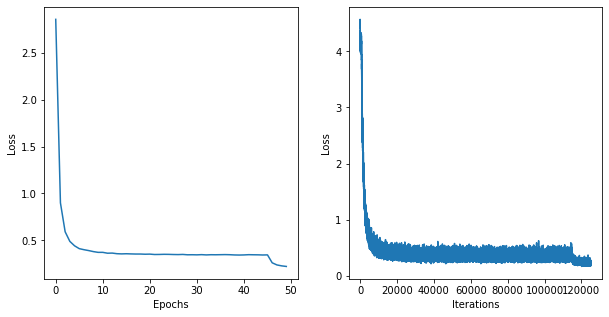

In [24]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
# loss over epoch
ax1.plot(result_loss)
ax1.set_xlabel("Epochs")
ax1.set_ylabel("Loss")
# loss over iterations (images)
ax2.plot(iter_loss)
ax2.set_xlabel("Iterations")
ax2.set_ylabel("Loss")
plt.show()

In [25]:
results_train = pd.DataFrame(columns=['true', 'prediction'])
train_loader = DataLoader(trainset, batch_size=16, shuffle=False)
with torch.no_grad(): # skipping the gradient calculation over the weights
    for image_train, text_train  in tqdm(train_loader, leave=True):
        text_encoded = crnn(image_train.to(device)) # [T, batch_size, num_classes==num_features]
        text_decoded = decode_predictions(text_encoded.cpu()) 
        df = pd.DataFrame(columns=['true', 'prediction'])
        df['true'] = text_train
        df['prediction'] = text_decoded
        results_train = pd.concat([results_train, df])
results_train = results_train.reset_index(drop=True)
#results_train



  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 4/5000 [00:00<02:05, 39.74it/s]

  0%|          | 9/5000 [00:00<02:03, 40.50it/s]

  0%|          | 14/5000 [00:00<02:01, 40.89it/s]

  0%|          | 19/5000 [00:00<01:57, 42.46it/s]

  0%|          | 24/5000 [00:00<01:54, 43.57it/s]

  1%|          | 29/5000 [00:00<01:52, 44.22it/s]

  1%|          | 34/5000 [00:00<01:51, 44.41it/s]

  1%|          | 39/5000 [00:00<01:53, 43.86it/s]

  1%|          | 44/5000 [00:00<01:49, 45.38it/s]

  1%|          | 49/5000 [00:01<01:48, 45.77it/s]

  1%|          | 54/5000 [00:01<01:46, 46.48it/s]

  1%|          | 59/5000 [00:01<01:46, 46.51it/s]

  1%|▏         | 64/5000 [00:01<01:45, 46.97it/s]

  1%|▏         | 69/5000 [00:01<01:44, 46.97it/s]

  1%|▏         | 74/5000 [00:01<01:45, 46.60it/s]

  2%|▏         | 79/5000 [00:01<01:46, 46.22it/s]

  2%|▏         | 84/5000 [00:01<01:45, 46.67it/s]

  2%|▏         | 89/5000 [00:01<01:44, 46.79it/s]

  2%|▏         | 94/5000 [00:02<01:45, 4

 14%|█▍        | 704/5000 [00:15<01:36, 44.35it/s]

 14%|█▍        | 709/5000 [00:15<01:36, 44.60it/s]

 14%|█▍        | 714/5000 [00:15<01:36, 44.62it/s]

 14%|█▍        | 719/5000 [00:15<01:36, 44.46it/s]

 14%|█▍        | 724/5000 [00:15<01:35, 44.64it/s]

 15%|█▍        | 729/5000 [00:15<01:35, 44.93it/s]

 15%|█▍        | 734/5000 [00:16<01:35, 44.77it/s]

 15%|█▍        | 739/5000 [00:16<01:37, 43.86it/s]

 15%|█▍        | 744/5000 [00:16<01:35, 44.48it/s]

 15%|█▍        | 749/5000 [00:16<01:35, 44.65it/s]

 15%|█▌        | 754/5000 [00:16<01:34, 44.85it/s]

 15%|█▌        | 759/5000 [00:16<01:34, 44.65it/s]

 15%|█▌        | 764/5000 [00:16<01:34, 44.71it/s]

 15%|█▌        | 769/5000 [00:16<01:35, 44.36it/s]

 15%|█▌        | 774/5000 [00:16<01:34, 44.55it/s]

 16%|█▌        | 779/5000 [00:17<01:33, 44.90it/s]

 16%|█▌        | 784/5000 [00:17<01:34, 44.84it/s]

 16%|█▌        | 789/5000 [00:17<01:33, 45.06it/s]

 16%|█▌        | 794/5000 [00:17<01:33, 45.18it/s]

 16%|█▌     

 28%|██▊       | 1399/5000 [00:30<01:18, 45.62it/s]

 28%|██▊       | 1404/5000 [00:30<01:19, 45.44it/s]

 28%|██▊       | 1409/5000 [00:30<01:18, 45.56it/s]

 28%|██▊       | 1414/5000 [00:31<01:21, 43.82it/s]

 28%|██▊       | 1419/5000 [00:31<01:20, 44.51it/s]

 28%|██▊       | 1424/5000 [00:31<01:19, 44.97it/s]

 29%|██▊       | 1429/5000 [00:31<01:18, 45.29it/s]

 29%|██▊       | 1434/5000 [00:31<01:18, 45.38it/s]

 29%|██▉       | 1439/5000 [00:31<01:18, 45.29it/s]

 29%|██▉       | 1444/5000 [00:31<01:18, 45.33it/s]

 29%|██▉       | 1449/5000 [00:31<01:18, 45.29it/s]

 29%|██▉       | 1454/5000 [00:31<01:17, 45.49it/s]

 29%|██▉       | 1459/5000 [00:32<01:18, 45.22it/s]

 29%|██▉       | 1464/5000 [00:32<01:18, 45.15it/s]

 29%|██▉       | 1469/5000 [00:32<01:18, 45.16it/s]

 29%|██▉       | 1474/5000 [00:32<01:18, 44.81it/s]

 30%|██▉       | 1479/5000 [00:32<01:18, 44.84it/s]

 30%|██▉       | 1484/5000 [00:32<01:18, 44.82it/s]

 30%|██▉       | 1489/5000 [00:32<01:18, 44.89

 42%|████▏     | 2089/5000 [00:46<01:05, 44.43it/s]

 42%|████▏     | 2094/5000 [00:46<01:04, 44.72it/s]

 42%|████▏     | 2099/5000 [00:46<01:04, 44.65it/s]

 42%|████▏     | 2104/5000 [00:46<01:05, 43.89it/s]

 42%|████▏     | 2109/5000 [00:46<01:06, 43.70it/s]

 42%|████▏     | 2114/5000 [00:46<01:05, 44.07it/s]

 42%|████▏     | 2119/5000 [00:47<01:05, 44.00it/s]

 42%|████▏     | 2124/5000 [00:47<01:05, 43.81it/s]

 43%|████▎     | 2129/5000 [00:47<01:05, 44.03it/s]

 43%|████▎     | 2134/5000 [00:47<01:04, 44.16it/s]

 43%|████▎     | 2139/5000 [00:47<01:04, 44.68it/s]

 43%|████▎     | 2144/5000 [00:47<01:04, 44.42it/s]

 43%|████▎     | 2149/5000 [00:47<01:04, 44.21it/s]

 43%|████▎     | 2154/5000 [00:47<01:04, 44.37it/s]

 43%|████▎     | 2159/5000 [00:47<01:04, 44.22it/s]

 43%|████▎     | 2164/5000 [00:48<01:03, 44.60it/s]

 43%|████▎     | 2169/5000 [00:48<01:03, 44.77it/s]

 43%|████▎     | 2174/5000 [00:48<01:03, 44.41it/s]

 44%|████▎     | 2179/5000 [00:48<01:04, 44.04

 56%|█████▌    | 2779/5000 [01:01<00:50, 43.90it/s]

 56%|█████▌    | 2784/5000 [01:02<00:49, 44.37it/s]

 56%|█████▌    | 2789/5000 [01:02<00:49, 44.79it/s]

 56%|█████▌    | 2794/5000 [01:02<00:48, 45.06it/s]

 56%|█████▌    | 2799/5000 [01:02<00:49, 44.30it/s]

 56%|█████▌    | 2804/5000 [01:02<00:50, 43.92it/s]

 56%|█████▌    | 2809/5000 [01:02<00:50, 43.78it/s]

 56%|█████▋    | 2814/5000 [01:02<00:50, 43.60it/s]

 56%|█████▋    | 2819/5000 [01:02<00:50, 43.59it/s]

 56%|█████▋    | 2824/5000 [01:03<00:50, 43.00it/s]

 57%|█████▋    | 2829/5000 [01:03<00:49, 43.43it/s]

 57%|█████▋    | 2834/5000 [01:03<00:49, 43.35it/s]

 57%|█████▋    | 2839/5000 [01:03<00:49, 43.29it/s]

 57%|█████▋    | 2844/5000 [01:03<00:49, 43.24it/s]

 57%|█████▋    | 2849/5000 [01:03<00:49, 43.51it/s]

 57%|█████▋    | 2854/5000 [01:03<00:49, 43.34it/s]

 57%|█████▋    | 2859/5000 [01:03<00:49, 42.95it/s]

 57%|█████▋    | 2864/5000 [01:03<00:49, 43.34it/s]

 57%|█████▋    | 2869/5000 [01:04<00:49, 43.21

 69%|██████▉   | 3458/5000 [01:18<00:35, 42.96it/s]

 69%|██████▉   | 3463/5000 [01:18<00:35, 43.35it/s]

 69%|██████▉   | 3468/5000 [01:18<00:35, 43.51it/s]

 69%|██████▉   | 3473/5000 [01:18<00:35, 42.91it/s]

 70%|██████▉   | 3478/5000 [01:18<00:35, 42.83it/s]

 70%|██████▉   | 3483/5000 [01:18<00:35, 42.47it/s]

 70%|██████▉   | 3488/5000 [01:18<00:35, 42.67it/s]

 70%|██████▉   | 3493/5000 [01:19<00:35, 42.54it/s]

 70%|██████▉   | 3498/5000 [01:19<00:35, 42.86it/s]

 70%|███████   | 3503/5000 [01:19<00:35, 42.52it/s]

 70%|███████   | 3508/5000 [01:19<00:35, 42.50it/s]

 70%|███████   | 3513/5000 [01:19<00:35, 42.16it/s]

 70%|███████   | 3518/5000 [01:19<00:34, 42.36it/s]

 70%|███████   | 3523/5000 [01:19<00:34, 42.54it/s]

 71%|███████   | 3528/5000 [01:19<00:34, 42.69it/s]

 71%|███████   | 3533/5000 [01:19<00:34, 42.77it/s]

 71%|███████   | 3538/5000 [01:20<00:34, 42.39it/s]

 71%|███████   | 3543/5000 [01:20<00:34, 42.55it/s]

 71%|███████   | 3548/5000 [01:20<00:34, 42.68

 83%|████████▎ | 4148/5000 [01:34<00:19, 43.08it/s]

 83%|████████▎ | 4153/5000 [01:34<00:19, 43.32it/s]

 83%|████████▎ | 4158/5000 [01:34<00:19, 42.56it/s]

 83%|████████▎ | 4163/5000 [01:34<00:19, 42.53it/s]

 83%|████████▎ | 4168/5000 [01:34<00:19, 42.65it/s]

 83%|████████▎ | 4173/5000 [01:34<00:19, 42.46it/s]

 84%|████████▎ | 4178/5000 [01:35<00:19, 43.04it/s]

 84%|████████▎ | 4183/5000 [01:35<00:19, 42.93it/s]

 84%|████████▍ | 4188/5000 [01:35<00:19, 42.51it/s]

 84%|████████▍ | 4193/5000 [01:35<00:18, 42.83it/s]

 84%|████████▍ | 4198/5000 [01:35<00:18, 42.88it/s]

 84%|████████▍ | 4203/5000 [01:35<00:18, 42.74it/s]

 84%|████████▍ | 4208/5000 [01:35<00:18, 42.25it/s]

 84%|████████▍ | 4213/5000 [01:35<00:18, 42.12it/s]

 84%|████████▍ | 4218/5000 [01:35<00:18, 42.48it/s]

 84%|████████▍ | 4223/5000 [01:36<00:18, 42.17it/s]

 85%|████████▍ | 4228/5000 [01:36<00:18, 42.24it/s]

 85%|████████▍ | 4233/5000 [01:36<00:18, 42.30it/s]

 85%|████████▍ | 4238/5000 [01:36<00:17, 42.67

 97%|█████████▋| 4838/5000 [01:50<00:03, 41.66it/s]

 97%|█████████▋| 4843/5000 [01:50<00:03, 41.60it/s]

 97%|█████████▋| 4848/5000 [01:50<00:03, 41.63it/s]

 97%|█████████▋| 4853/5000 [01:51<00:03, 42.05it/s]

 97%|█████████▋| 4858/5000 [01:51<00:03, 41.94it/s]

 97%|█████████▋| 4863/5000 [01:51<00:03, 41.79it/s]

 97%|█████████▋| 4868/5000 [01:51<00:03, 41.93it/s]

 97%|█████████▋| 4873/5000 [01:51<00:02, 42.34it/s]

 98%|█████████▊| 4878/5000 [01:51<00:02, 42.59it/s]

 98%|█████████▊| 4883/5000 [01:51<00:02, 42.71it/s]

 98%|█████████▊| 4888/5000 [01:51<00:02, 42.06it/s]

 98%|█████████▊| 4893/5000 [01:52<00:02, 41.97it/s]

 98%|█████████▊| 4898/5000 [01:52<00:02, 42.04it/s]

 98%|█████████▊| 4903/5000 [01:52<00:02, 42.25it/s]

 98%|█████████▊| 4908/5000 [01:52<00:02, 42.52it/s]

 98%|█████████▊| 4913/5000 [01:52<00:02, 42.83it/s]

 98%|█████████▊| 4918/5000 [01:52<00:01, 42.57it/s]

 98%|█████████▊| 4923/5000 [01:52<00:01, 42.52it/s]

 99%|█████████▊| 4928/5000 [01:52<00:01, 42.43

In [26]:
results_test = pd.DataFrame(columns=['true', 'prediction'])
test_loader = DataLoader(testset, batch_size=16, shuffle=False)
with torch.no_grad(): # skipping the gradient calculation over the weights
    for image_test, text_test  in tqdm(test_loader, leave=True):
        text_encoded = crnn(image_test.to(device)) # [T, batch_size, num_classes==num_features]
        text_decoded = decode_predictions(text_encoded.cpu())
        df = pd.DataFrame(columns=['true', 'prediction'])
        df['true'] = text_test
        df['prediction'] = text_decoded
        results_test = pd.concat([results_test, df])
results_test = results_test.reset_index(drop=True)
#results_test



  0%|          | 0/1250 [00:00<?, ?it/s]

  0%|          | 4/1250 [00:00<00:36, 34.19it/s]

  0%|          | 6/1250 [00:00<01:22, 15.04it/s]

  1%|          | 7/1250 [00:00<01:35, 12.96it/s]

  1%|          | 8/1250 [00:00<01:55, 10.72it/s]

  1%|          | 9/1250 [00:00<02:22,  8.73it/s]

  1%|          | 10/1250 [00:00<02:40,  7.71it/s]

  1%|          | 11/1250 [00:01<02:48,  7.34it/s]

  1%|          | 12/1250 [00:01<02:49,  7.32it/s]

  1%|          | 13/1250 [00:01<02:57,  6.99it/s]

  1%|          | 14/1250 [00:01<02:57,  6.96it/s]

  1%|          | 15/1250 [00:01<03:02,  6.77it/s]

  1%|▏         | 16/1250 [00:01<03:07,  6.57it/s]

  1%|▏         | 17/1250 [00:02<03:15,  6.30it/s]

  1%|▏         | 18/1250 [00:02<03:14,  6.34it/s]

  2%|▏         | 19/1250 [00:02<03:12,  6.40it/s]

  2%|▏         | 20/1250 [00:02<03:14,  6.32it/s]

  2%|▏         | 21/1250 [00:02<03:16,  6.25it/s]

  2%|▏         | 22/1250 [00:02<03:02,  6.71it/s]

  2%|▏         | 23/1250 [00:02<03:01,  6.7

 13%|█▎        | 166/1250 [00:21<01:59,  9.05it/s]

 13%|█▎        | 167/1250 [00:21<02:02,  8.86it/s]

 13%|█▎        | 168/1250 [00:21<02:01,  8.92it/s]

 14%|█▎        | 169/1250 [00:21<02:00,  8.94it/s]

 14%|█▎        | 170/1250 [00:21<01:59,  9.03it/s]

 14%|█▎        | 171/1250 [00:21<02:01,  8.88it/s]

 14%|█▍        | 172/1250 [00:21<02:02,  8.84it/s]

 14%|█▍        | 173/1250 [00:21<02:02,  8.81it/s]

 14%|█▍        | 174/1250 [00:22<02:02,  8.76it/s]

 14%|█▍        | 175/1250 [00:22<02:04,  8.65it/s]

 14%|█▍        | 176/1250 [00:22<02:03,  8.72it/s]

 14%|█▍        | 178/1250 [00:22<01:53,  9.42it/s]

 14%|█▍        | 180/1250 [00:22<01:36, 11.09it/s]

 15%|█▍        | 182/1250 [00:22<01:32, 11.55it/s]

 15%|█▍        | 184/1250 [00:22<01:38, 10.82it/s]

 15%|█▍        | 186/1250 [00:23<01:42, 10.34it/s]

 15%|█▌        | 188/1250 [00:23<01:49,  9.66it/s]

 15%|█▌        | 190/1250 [00:23<01:52,  9.44it/s]

 15%|█▌        | 191/1250 [00:23<01:53,  9.37it/s]

 15%|█▌     

 26%|██▌       | 323/1250 [00:38<01:40,  9.24it/s]

 26%|██▌       | 324/1250 [00:39<01:38,  9.42it/s]

 26%|██▌       | 325/1250 [00:39<01:40,  9.19it/s]

 26%|██▌       | 326/1250 [00:39<01:42,  8.99it/s]

 26%|██▌       | 327/1250 [00:39<01:41,  9.08it/s]

 26%|██▌       | 328/1250 [00:39<01:43,  8.90it/s]

 26%|██▋       | 329/1250 [00:39<01:42,  8.95it/s]

 26%|██▋       | 330/1250 [00:39<01:40,  9.13it/s]

 26%|██▋       | 331/1250 [00:39<01:41,  9.06it/s]

 27%|██▋       | 332/1250 [00:39<01:39,  9.23it/s]

 27%|██▋       | 333/1250 [00:40<01:39,  9.25it/s]

 27%|██▋       | 334/1250 [00:40<01:38,  9.27it/s]

 27%|██▋       | 335/1250 [00:40<01:40,  9.10it/s]

 27%|██▋       | 336/1250 [00:40<01:42,  8.89it/s]

 27%|██▋       | 337/1250 [00:40<01:42,  8.91it/s]

 27%|██▋       | 339/1250 [00:40<01:36,  9.43it/s]

 27%|██▋       | 341/1250 [00:40<01:31,  9.90it/s]

 27%|██▋       | 343/1250 [00:41<01:26, 10.52it/s]

 28%|██▊       | 345/1250 [00:41<01:23, 10.84it/s]

 28%|██▊    

 39%|███▉      | 490/1250 [00:57<01:38,  7.69it/s]

 39%|███▉      | 491/1250 [00:58<01:44,  7.27it/s]

 39%|███▉      | 492/1250 [00:58<01:45,  7.18it/s]

 39%|███▉      | 493/1250 [00:58<01:47,  7.06it/s]

 40%|███▉      | 494/1250 [00:58<01:50,  6.82it/s]

 40%|███▉      | 495/1250 [00:58<01:51,  6.79it/s]

 40%|███▉      | 496/1250 [00:58<01:54,  6.60it/s]

 40%|███▉      | 497/1250 [00:58<01:53,  6.65it/s]

 40%|███▉      | 498/1250 [00:59<01:46,  7.09it/s]

 40%|███▉      | 499/1250 [00:59<01:53,  6.64it/s]

 40%|████      | 500/1250 [00:59<01:54,  6.54it/s]

 40%|████      | 501/1250 [00:59<02:05,  5.98it/s]

 40%|████      | 502/1250 [00:59<02:08,  5.80it/s]

 40%|████      | 503/1250 [00:59<02:17,  5.45it/s]

 40%|████      | 504/1250 [01:00<02:32,  4.88it/s]

 40%|████      | 506/1250 [01:00<02:12,  5.62it/s]

 41%|████      | 508/1250 [01:00<01:52,  6.62it/s]

 41%|████      | 510/1250 [01:00<01:32,  7.98it/s]

 41%|████      | 512/1250 [01:00<01:22,  8.94it/s]

 41%|████   

 56%|█████▌    | 703/1250 [01:20<00:55,  9.90it/s]

 56%|█████▋    | 705/1250 [01:20<00:54, 10.05it/s]

 57%|█████▋    | 707/1250 [01:20<00:52, 10.35it/s]

 57%|█████▋    | 709/1250 [01:20<01:02,  8.67it/s]

 57%|█████▋    | 710/1250 [01:21<01:20,  6.70it/s]

 57%|█████▋    | 711/1250 [01:21<01:33,  5.79it/s]

 57%|█████▋    | 712/1250 [01:21<01:23,  6.46it/s]

 57%|█████▋    | 714/1250 [01:21<01:09,  7.67it/s]

 57%|█████▋    | 715/1250 [01:21<01:06,  8.03it/s]

 57%|█████▋    | 716/1250 [01:21<01:04,  8.22it/s]

 57%|█████▋    | 717/1250 [01:21<01:01,  8.62it/s]

 57%|█████▋    | 718/1250 [01:22<01:01,  8.69it/s]

 58%|█████▊    | 719/1250 [01:22<01:00,  8.72it/s]

 58%|█████▊    | 720/1250 [01:22<01:00,  8.82it/s]

 58%|█████▊    | 721/1250 [01:22<00:59,  8.93it/s]

 58%|█████▊    | 722/1250 [01:22<00:58,  8.97it/s]

 58%|█████▊    | 723/1250 [01:22<00:59,  8.90it/s]

 58%|█████▊    | 724/1250 [01:22<00:59,  8.78it/s]

 58%|█████▊    | 725/1250 [01:22<00:59,  8.76it/s]

 58%|█████▊ 

 70%|██████▉   | 874/1250 [01:39<00:53,  7.07it/s]

 70%|███████   | 875/1250 [01:39<00:54,  6.94it/s]

 70%|███████   | 876/1250 [01:39<00:56,  6.63it/s]

 70%|███████   | 877/1250 [01:39<00:56,  6.55it/s]

 70%|███████   | 878/1250 [01:40<00:57,  6.48it/s]

 70%|███████   | 879/1250 [01:40<00:59,  6.23it/s]

 70%|███████   | 880/1250 [01:40<00:57,  6.41it/s]

 70%|███████   | 881/1250 [01:40<00:57,  6.37it/s]

 71%|███████   | 882/1250 [01:40<00:59,  6.22it/s]

 71%|███████   | 883/1250 [01:40<00:58,  6.31it/s]

 71%|███████   | 884/1250 [01:41<00:56,  6.44it/s]

 71%|███████   | 885/1250 [01:41<00:55,  6.59it/s]

 71%|███████   | 886/1250 [01:41<00:55,  6.51it/s]

 71%|███████   | 887/1250 [01:41<00:54,  6.62it/s]

 71%|███████   | 888/1250 [01:41<00:50,  7.24it/s]

 71%|███████   | 889/1250 [01:41<00:50,  7.08it/s]

 71%|███████   | 890/1250 [01:41<00:52,  6.92it/s]

 71%|███████▏  | 891/1250 [01:42<00:53,  6.71it/s]

 71%|███████▏  | 892/1250 [01:42<00:53,  6.65it/s]

 71%|███████

 82%|████████▏ | 1031/1250 [01:58<00:25,  8.75it/s]

 83%|████████▎ | 1032/1250 [01:58<00:25,  8.60it/s]

 83%|████████▎ | 1033/1250 [01:58<00:28,  7.72it/s]

 83%|████████▎ | 1034/1250 [01:58<00:32,  6.72it/s]

 83%|████████▎ | 1035/1250 [01:59<00:32,  6.65it/s]

 83%|████████▎ | 1036/1250 [01:59<00:40,  5.29it/s]

 83%|████████▎ | 1037/1250 [01:59<00:39,  5.39it/s]

 83%|████████▎ | 1038/1250 [01:59<00:34,  6.07it/s]

 83%|████████▎ | 1039/1250 [01:59<00:31,  6.60it/s]

 83%|████████▎ | 1040/1250 [01:59<00:28,  7.26it/s]

 83%|████████▎ | 1041/1250 [01:59<00:27,  7.70it/s]

 83%|████████▎ | 1042/1250 [02:00<00:26,  7.96it/s]

 83%|████████▎ | 1043/1250 [02:00<00:25,  8.25it/s]

 84%|████████▎ | 1044/1250 [02:00<00:24,  8.35it/s]

 84%|████████▎ | 1045/1250 [02:00<00:24,  8.46it/s]

 84%|████████▍ | 1047/1250 [02:00<00:22,  9.21it/s]

 84%|████████▍ | 1049/1250 [02:00<00:20,  9.73it/s]

 84%|████████▍ | 1051/1250 [02:00<00:21,  9.37it/s]

 84%|████████▍ | 1052/1250 [02:01<00:21,  9.10

 96%|█████████▌| 1197/1250 [02:16<00:05, 10.55it/s]

 96%|█████████▌| 1199/1250 [02:16<00:05, 10.19it/s]

 96%|█████████▌| 1201/1250 [02:17<00:04,  9.98it/s]

 96%|█████████▌| 1203/1250 [02:17<00:04,  9.77it/s]

 96%|█████████▋| 1205/1250 [02:17<00:04,  9.85it/s]

 96%|█████████▋| 1206/1250 [02:17<00:04,  9.79it/s]

 97%|█████████▋| 1207/1250 [02:17<00:04,  9.70it/s]

 97%|█████████▋| 1208/1250 [02:17<00:04,  9.46it/s]

 97%|█████████▋| 1209/1250 [02:18<00:04,  9.31it/s]

 97%|█████████▋| 1210/1250 [02:18<00:04,  9.32it/s]

 97%|█████████▋| 1211/1250 [02:18<00:04,  9.34it/s]

 97%|█████████▋| 1212/1250 [02:18<00:04,  9.29it/s]

 97%|█████████▋| 1213/1250 [02:18<00:03,  9.29it/s]

 97%|█████████▋| 1214/1250 [02:18<00:03,  9.21it/s]

 97%|█████████▋| 1215/1250 [02:18<00:03,  9.34it/s]

 97%|█████████▋| 1216/1250 [02:18<00:03,  9.22it/s]

 97%|█████████▋| 1217/1250 [02:18<00:03,  9.05it/s]

 97%|█████████▋| 1218/1250 [02:18<00:03,  9.27it/s]

 98%|█████████▊| 1219/1250 [02:19<00:03,  9.45

In [27]:
def remove_duplicates(text): 
    if len(text) > 1:
        letters = [text[0]] + [letter for idx, letter in enumerate(text[1:], start=1) if text[idx] != text[idx-1]]
    elif len(text) == 1:
        letters = [text[0]]
    else:
        return ""
    return "".join(letters)

def correct_prediction(word):
    parts = word.split("-") 
    parts = [remove_duplicates(part) for part in parts]
    corrected_word = "".join(parts)
    return corrected_word

# Here some prediction texts have a length not equal to 5
results_train['correct_pred'] = results_train['prediction'].apply(correct_prediction)
results_test['correct_pred'] = results_test['prediction'].apply(correct_prediction)

In [28]:
results_train

true prediction correct_pred
0      jeY8A     jeYY8A        jeY8A
1      VDt58     vDt558        vDt58
2      7jXKA     7jXXKA        7jXKA
3      4WSvC     4WSSvC        4WSvC
4      zNthy     zNNthy        zNthy
...      ...        ...          ...
79995  3yTAd     3yTAAd        3yTAd
79996  bFS8x     bFFS8x        bFS8x
79997  XzSdW     XzSSdW        XzSdW
79998  g4B7B     g4BB7B        g4B7B
79999  rTqMA     rTTqMA        rTqMA

[80000 rows x 3 columns]

In [29]:
results_test

true prediction correct_pred
0      6vCUT     6vCCUT        6vCUT
1      gbbzs     gb-bzs        gbbzs
2      dSEx4     dSEEx4        dSEx4
3      kvEYx     kvEEYx        kvEYx
4      xY4AD     xYY4AD        xY4AD
...      ...        ...          ...
19995  RG3rC     RG33rC        RG3rC
19996  fqWfg     fqWWfg        fqWfg
19997  4ENdb     4EN-db        4ENdb
19998  YWwjn     YWwwjn        YWwjn
19999  zk2vC     zk22vC        zk2vC

[20000 rows x 3 columns]

In [30]:
train_incorrect_df = results_train[results_train['true'] != results_train['correct_pred']]
train_accuracy = 1 - train_incorrect_df.shape[0]/len(image_names_train)
train_error = 1 - train_accuracy
test_incorrect_df = results_test[results_test['true'] != results_test['correct_pred']]
test_accuracy = 1 - test_incorrect_df.shape[0]/len(image_names_test)
test_error = 1 - test_accuracy
print(f"Train accuracy {train_accuracy}")
print(f"Test accuracy {test_accuracy}")

Train accuracy 0.8938375
Test accuracy 0.84145


In [ ]:
#from sklearn.metrics import confusion_matrix
#confusion_matrix(results_test[“true”], results_test[“correct_pred”])
